<a href="https://colab.research.google.com/github/rebeccadimatteo/ExplainableAI/blob/main/DatasetConsumoAlcolStudentiLingua.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**READING CSV FILES WITH DATASETS**


In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt

from six.moves import urllib

import seaborn as sb
from matplotlib import style

style.use('seaborn-whitegrid')

plt.rcParams['figure.figsize'] = (40,20)

DOWNLOAD_ROOT="https://raw.githubusercontent.com/rebeccadimatteo/ExplainableAI/master/datasetLingua.csv"

#fetch dataset da github
def fetch_file_data1(file_url1=DOWNLOAD_ROOT, file_path1="file"):
  os.makedirs(file_path1, exist_ok=True)
  csv_path1 = os.path.join(file_path1, "datasetLingua.csv")
  urllib.request.urlretrieve(file_url1, csv_path1)
fetch_file_data1()

#df è la variabile che contiene il dataset
df=pd.read_csv("file/datasetLingua.csv")
df.head(4)


school sex  age address famsize Pstatus  ...  Walc  health absences  G1  G2  G3
0     GP   F   18       U     GT3       A  ...     1       3        4   0  11  11
1     GP   F   17       U     GT3       T  ...     1       3        2   9  11  11
2     GP   F   15       U     LE3       T  ...     3       3        6  12  13  12
3     GP   F   15       U     GT3       T  ...     1       5        0  14  14  14

[4 rows x 33 columns]

##**DATA CLEANING**

In [3]:
#verifica se ci sono dati null nel dataset
df.isnull().any()

school        False
sex           False
age           False
address       False
famsize       False
Pstatus       False
Medu          False
Fedu          False
Mjob          False
Fjob          False
reason        False
guardian      False
traveltime    False
studytime     False
failures      False
schoolsup     False
famsup        False
paid          False
activities    False
nursery       False
higher        False
internet      False
romantic      False
famrel        False
freetime      False
goout         False
Dalc          False
Walc          False
health        False
absences      False
G1            False
G2            False
G3            False
dtype: bool

In [4]:
#verifica se ci sono dati NA nel dataset
df.isna().any()

school        False
sex           False
age           False
address       False
famsize       False
Pstatus       False
Medu          False
Fedu          False
Mjob          False
Fjob          False
reason        False
guardian      False
traveltime    False
studytime     False
failures      False
schoolsup     False
famsup        False
paid          False
activities    False
nursery       False
higher        False
internet      False
romantic      False
famrel        False
freetime      False
goout         False
Dalc          False
Walc          False
health        False
absences      False
G1            False
G2            False
G3            False
dtype: bool

In [5]:
# statistiche descrittive di base per tutte le colonne
df.describe()

age        Medu        Fedu  ...          G1          G2          G3
count  649.000000  649.000000  649.000000  ...  649.000000  649.000000  649.000000
mean    16.744222    2.514638    2.306626  ...   11.399076   11.570108   11.906009
std      1.218138    1.134552    1.099931  ...    2.745265    2.913639    3.230656
min     15.000000    0.000000    0.000000  ...    0.000000    0.000000    0.000000
25%     16.000000    2.000000    1.000000  ...   10.000000   10.000000   10.000000
50%     17.000000    2.000000    2.000000  ...   11.000000   11.000000   12.000000
75%     18.000000    4.000000    3.000000  ...   13.000000   13.000000   14.000000
max     22.000000    4.000000    4.000000  ...   19.000000   19.000000   19.000000

[8 rows x 16 columns]

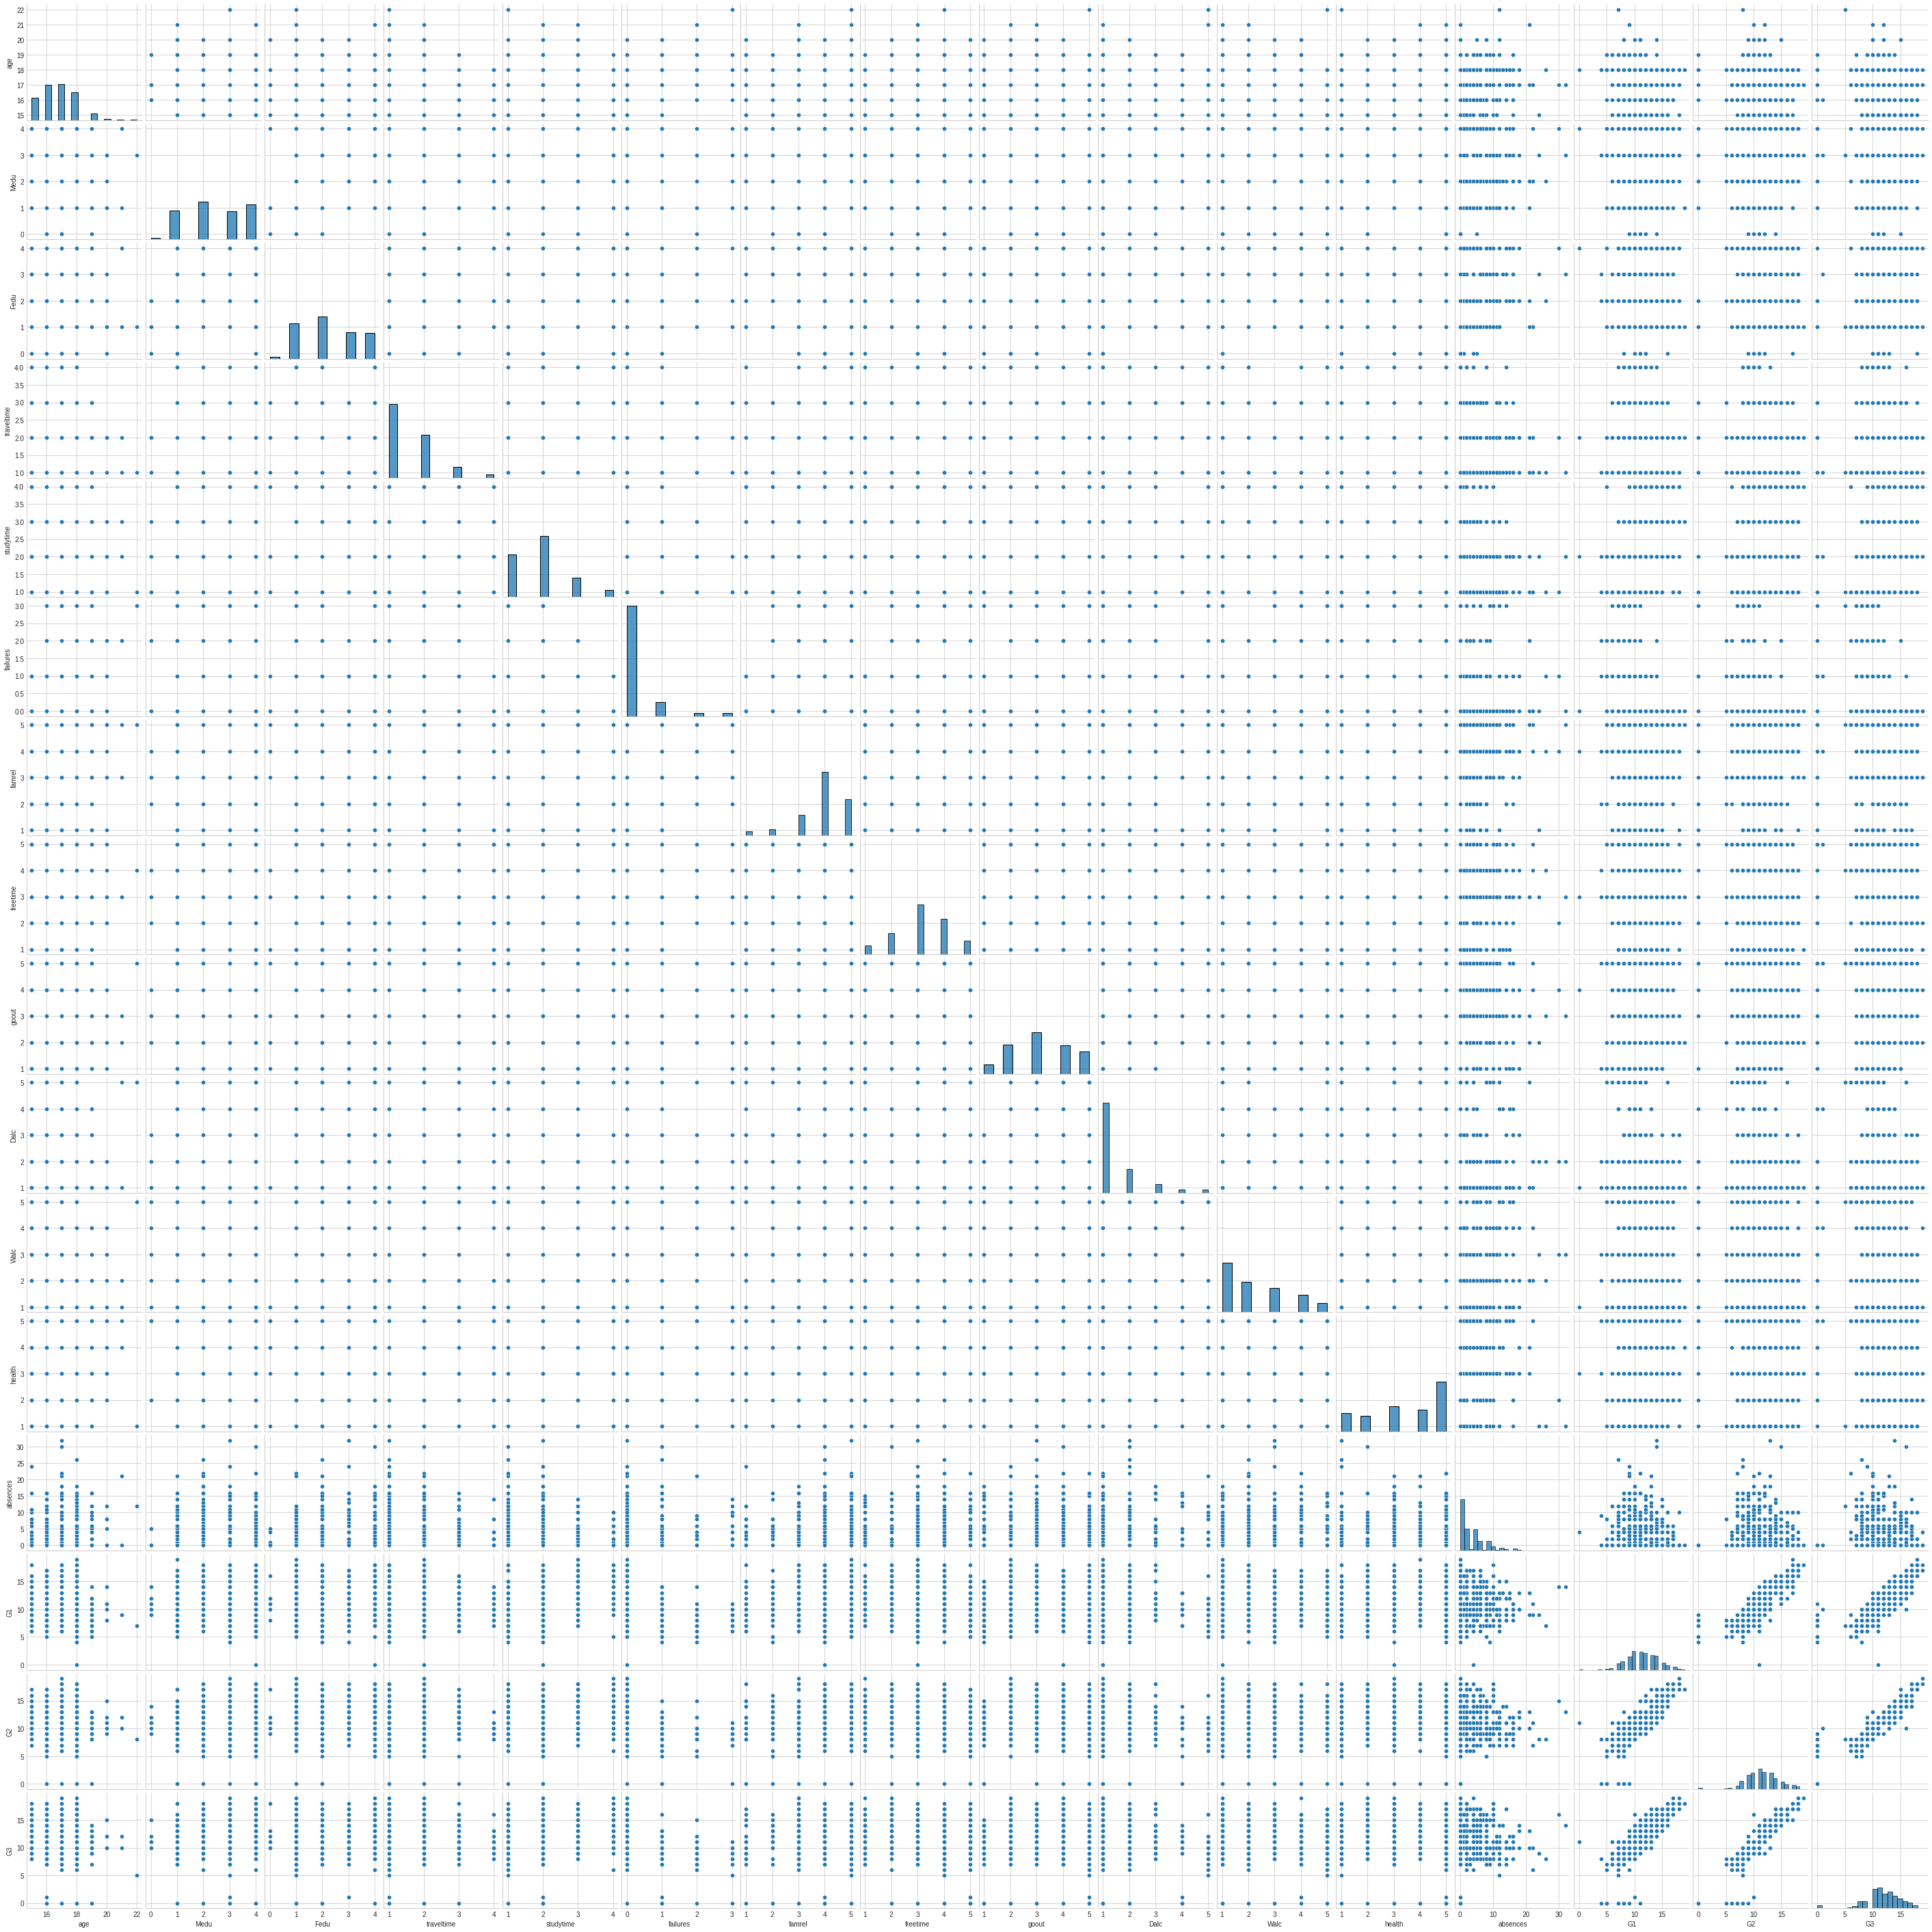

In [6]:
#data plot visualizzare dipendenze tra variabili
sb.pairplot(df)
#salvataggio plot
plt.savefig('pairplor.png')

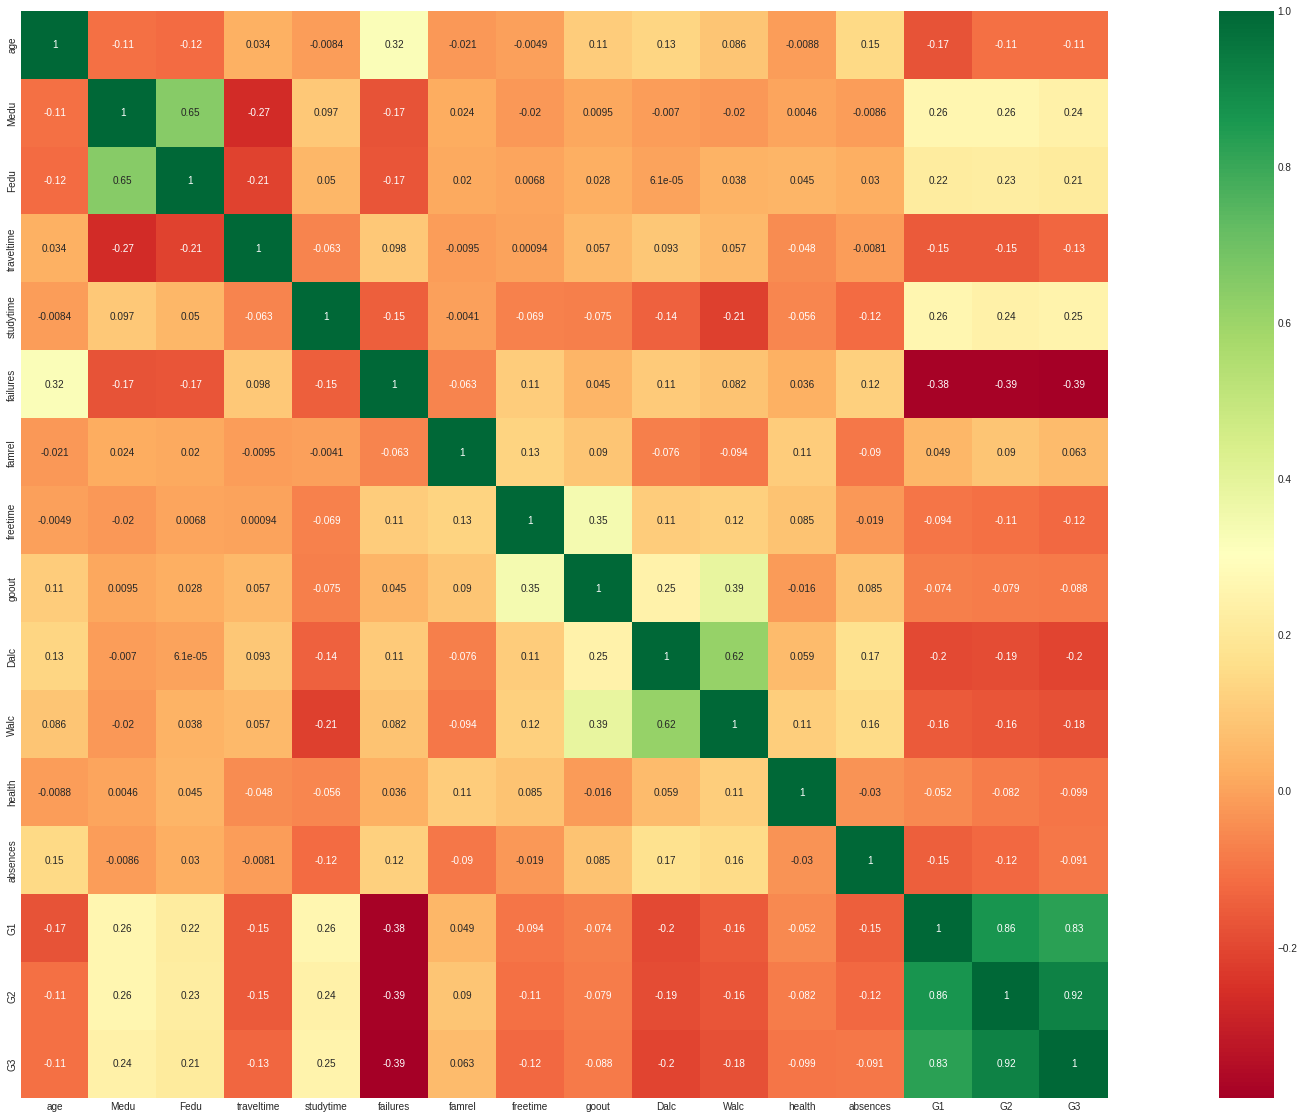

In [7]:
#correlazione tra le variabili
sb.heatmap(df.corr(), annot=True, cmap="RdYlGn", square=True)

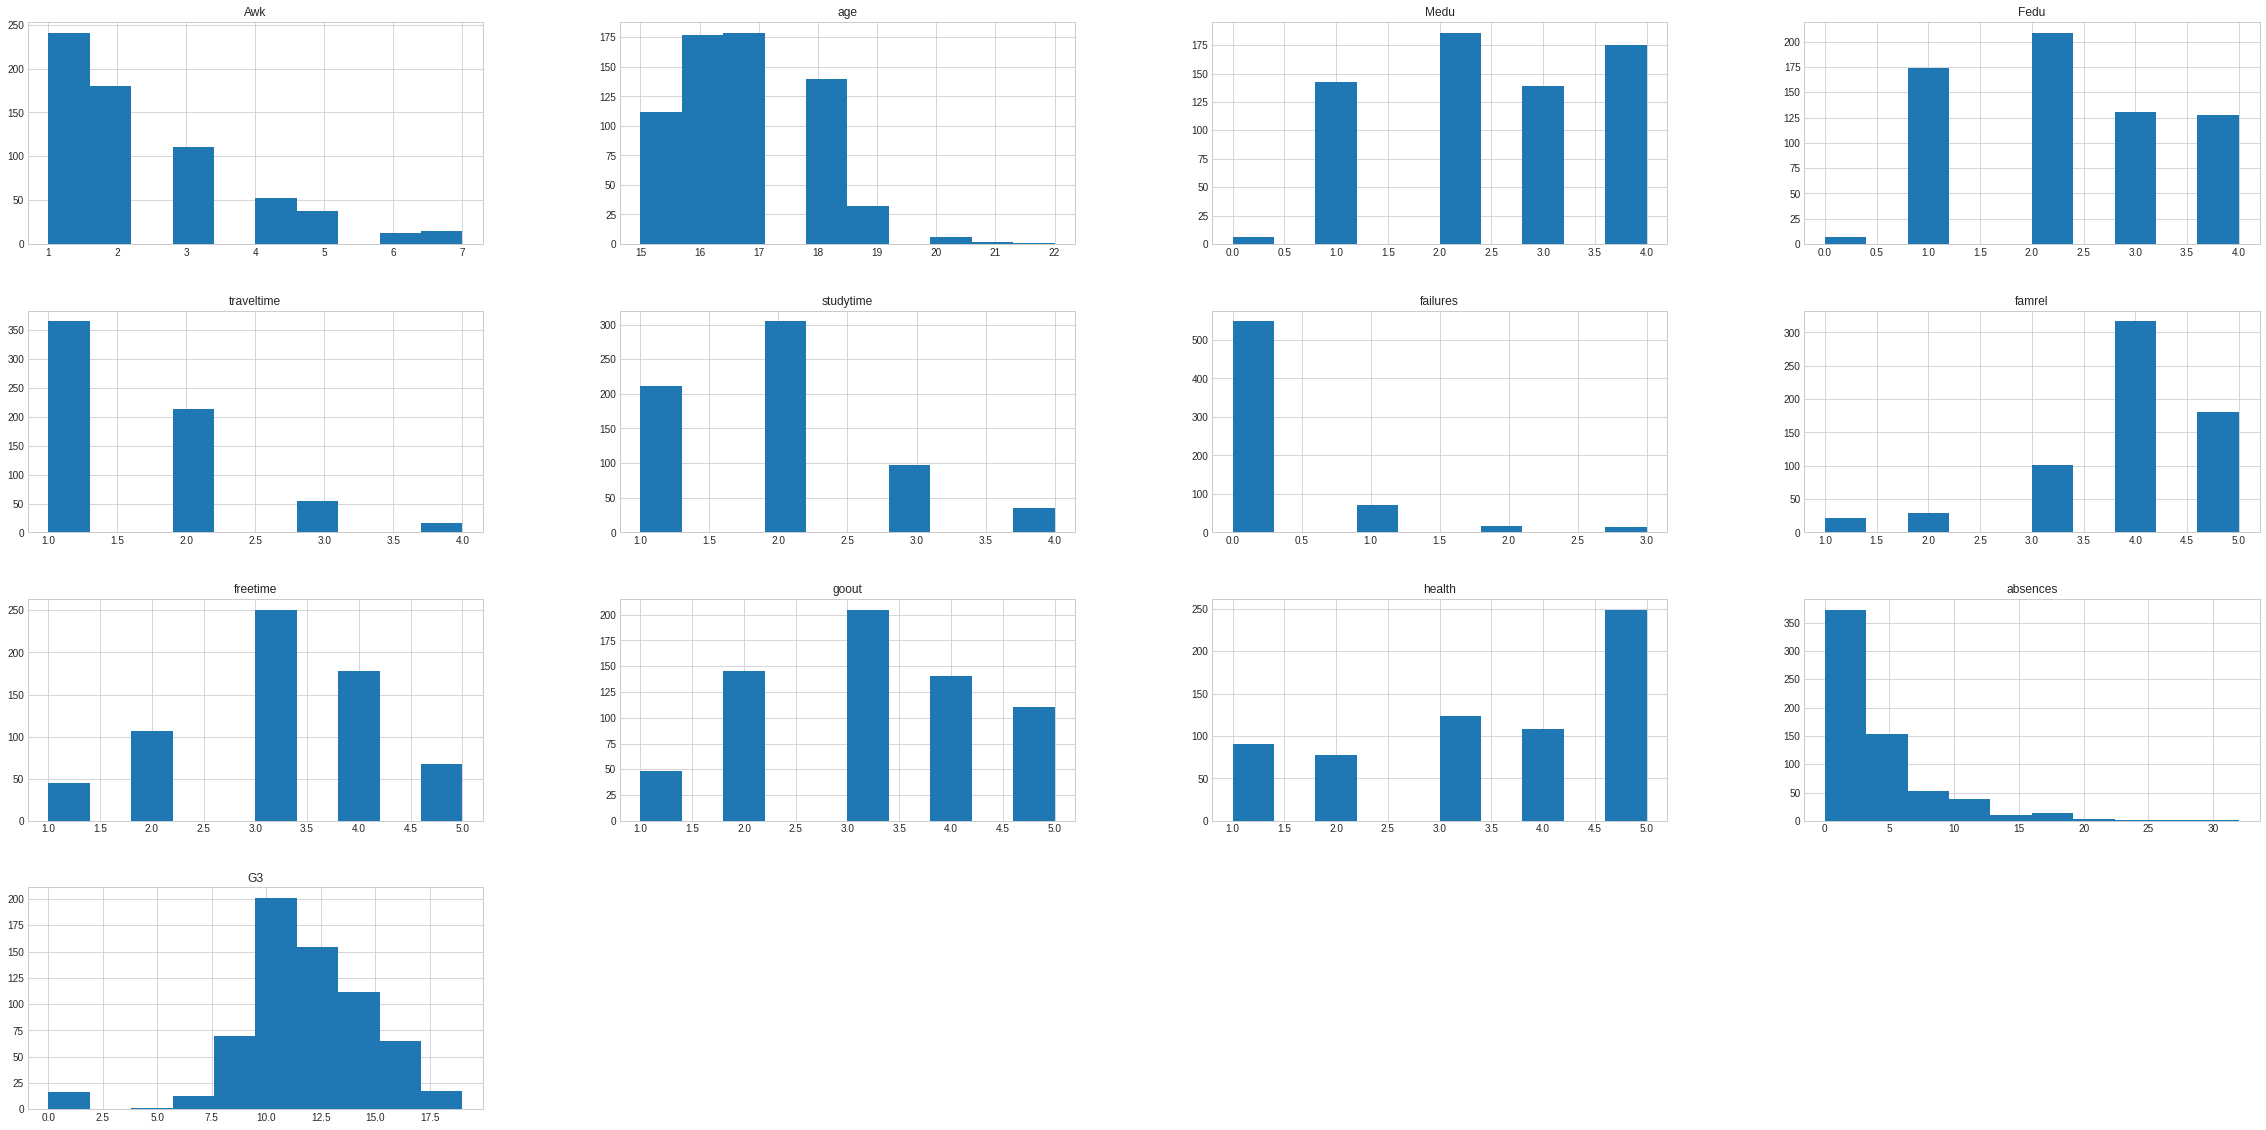

In [8]:
#Eliminazione variabil indipendenti G1,G2 e unione Dalc e Walc in Awk(variabile dipendente)
df=df.drop(columns='G1')
df=df.drop(columns='G2')
df=df.drop(columns='school')
df=df.drop(columns='reason')
df=df.drop(columns='internet')
dalc=df.Dalc
walk=df.Walc
Awk=dalc+walk//2
df.insert(0,'Awk',Awk)
df=df.drop(columns='Dalc')
df=df.drop(columns='Walc')
#controllo bilanciamento
df.hist()
plt.show()

# **DEFINITION METRICS CLASS**

In [9]:
#oggetto che contiene le metriche
class Metrics1:
  #costruttore
  def __init__(self,precision,recall,accuracy,mcc):
    self.precision=precision
    self.recall=recall
    self.accuracy=accuracy
    self.mcc=mcc
  
  #ToString
  def __str__(self):
    return f'Metrics [precision= {self.precision} recall= {self.recall} accuracy= {self.accuracy} mcc= {self.mcc}'

# **DEFINITION METRICSRESULTSCONTAINER CLASS**

In [10]:
import numpy as np
class MetricsResultContainer:
  meanPrecision = []
  meanRecall = []
  meanAccuracy = []
  meanMcc =[]
  #costruttore
  def __init__(self,model,alg,scaler,param,metricsMean,balance):
    self.model=model
    self.alg=alg
    self.scaler=scaler
    self.param=param
    self.metricsMean=metricsMean
    self.meanPrecision = []
    self.meanRecall = []
    self.meanAccuracy = []
    self.meanMcc =[]
    self.balance=balance
  
  def printMetrics(self):
    for m in self.metricsMean:
      self.meanPrecision.append(m.precision)
      self.meanRecall.append(m.recall)
      self.meanAccuracy.append(m.accuracy)
      self.meanMcc.append(m.mcc)
    print("meanPrecision=",np.mean(self.meanPrecision))    
    print("meanRecall=",np.mean(self.meanRecall))    
    print("meanAccuracy=",np.mean(self.meanAccuracy))
    print("meanMcc=",np.mean(self.meanMcc))

# **DIVISIONE TRANING AND TEST, FEATURE SELECTION, FEATURE SCALING AND DEFINITION FUNCTION GENERATE MODEL**

In [12]:
import copy
from sklearn import metrics, clone
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split,RepeatedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from imblearn.over_sampling import RandomOverSampler

def generateModel(model,alg):
  #array di metriche (precision, recall, accuracy, mcc)
  metrics1 = []
  #generazione n_split test/trainig sets
  for train_index, test_index in alg.split(variabileIndipendenti,variabileDipendente):
    clone_model = clone(model)
    X_train, X_test = variabileIndipendenti.iloc[train_index], variabileIndipendenti.iloc[test_index]
    Y_train, Y_test = variabileDipendente.iloc[train_index], variabileDipendente.iloc[test_index]
    select=SelectKBest(score_func=f_classif,k=10)
    scaler=MinMaxScaler()
    #Data Balancing
    oversample = RandomOverSampler(random_state=42)
    X_train_over, y_train_over= oversample.fit_resample(X_train, Y_train)
    #Stampa Data Balancing
    y_train_over.hist()
    plt.show()
    #feature scaling sui traing test
    X_train_z = scaler.fit_transform(X_train_over)
    X_test_z = scaler.transform(X_test)
    #applicazione feature selection su train_z
    X_train_z = select.fit_transform(X_train_z, y_train_over)
    X_test_z = select.transform(X_test_z)
    #training dell'algoritmo sui training set
    clone_model.fit(X_train_z,y_train_over)
    #validazione modello e applicazione predizione sui testSet
    y_pred =clone_model.predict(X_test_z)
    #calcolo metriche predizion
    cm=metrics.confusion_matrix(Y_test,y_pred)
    TP, FP, TN, FN = perf_measure(cm)
    metrics1.append(Metrics1((TP/(TP+FP)),(TP/(TP+FN)),
                            ((TP+TN)/(TP+TN+FP+FN)),
                            metrics.matthews_corrcoef(Y_test,y_pred)))
  return metrics1
   

#divisione dipendente e indipendente
variabileDipendente=df.Awk
#trasformazione dataset stringhe in numeri
lb=LabelEncoder()
variabileIndipendenti=df[['age','Medu','Fedu','traveltime','studytime','failures','famrel','freetime','goout','health','absences','G3']]
variabileIndipendenti.insert(0,'sex',lb.fit_transform(df.sex))
variabileIndipendenti.insert(0,'address',lb.fit_transform(df.address))
variabileIndipendenti.insert(0,'famsize',lb.fit_transform(df.famsize))
variabileIndipendenti.insert(0,'Pstatus',lb.fit_transform(df.Pstatus))
variabileIndipendenti.insert(0,'Mjob',lb.fit_transform(df.Mjob))
variabileIndipendenti.insert(0,'Fjob',lb.fit_transform(df.Fjob))
variabileIndipendenti.insert(0,'guardian',lb.fit_transform(df.guardian))
variabileIndipendenti.insert(0,'schoolsup',lb.fit_transform(df.schoolsup))
variabileIndipendenti.insert(0,'famsup',lb.fit_transform(df.famsup))
variabileIndipendenti.insert(0,'paid',lb.fit_transform(df.paid))
variabileIndipendenti.insert(0,'activities',lb.fit_transform(df.activities))
variabileIndipendenti.insert(0,'nursery',lb.fit_transform(df.nursery))
variabileIndipendenti.insert(0,'higher',lb.fit_transform(df.higher))
variabileIndipendenti.insert(0,'romantic',lb.fit_transform(df.romantic))
#numero record nel dataset
k=len(df)
#calcolo k ideale da usare nelle tecniche di validazione
k= (k/(k*0.3))
#rKf con k gruppi, e 10 ripetizioni
rkf = RepeatedKFold(n_splits=int(np.ceil(k)), n_repeats=10, random_state=42)
#risultati: array di array di metriche
metricsResults = []


# **IMPLEMANTION FUNCTION PERFMETRIX**

In [13]:
def perf_measure(confusionMatrix):
  meanTP = []
  meanFP = []
  meanTN = []
  meanFN = []

  #calcolo TP FP TN FN dalla matrice di confusione
  for i in range(len(confusionMatrix)):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for y in range(len(confusionMatrix)): 
      if i==y:
        TP += confusionMatrix[i][y]
      if i!=y:
        FP += confusionMatrix[y][i]
        FN += confusionMatrix[i][y]
    for j in range(len(confusionMatrix)):
      for x in range(len(confusionMatrix)):
        if j!=i and x!= i:
          TN += confusionMatrix[j][x]
    meanTP.append(TP)
    meanFP.append(FP)
    meanTN.append(TN)
    meanFN.append(FN)
  return(np.mean(meanTP), np.mean(meanFP), np.mean(meanTN), np.mean(meanFN))

# **ALGORITIMO EVALUATION OF RANDOM FOREST CLASSIFICATION**

Random Forest - MinMax Normalization - KF-OverSampler


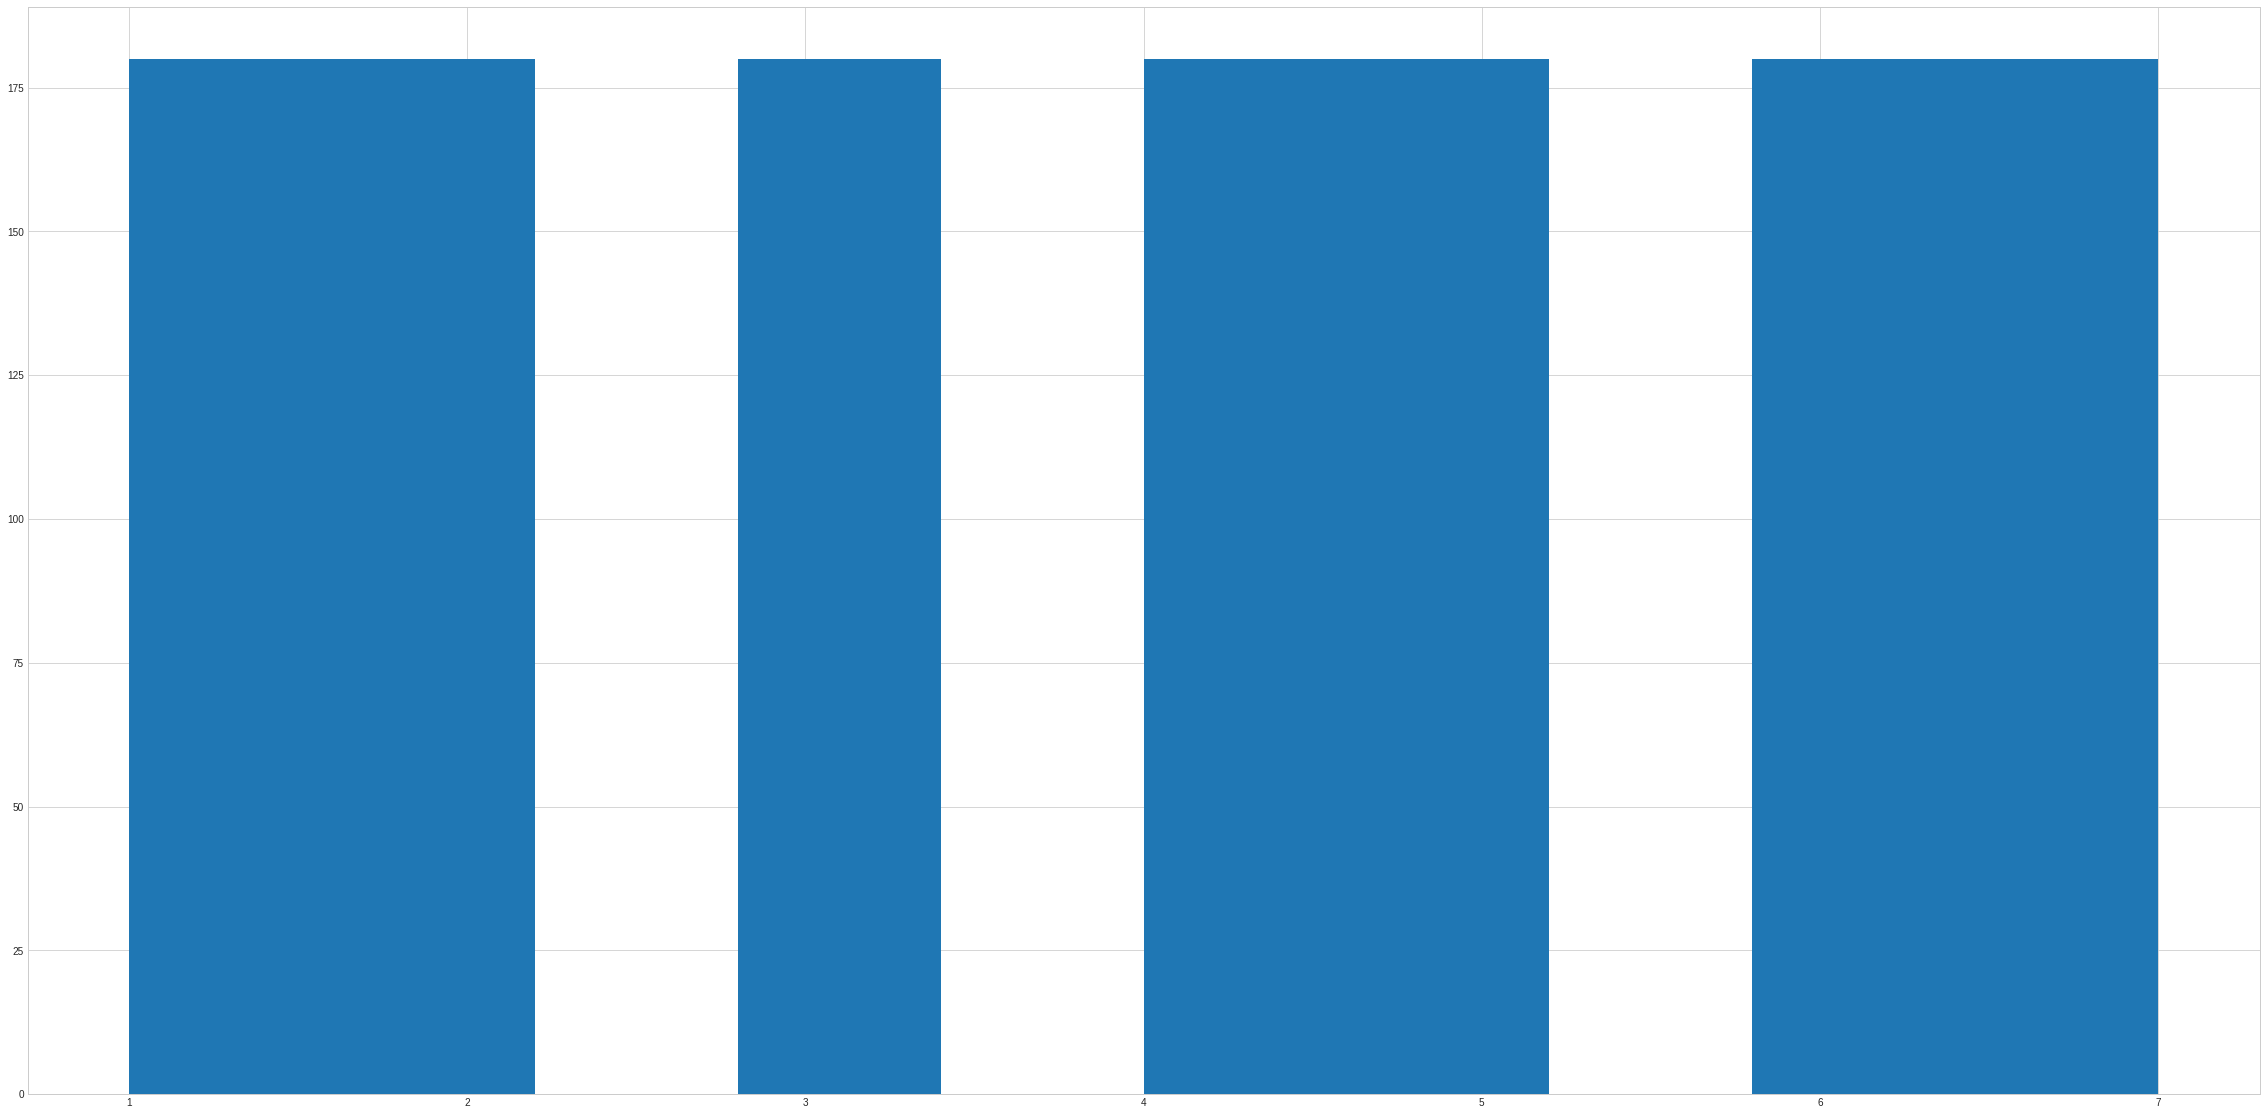

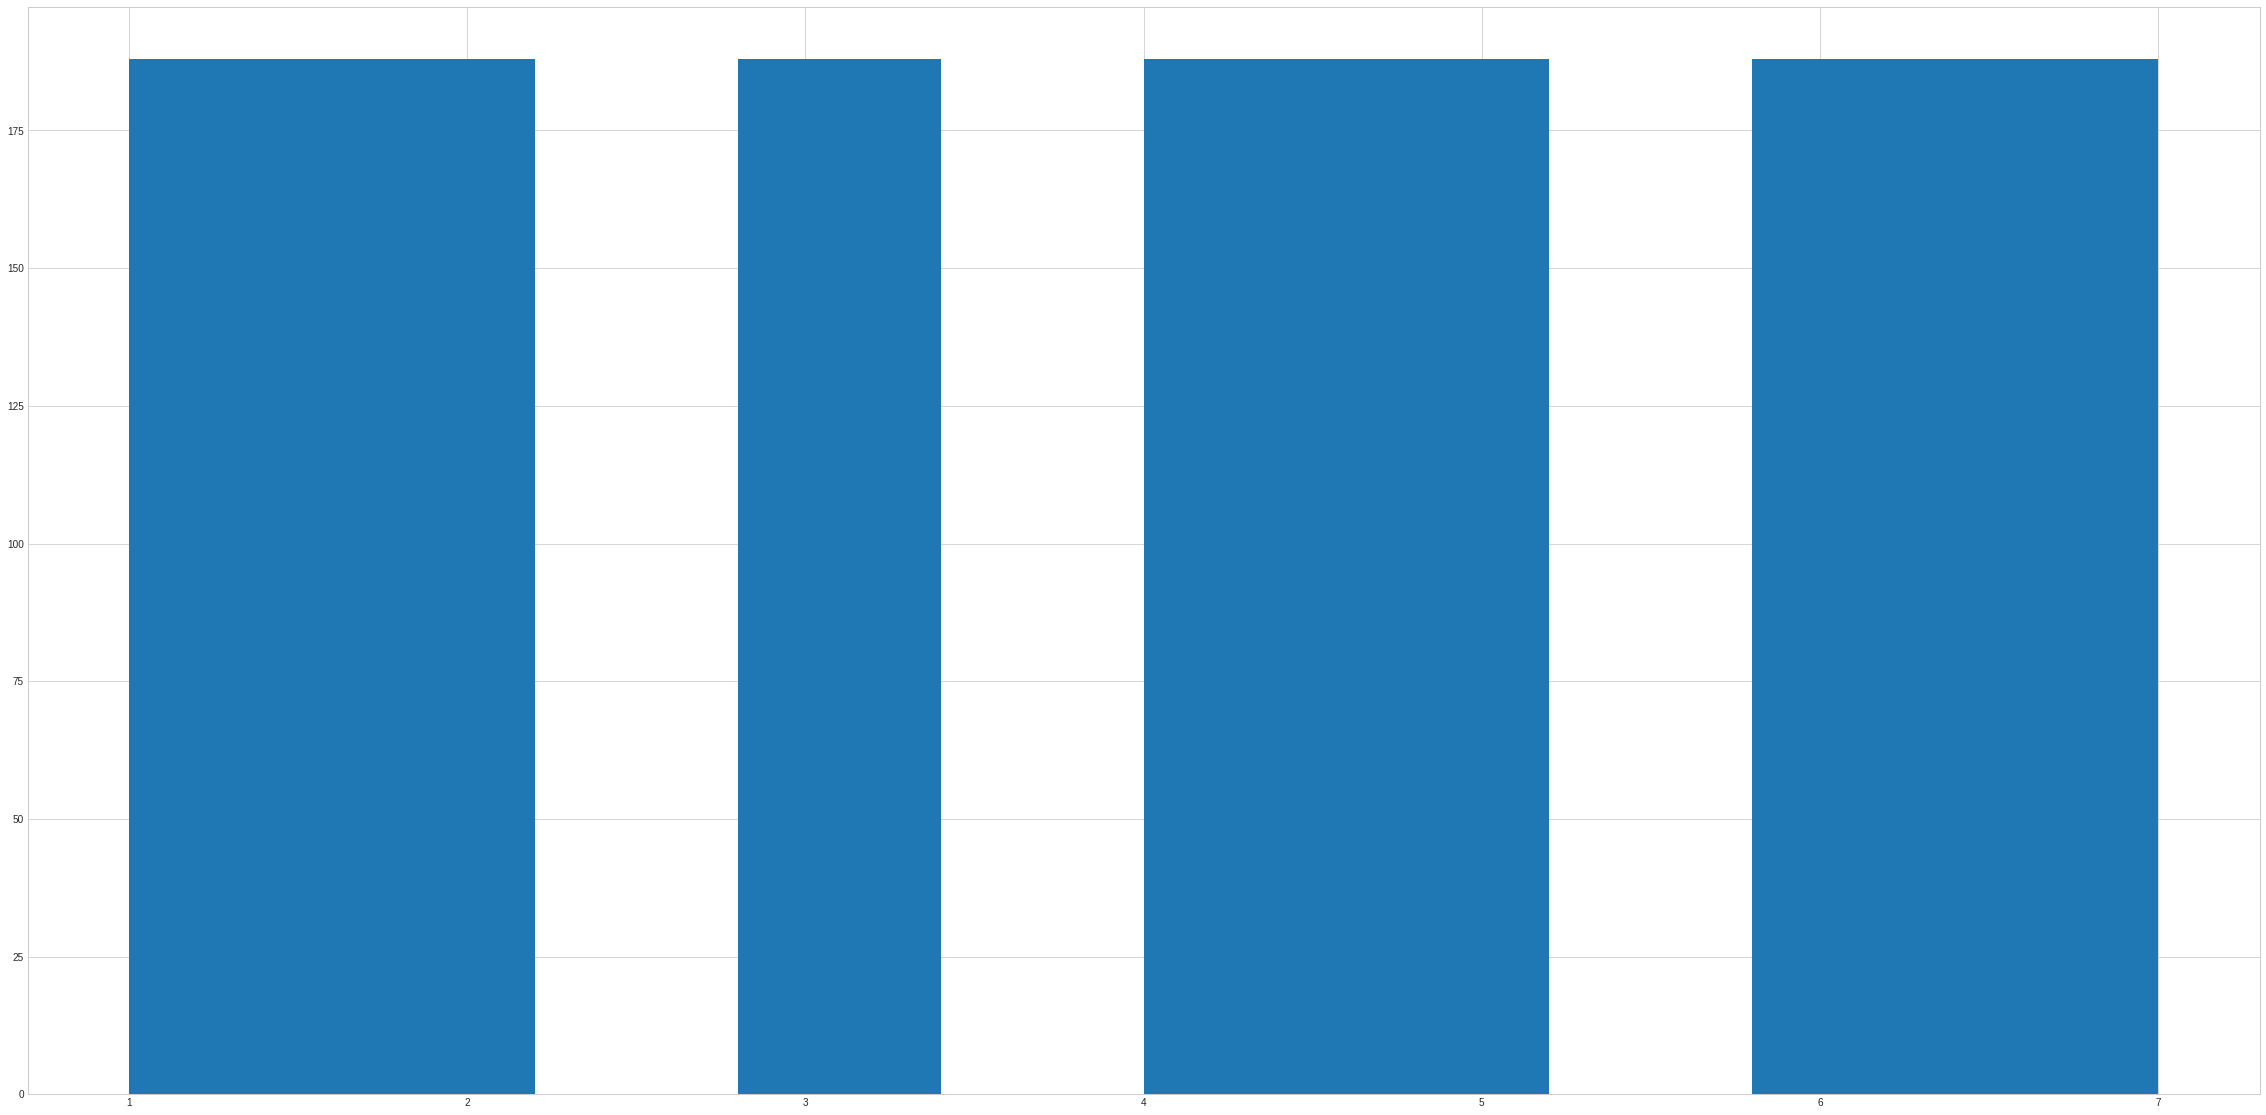

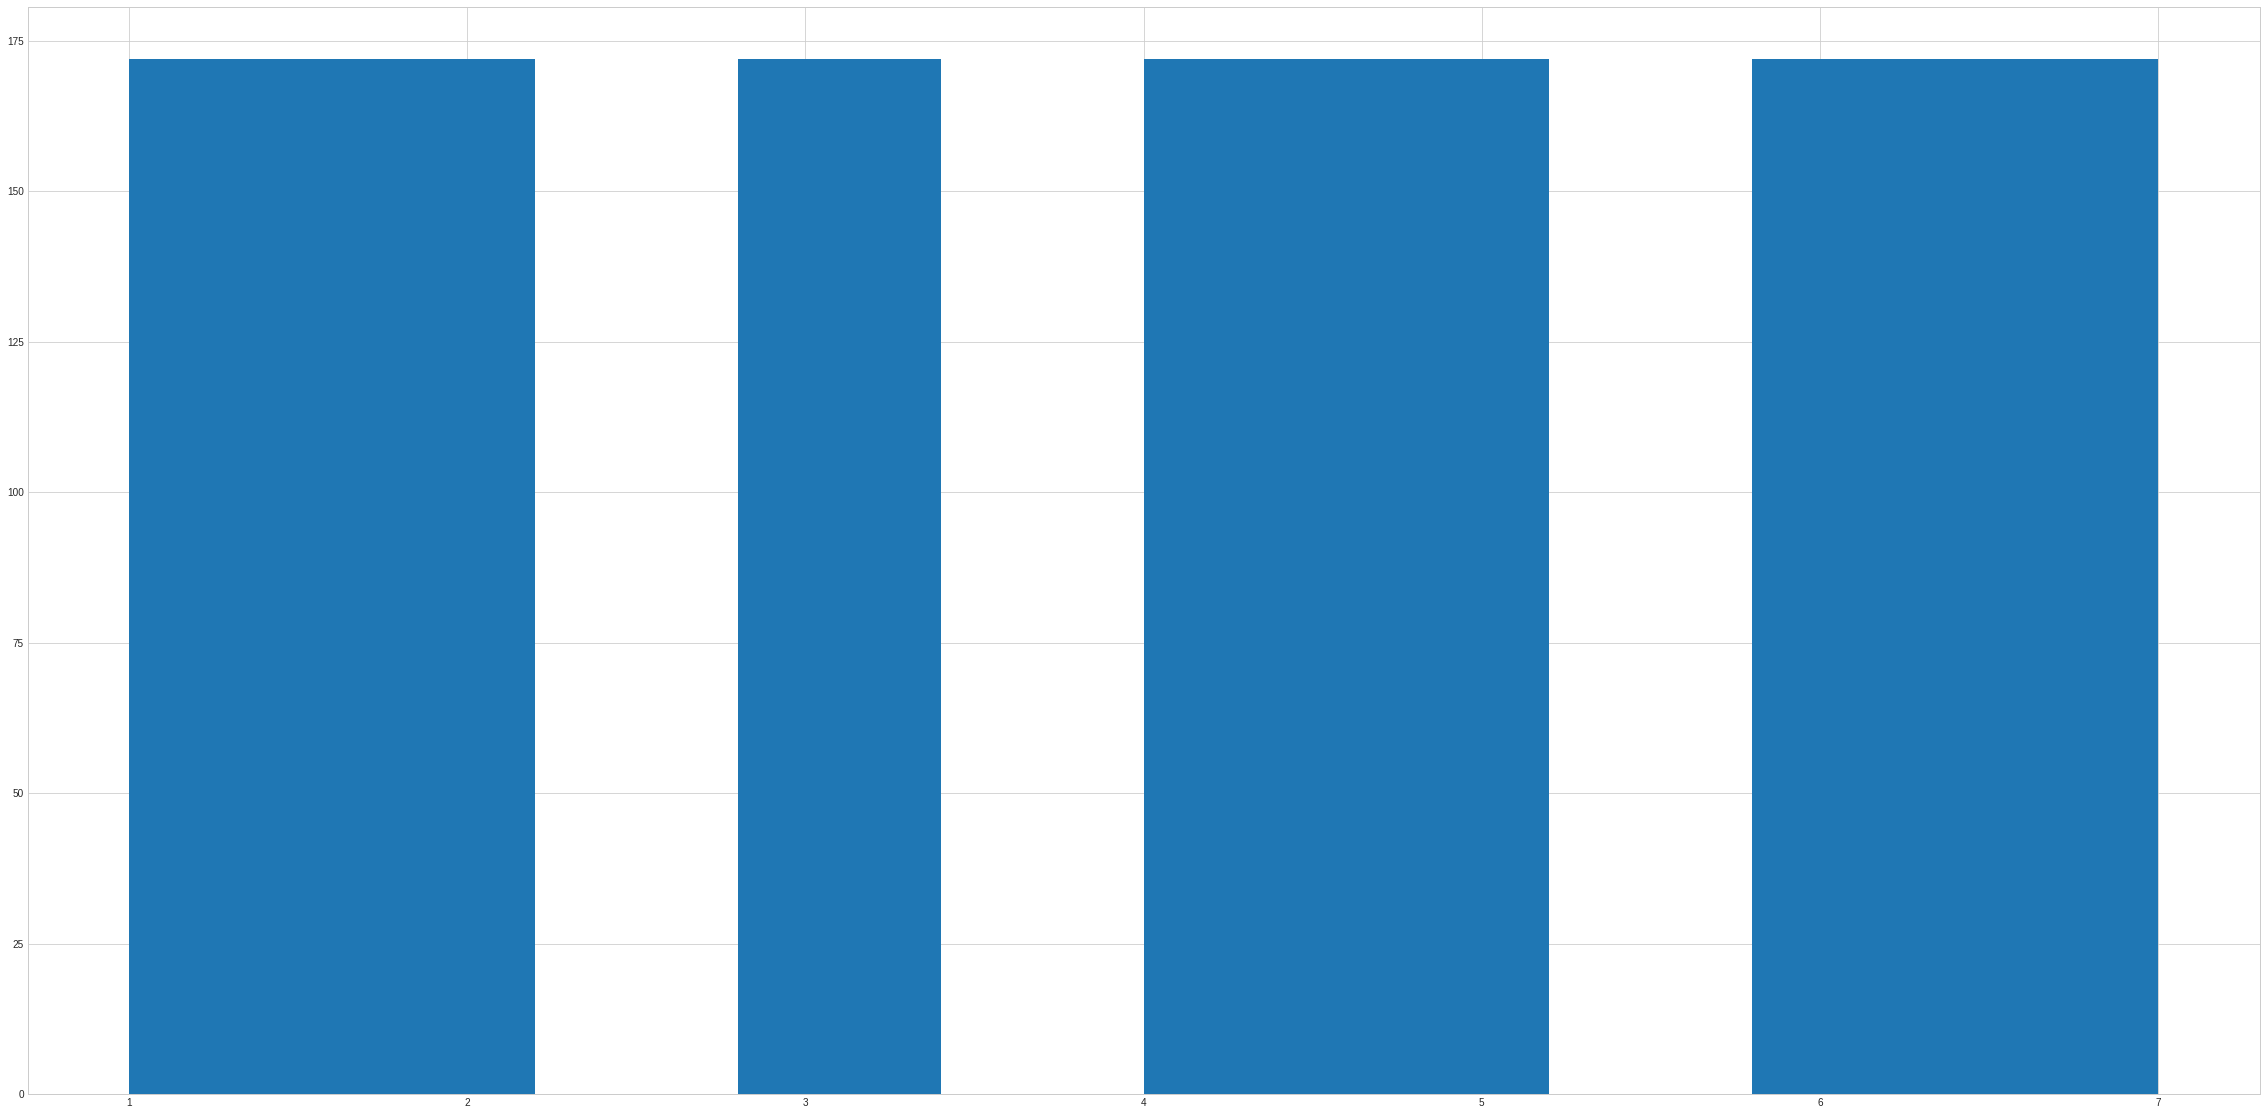

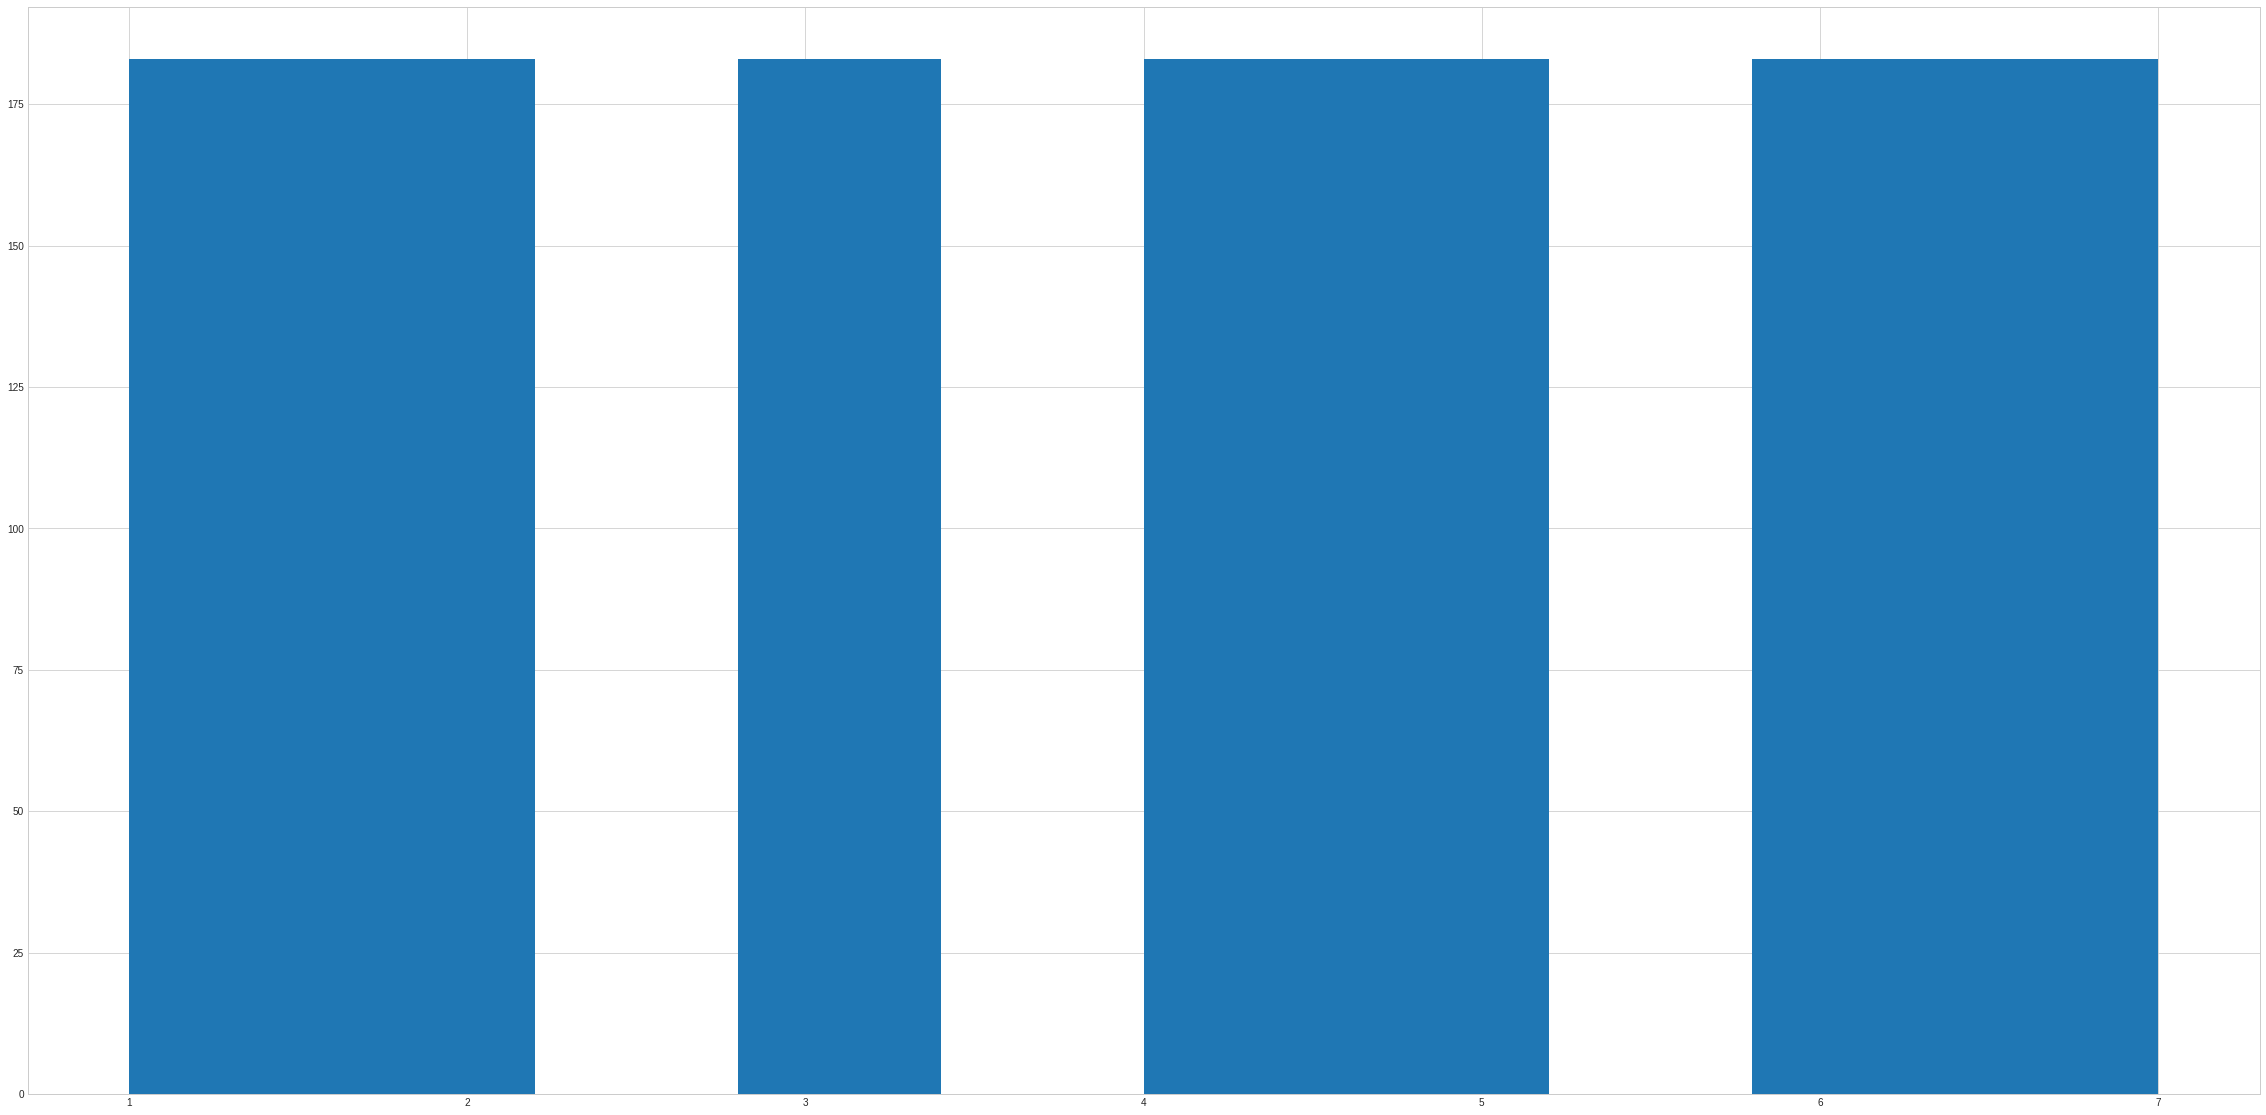

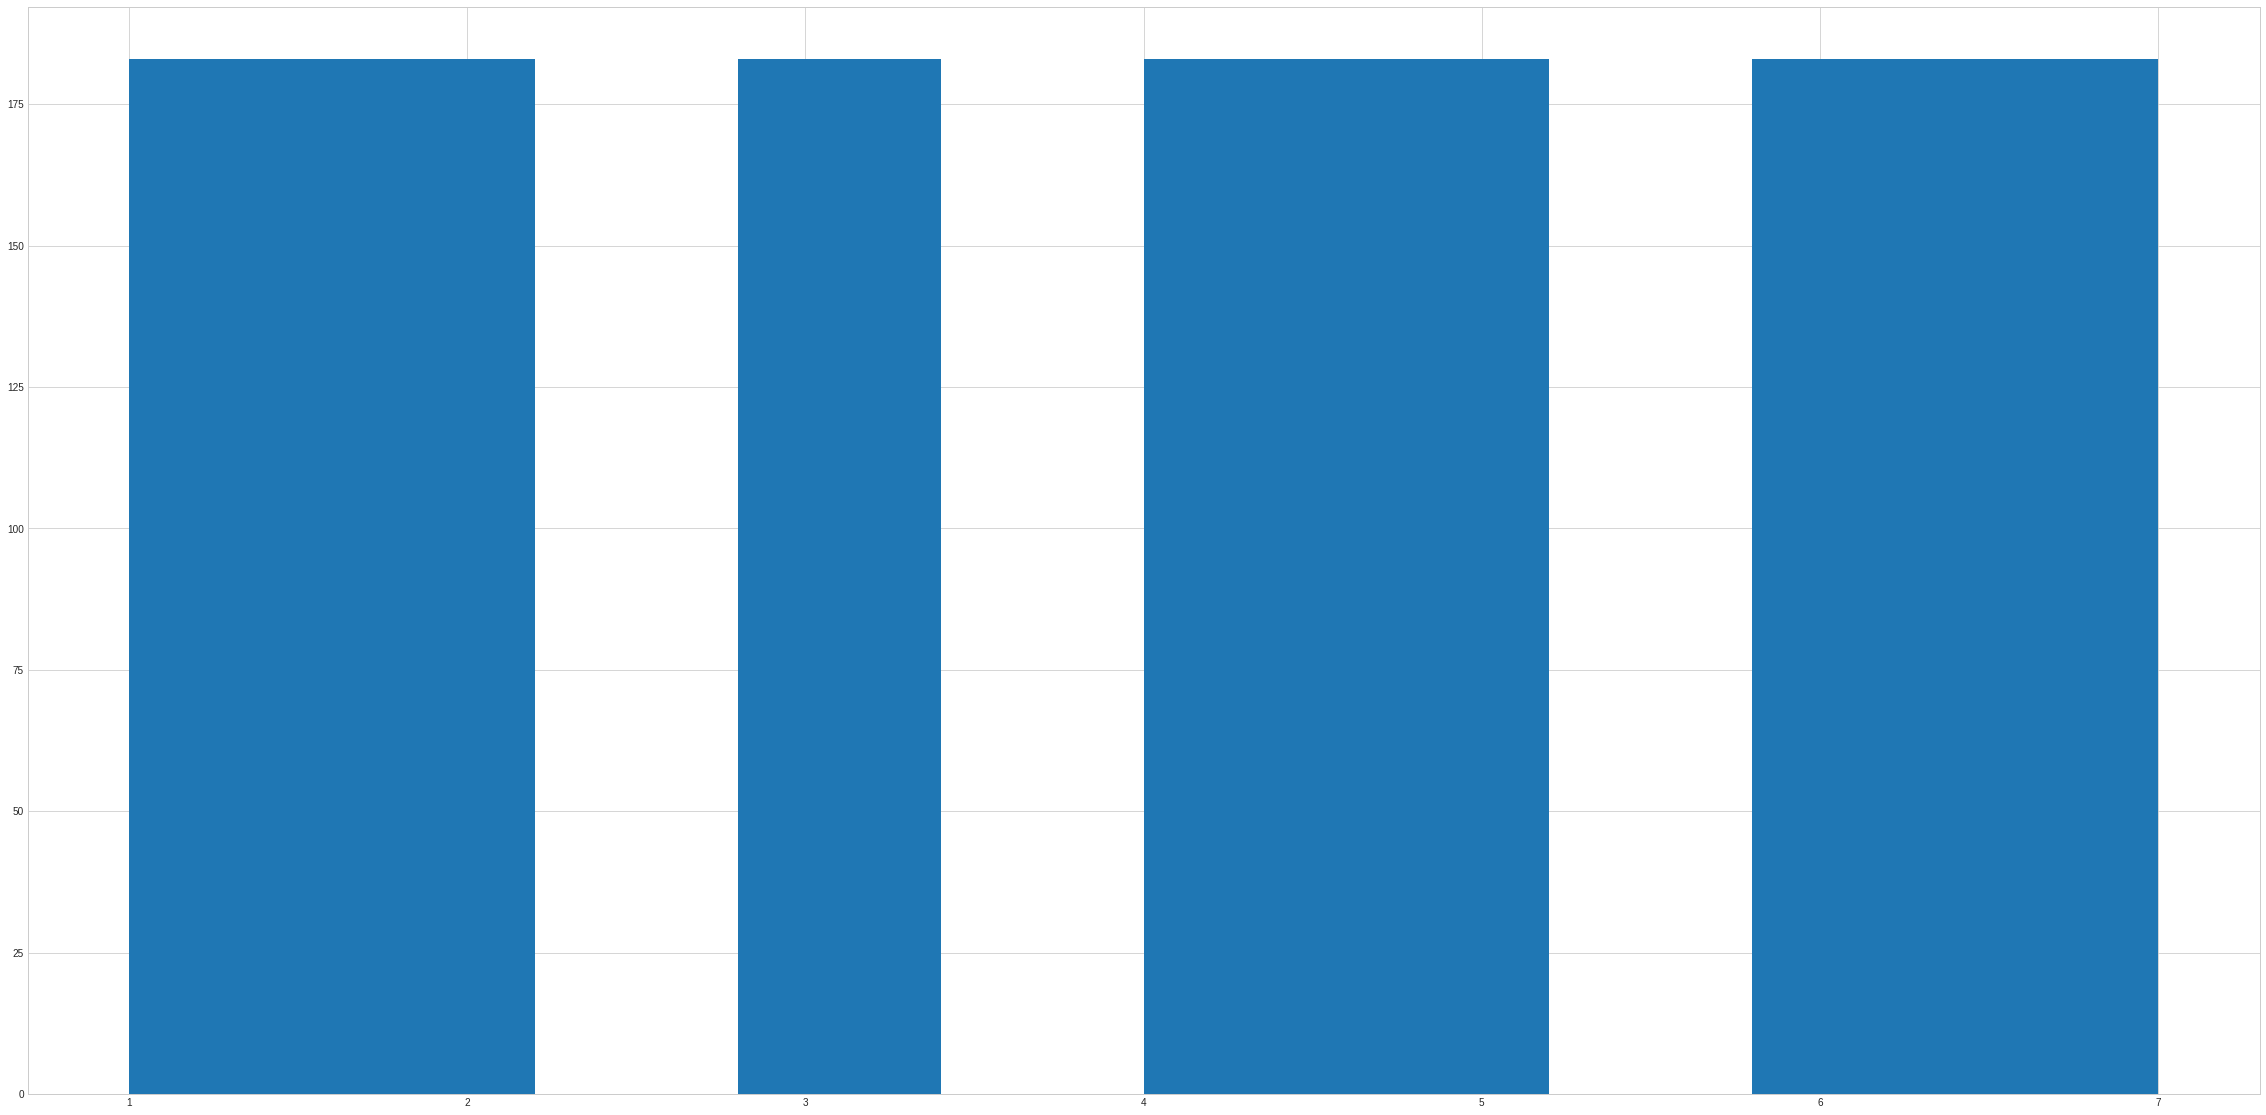

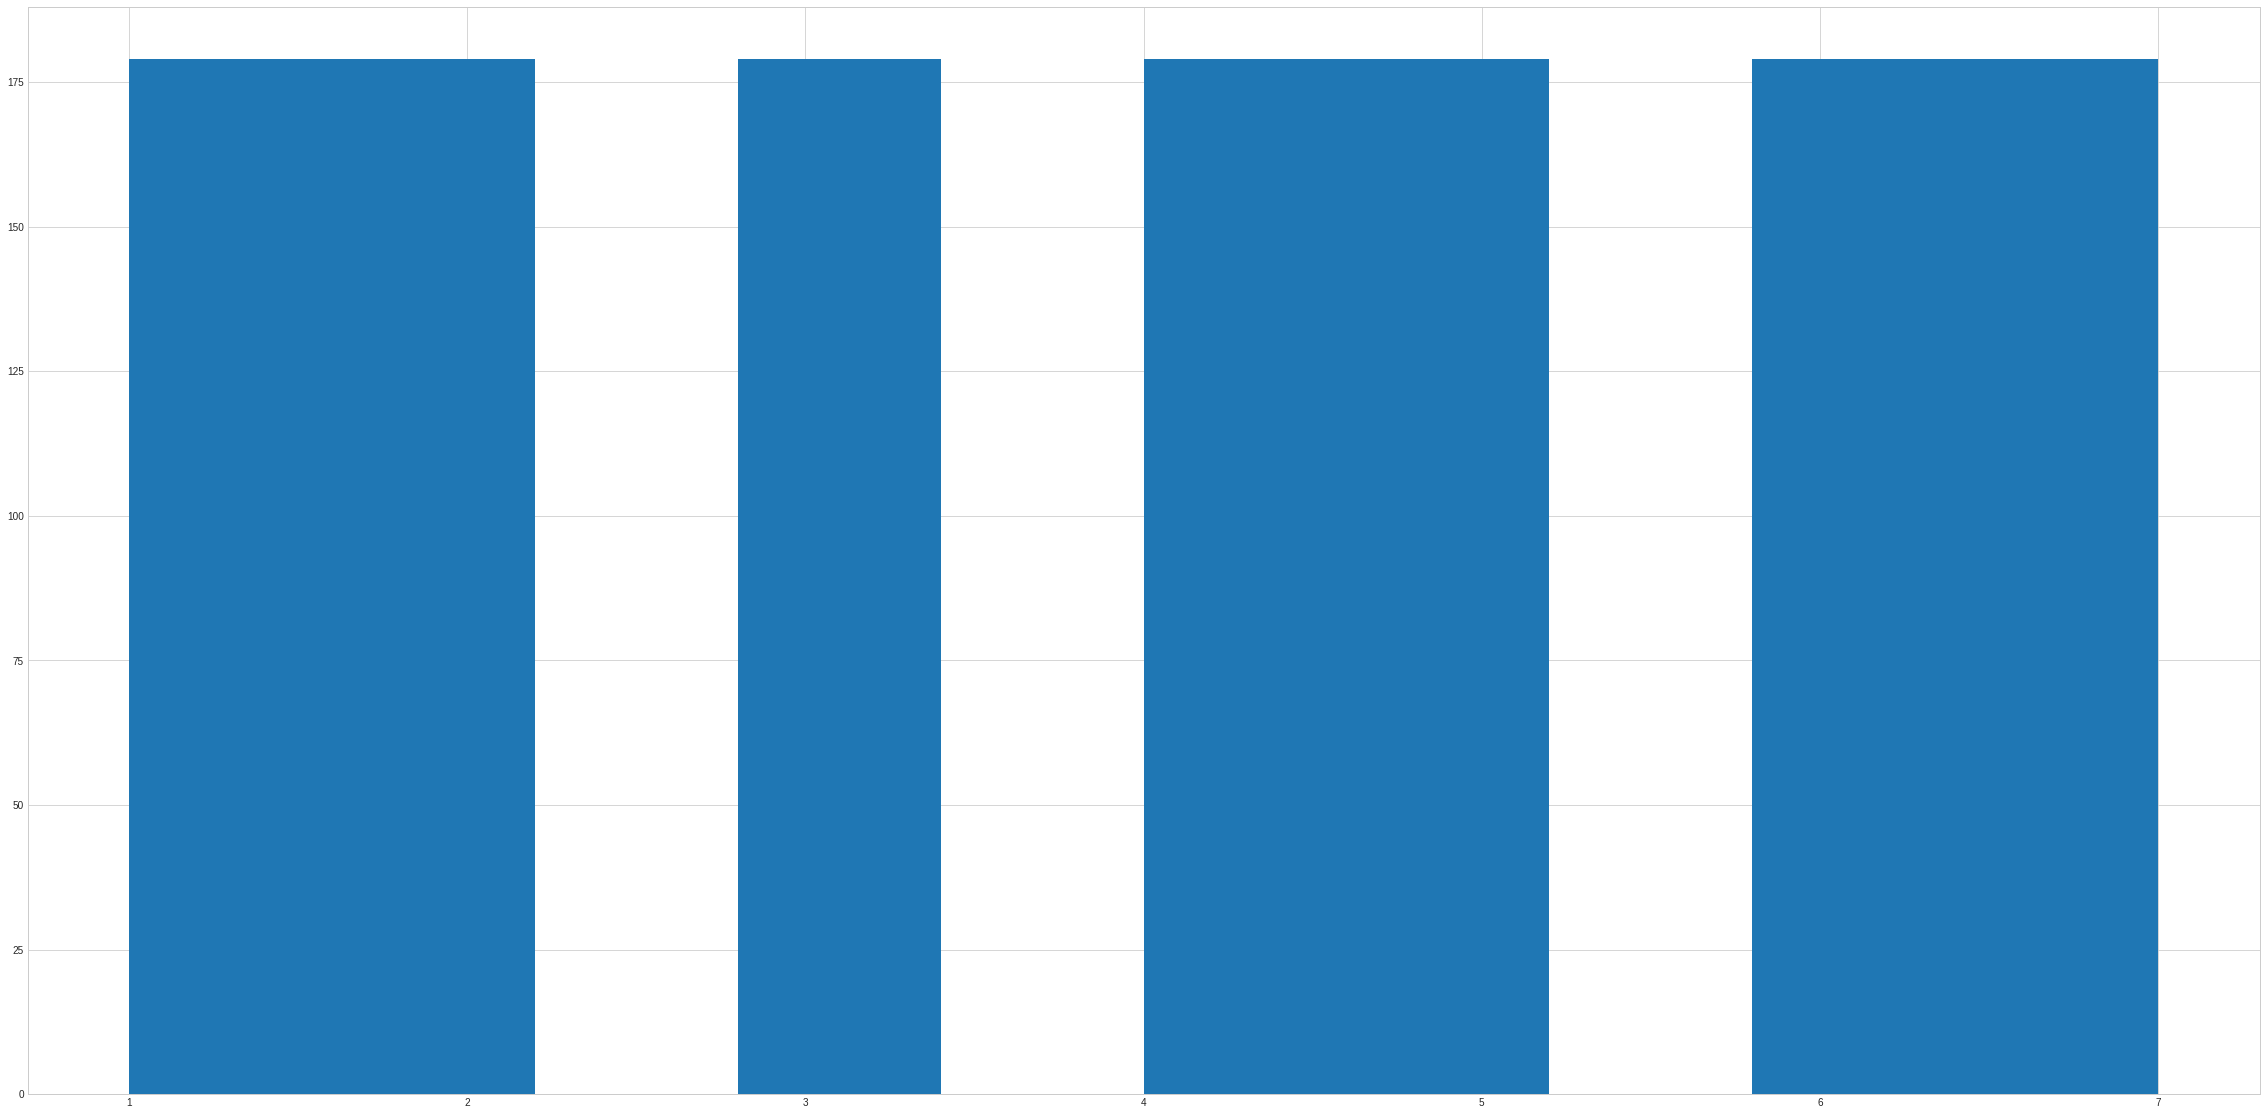

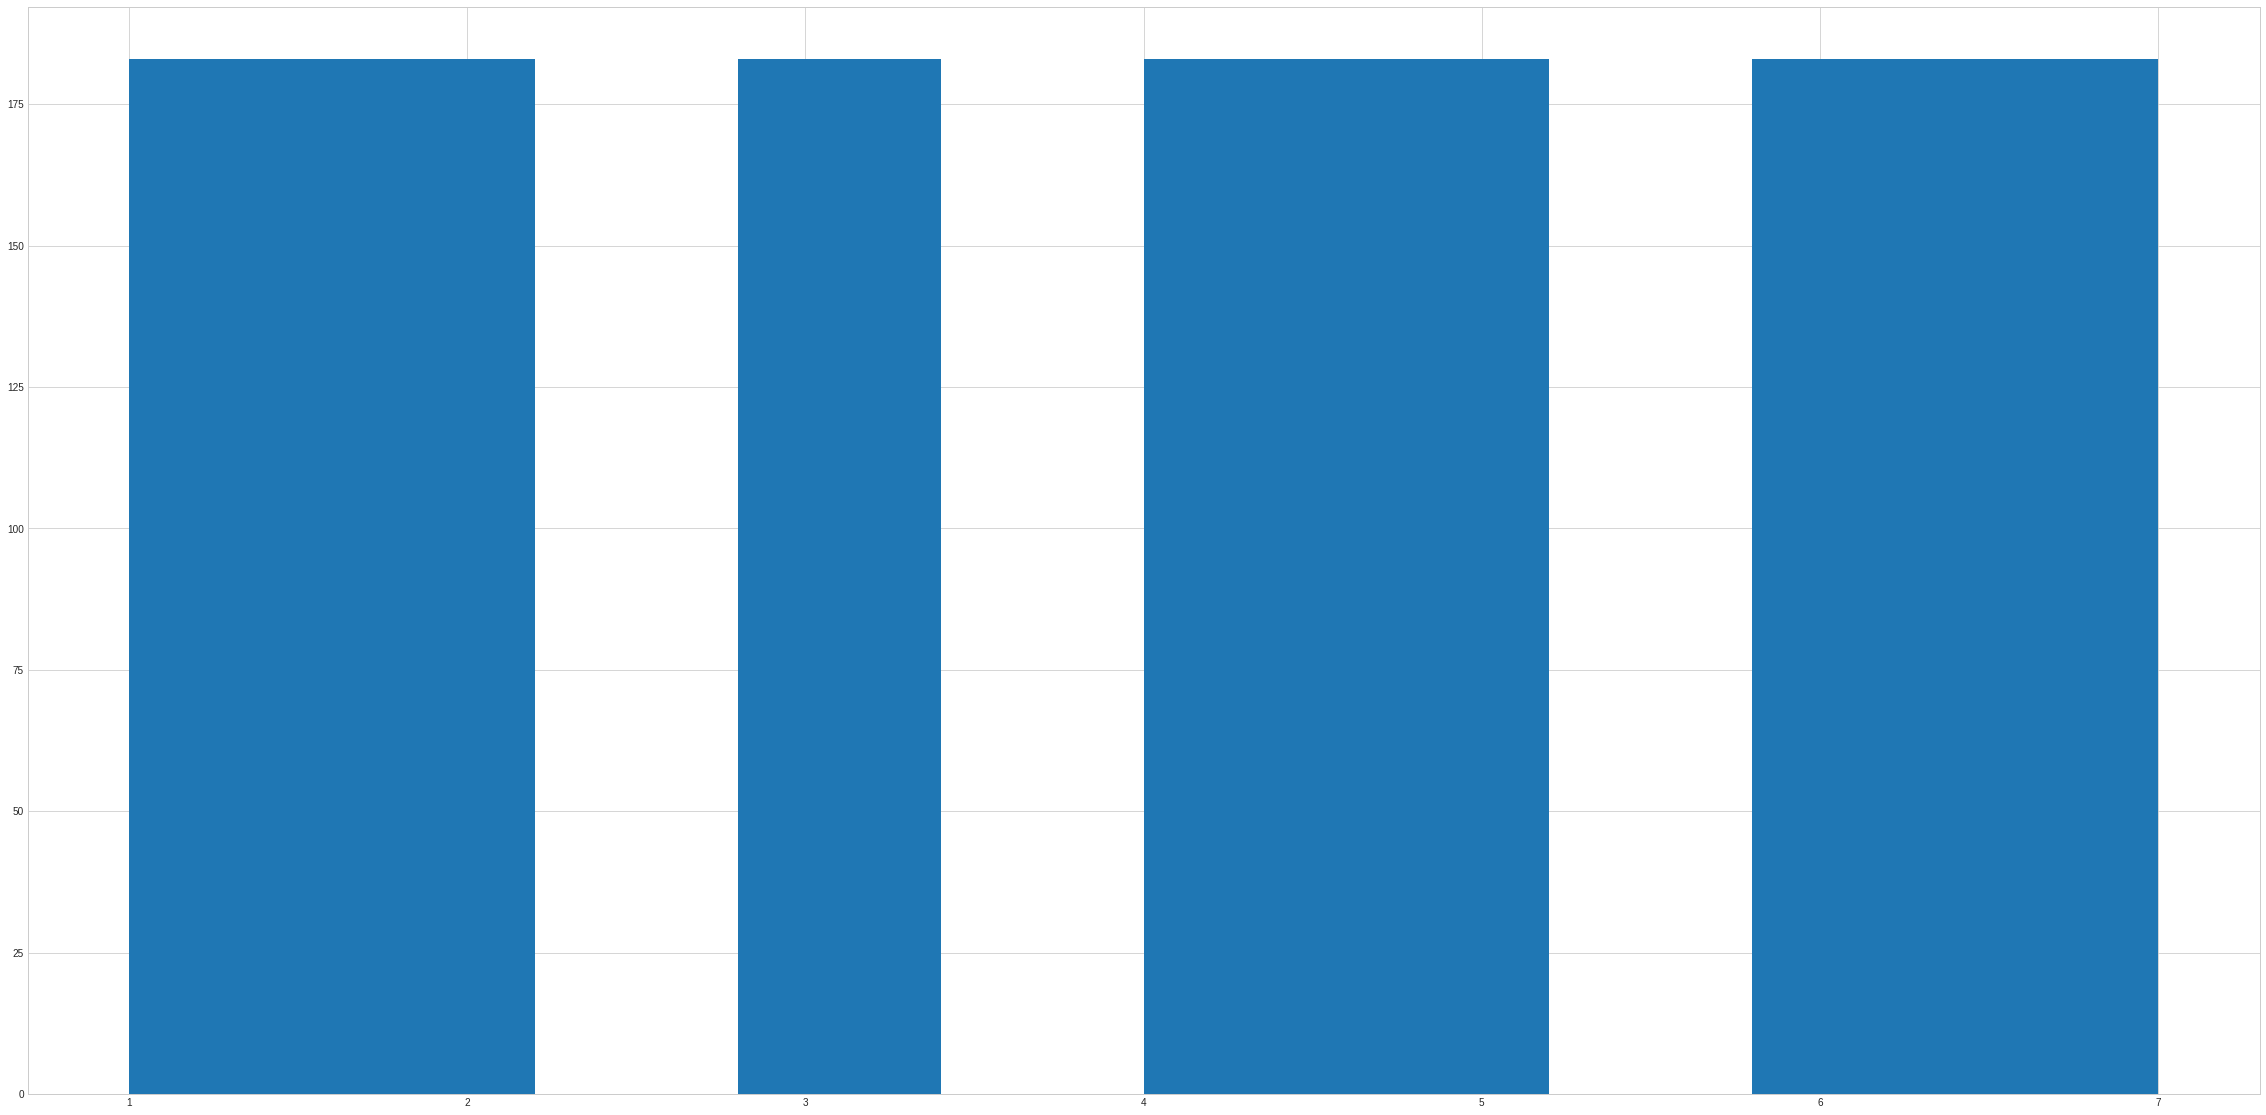

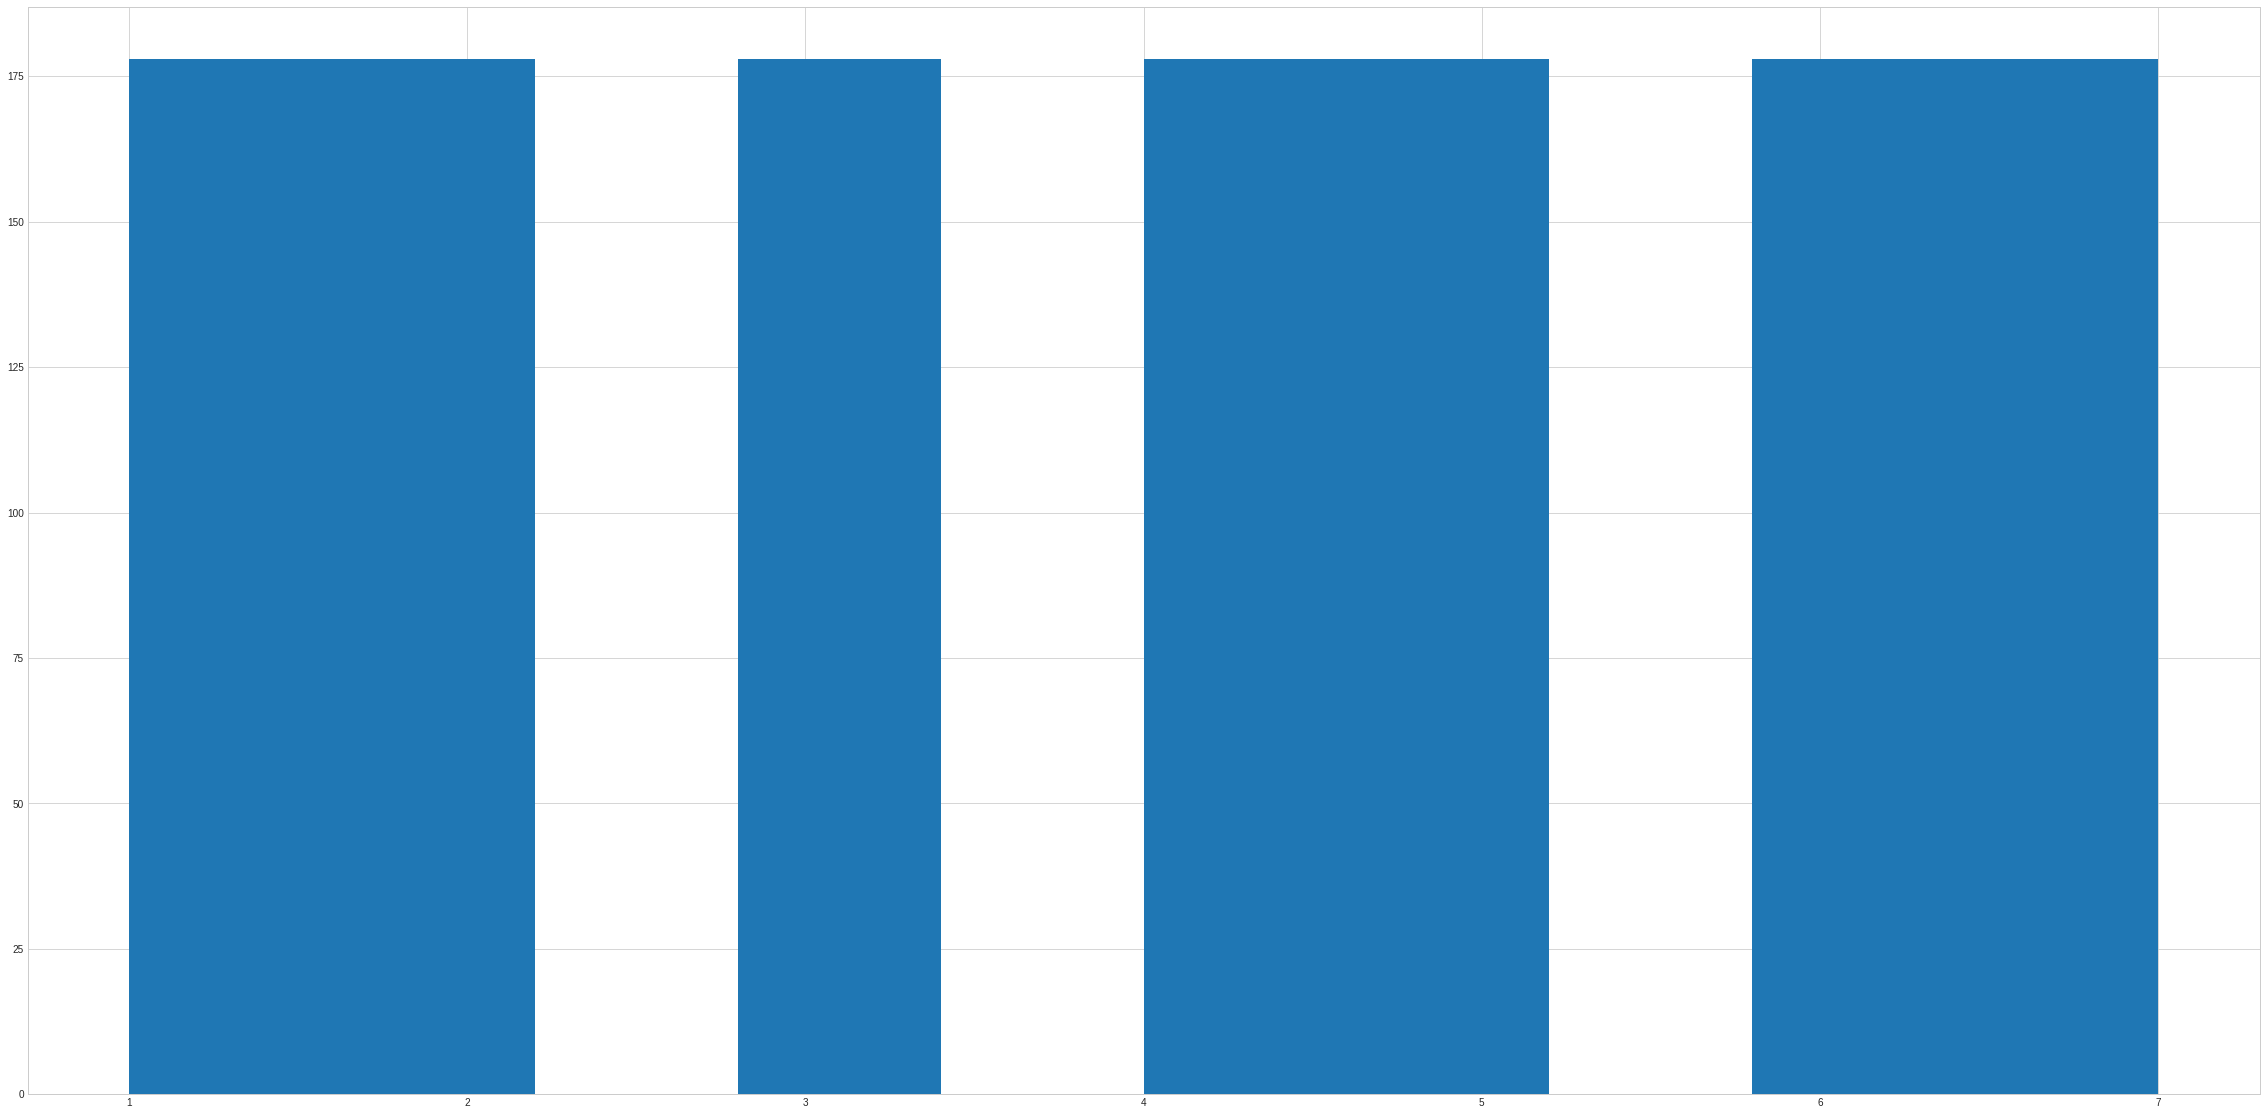

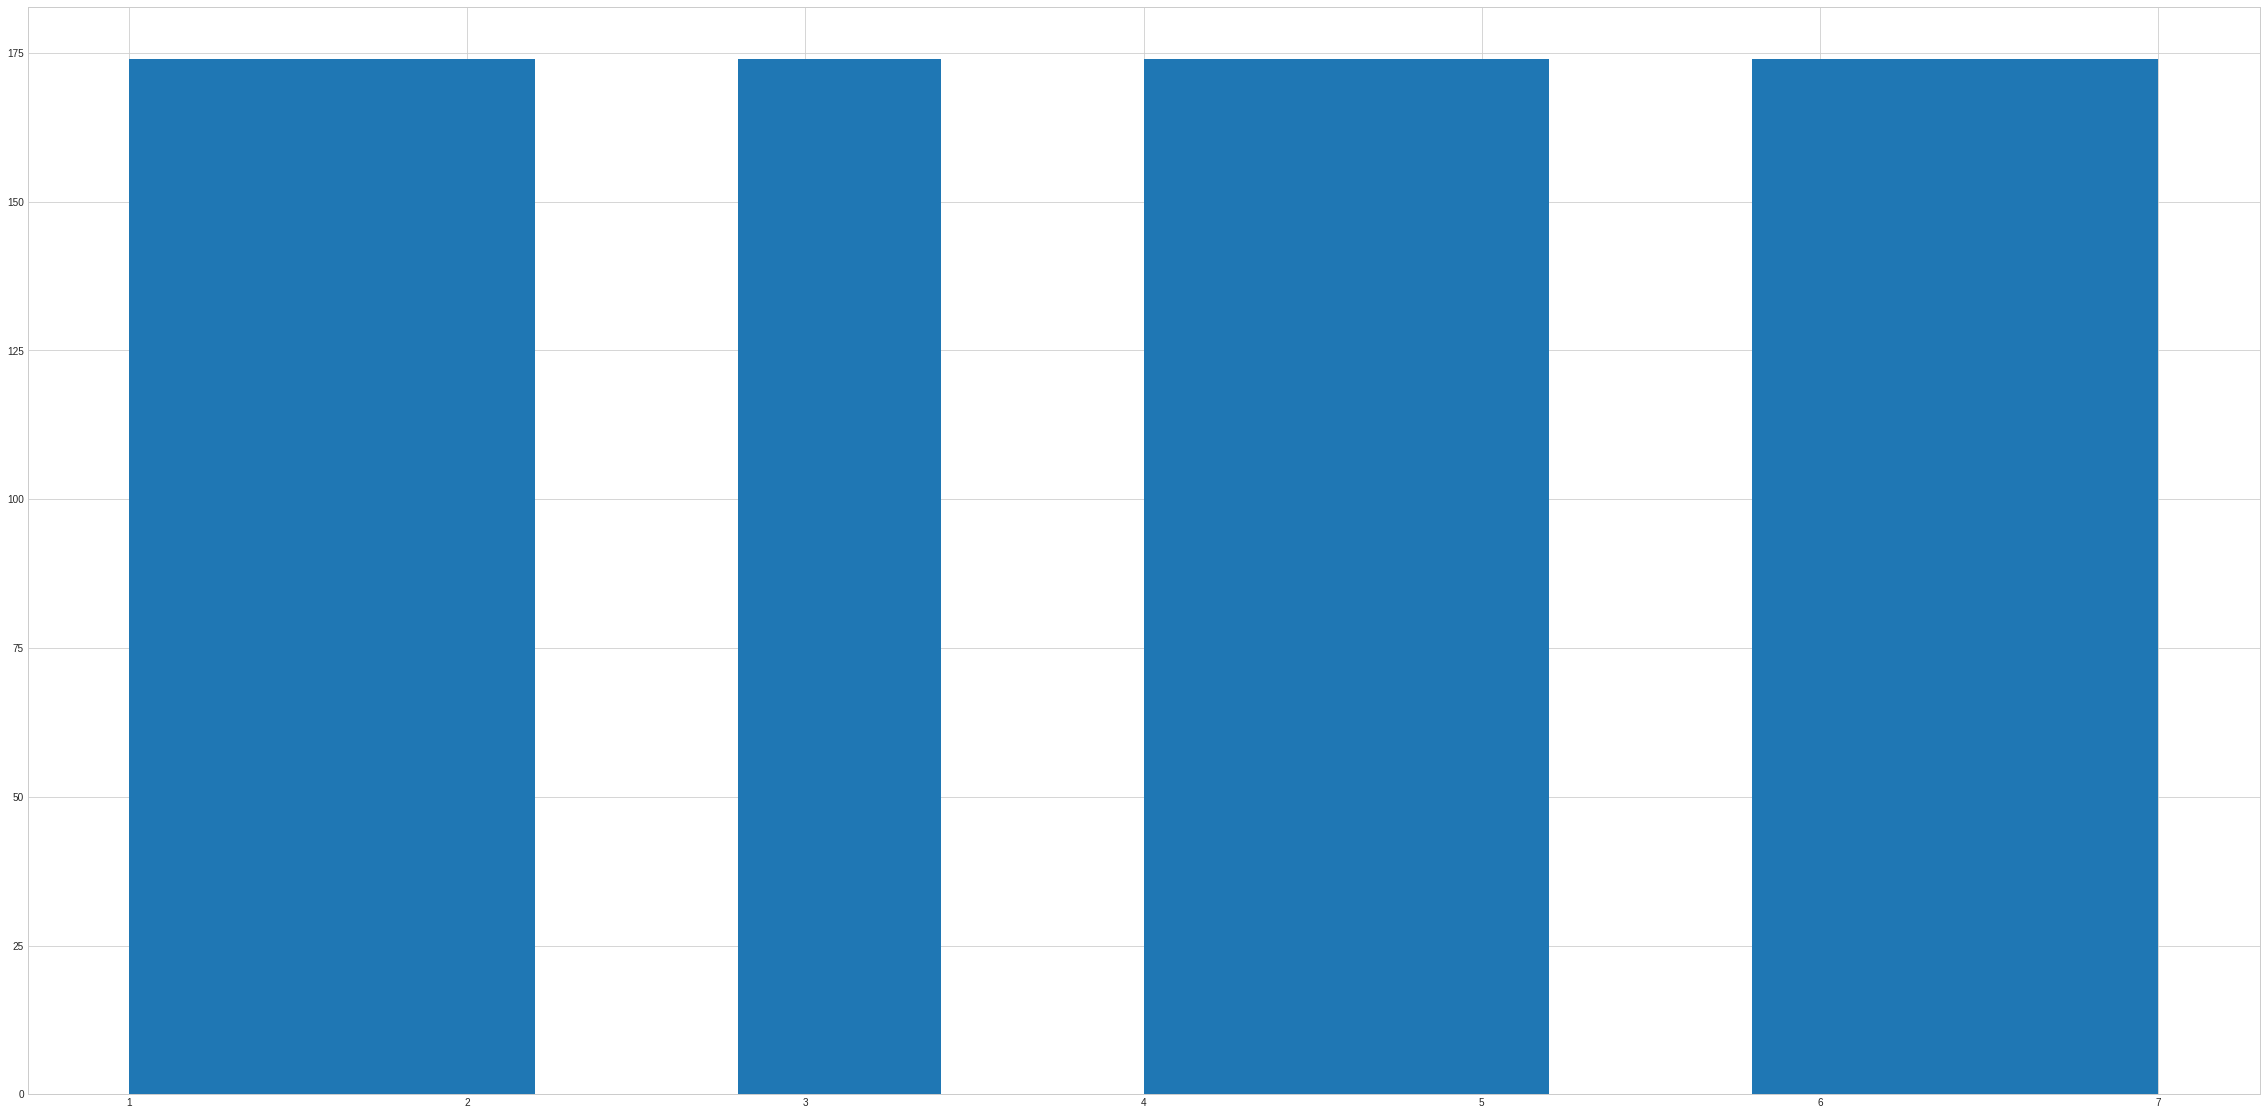

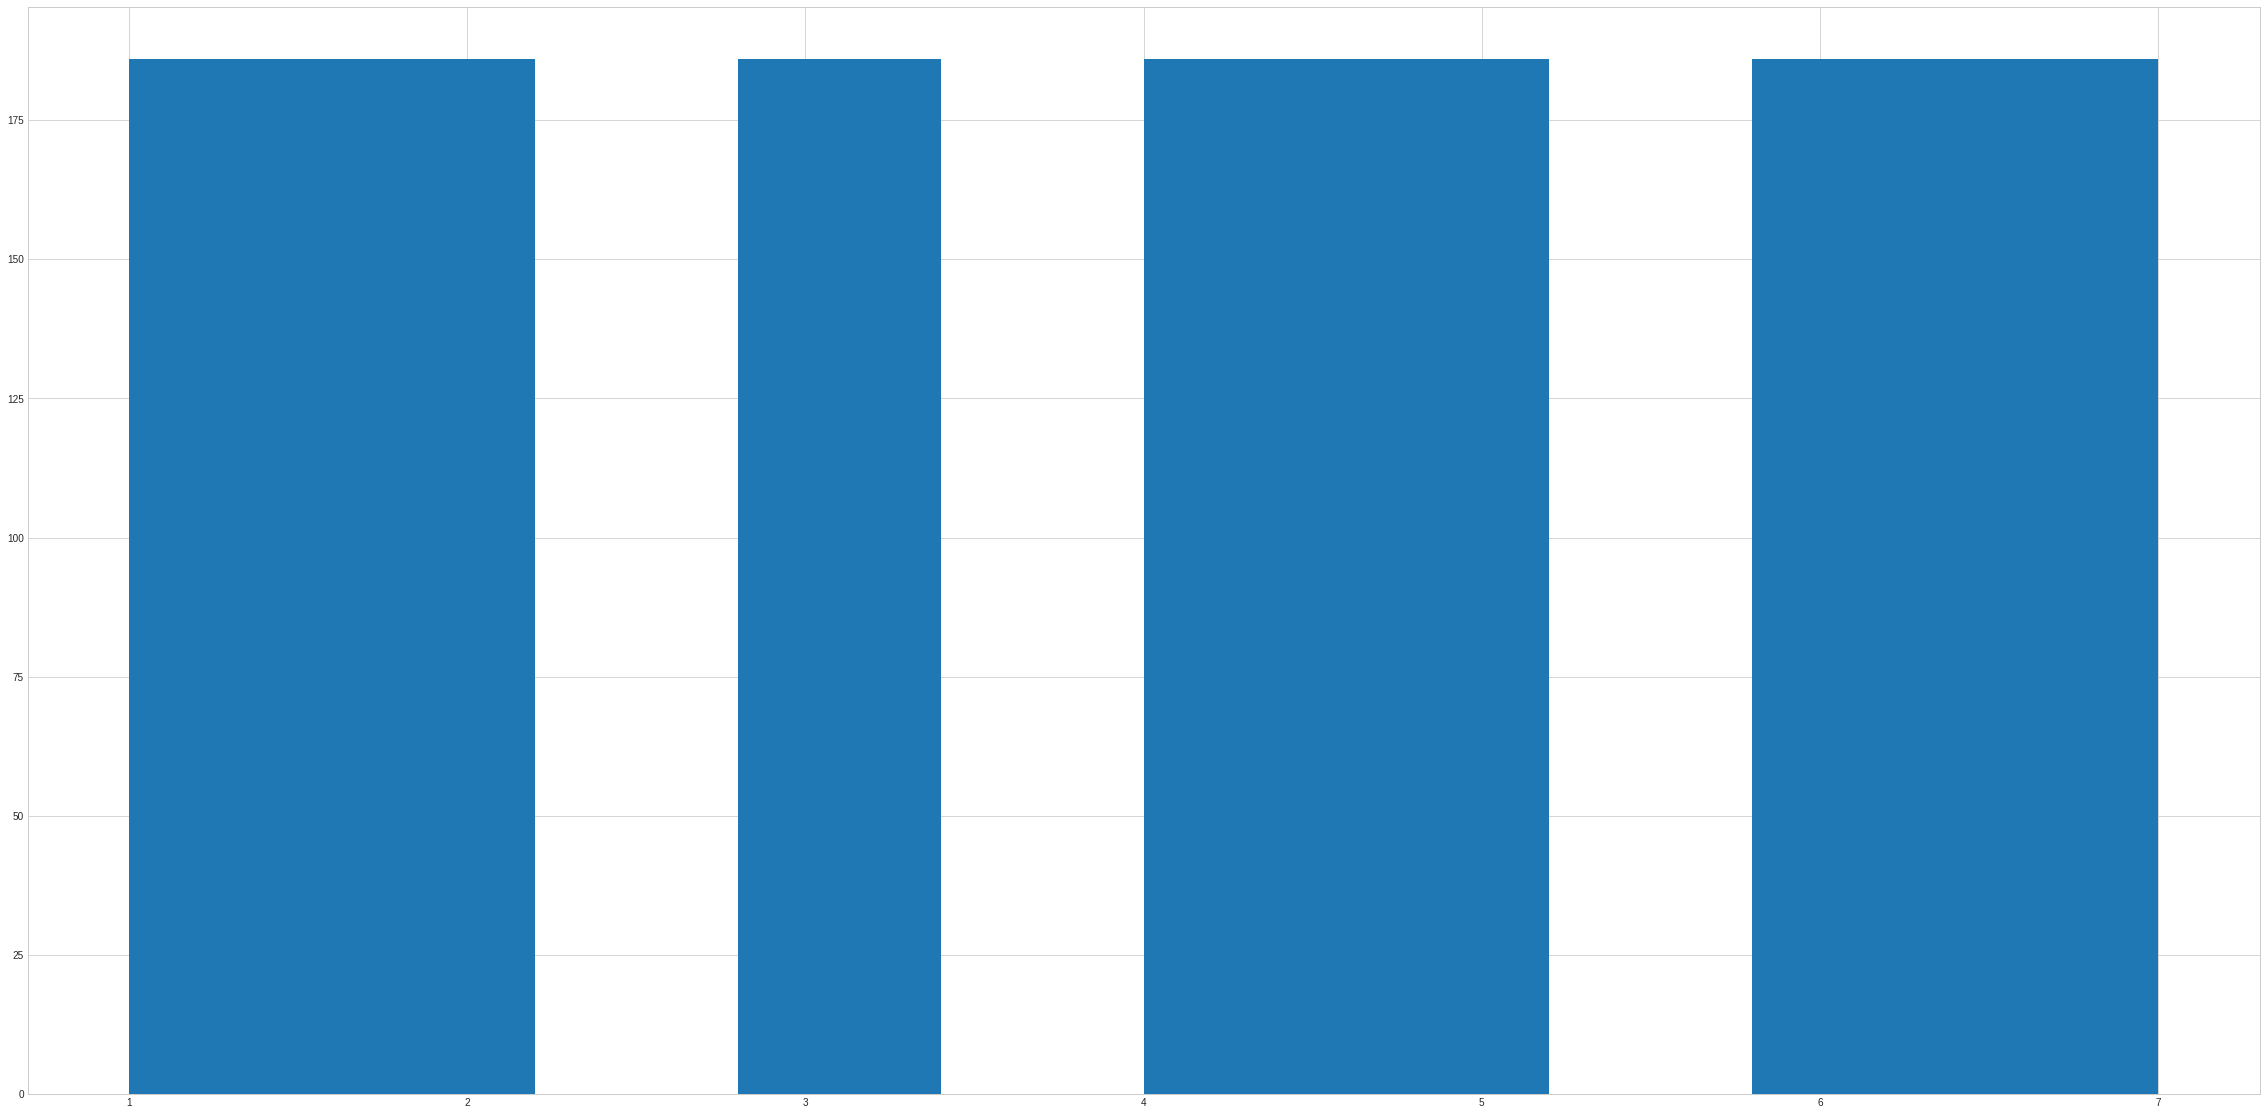

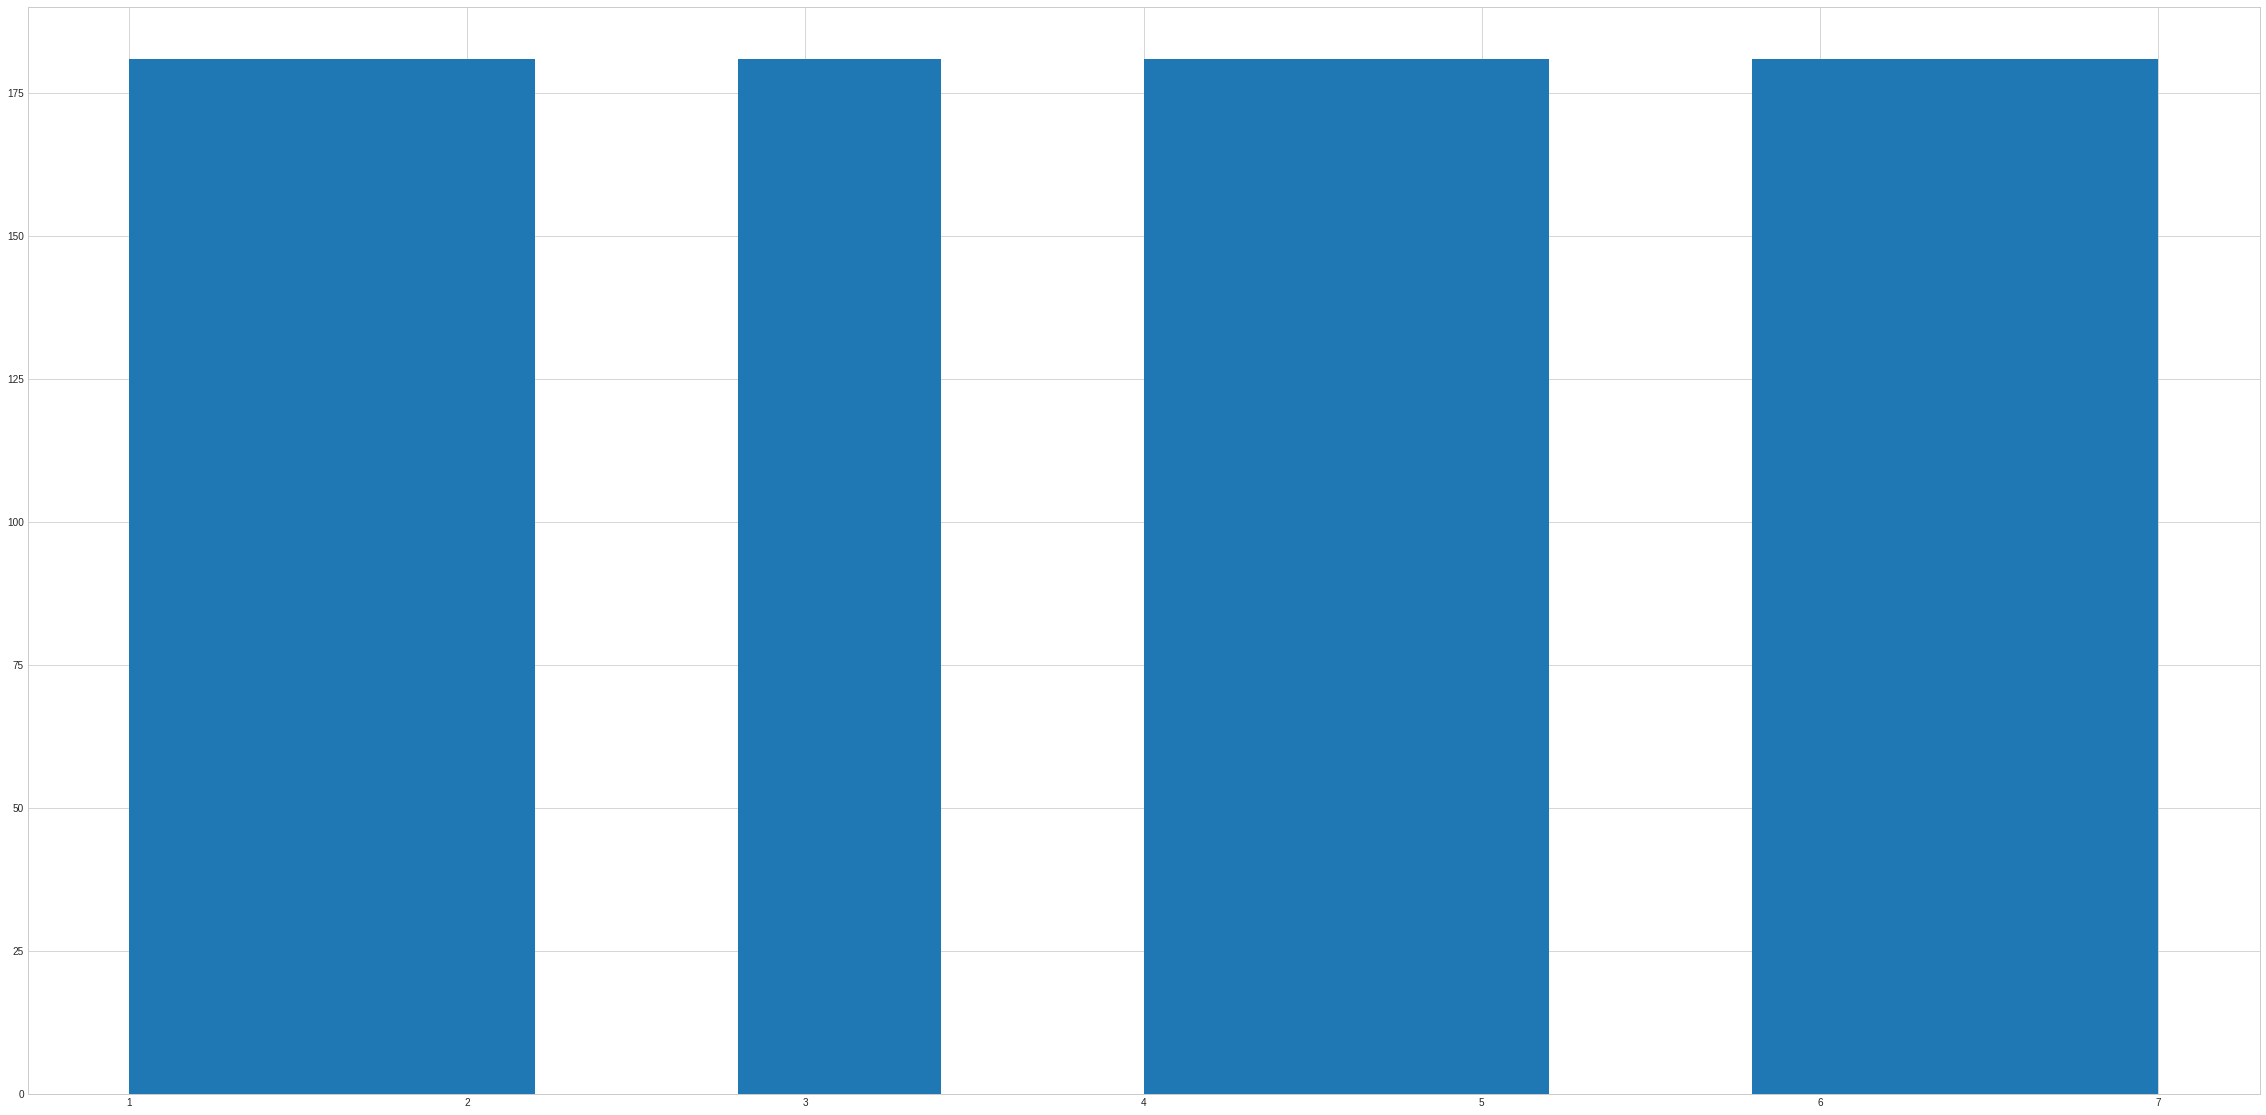

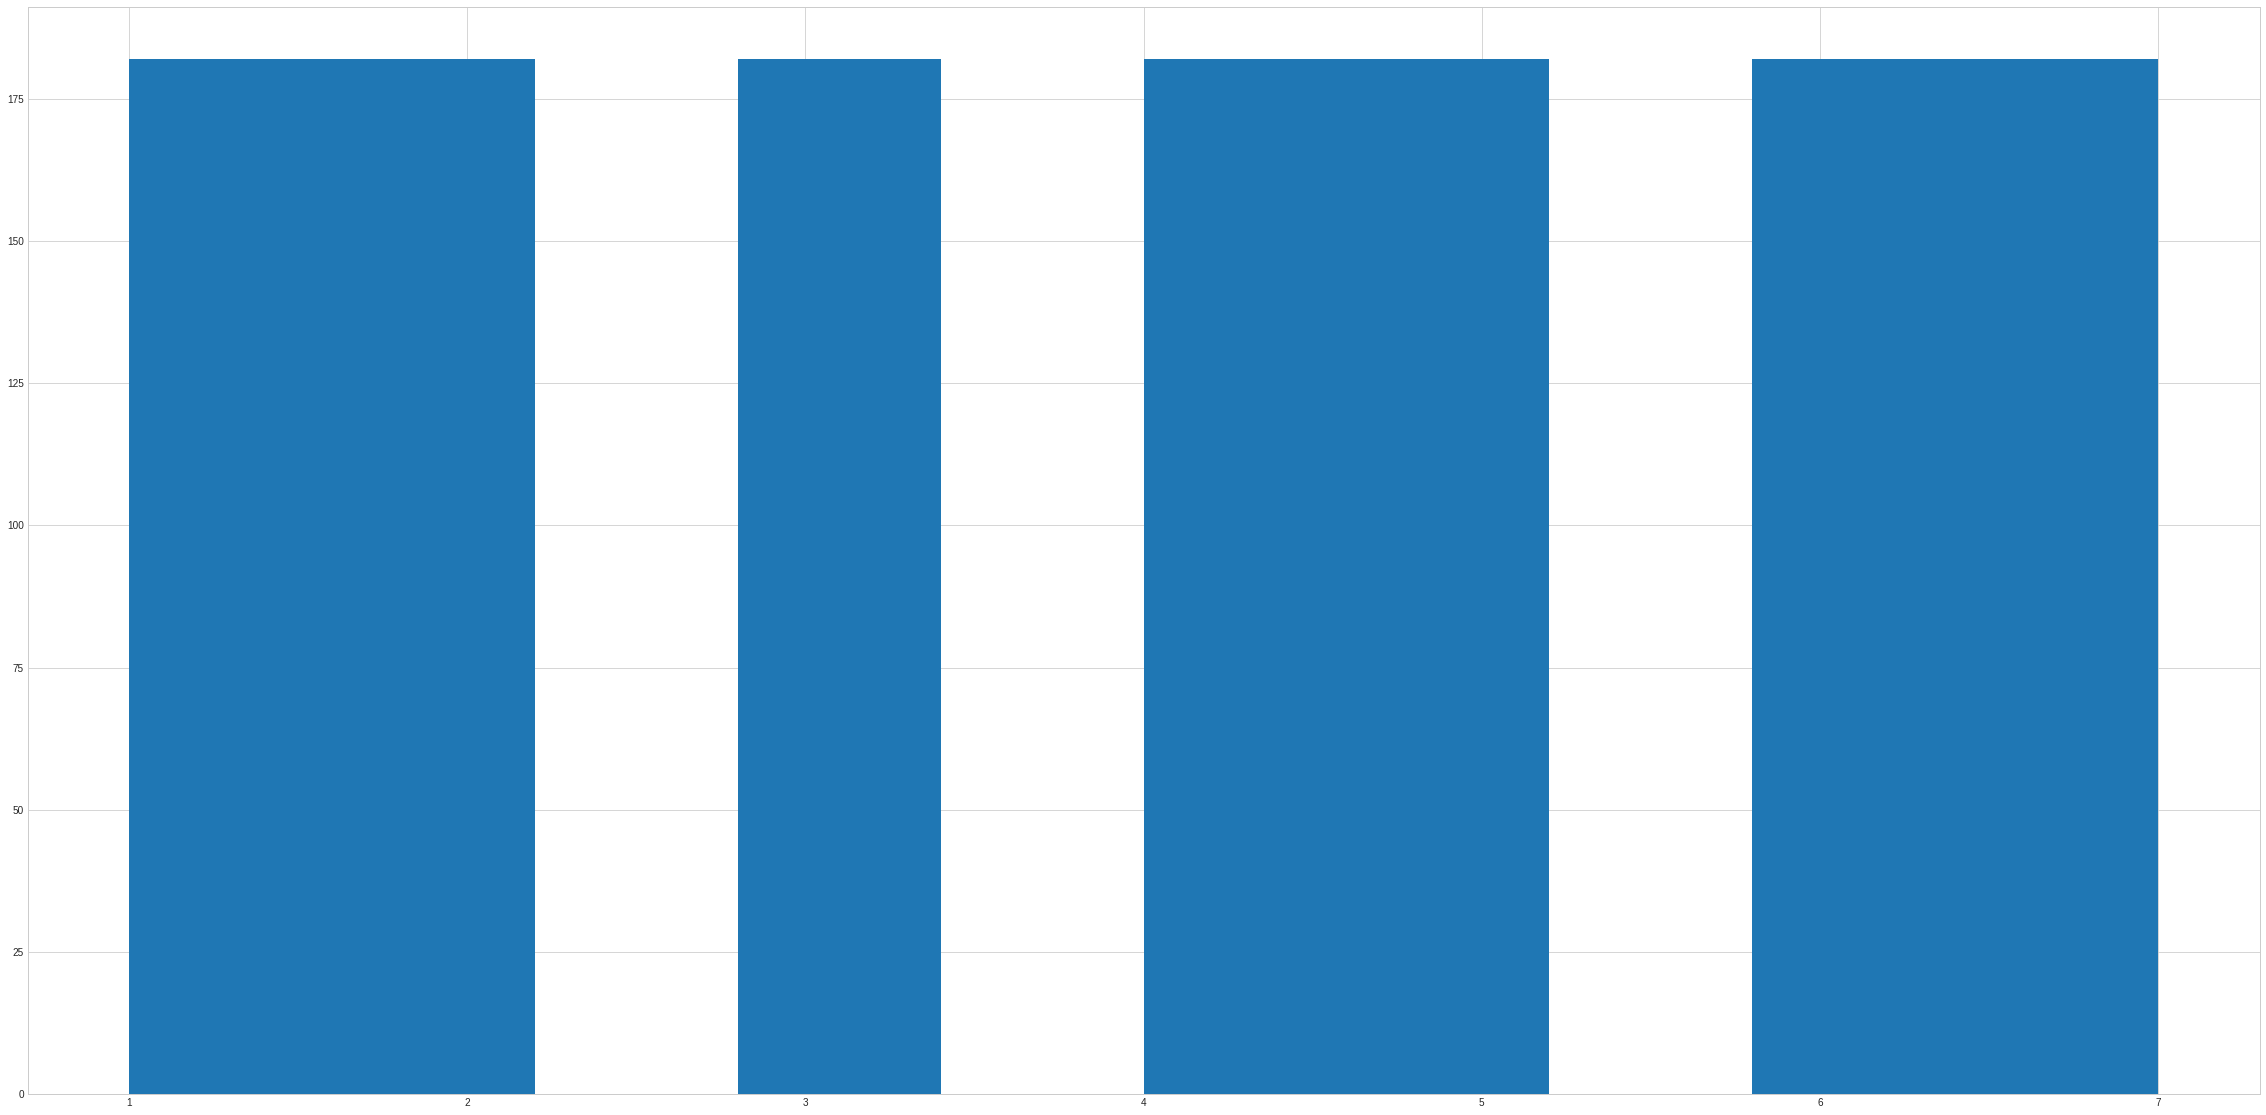

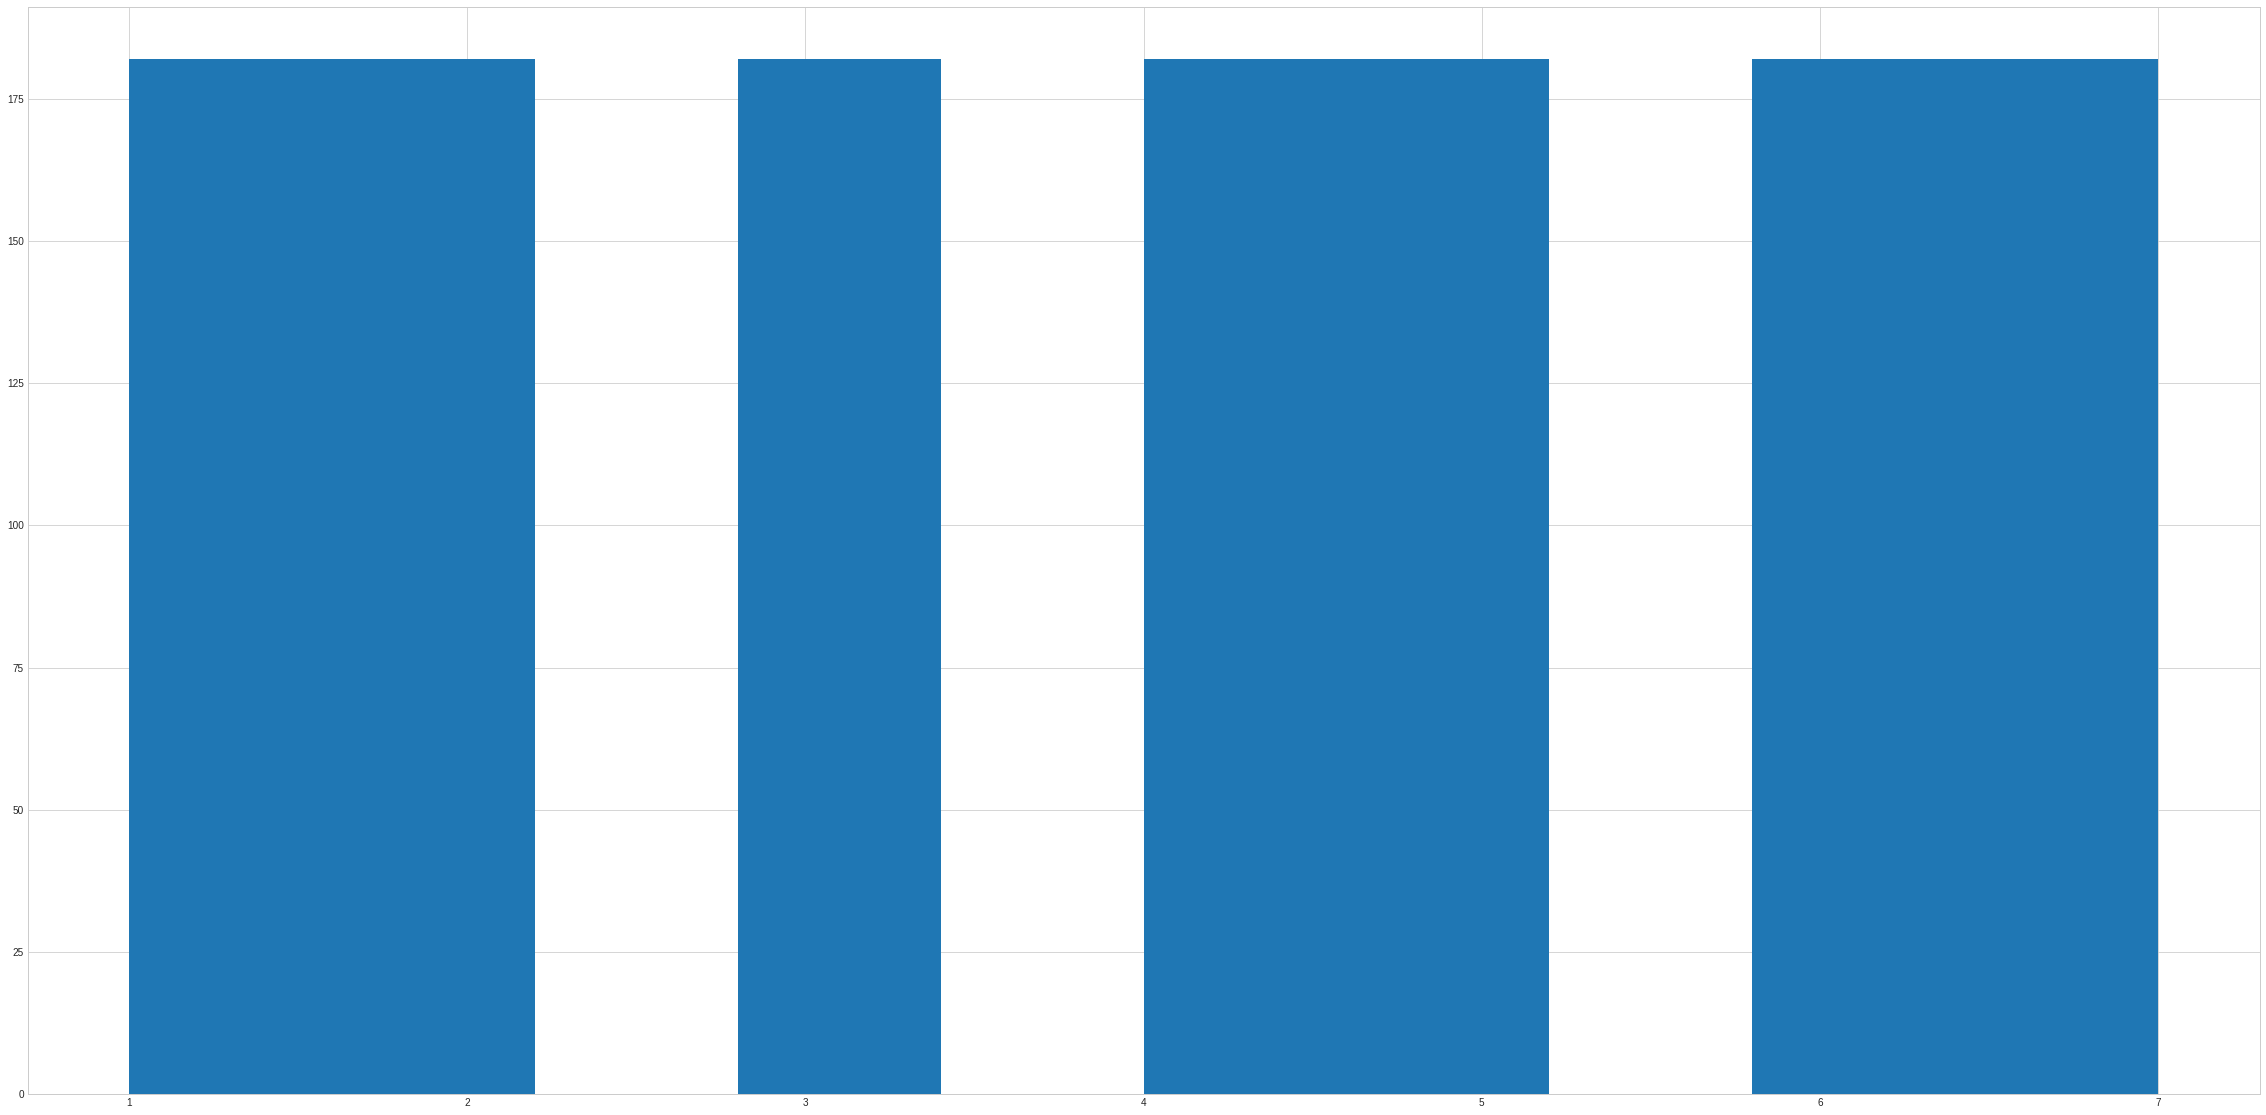

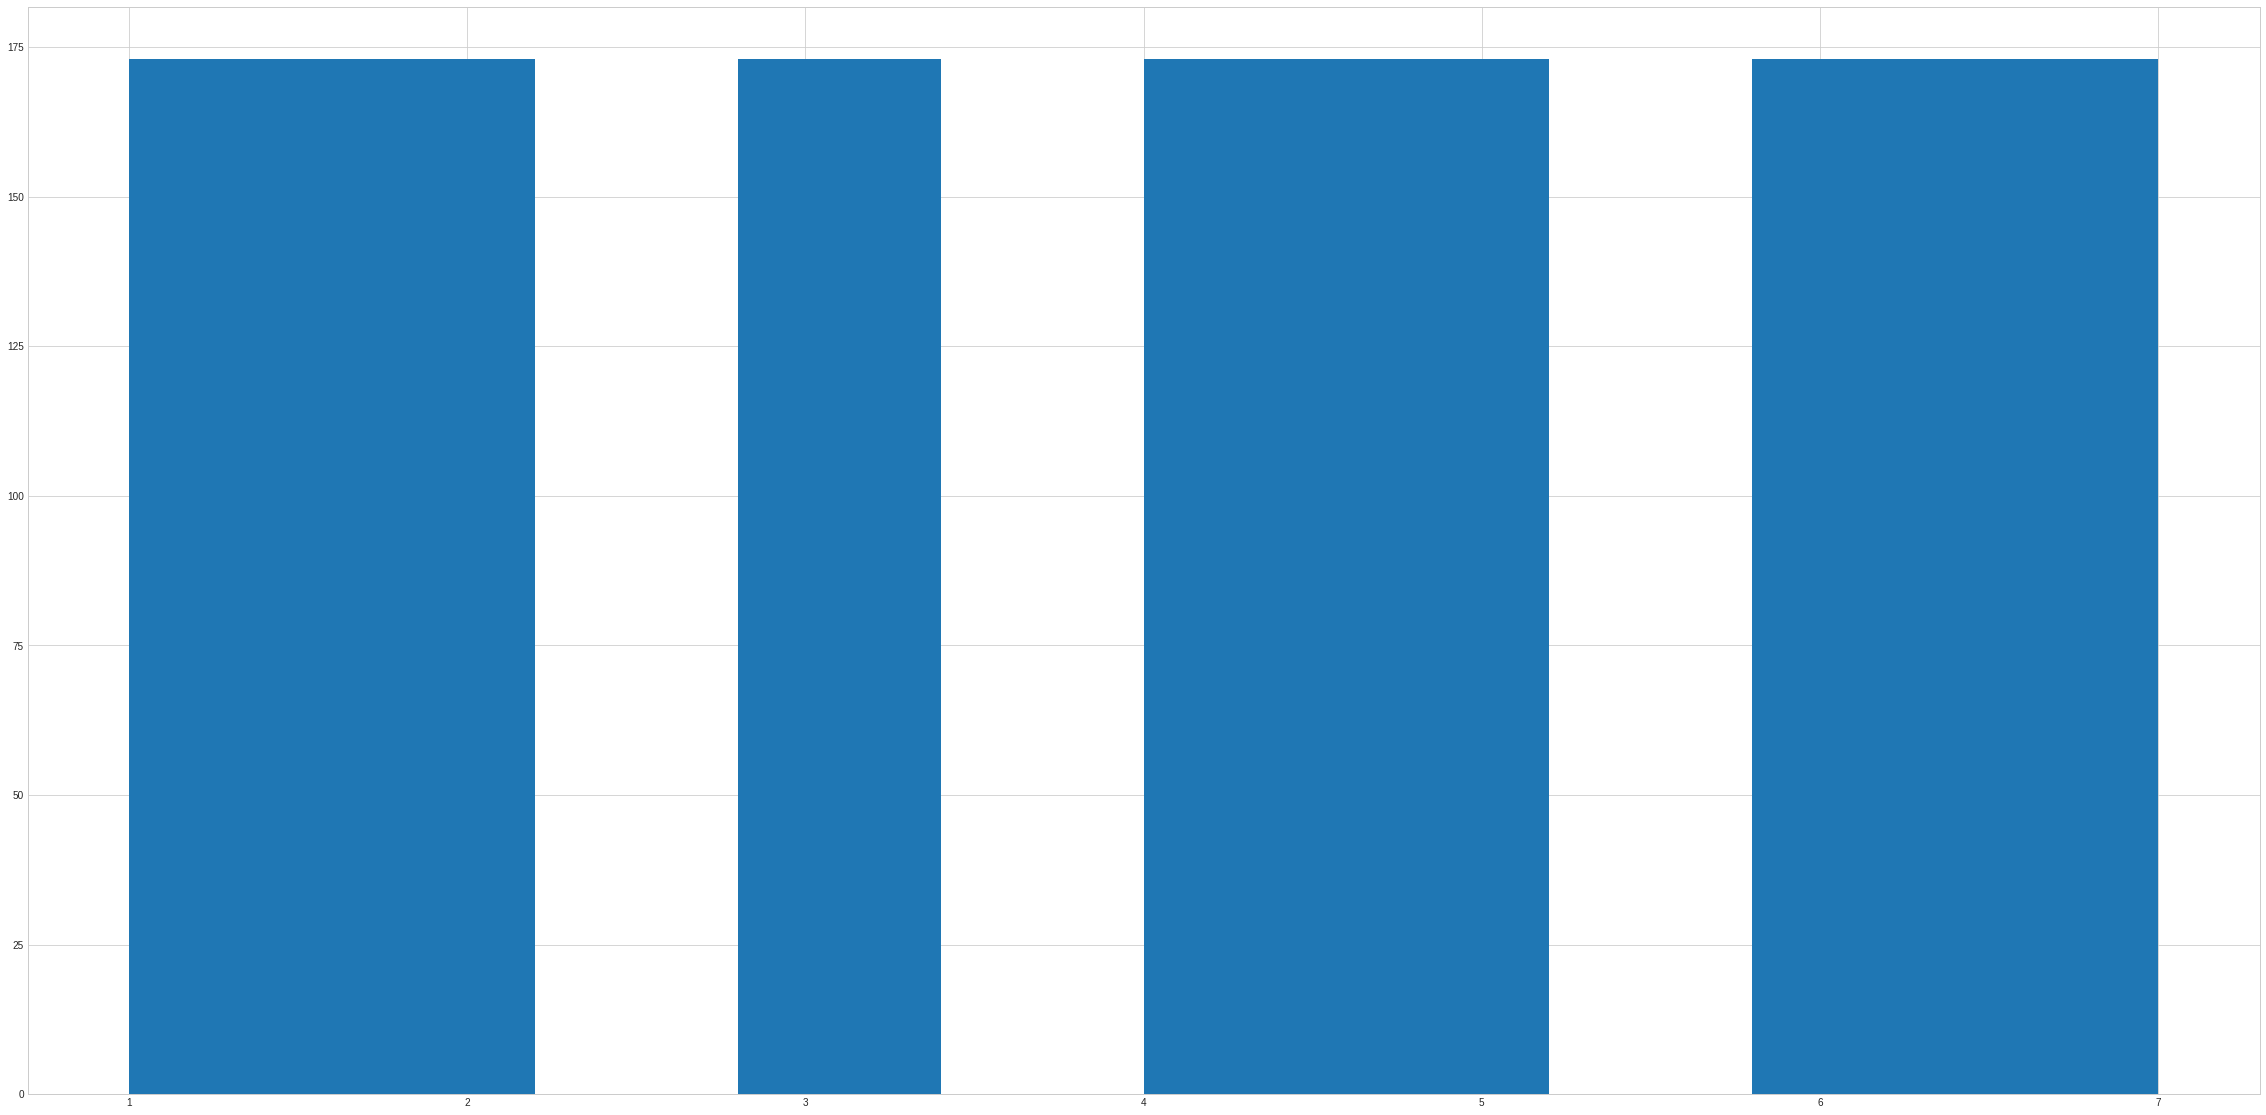

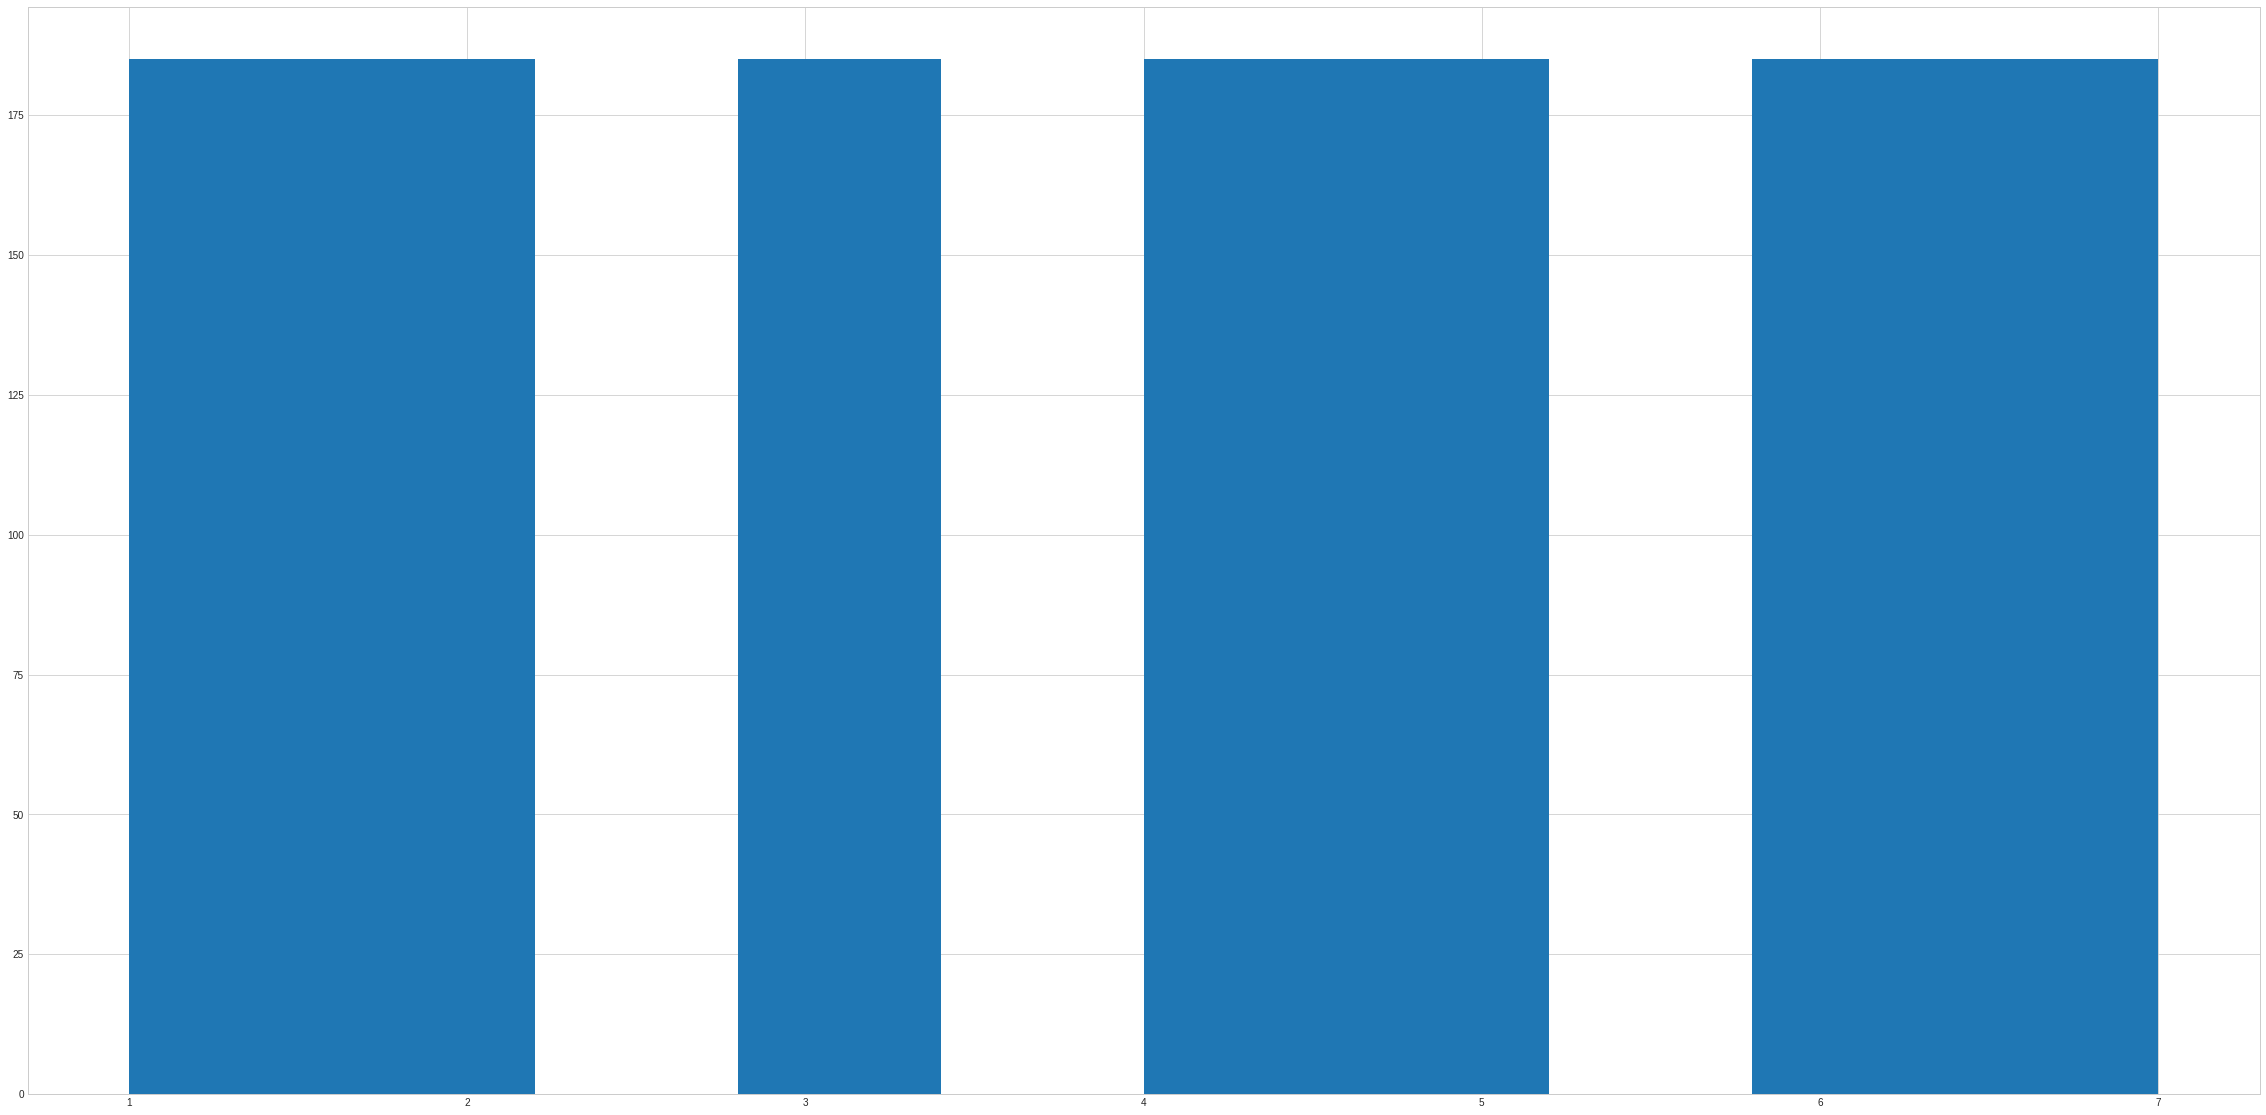

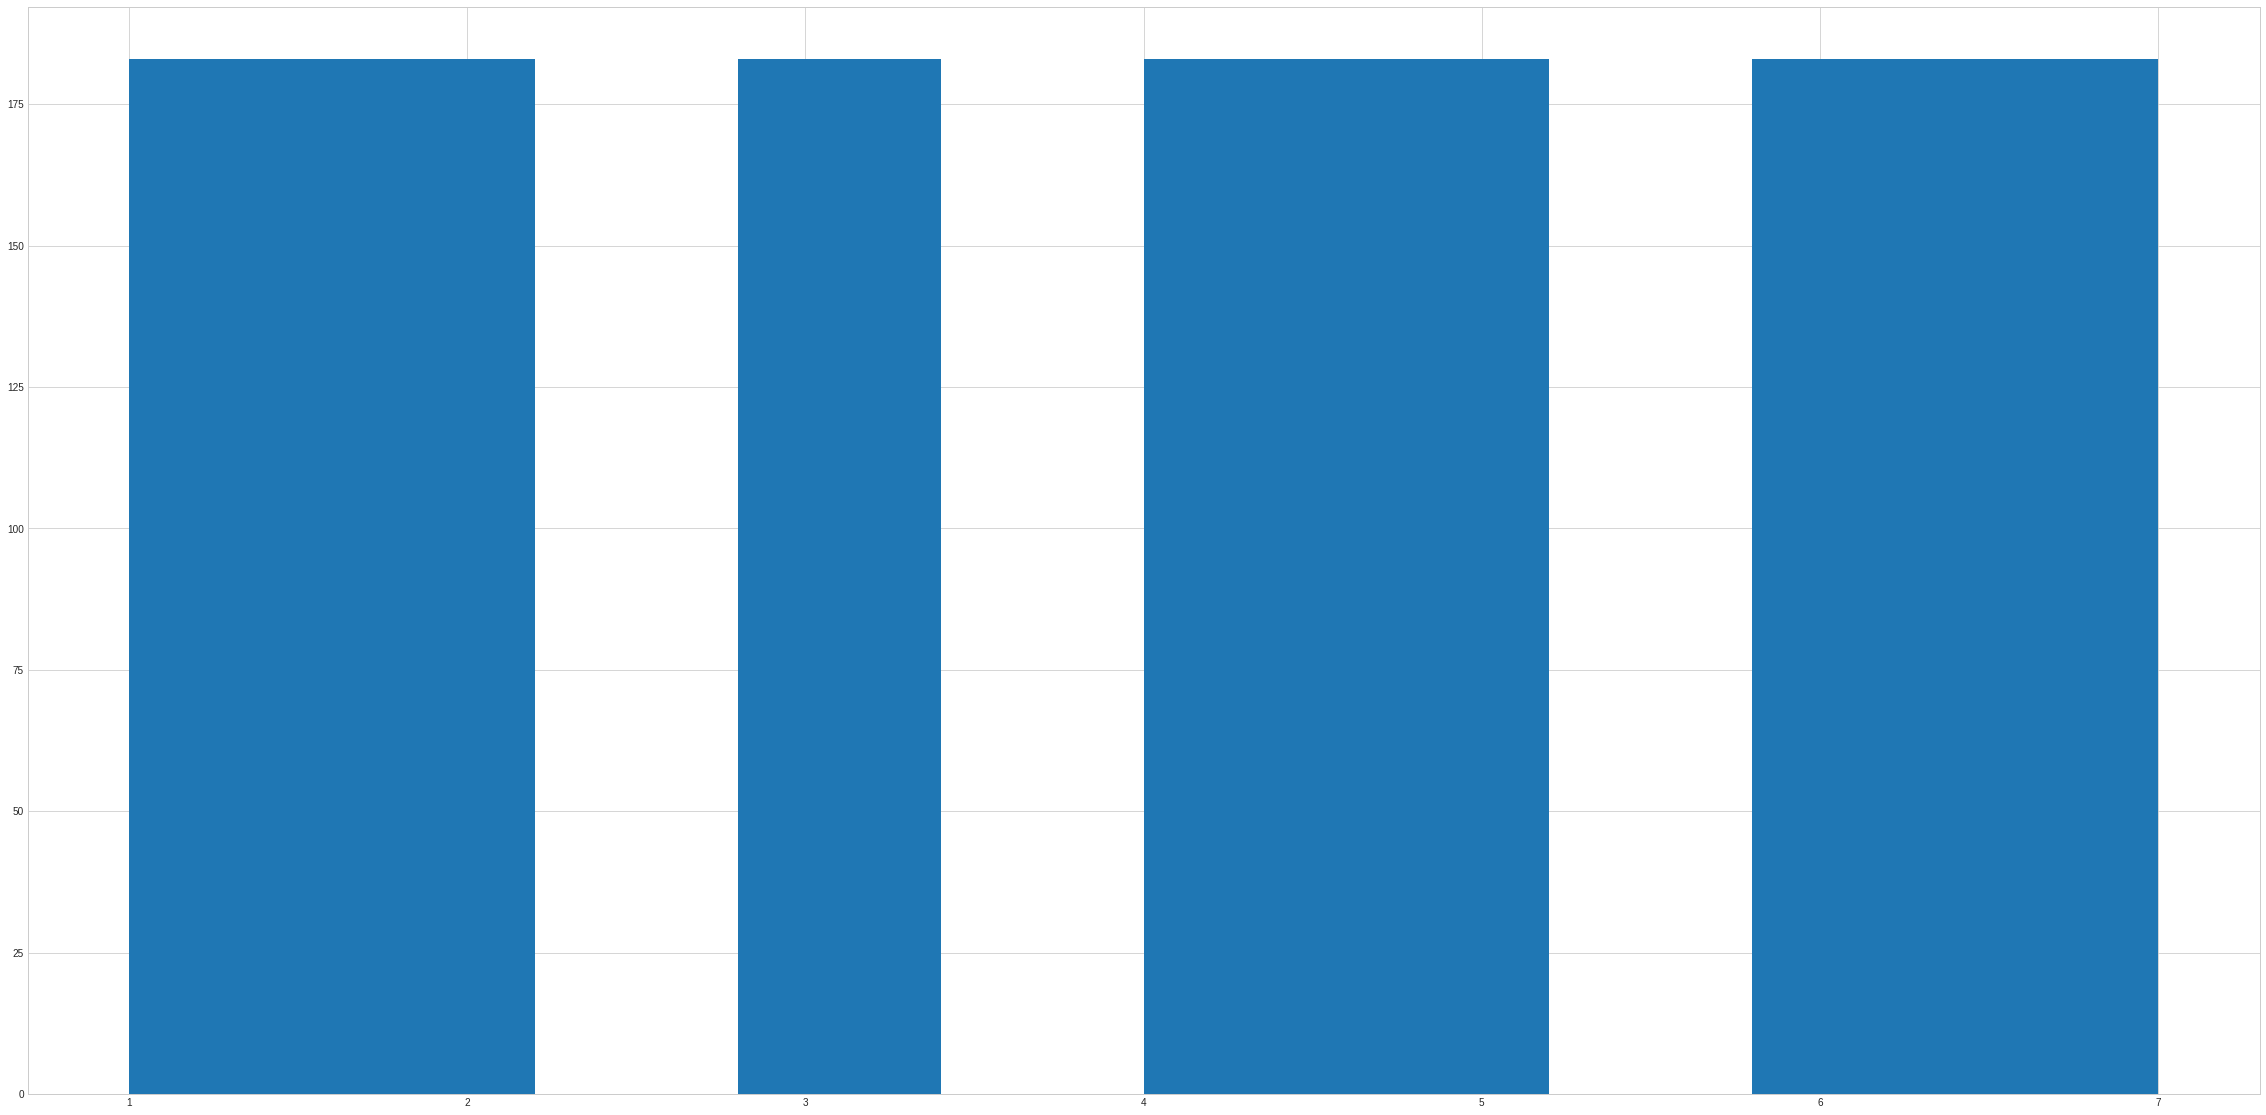

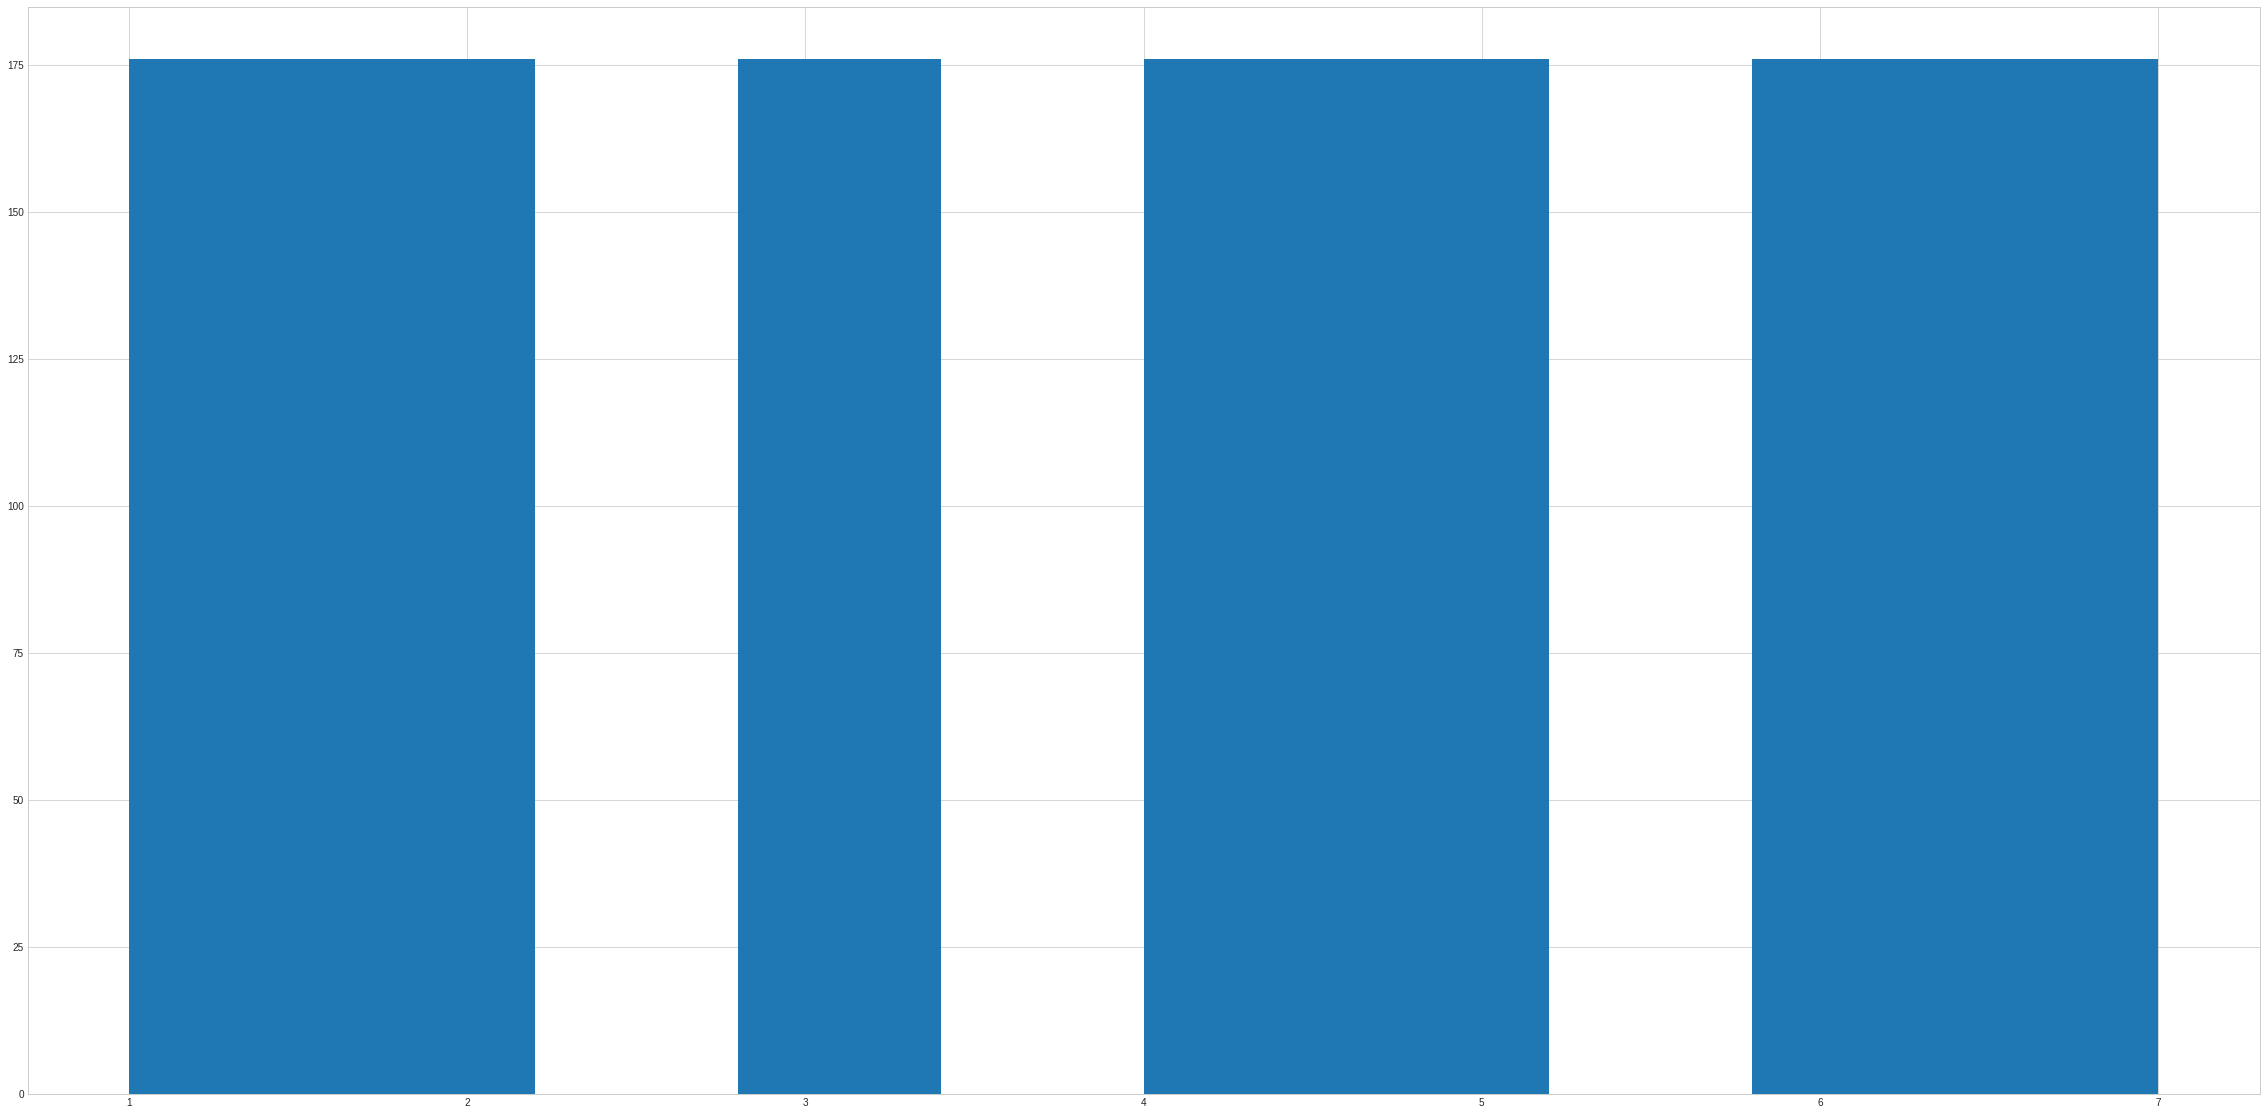

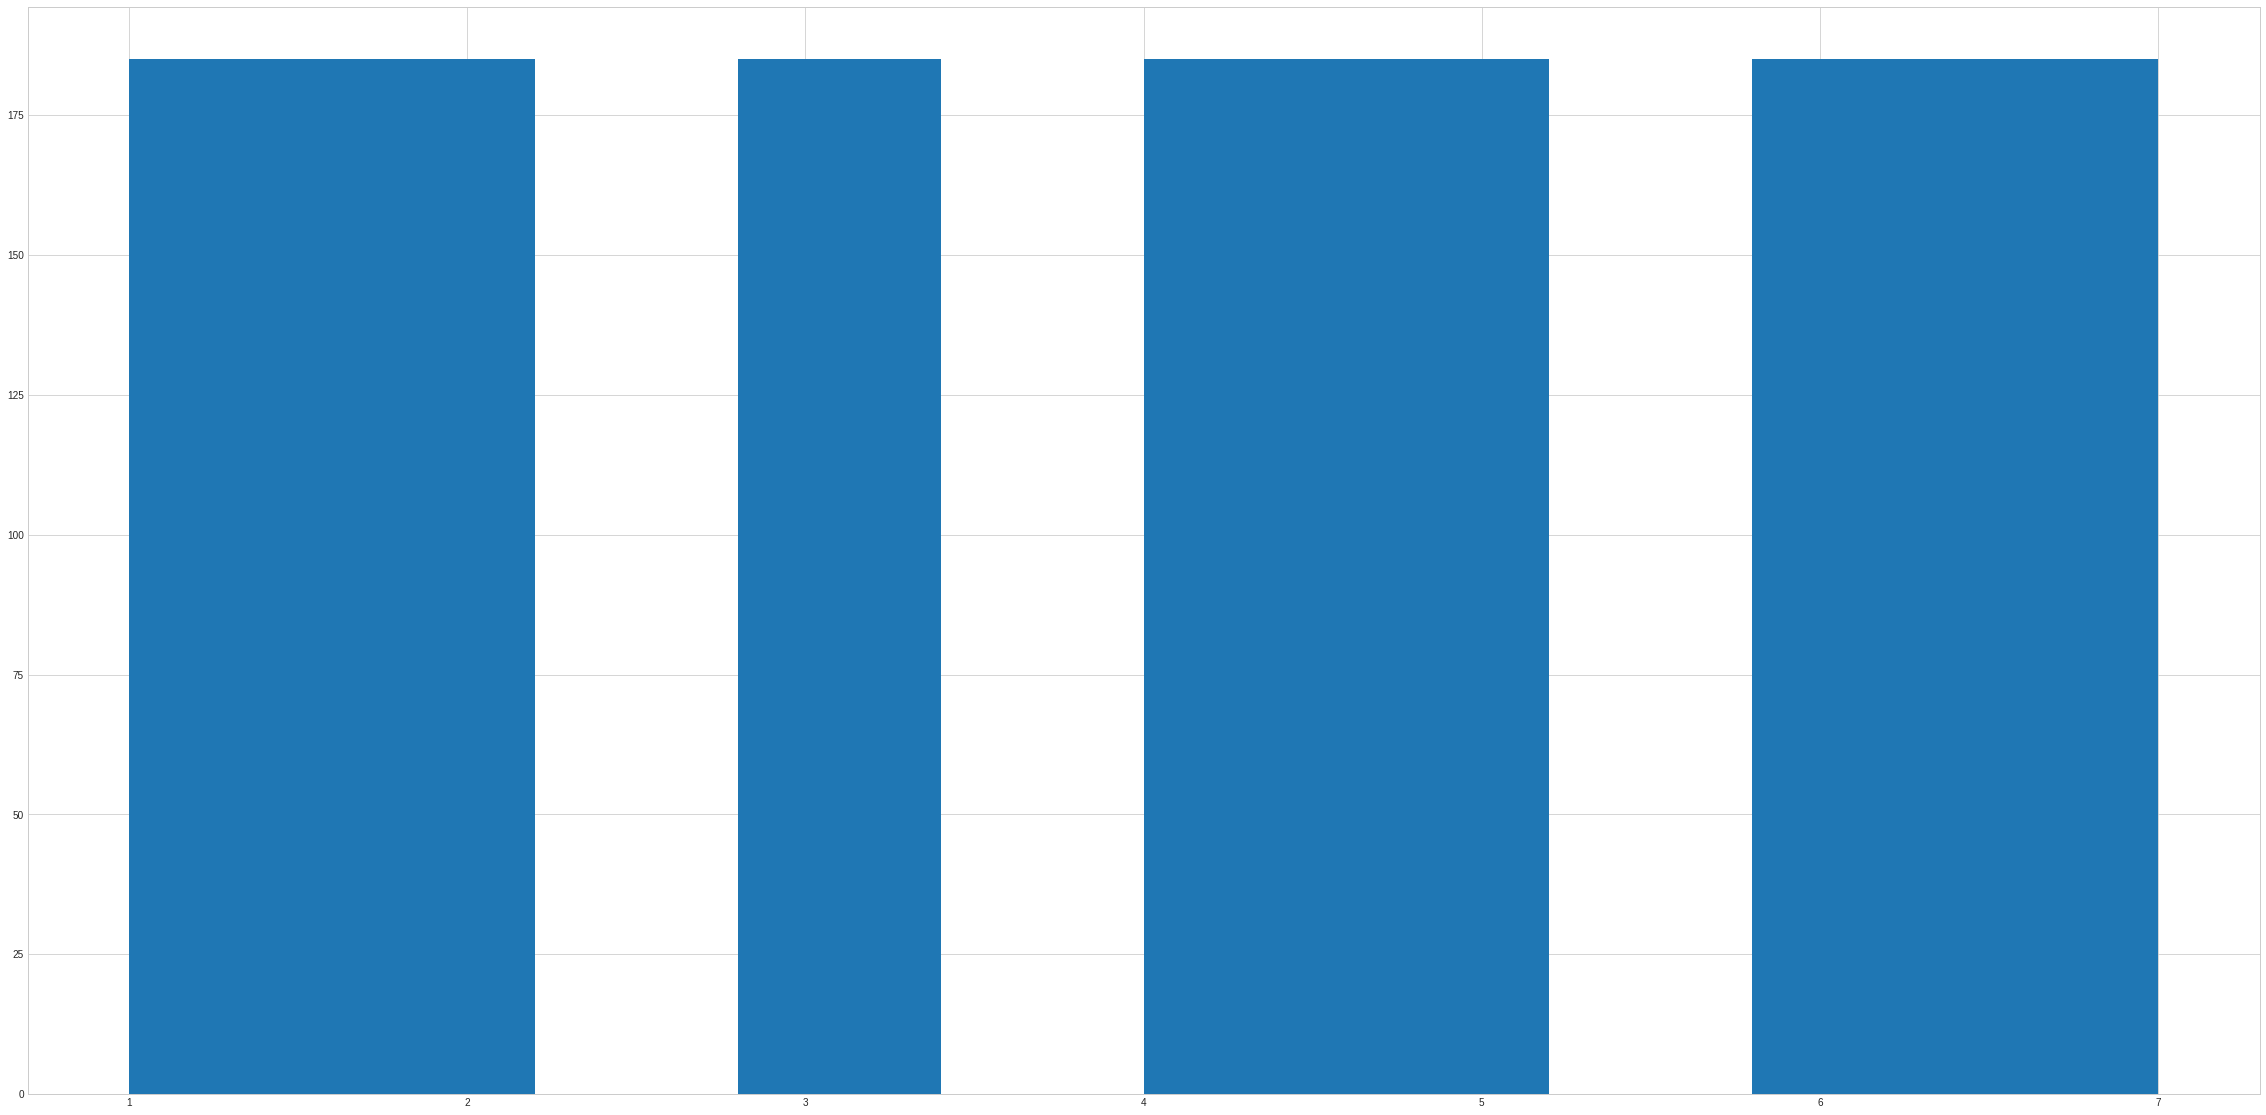

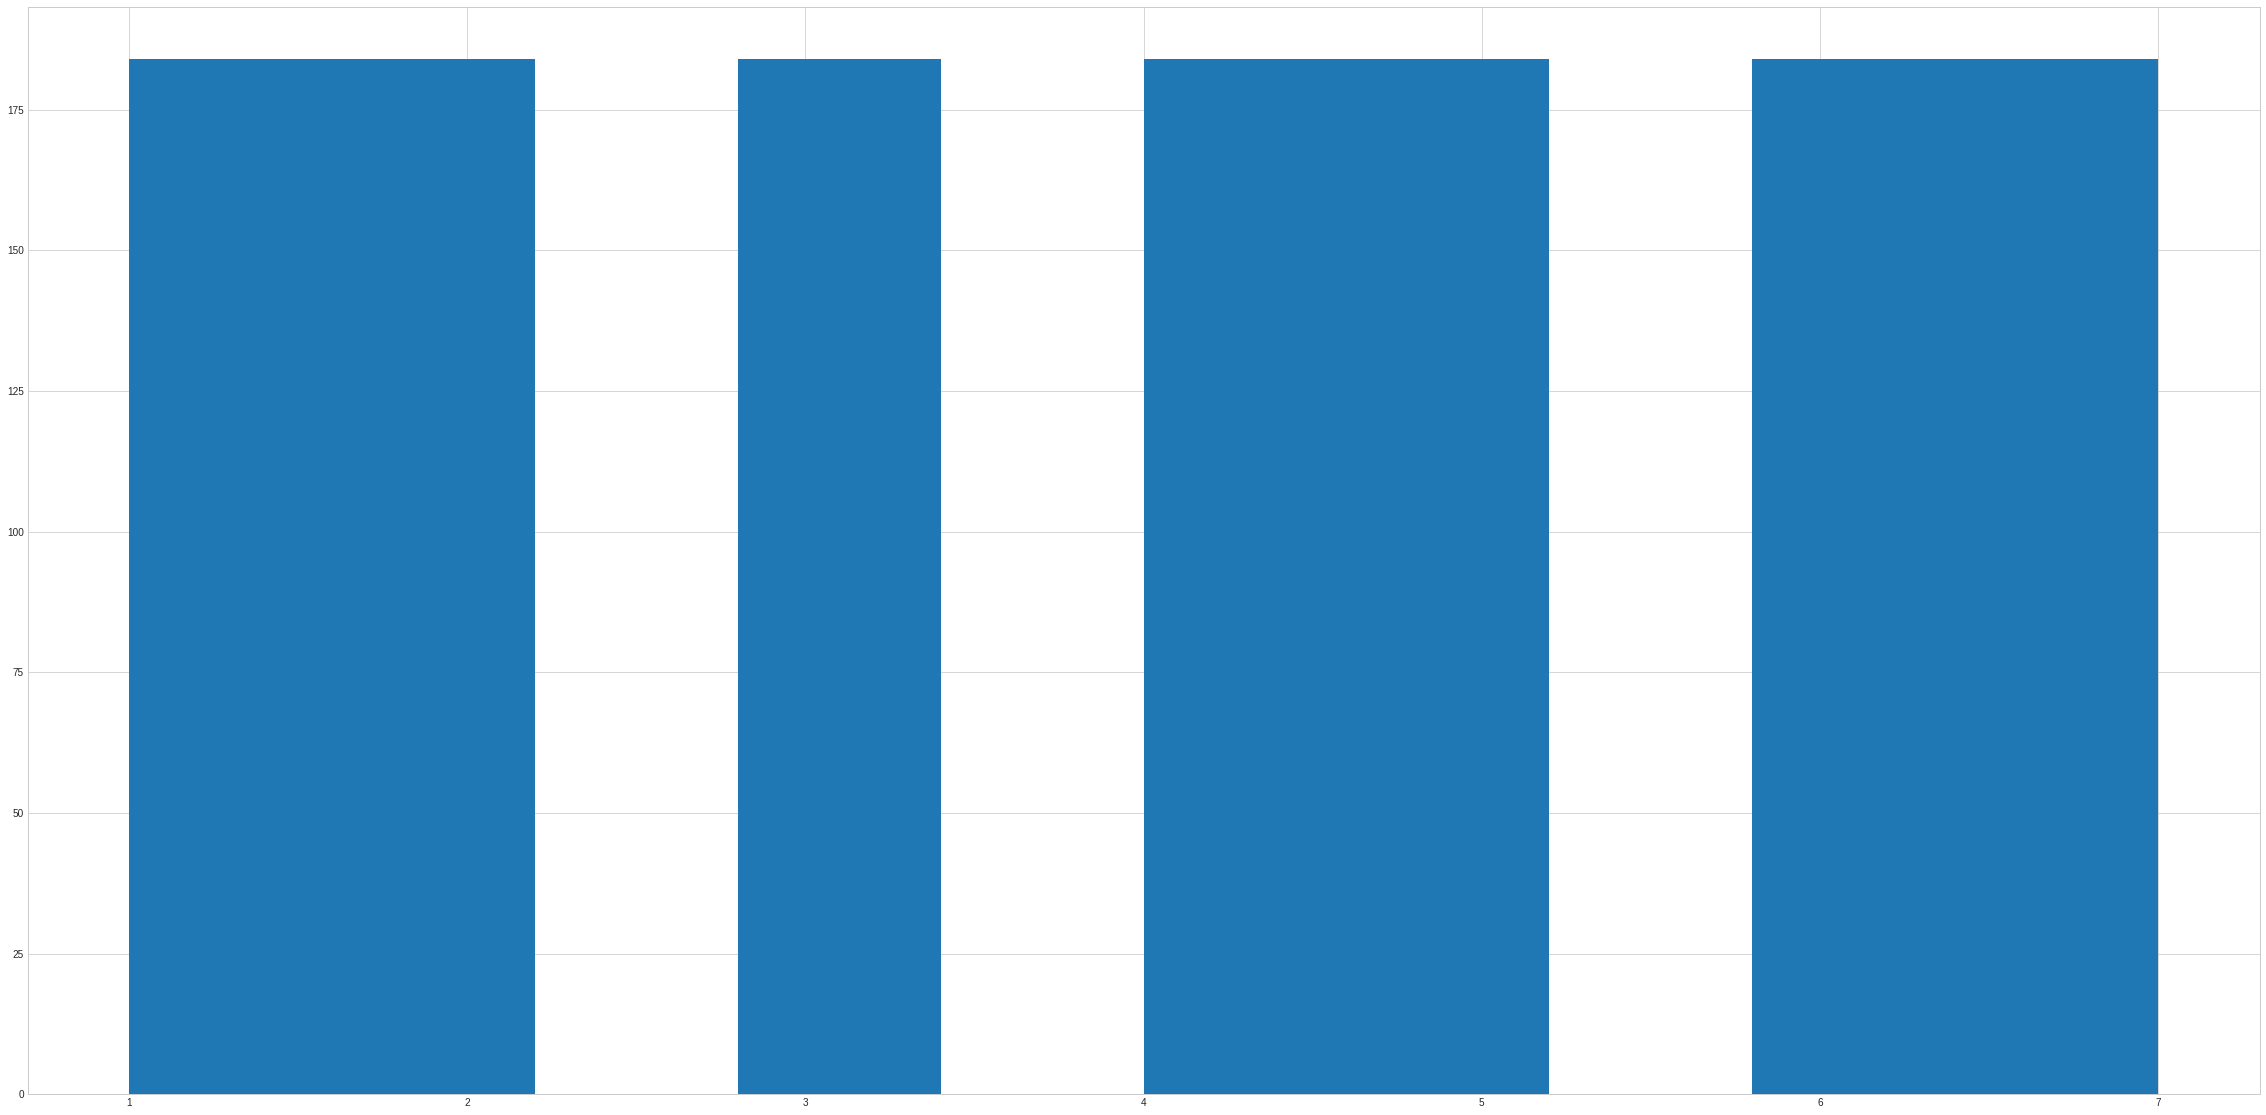

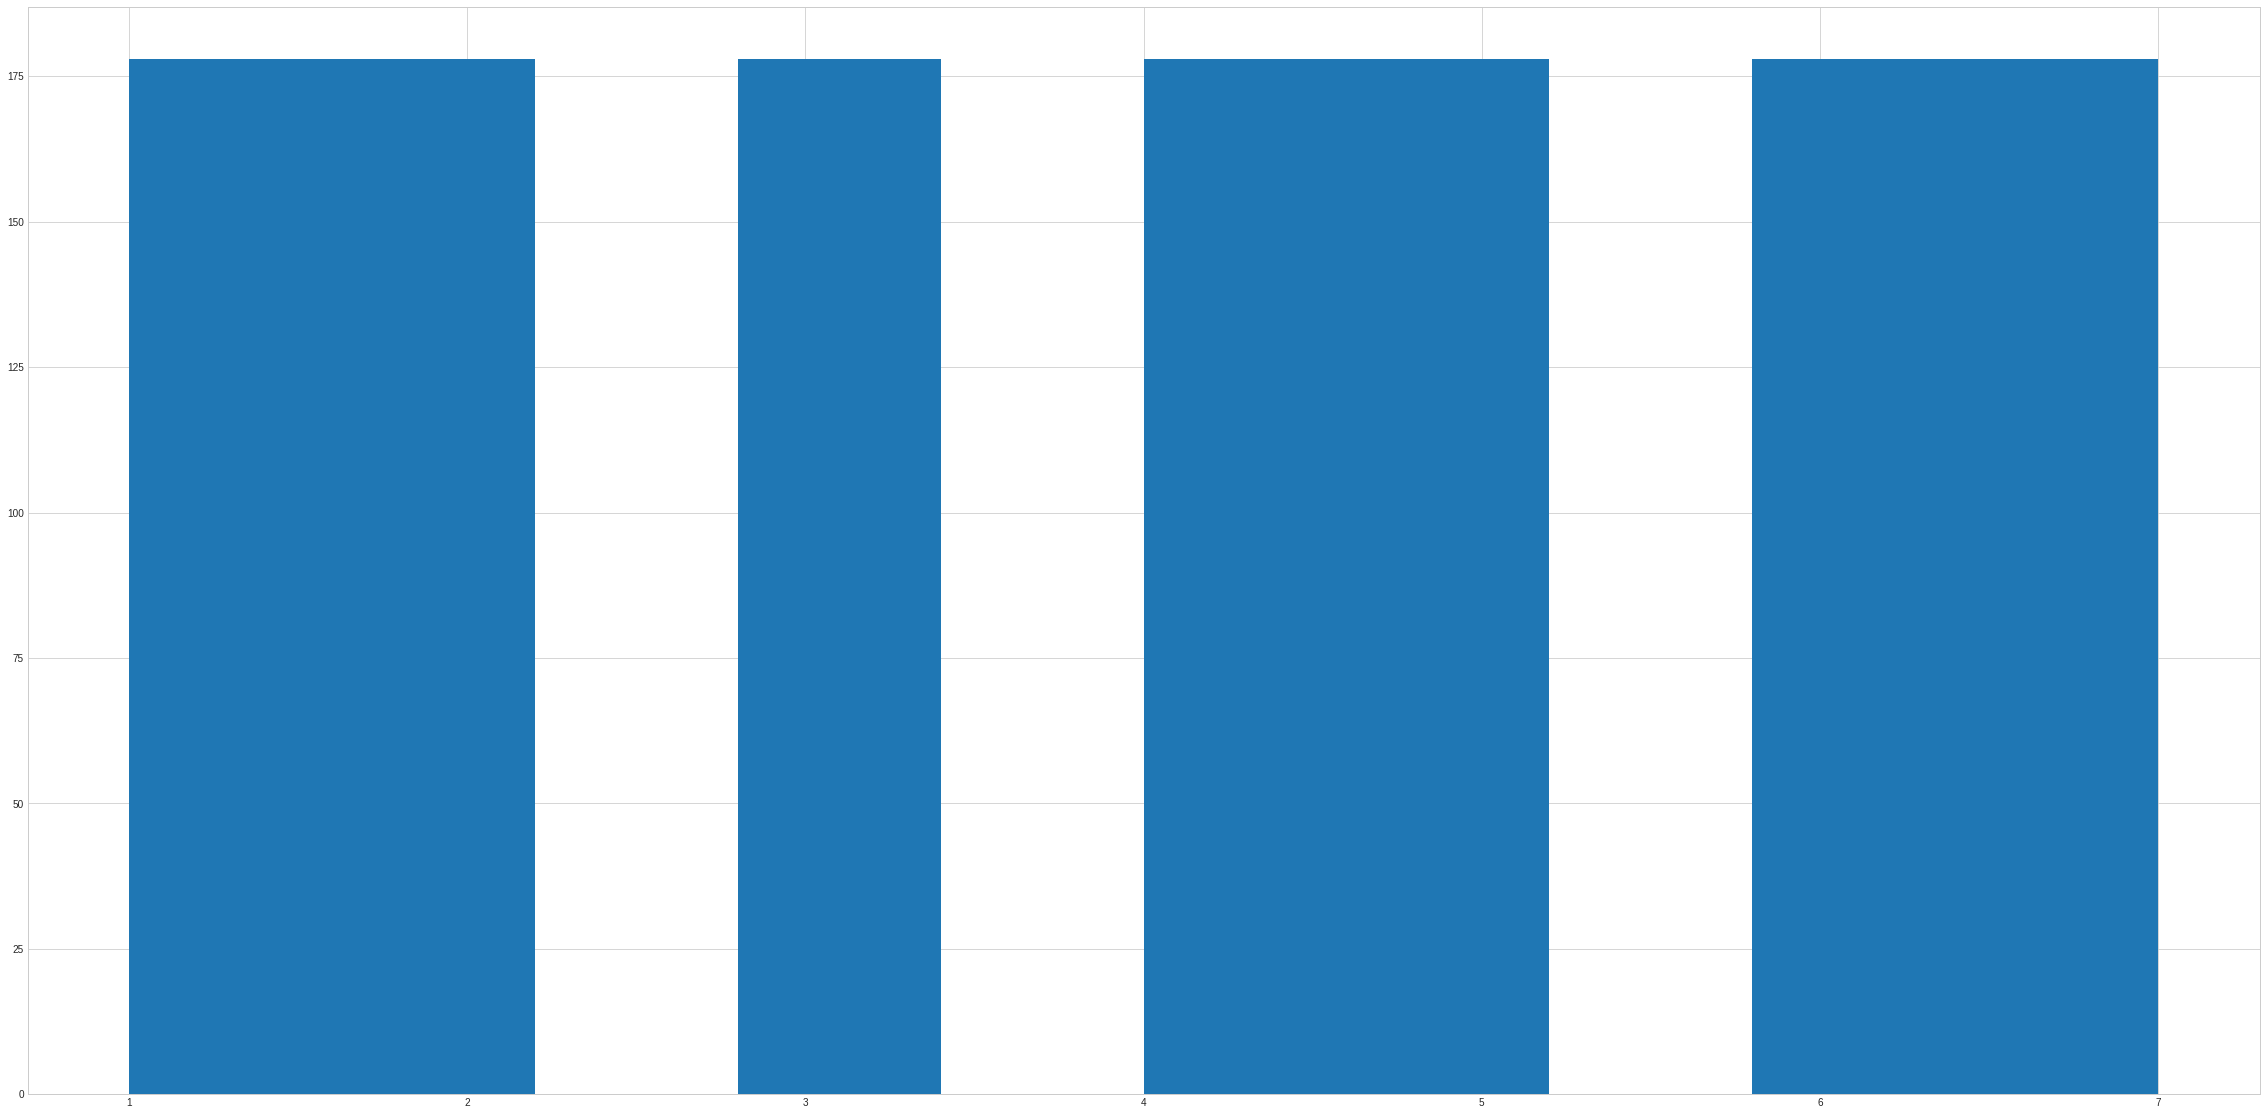

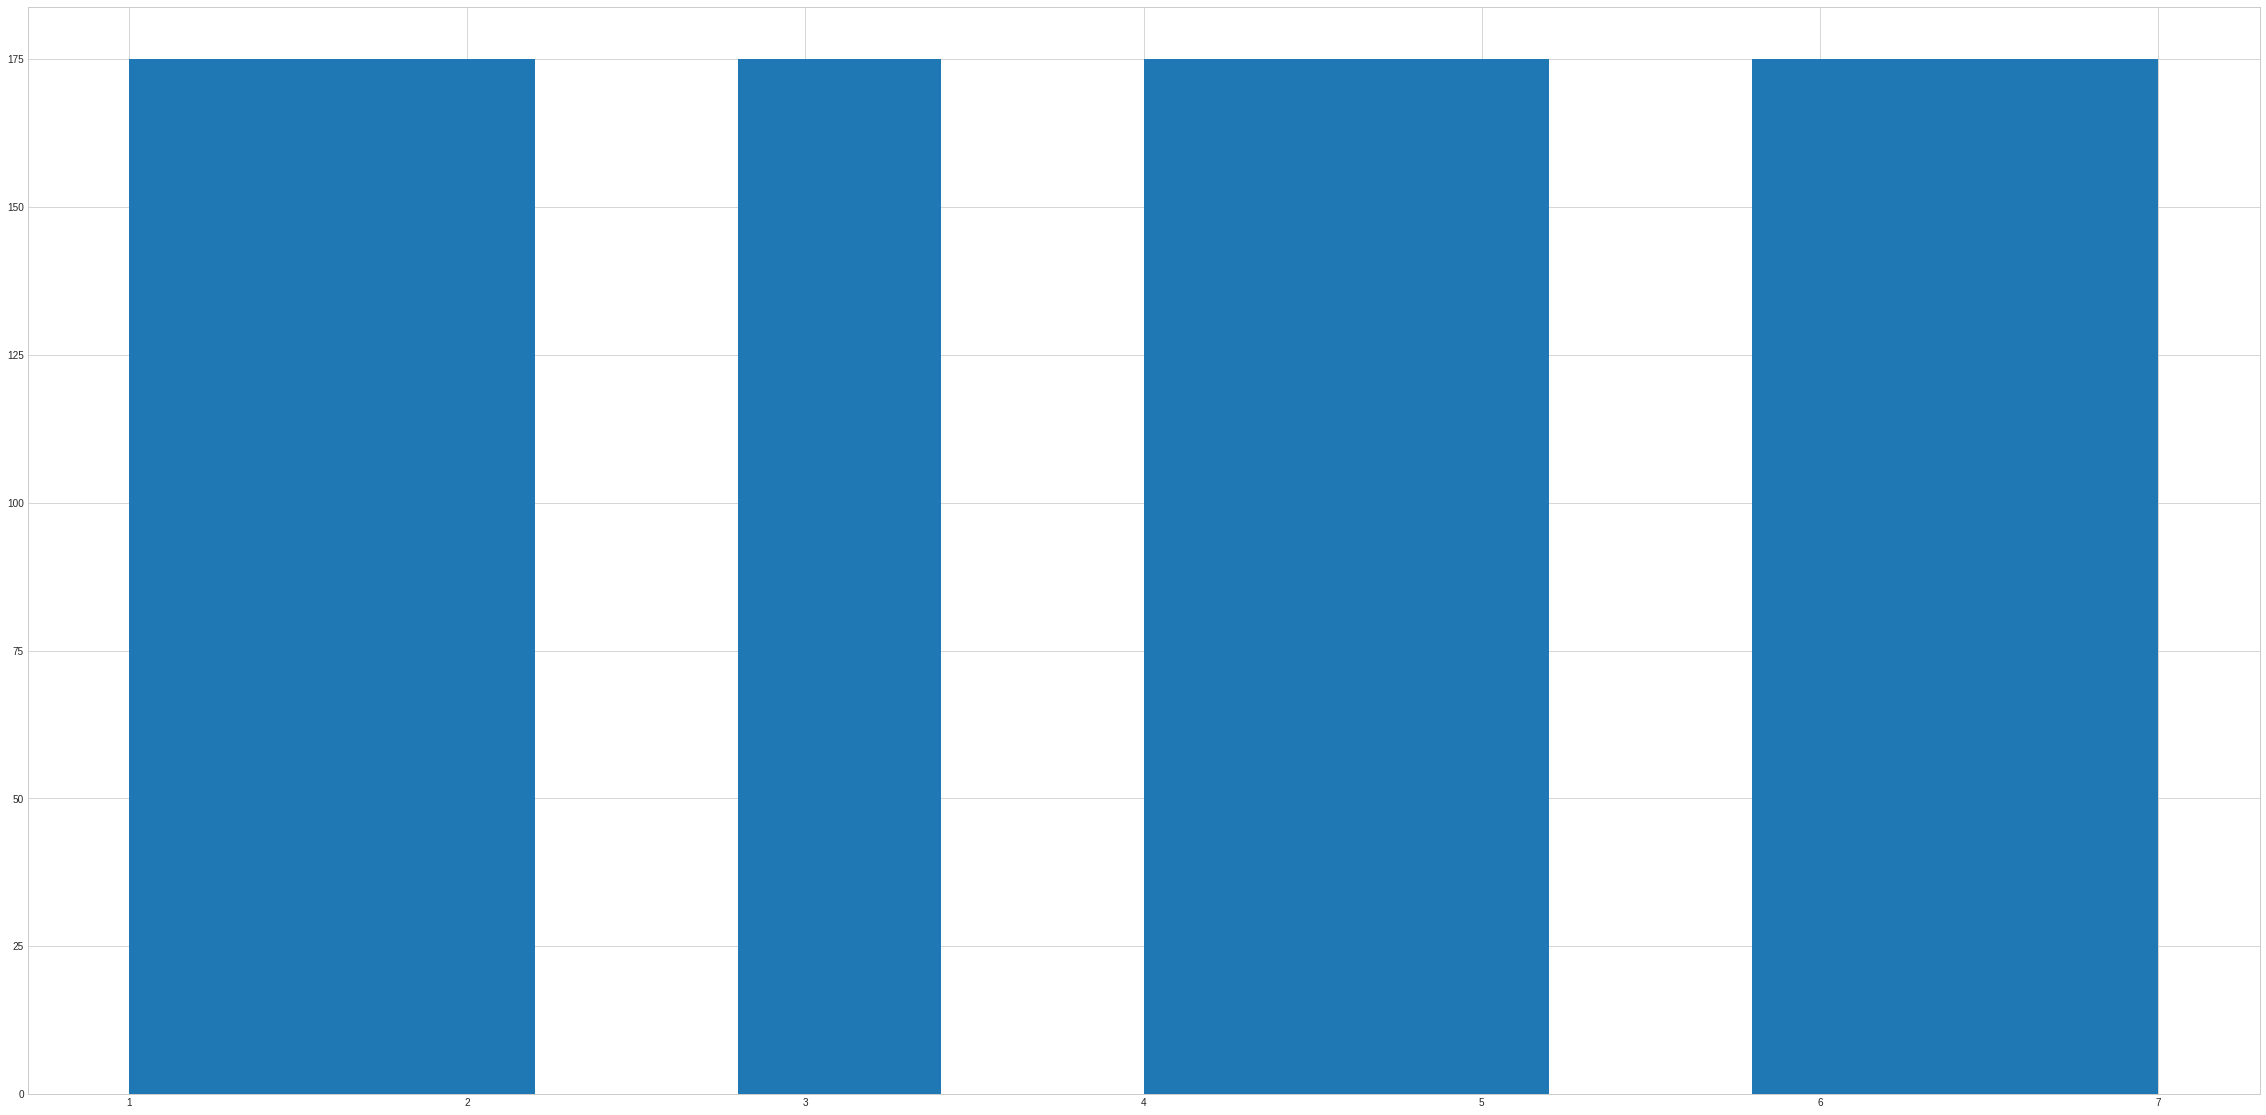

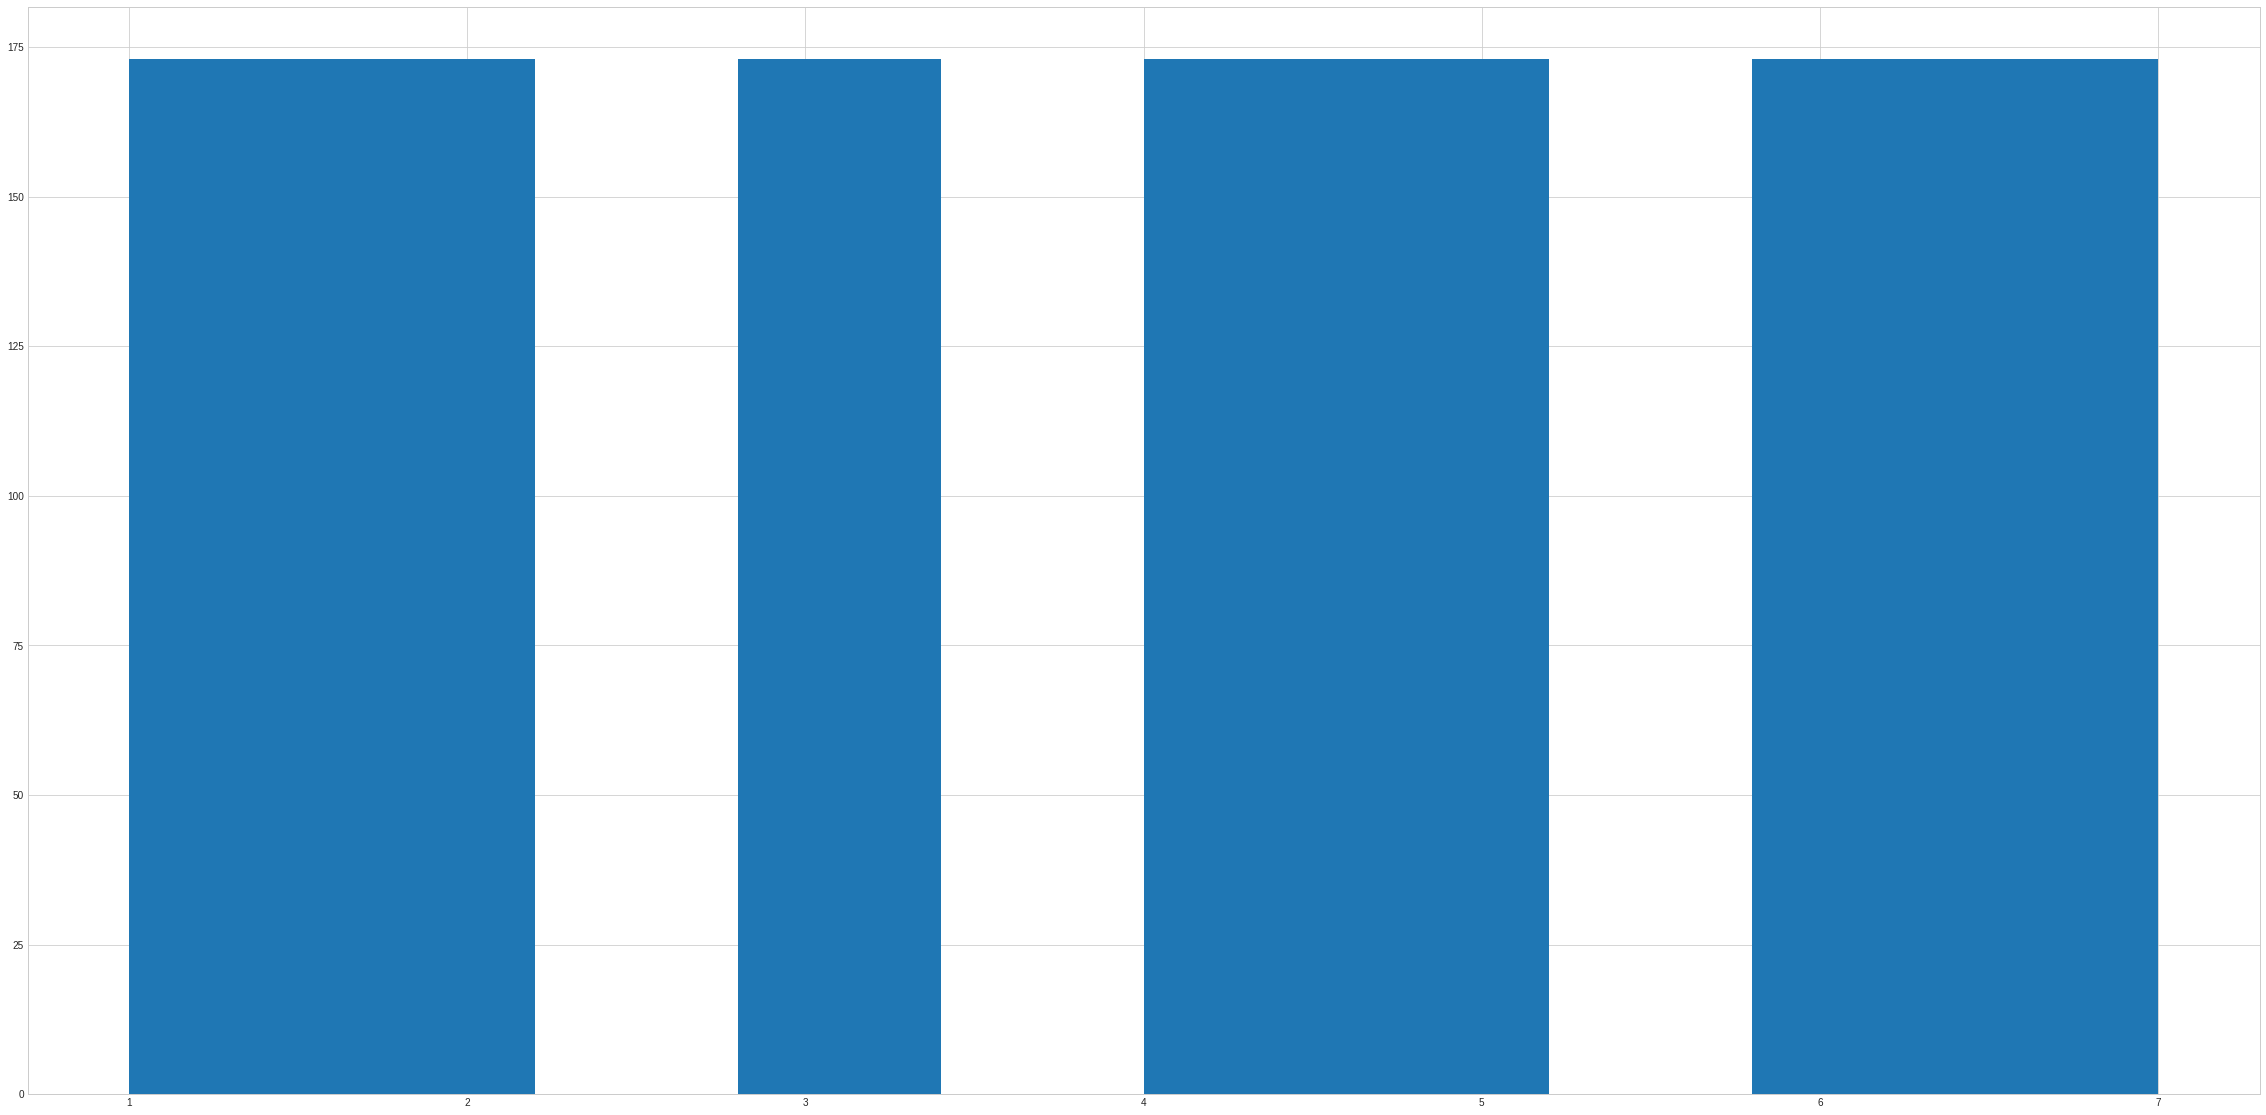

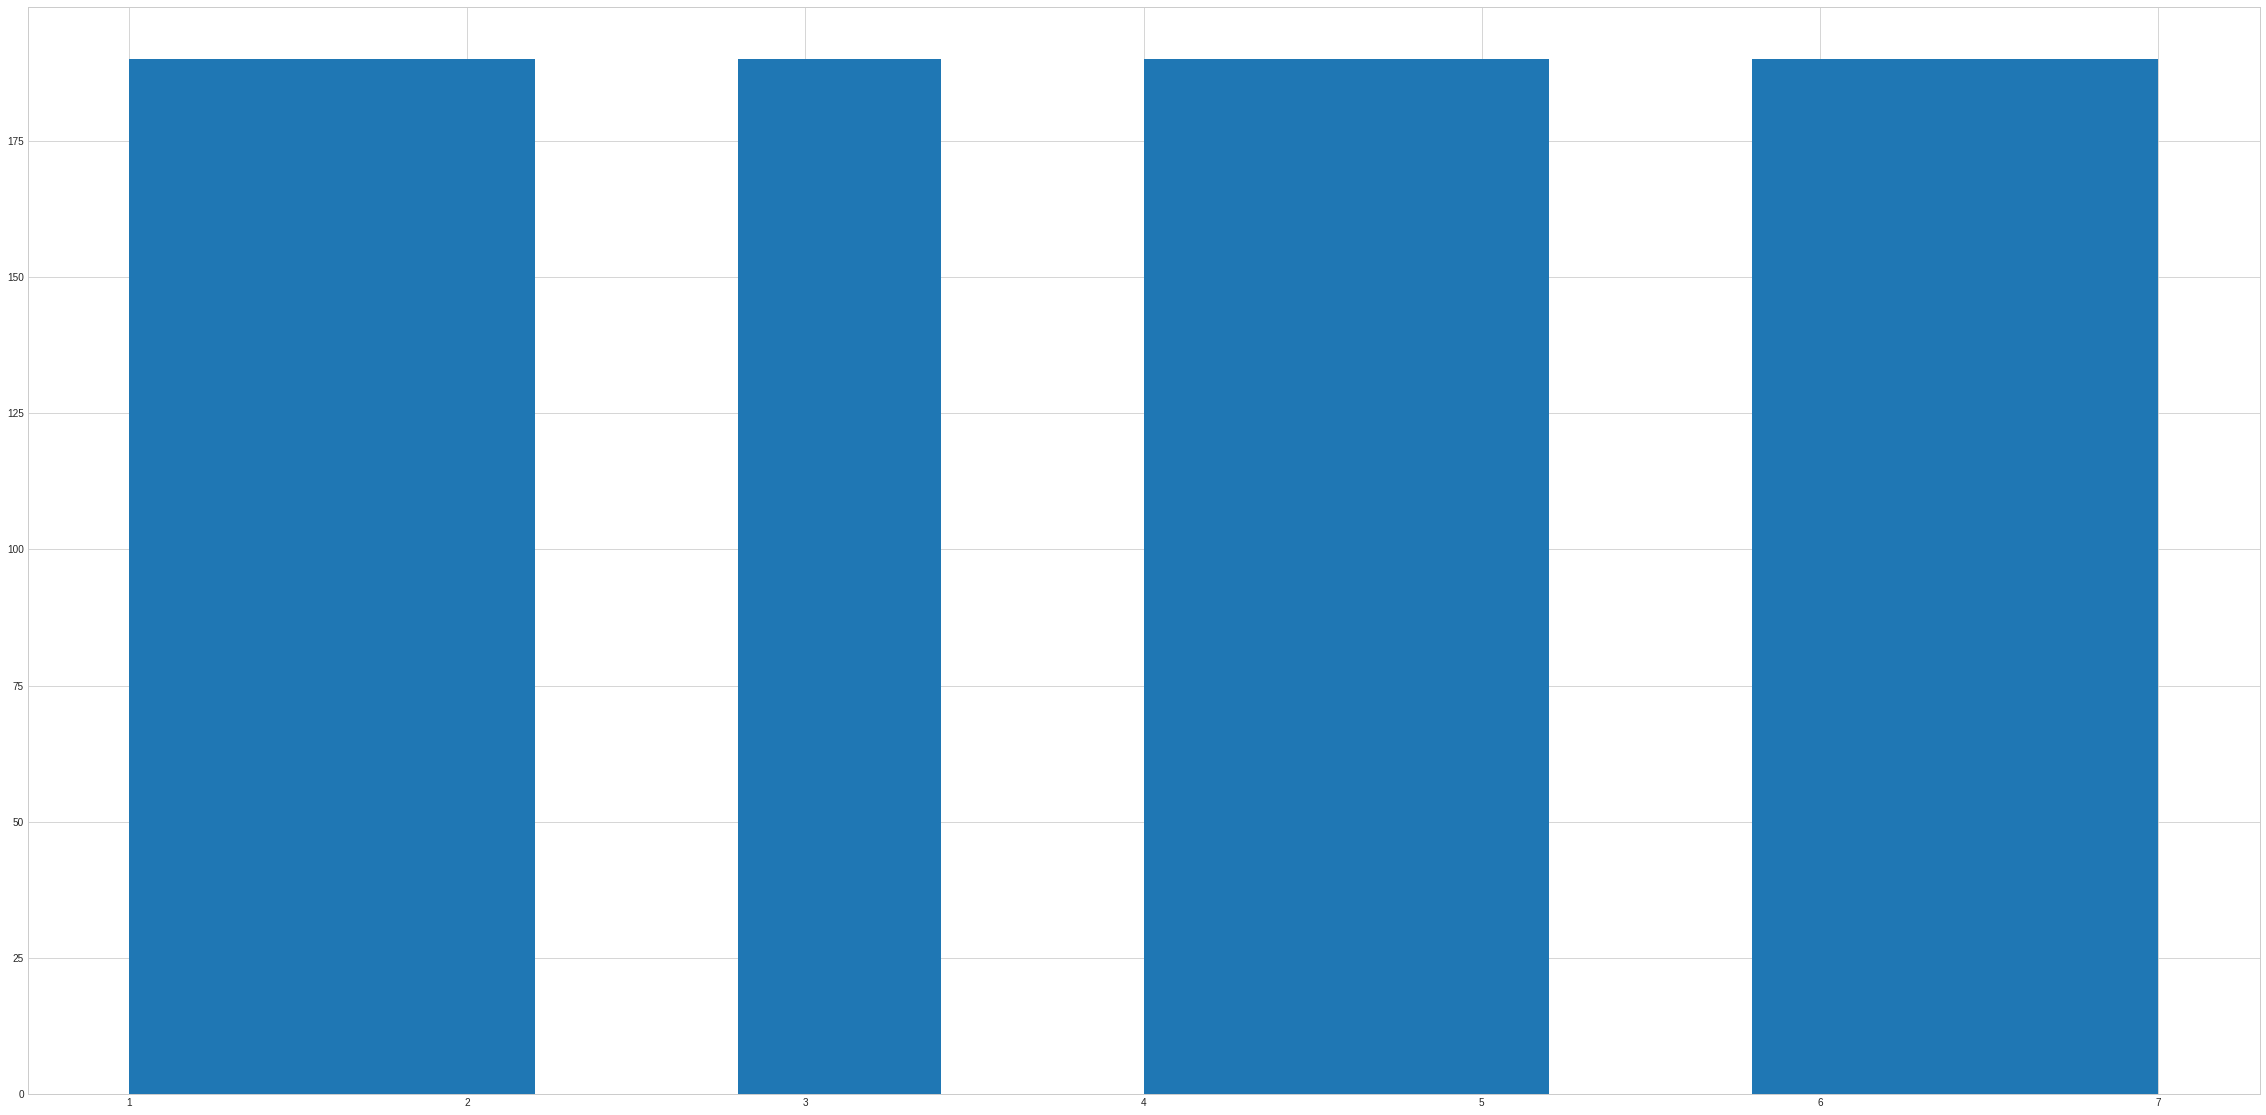

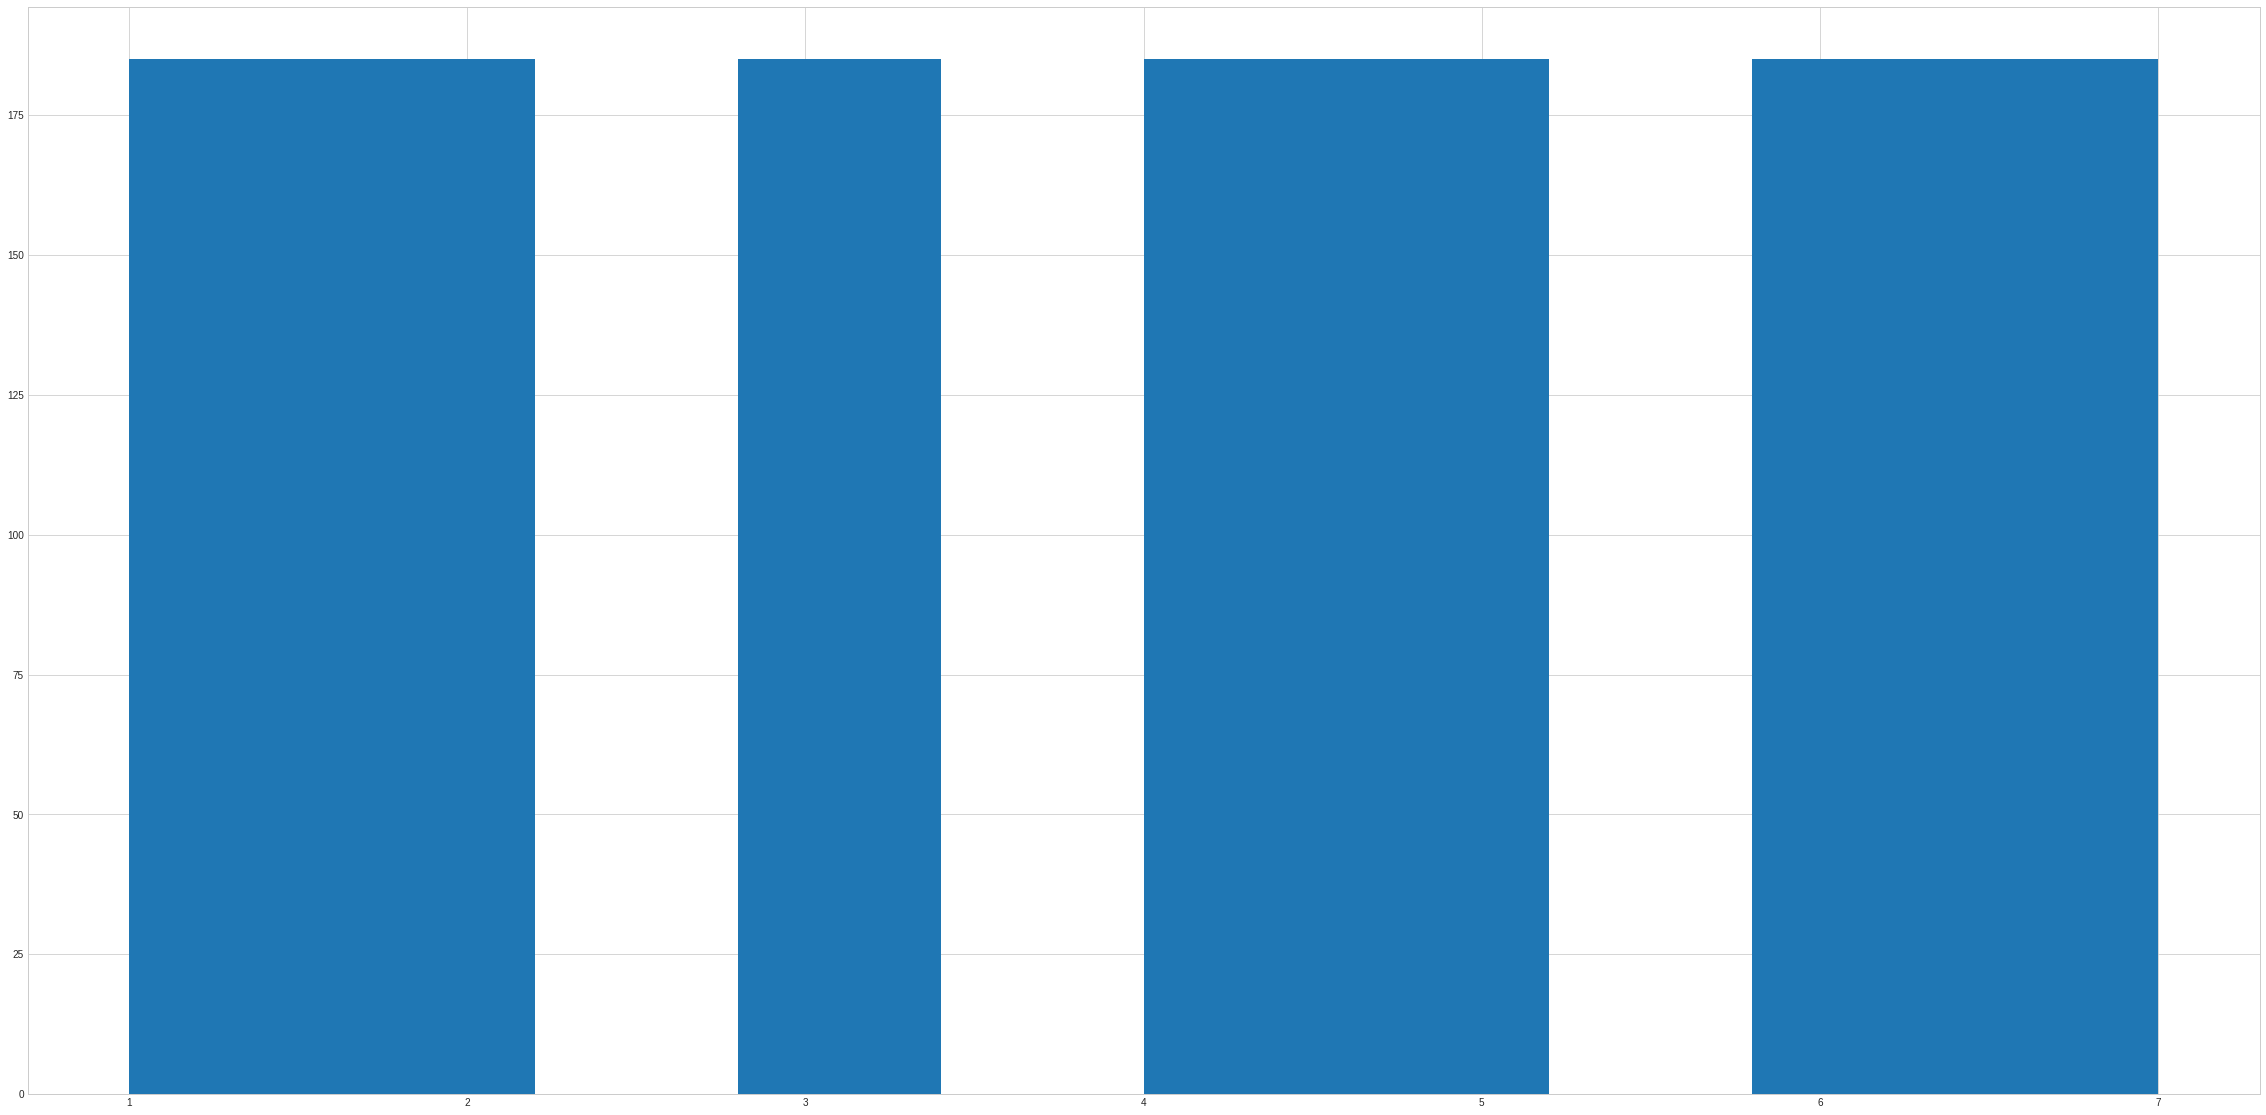

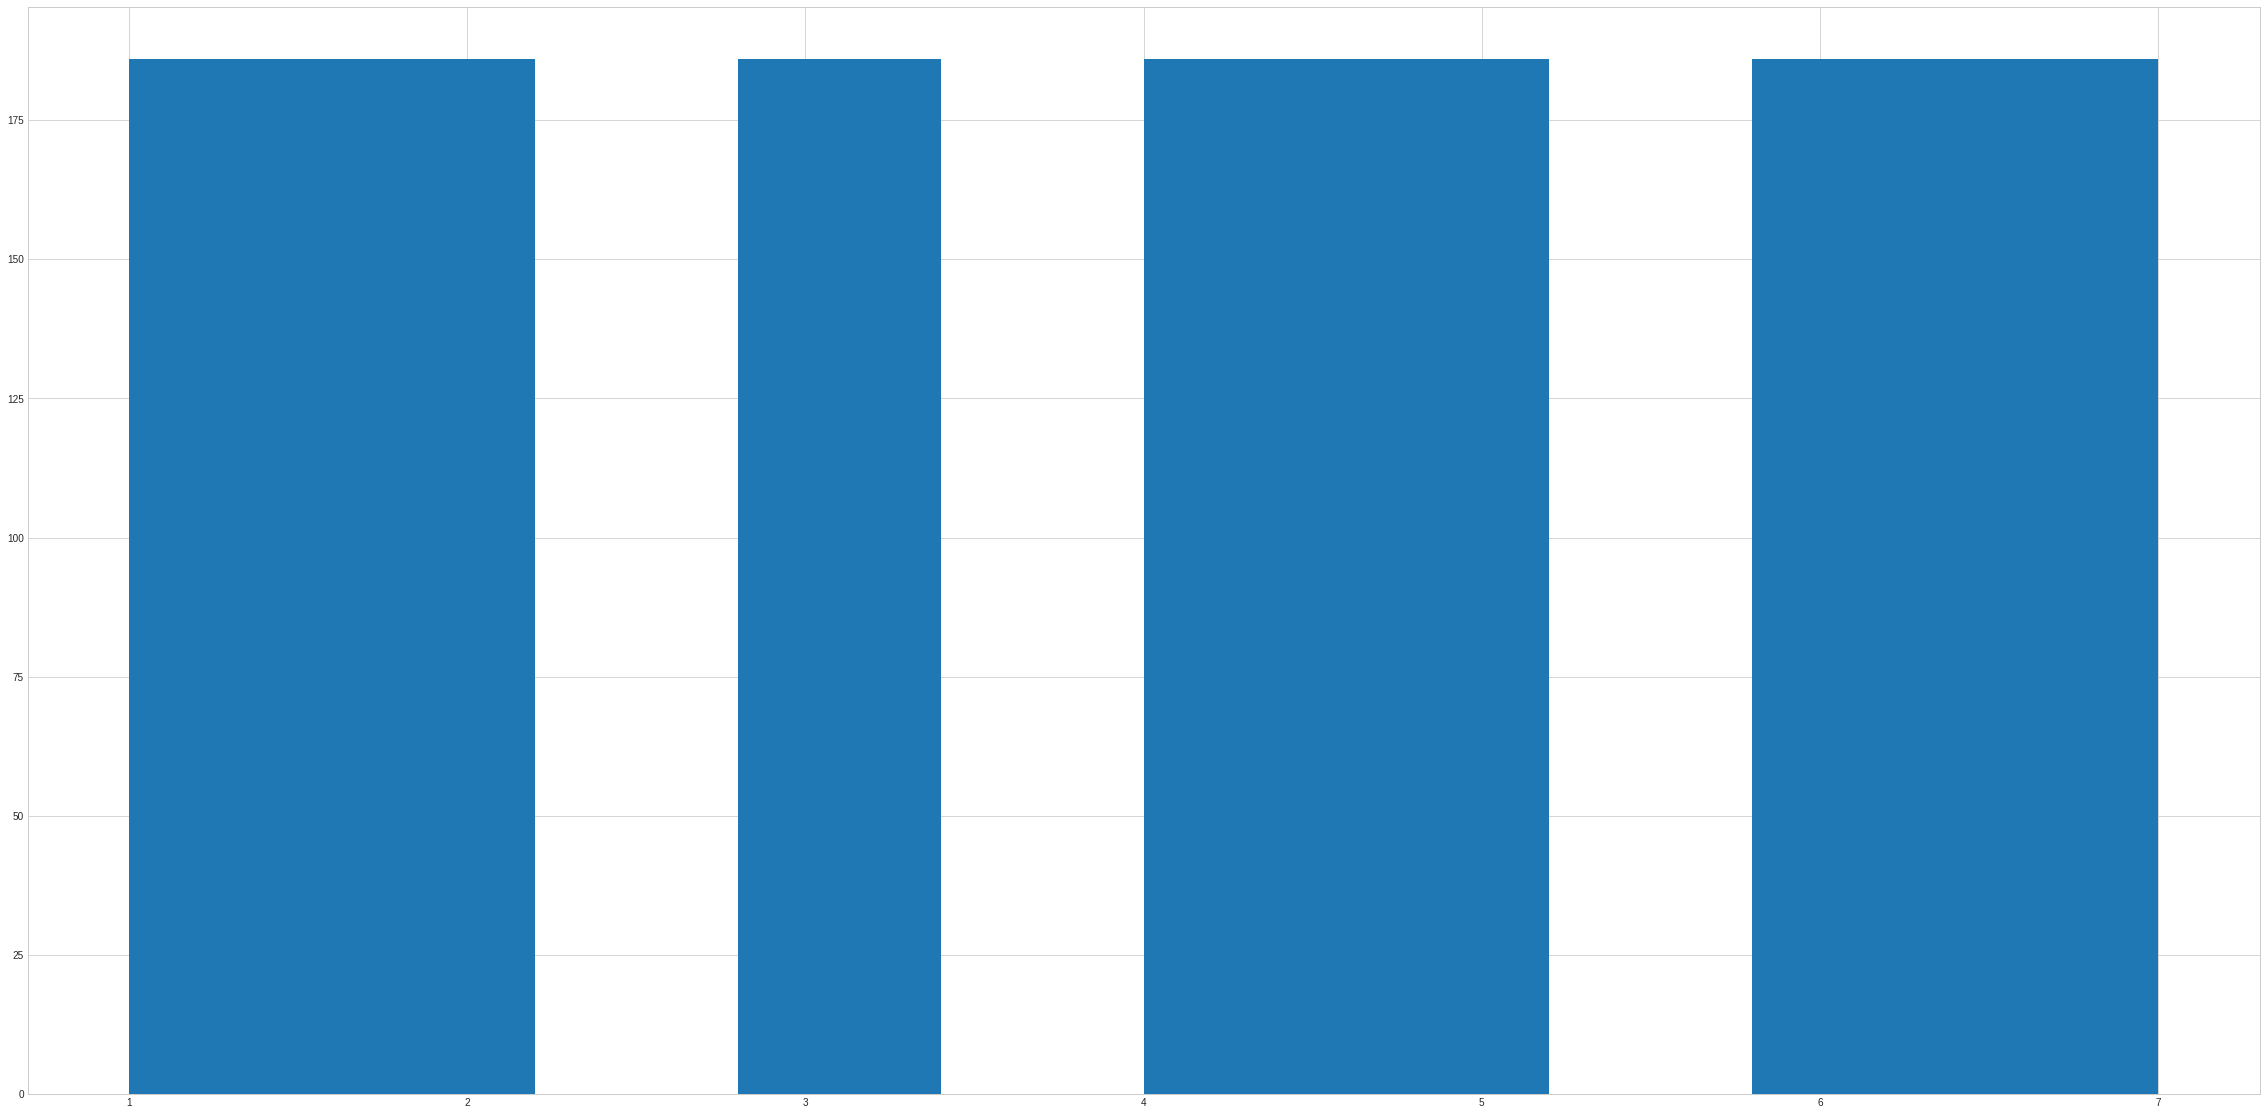

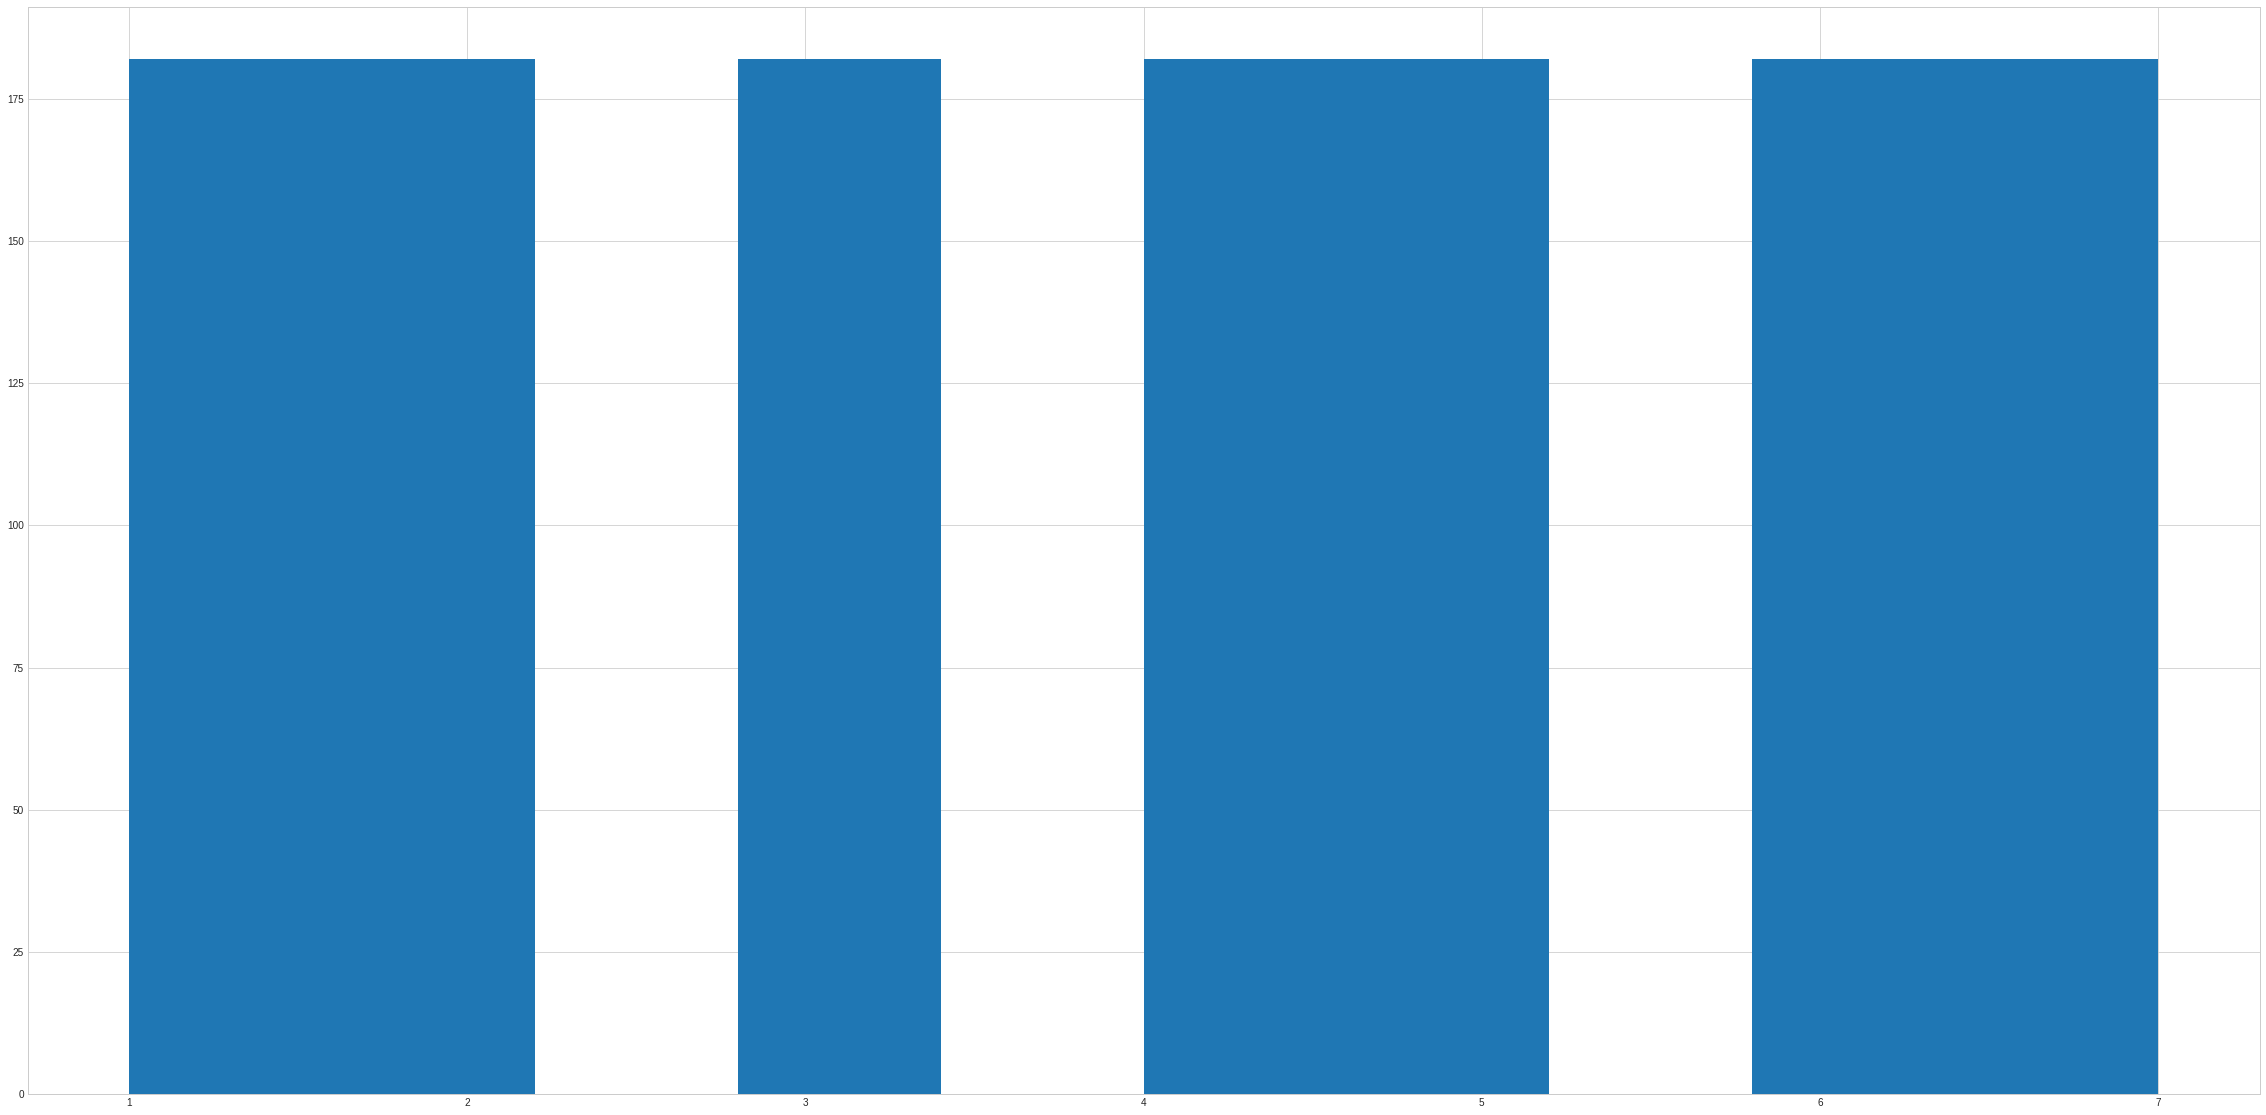

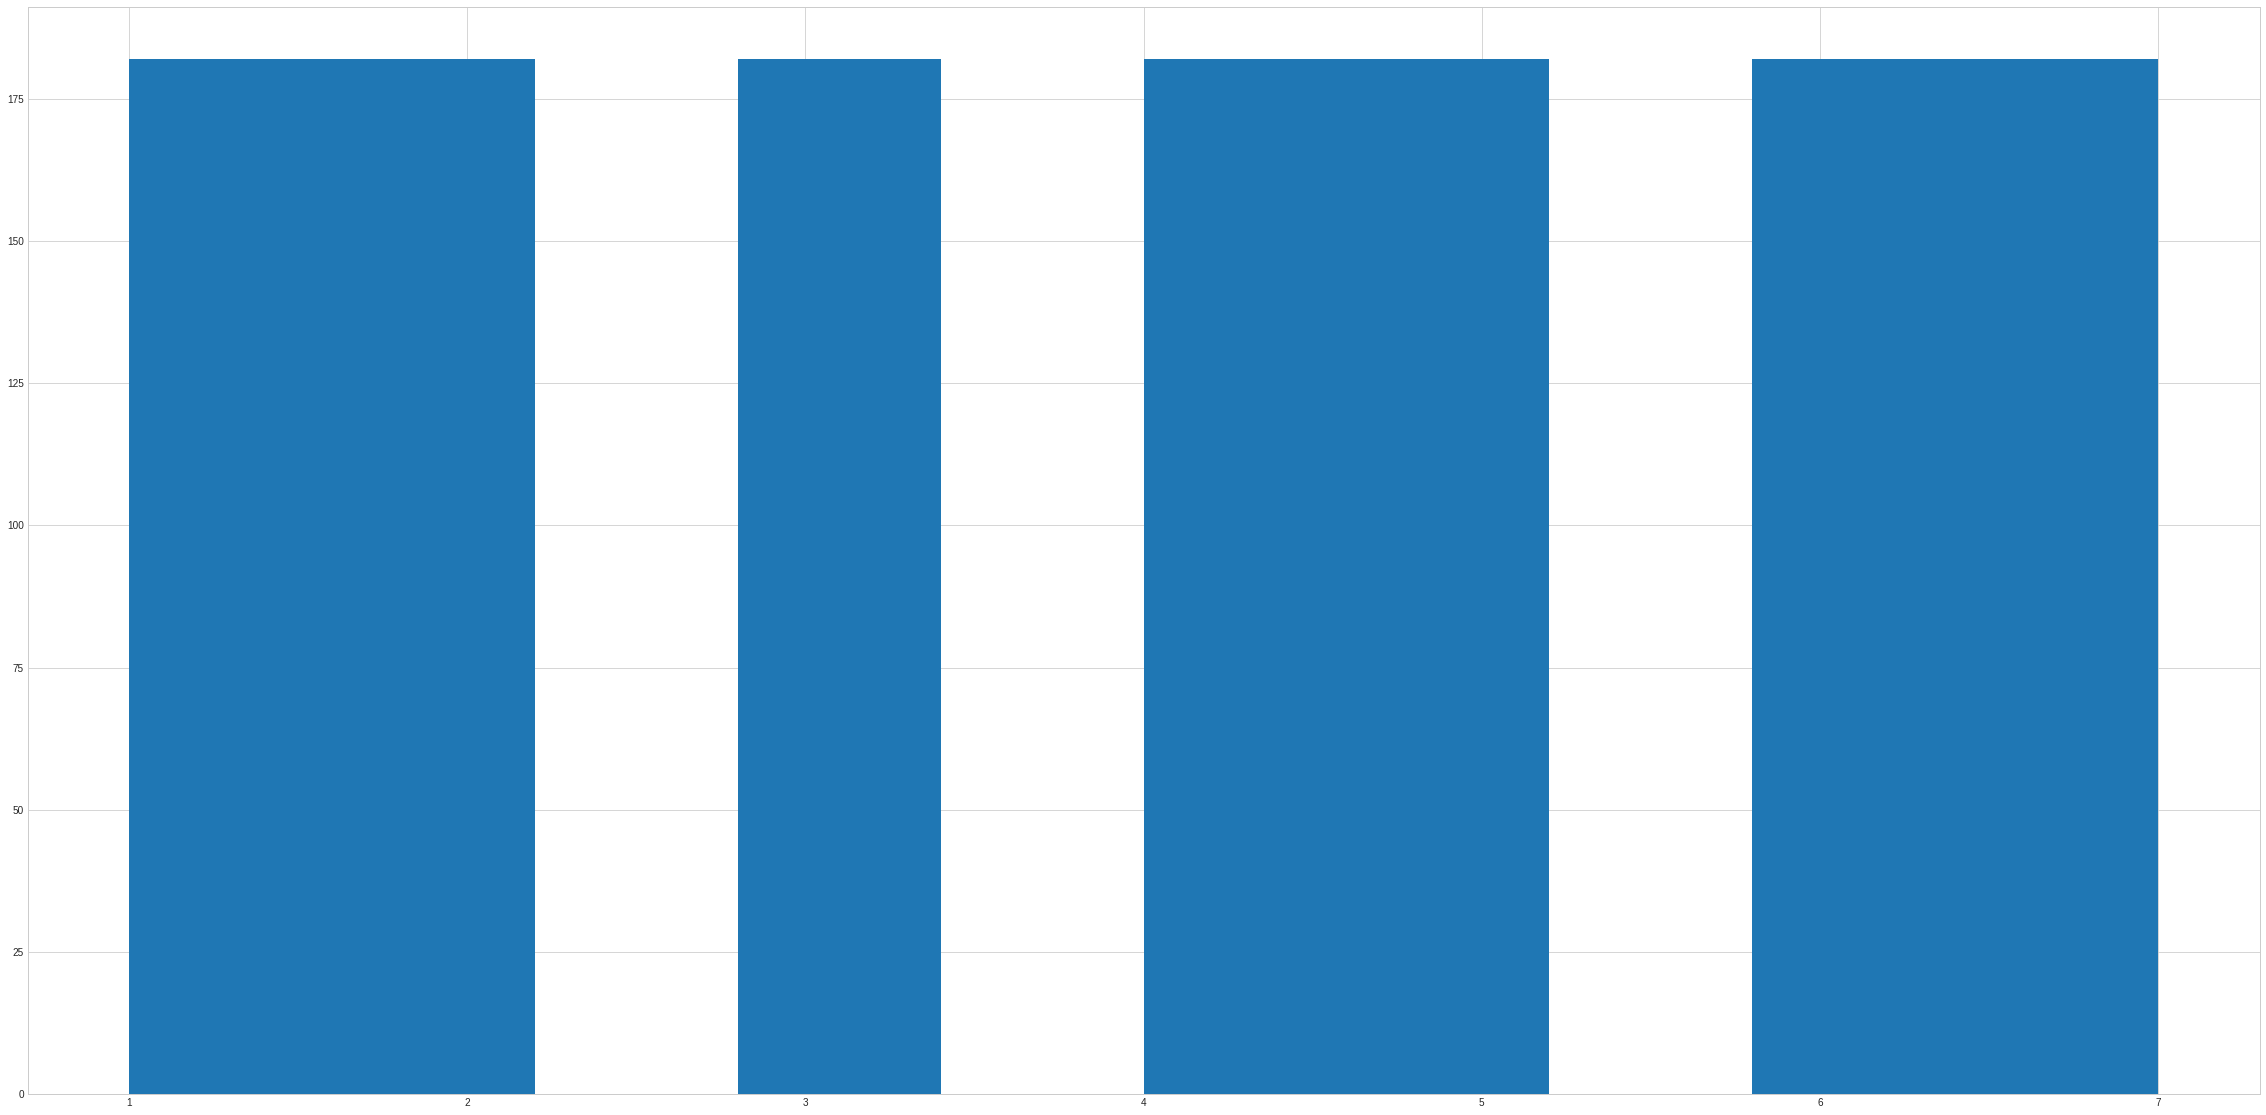

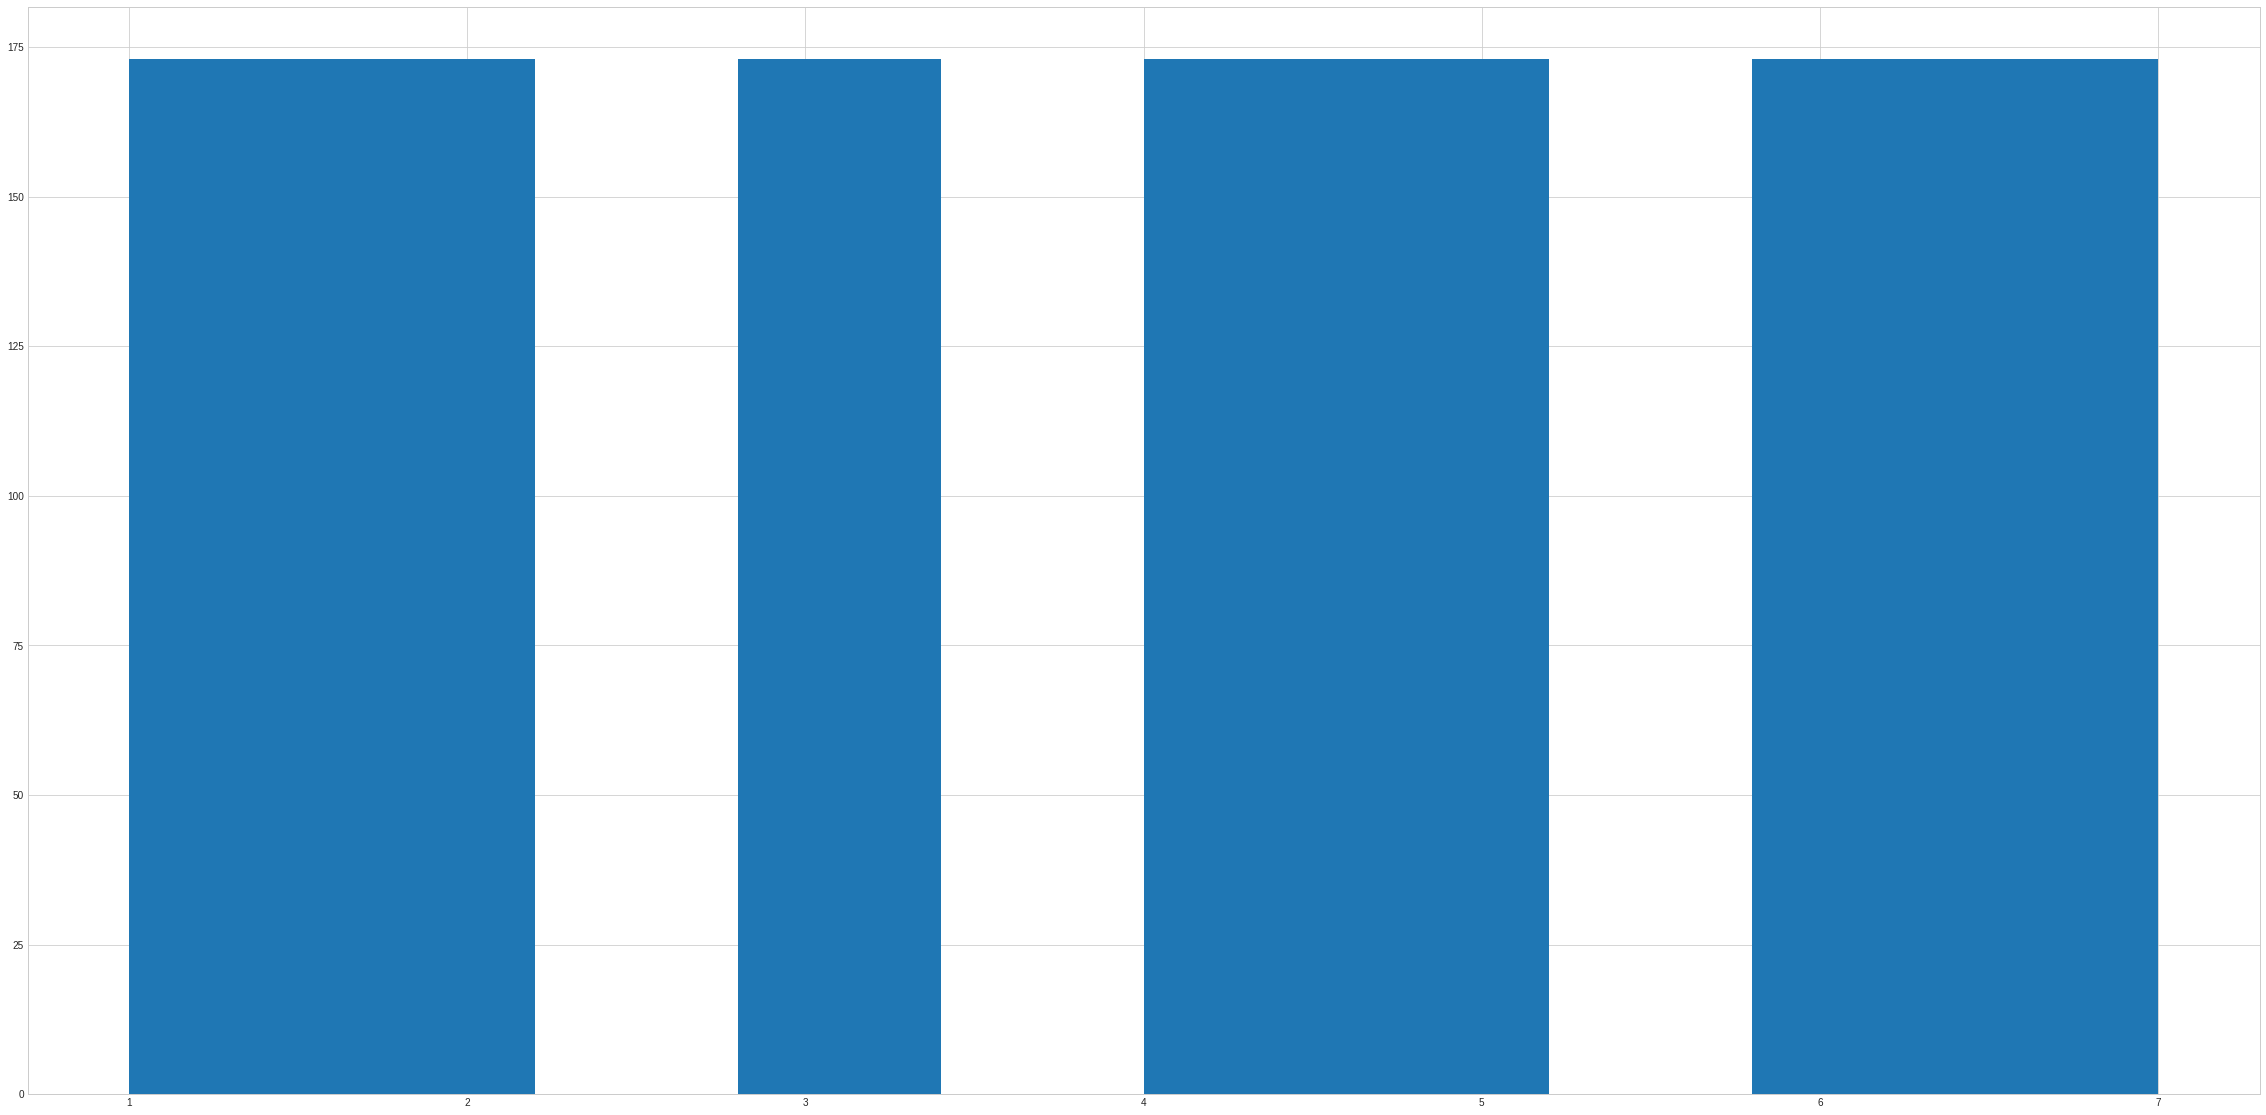

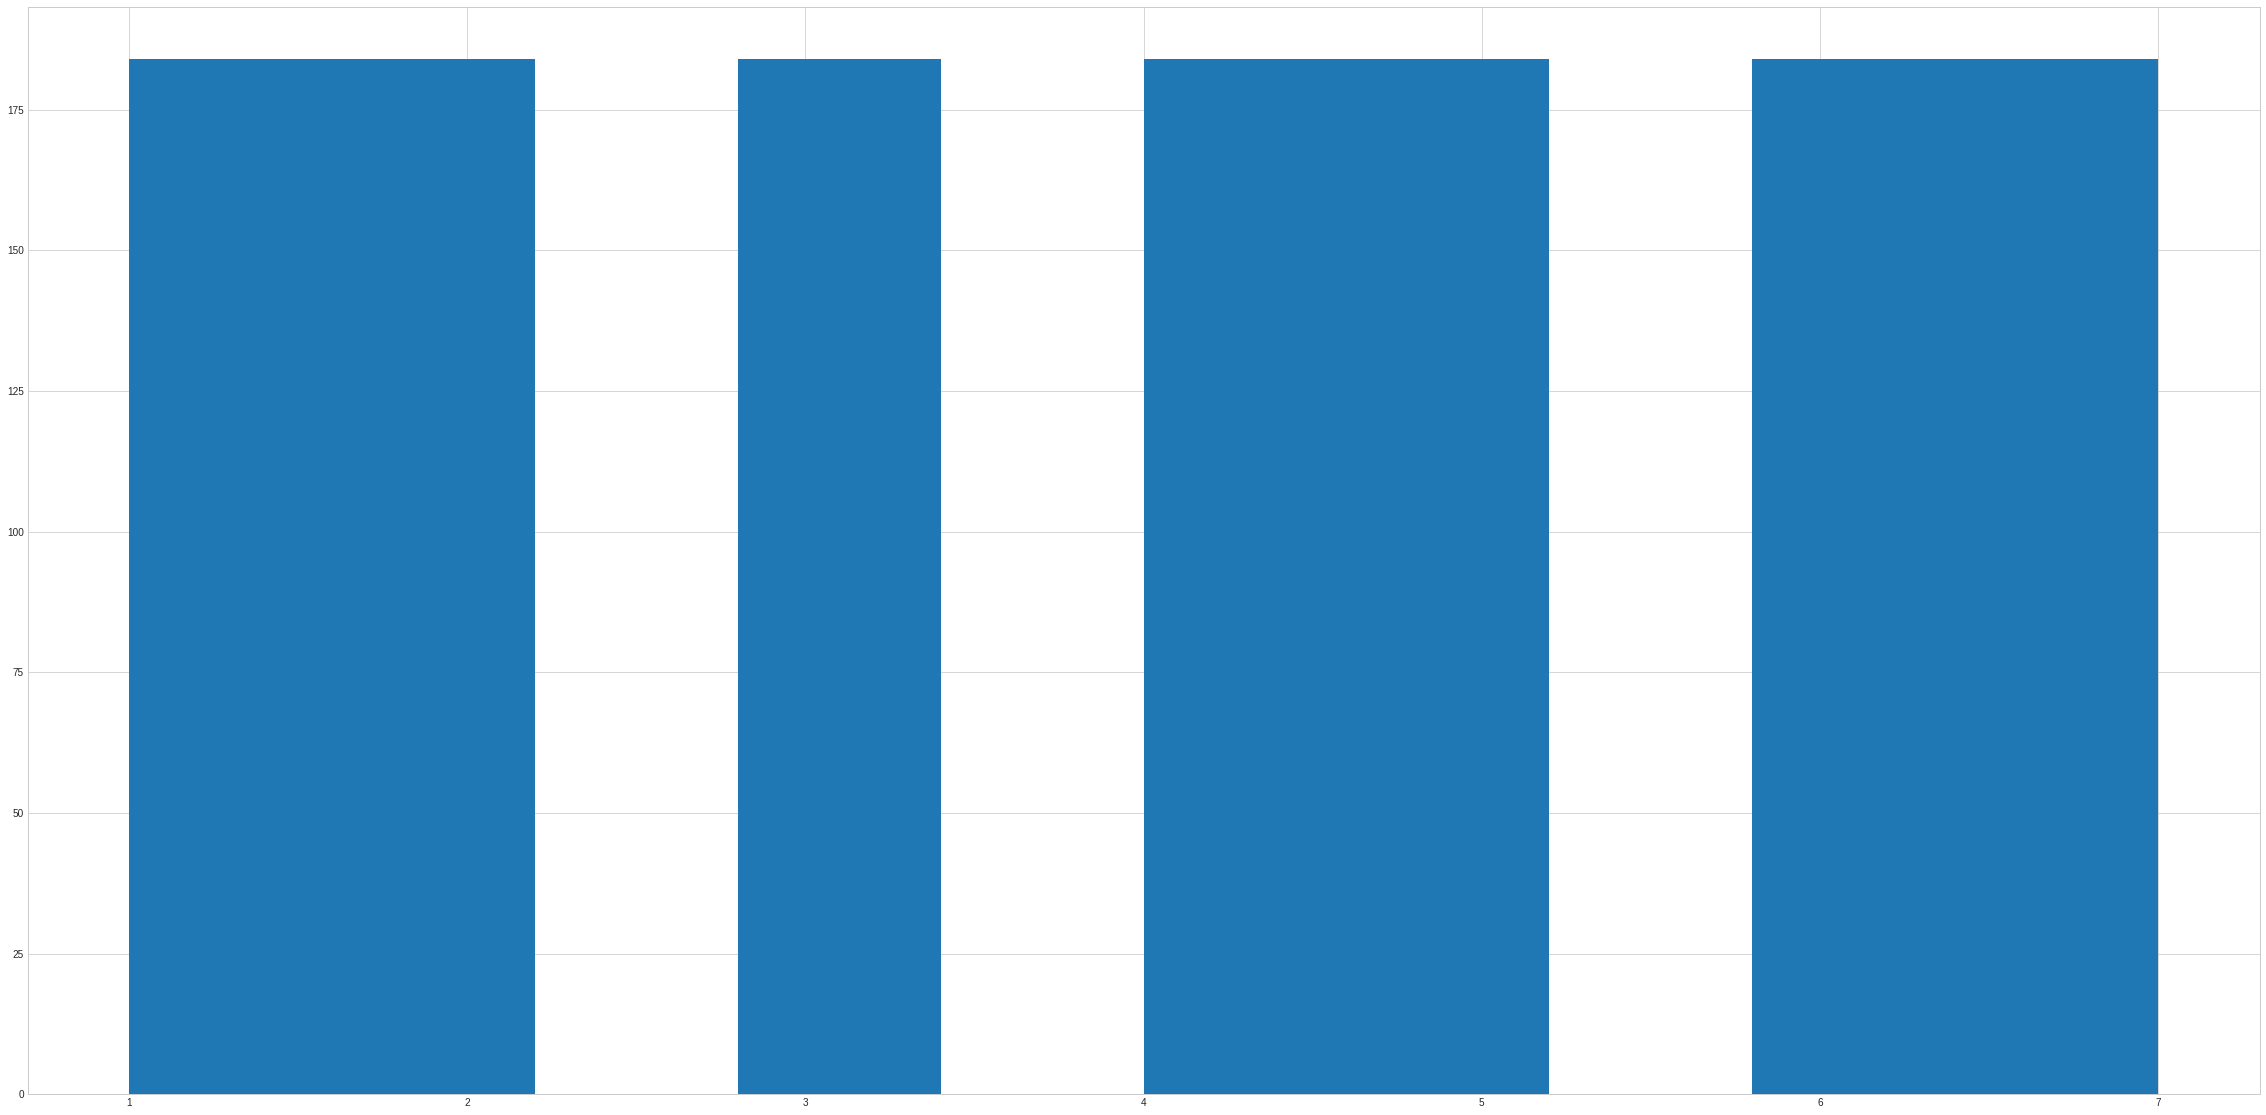

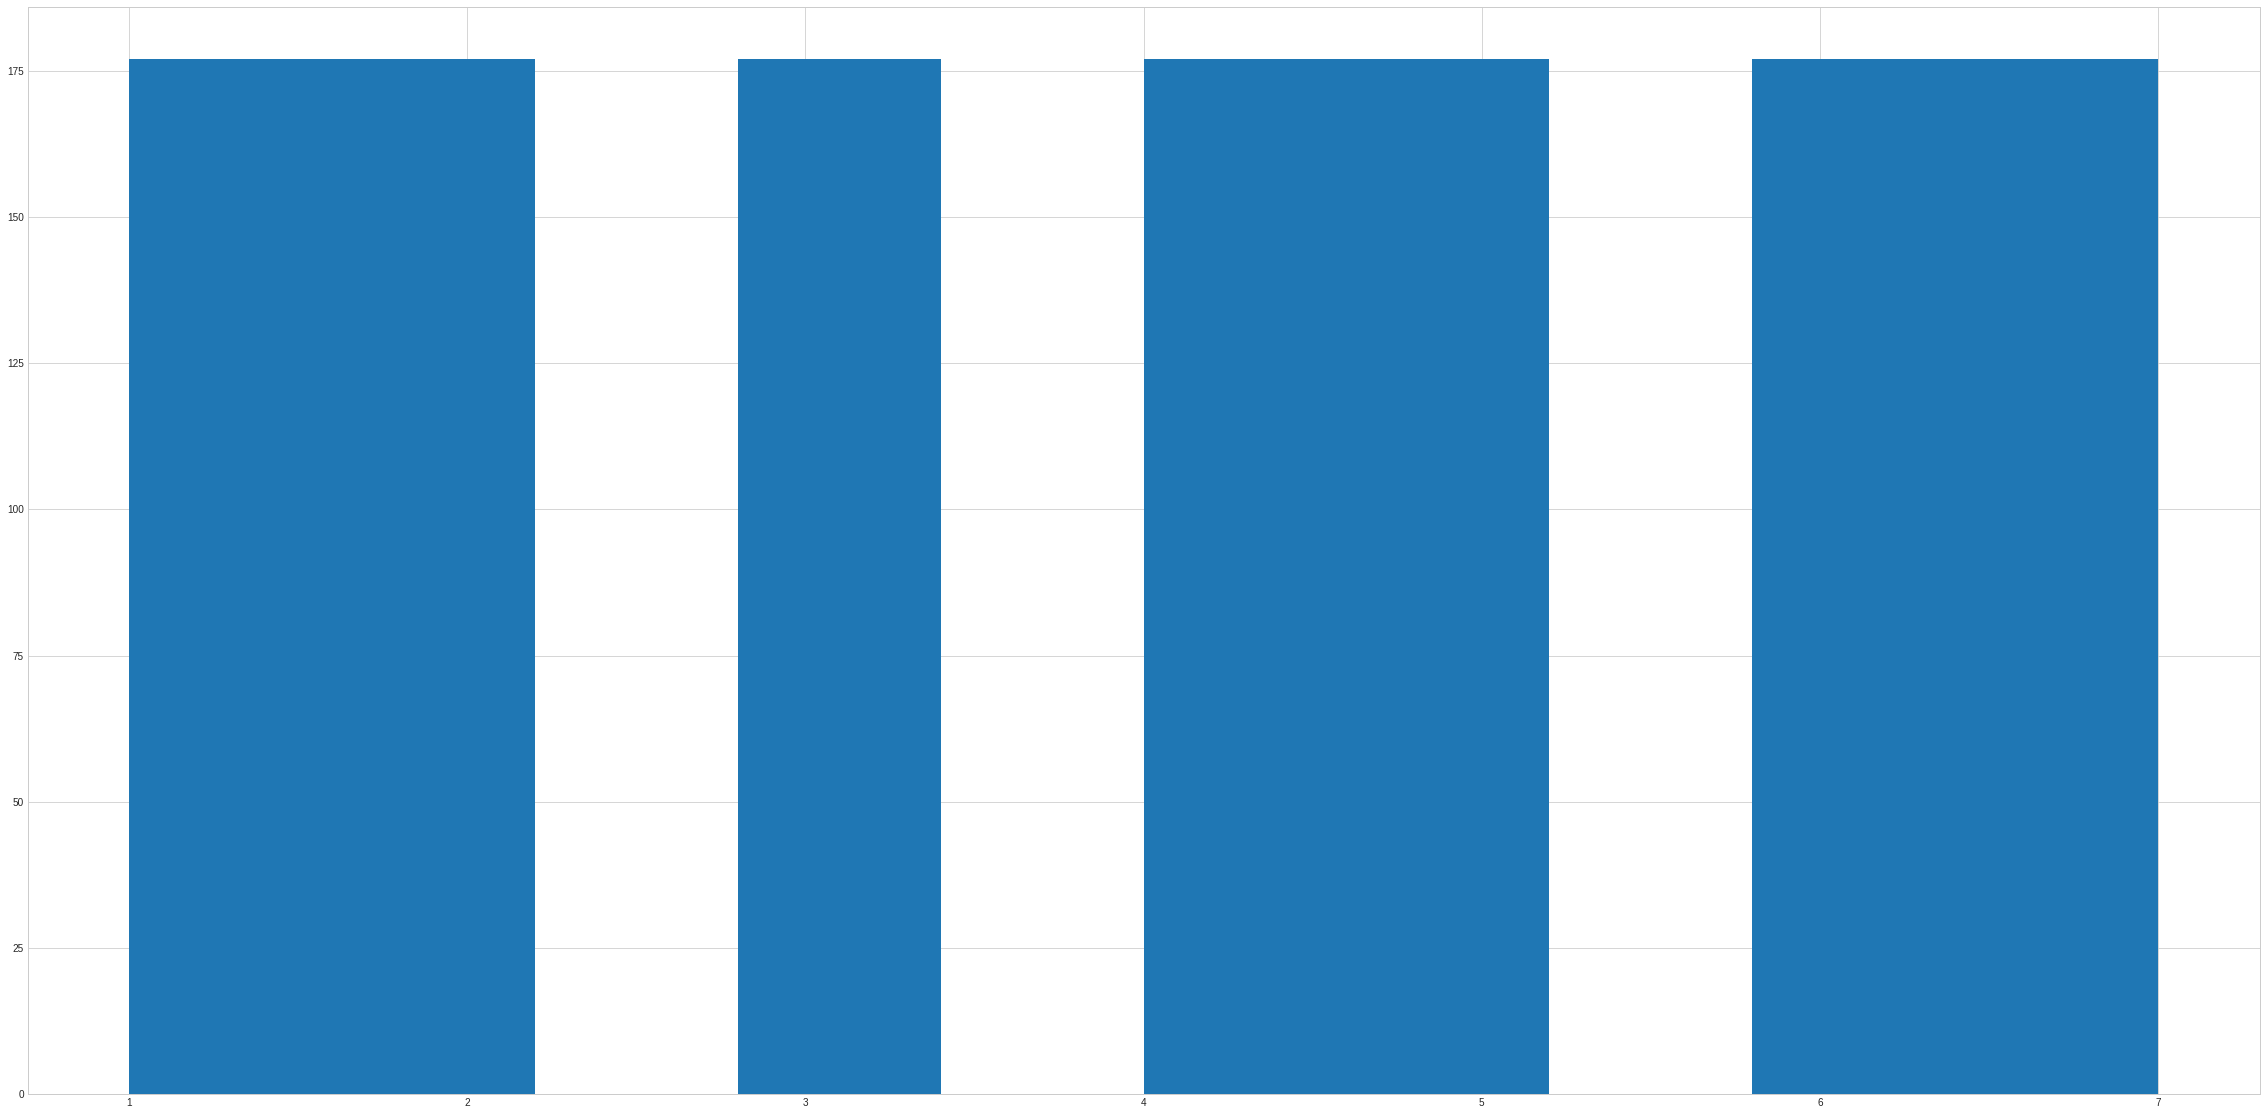

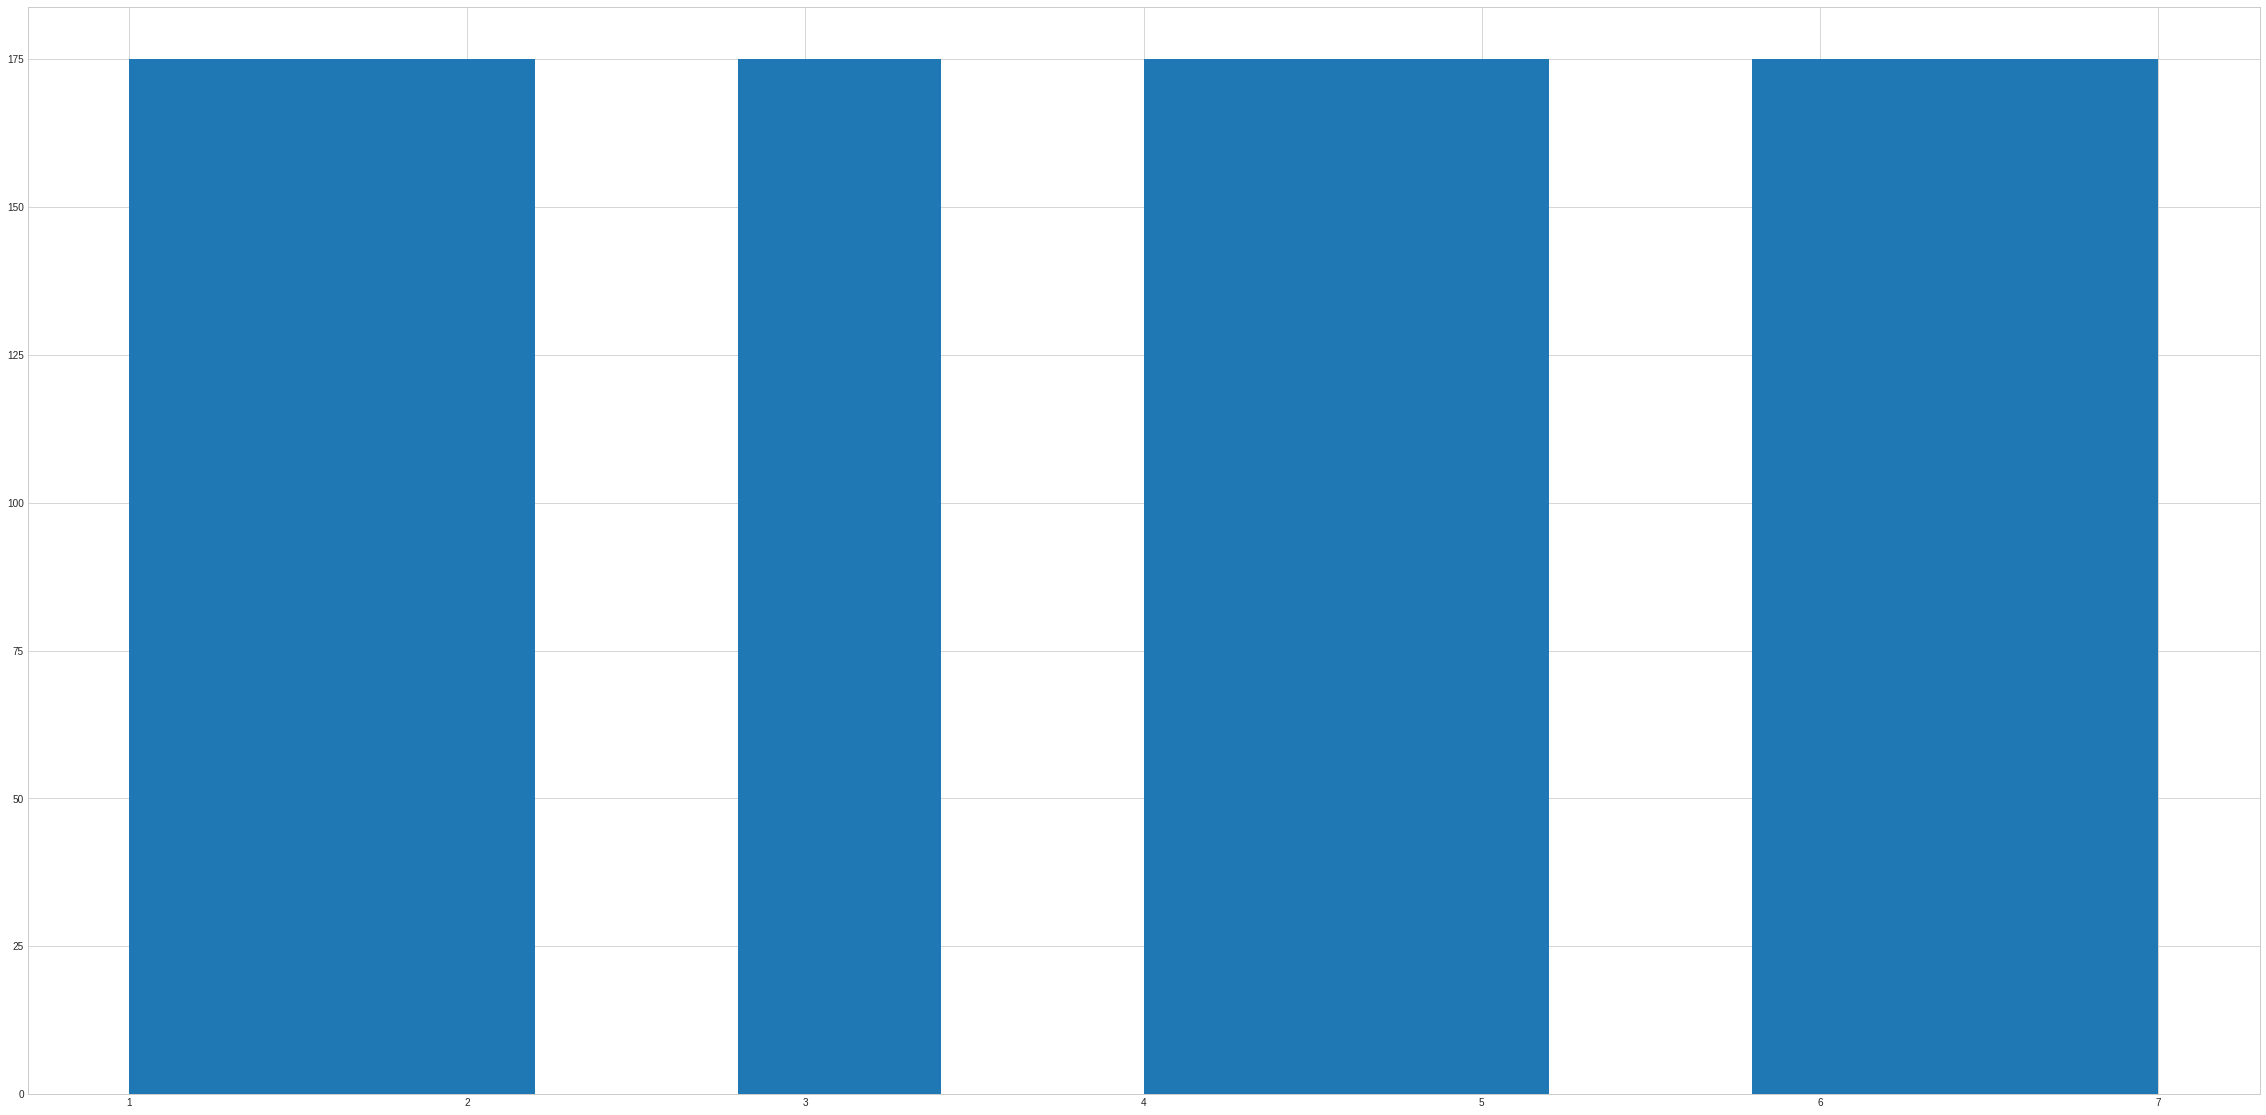

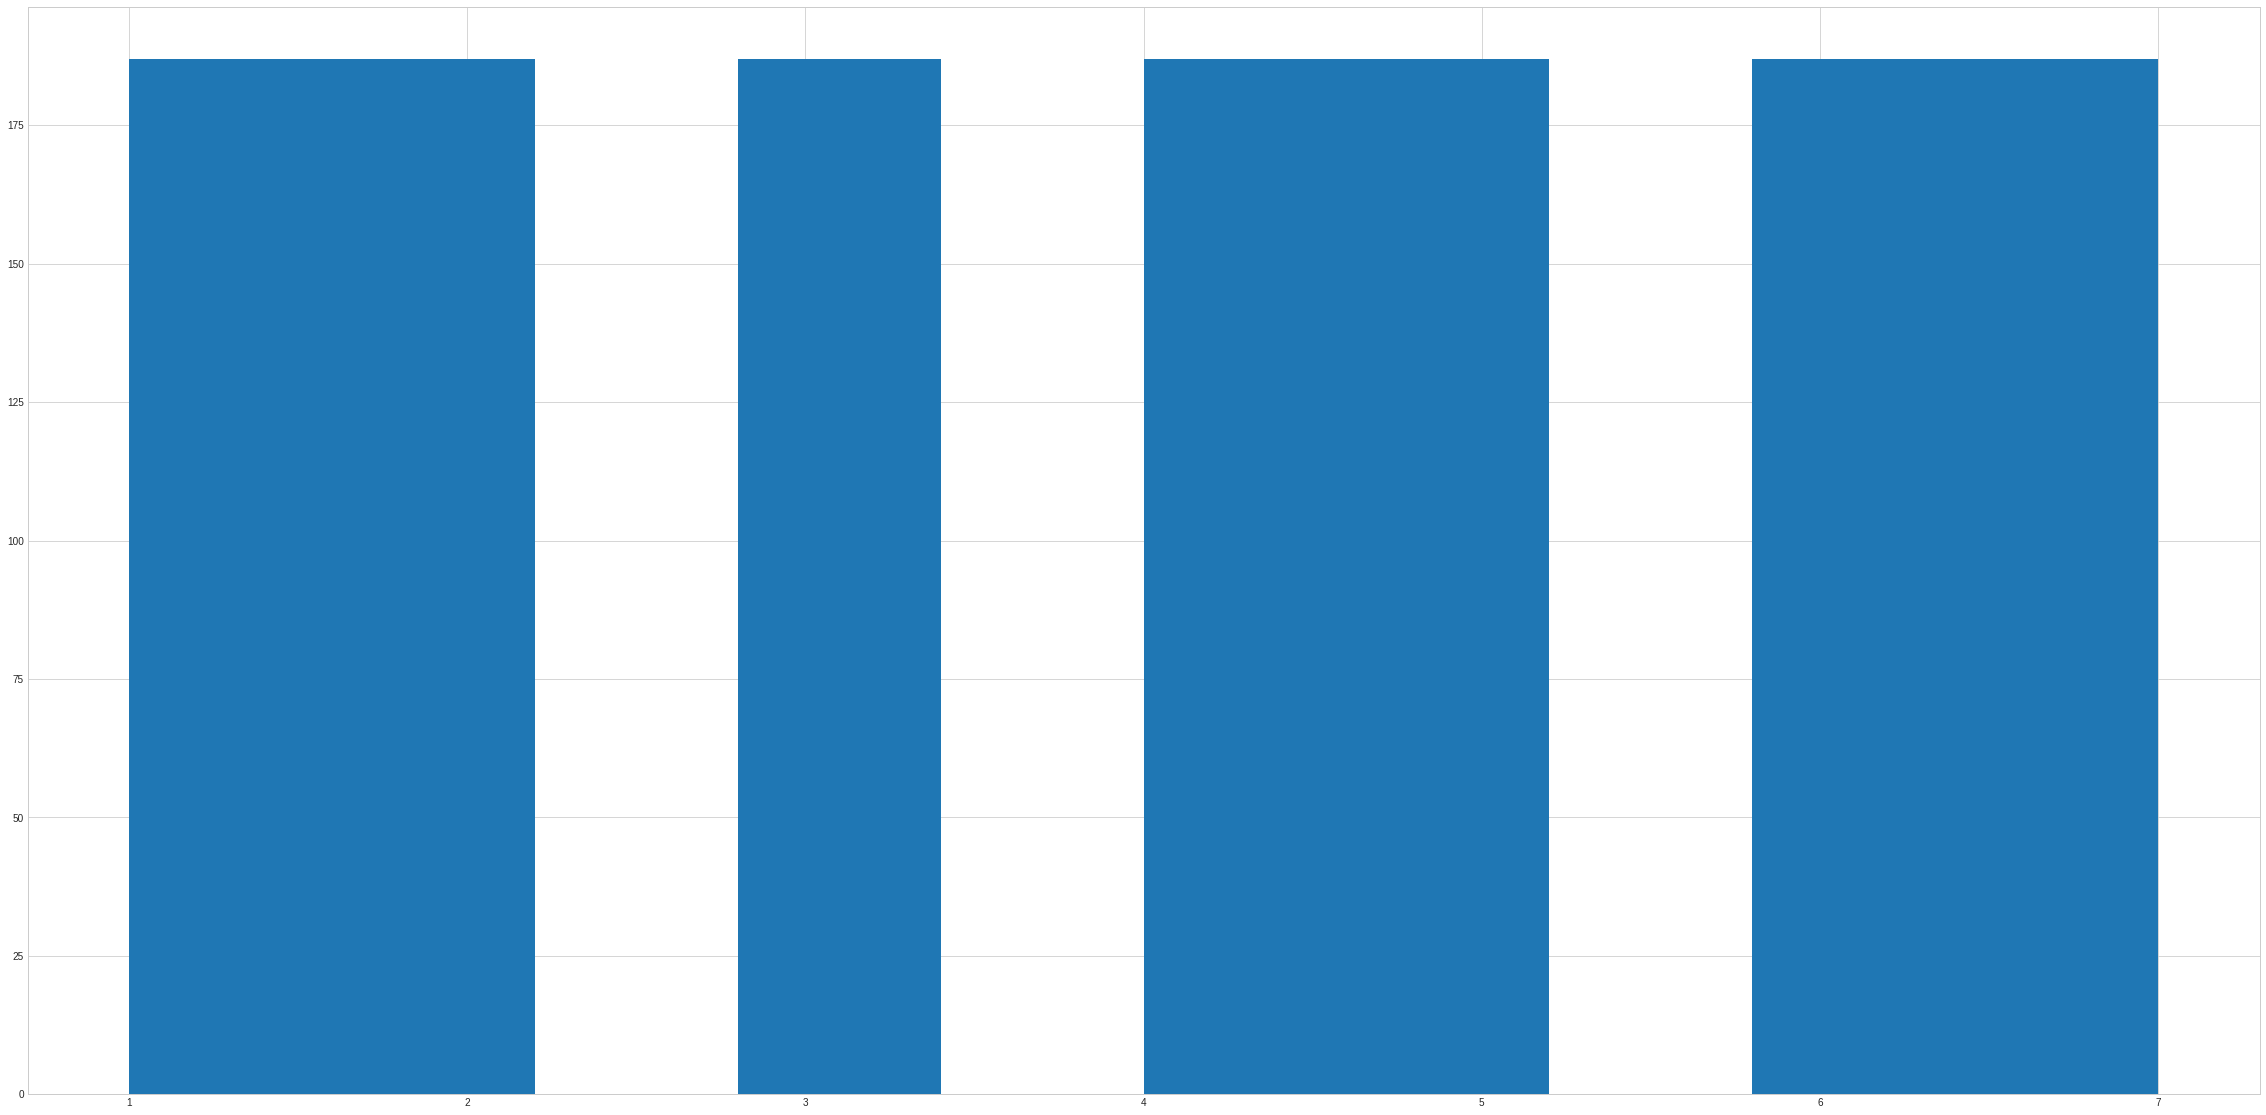

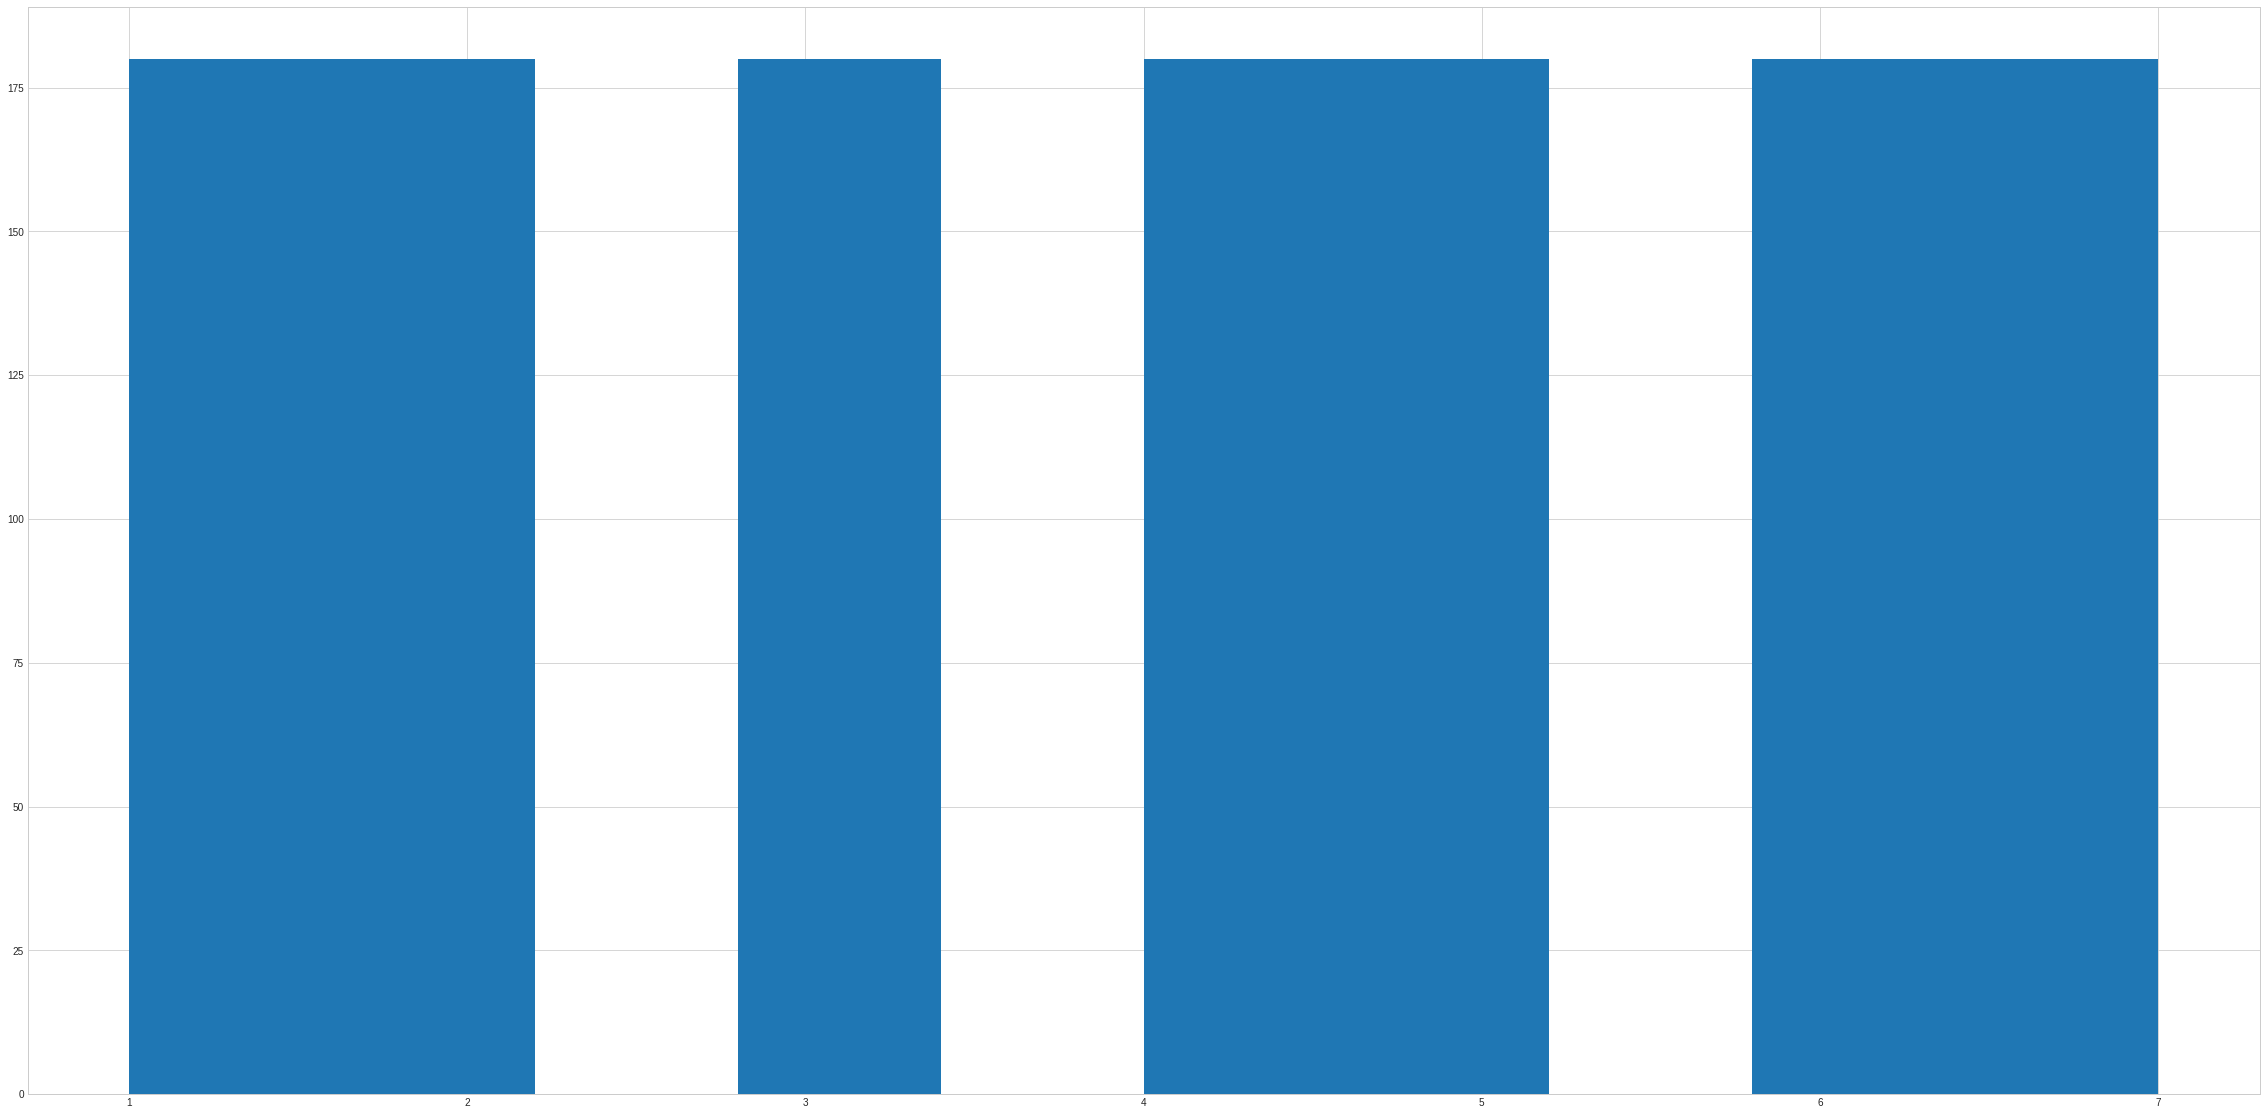

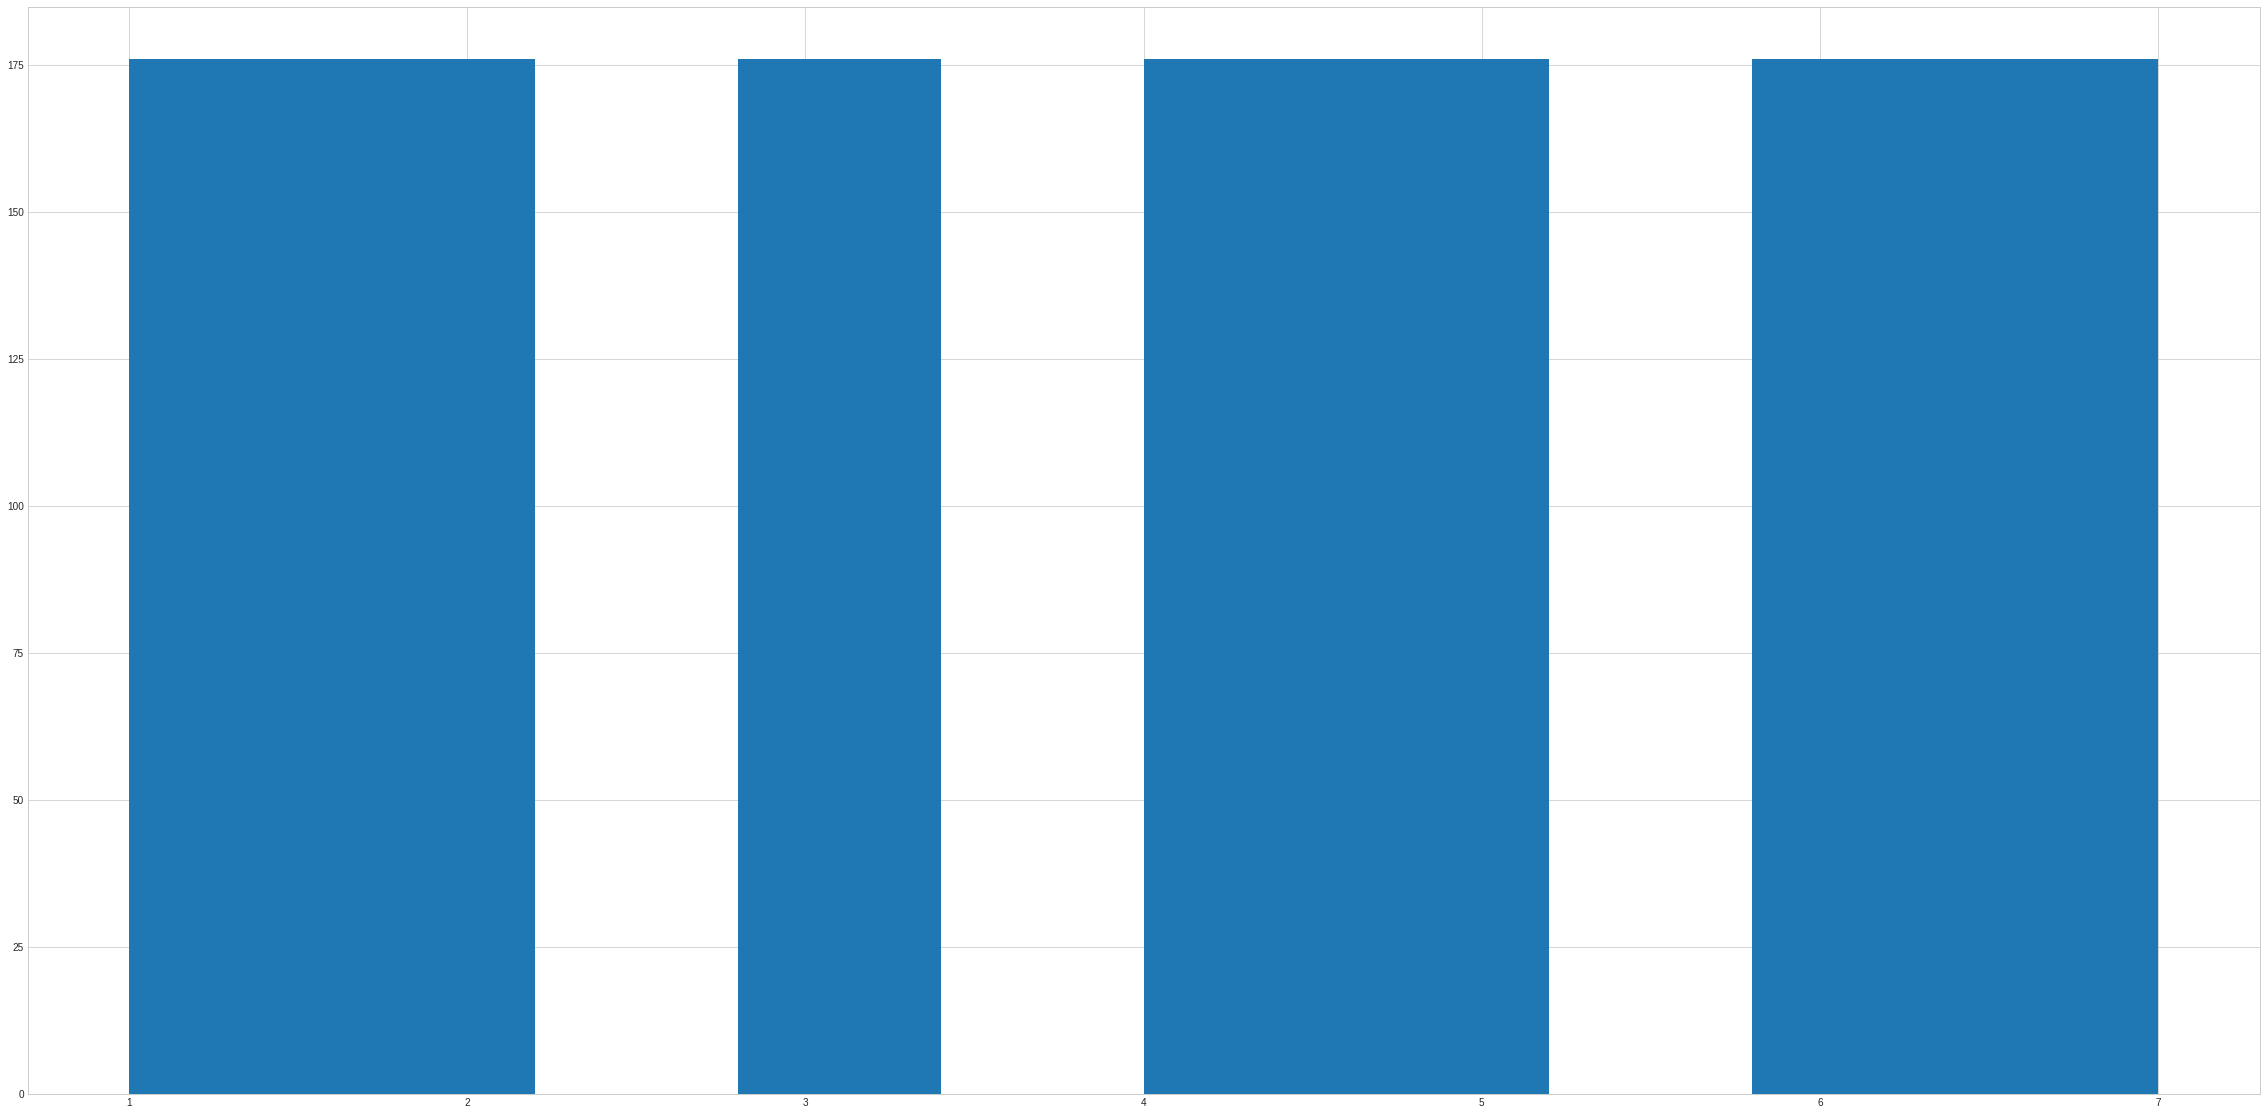

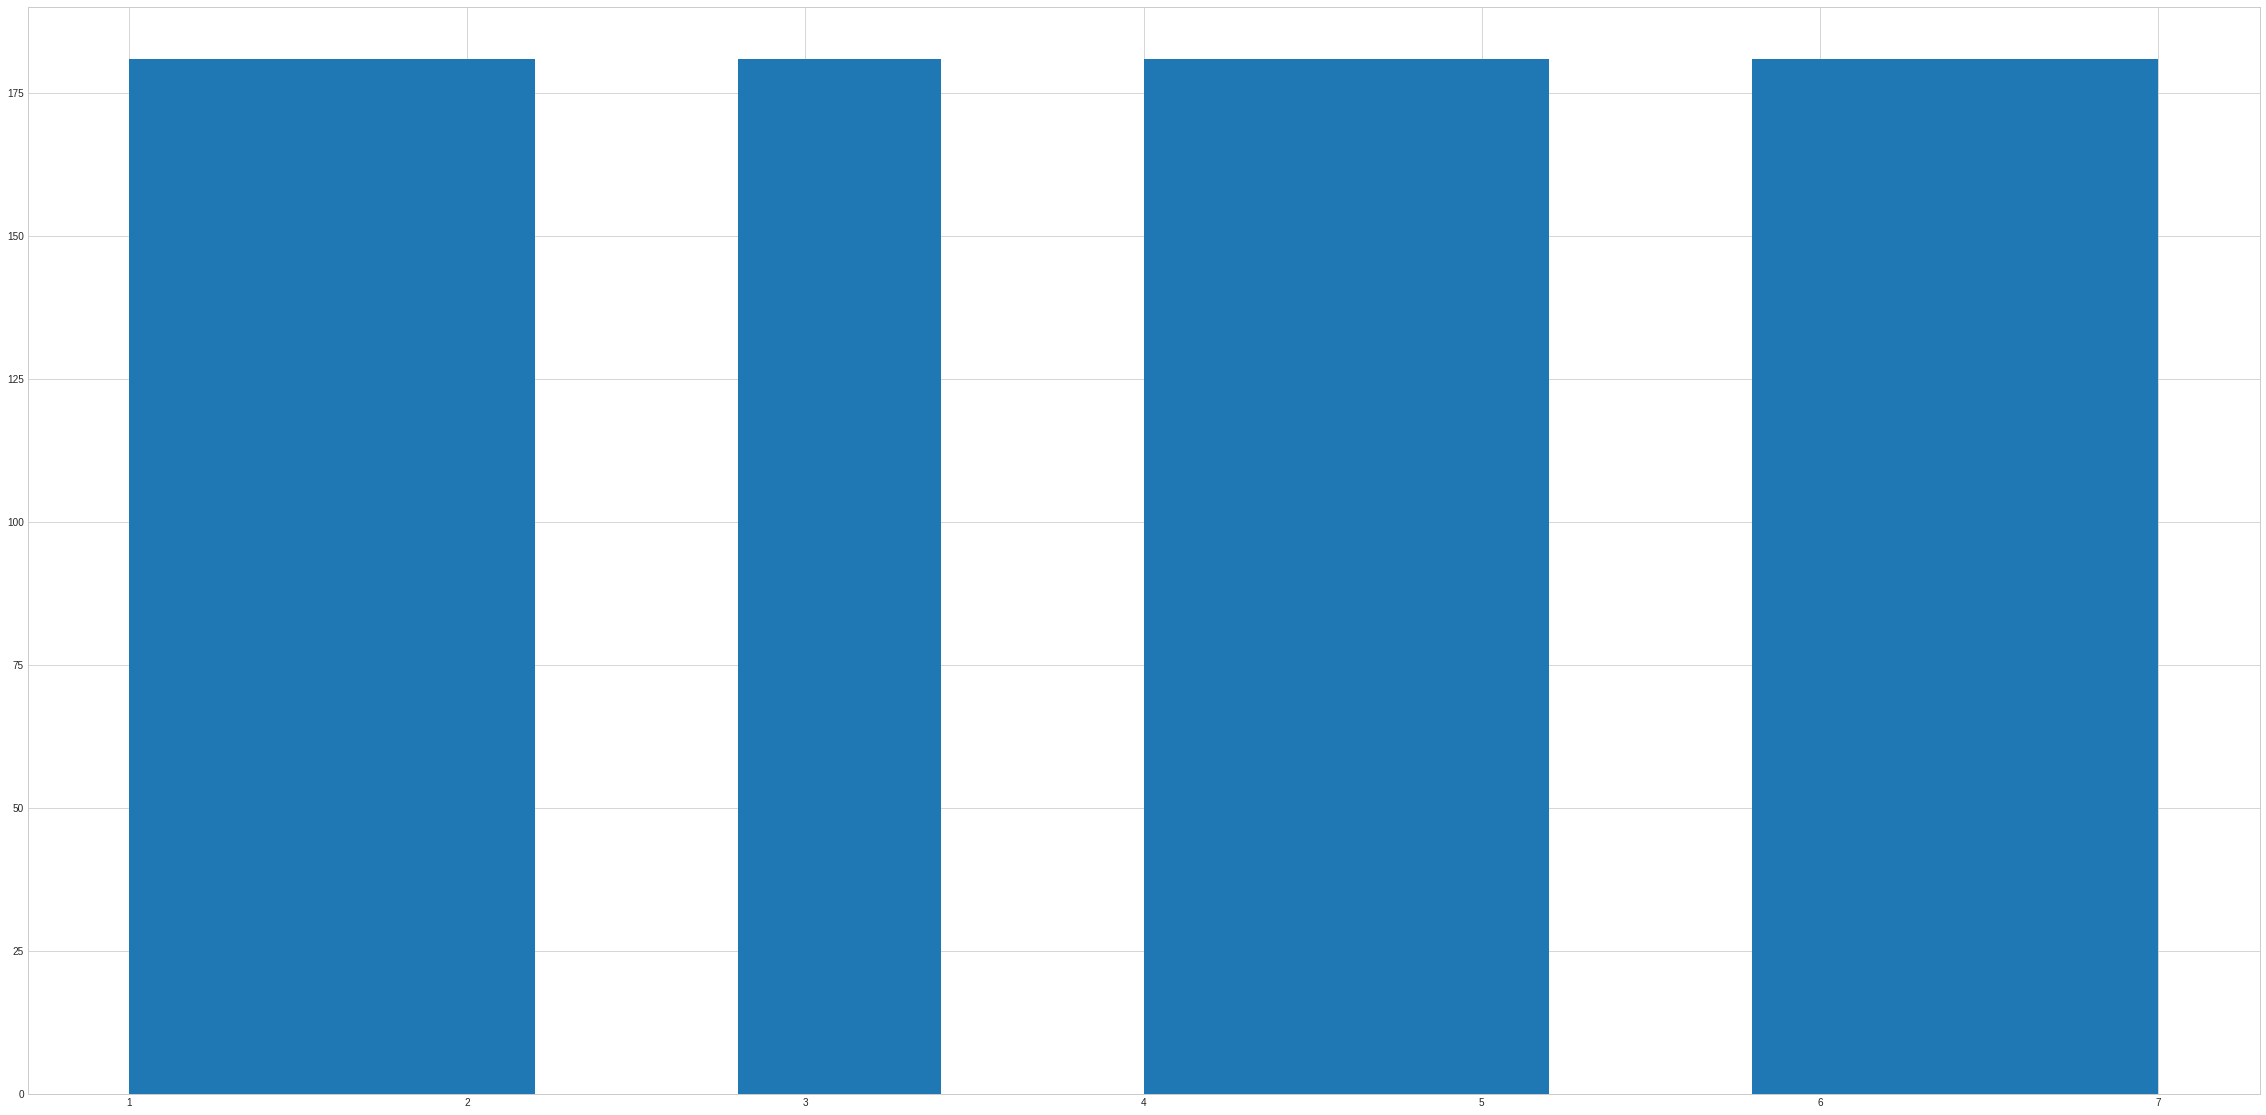

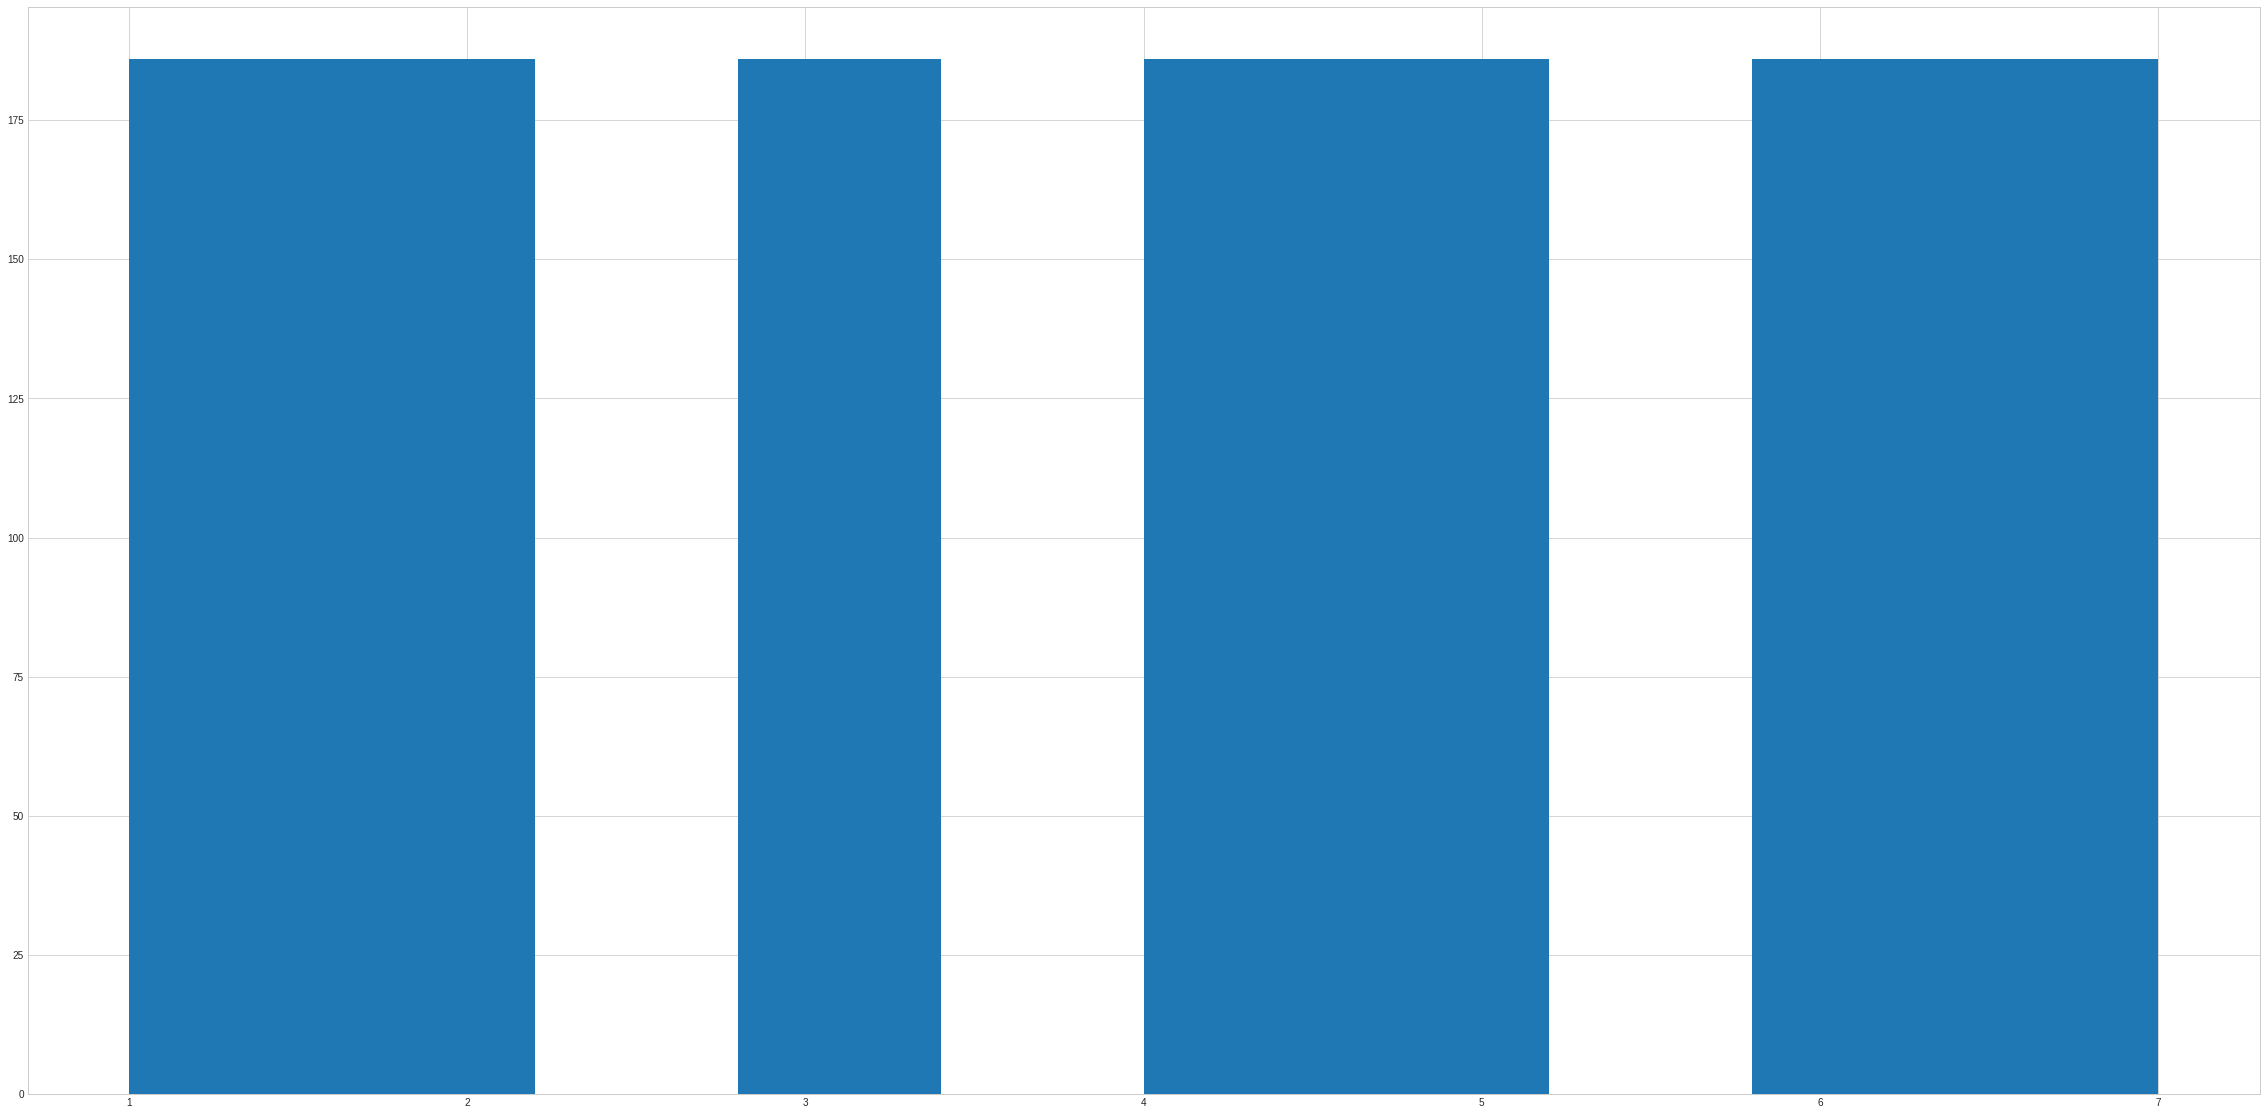

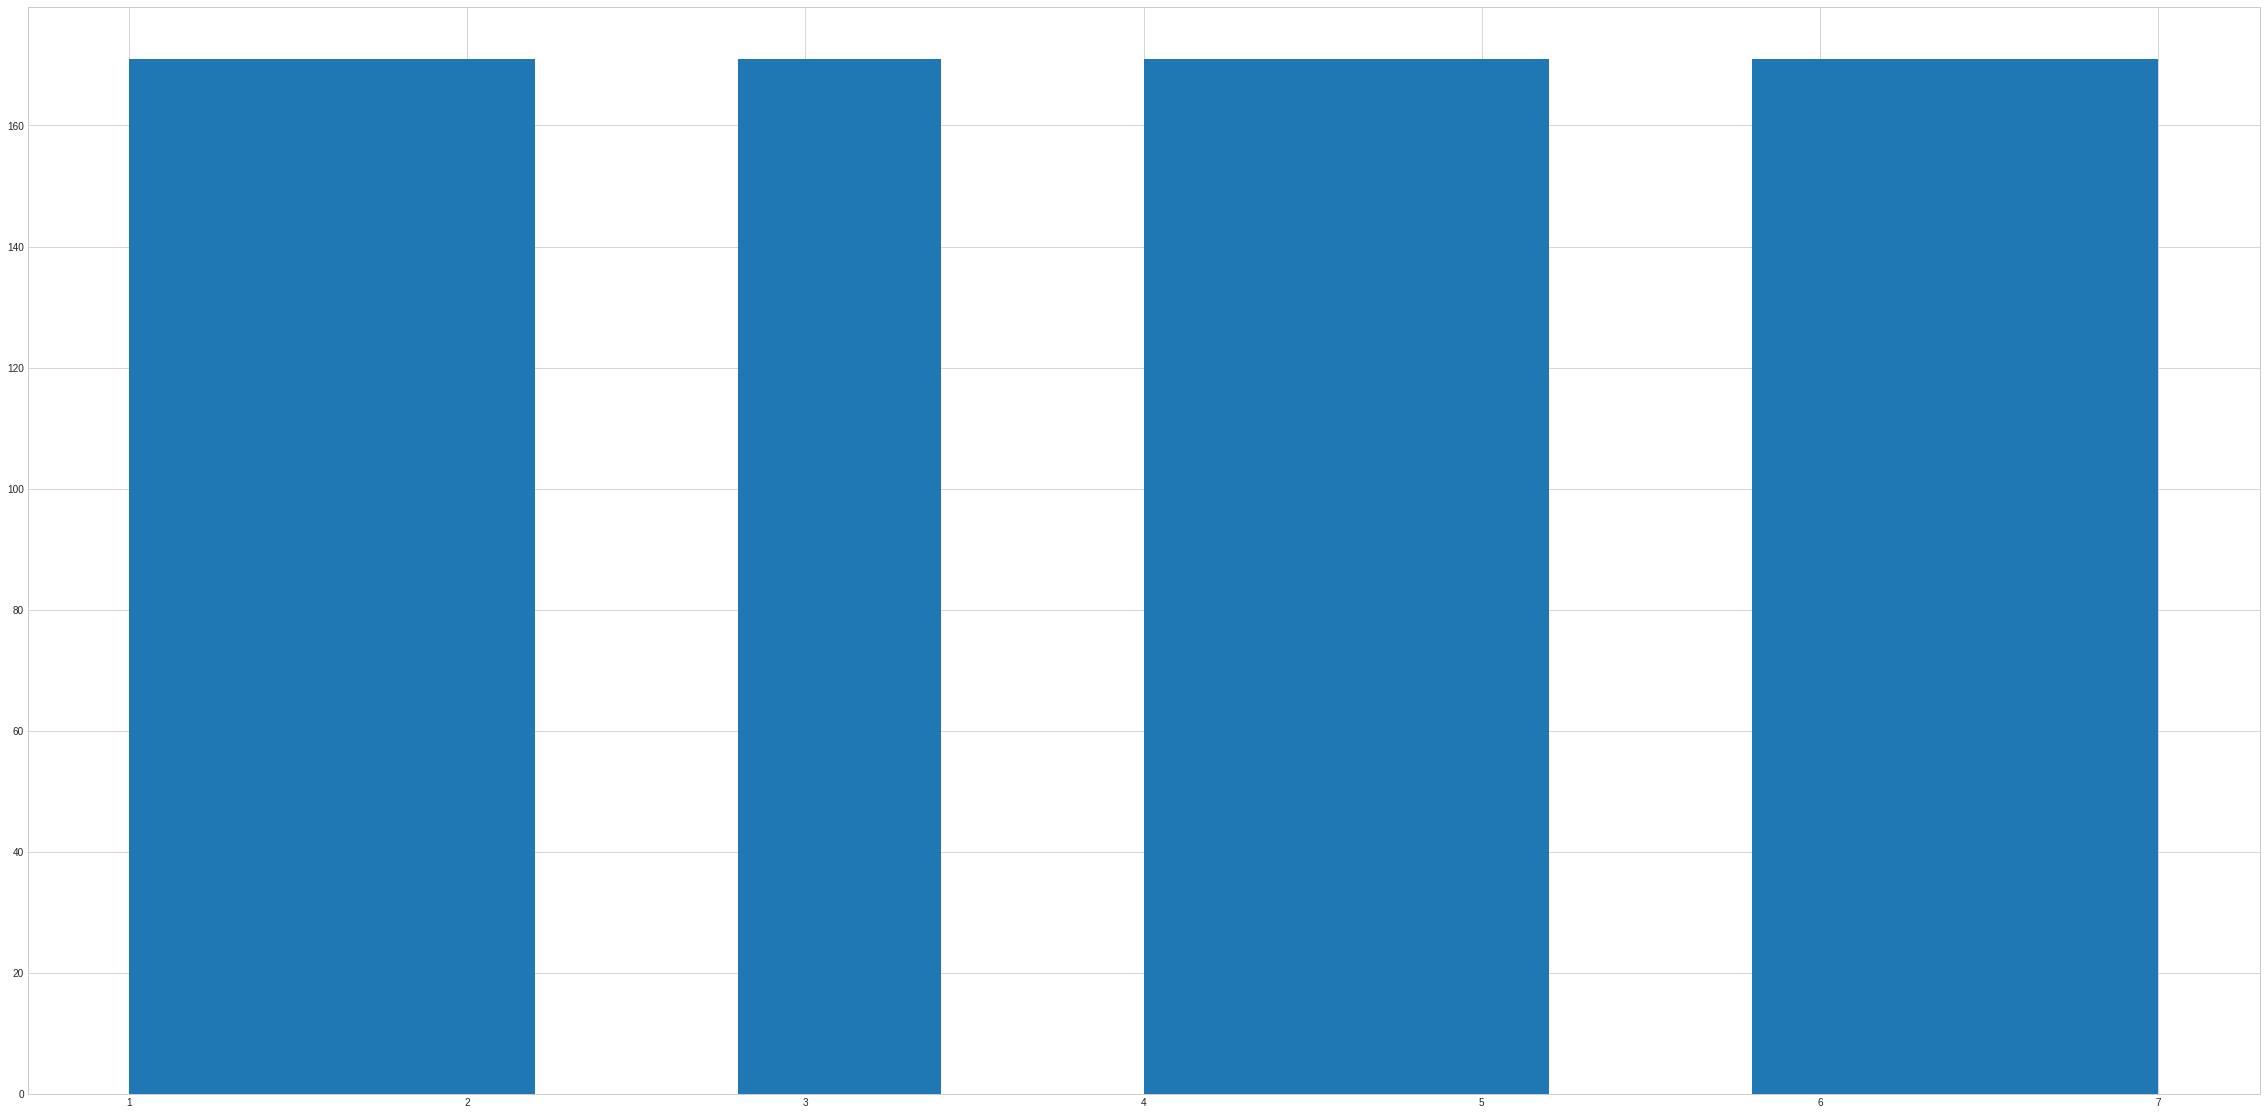

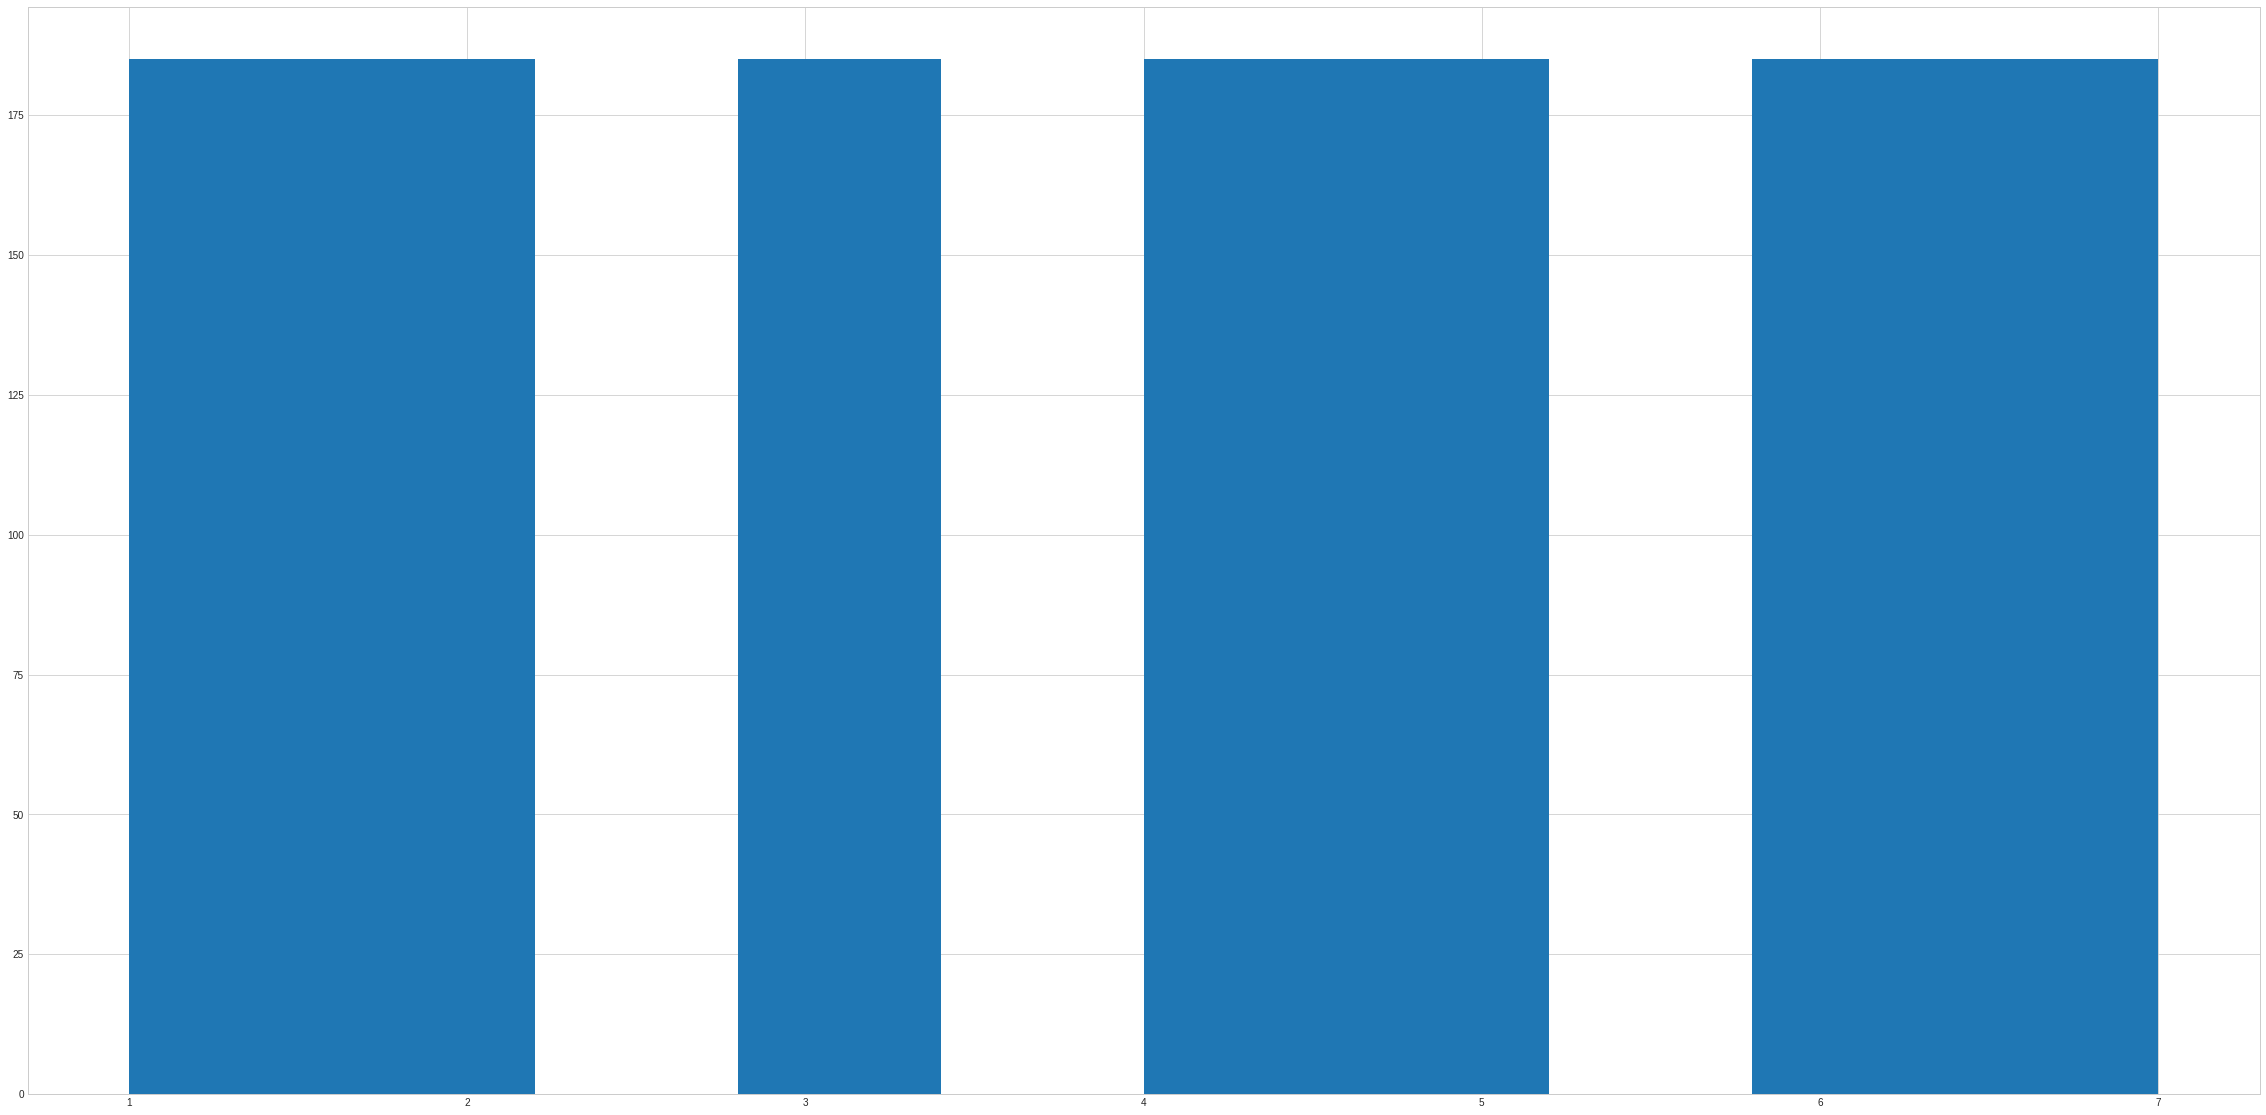

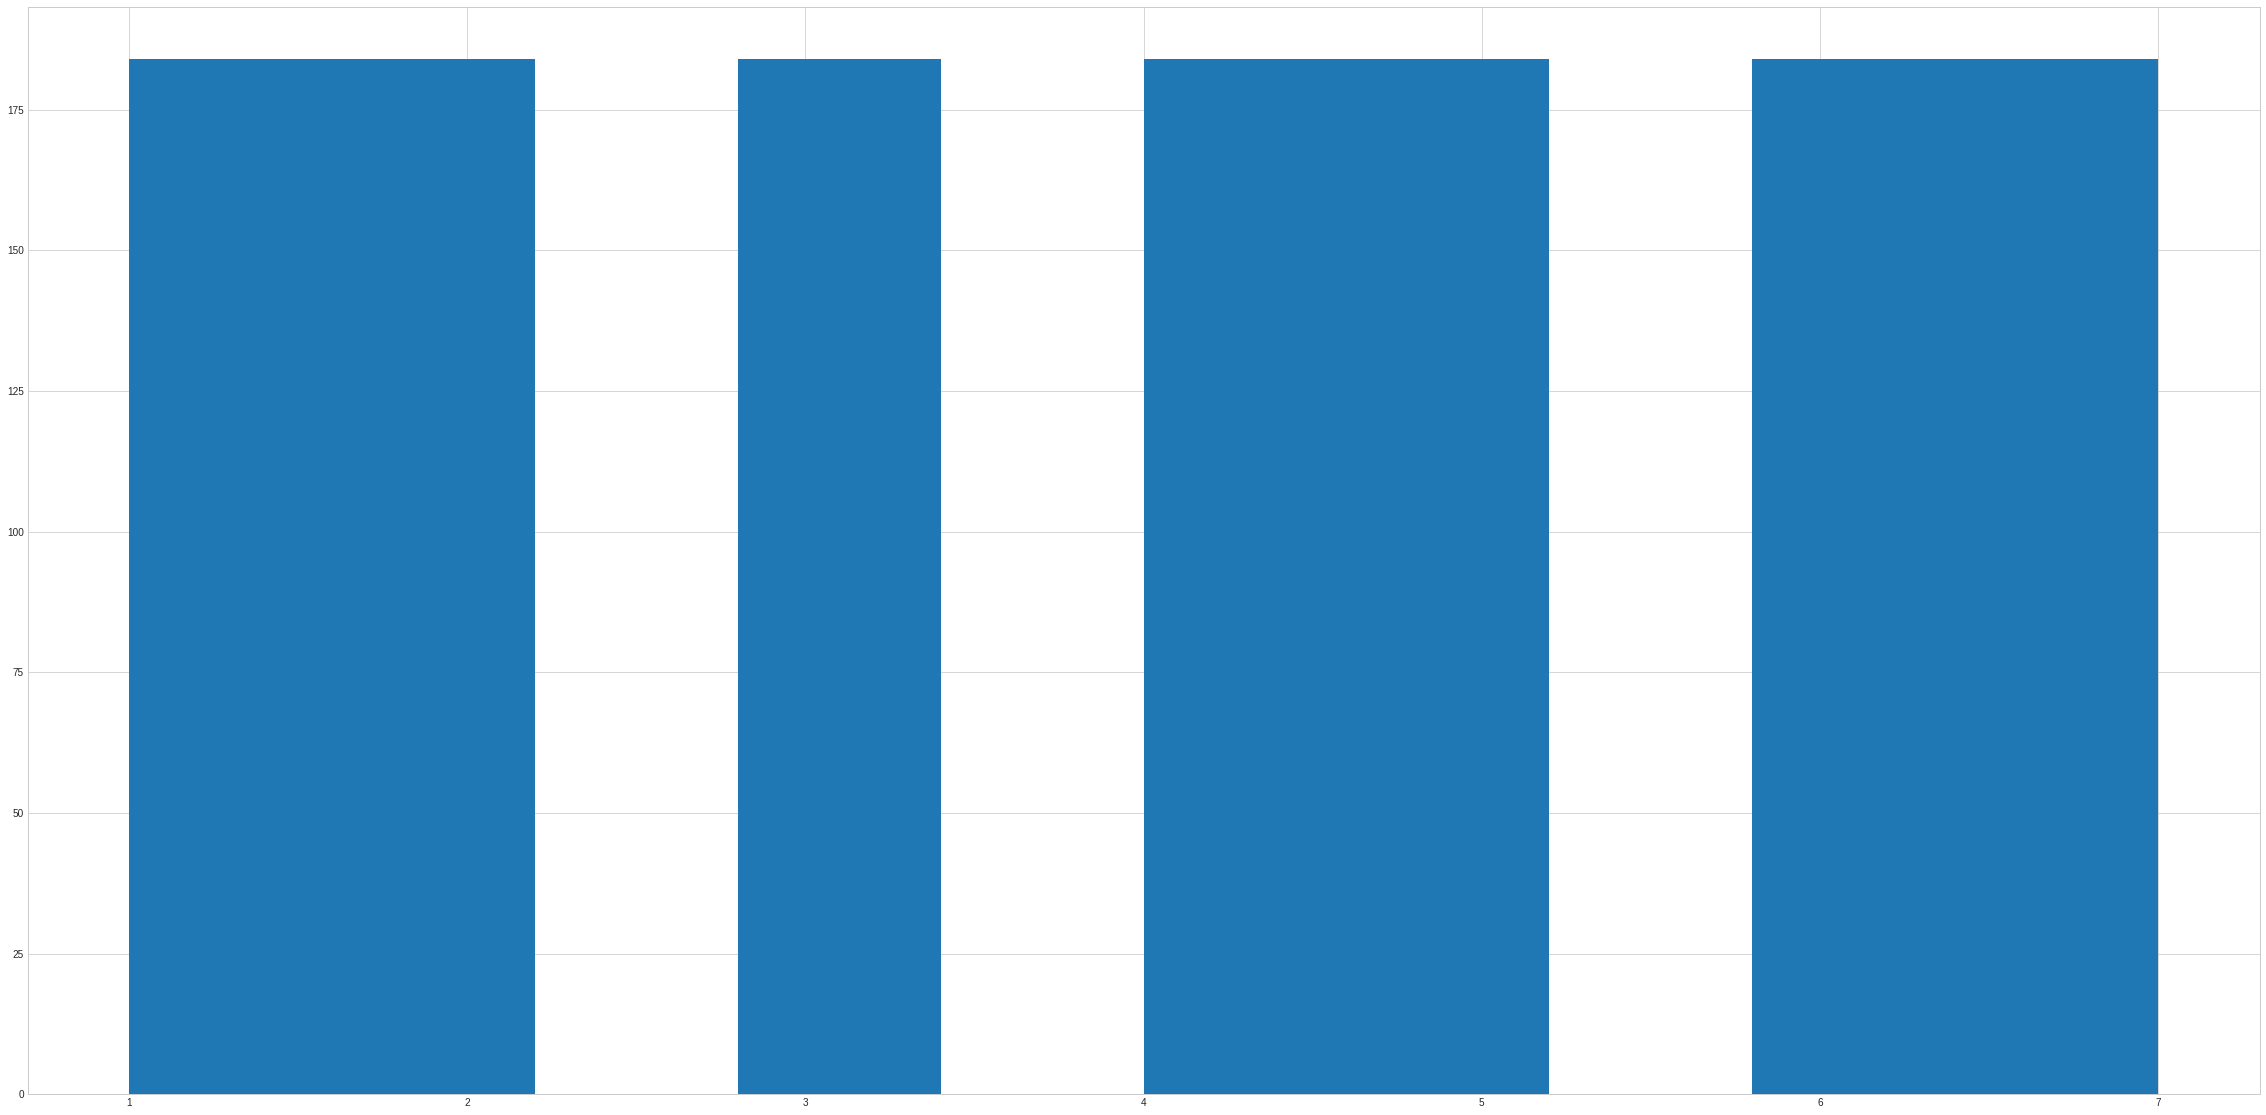

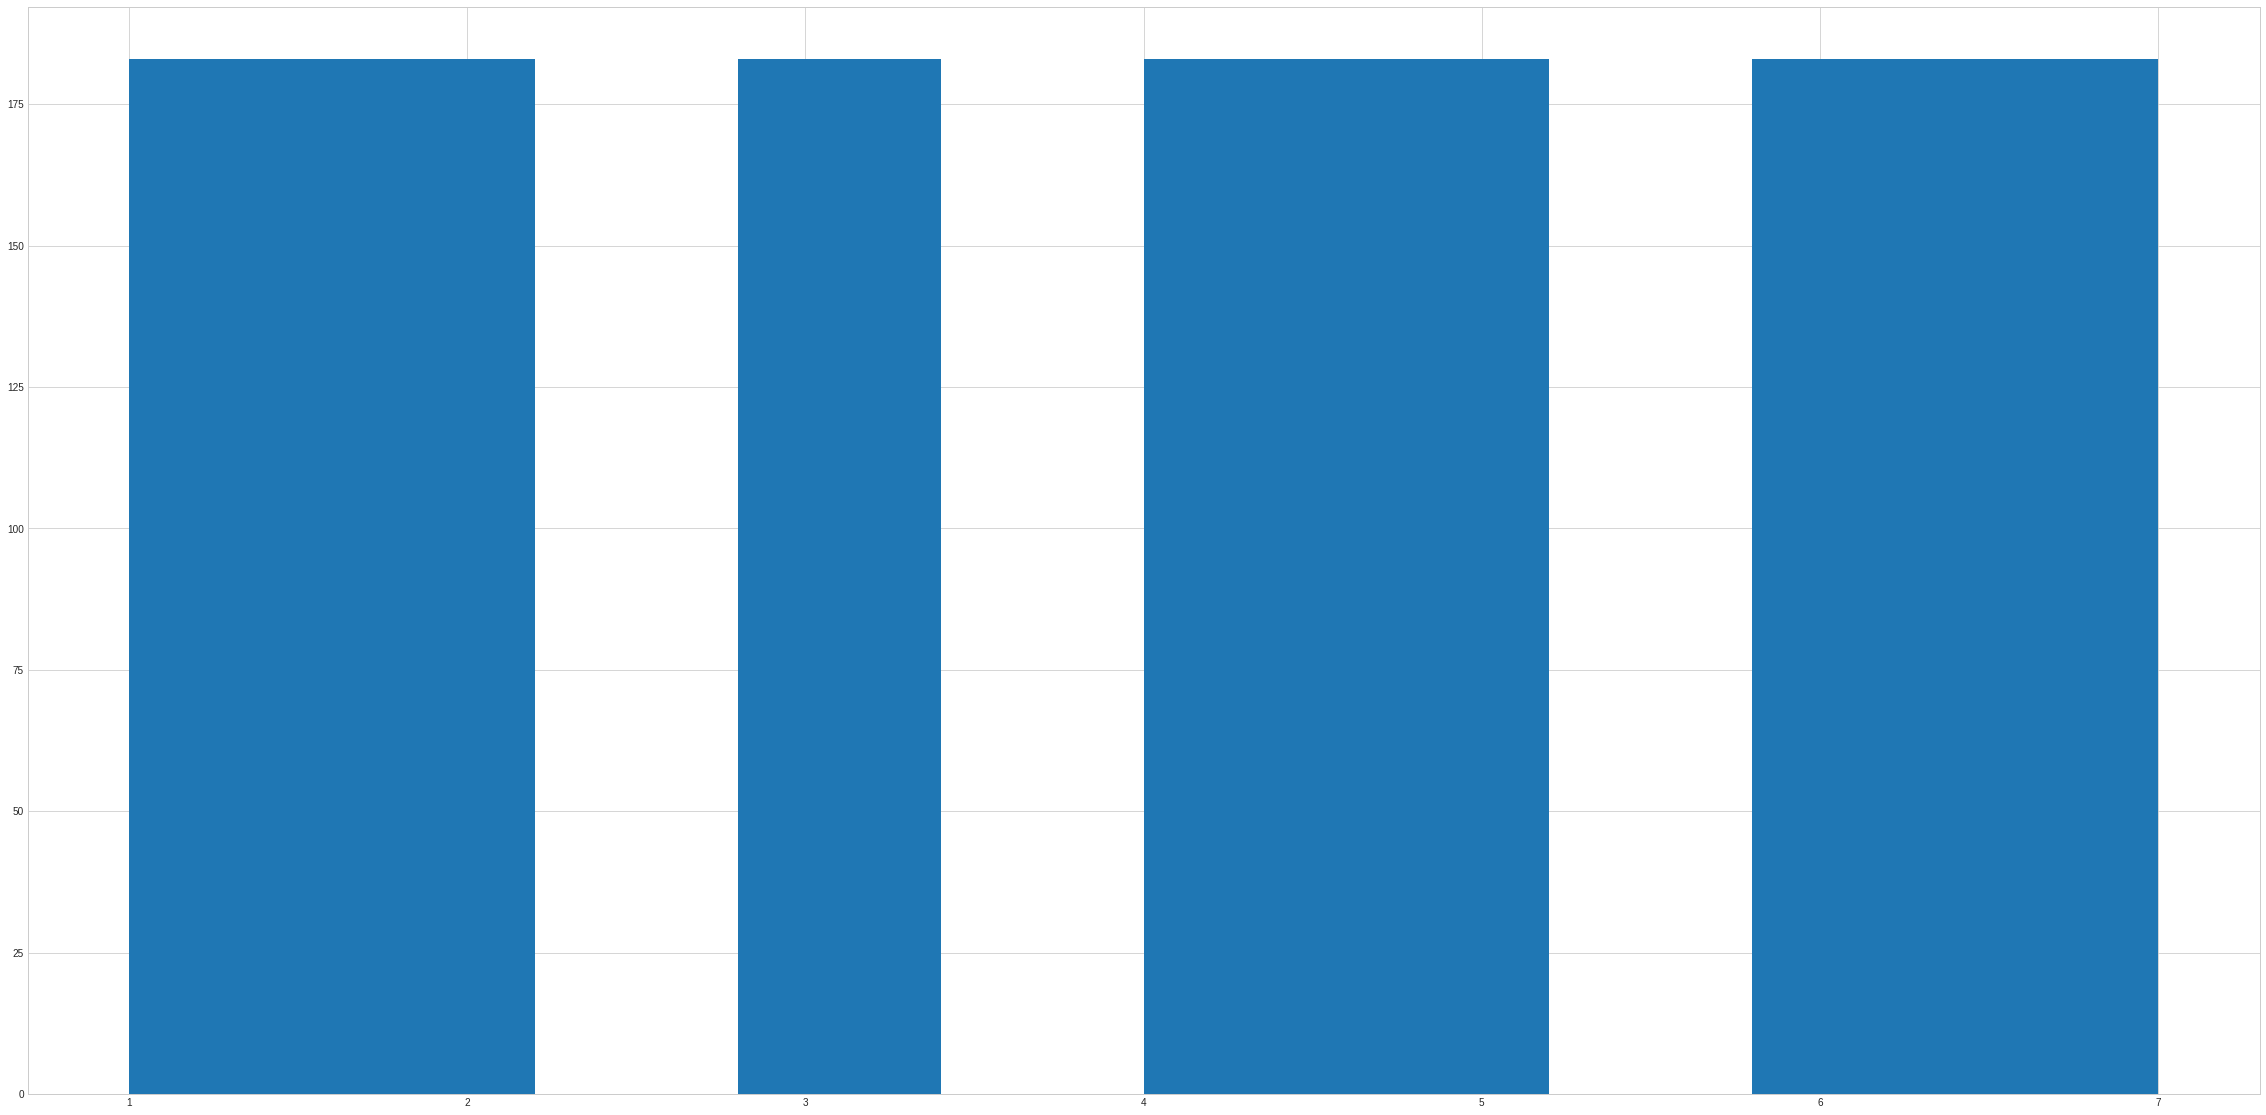

meanPrecision= 0.30631295917594487
meanRecall= 0.30631295917594487
meanAccuracy= 0.8018037026216985
meanMcc= 0.06458505762078963


In [14]:
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier

print("Random Forest - MinMax Normalization - KF-OverSampler")
#Random Fores K-Fold e MinMax Over sampler
m = MetricsResultContainer("RandomForest","KF","Minmax","Default",
  generateModel(RandomForestClassifier(),rkf),"overSampler"
)
metricsResults.append(m)
m.printMetrics()

# **ALGORITIMO EVALUATION OF DECISION TREE CLASSIFICATION**

DecisionTreeClassifier - MinMax Normalization - KF-OverSampler


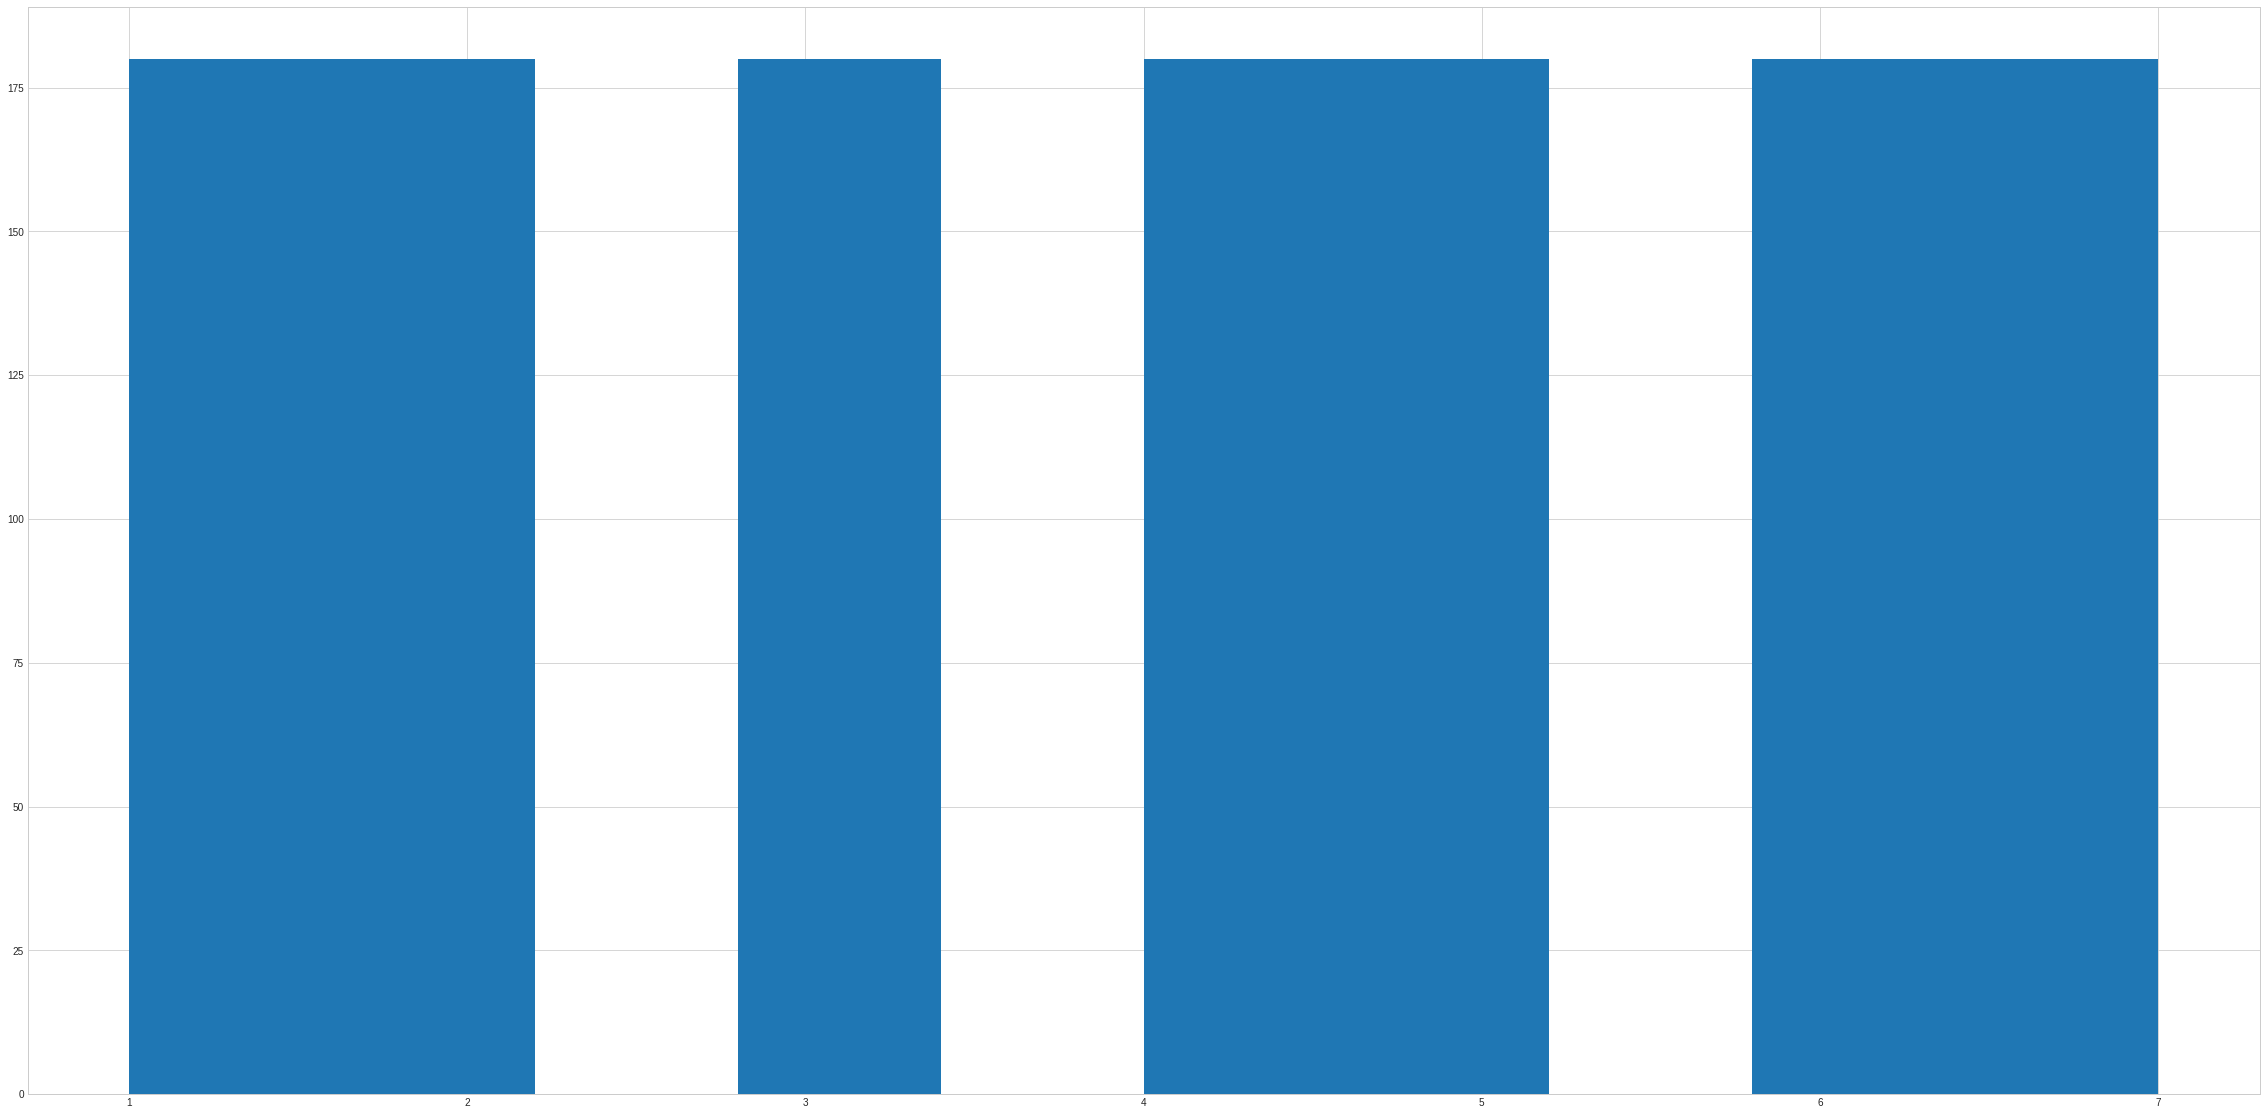

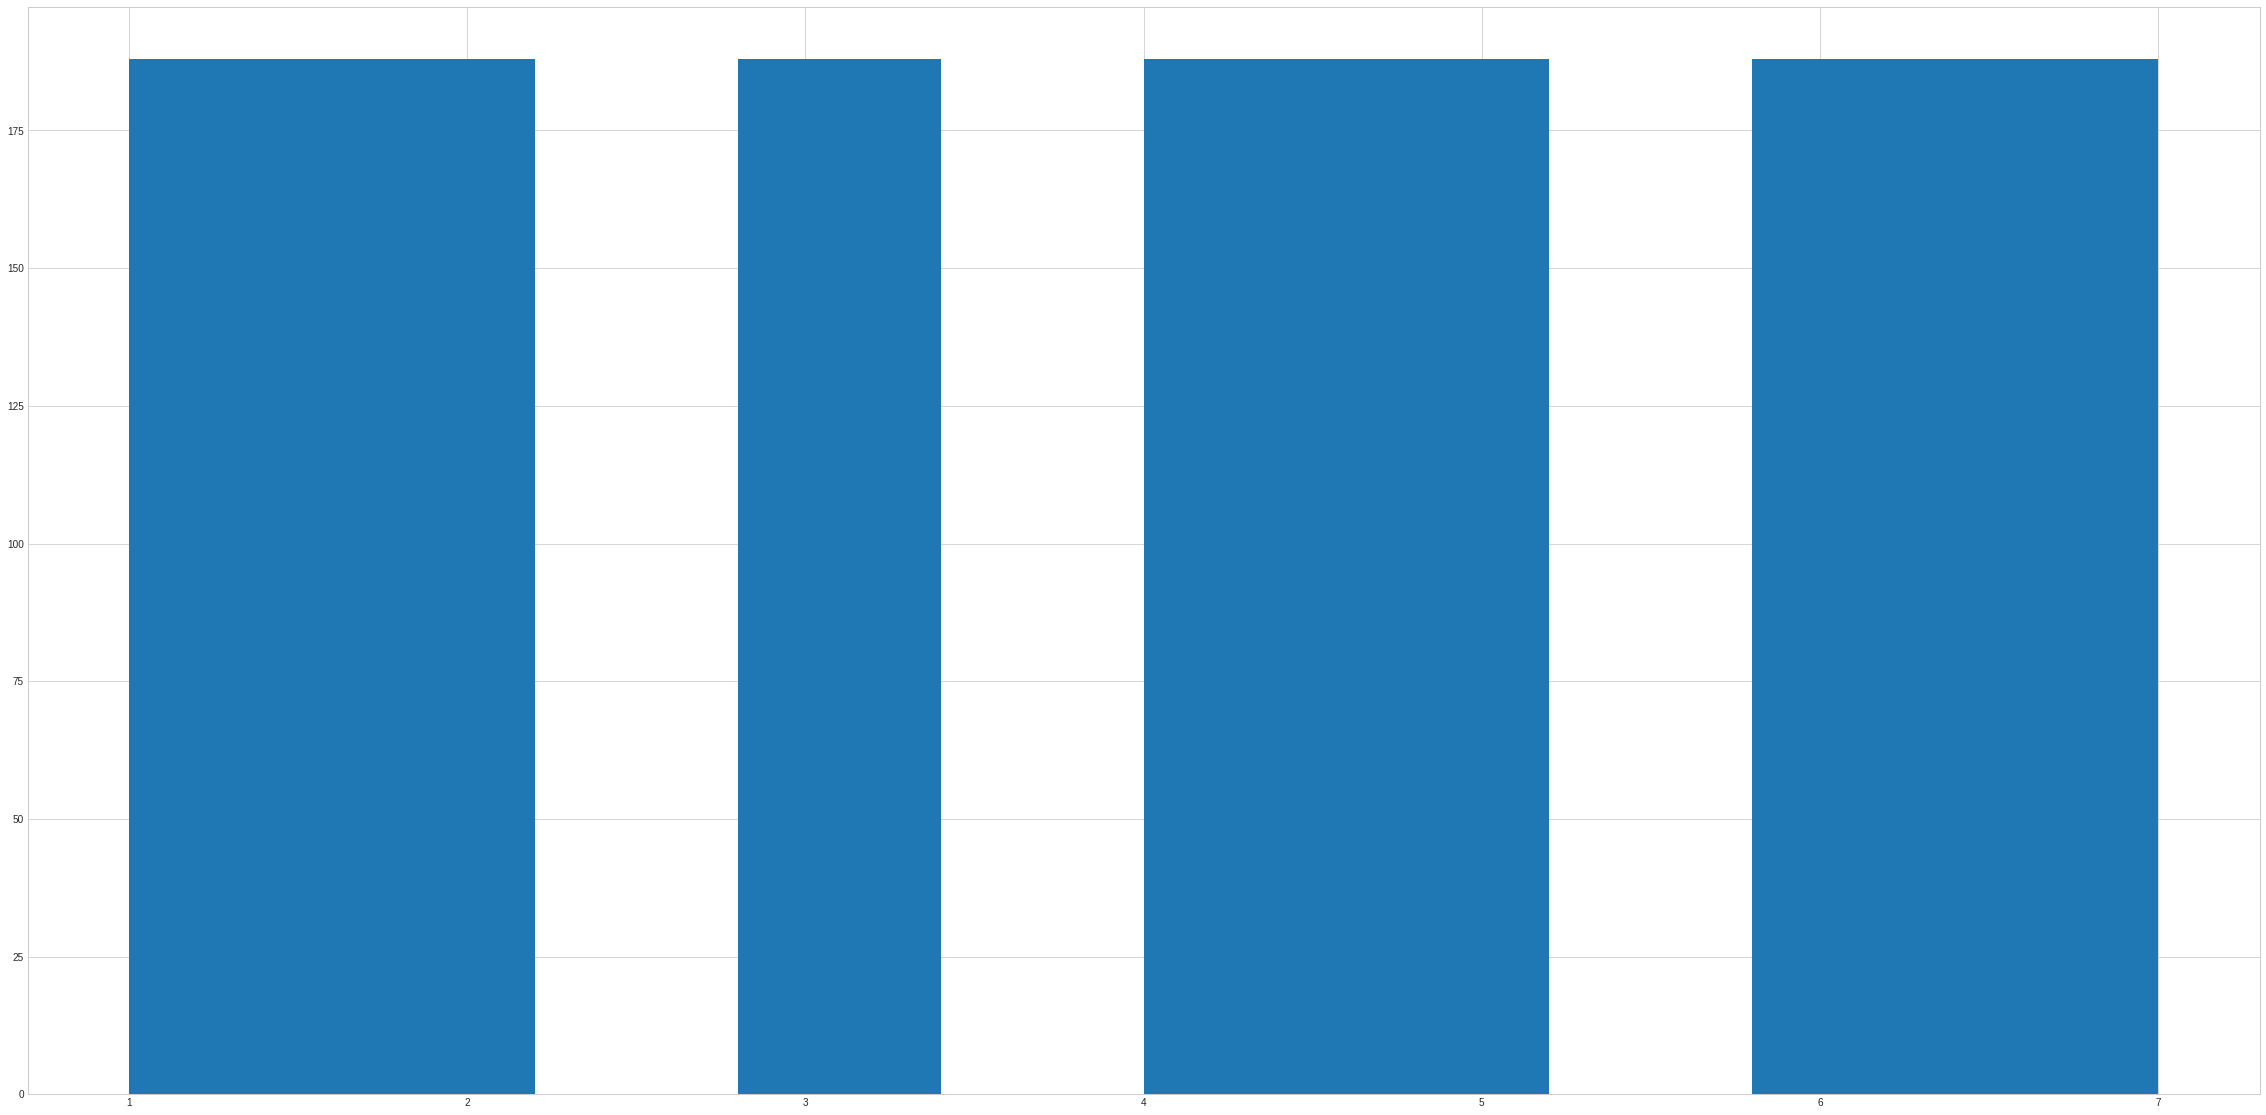

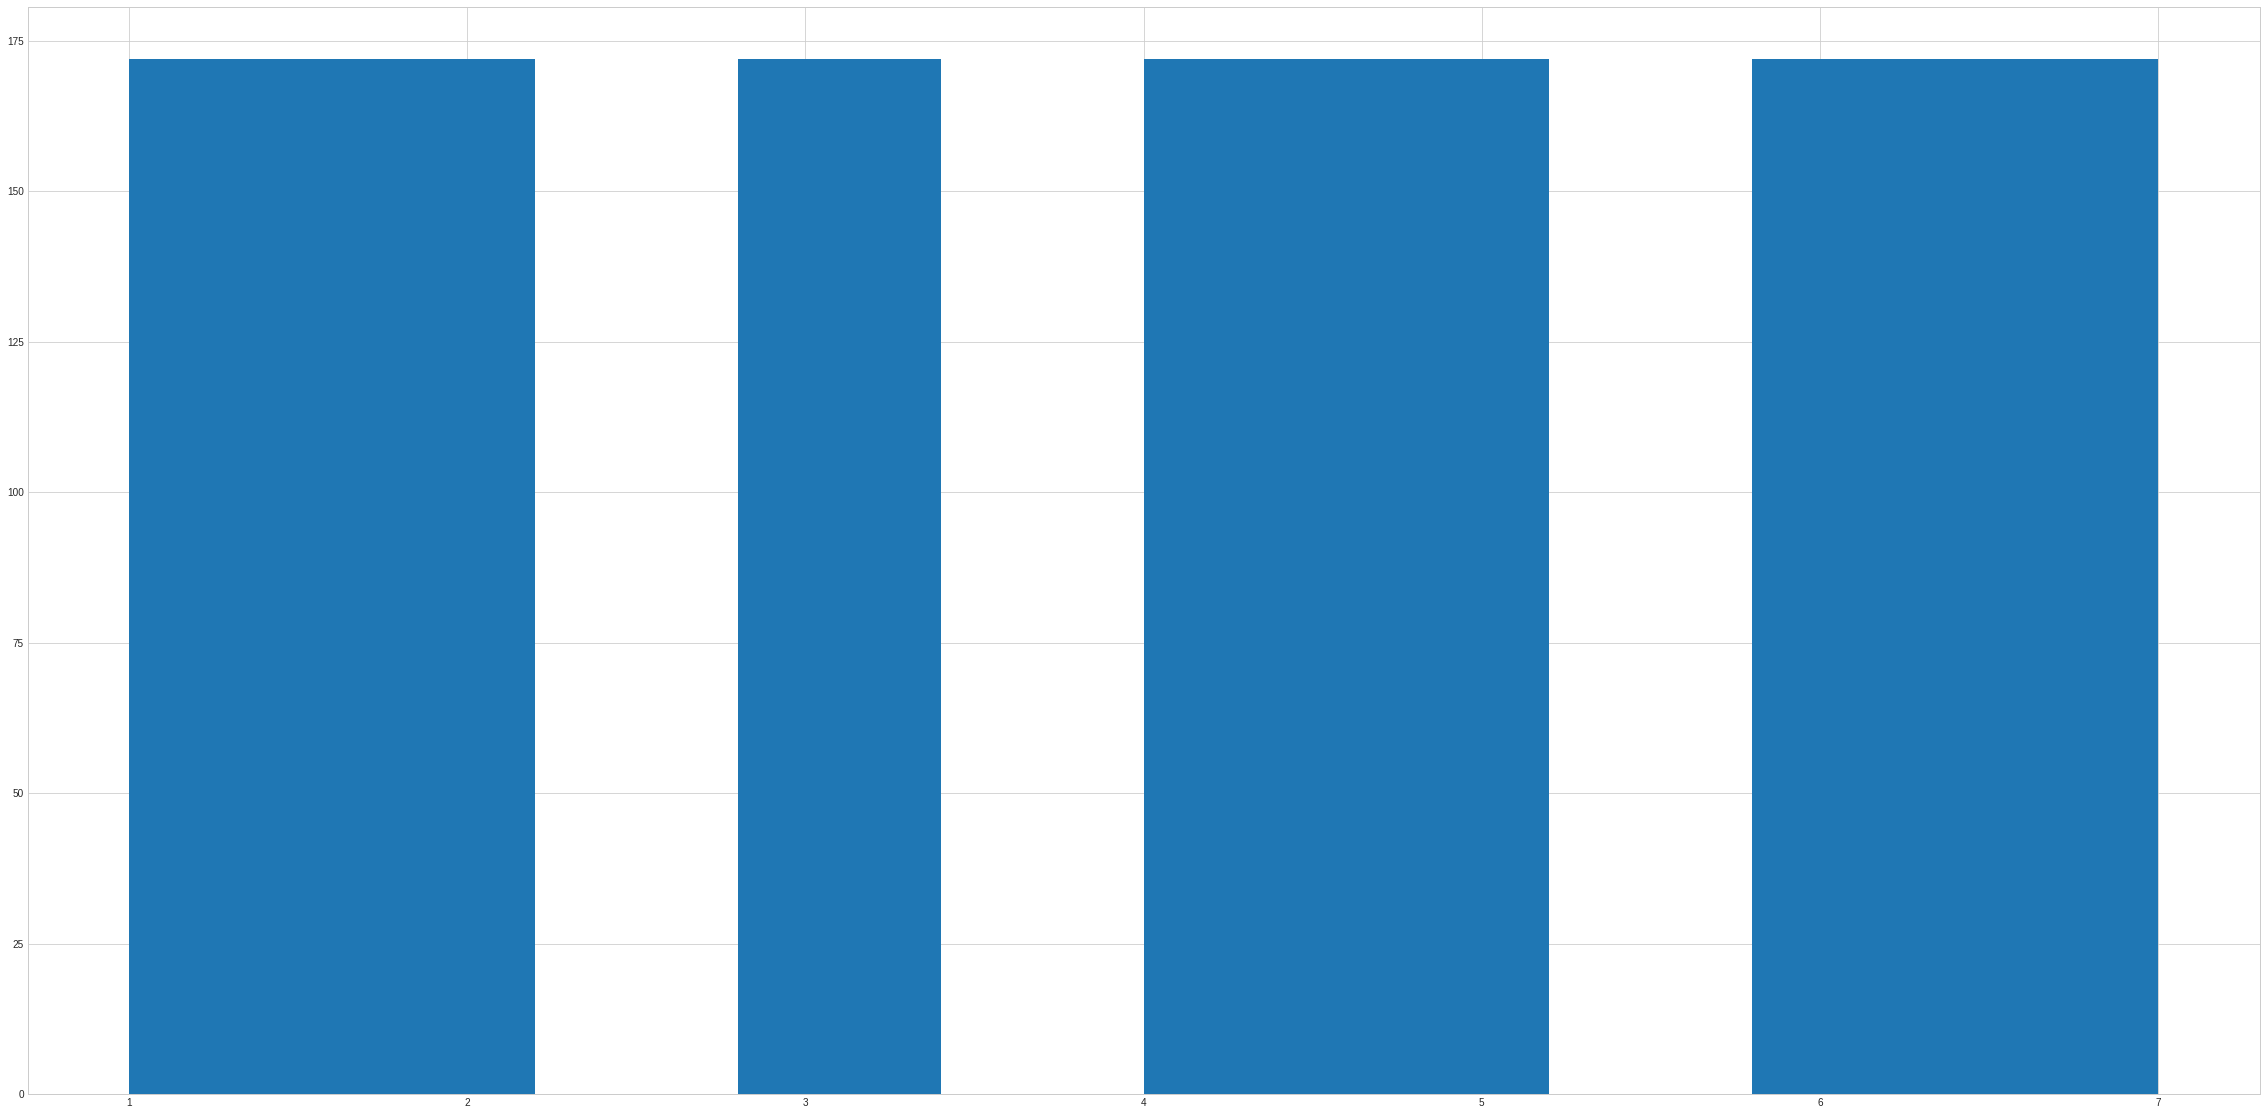

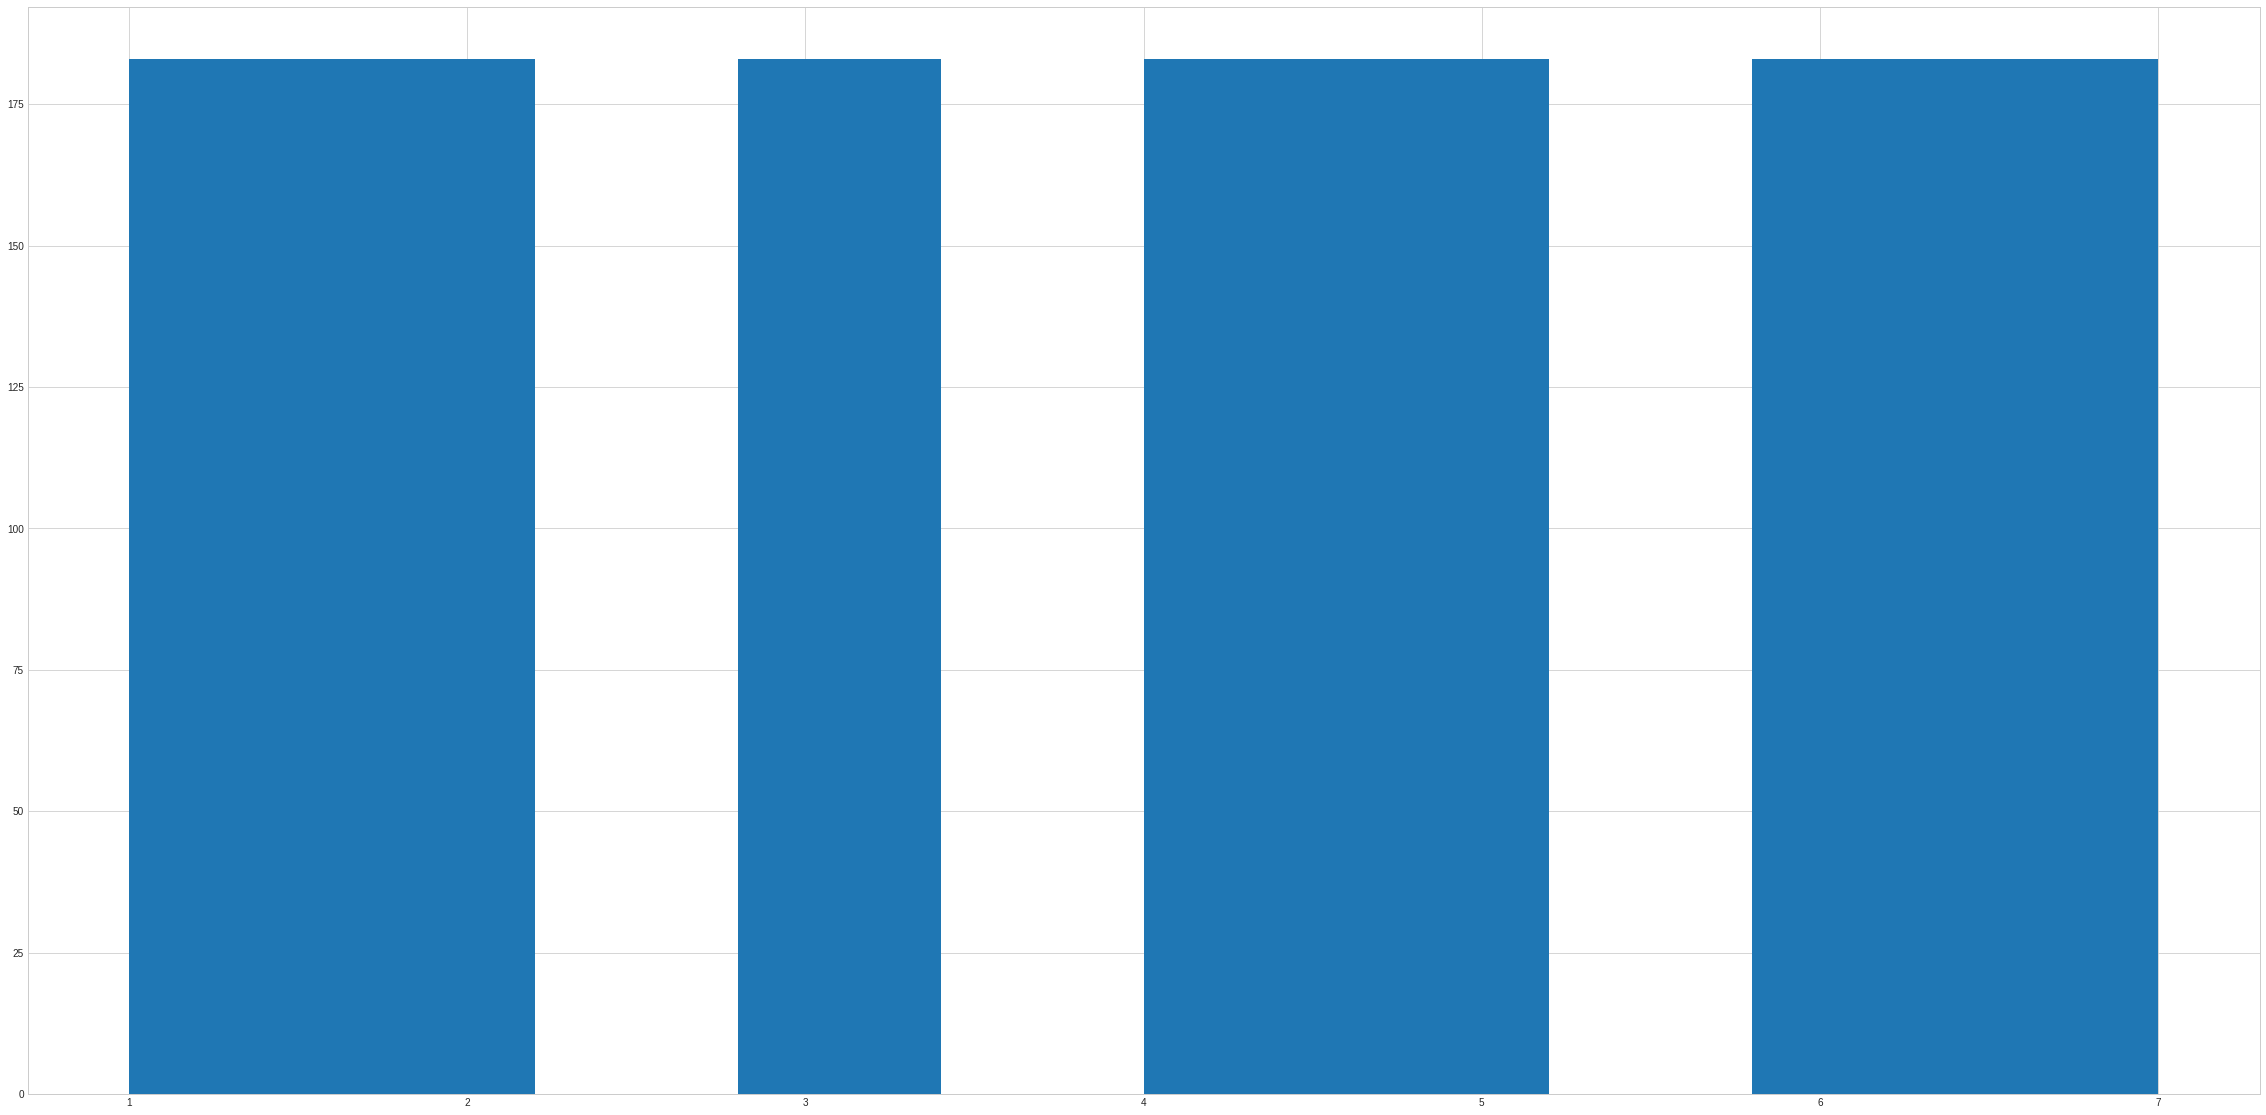

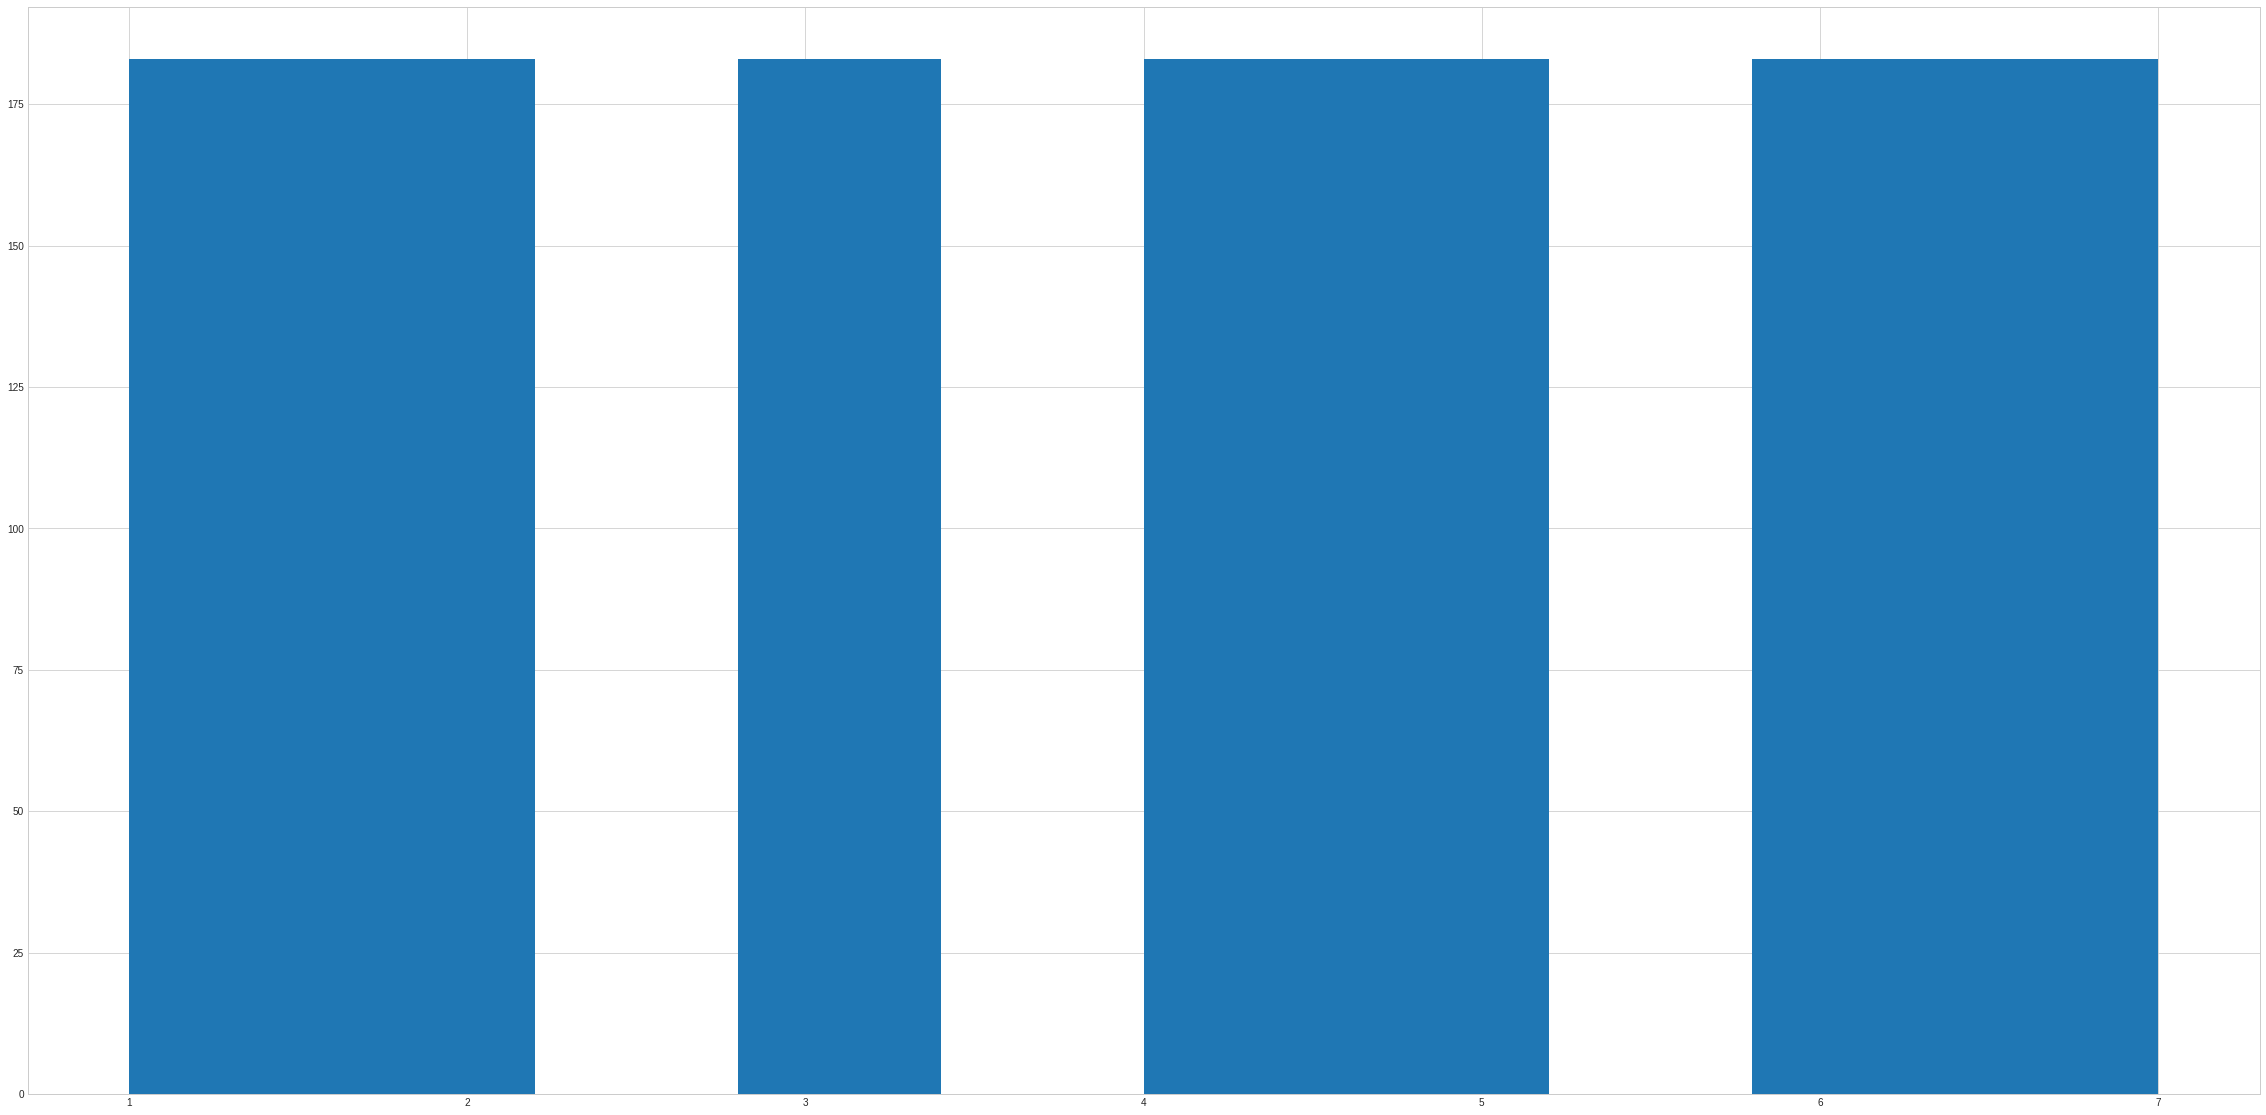

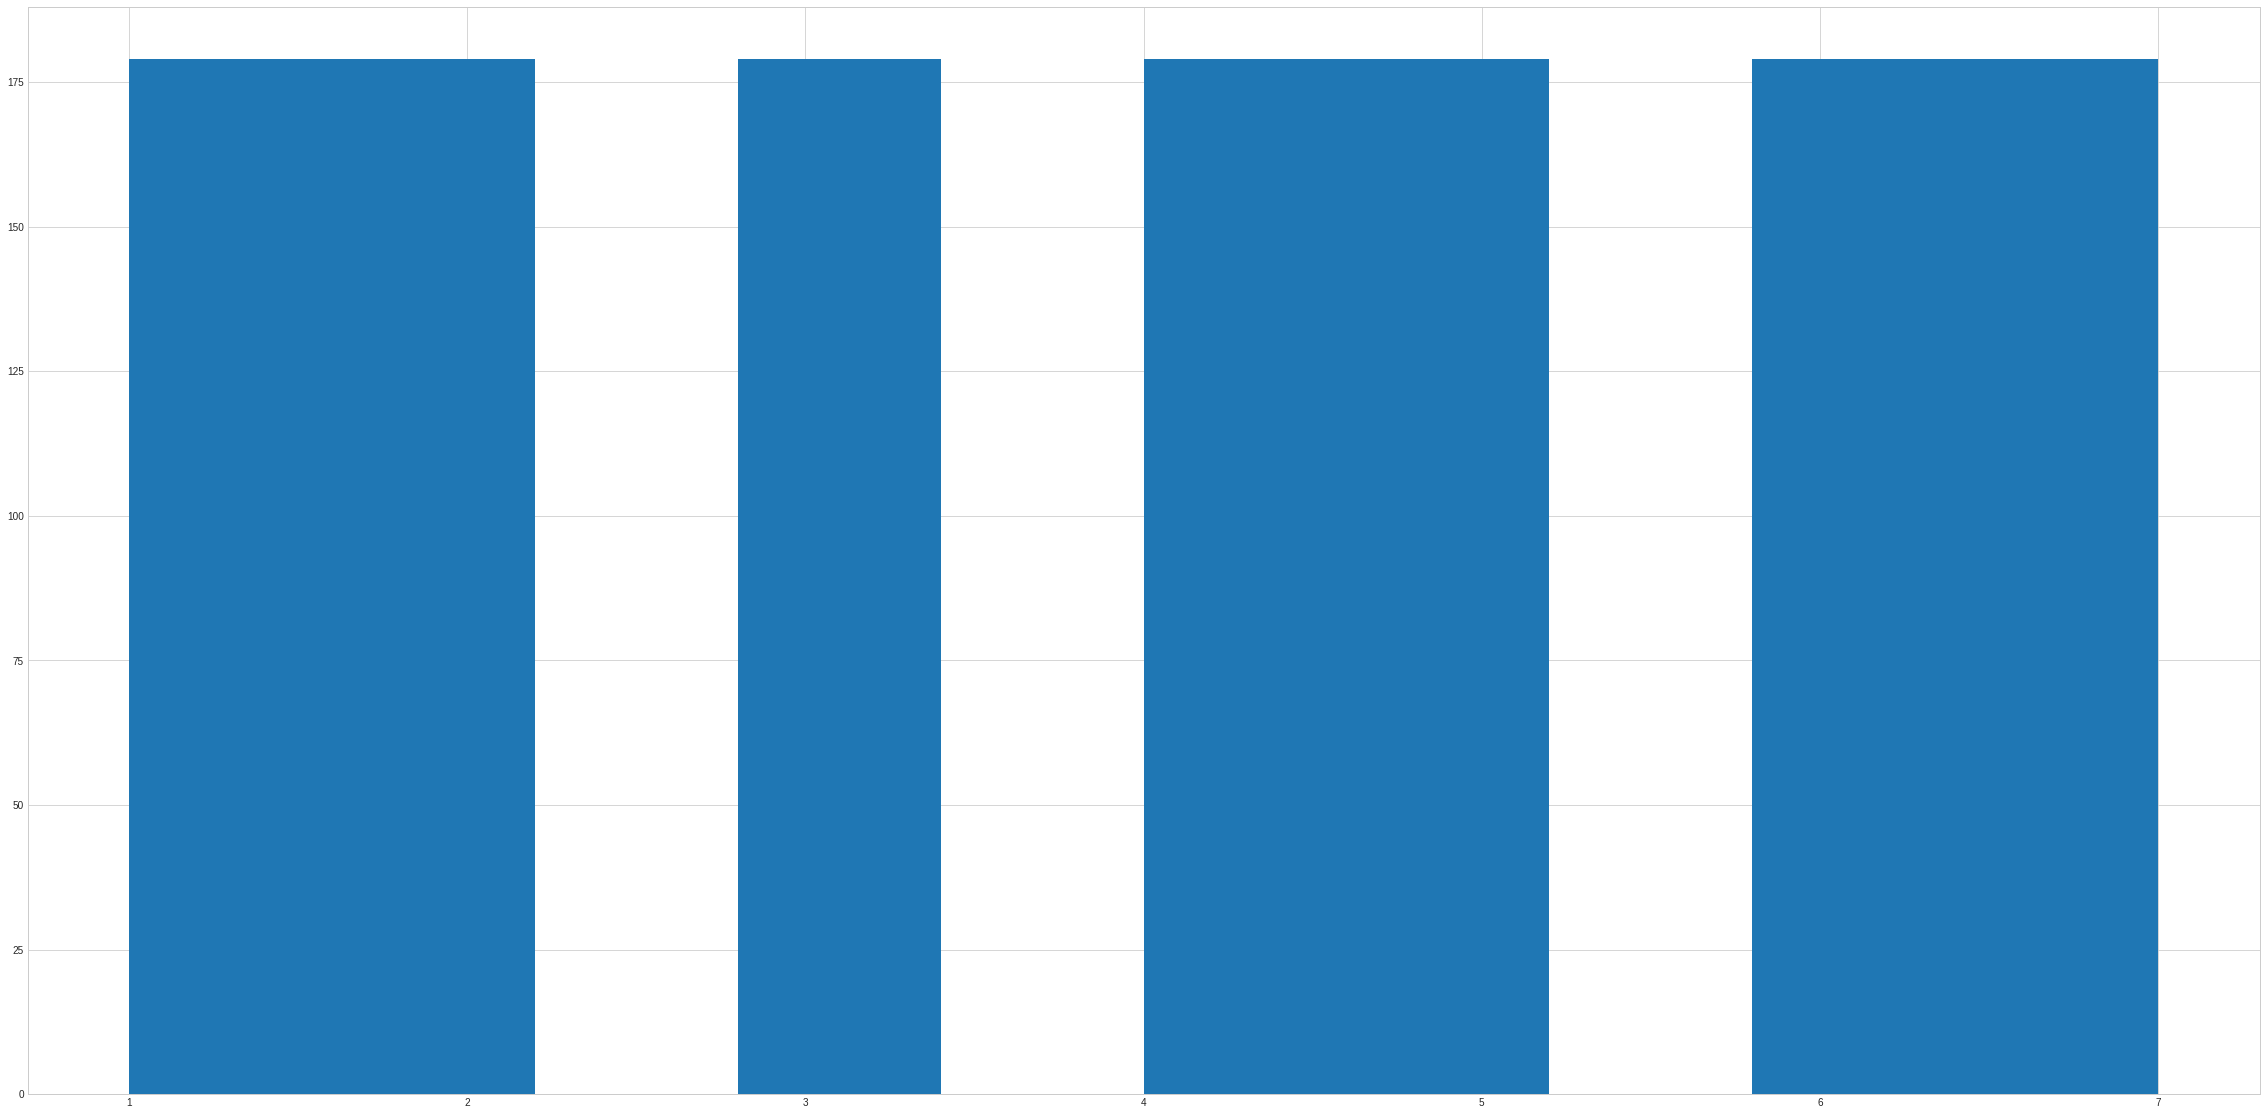

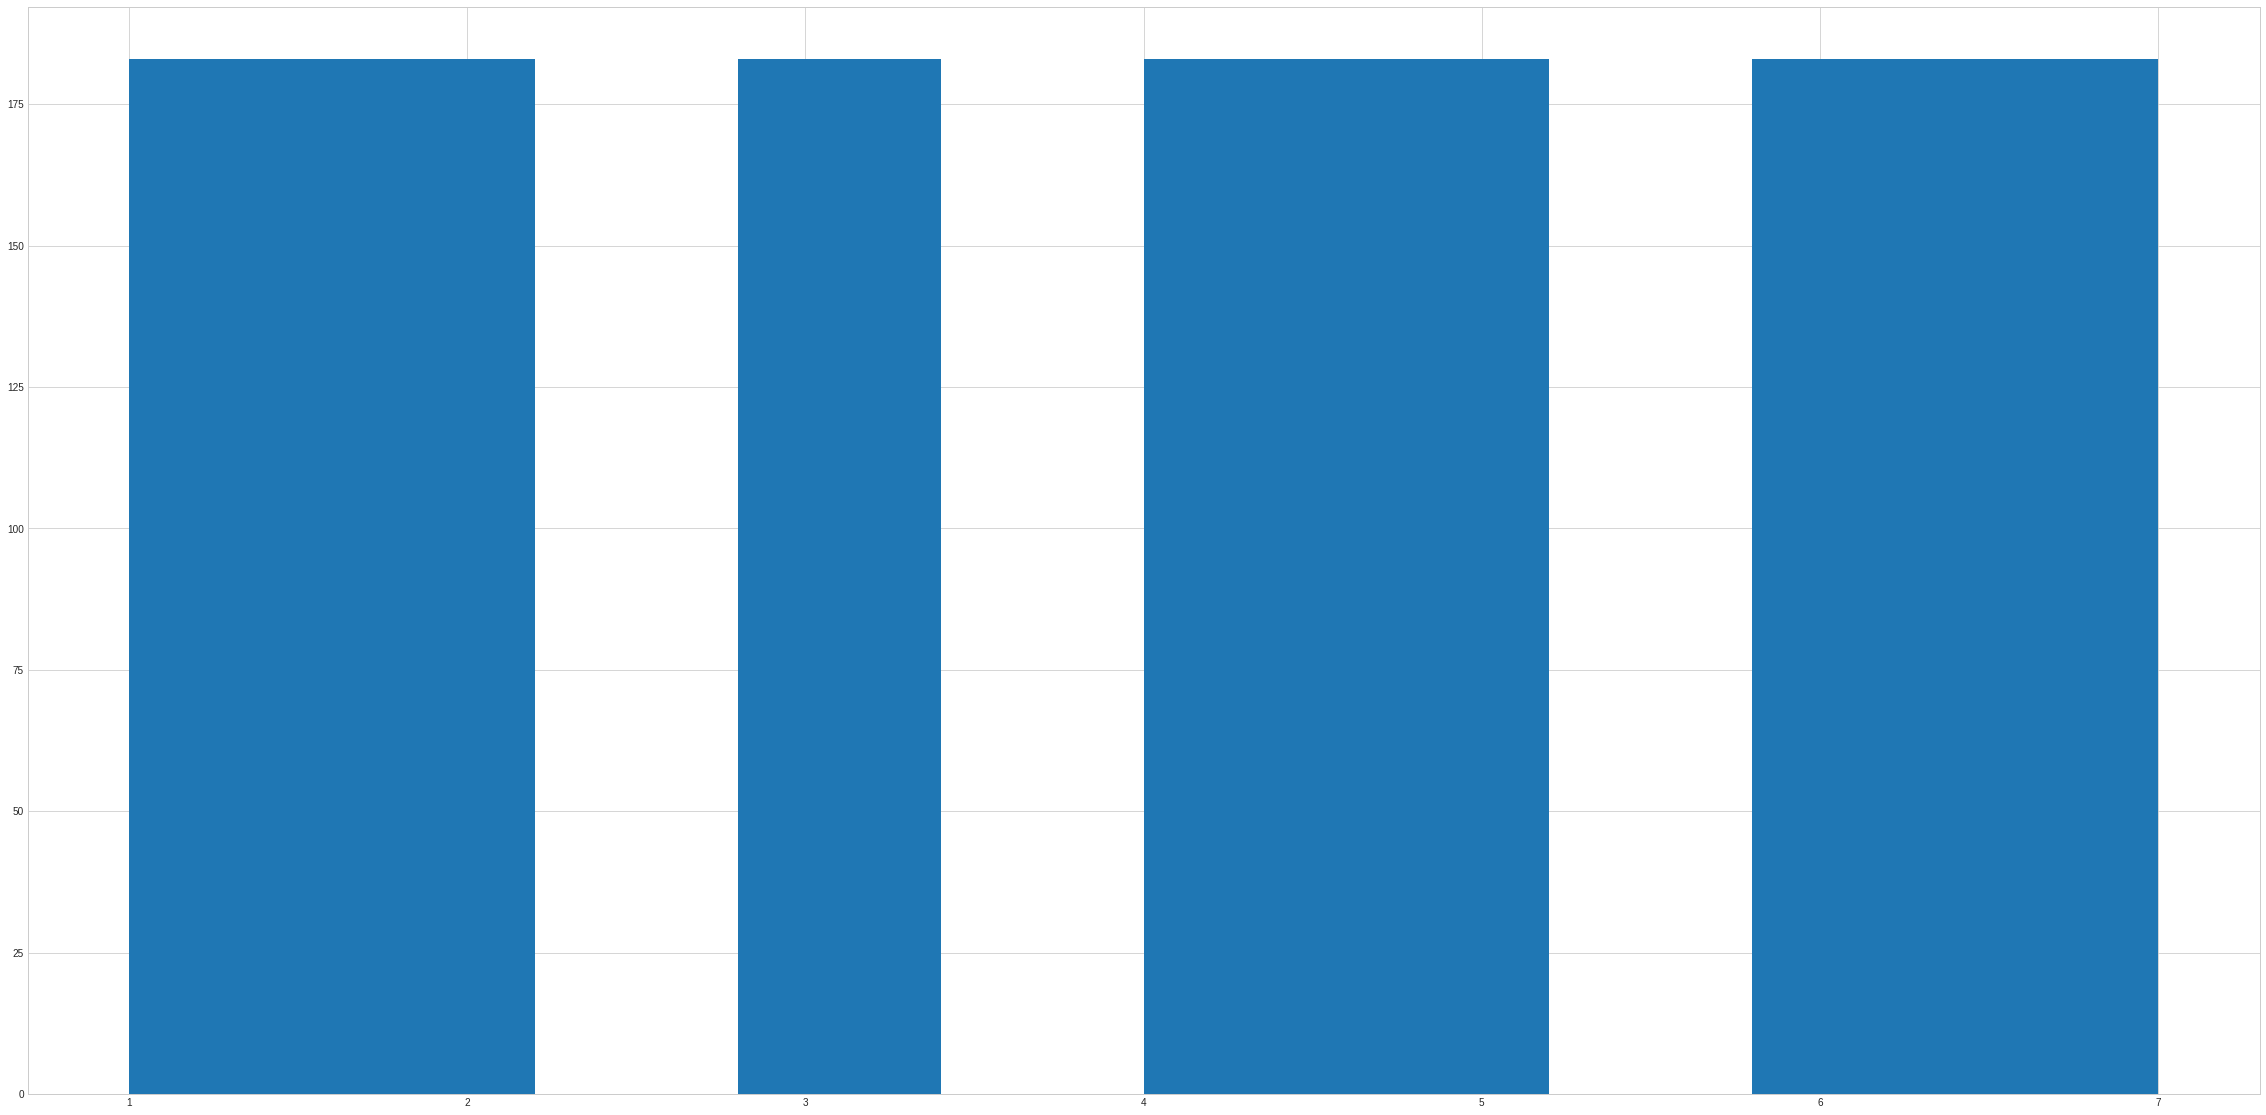

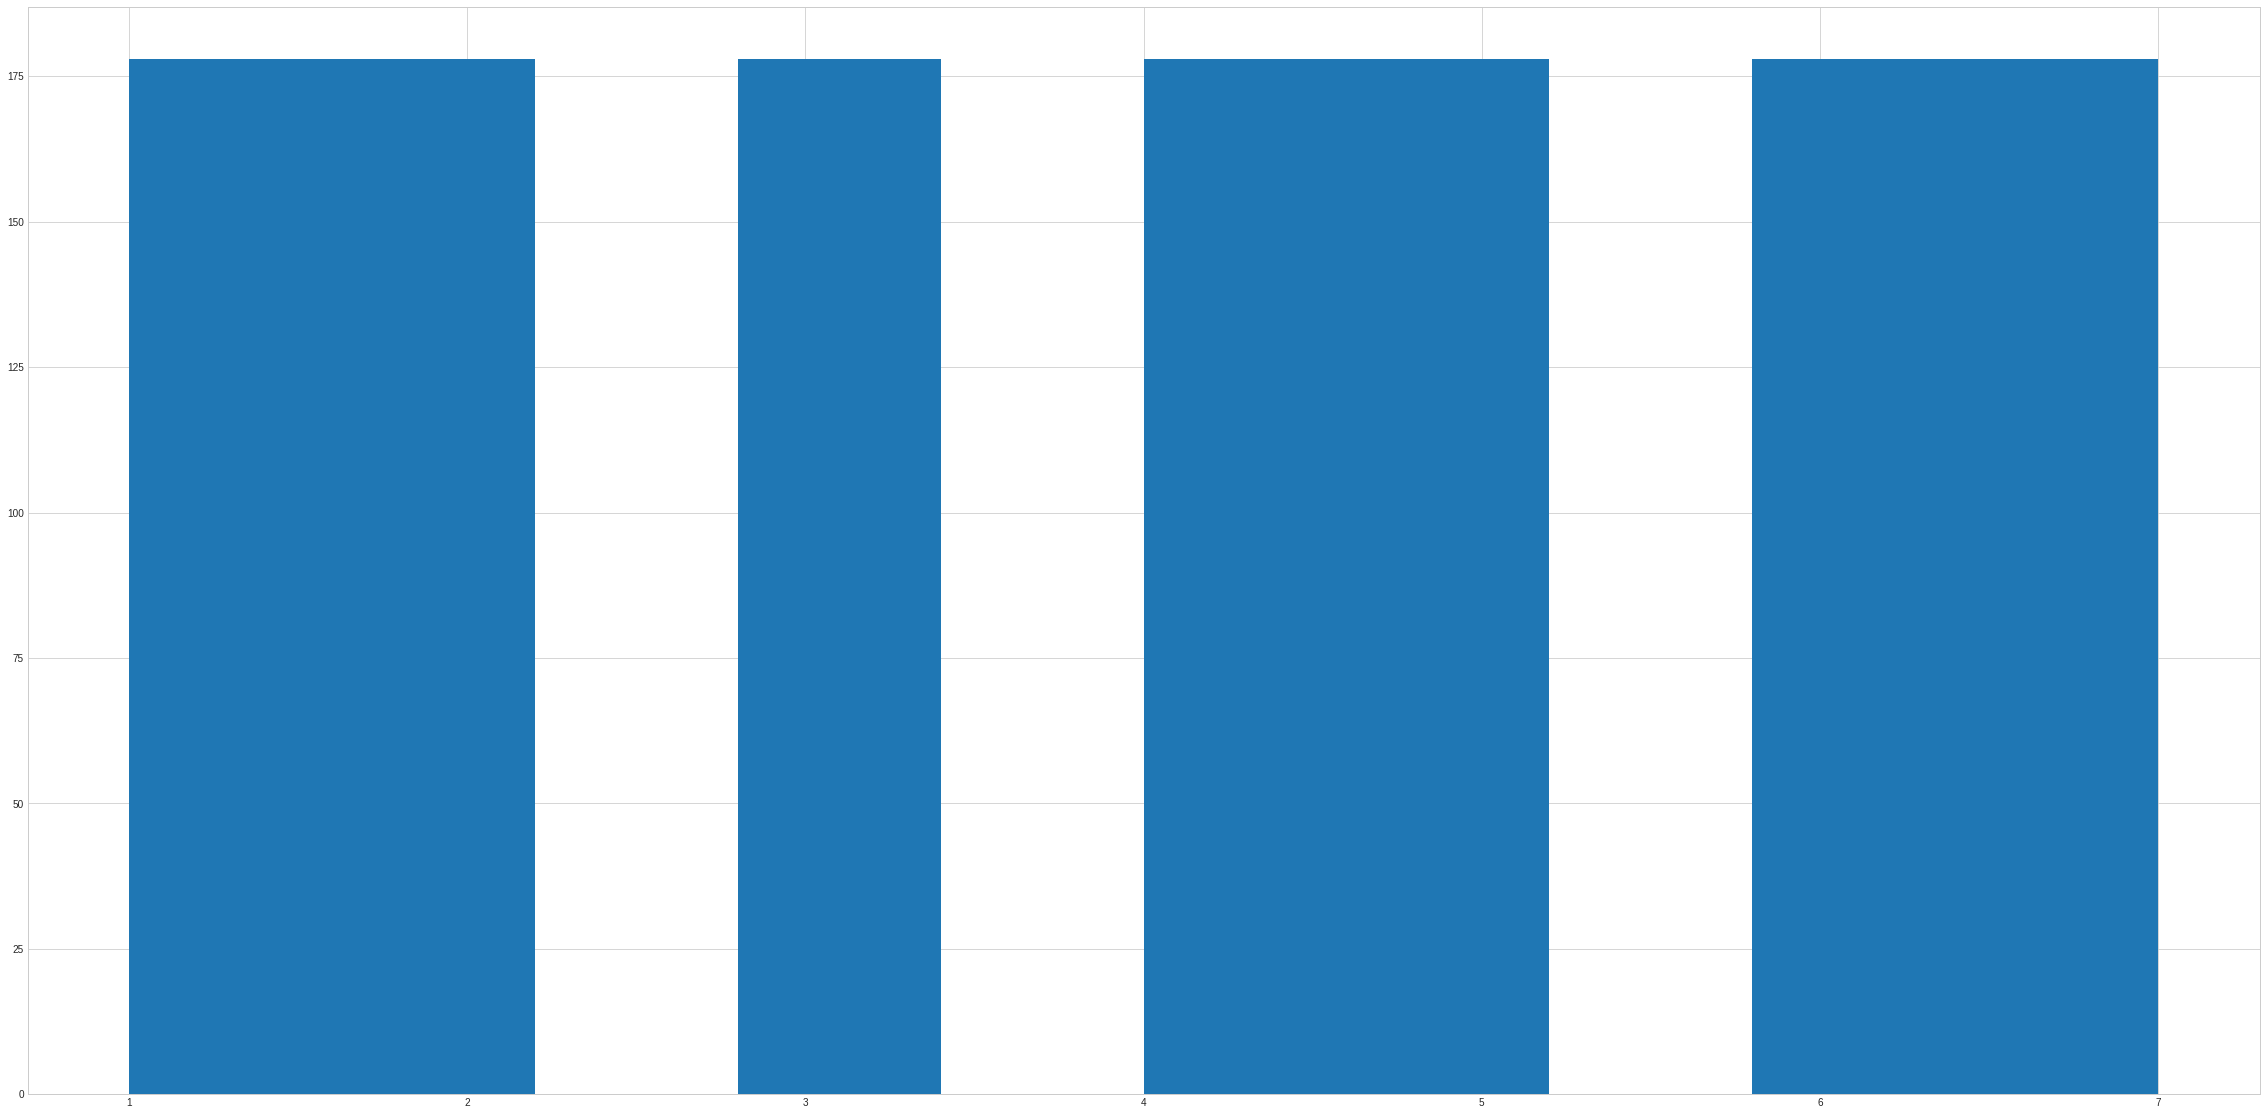

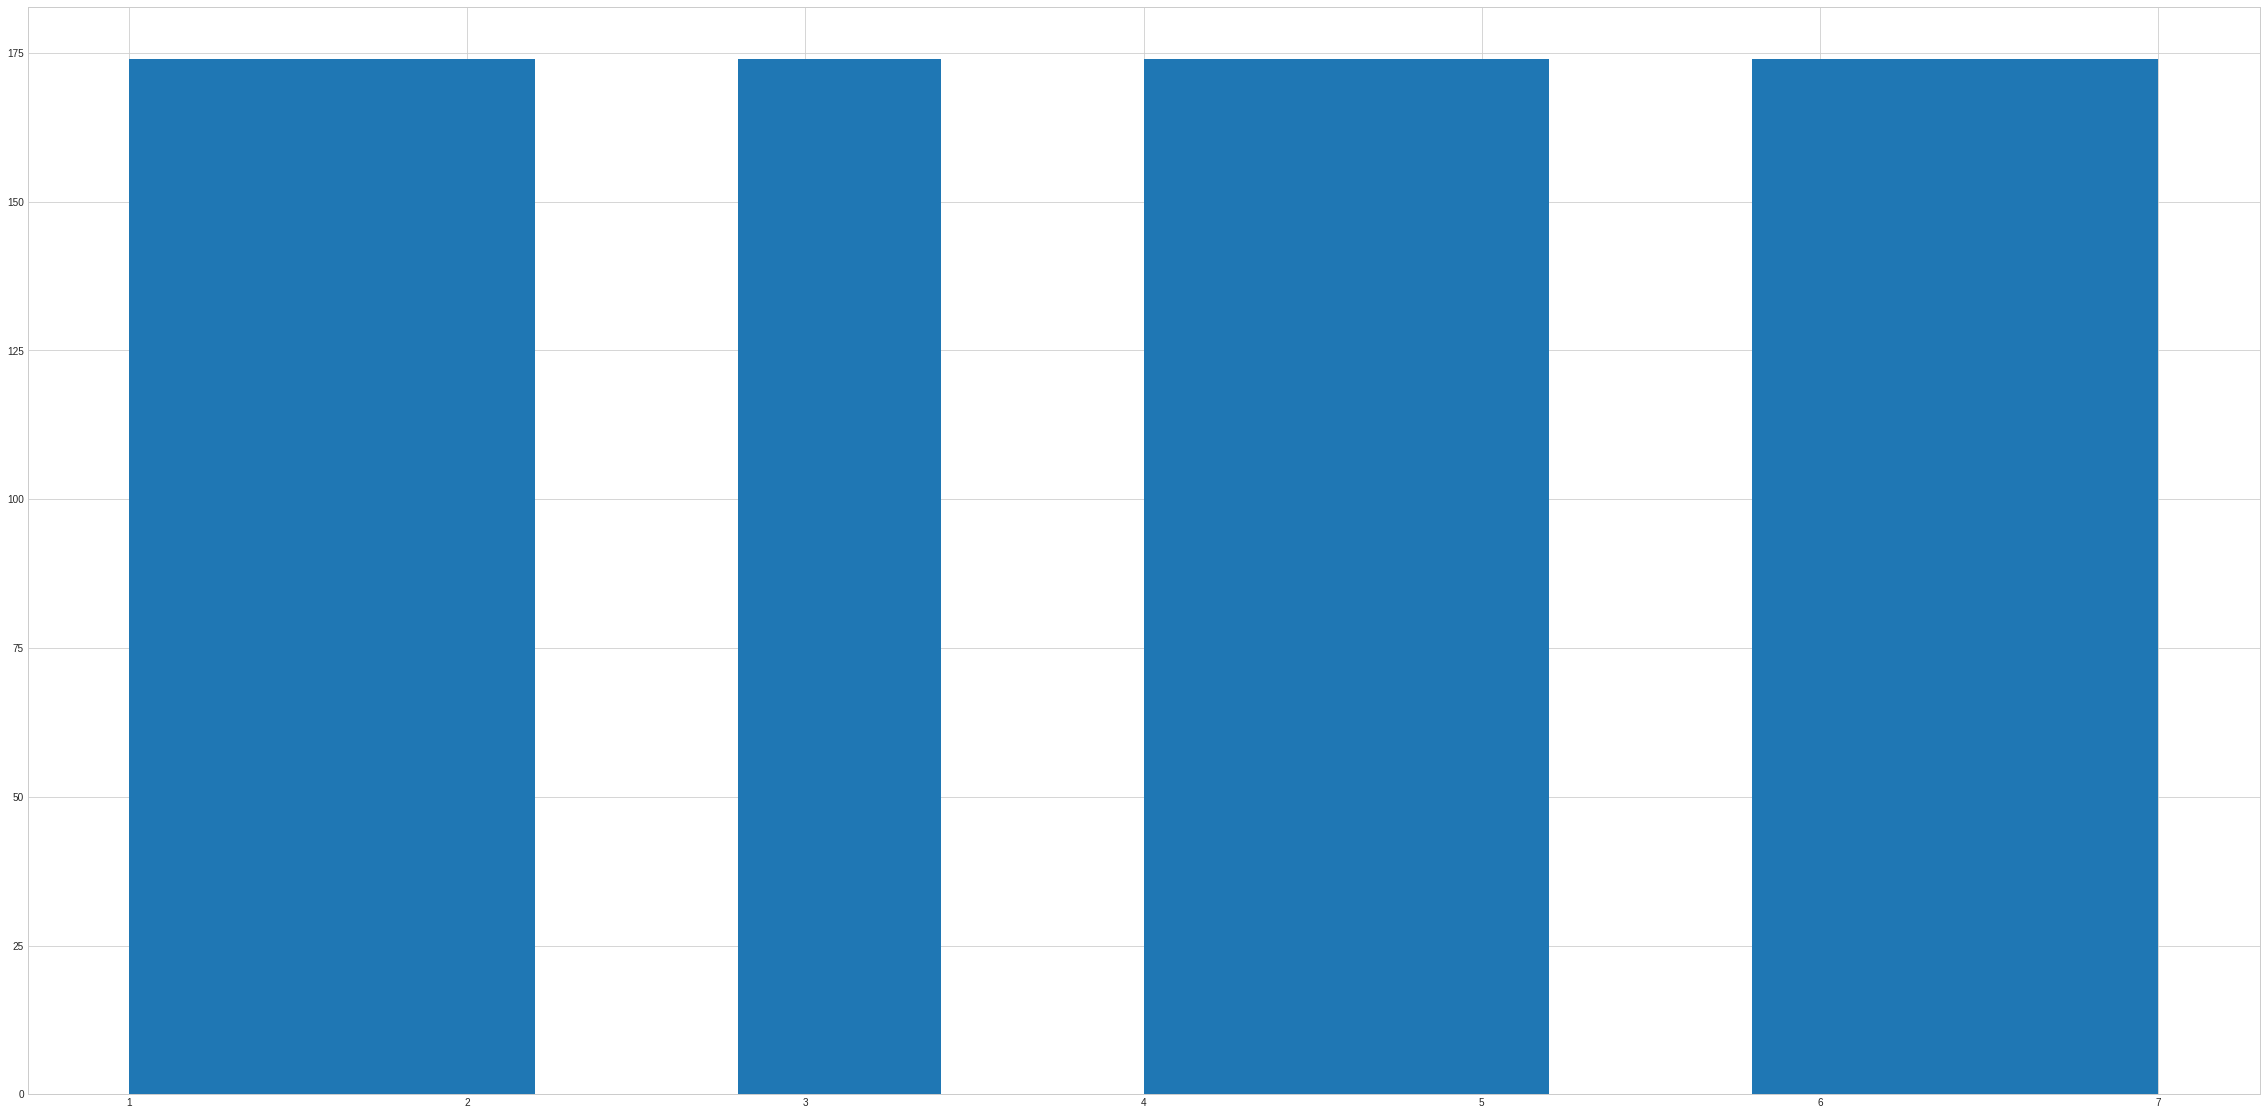

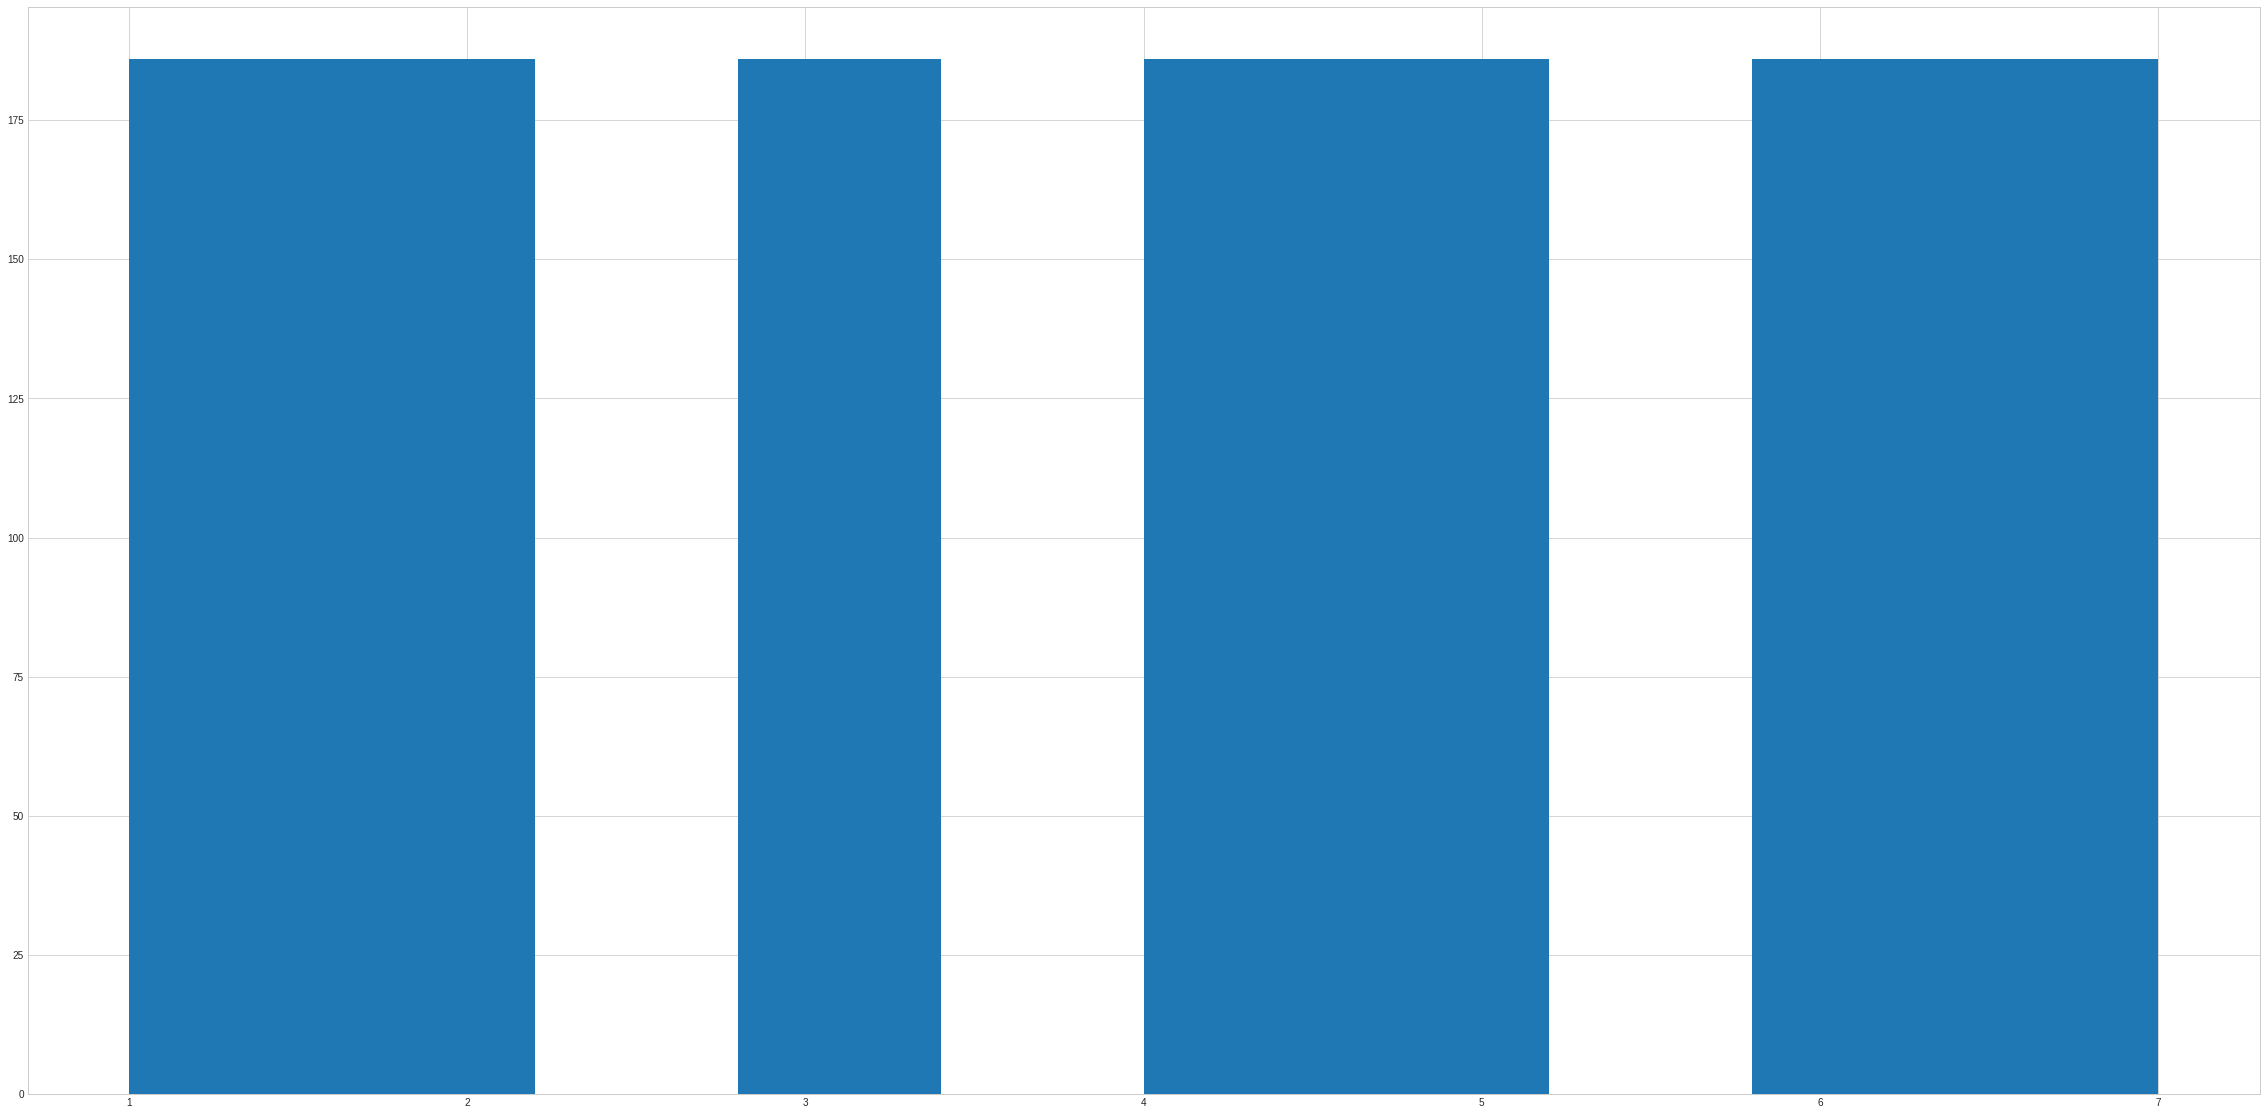

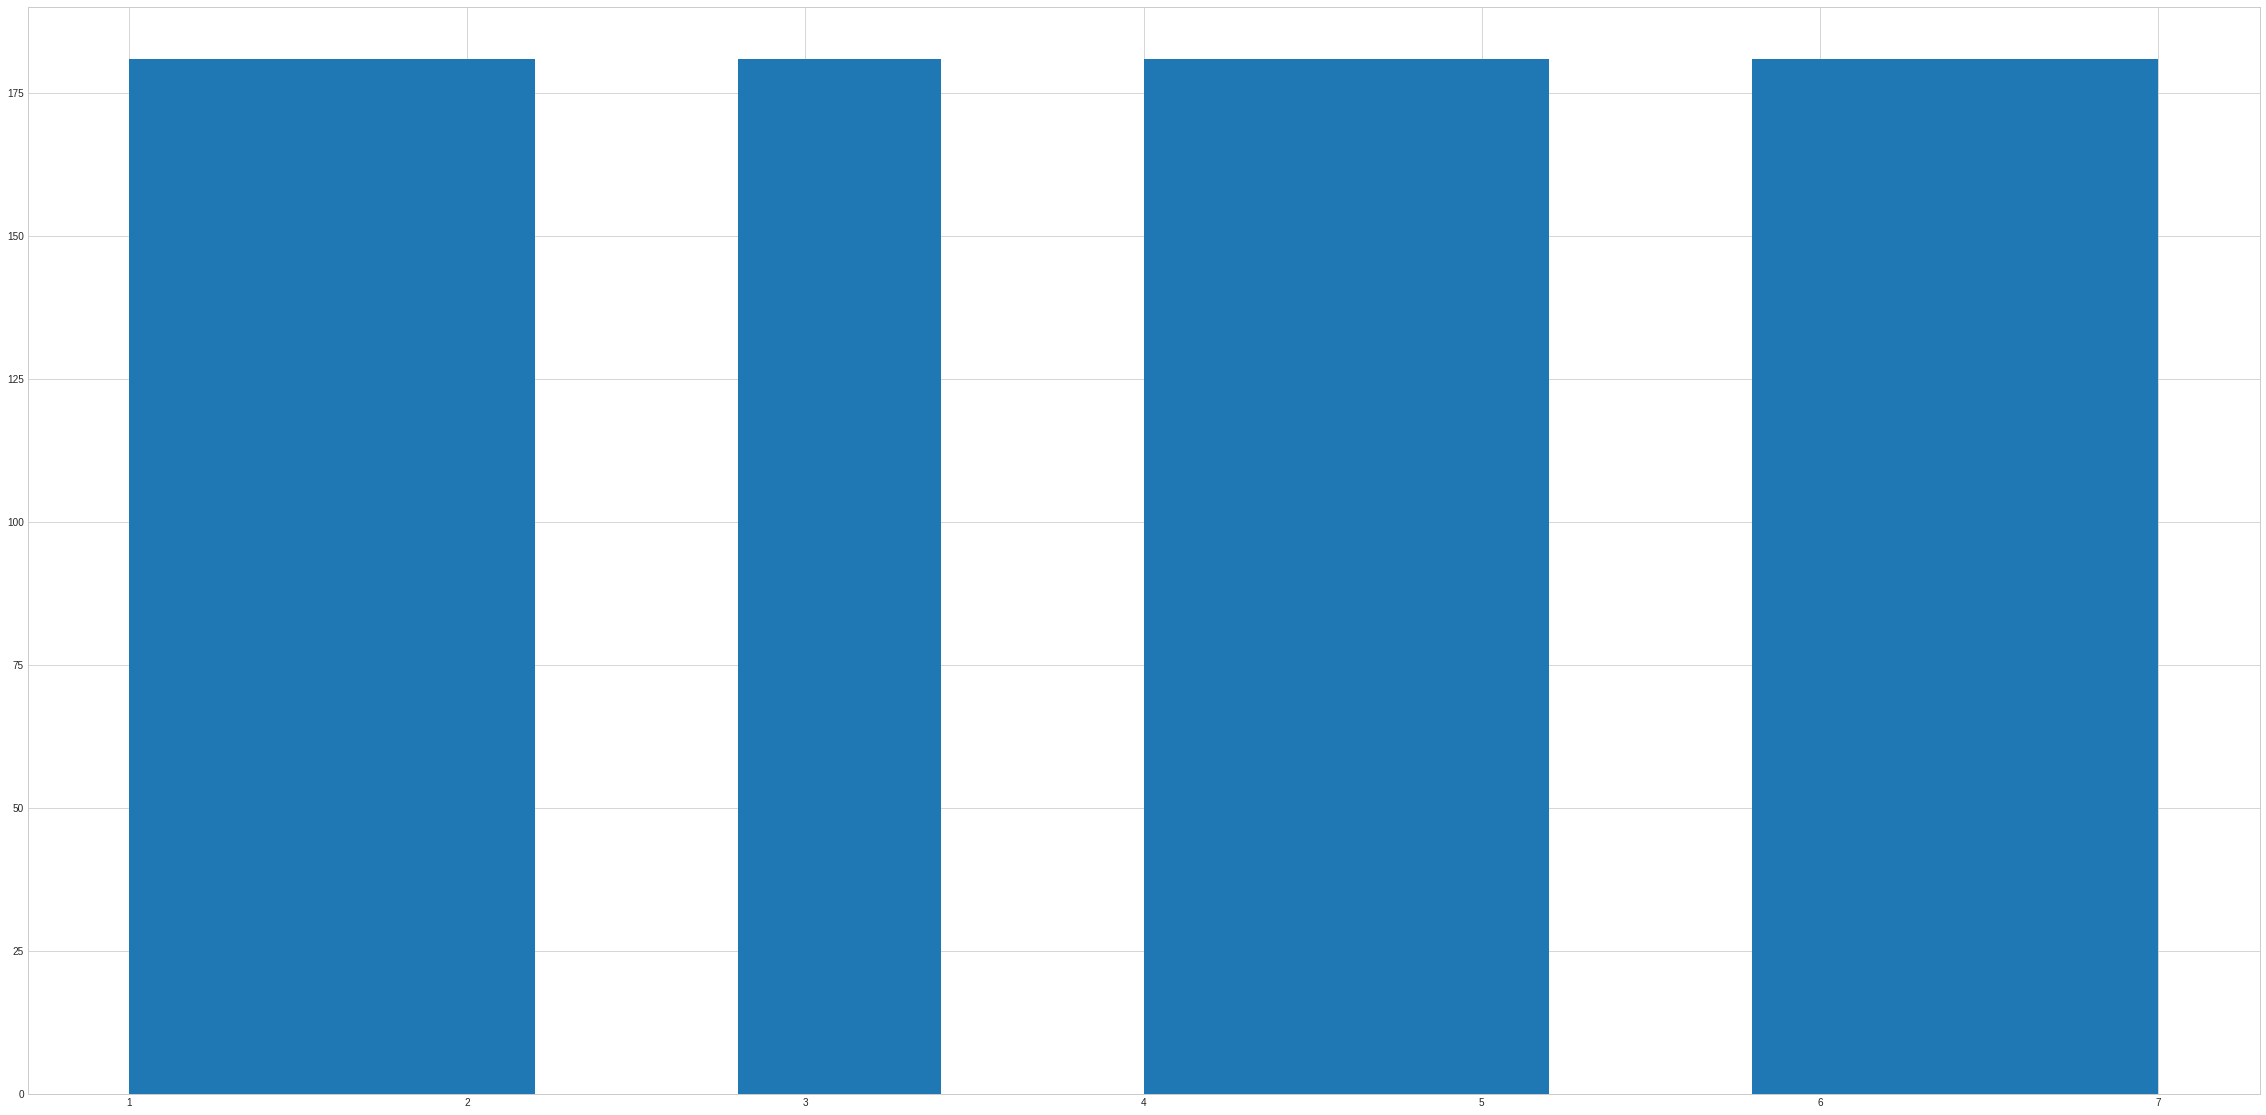

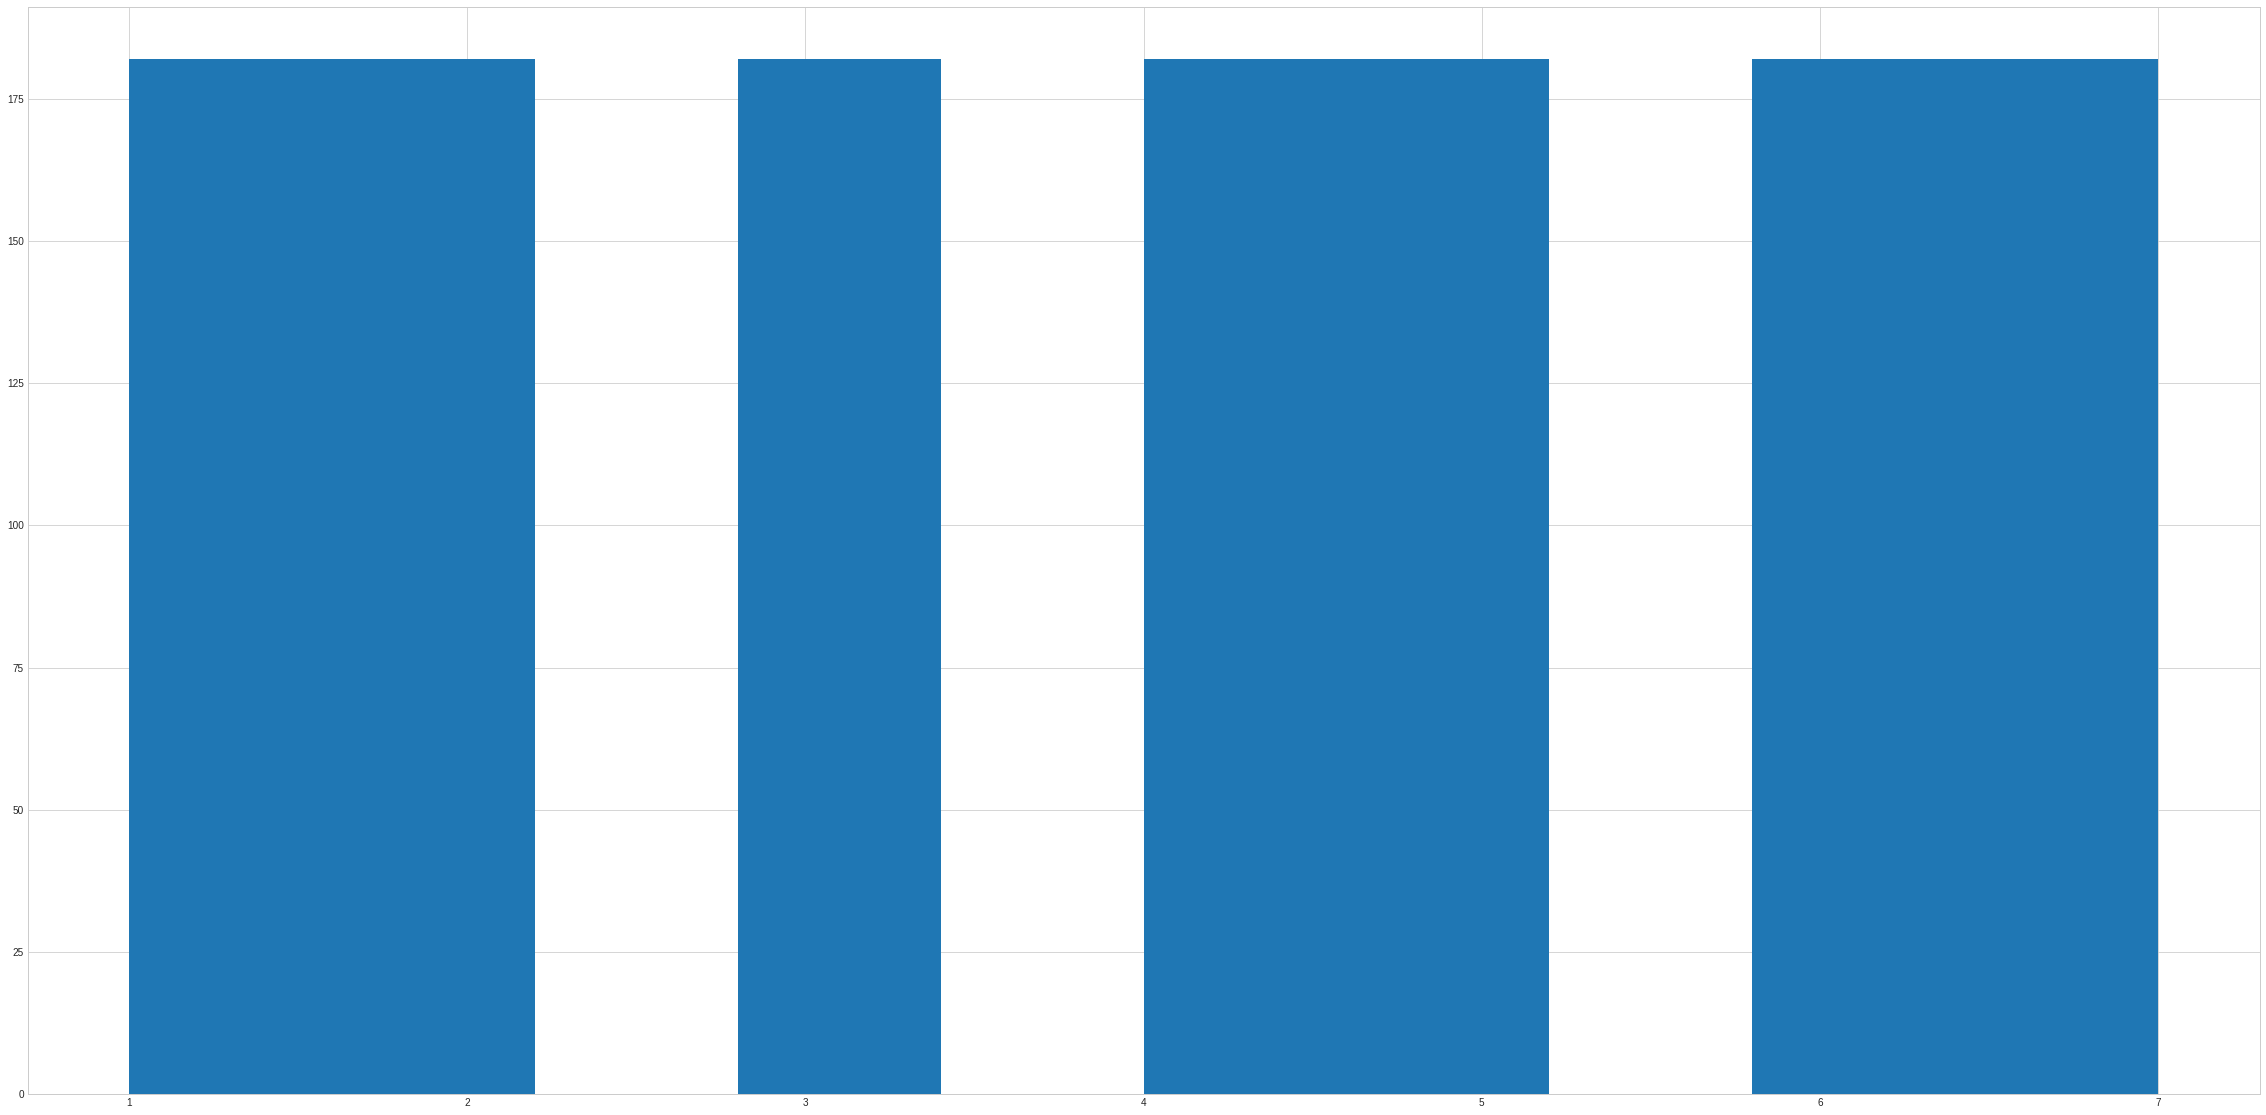

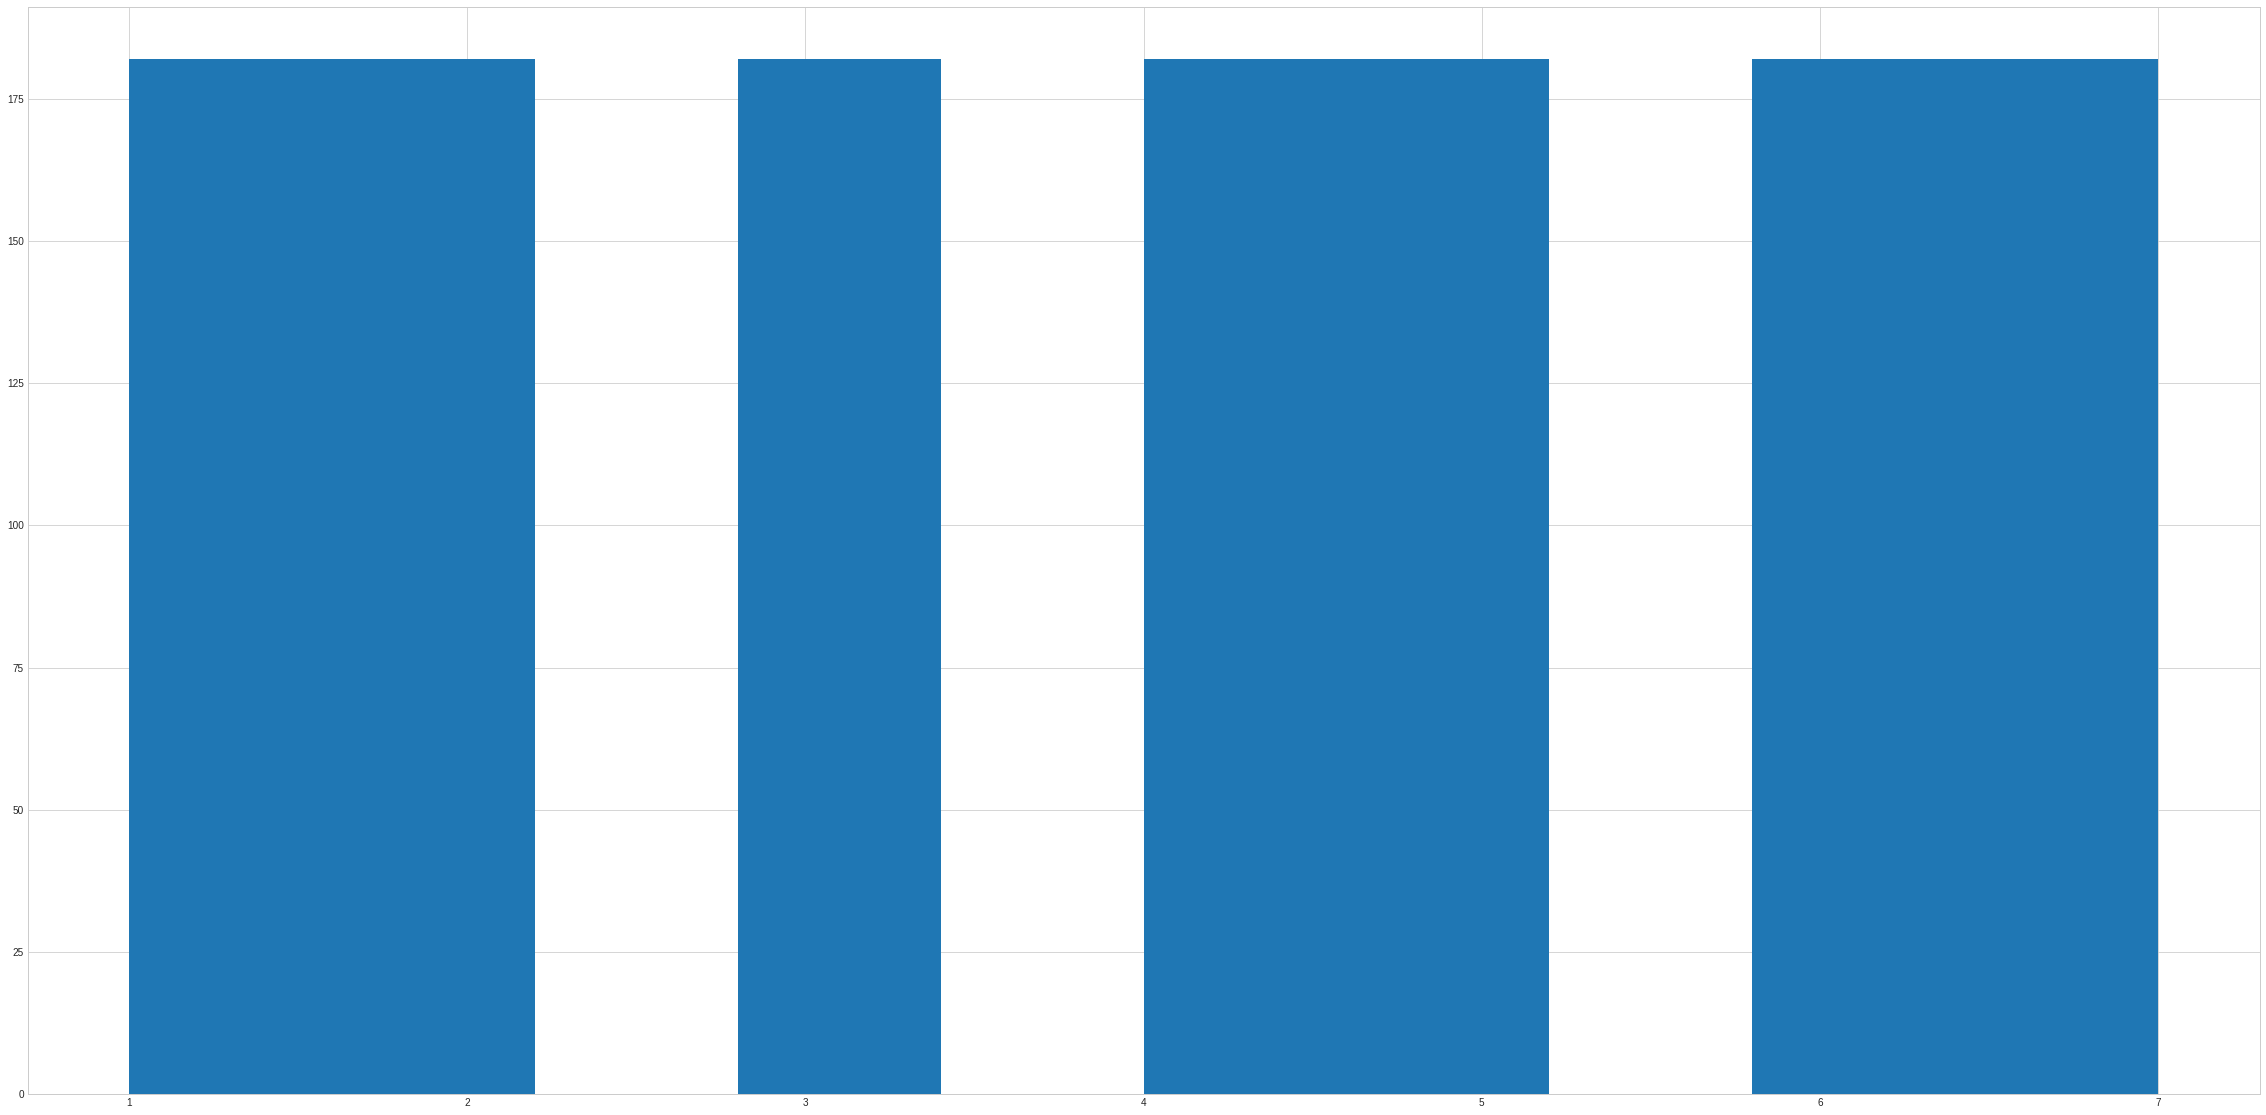

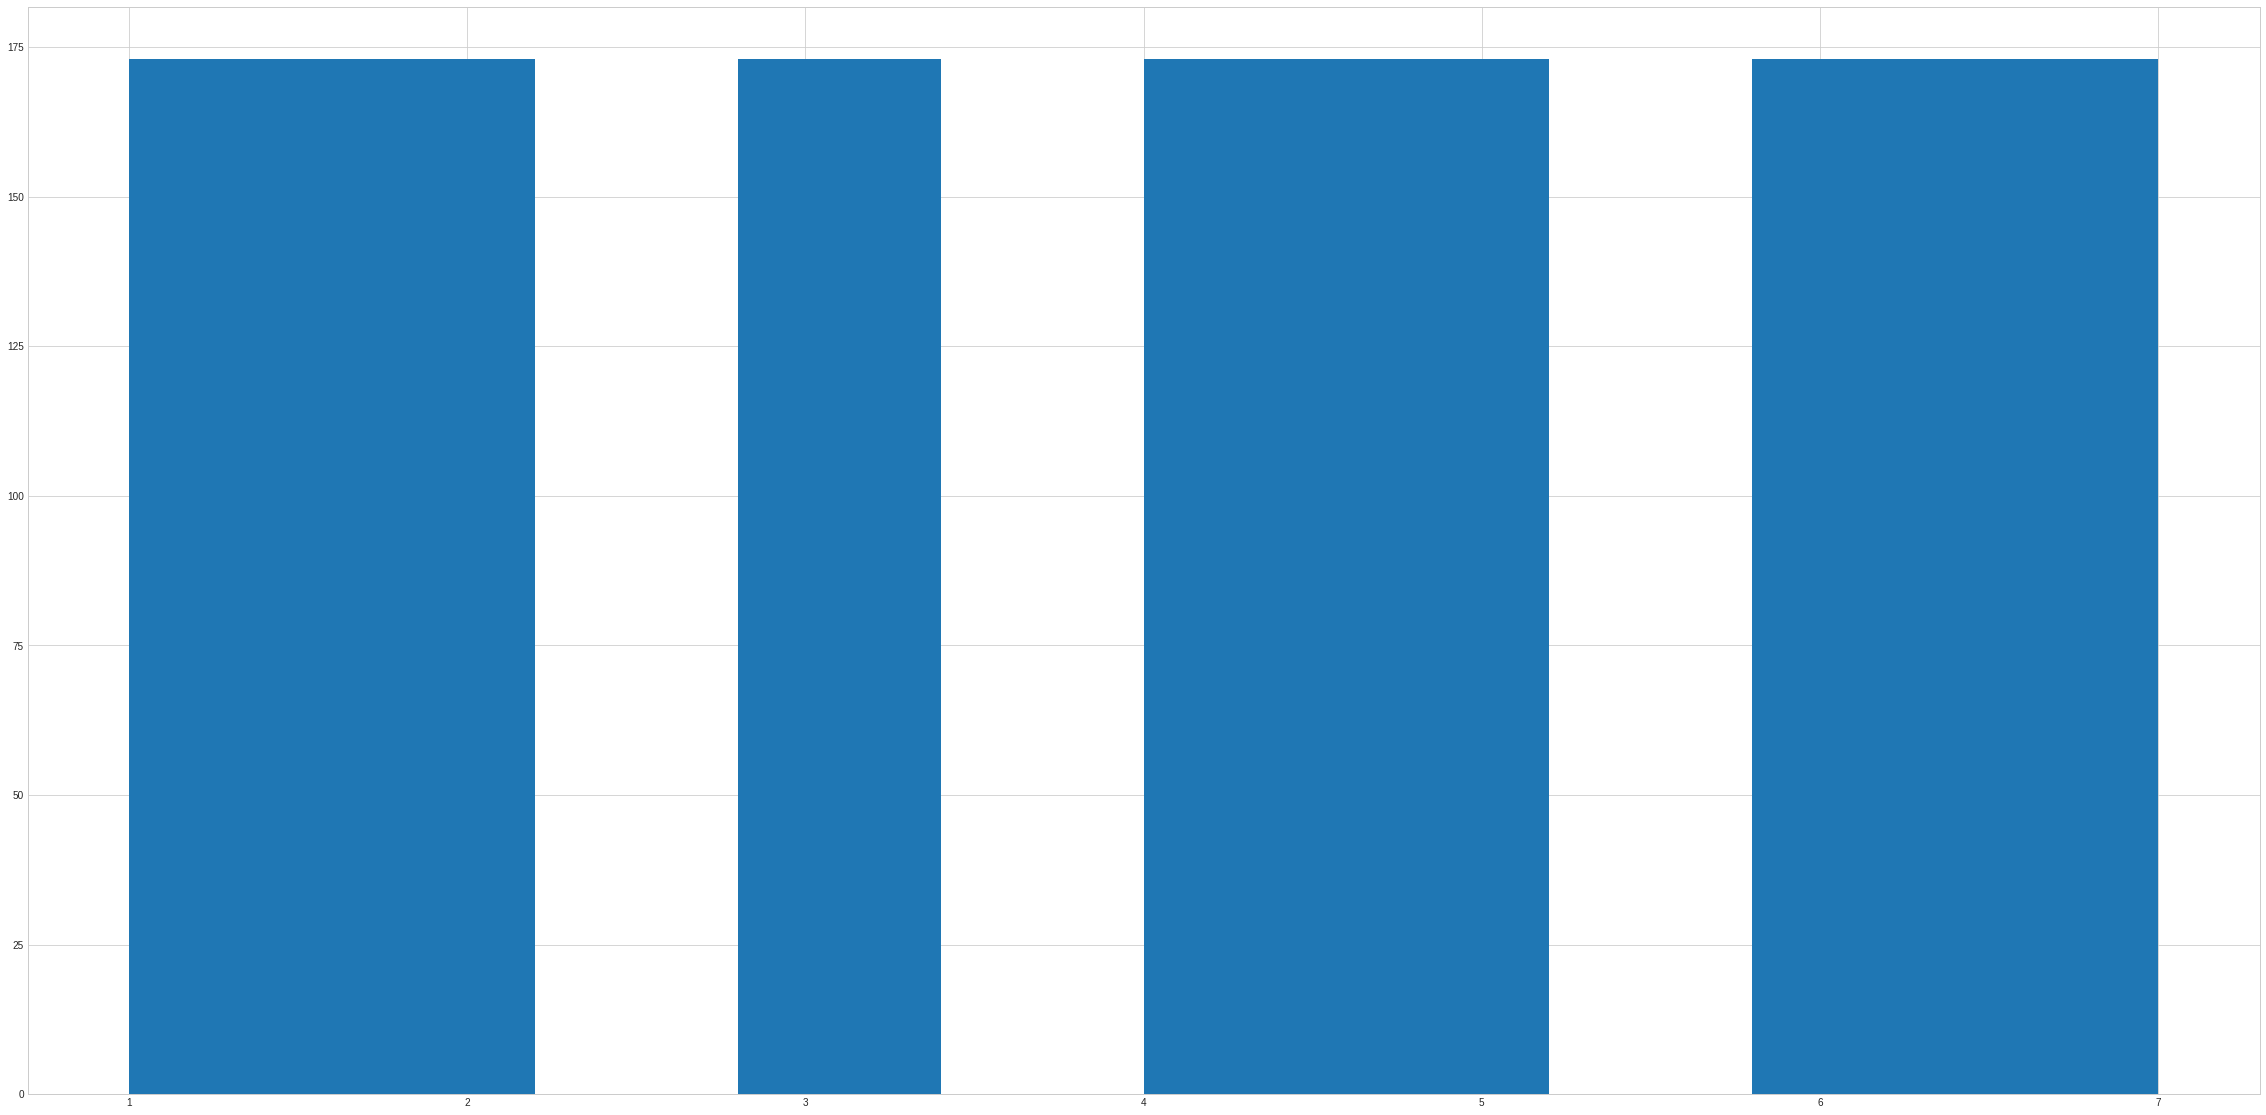

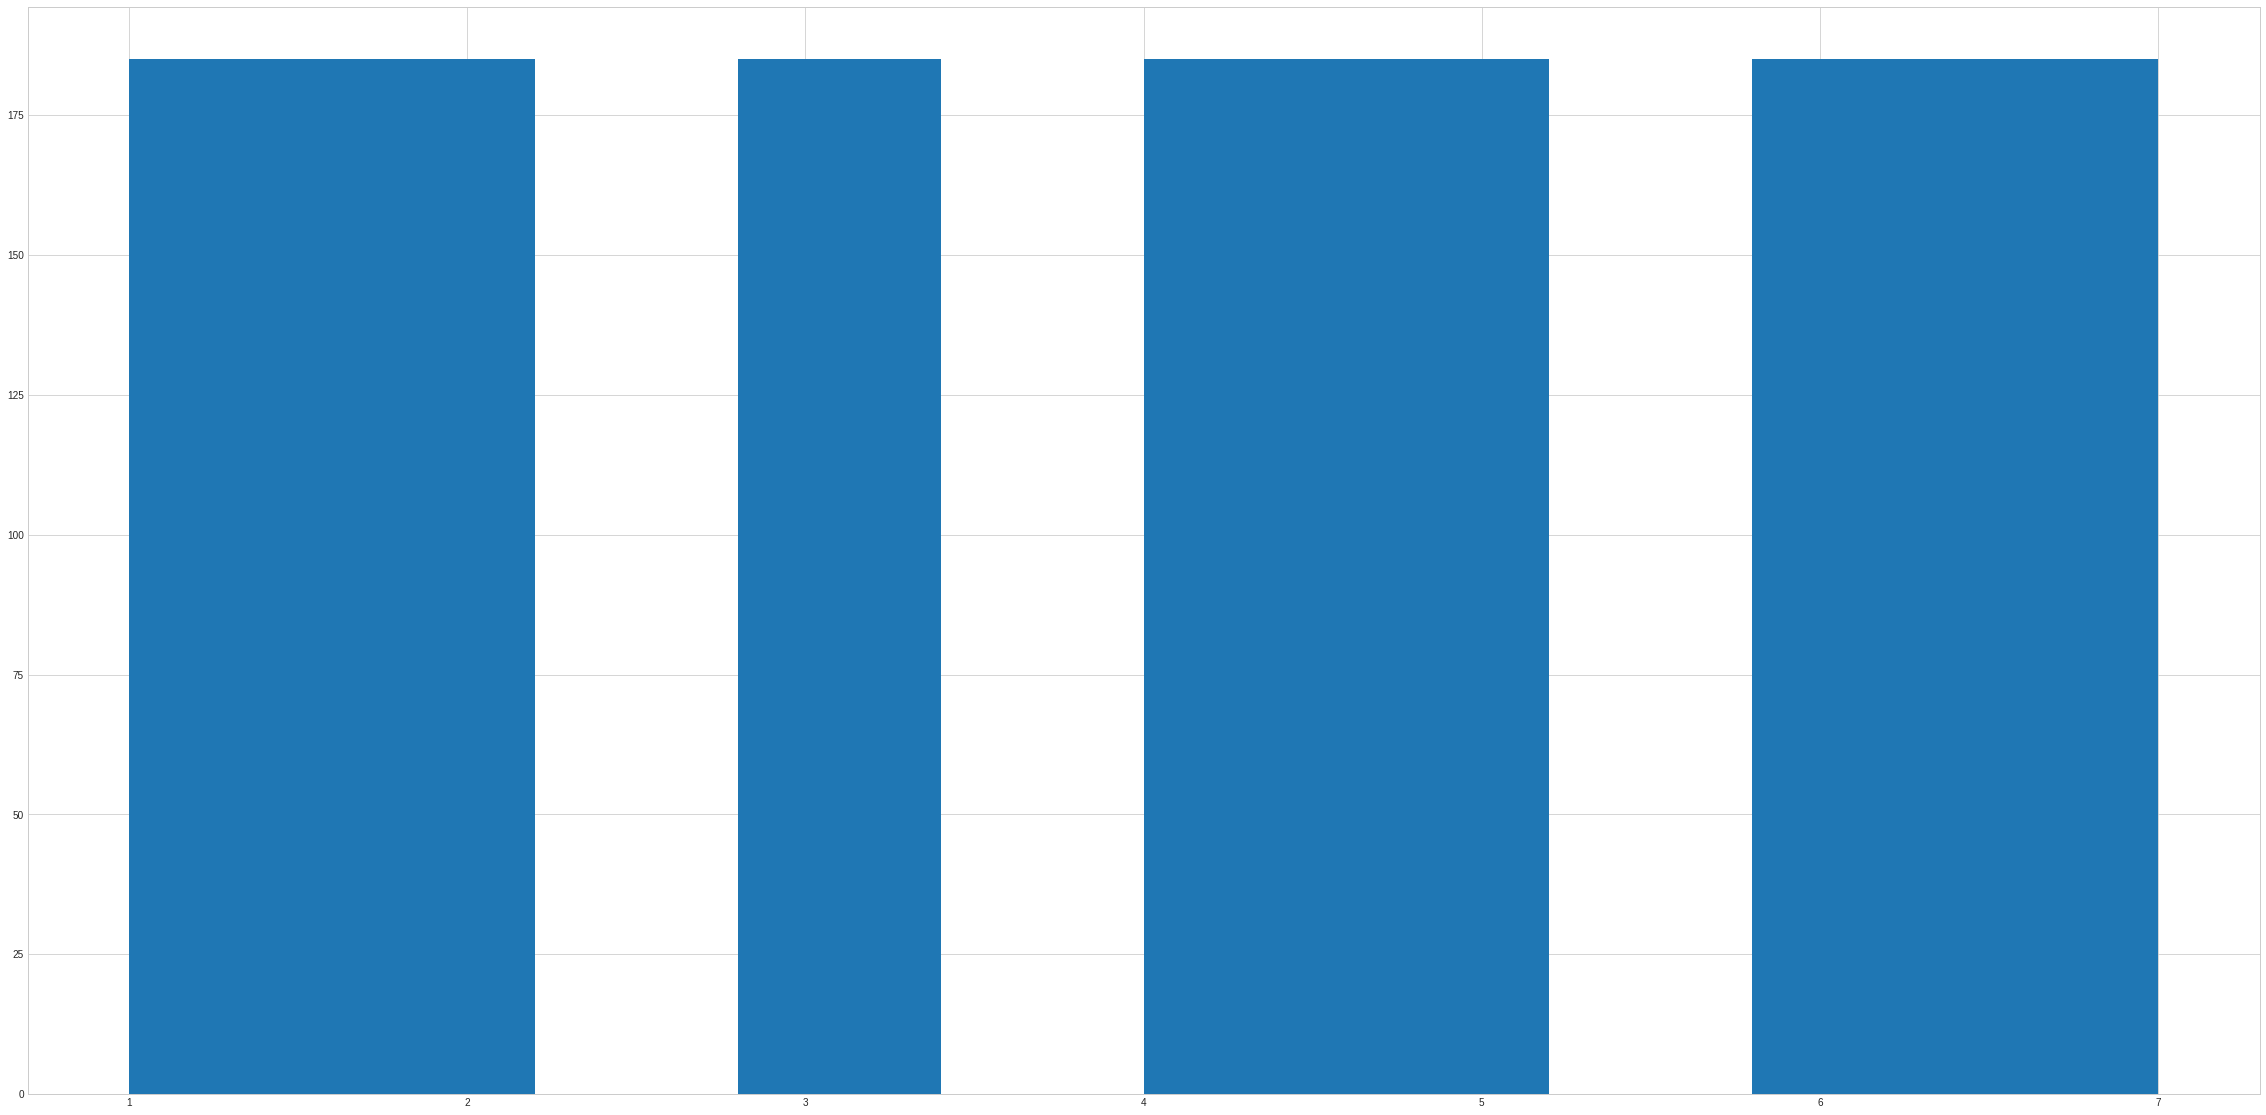

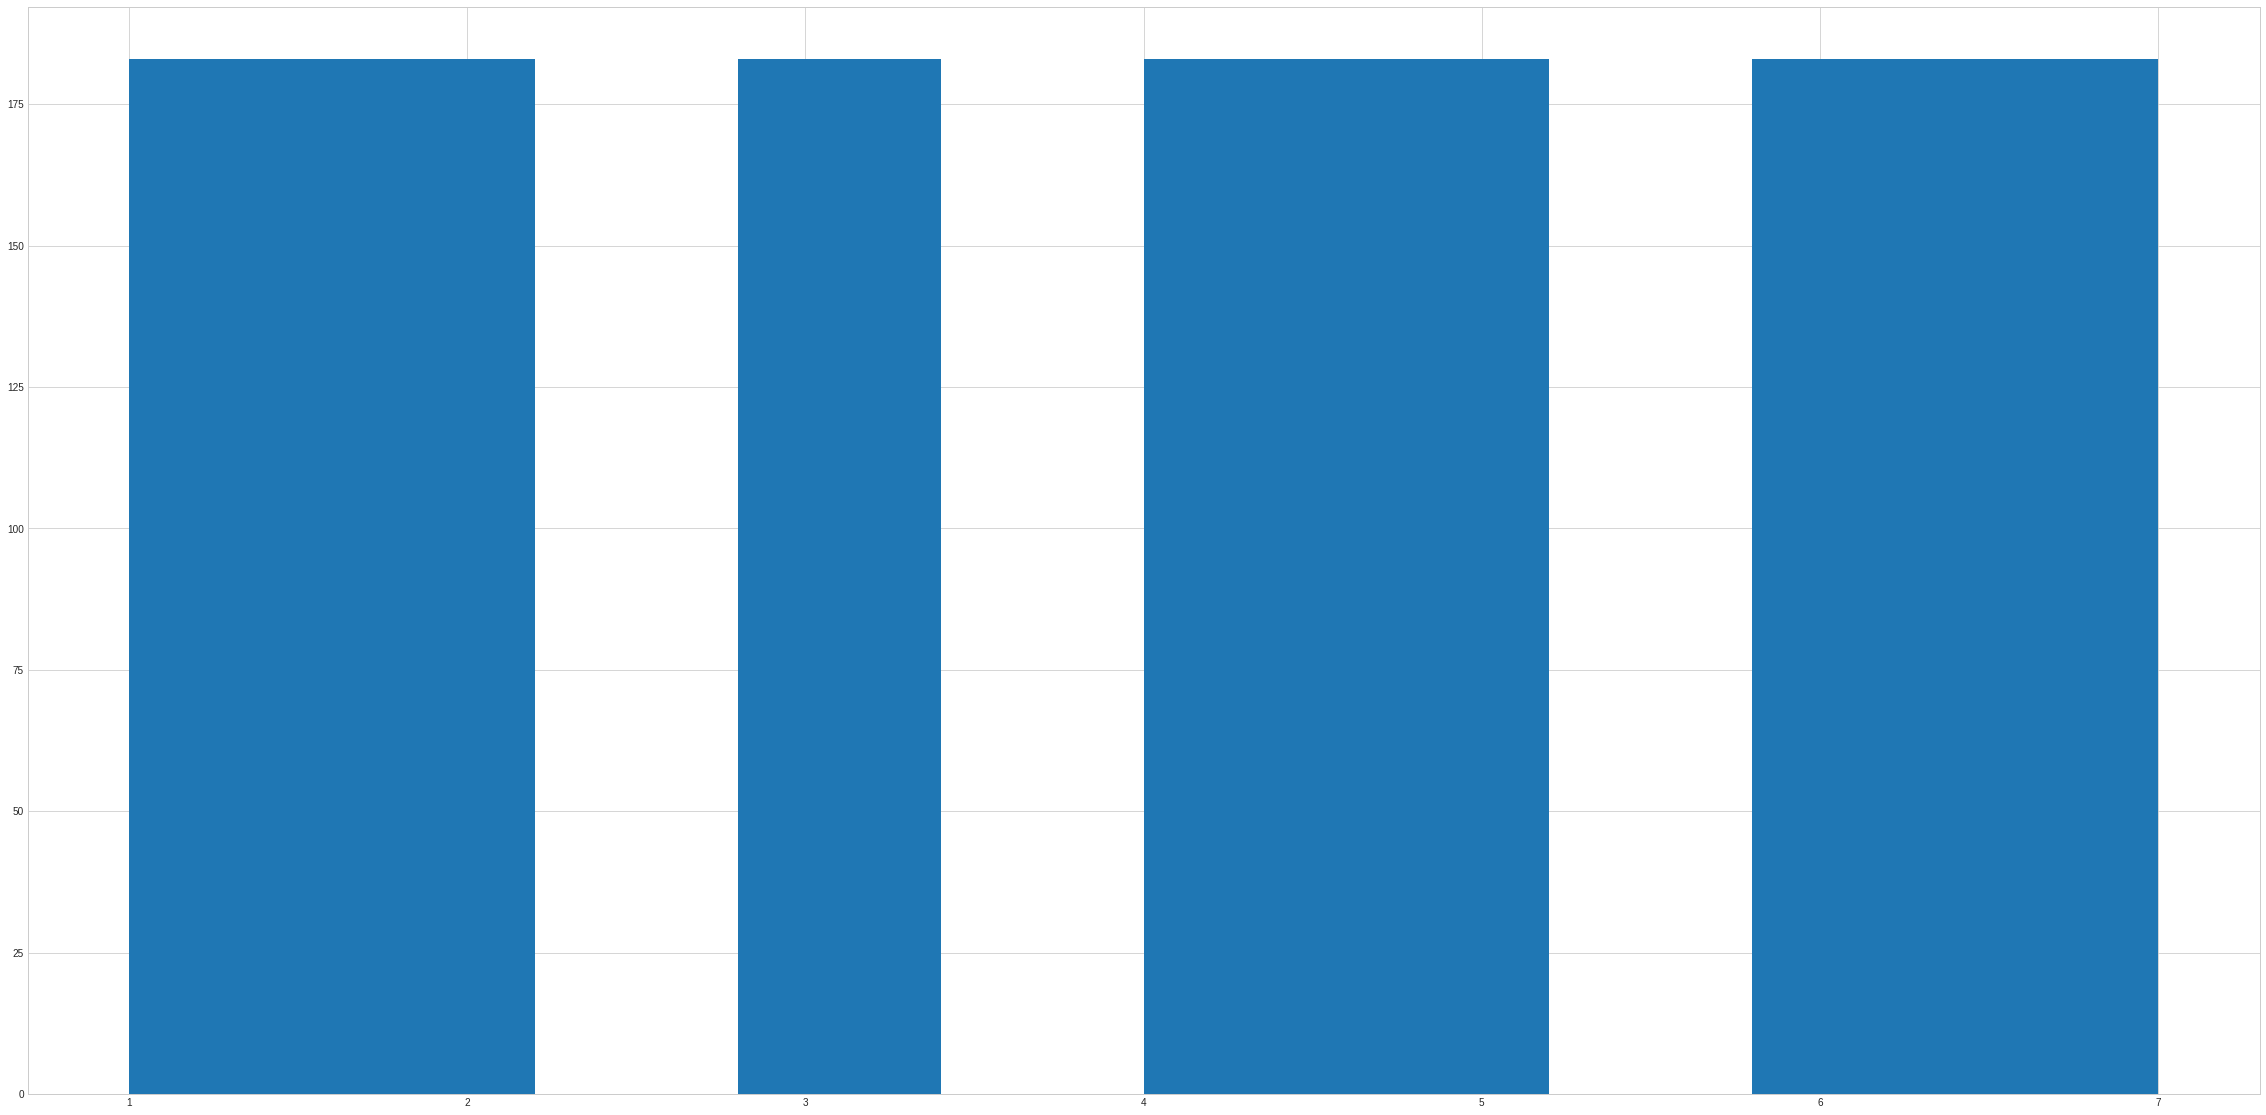

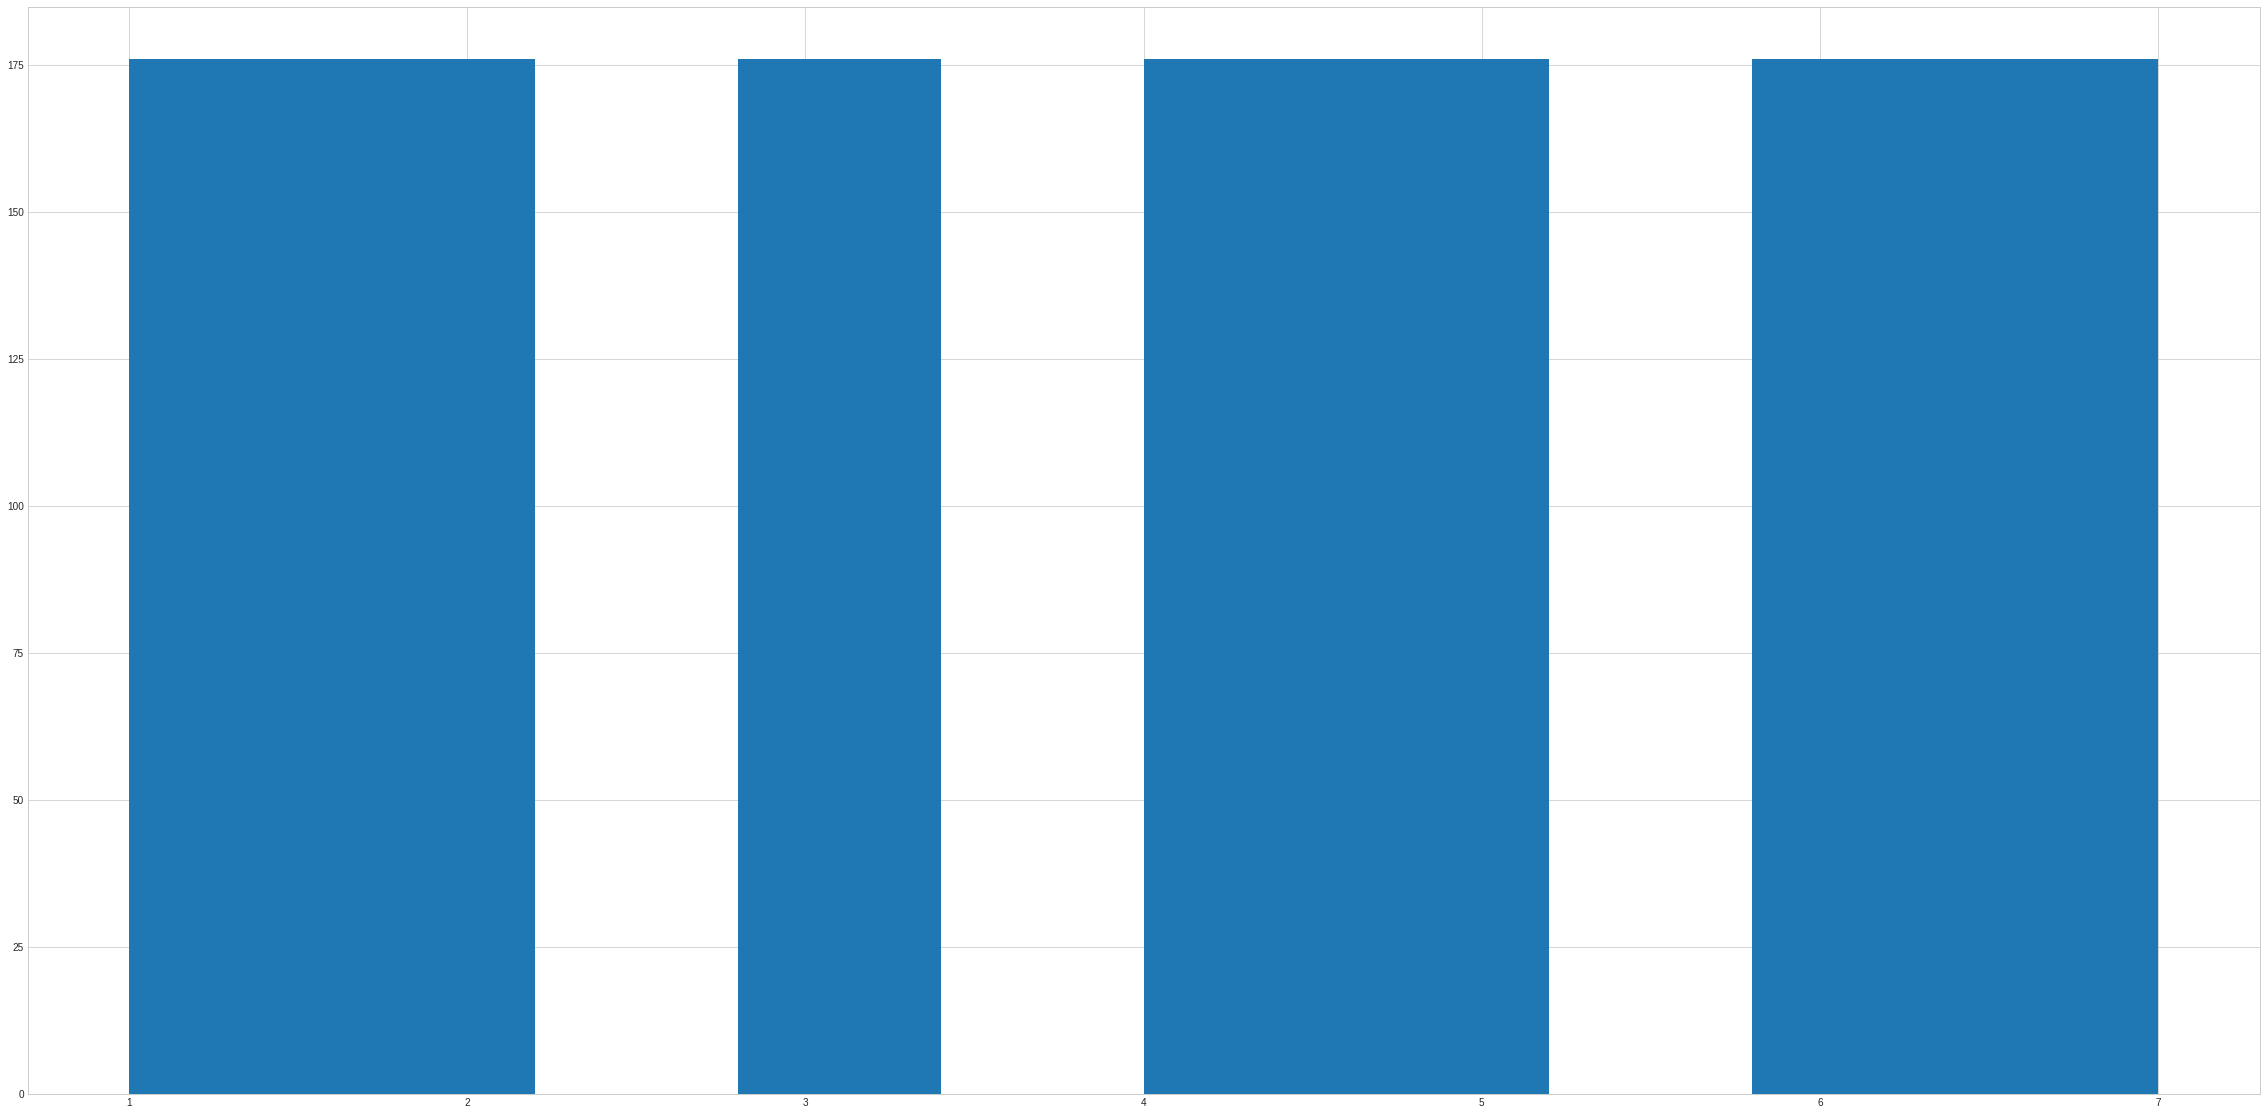

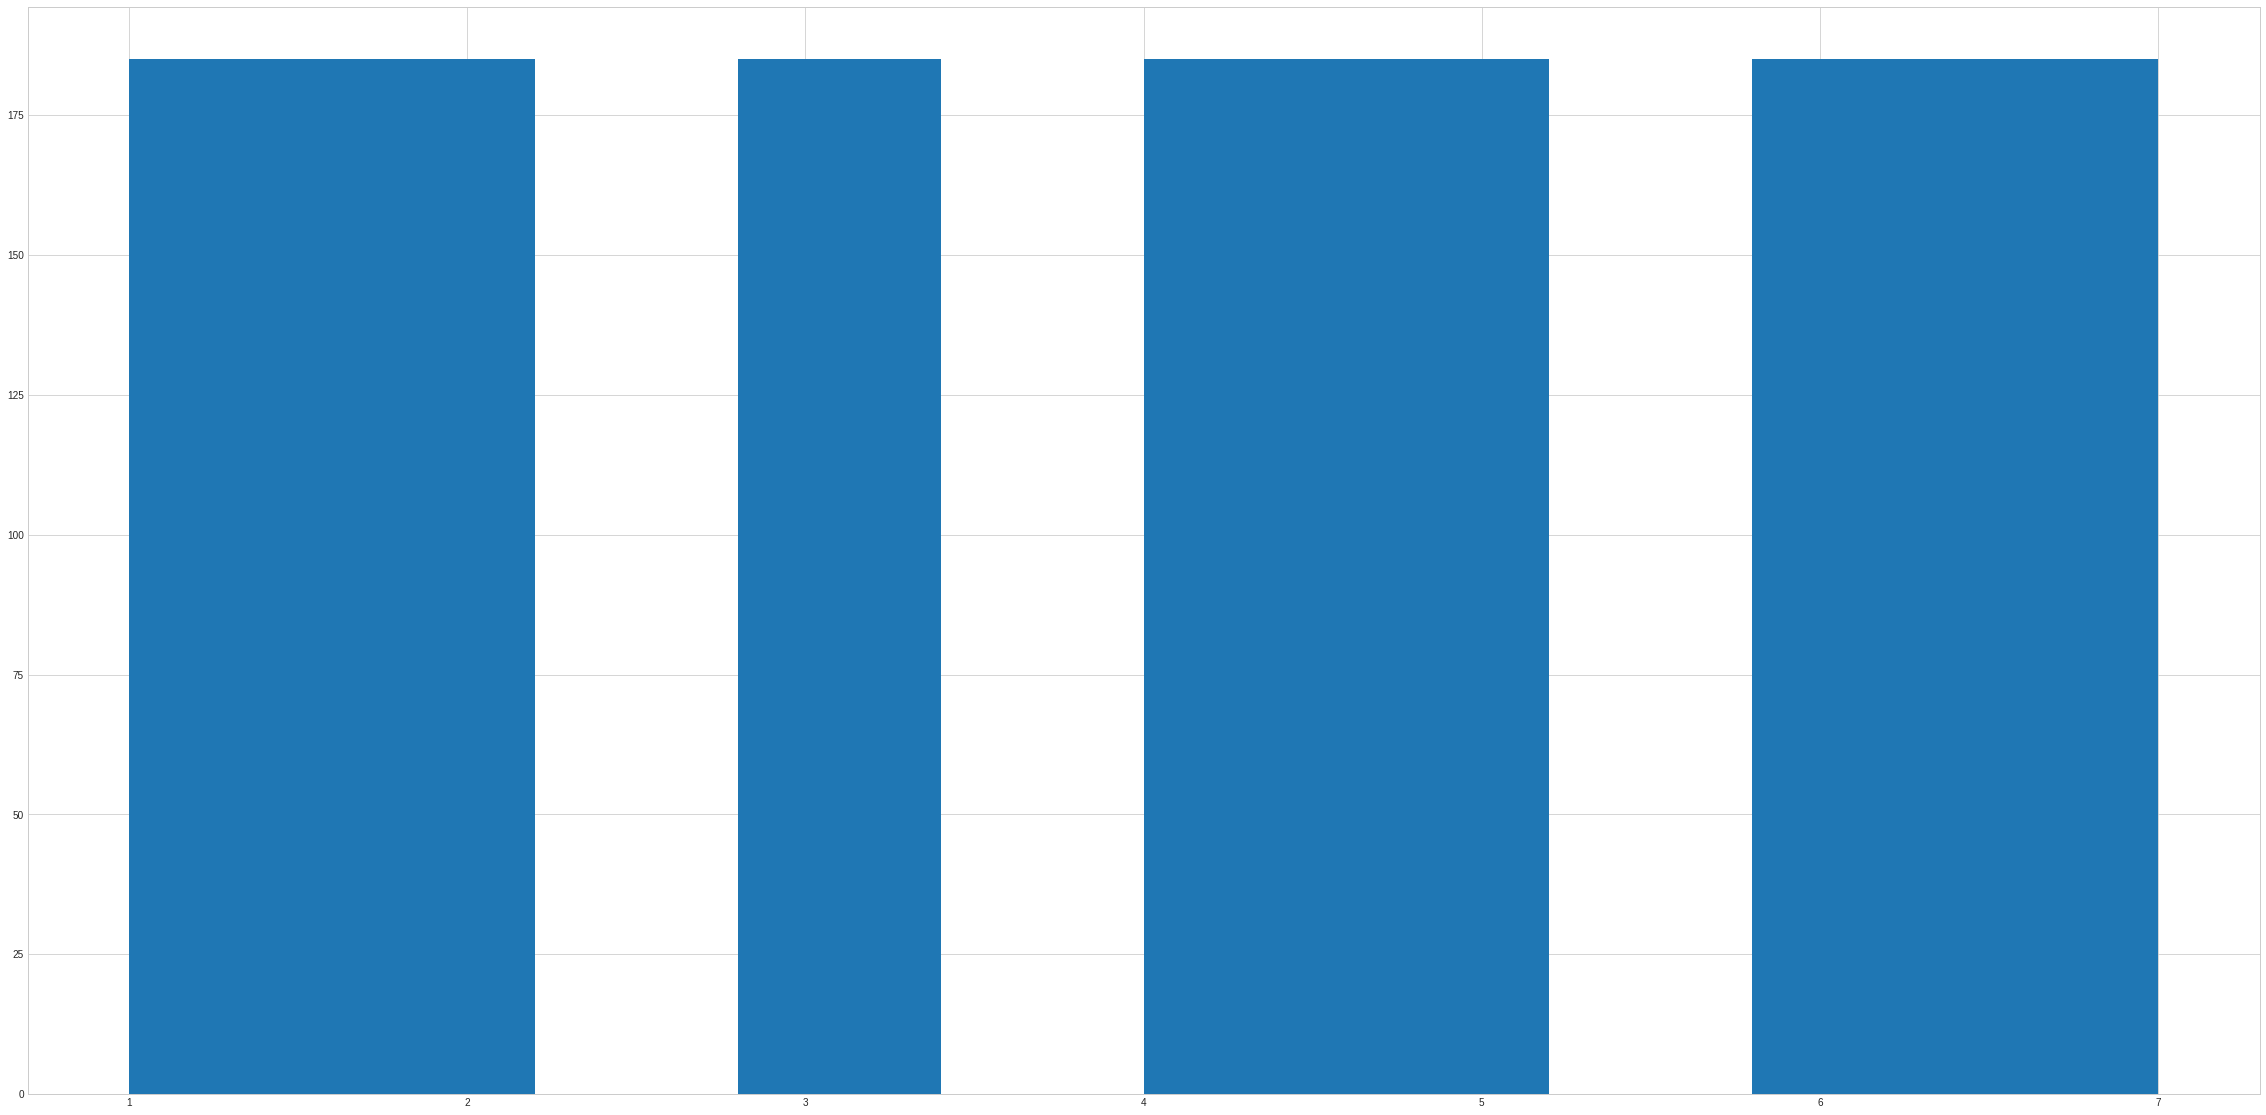

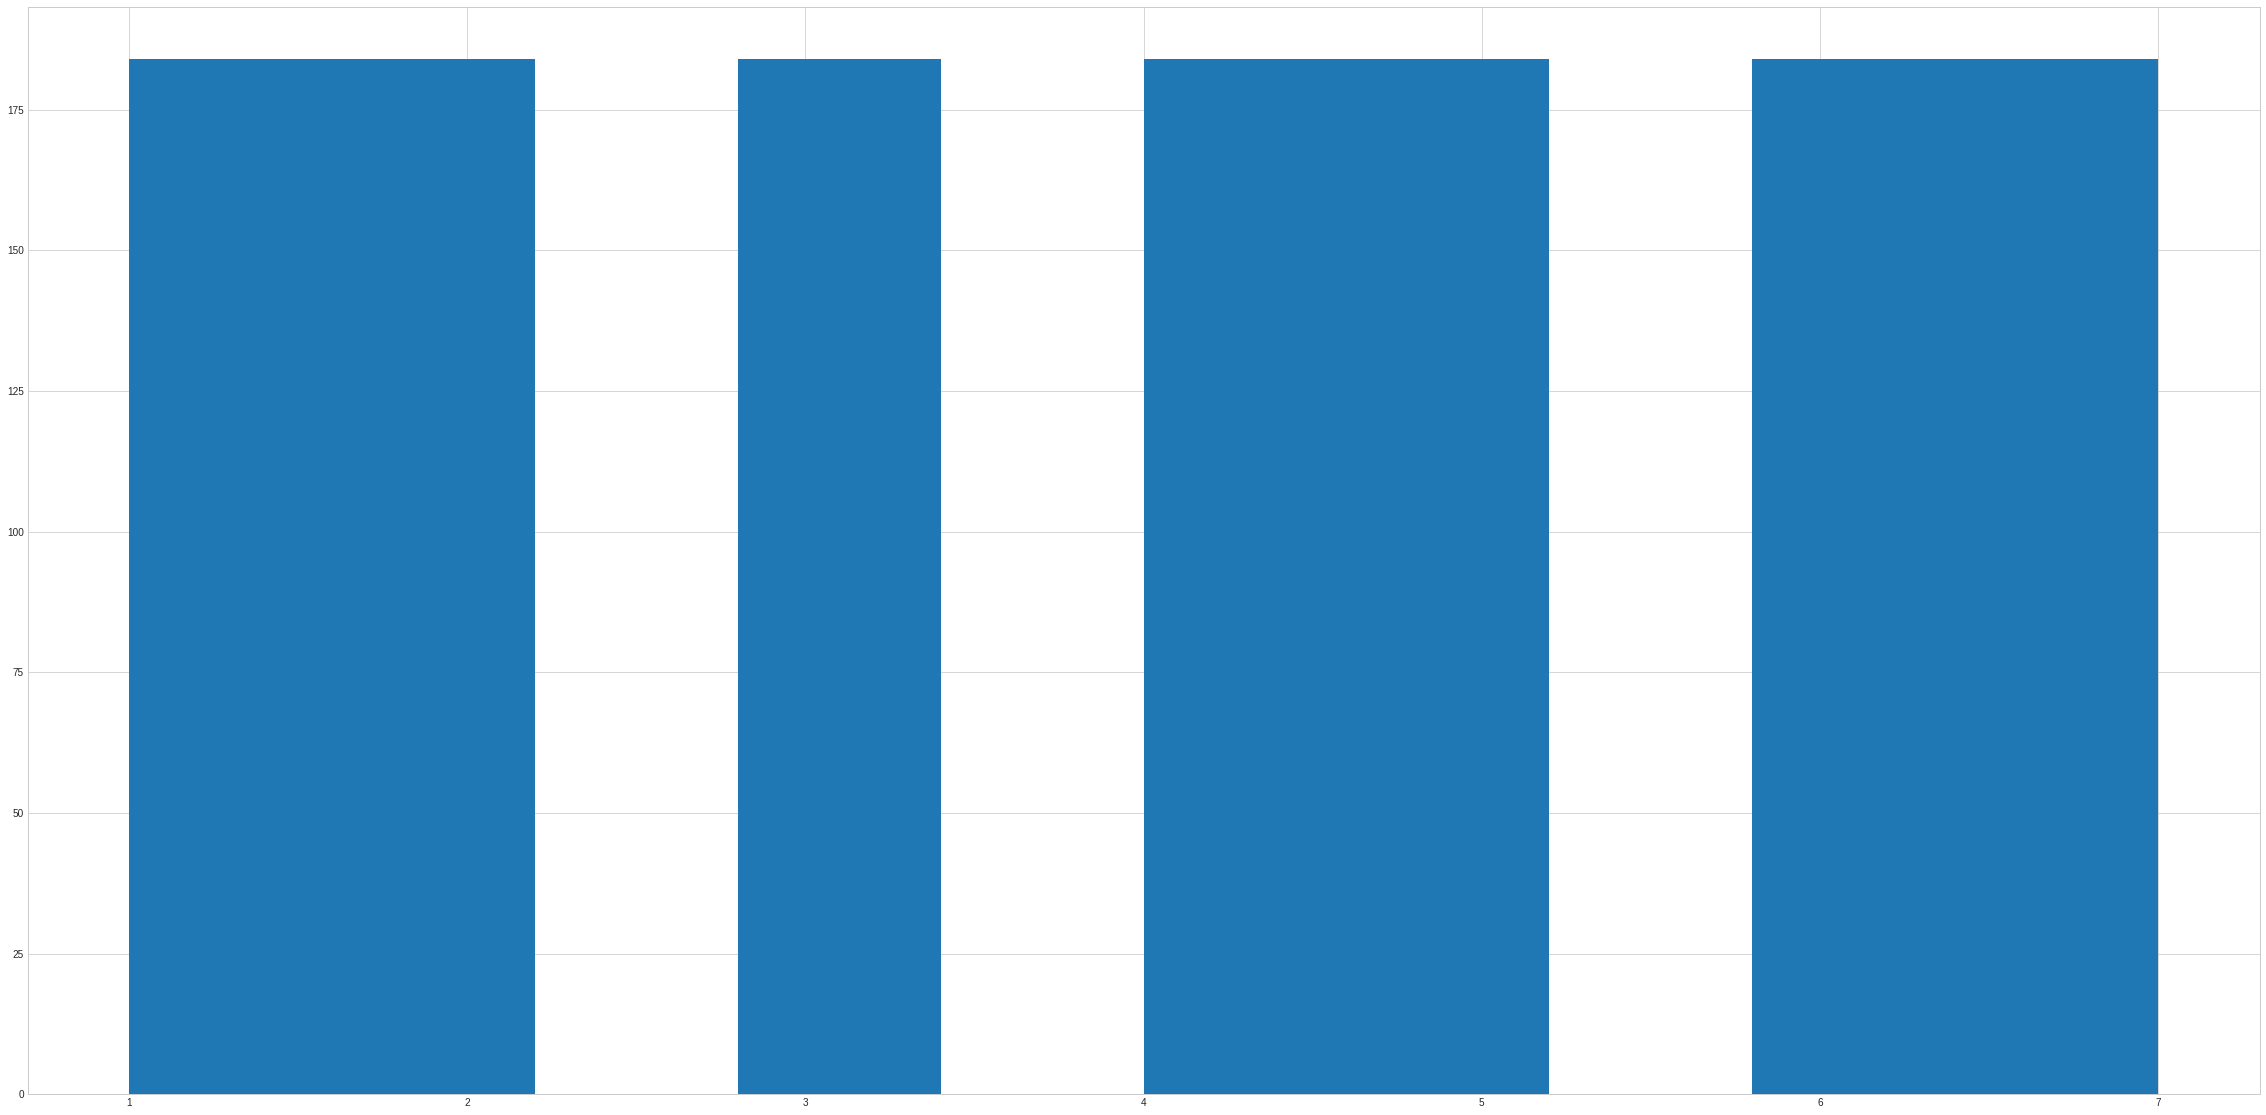

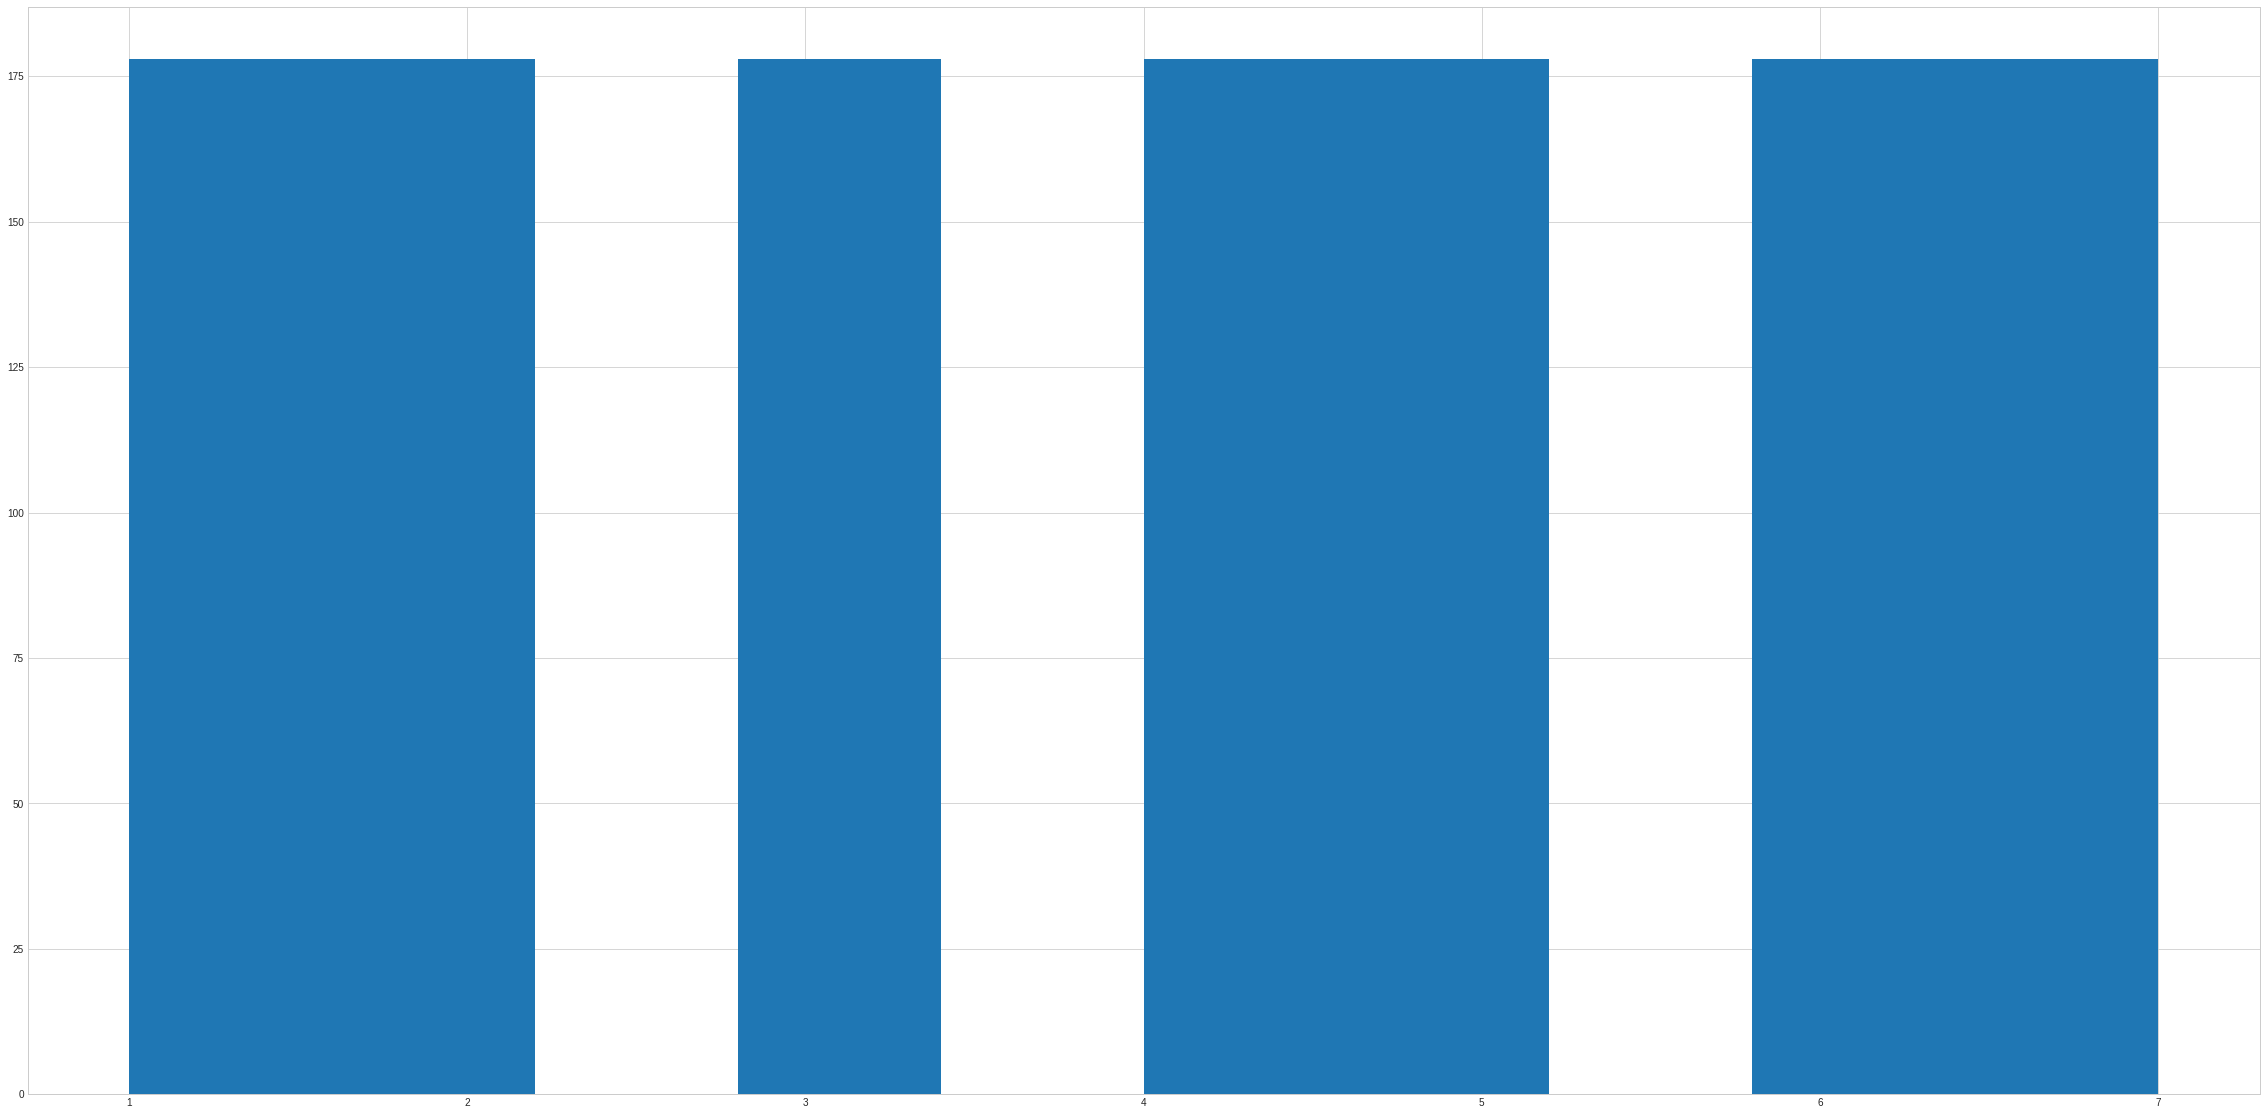

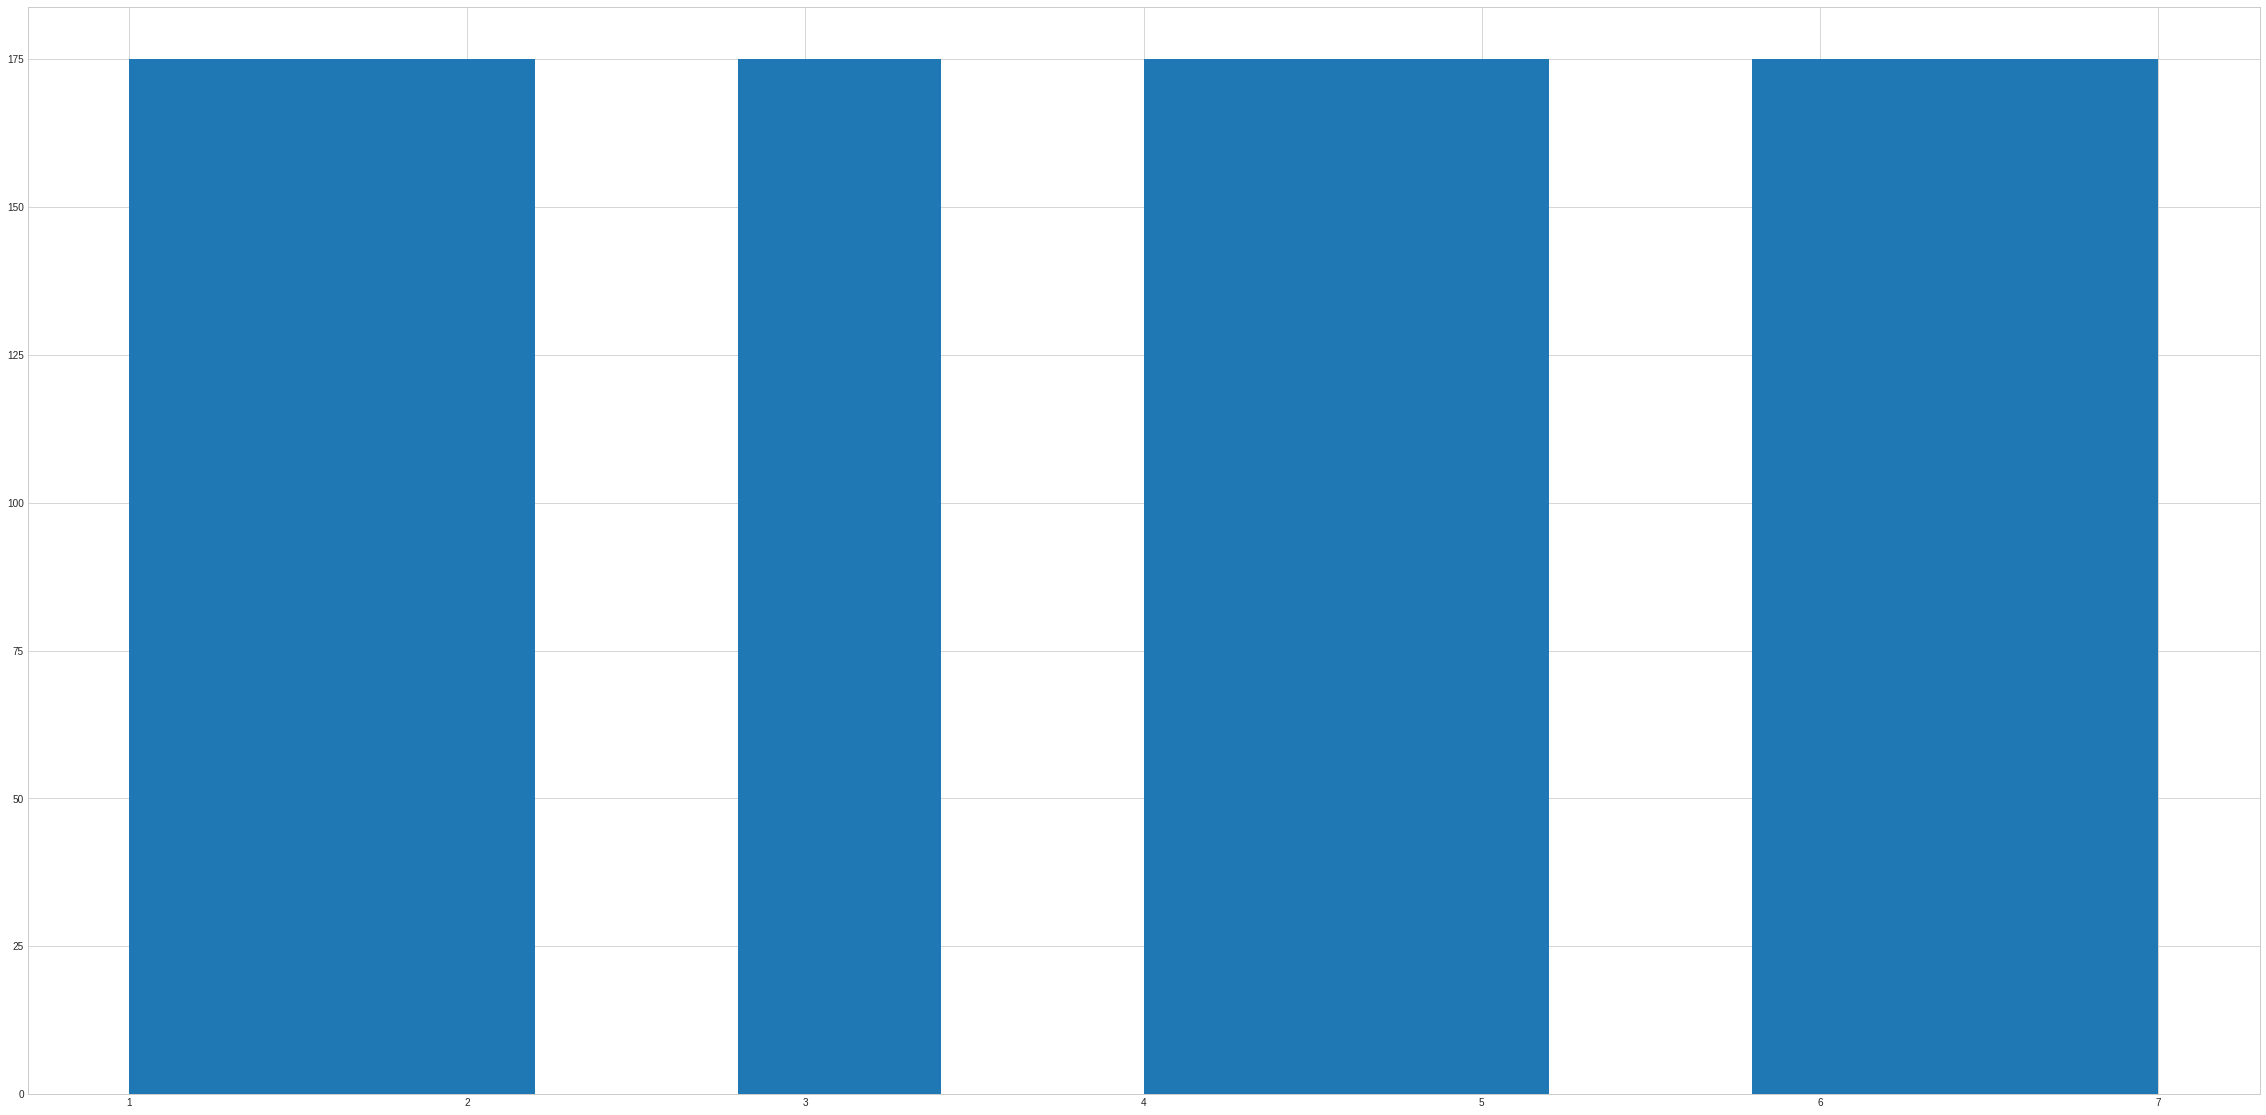

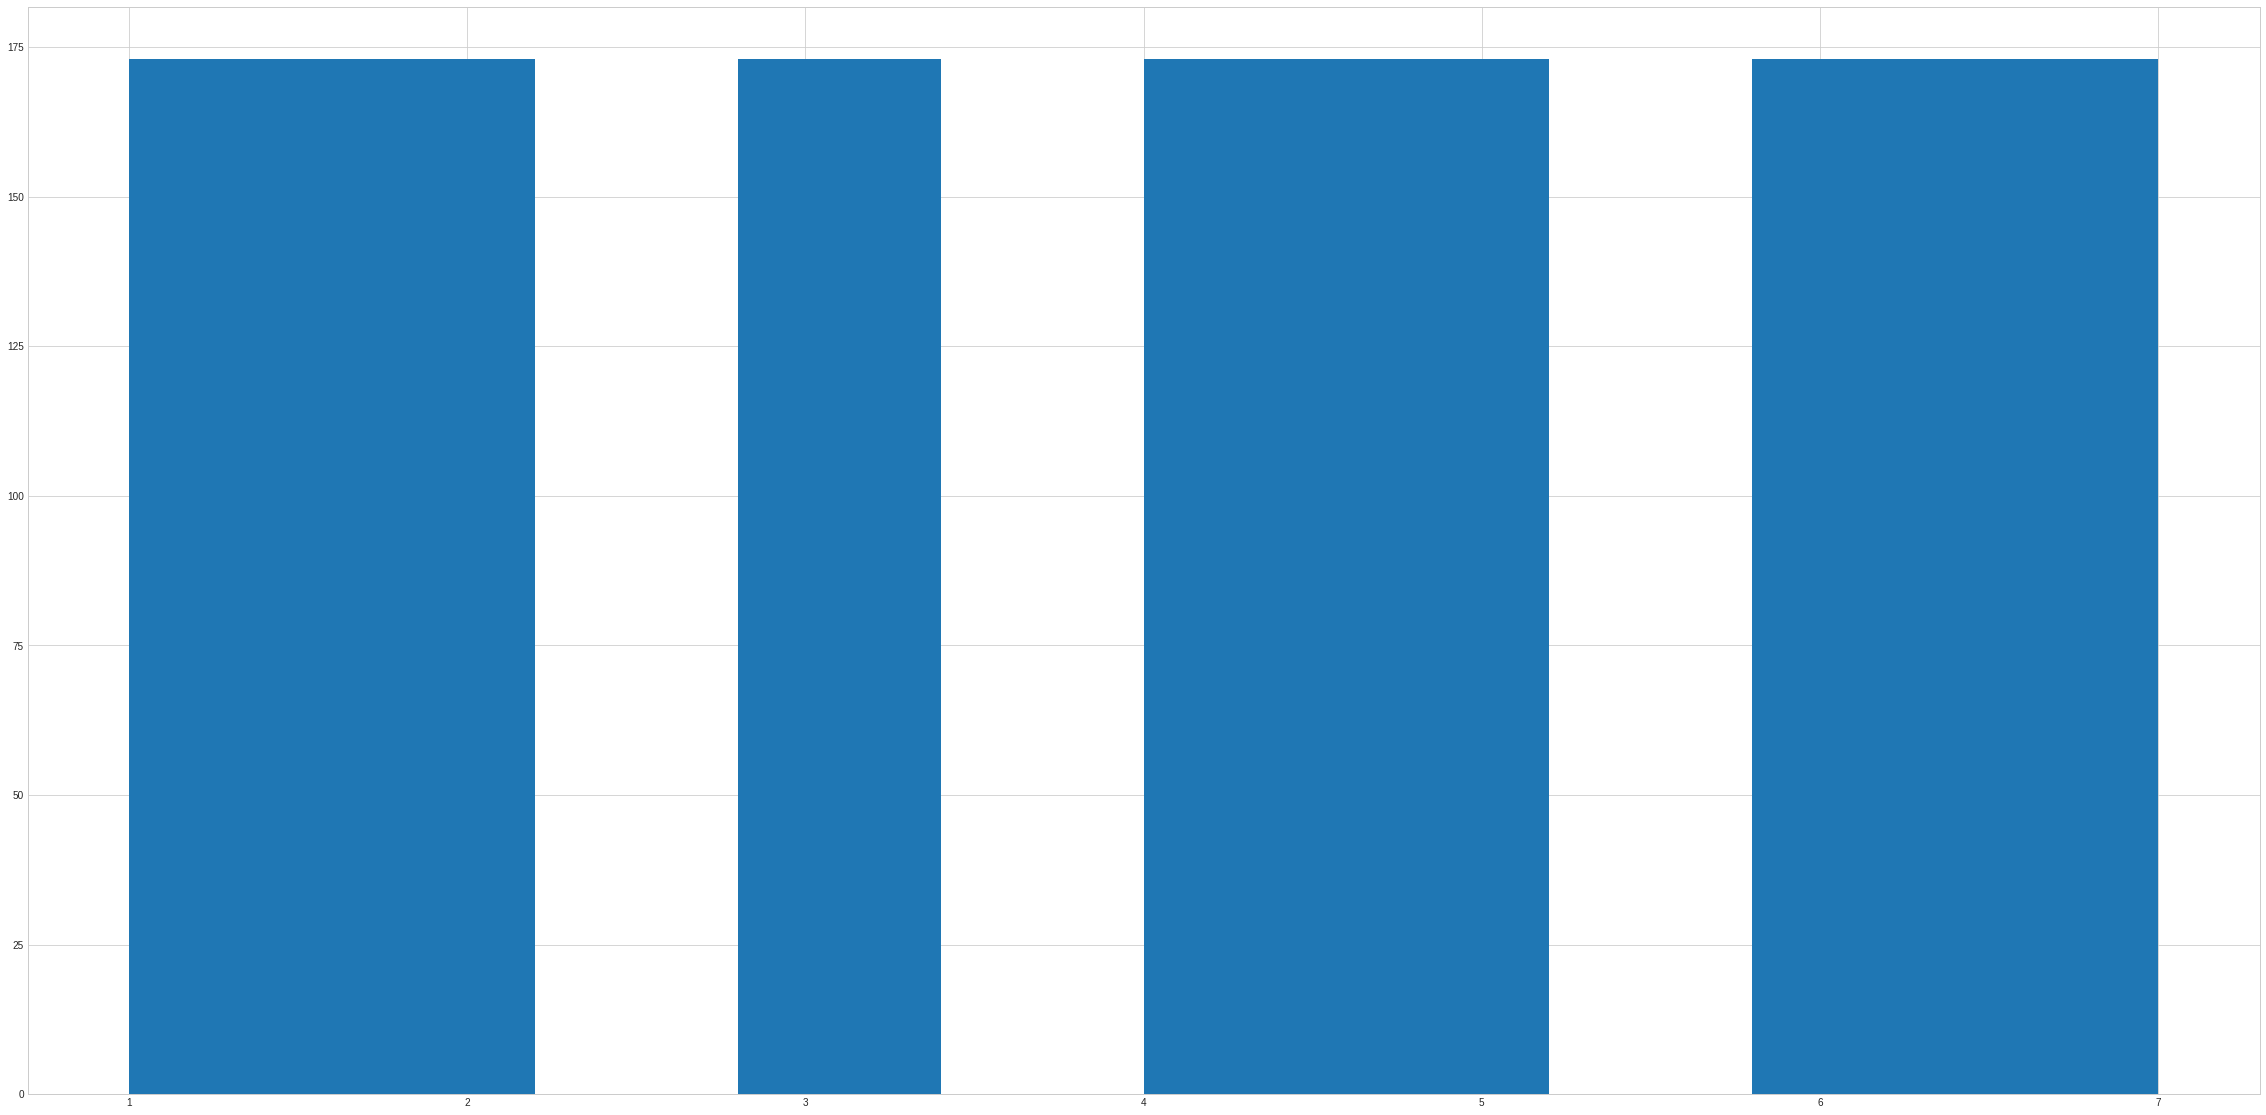

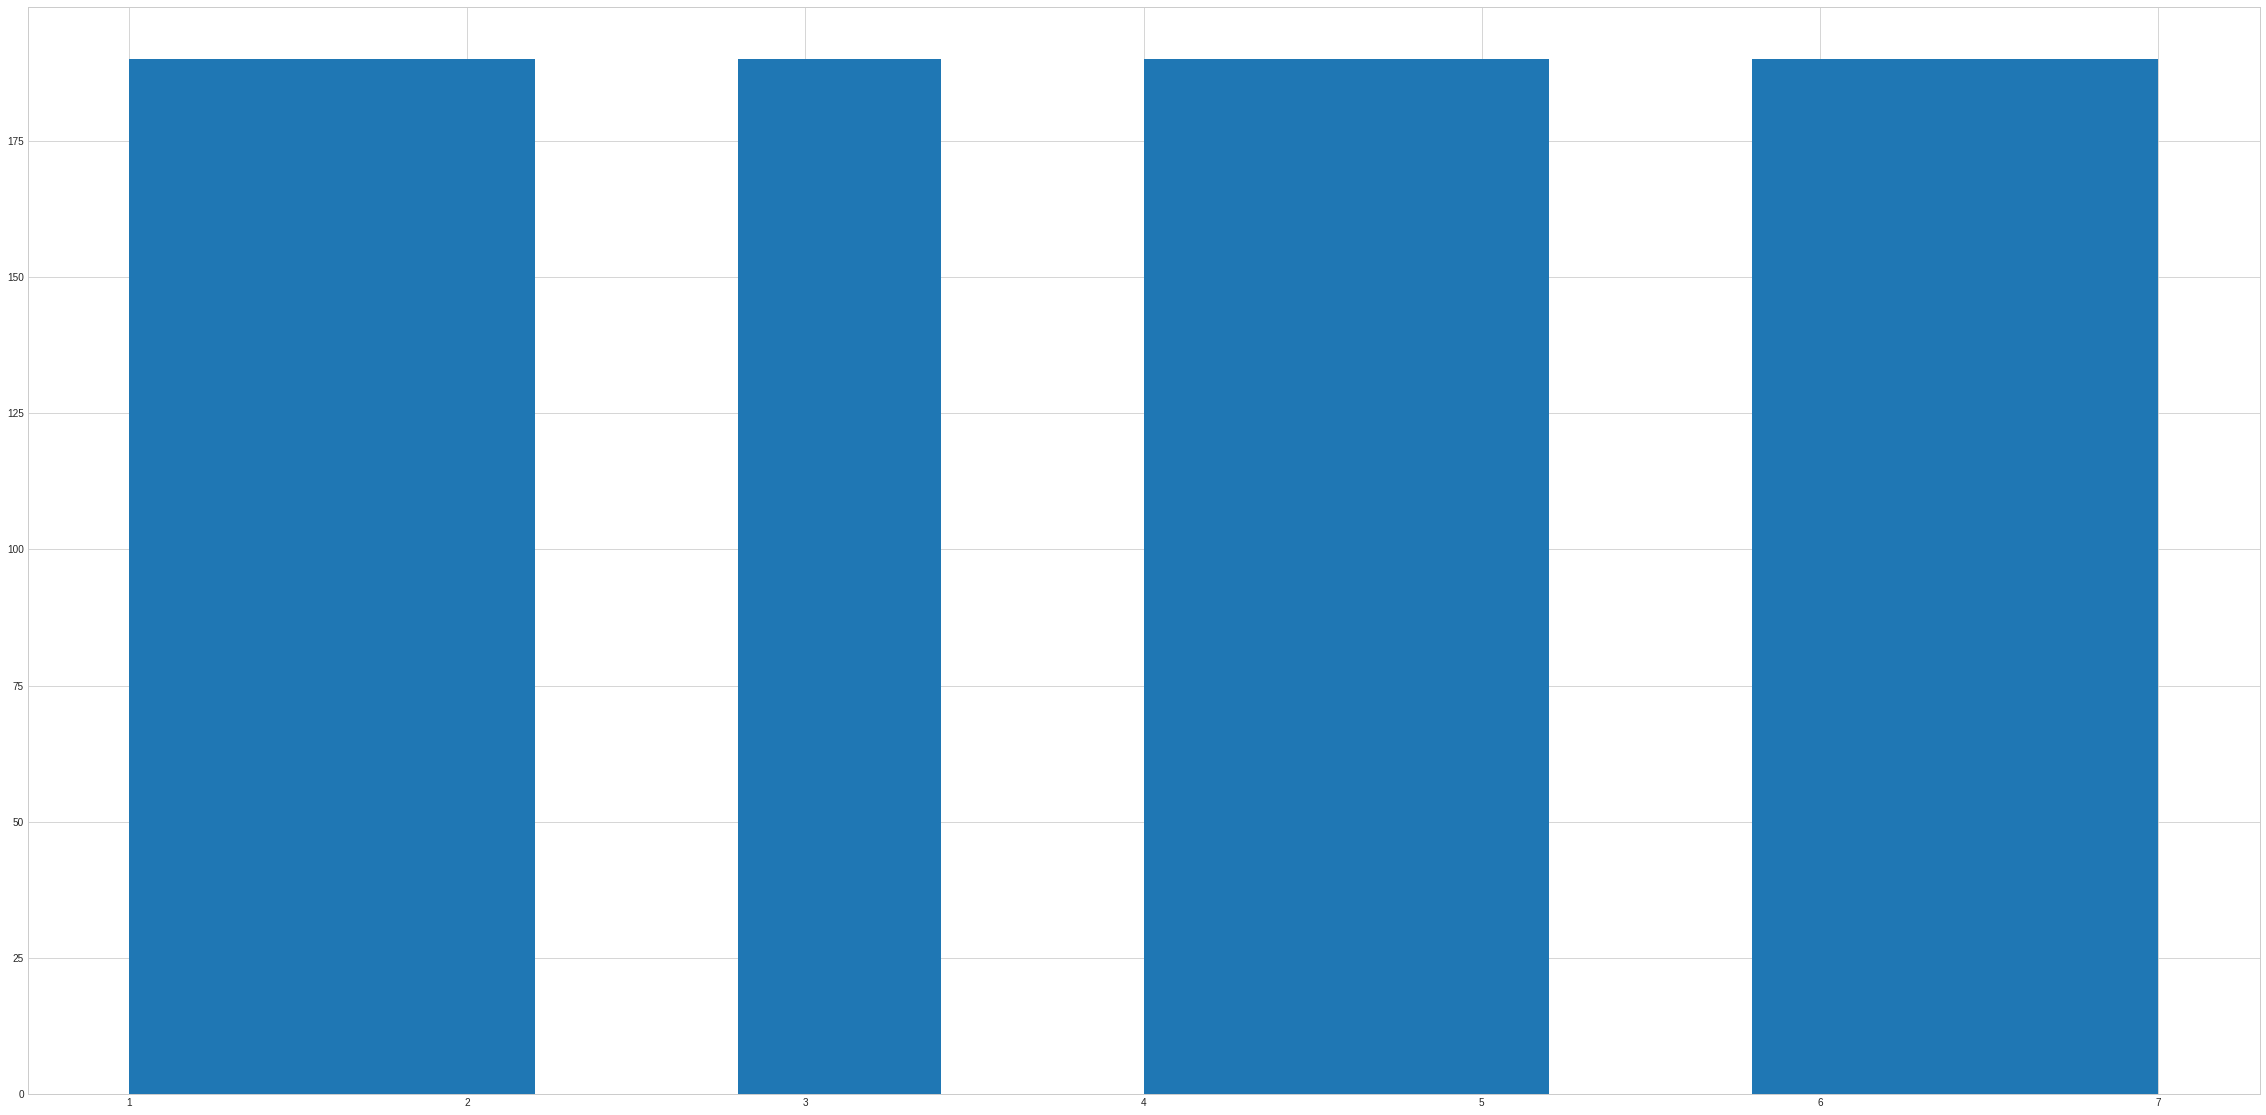

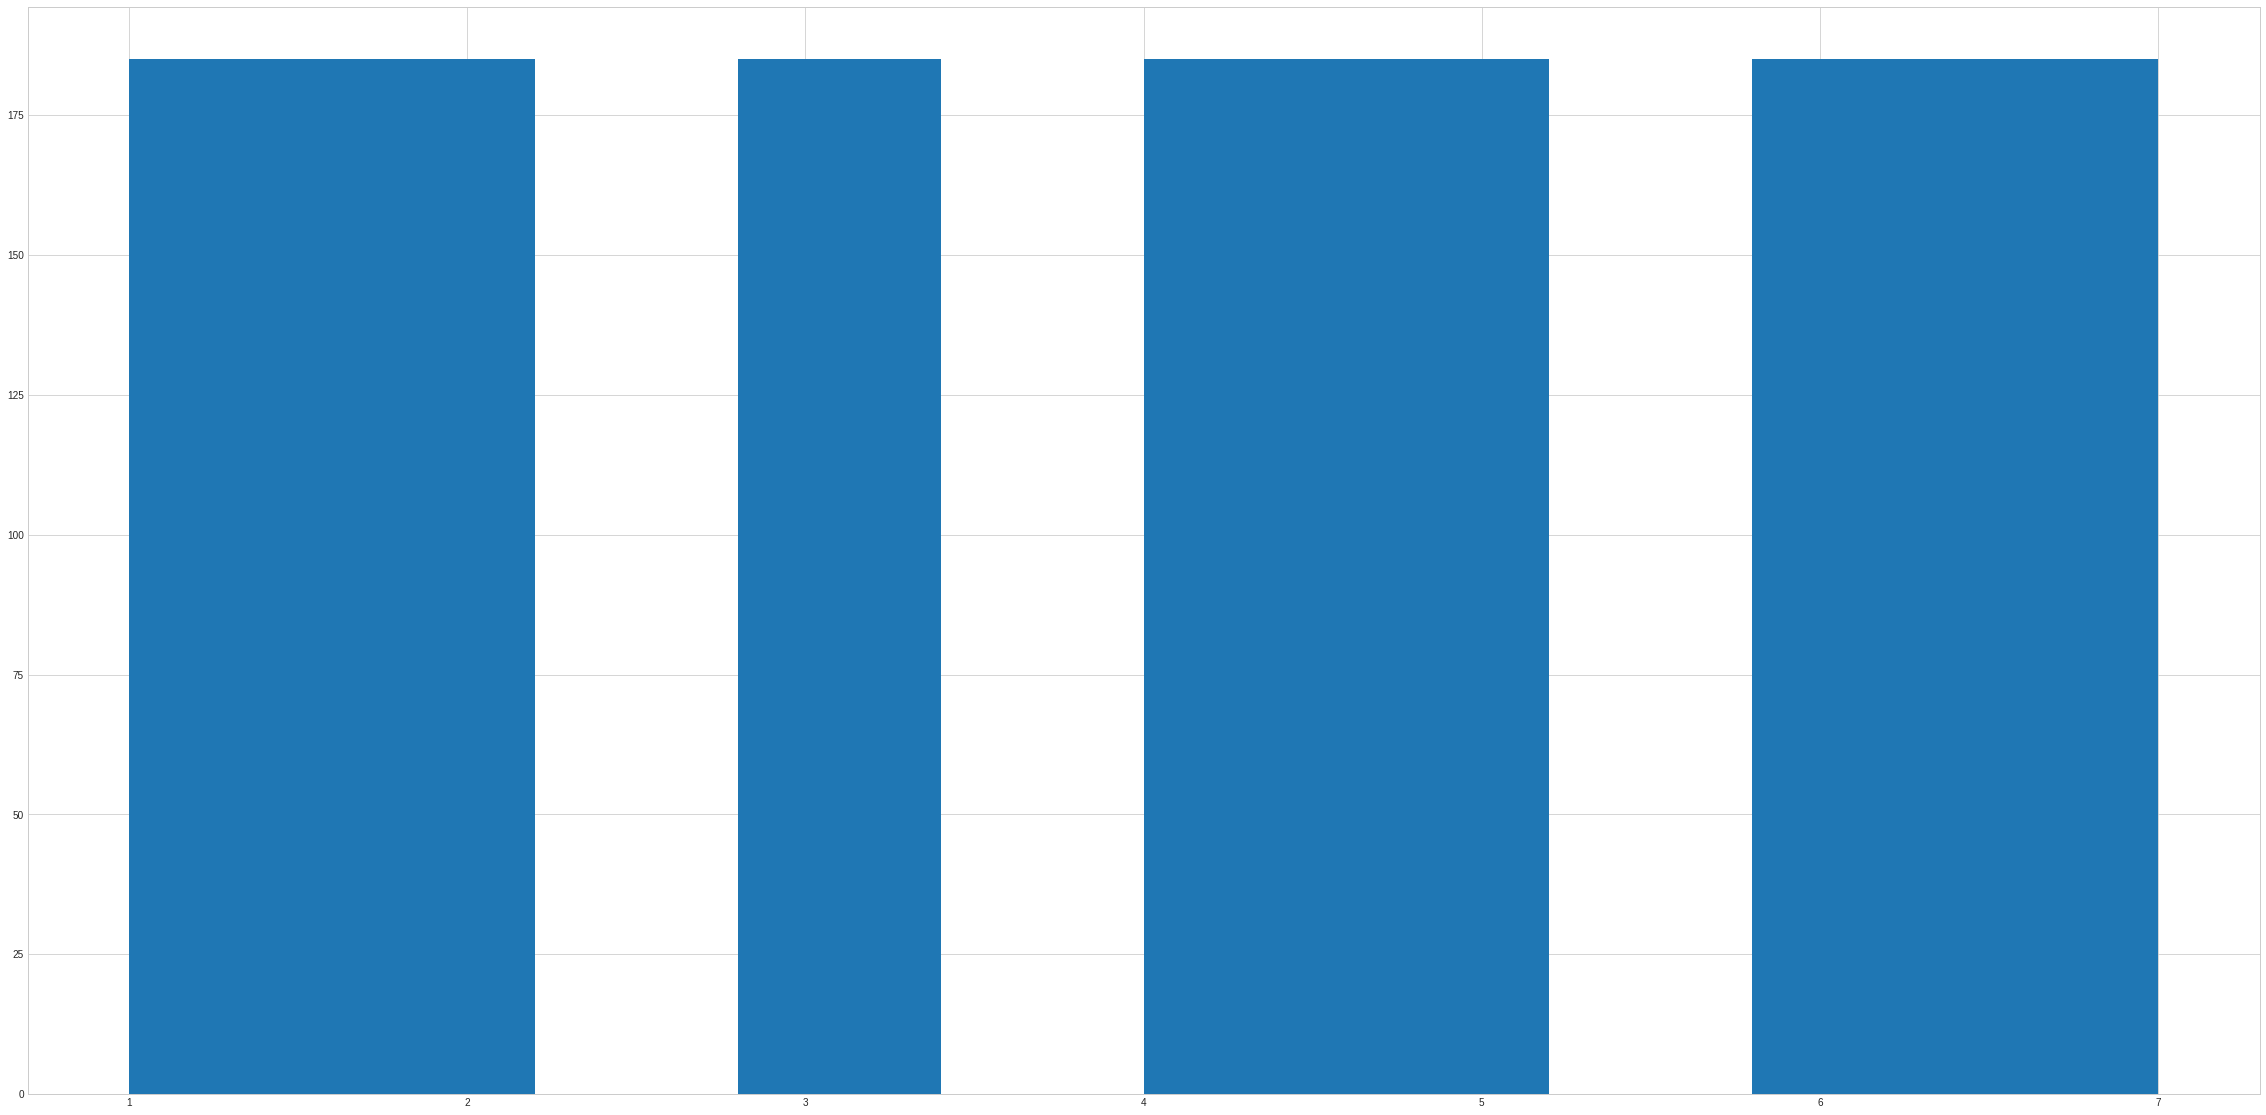

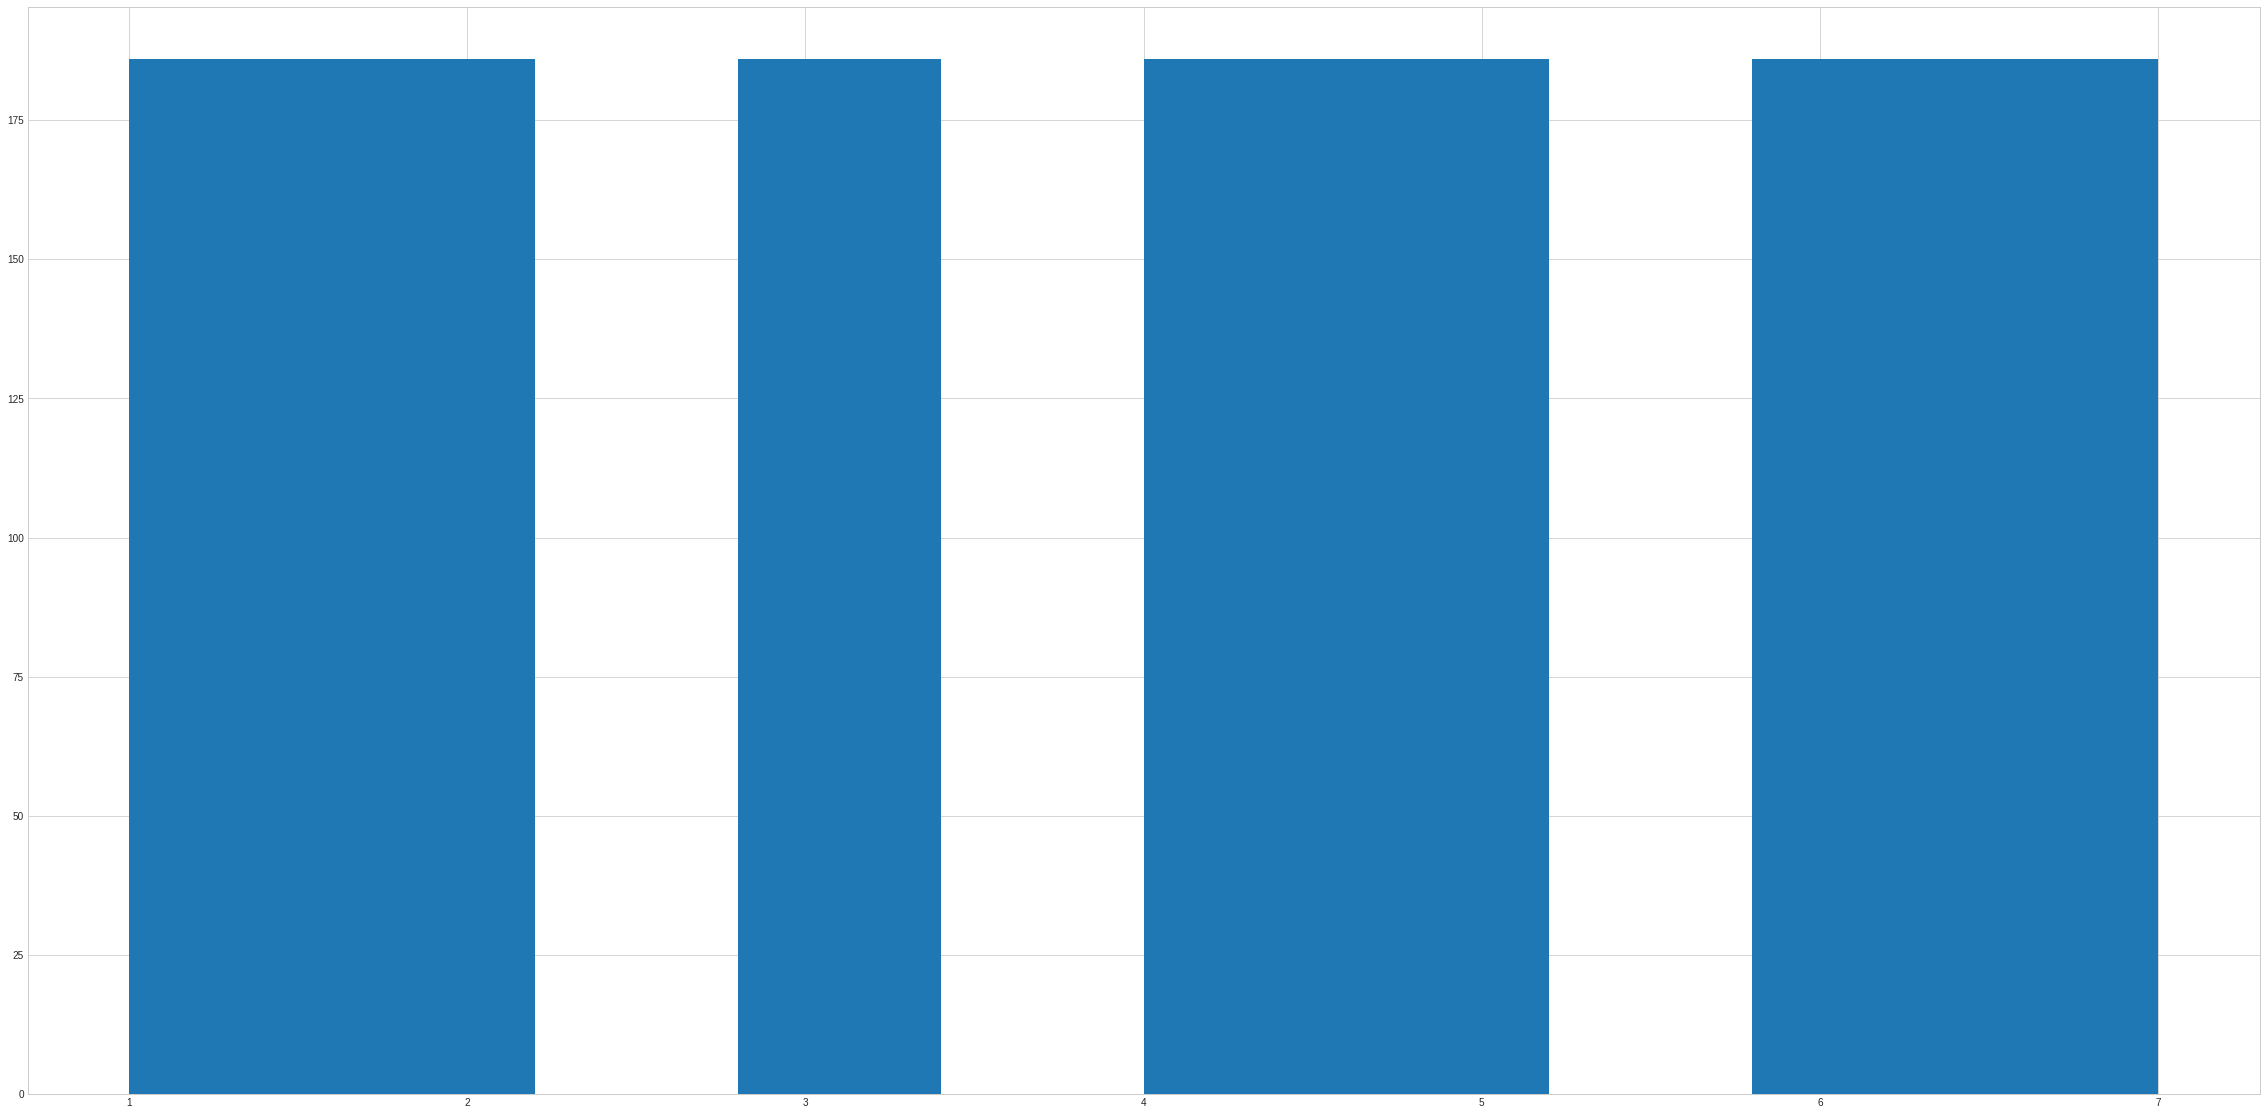

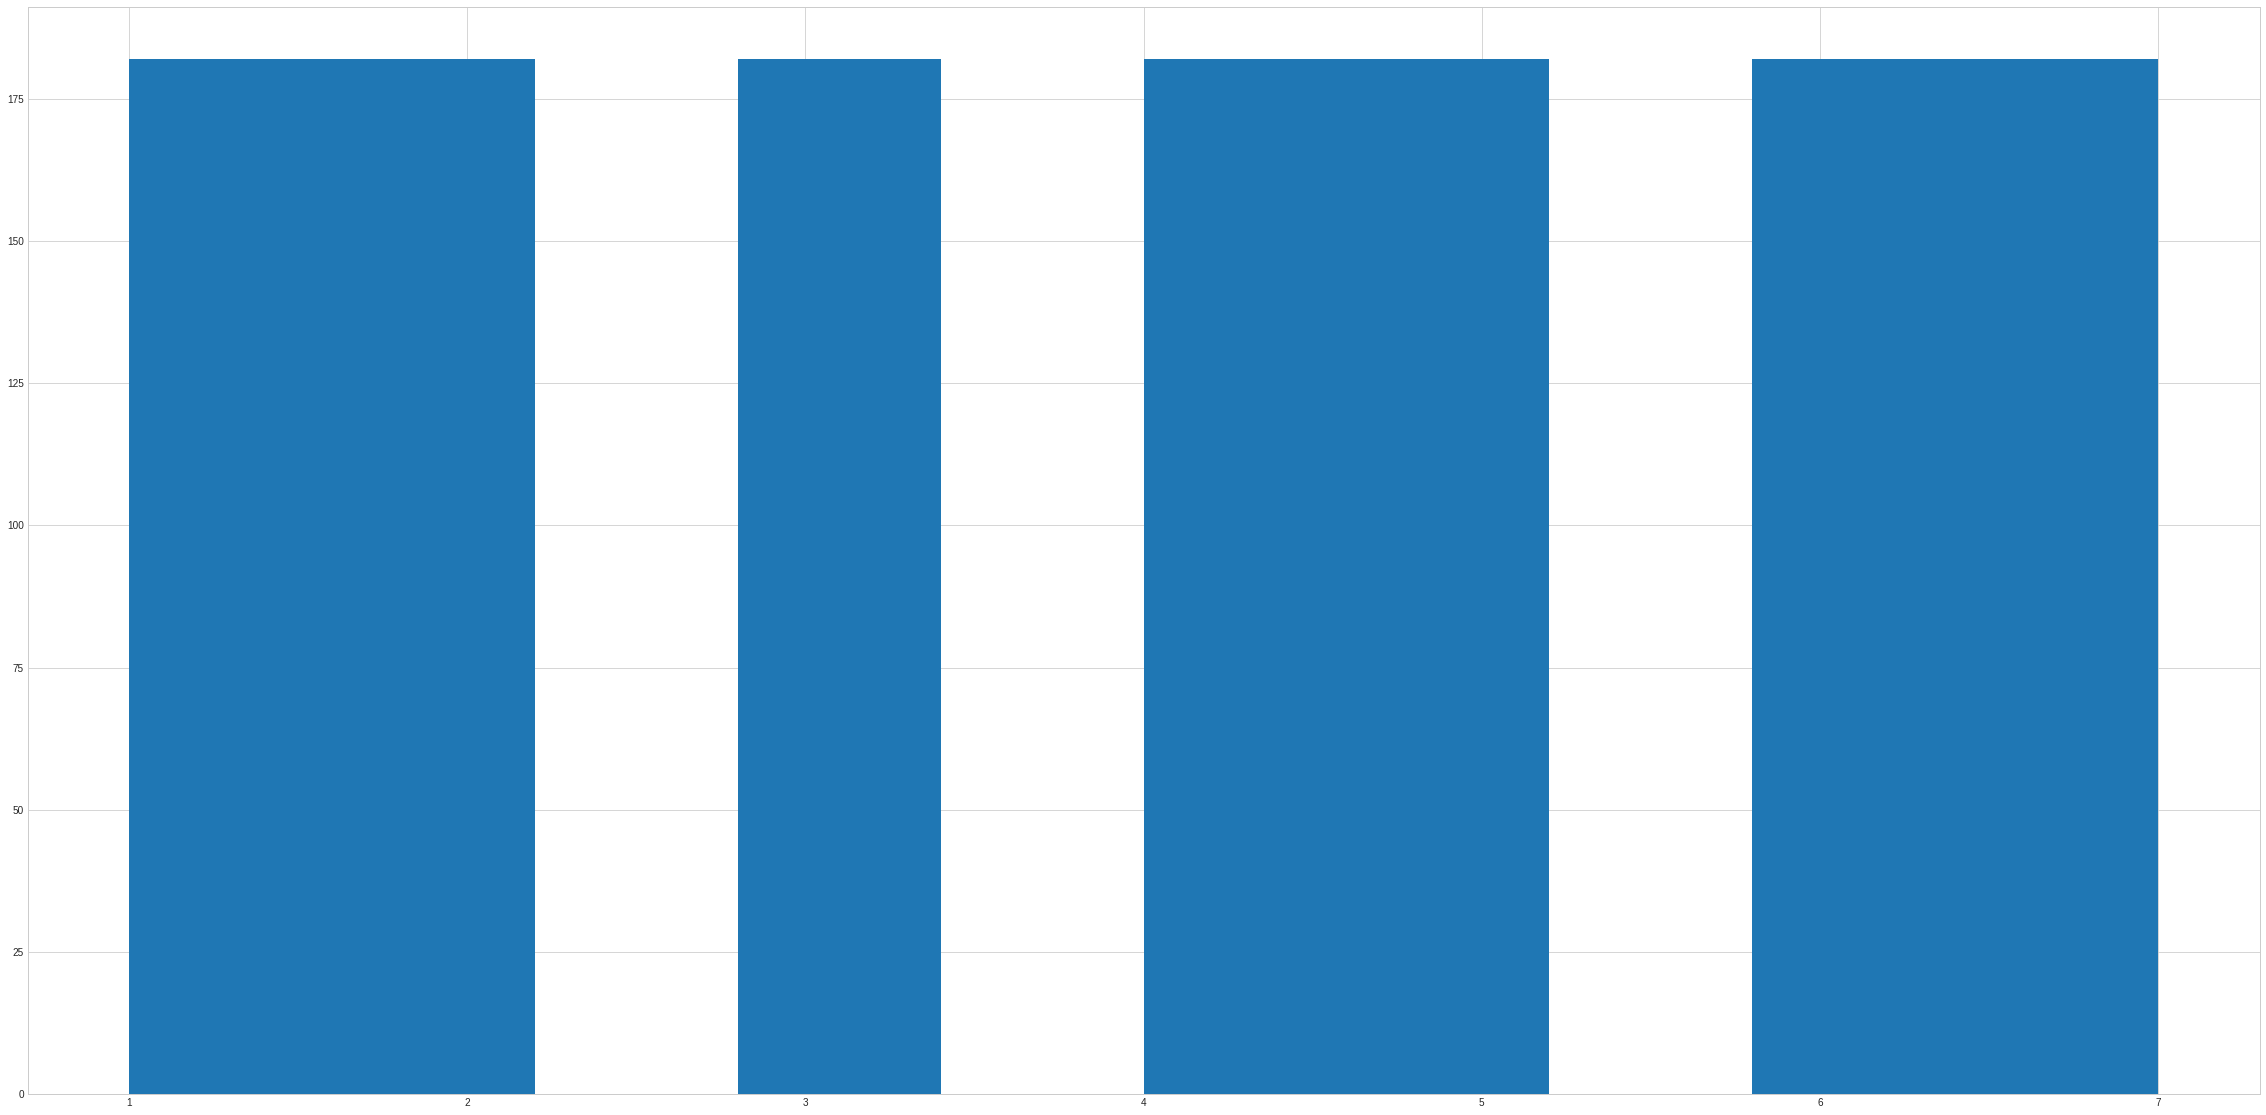

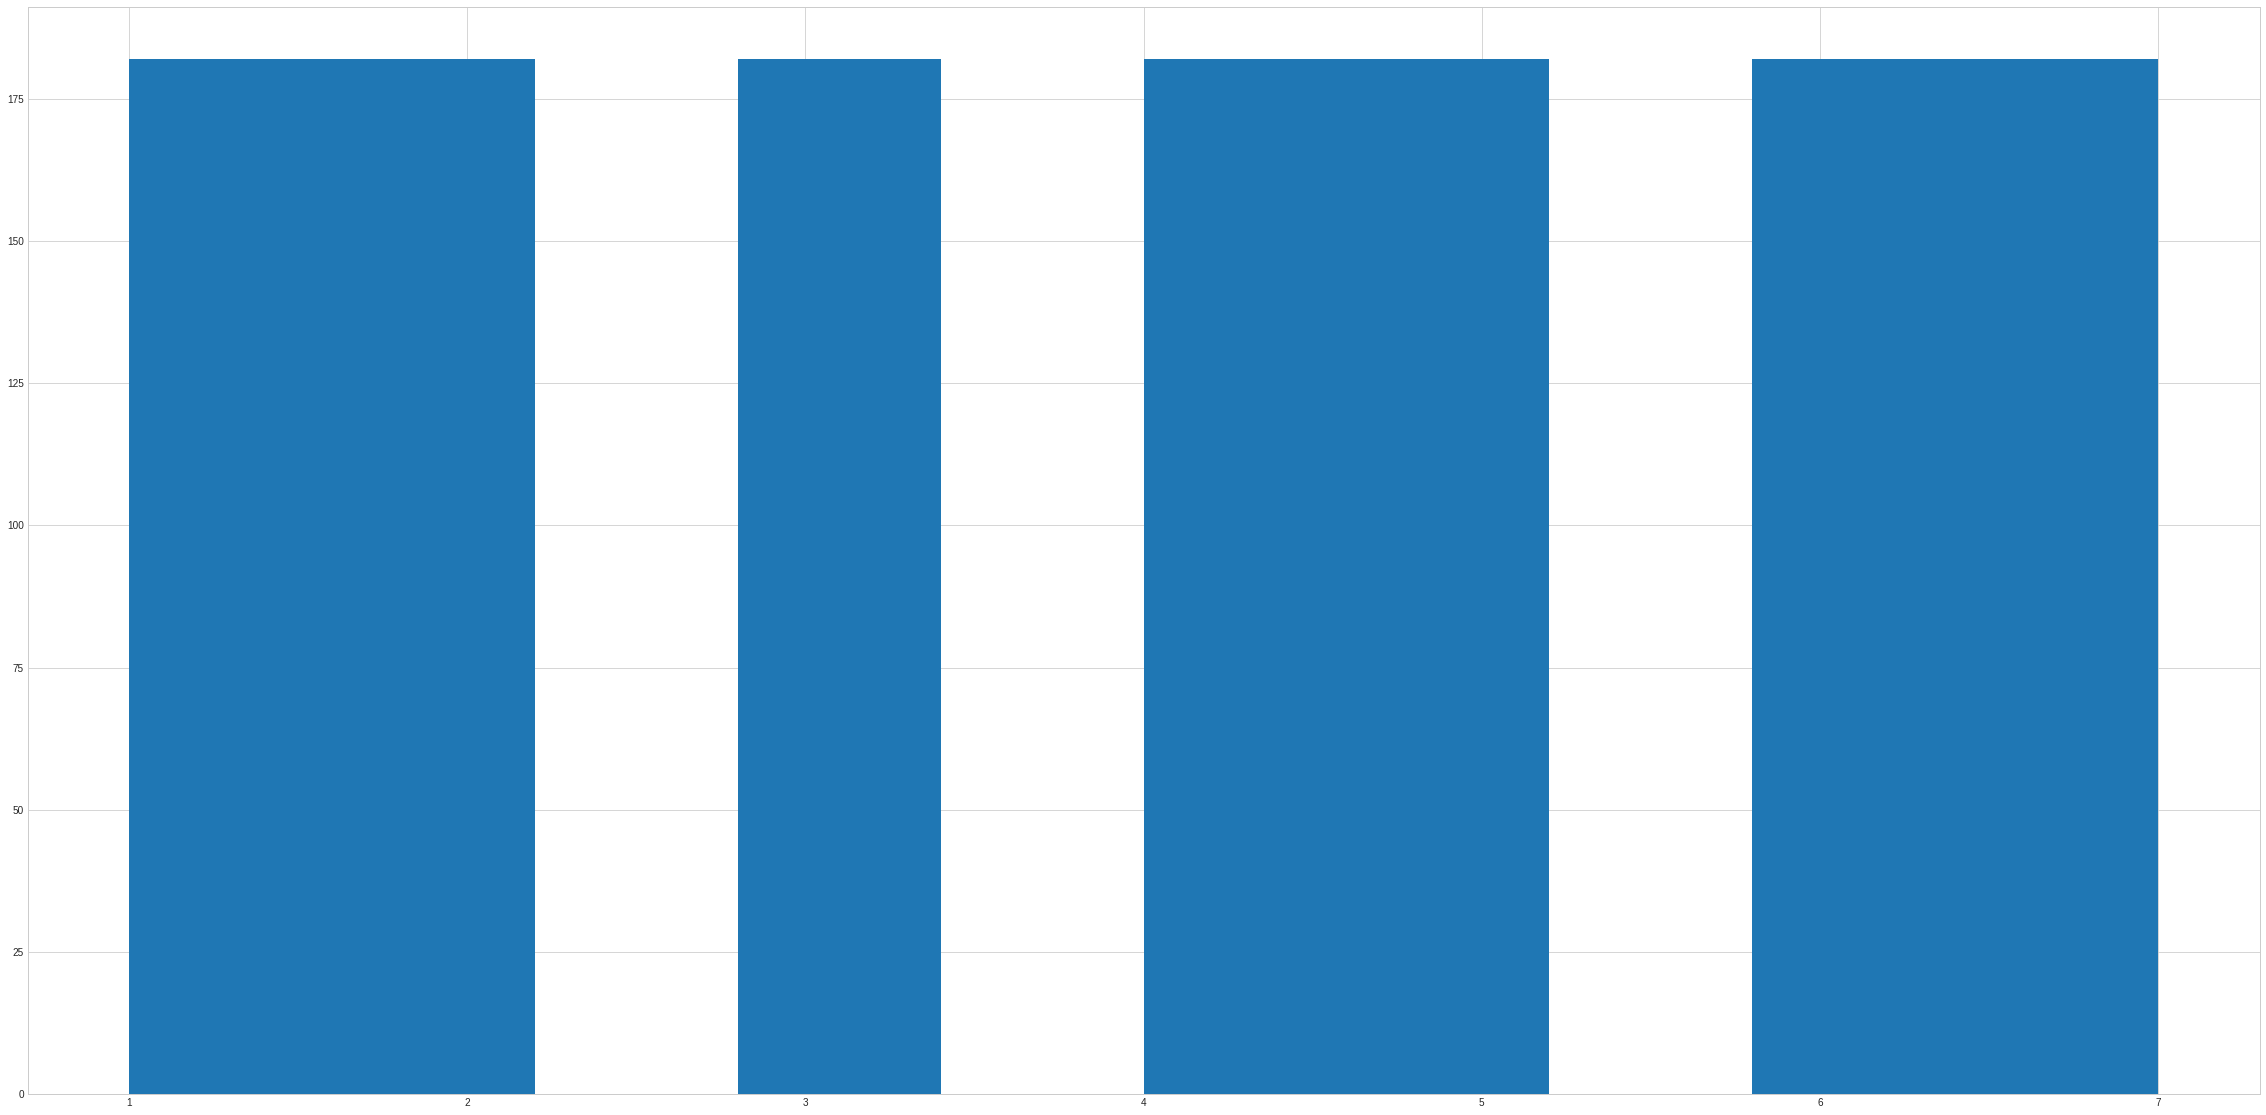

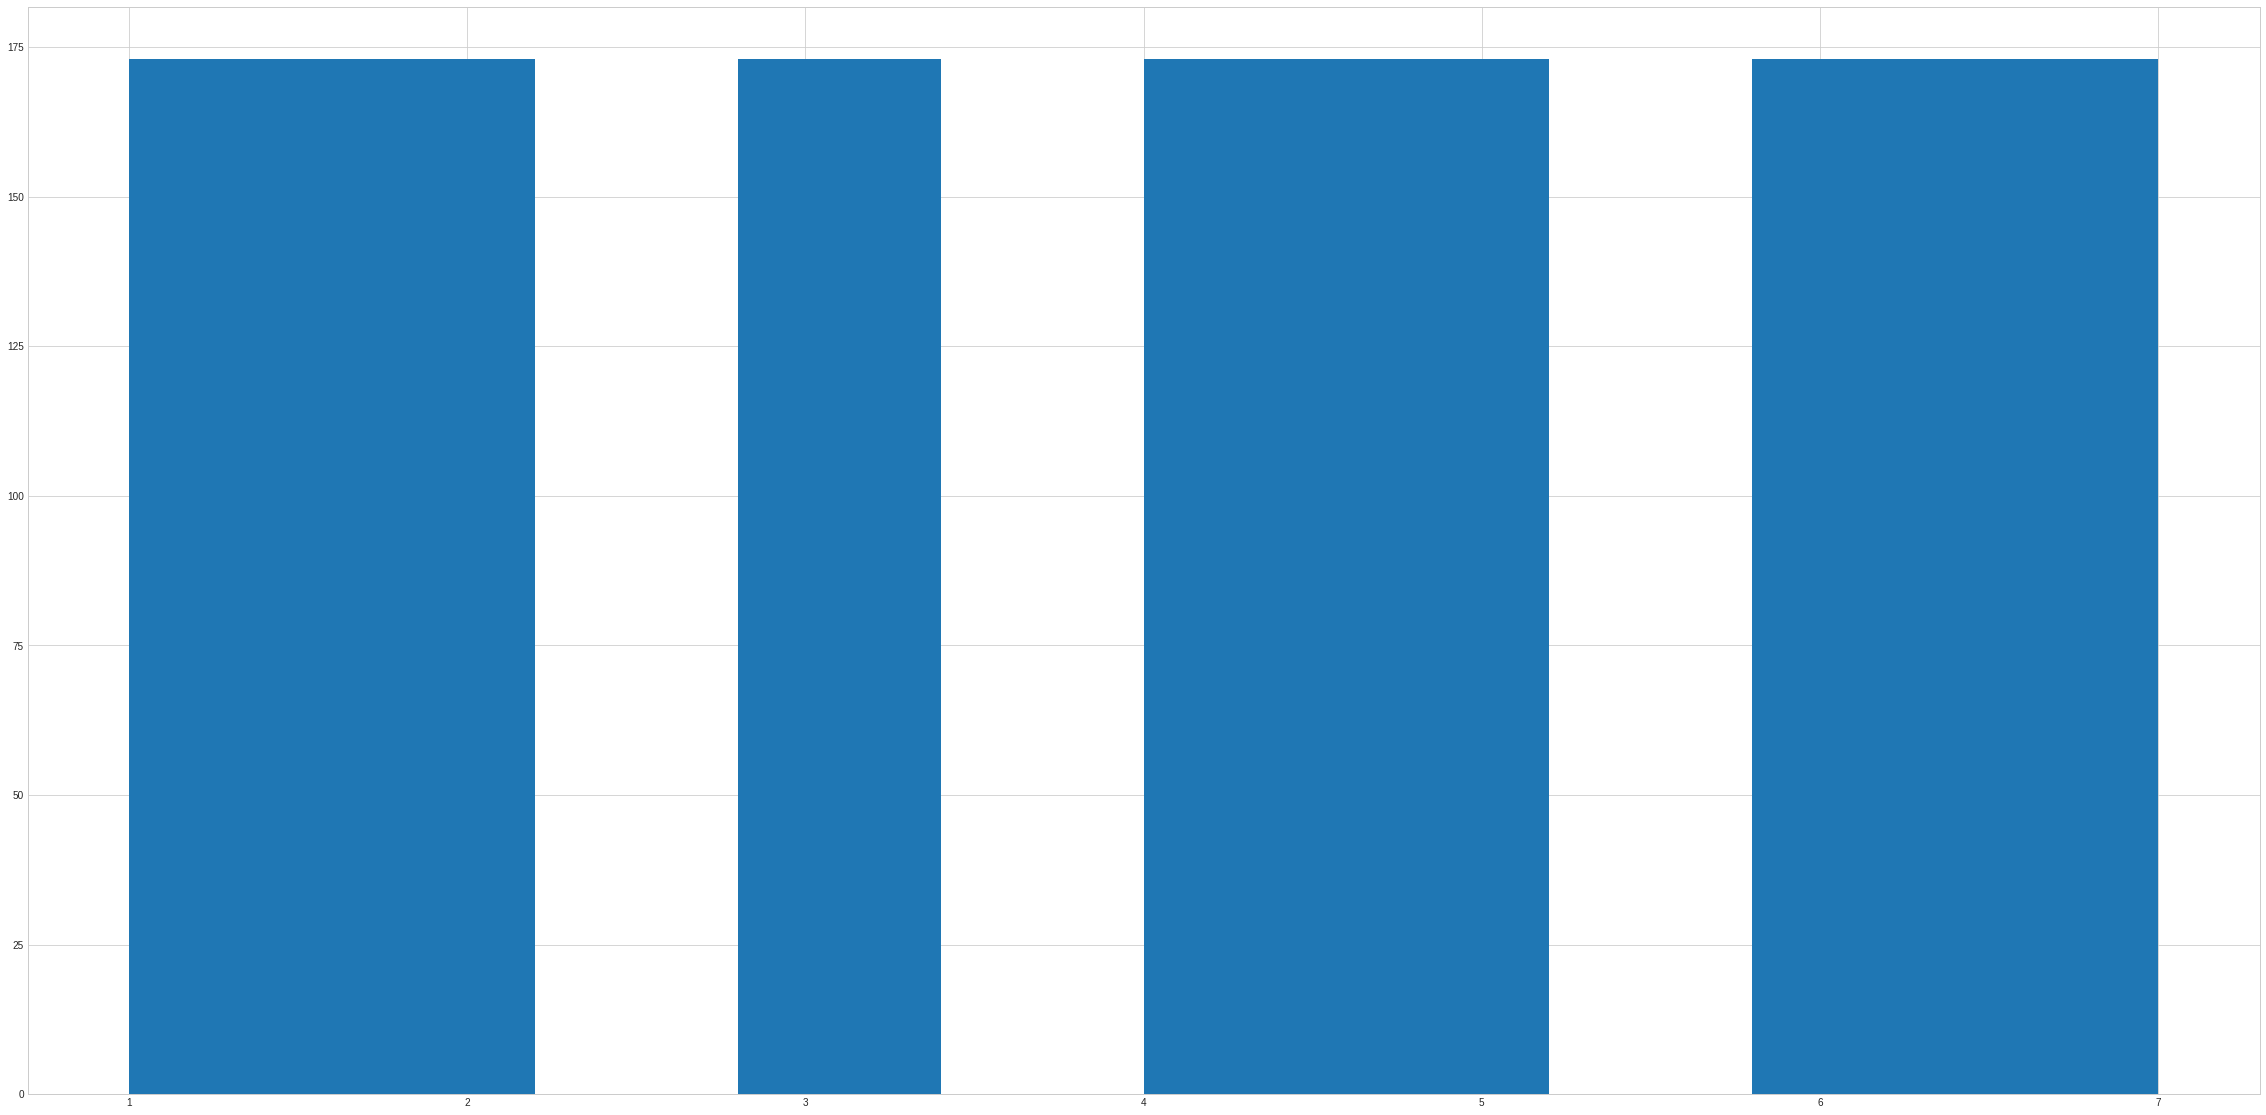

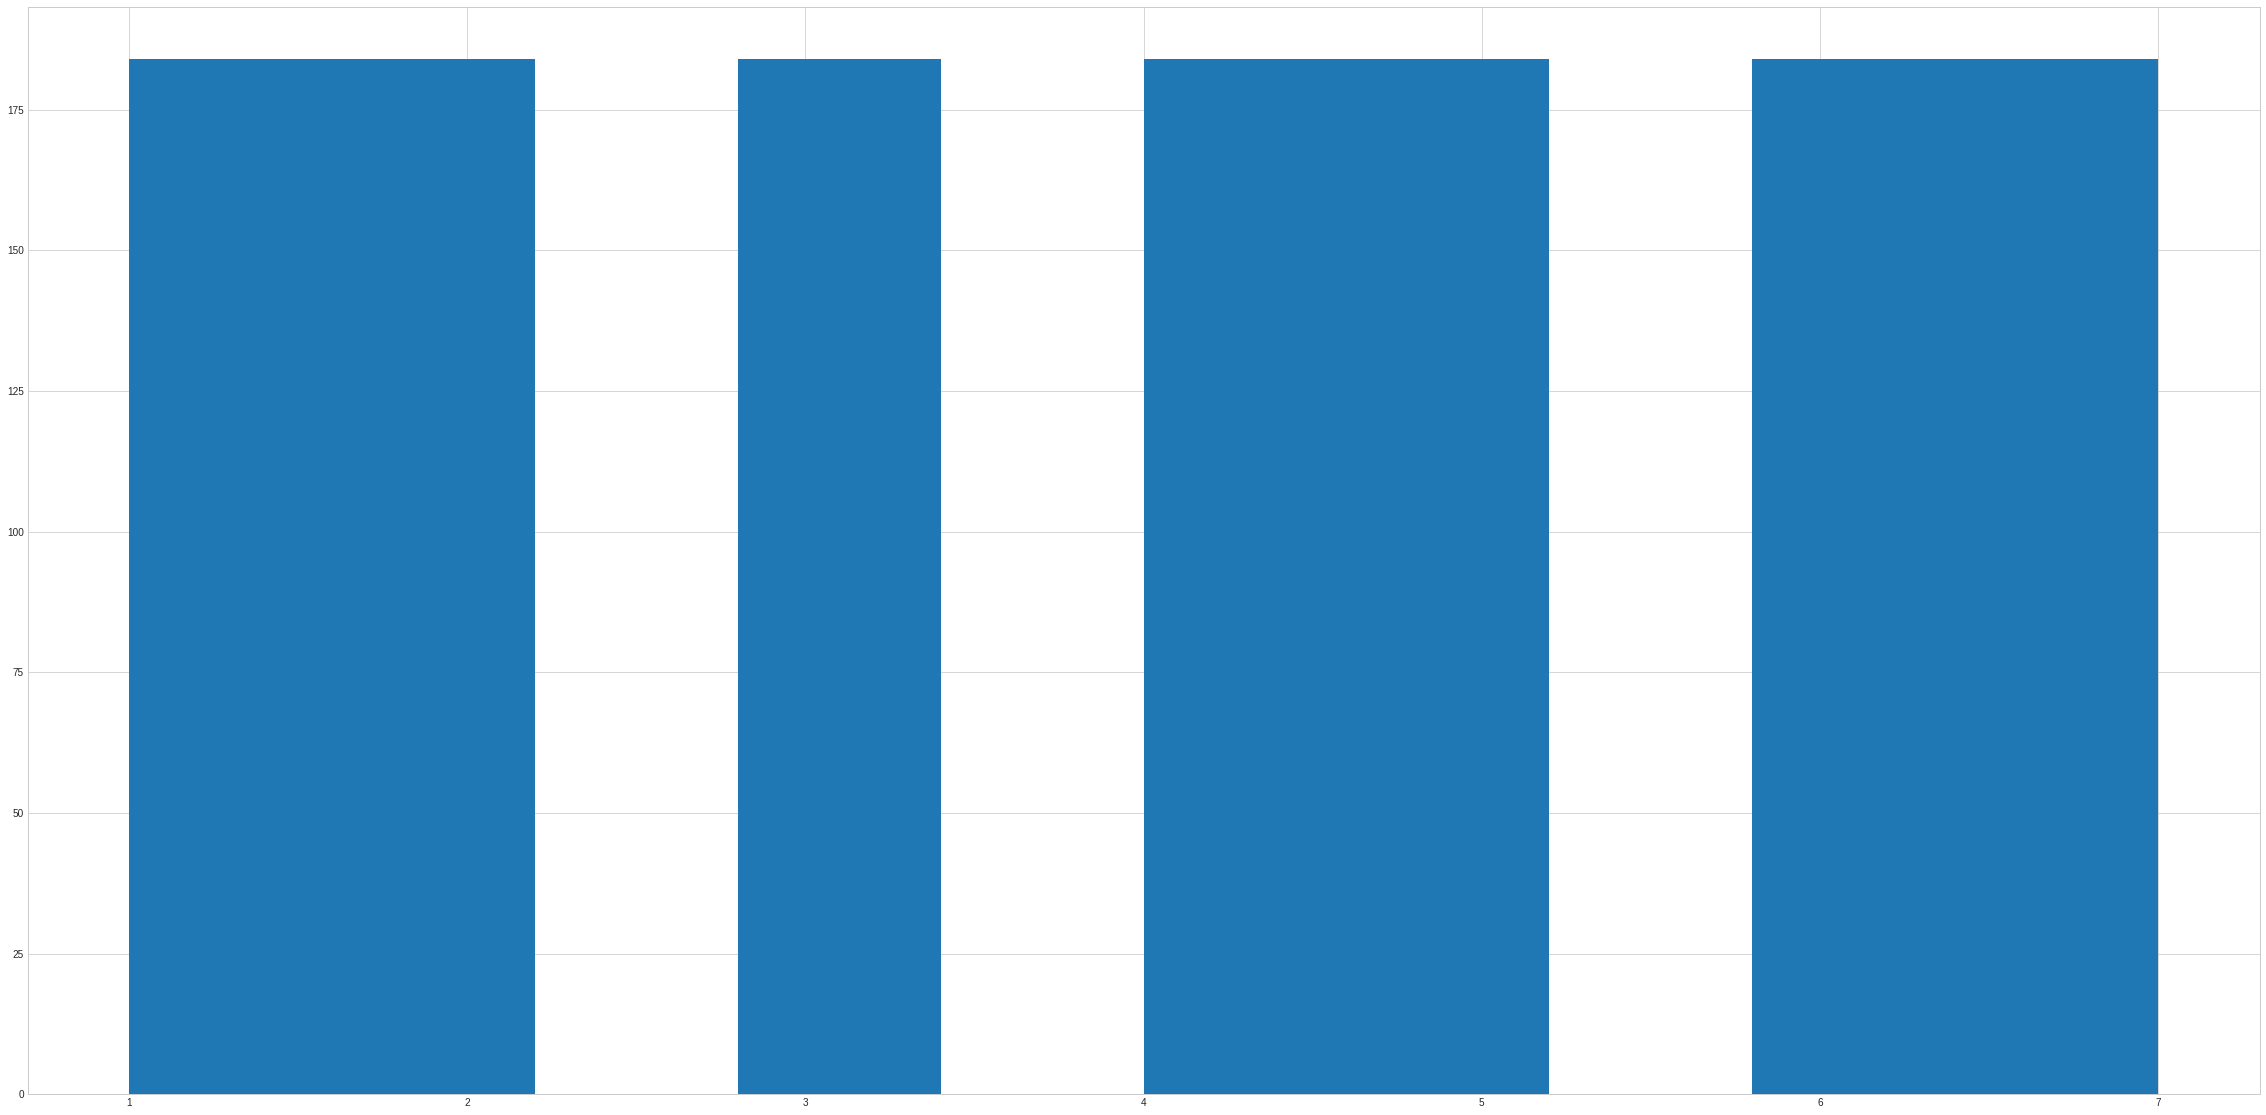

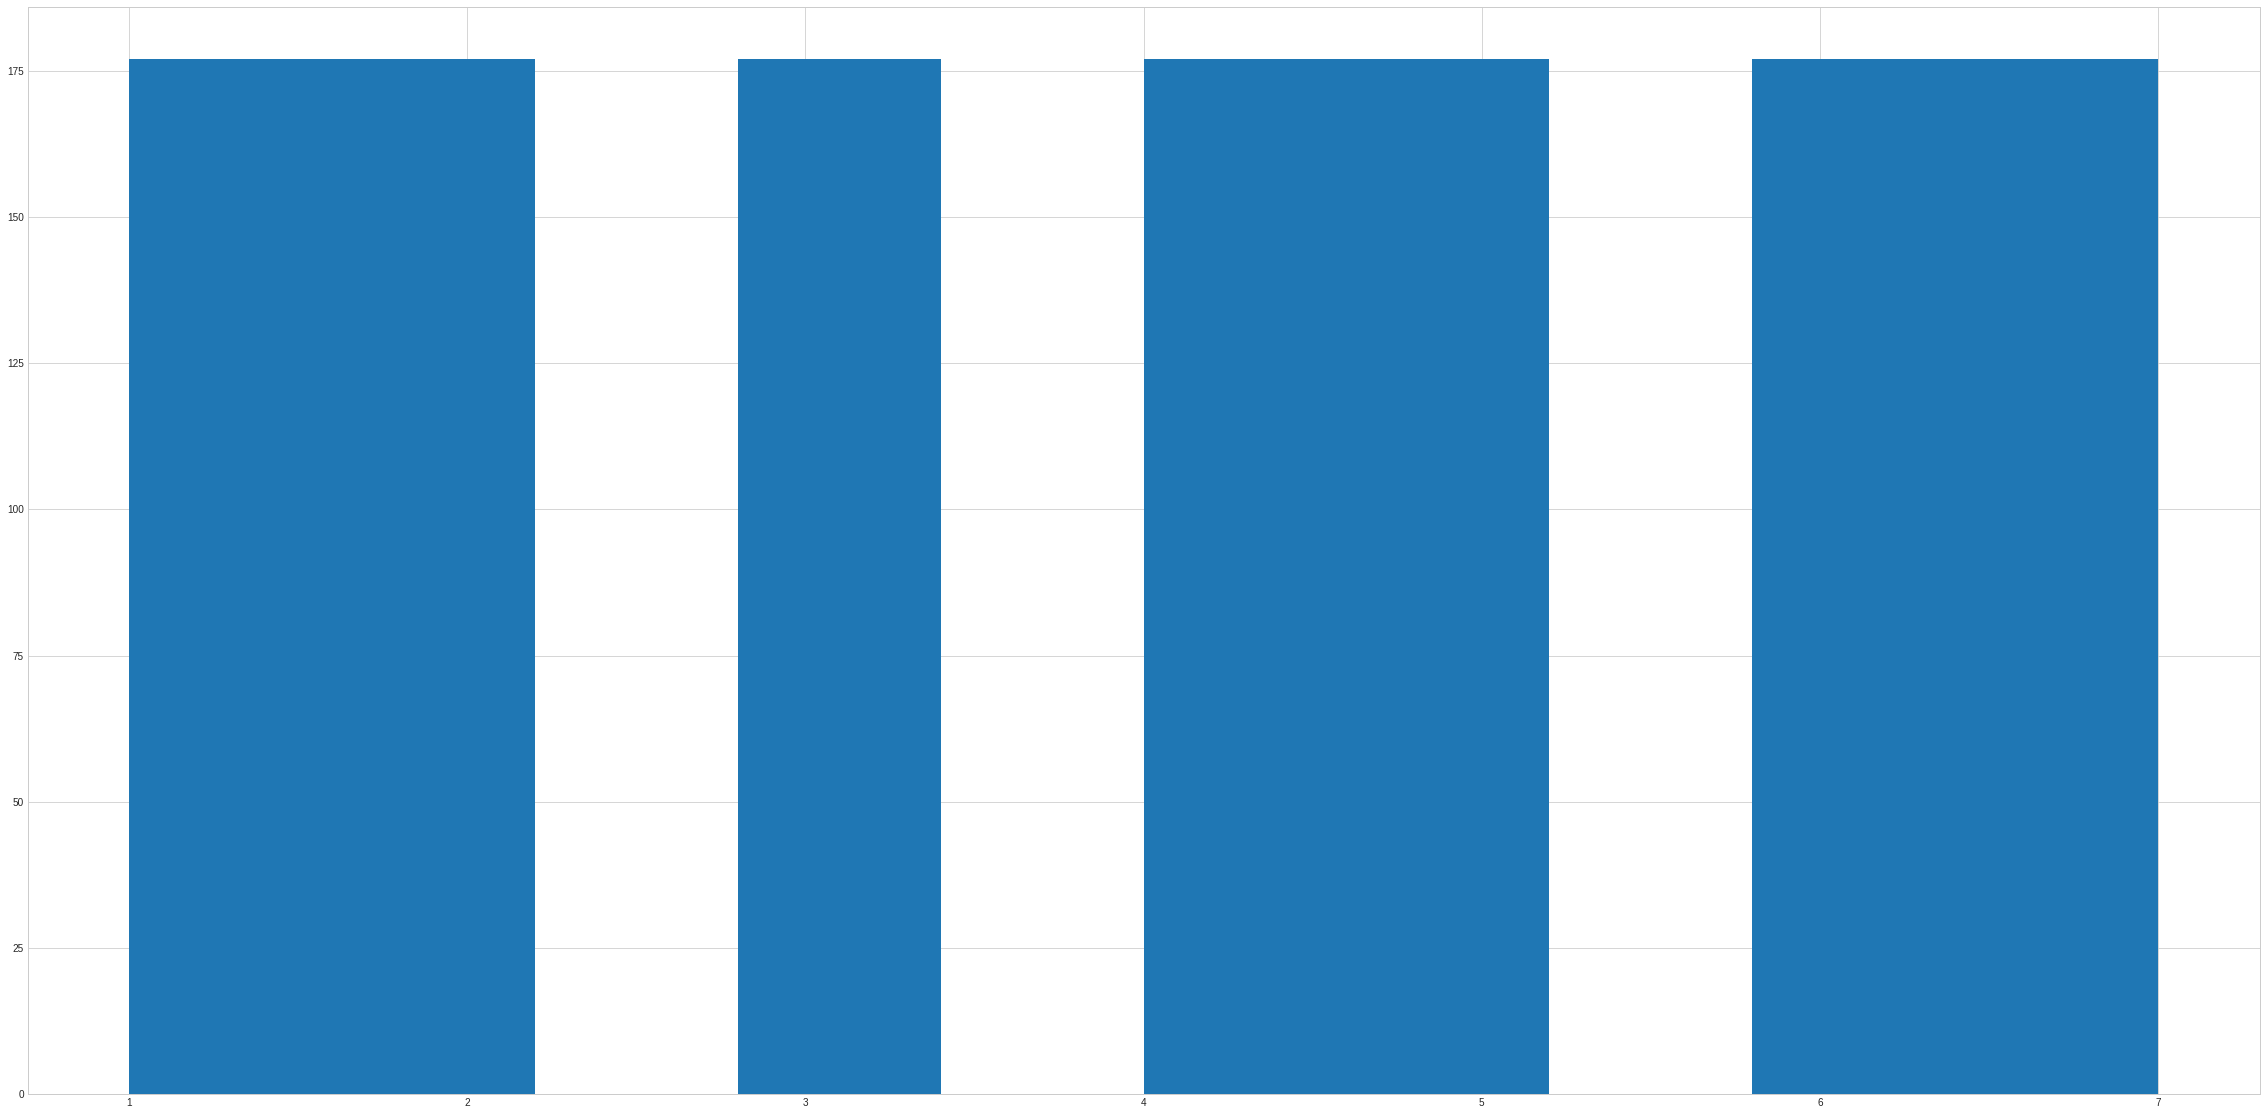

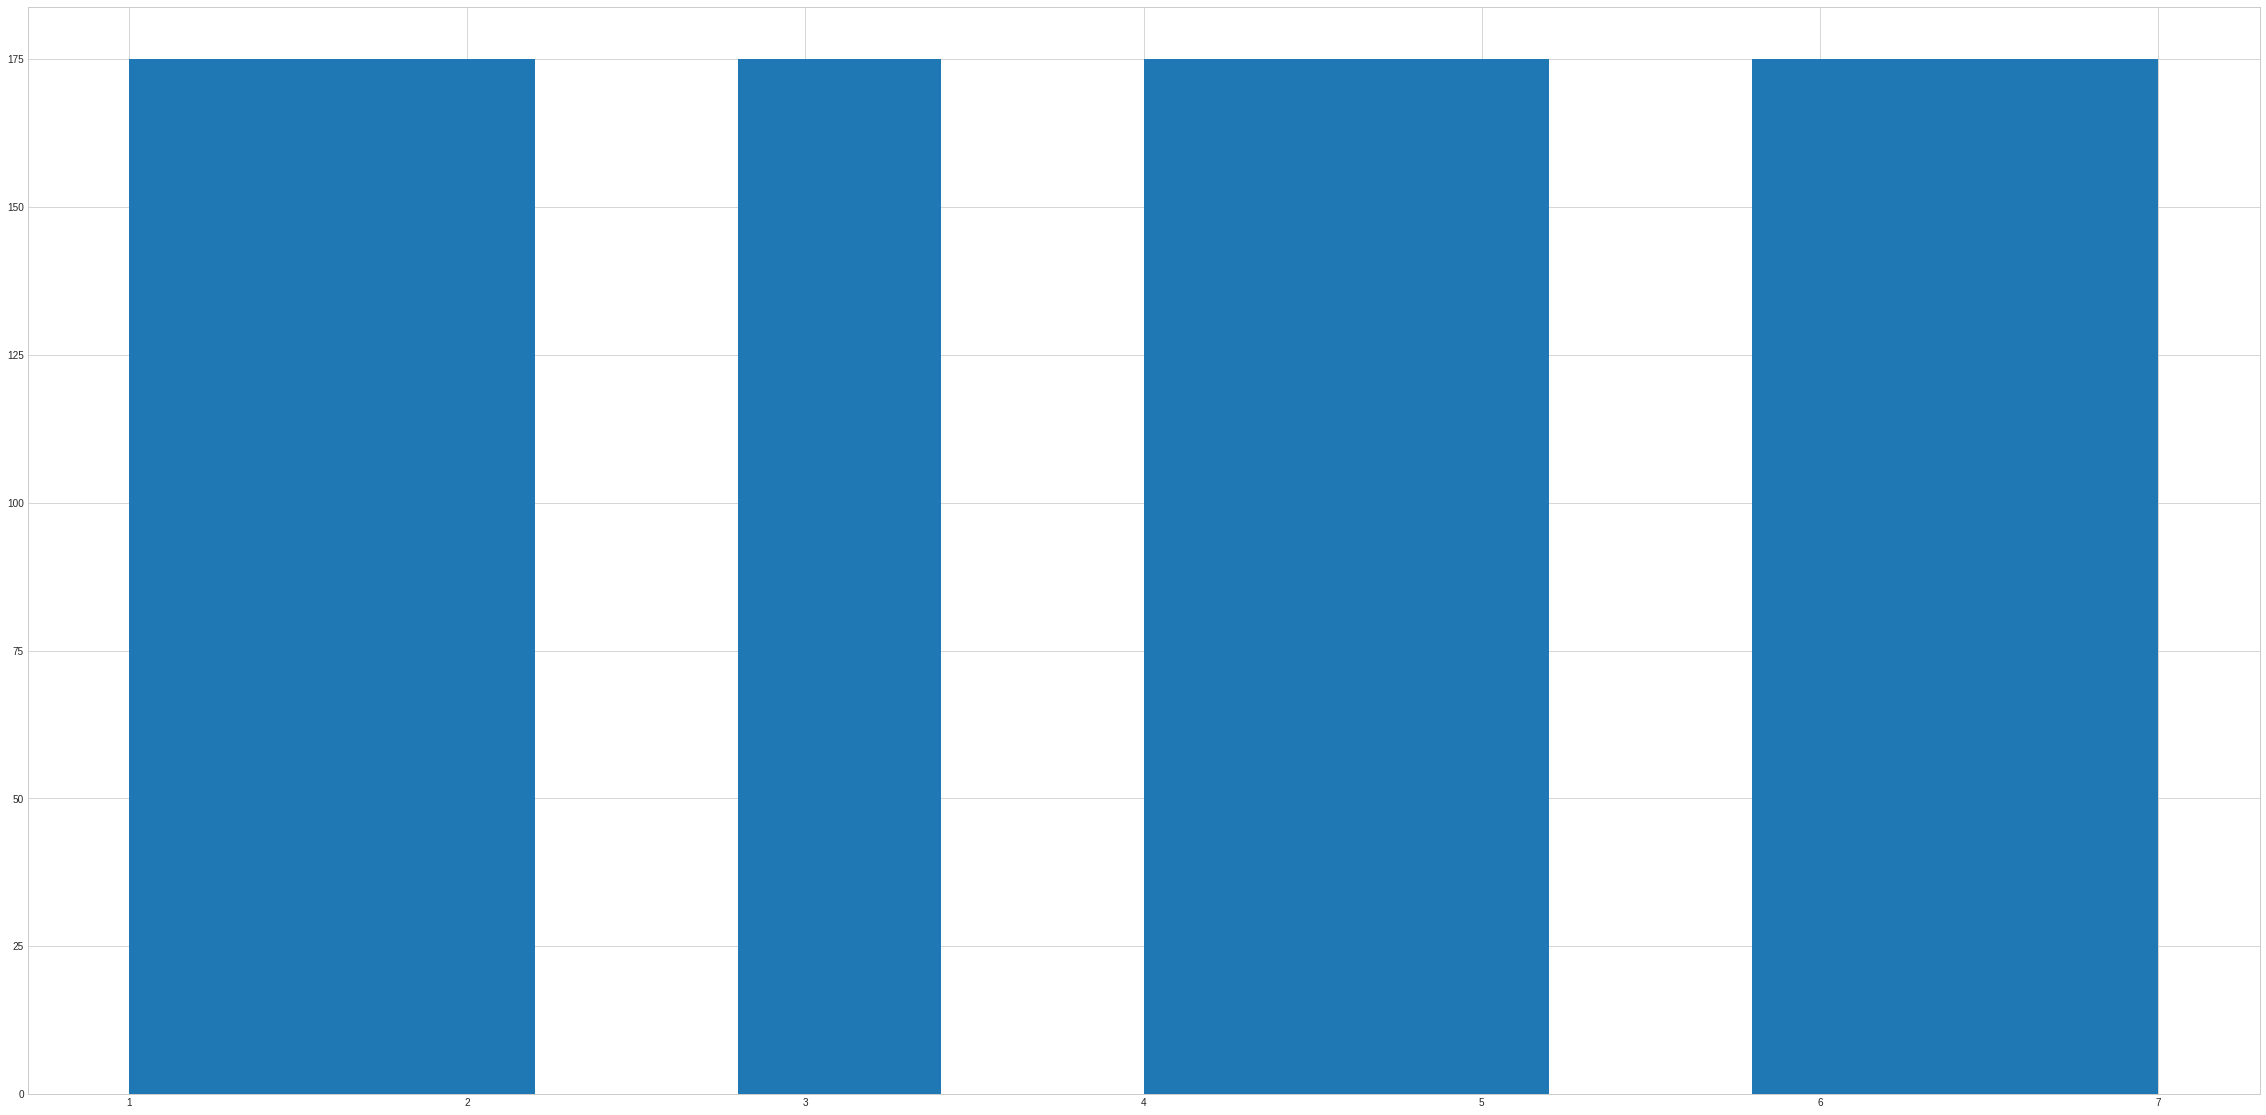

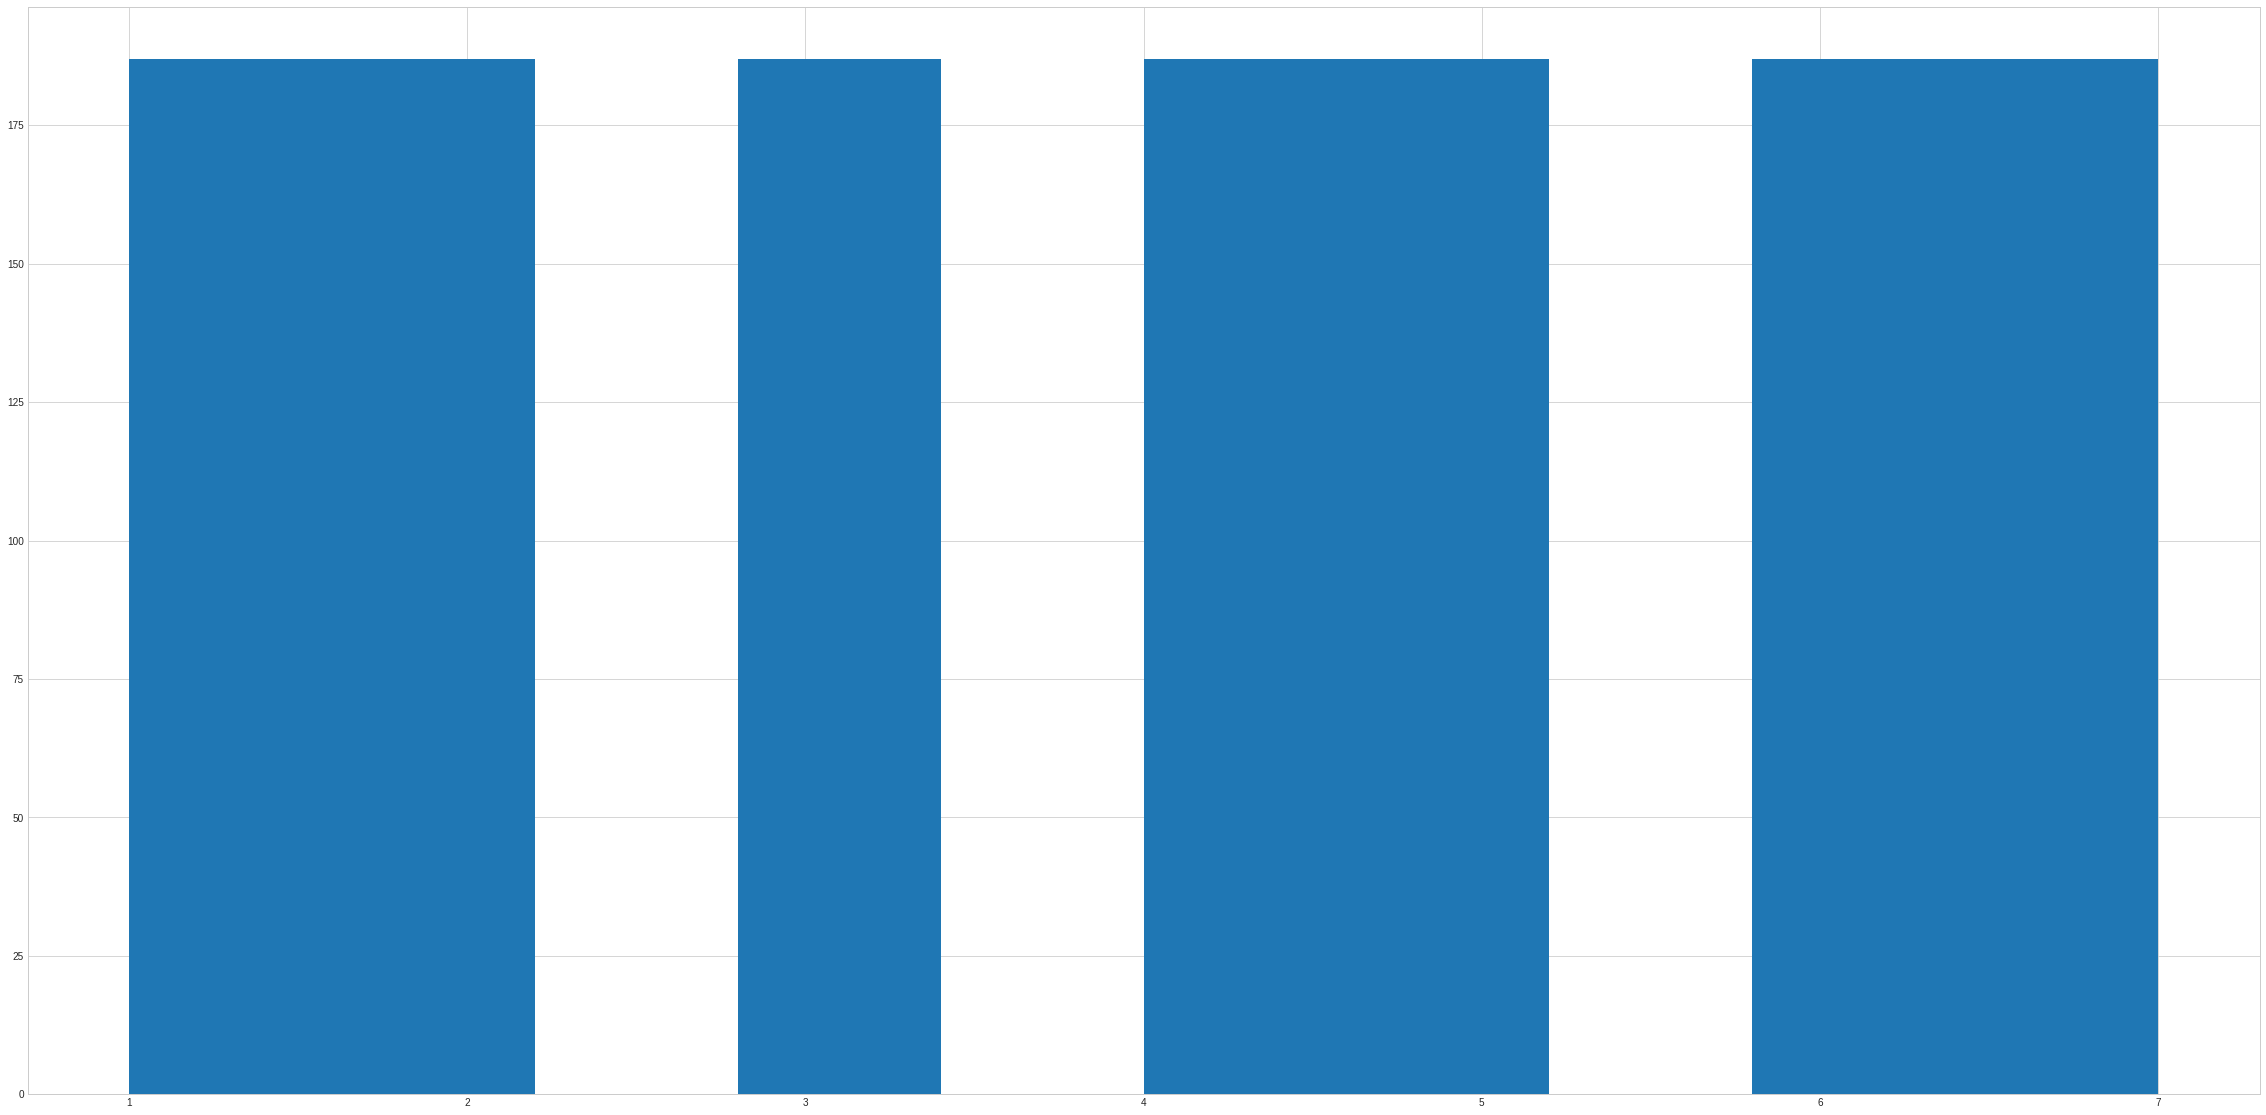

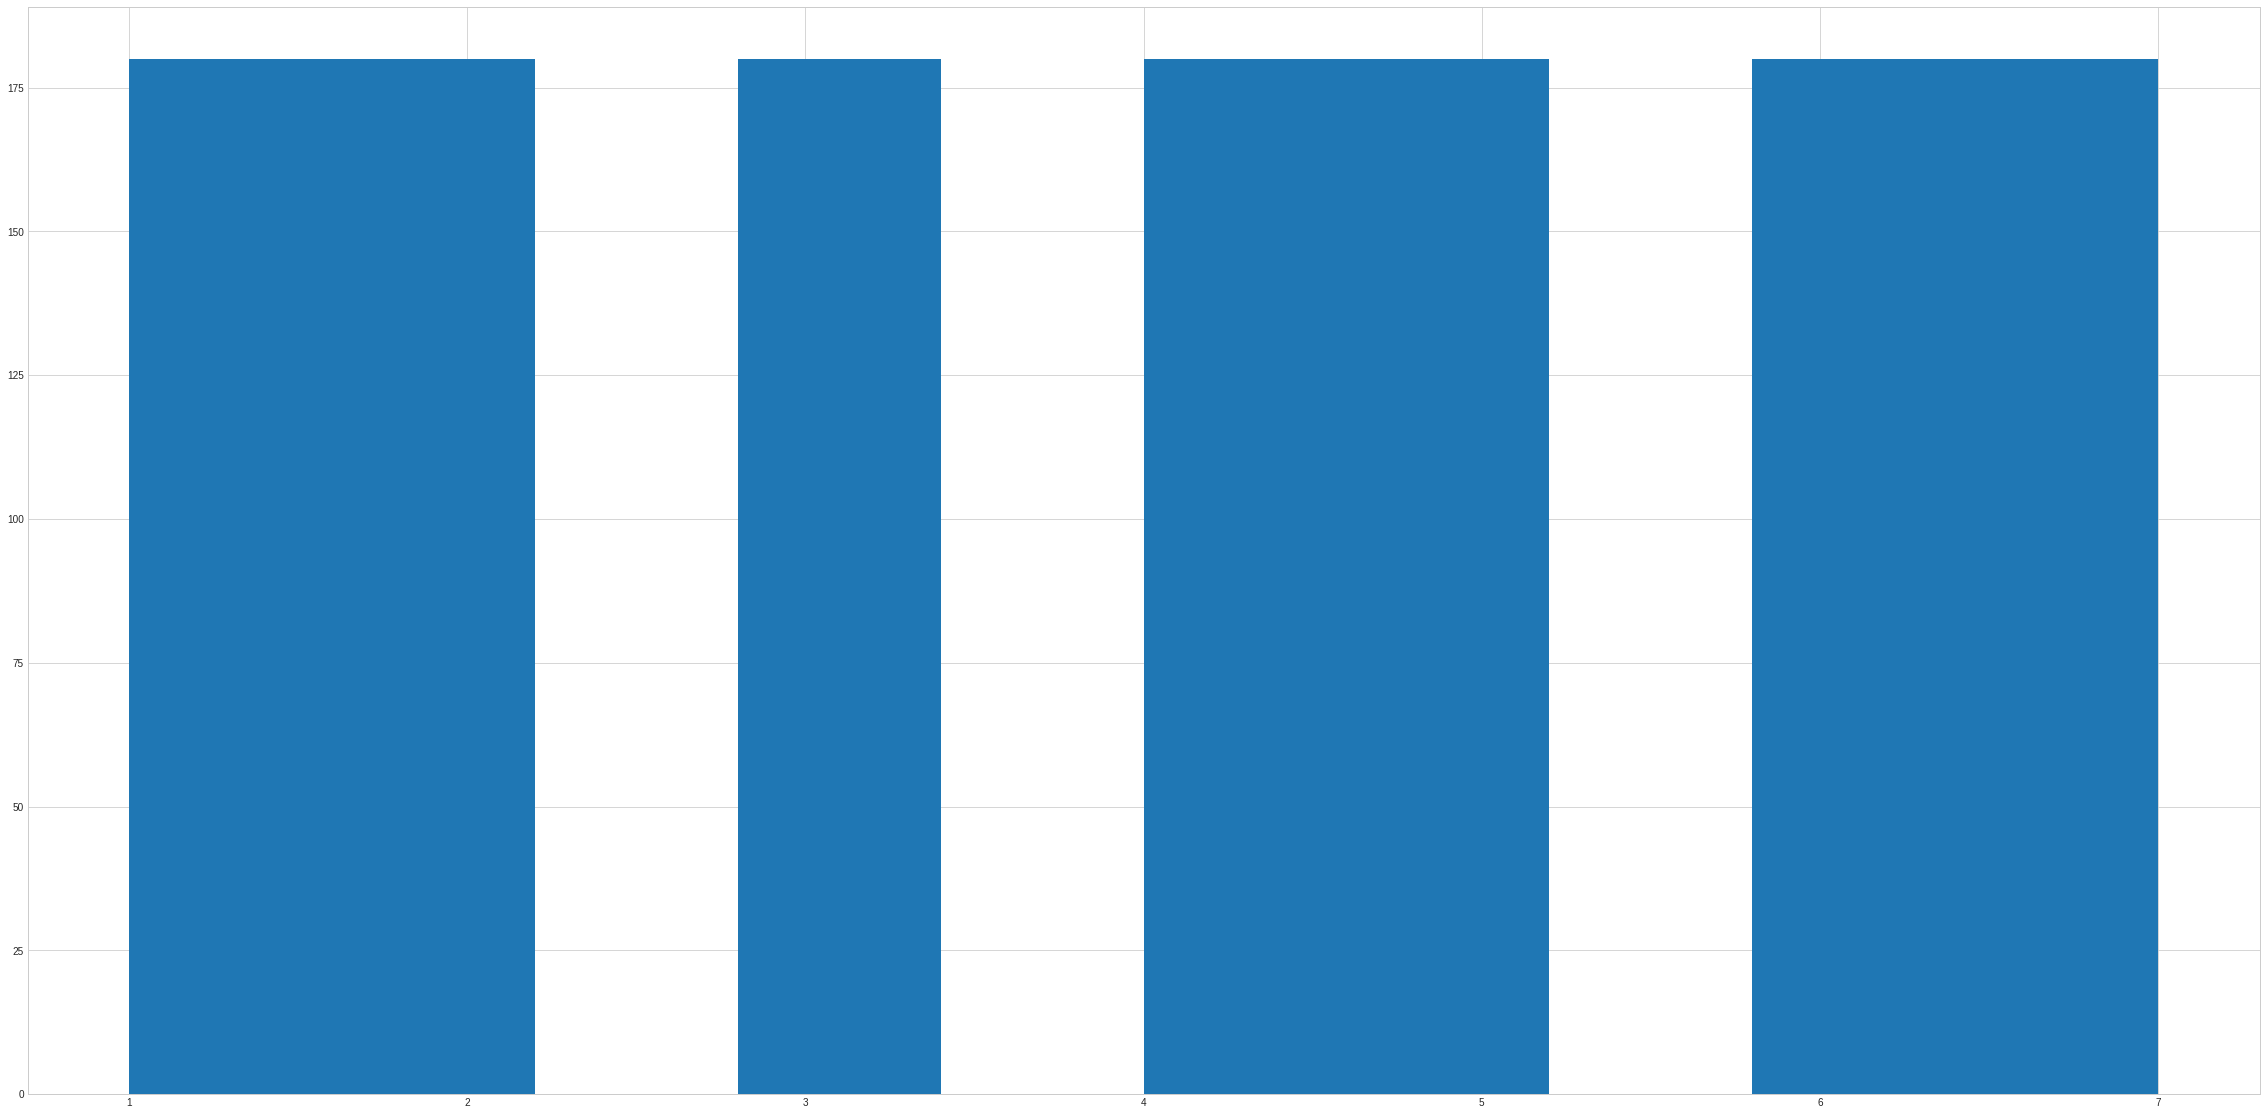

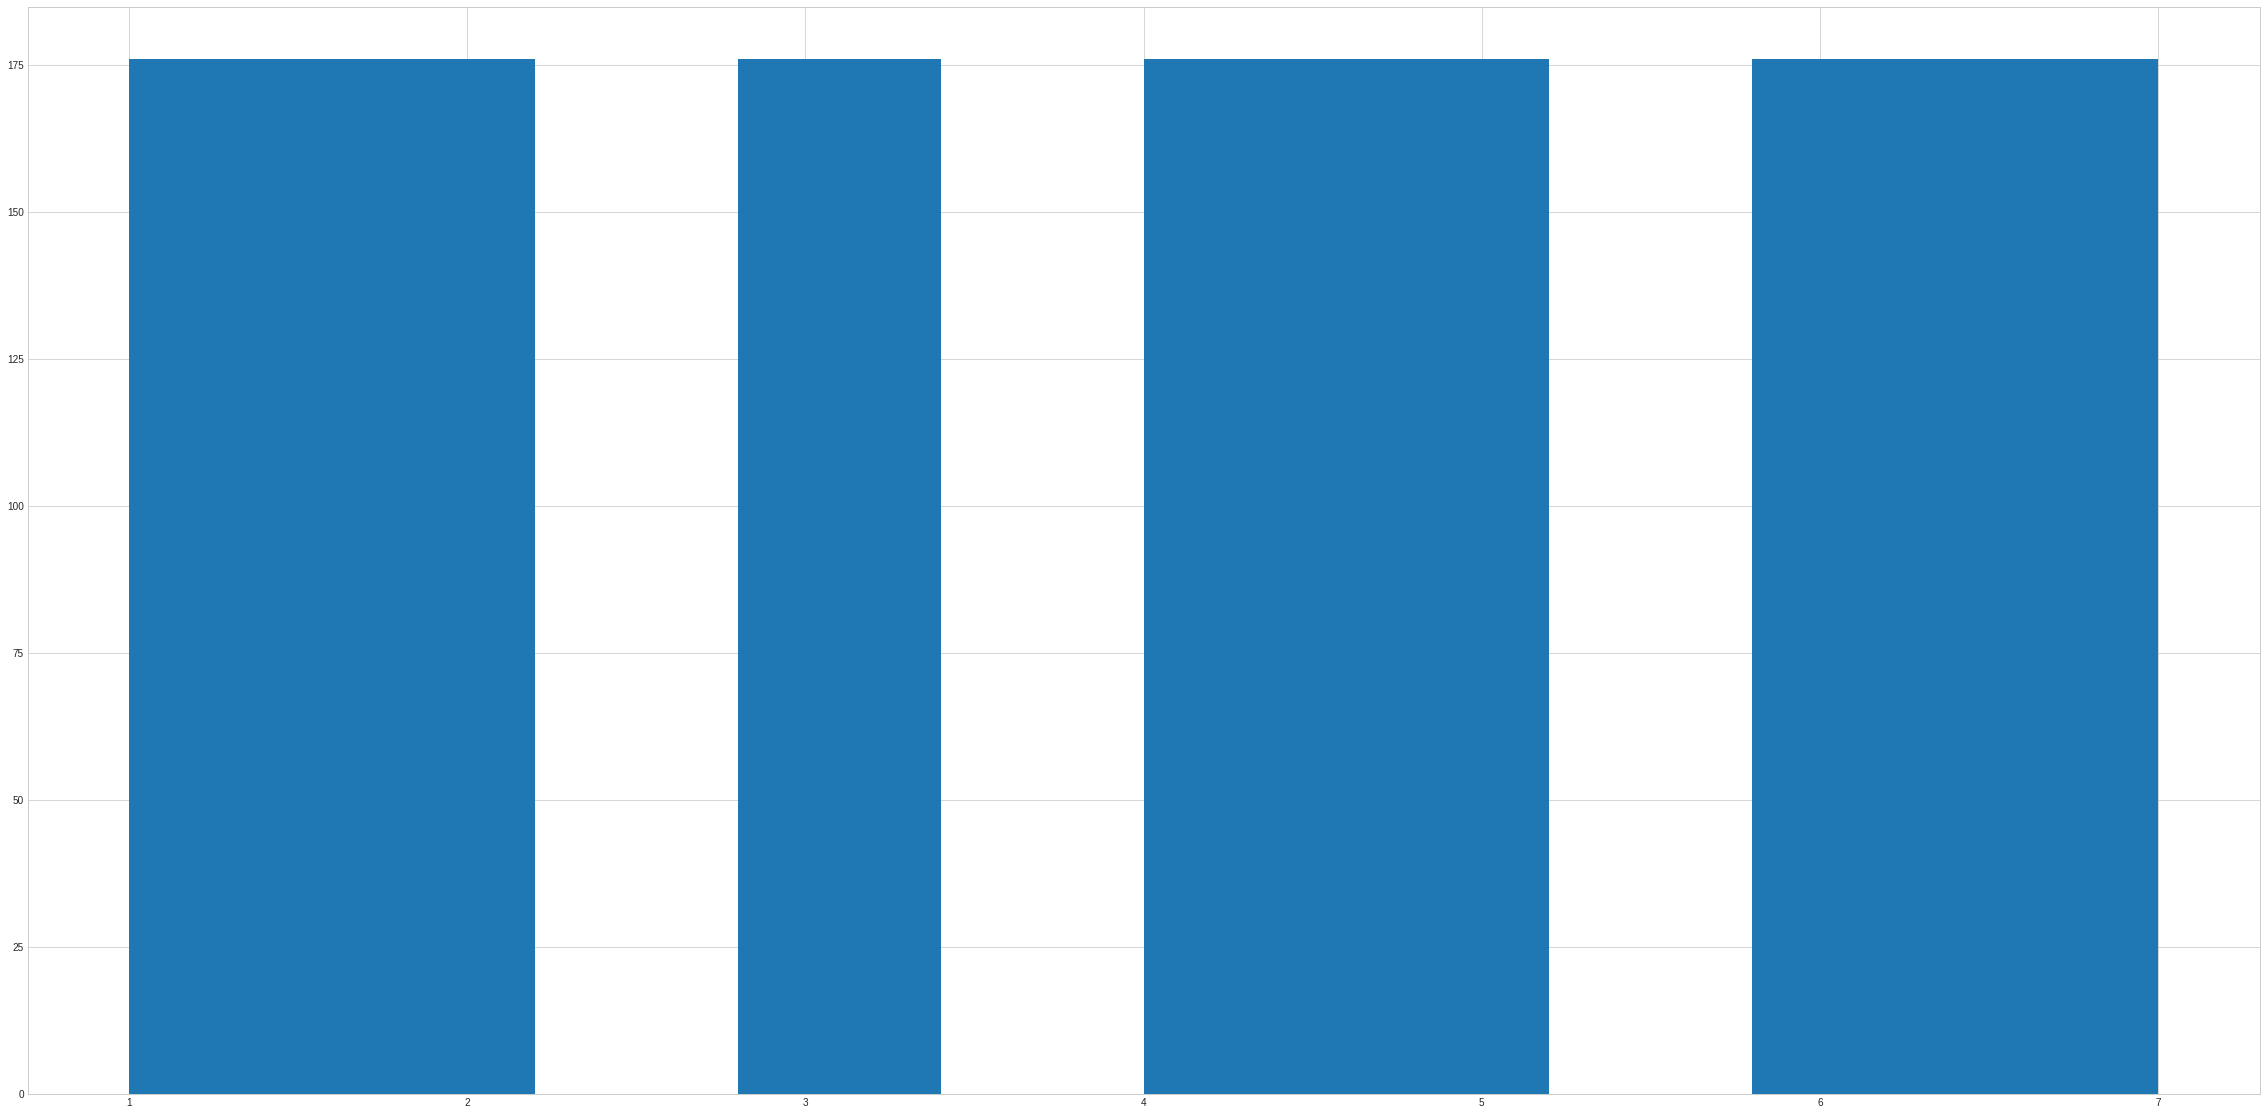

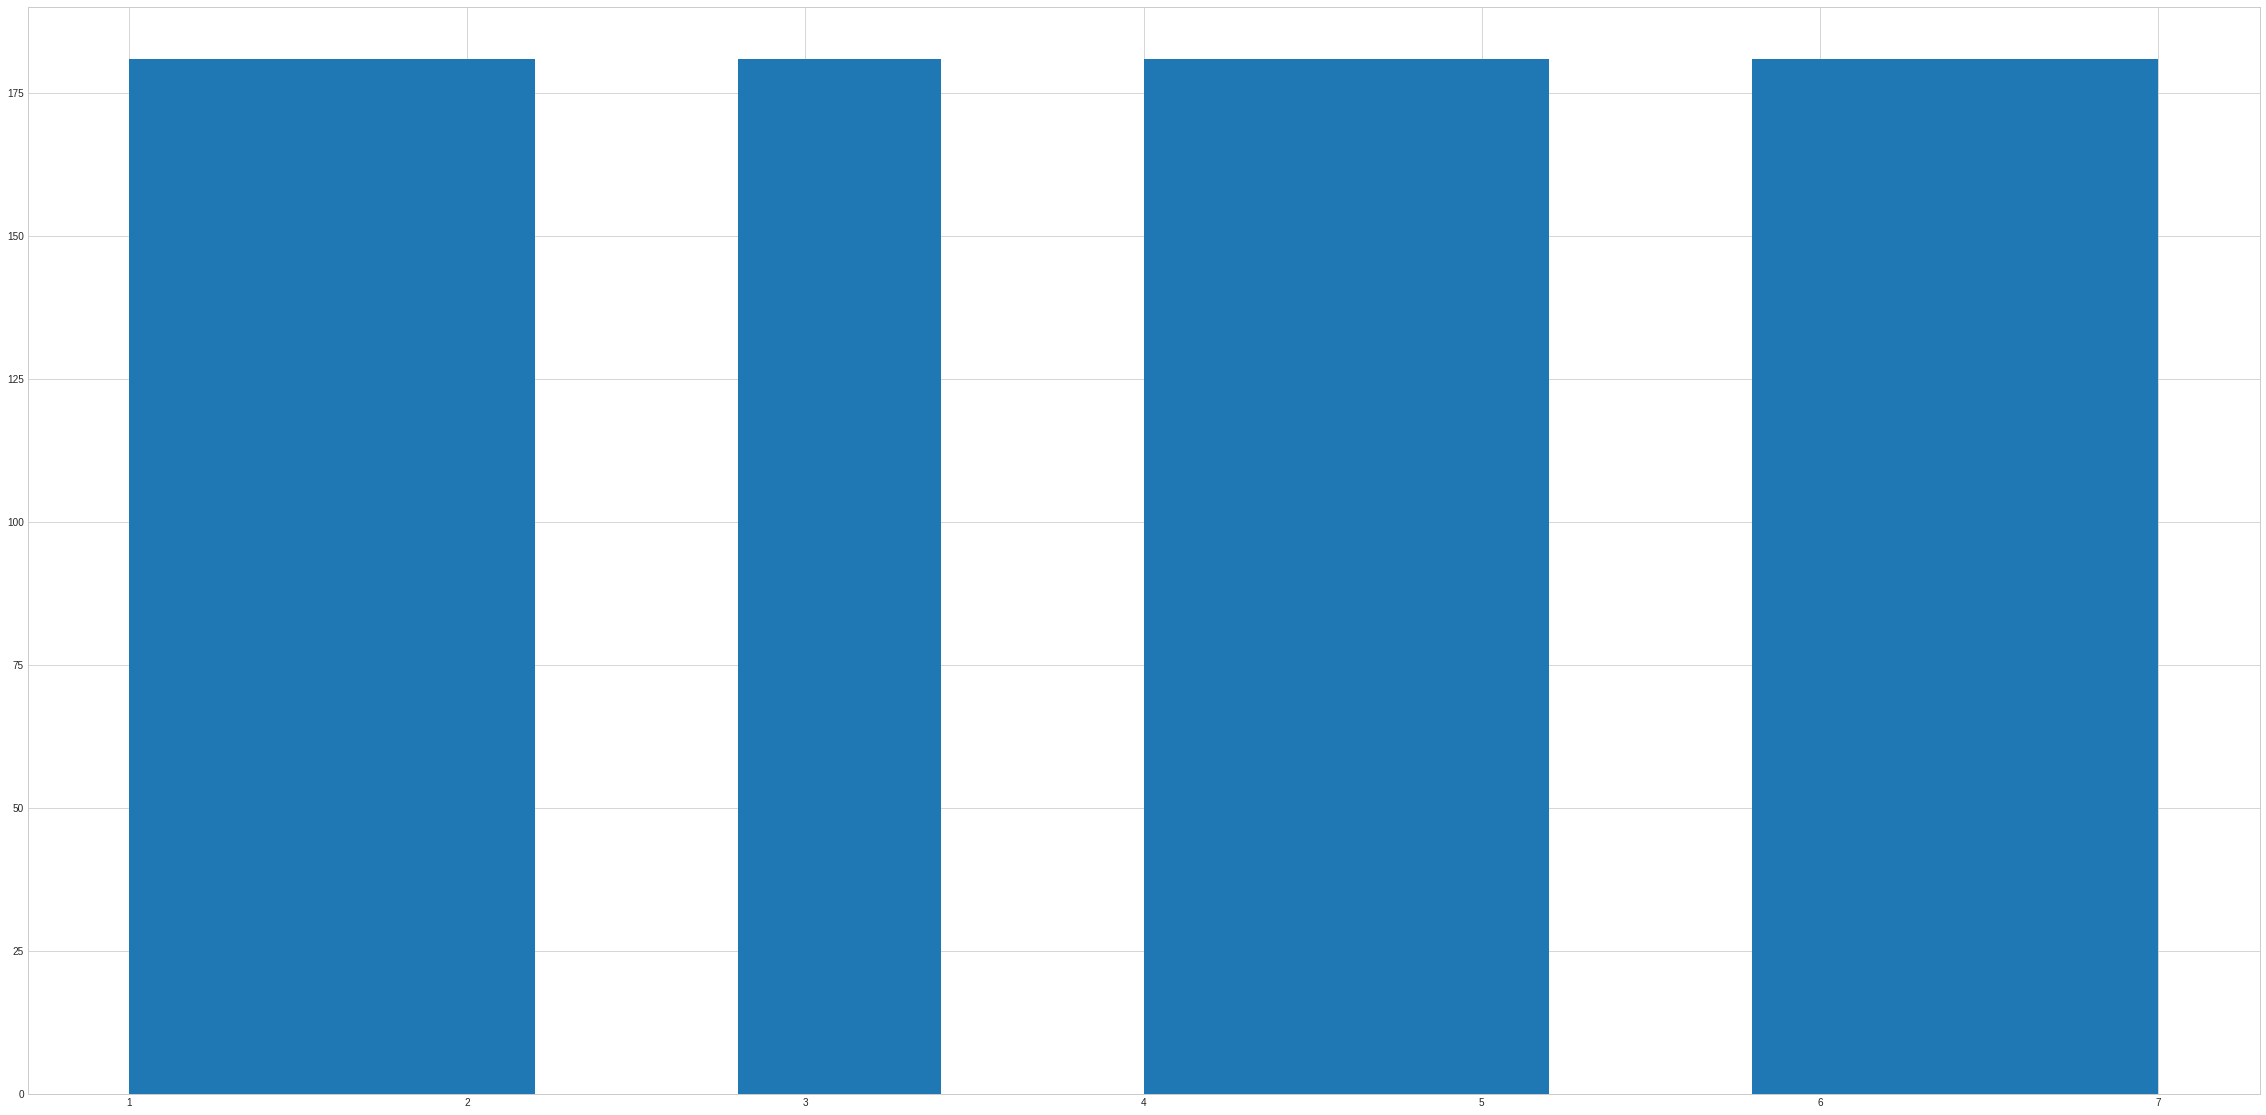

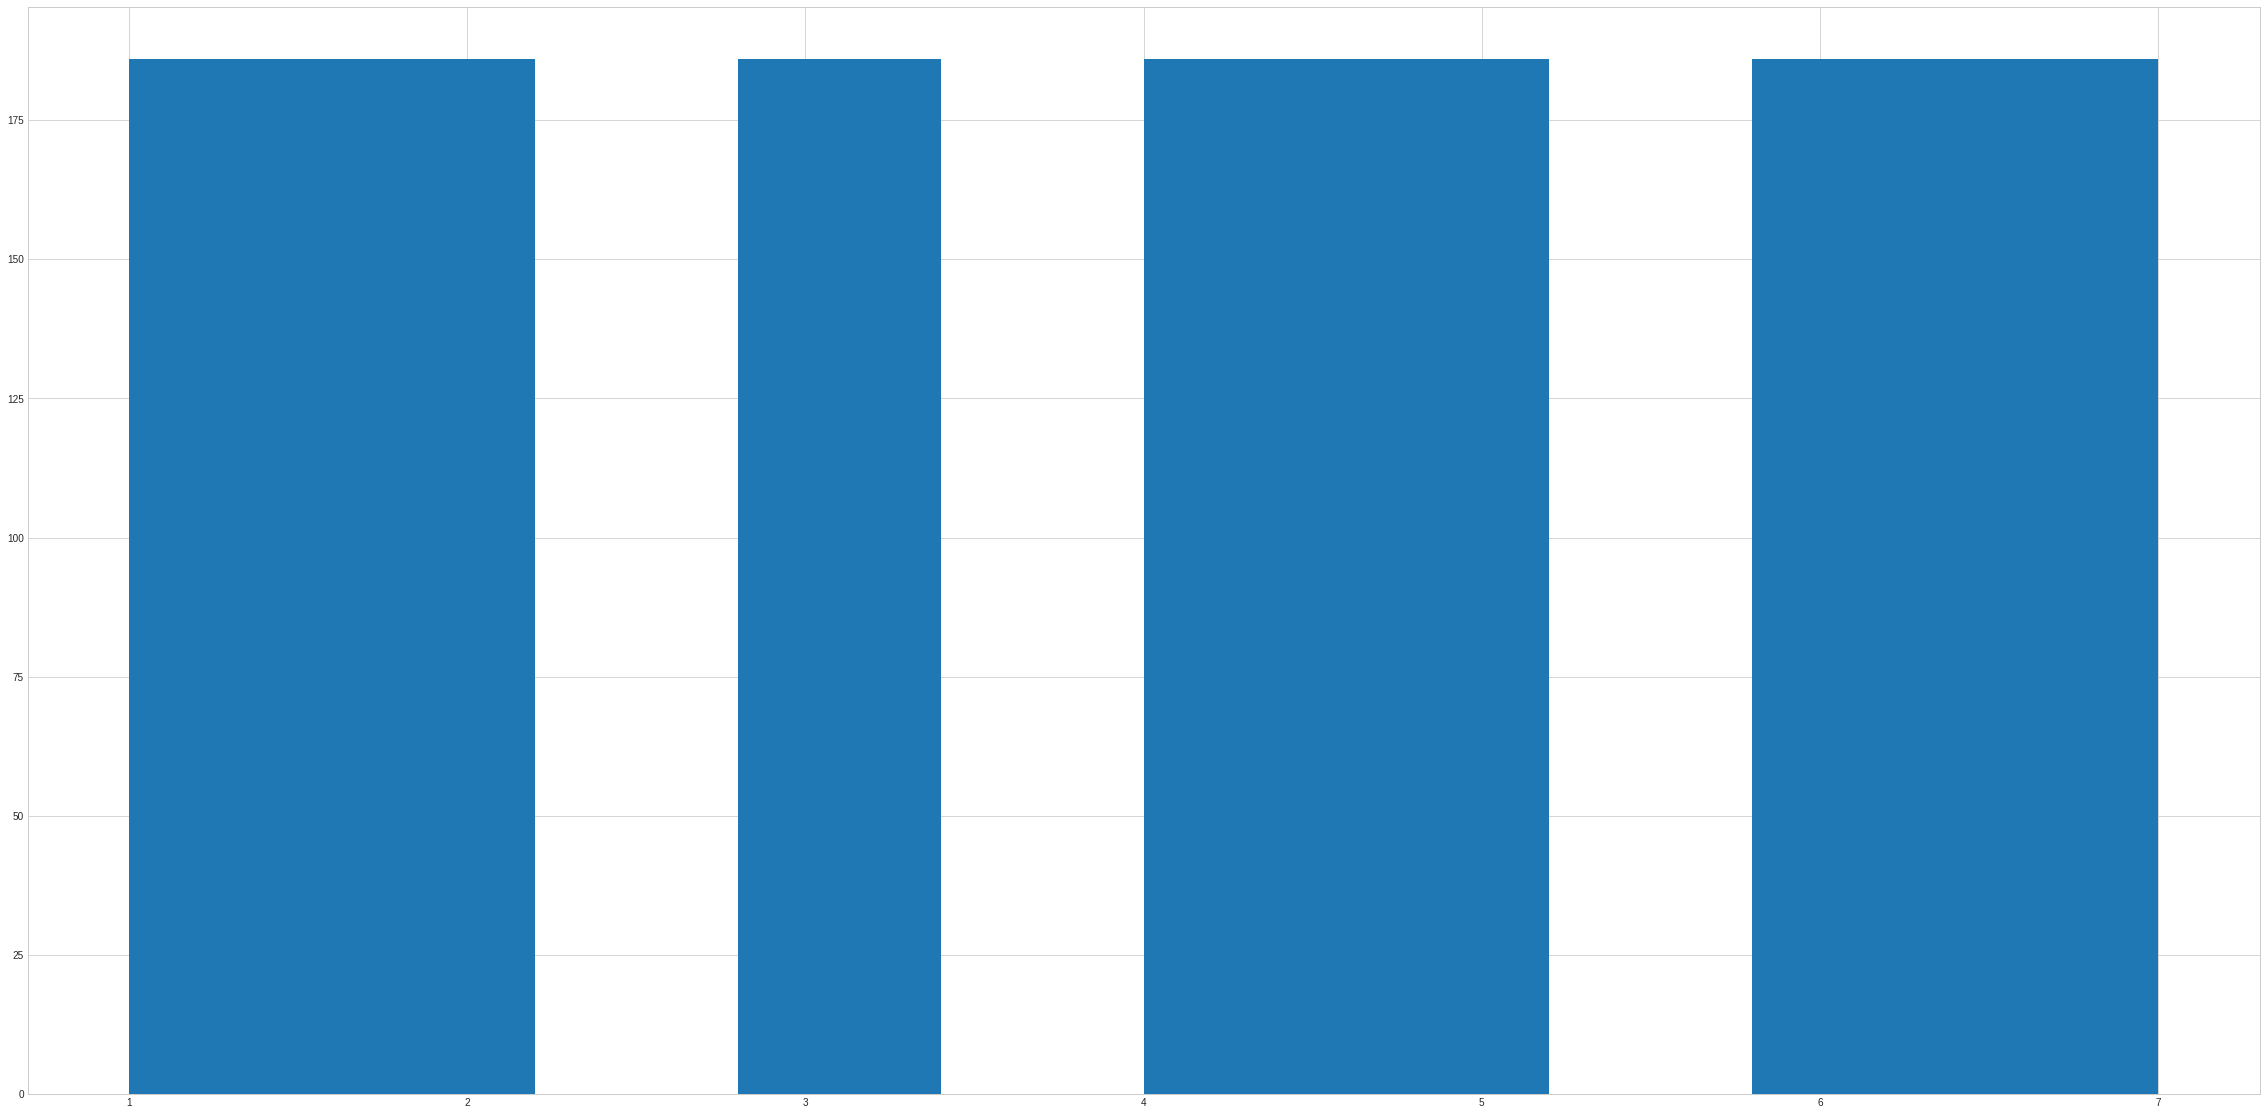

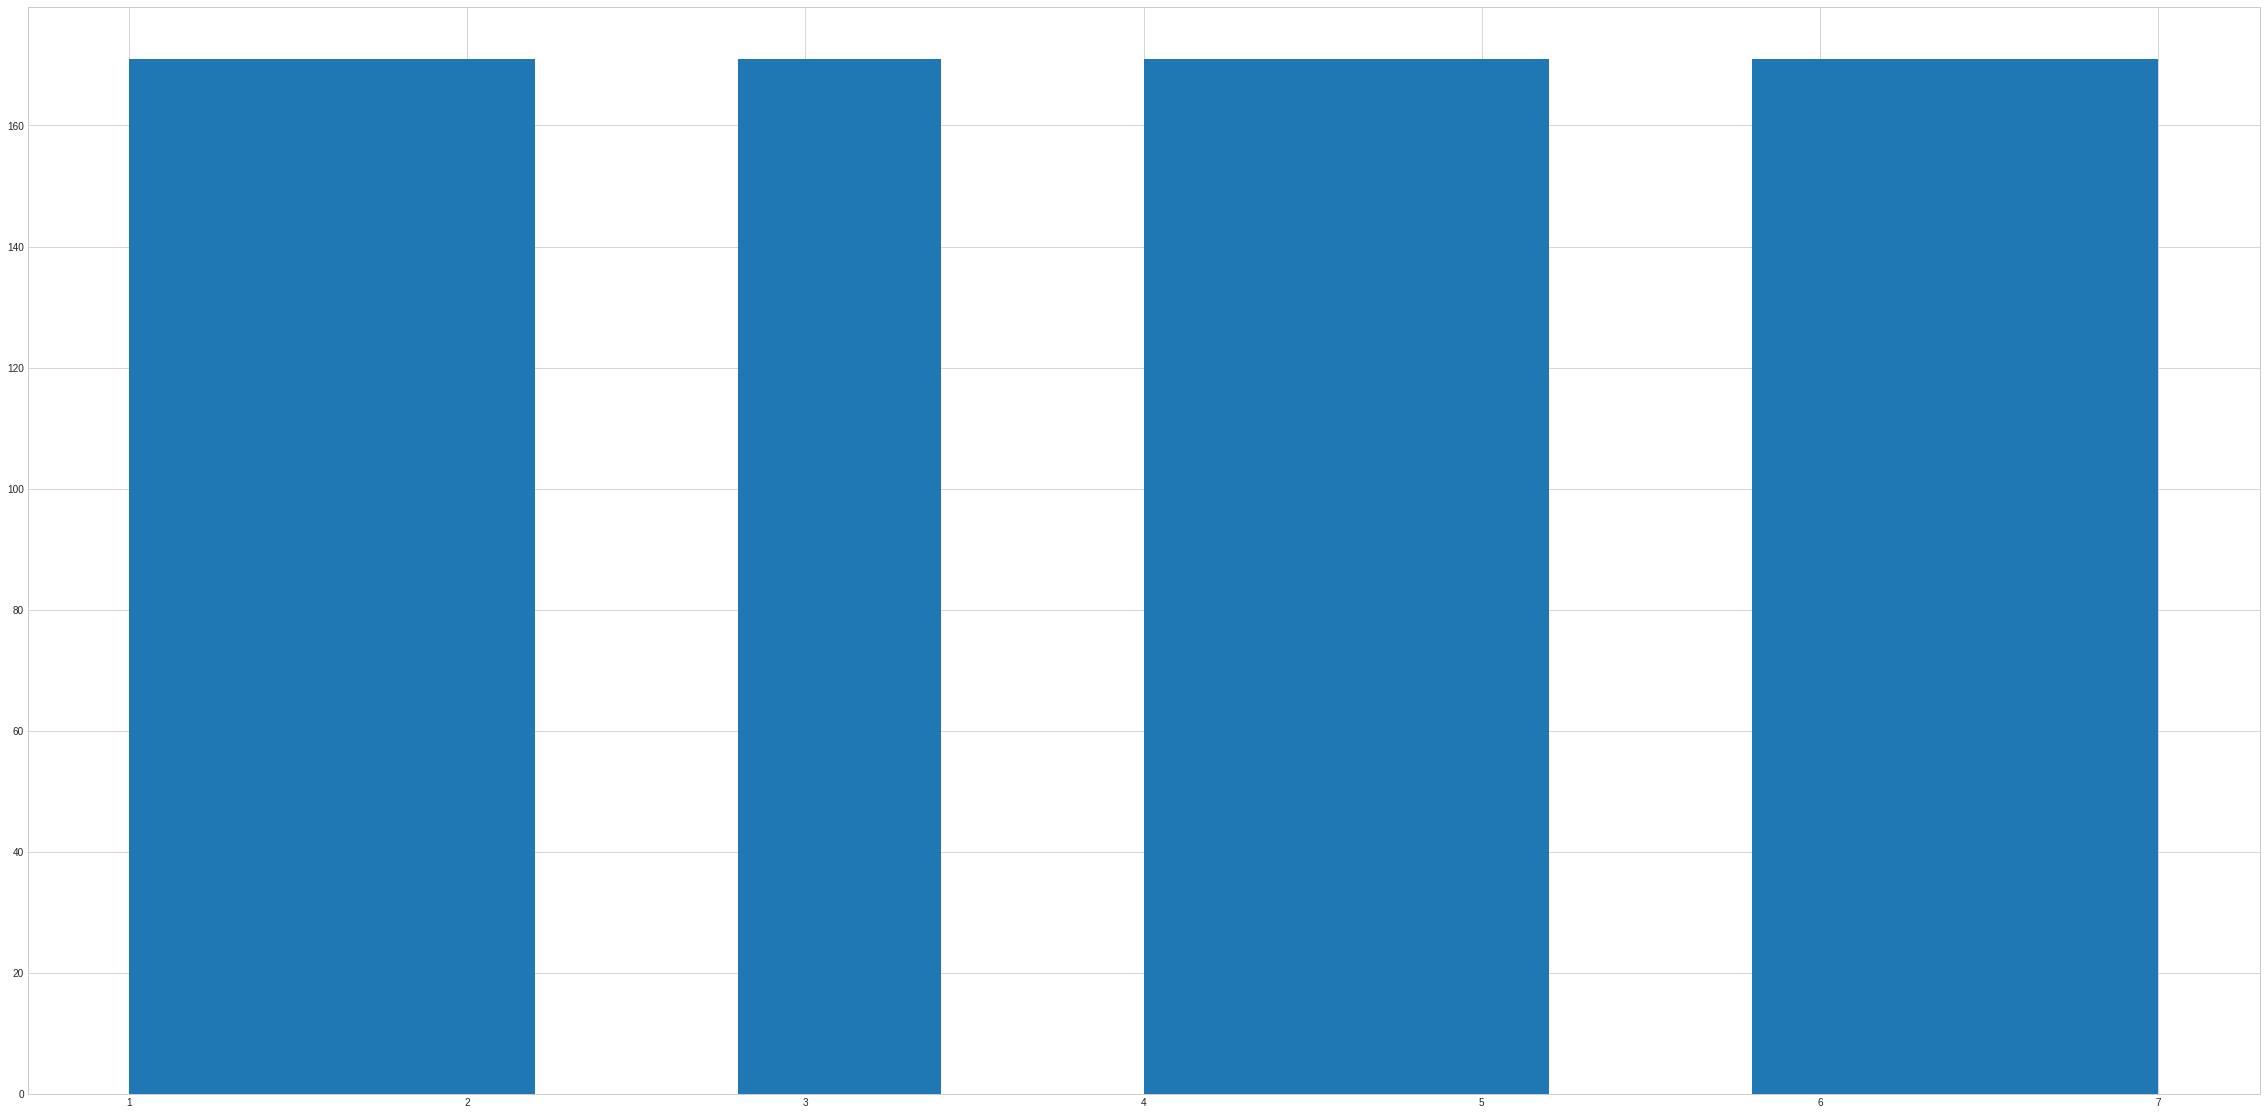

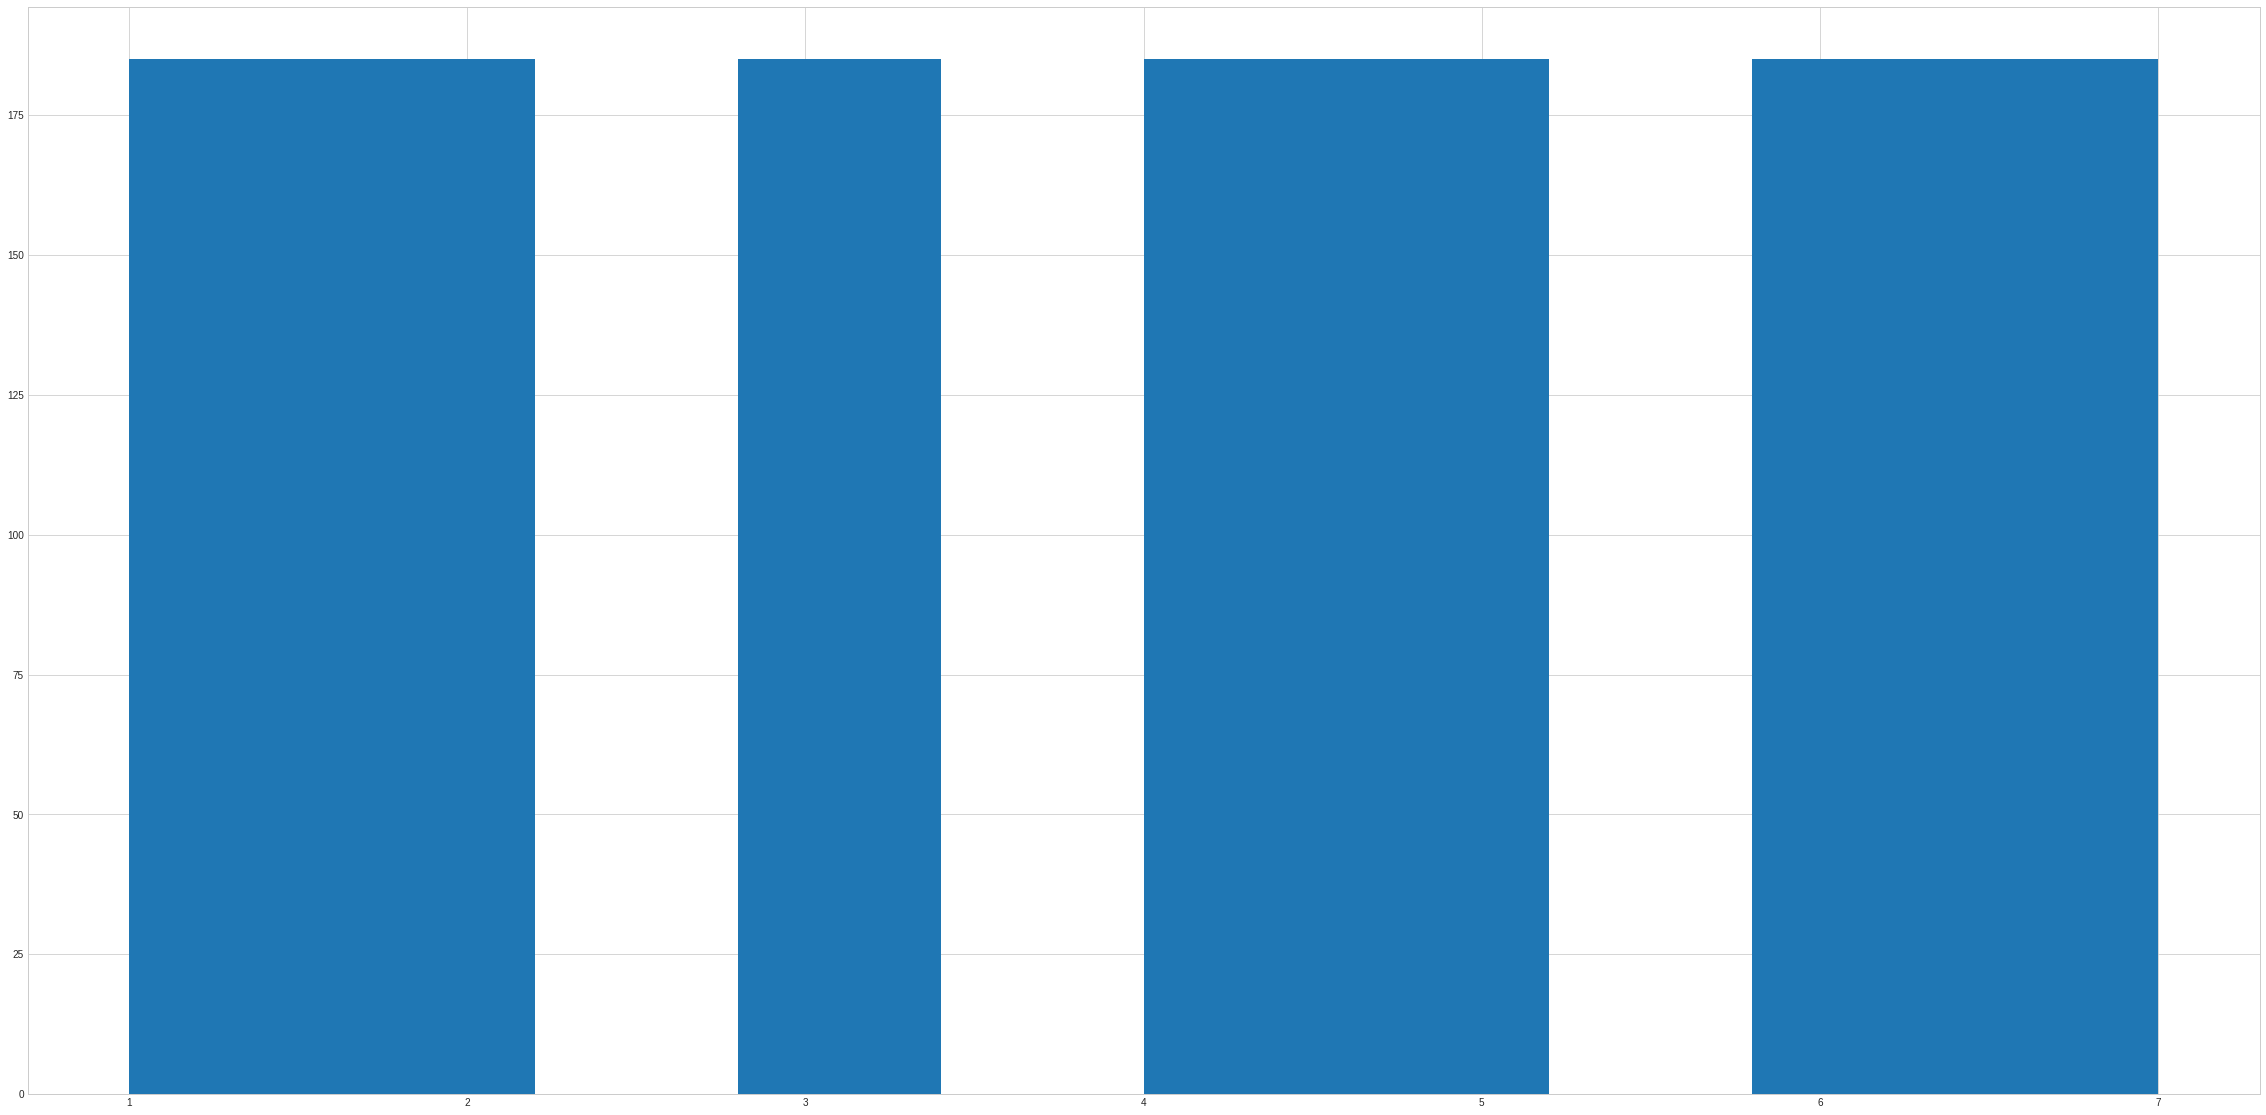

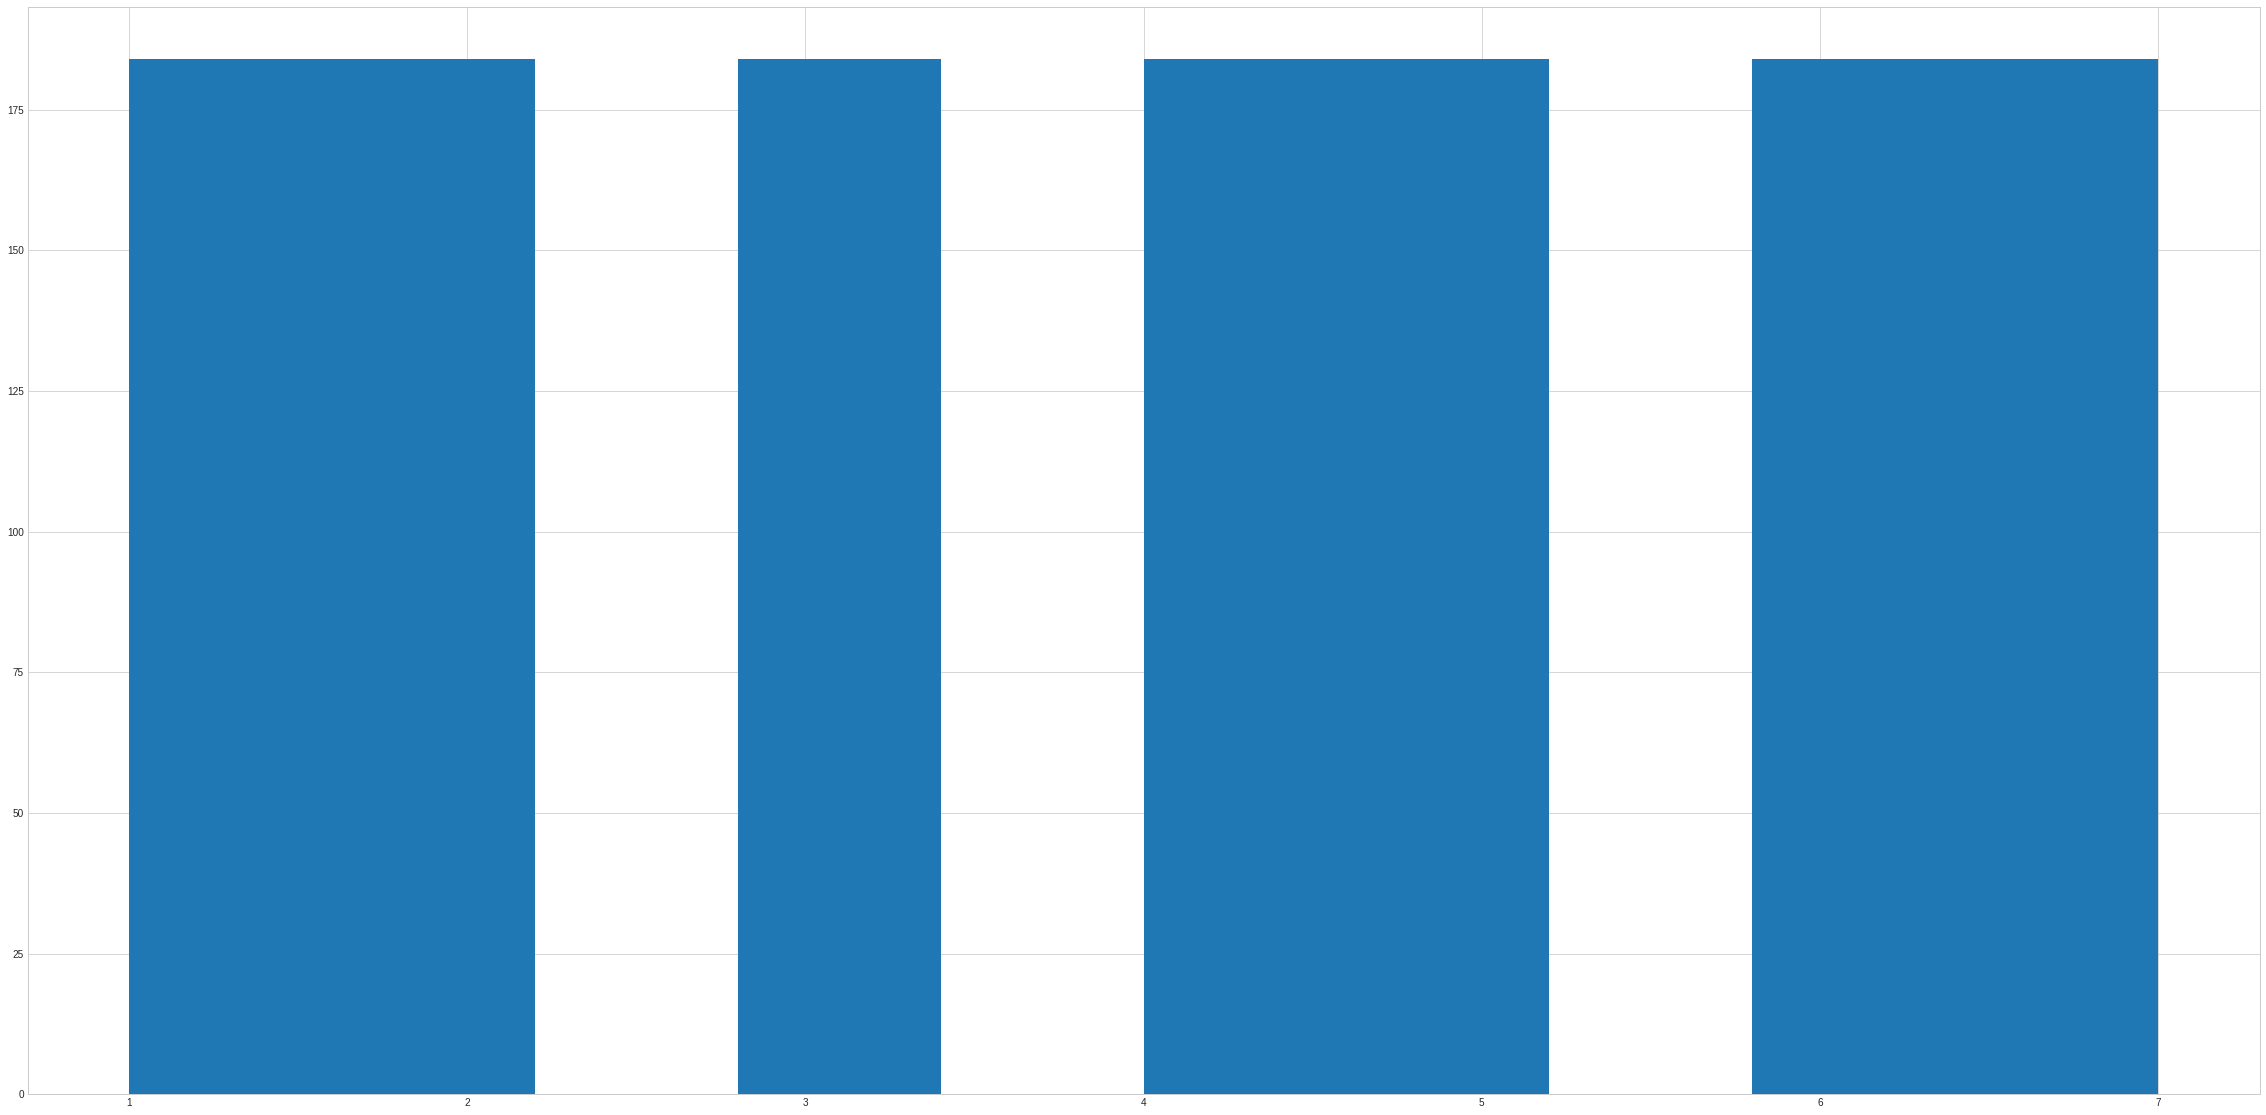

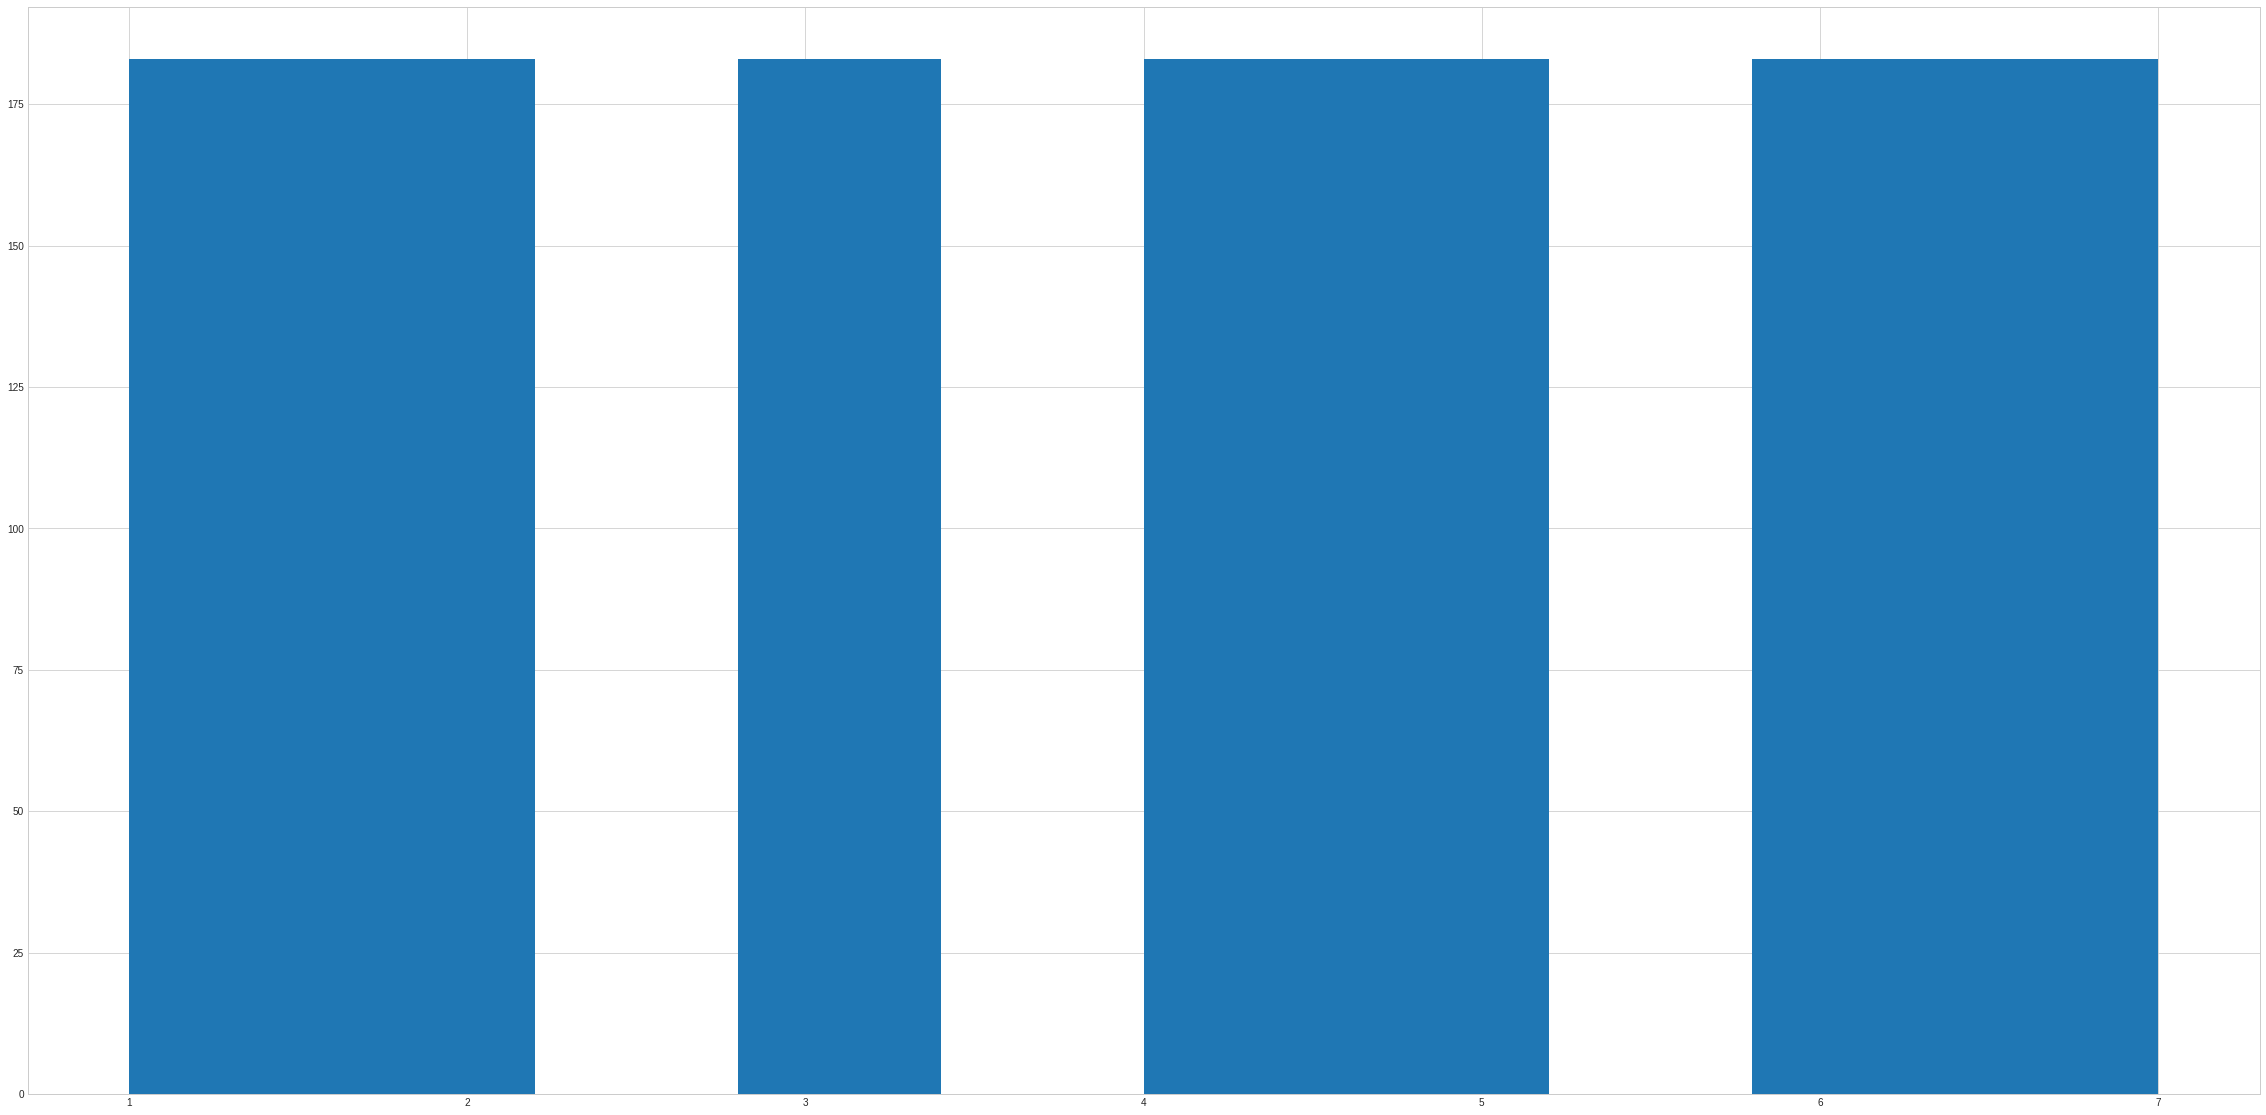

meanPrecision= 0.2799581534499735
meanRecall= 0.2799581534499735
meanAccuracy= 0.7933973339392562
meanMcc= 0.045929333750096425


In [15]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier

print("DecisionTreeClassifier - MinMax Normalization - KF-OverSampler")
#Random Fores K-Fold e MinMax Over sampler
m = MetricsResultContainer("DecisionTreeClassifier","KF","Minmax","Default",
  generateModel(DecisionTreeClassifier(),rkf),"overSampler"
)
metricsResults.append(m)
m.printMetrics()

# **ALGORITIMO EVALUATION OF  GAUSSIAN NAIVE BAYES CLASSIFICATION**

Gaussian Naive Bayes - MinMax Normalization - KF-OverSampler


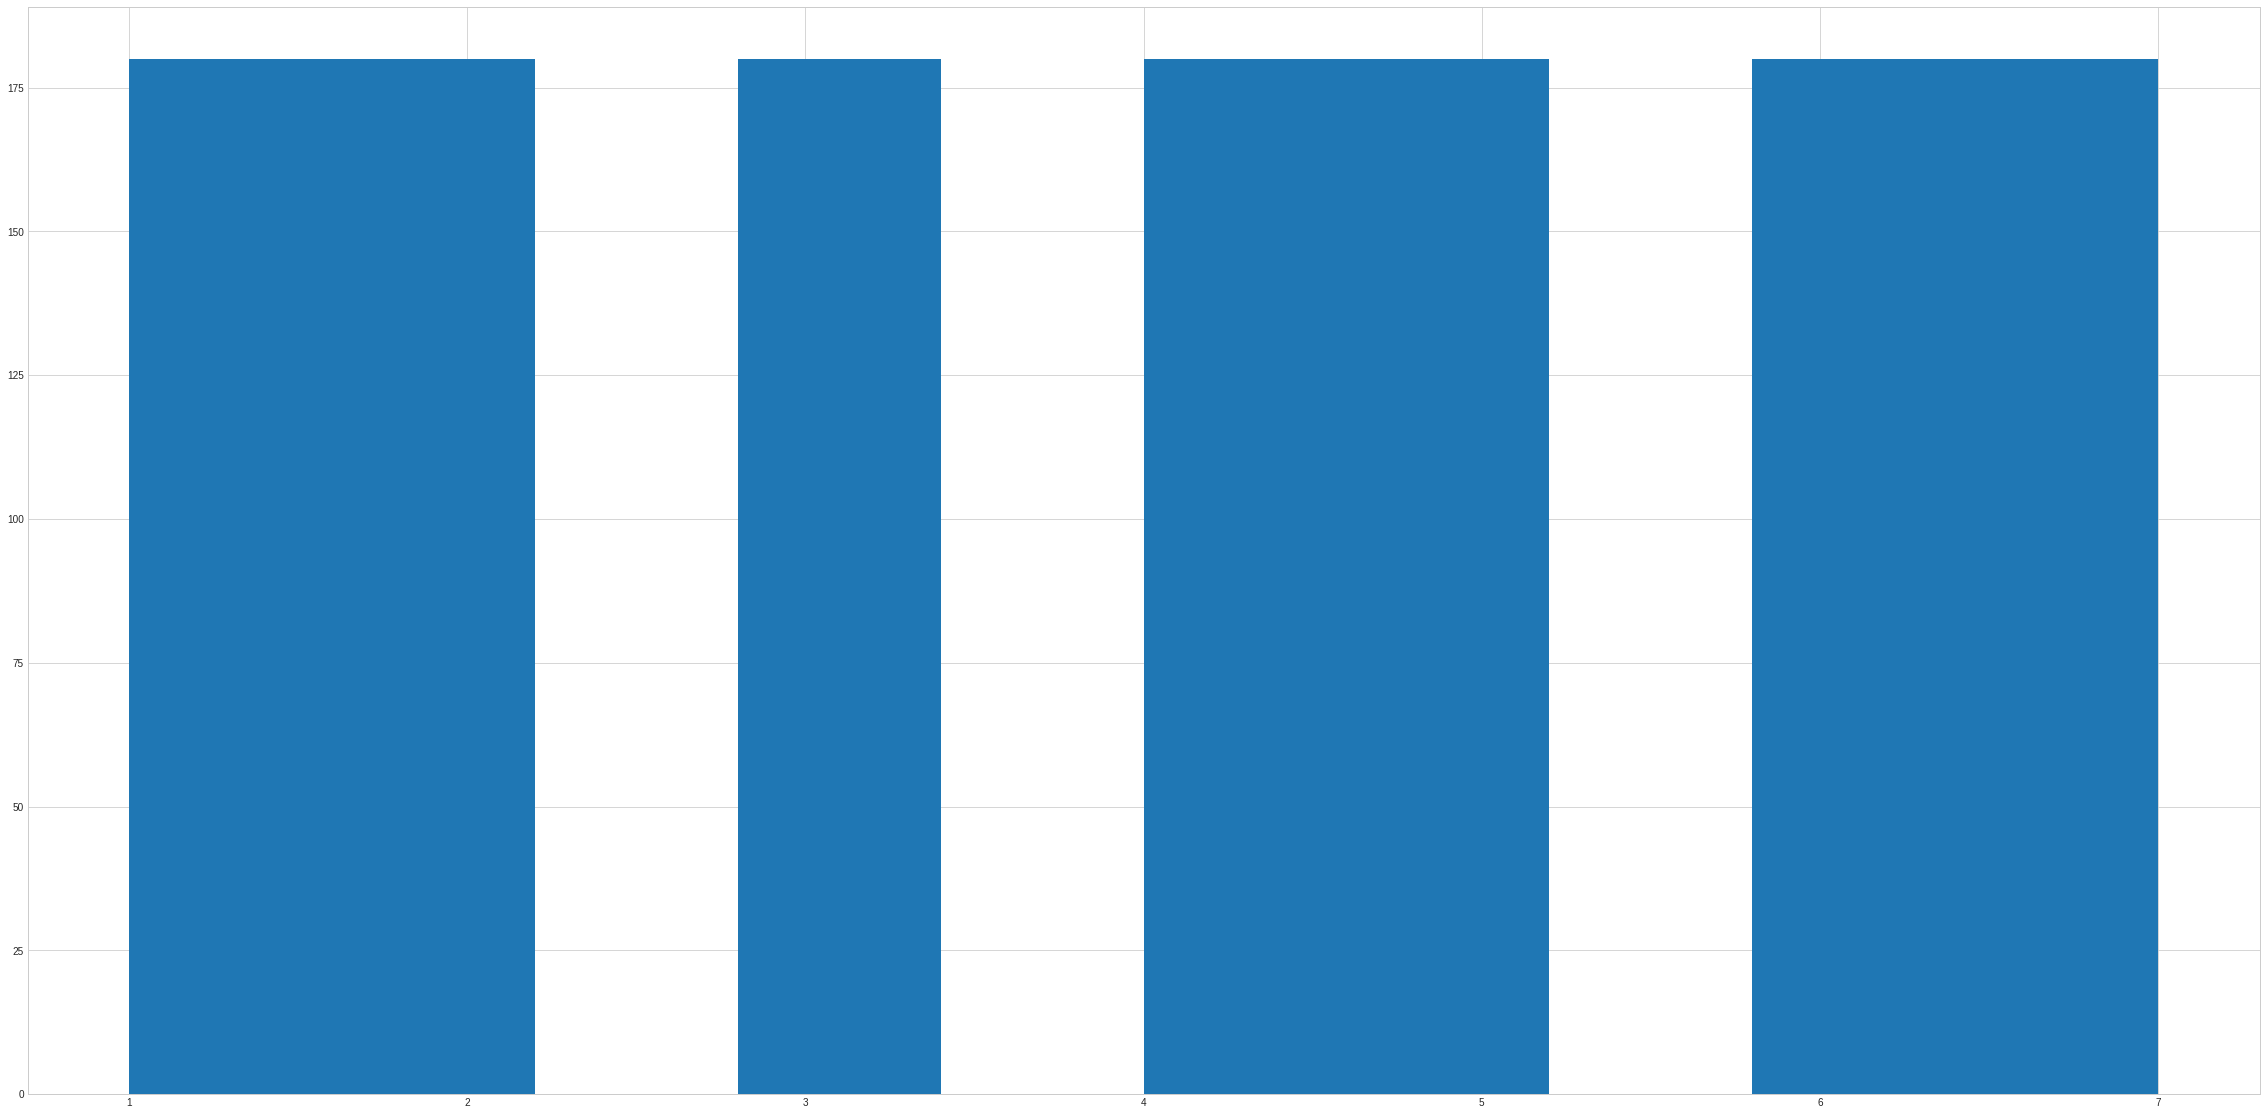

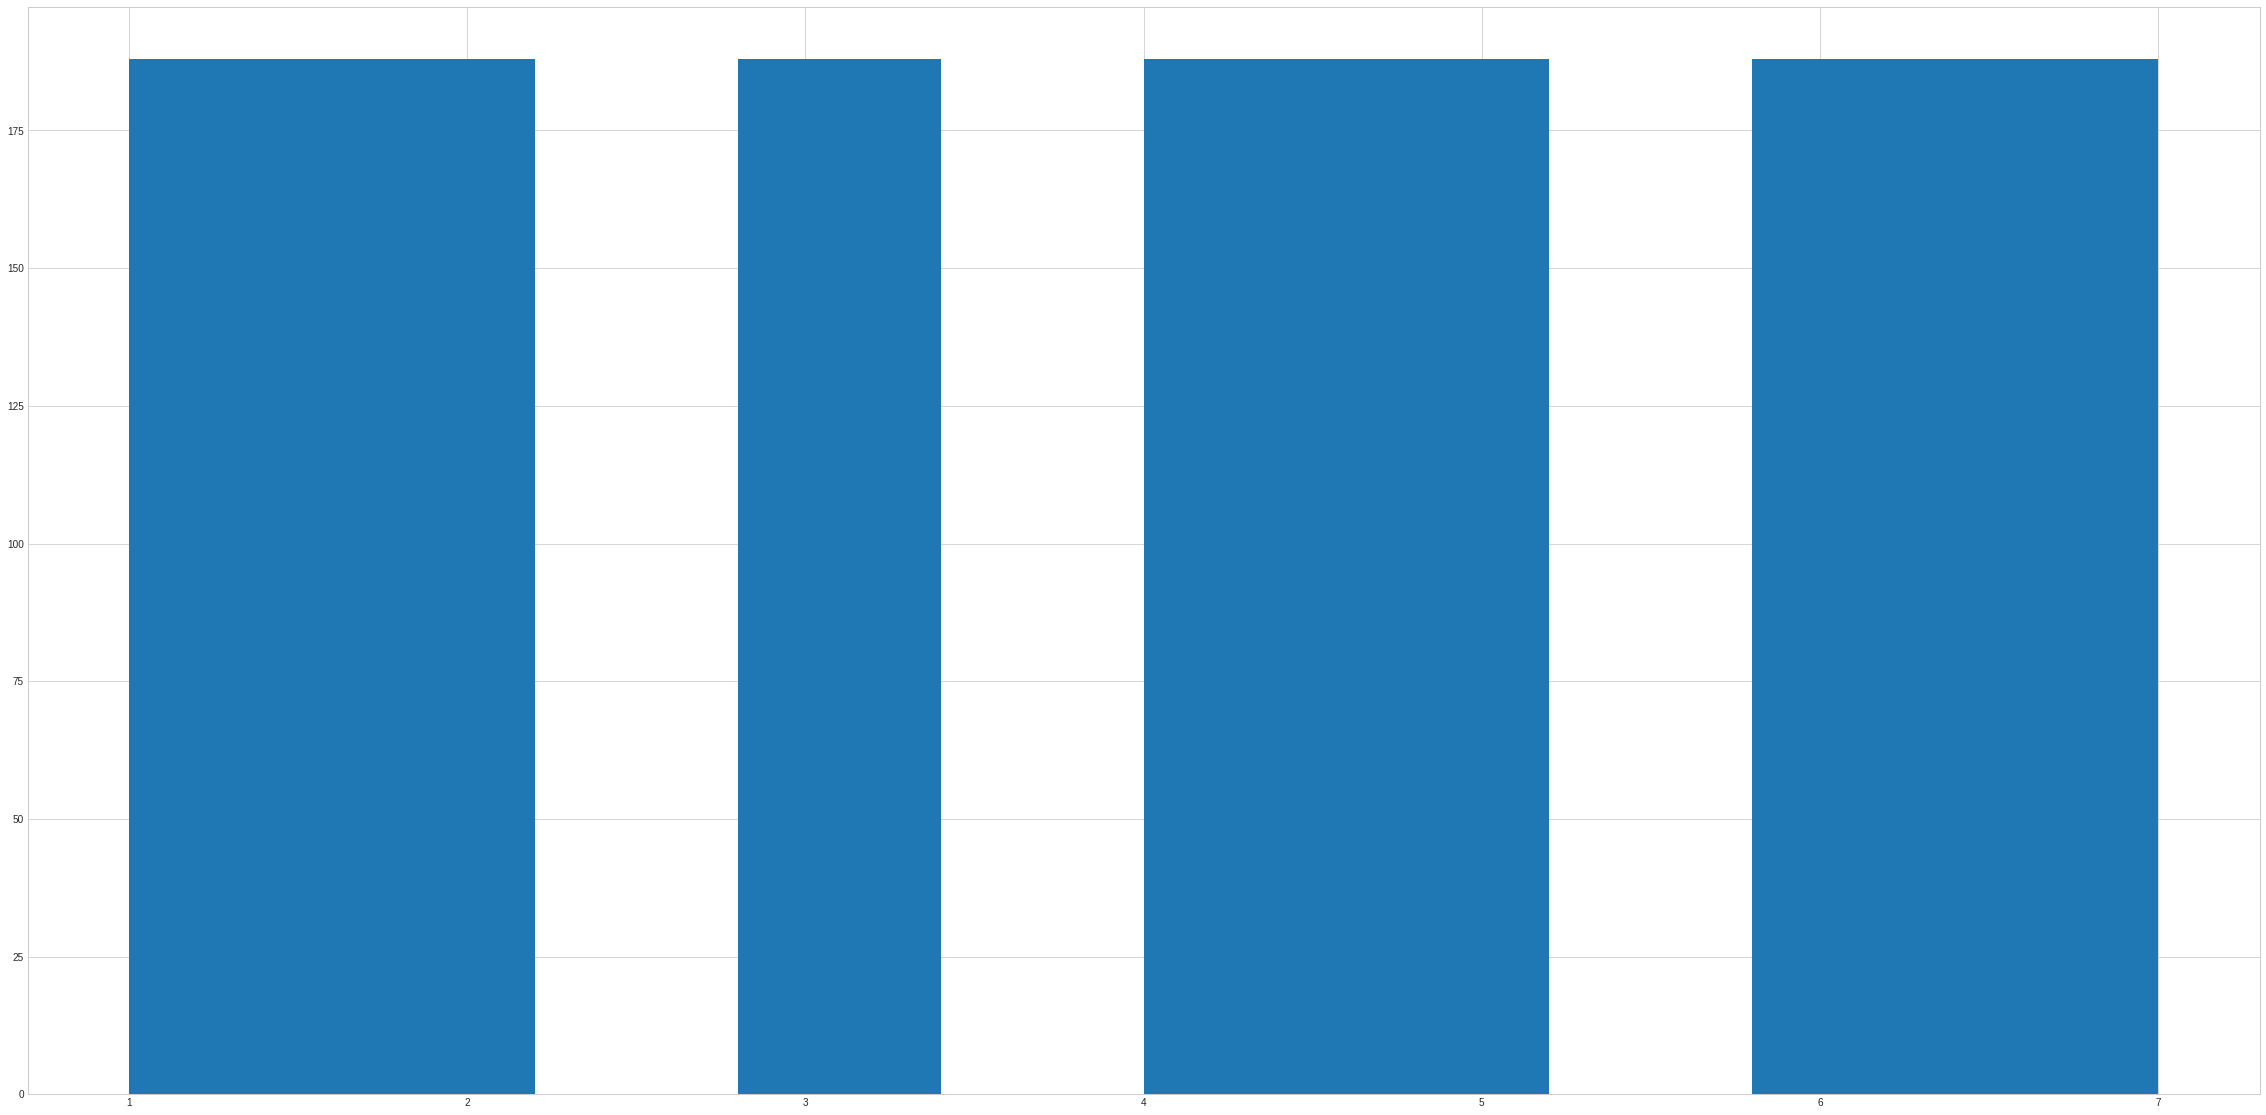

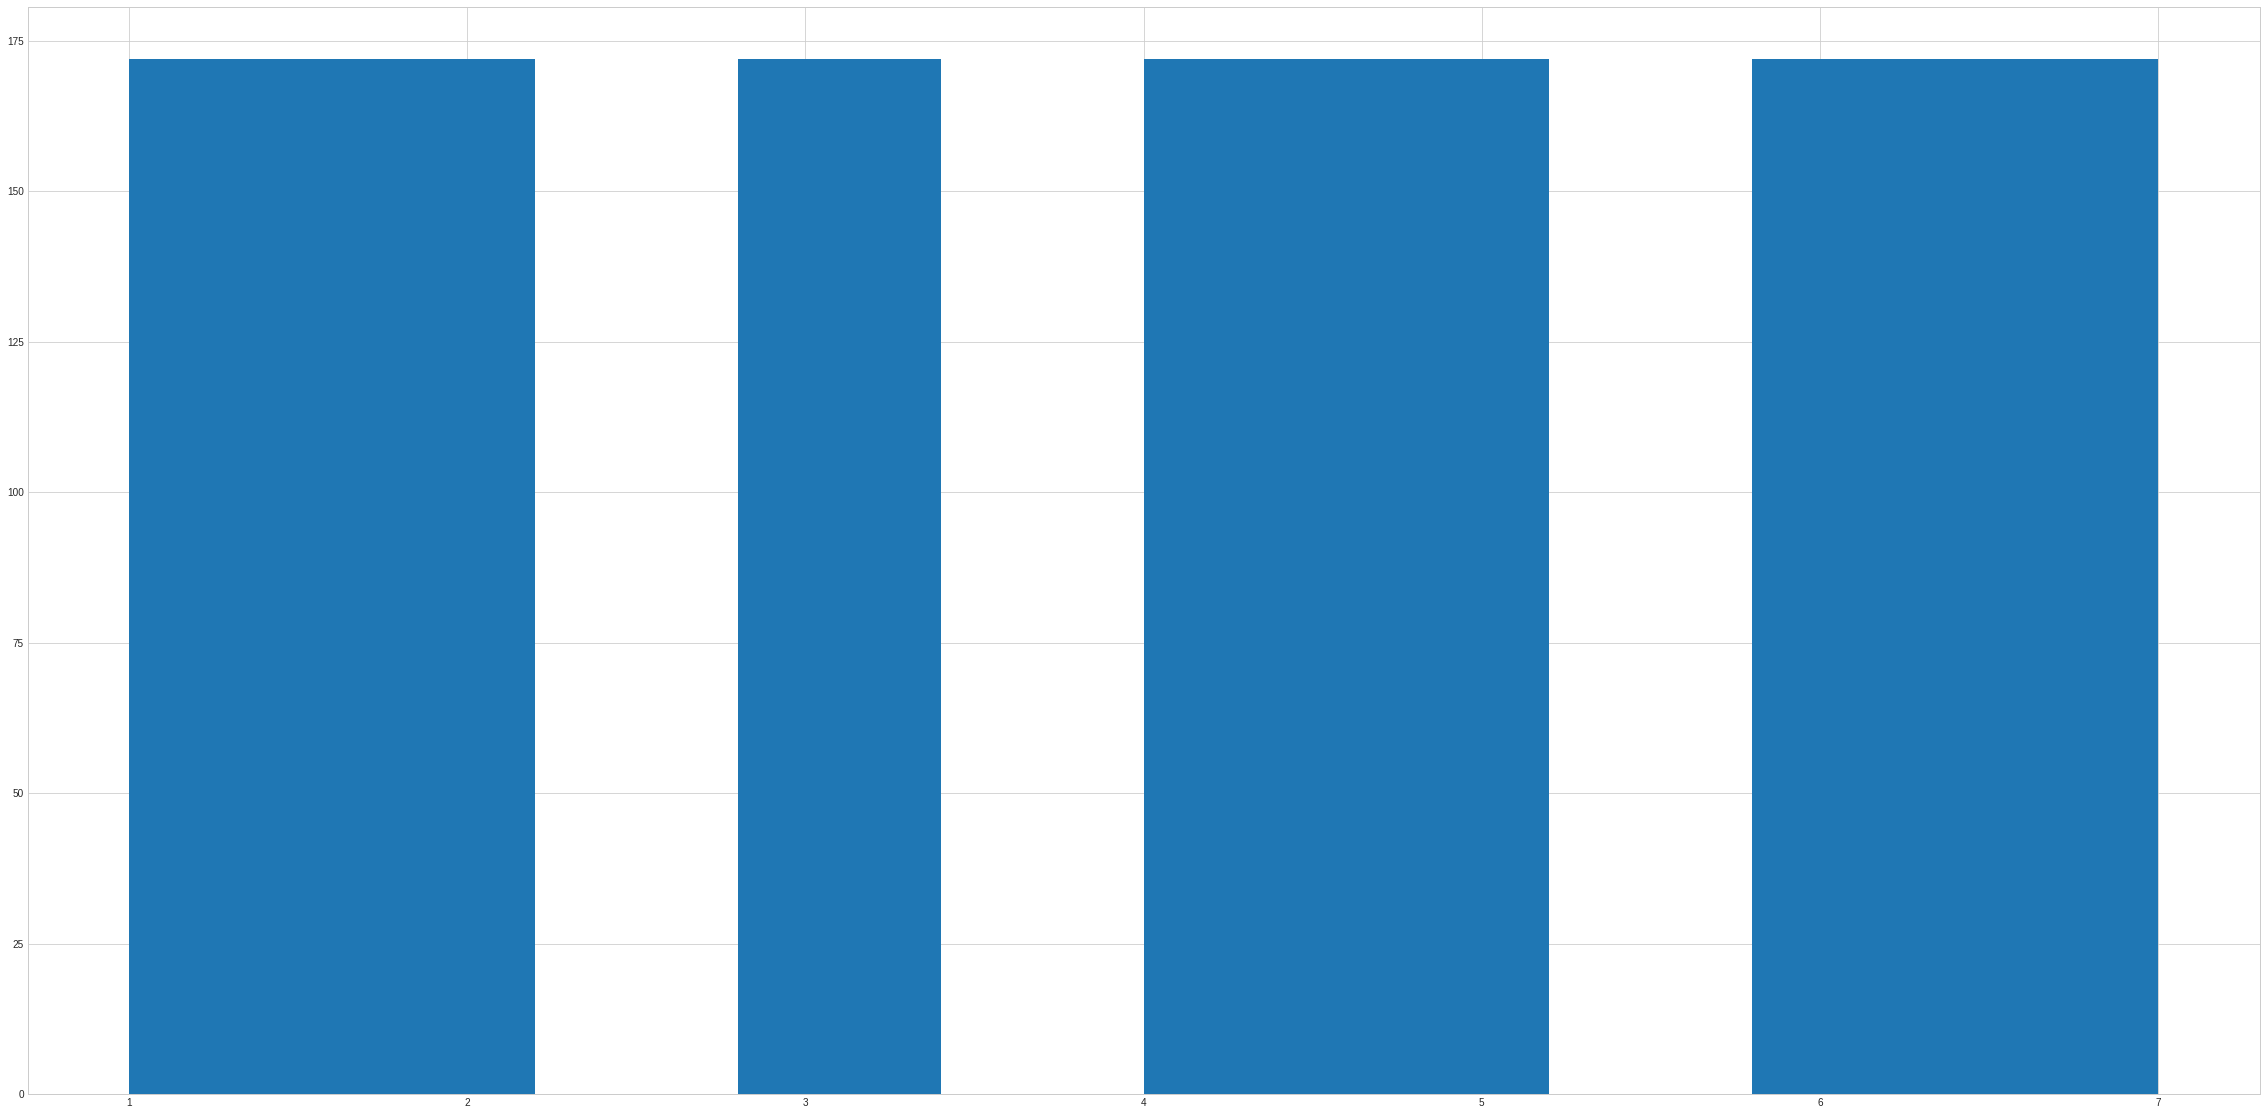

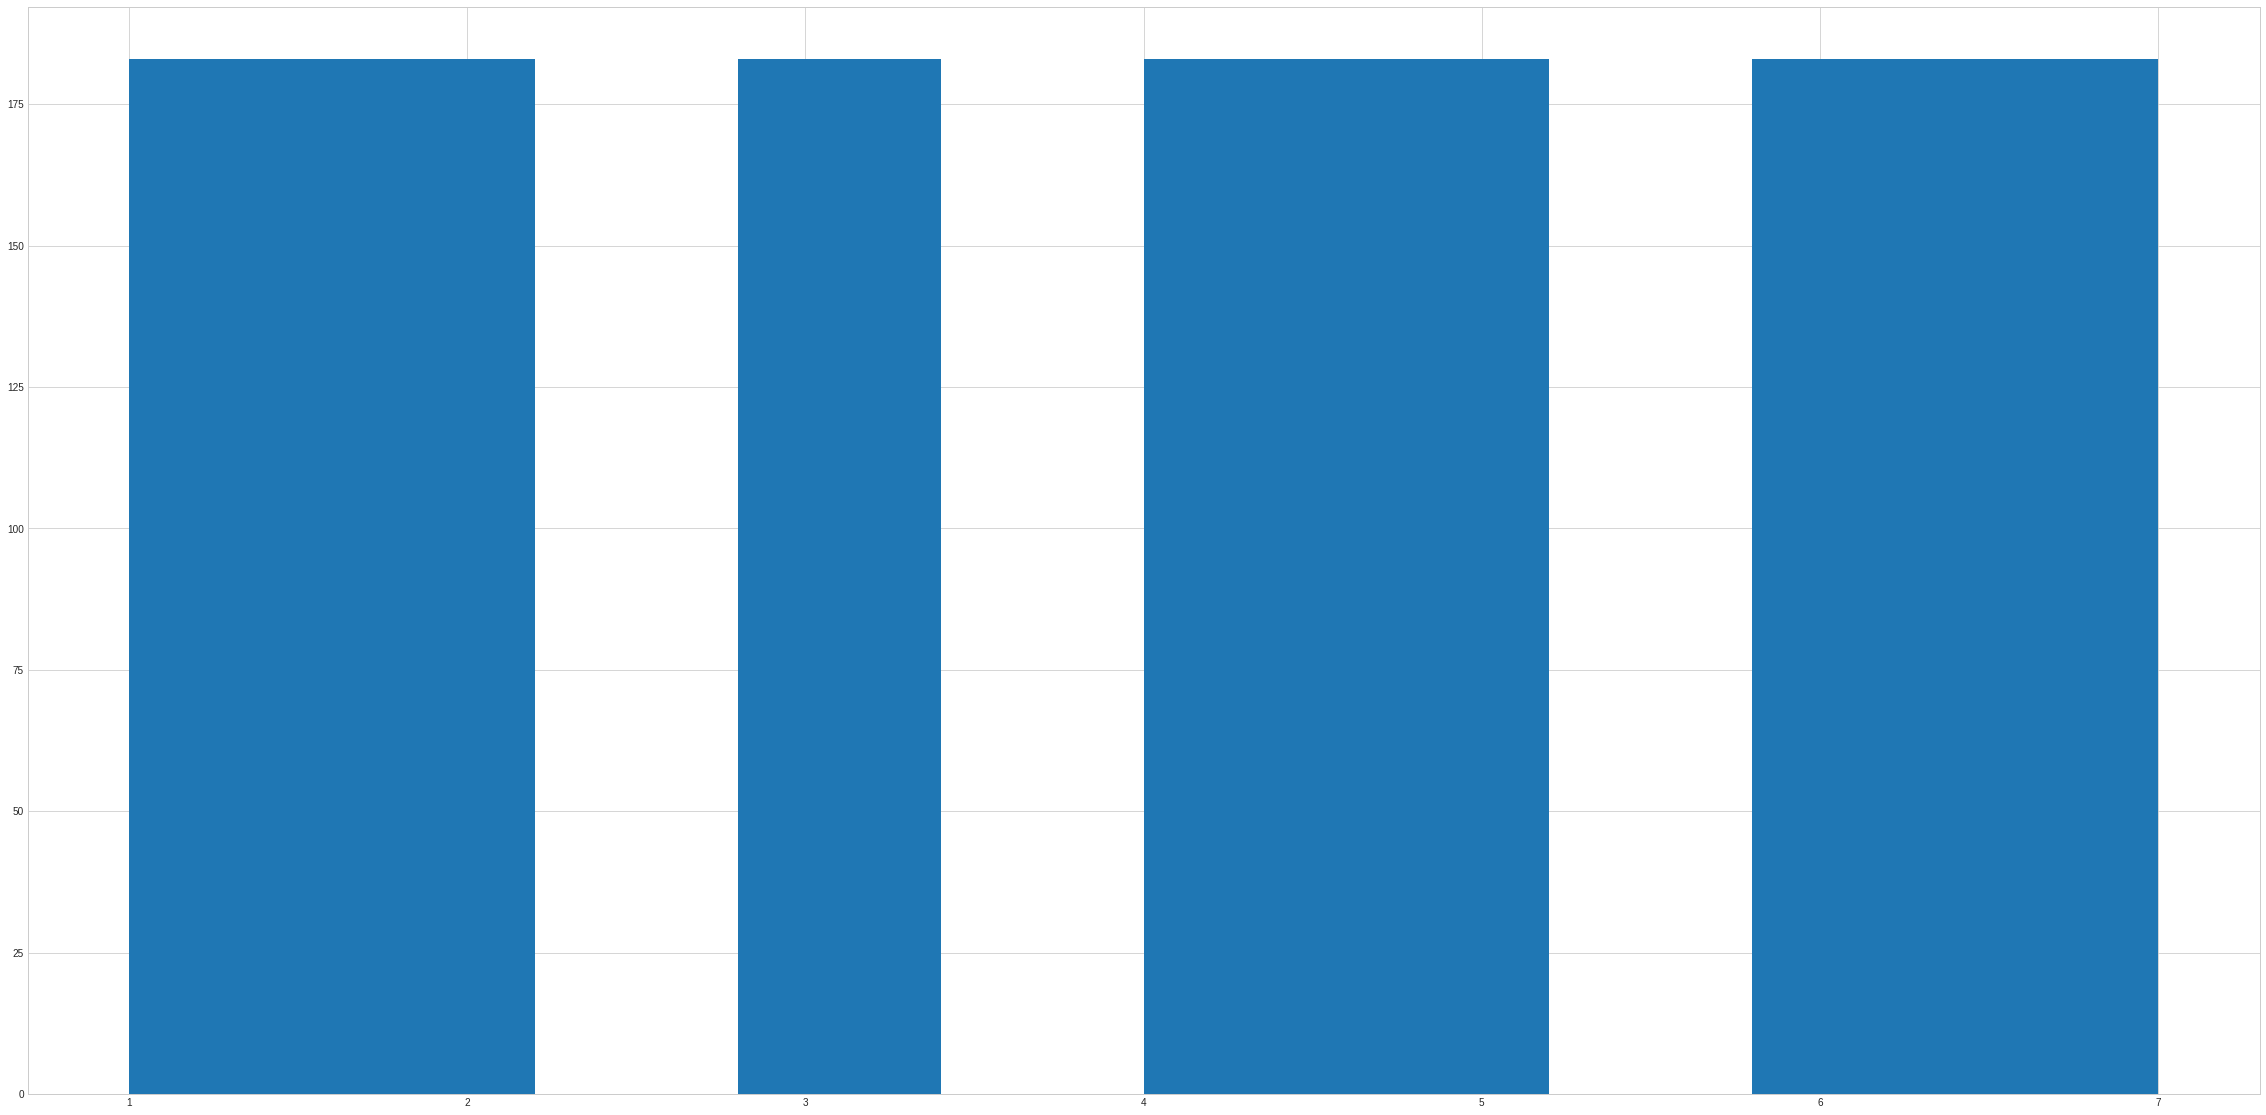

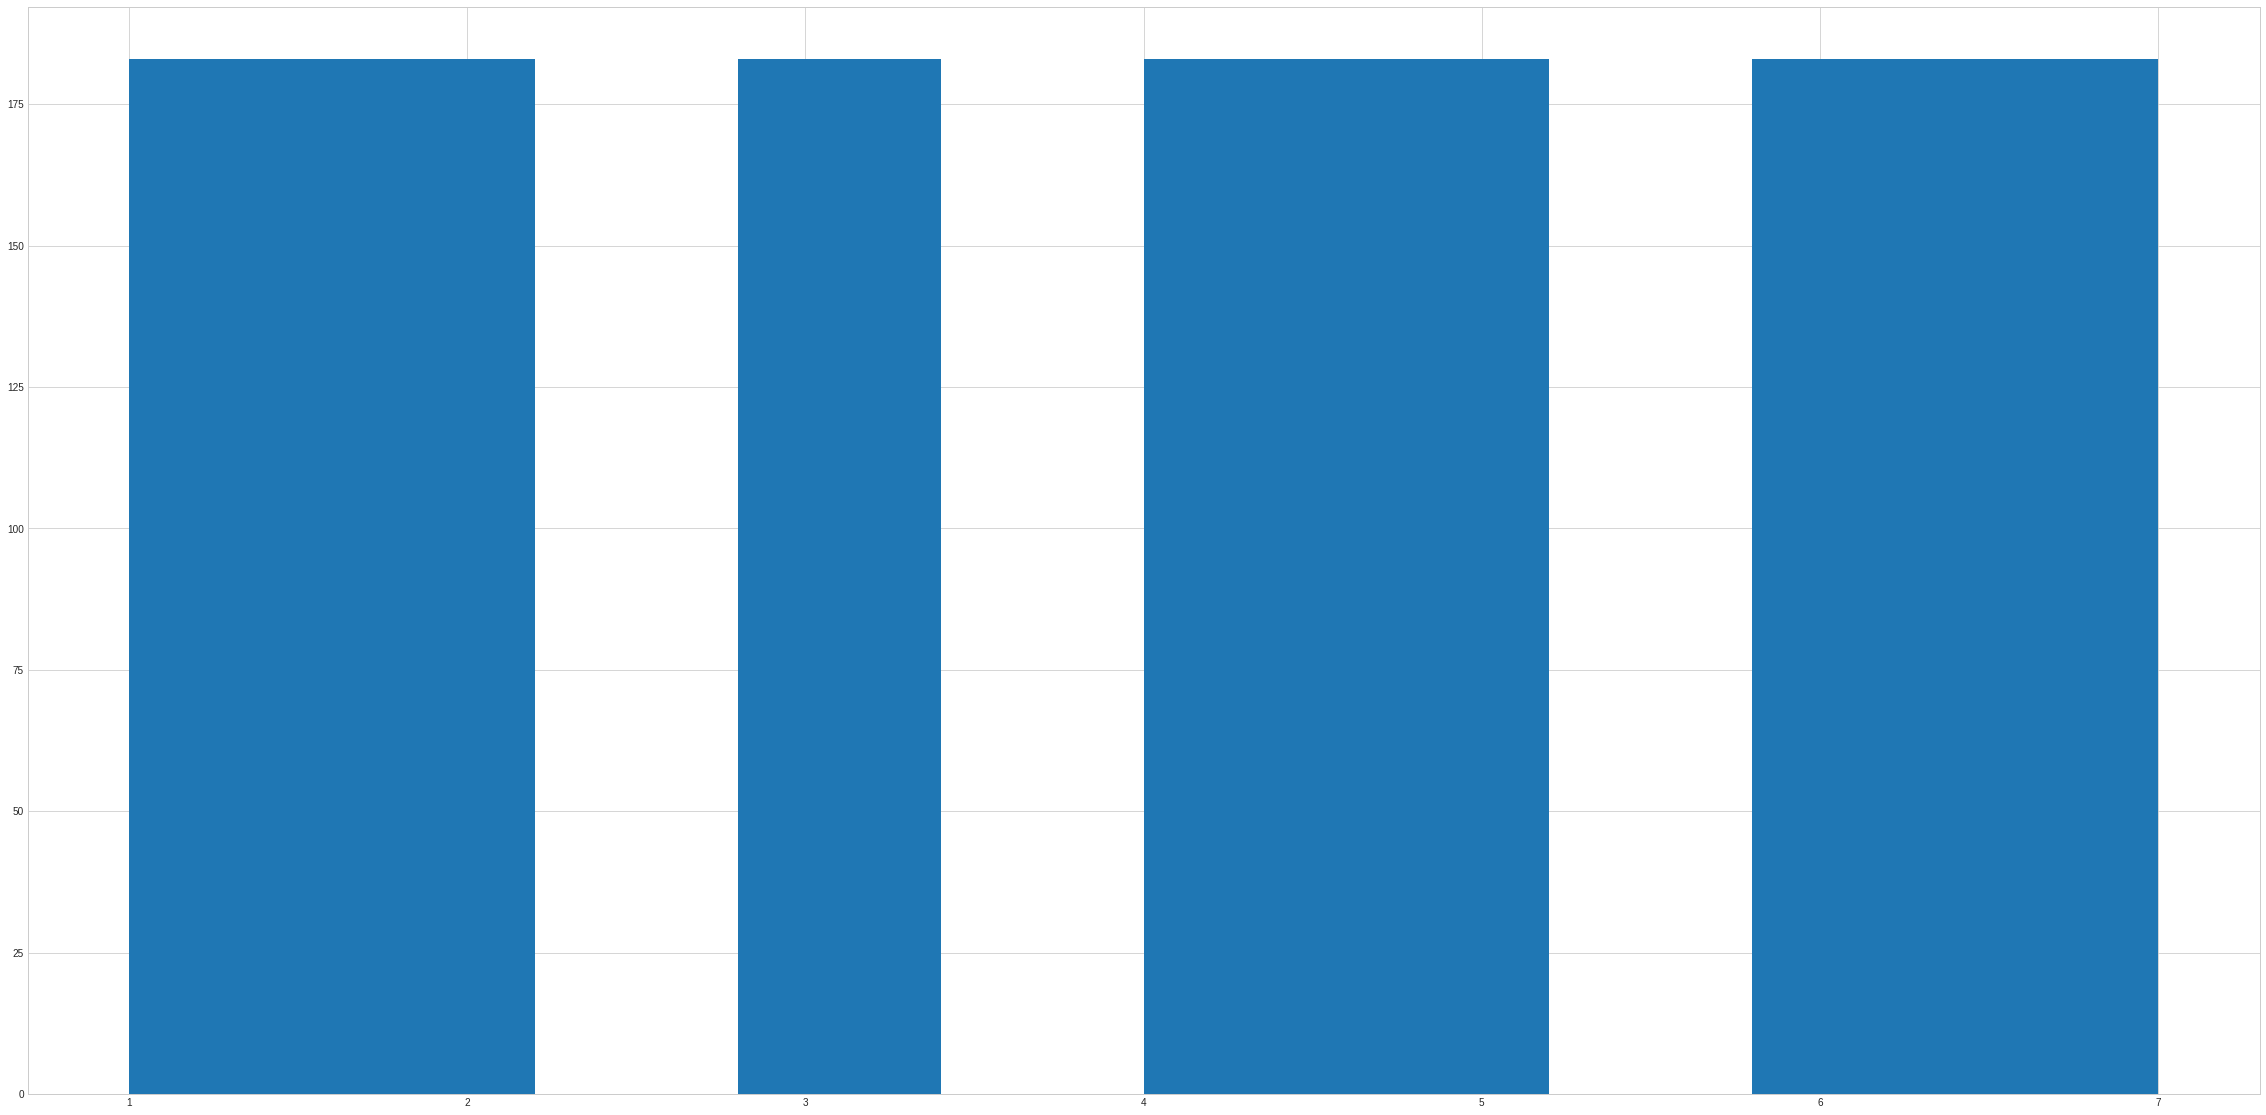

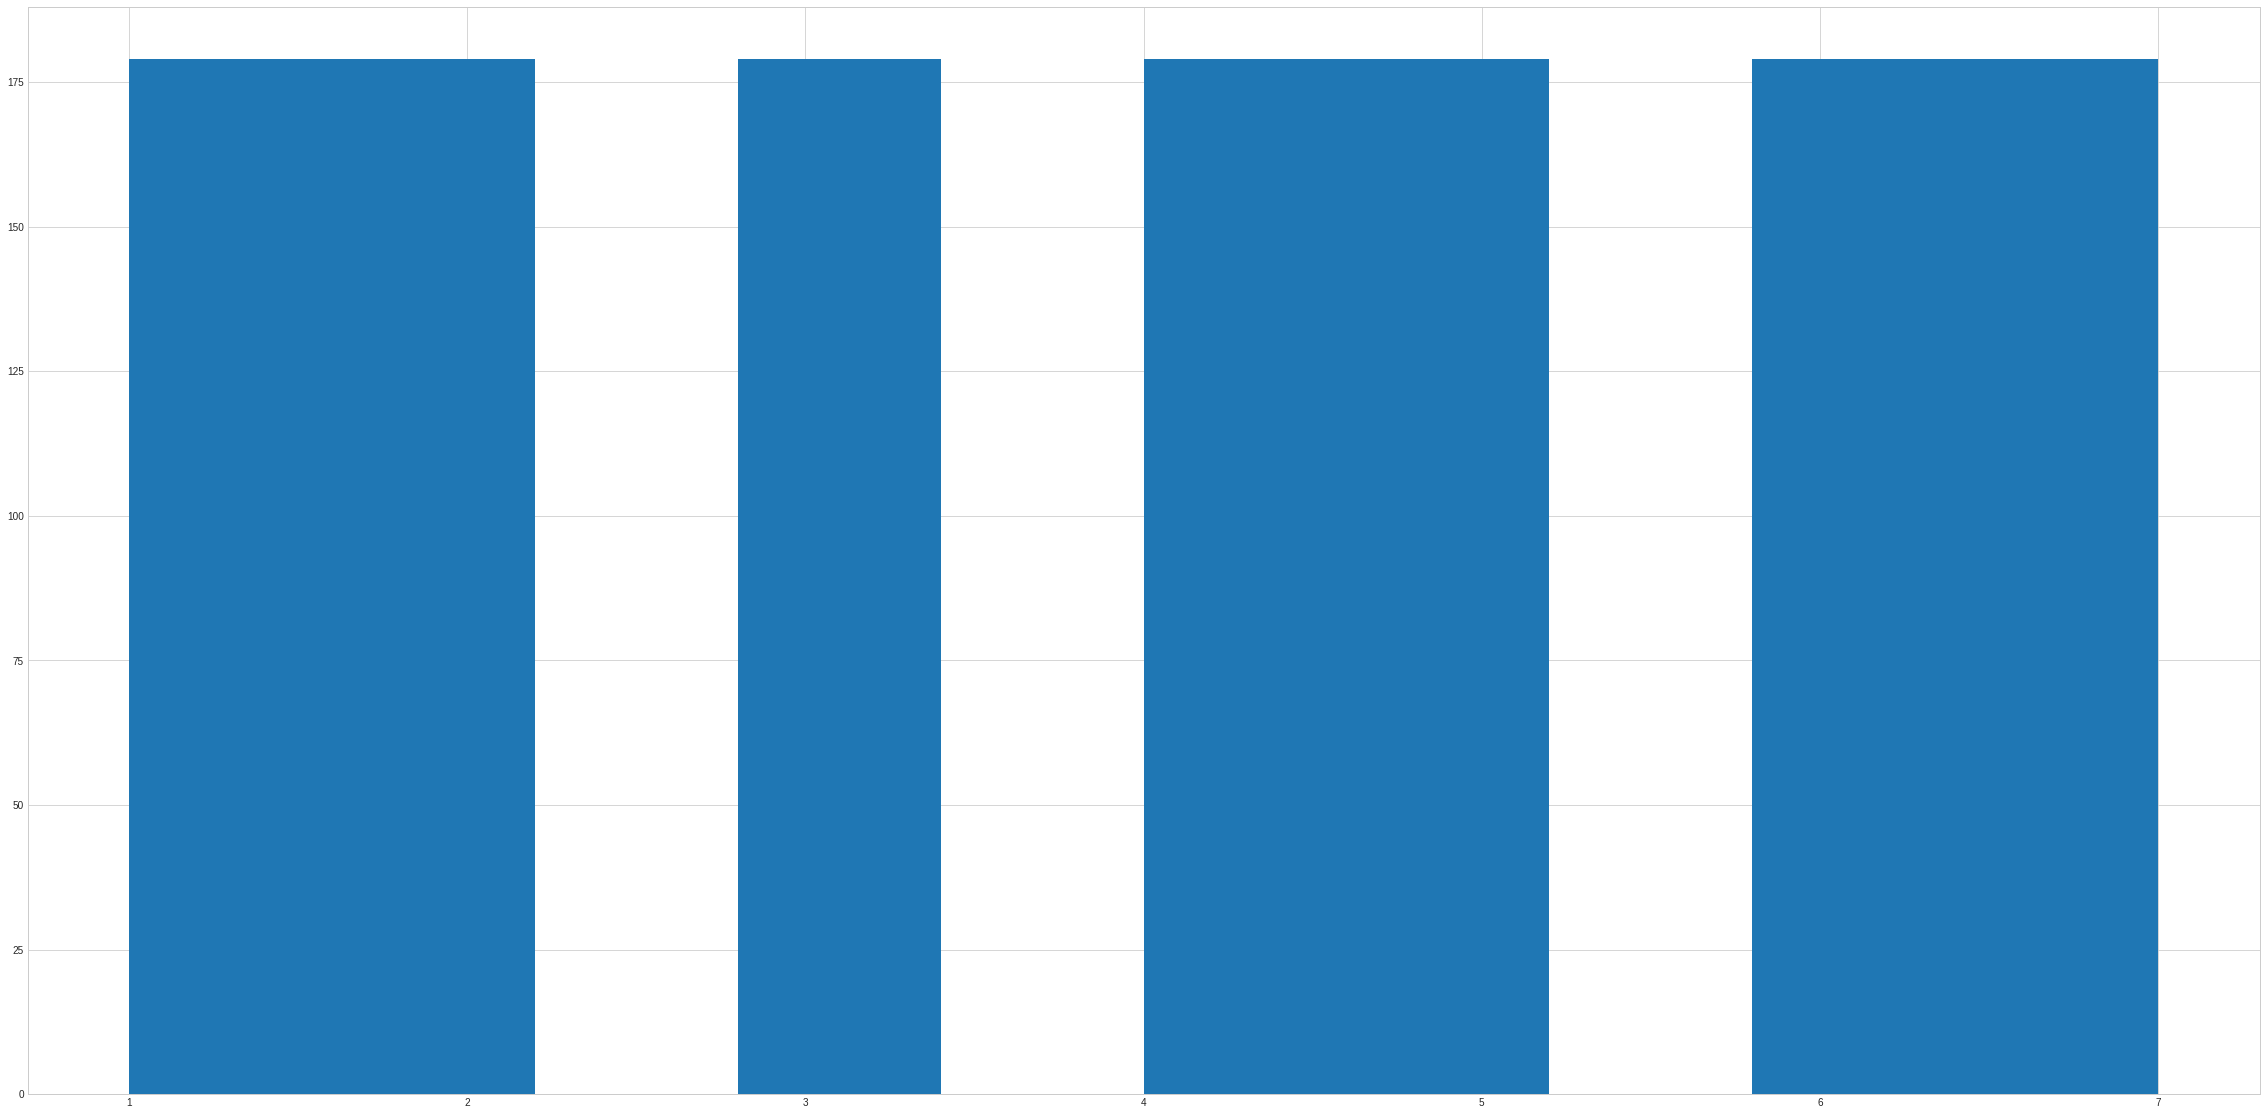

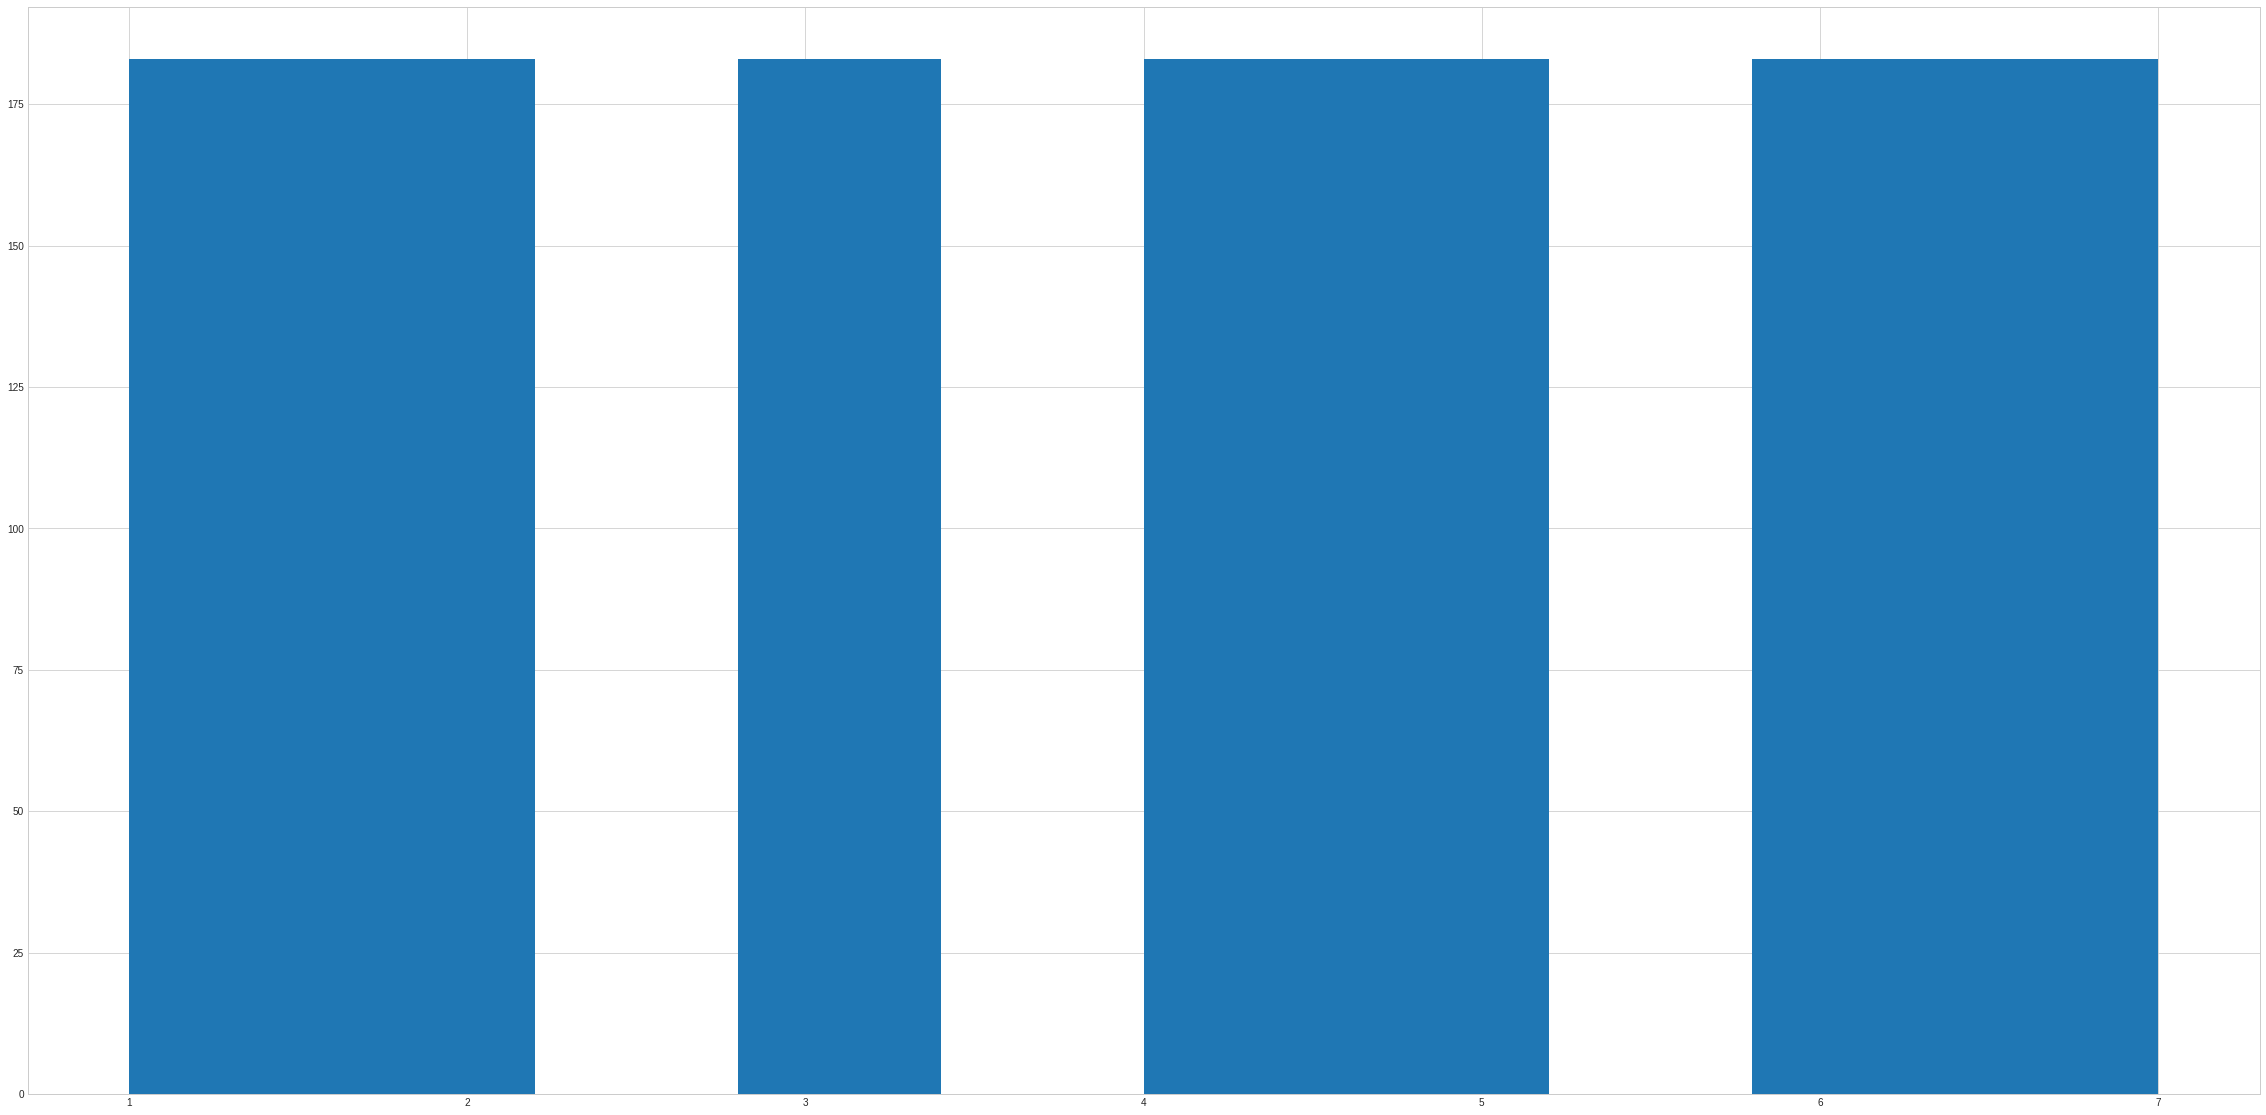

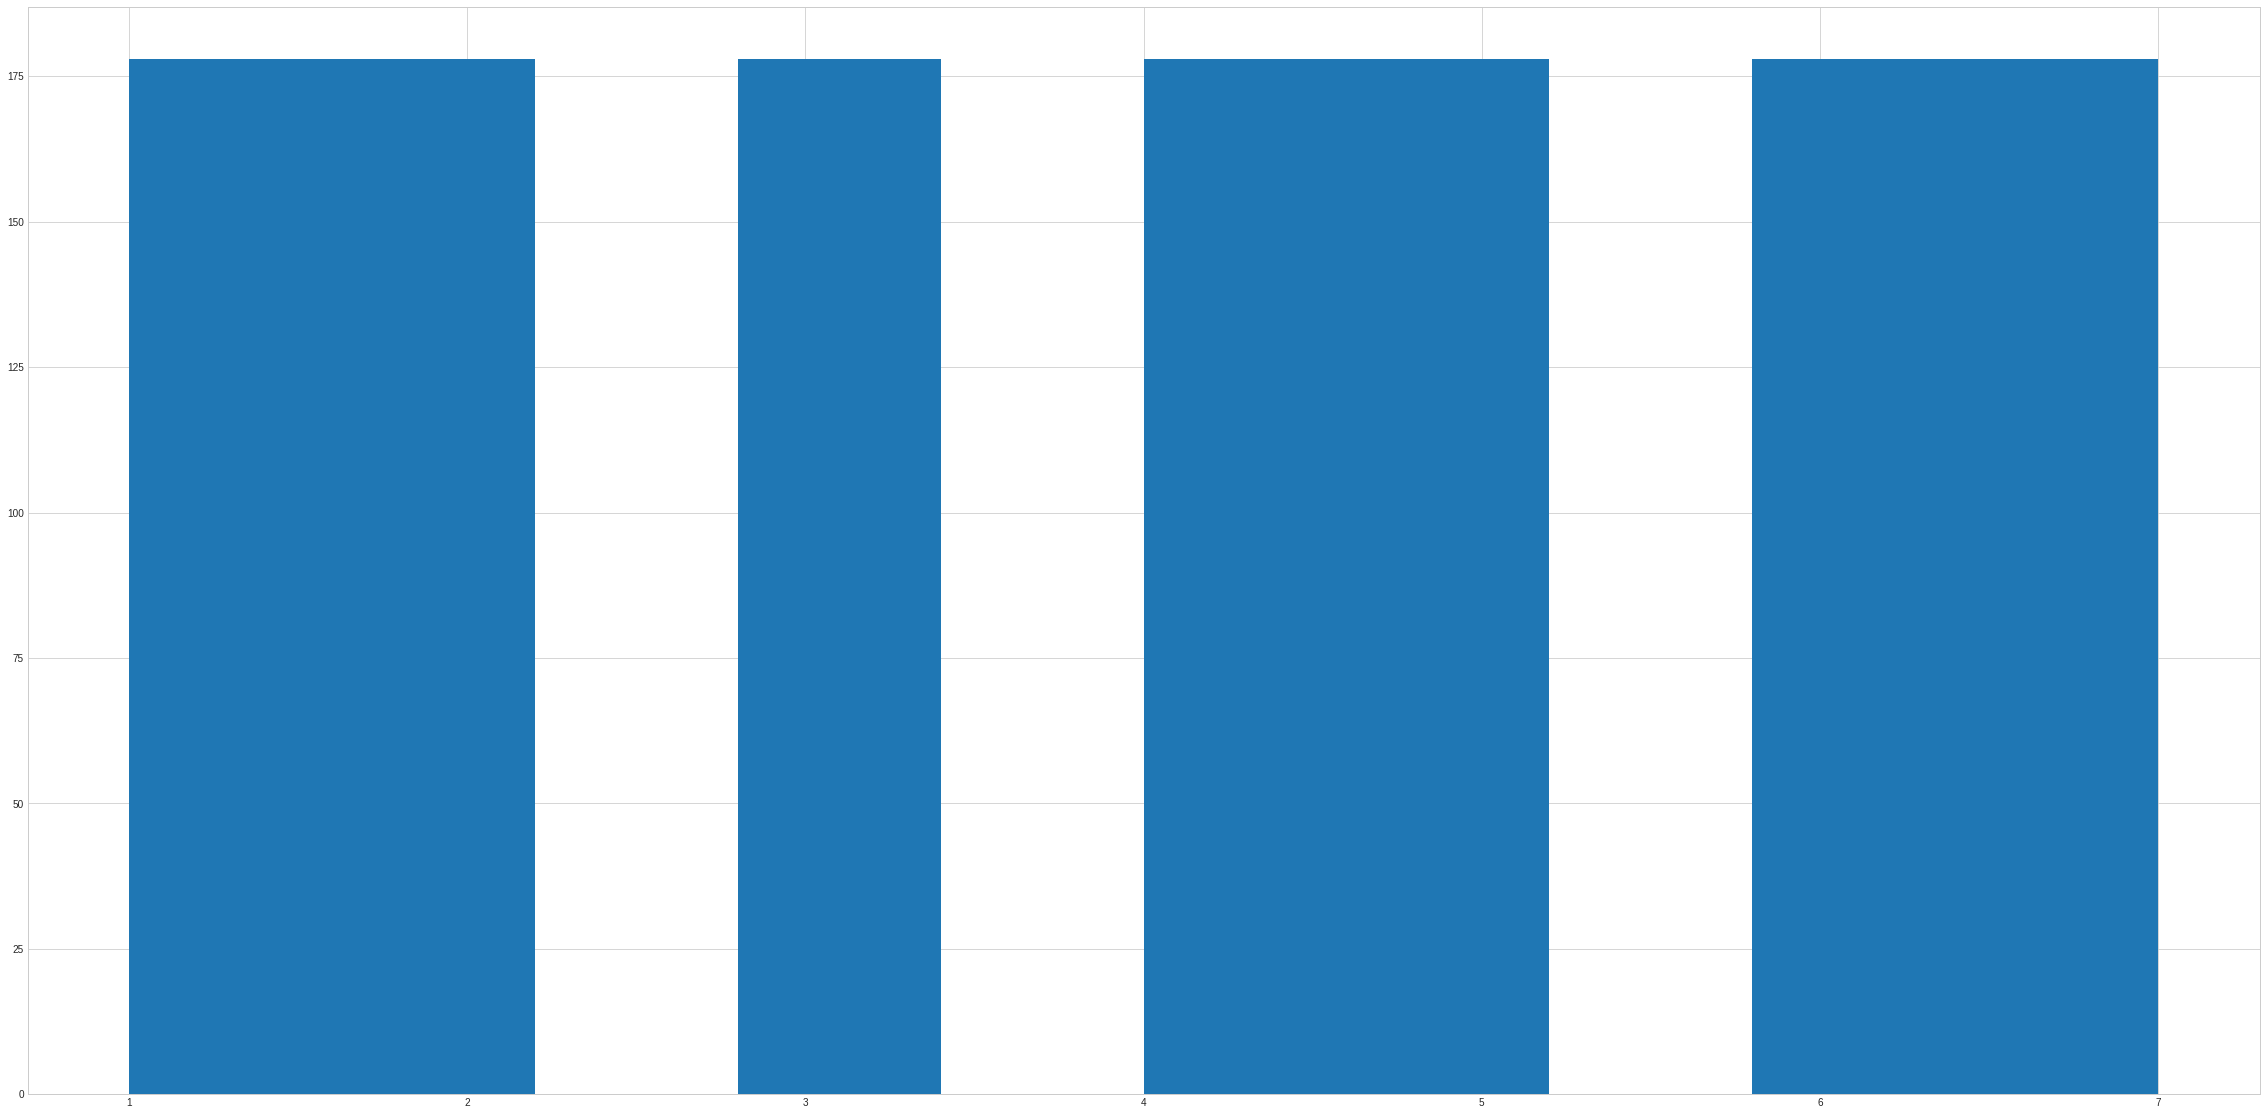

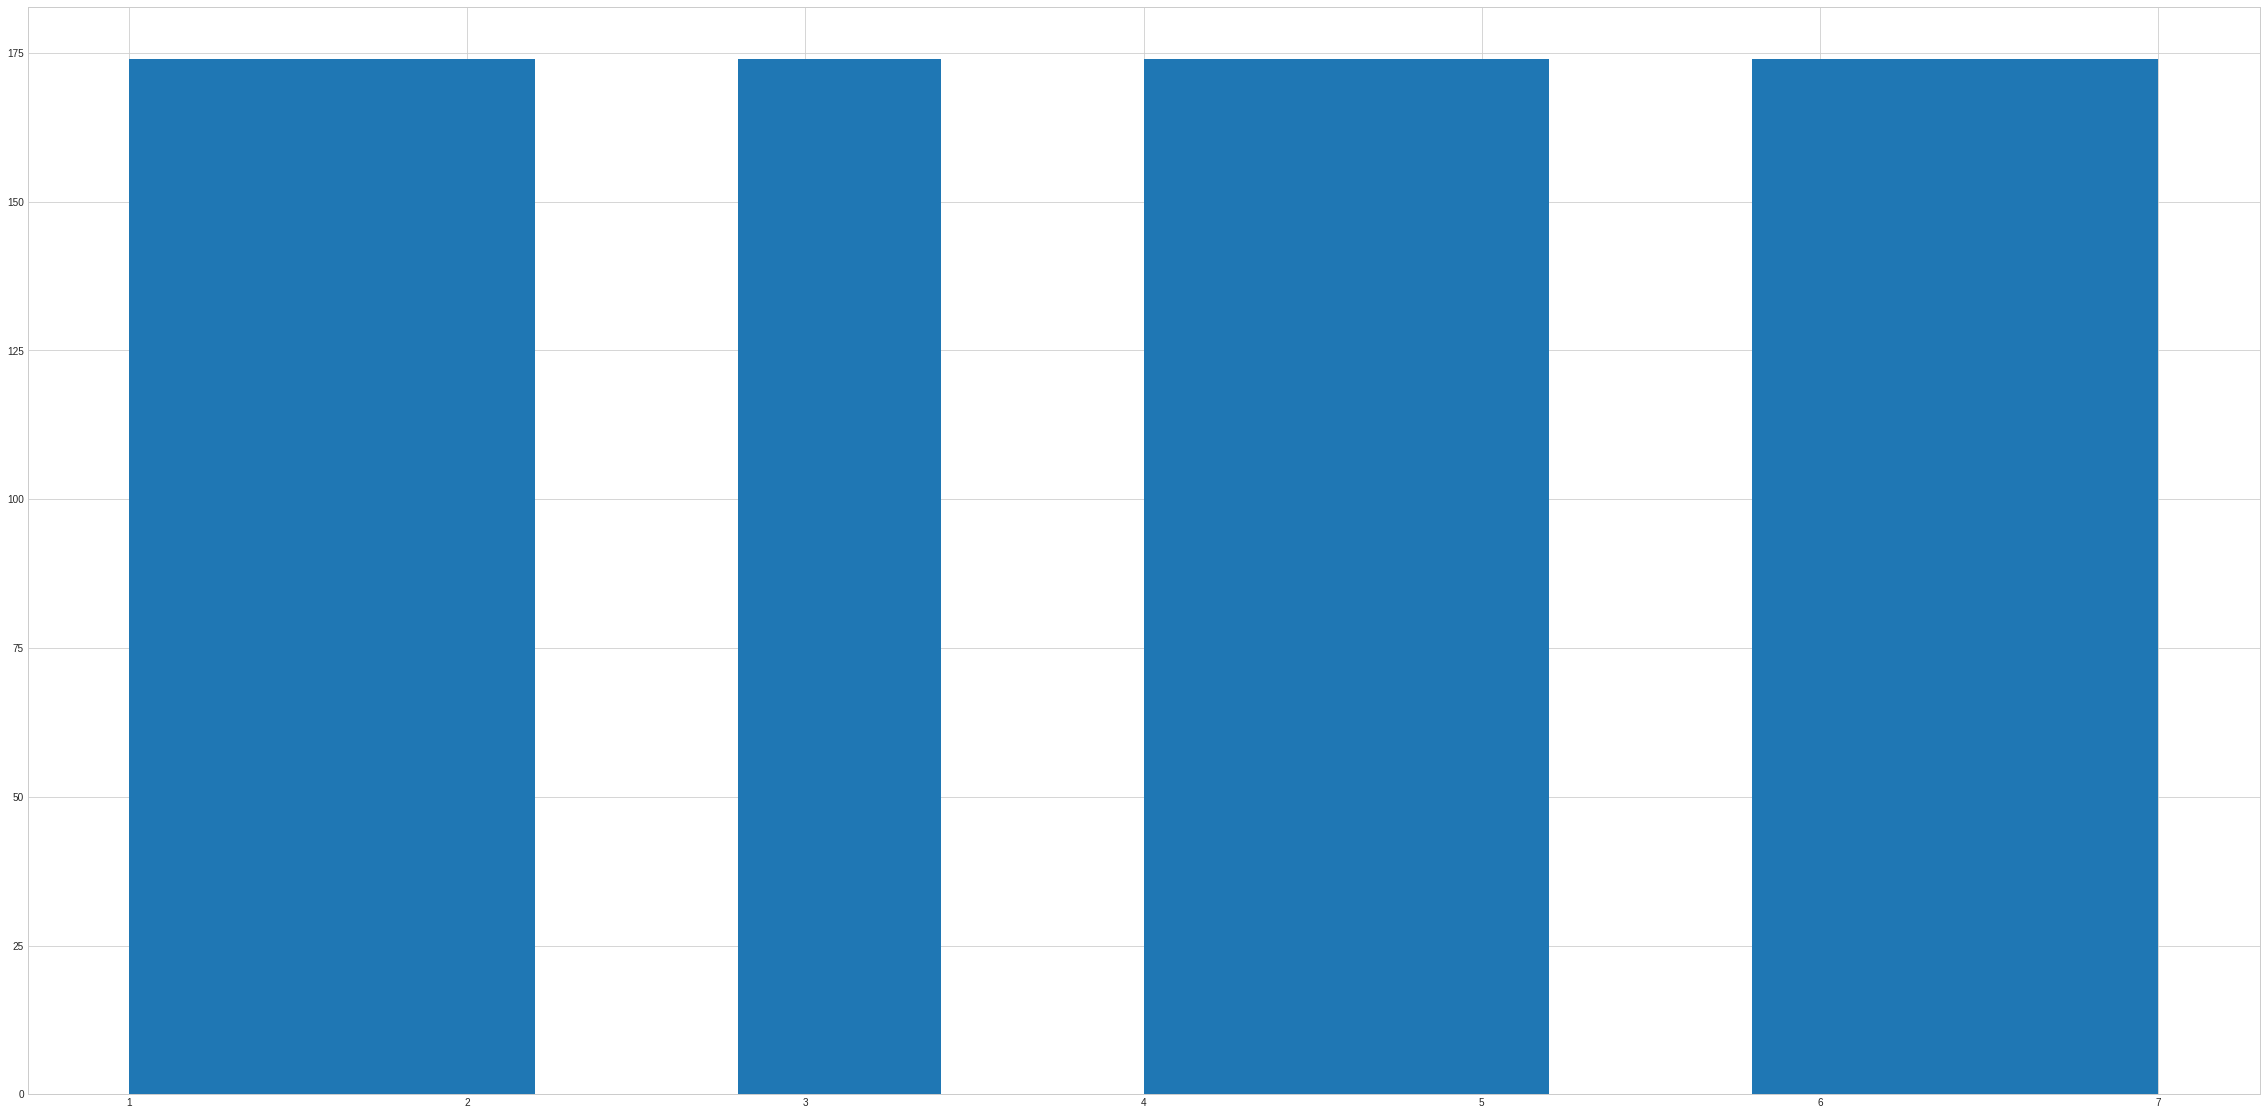

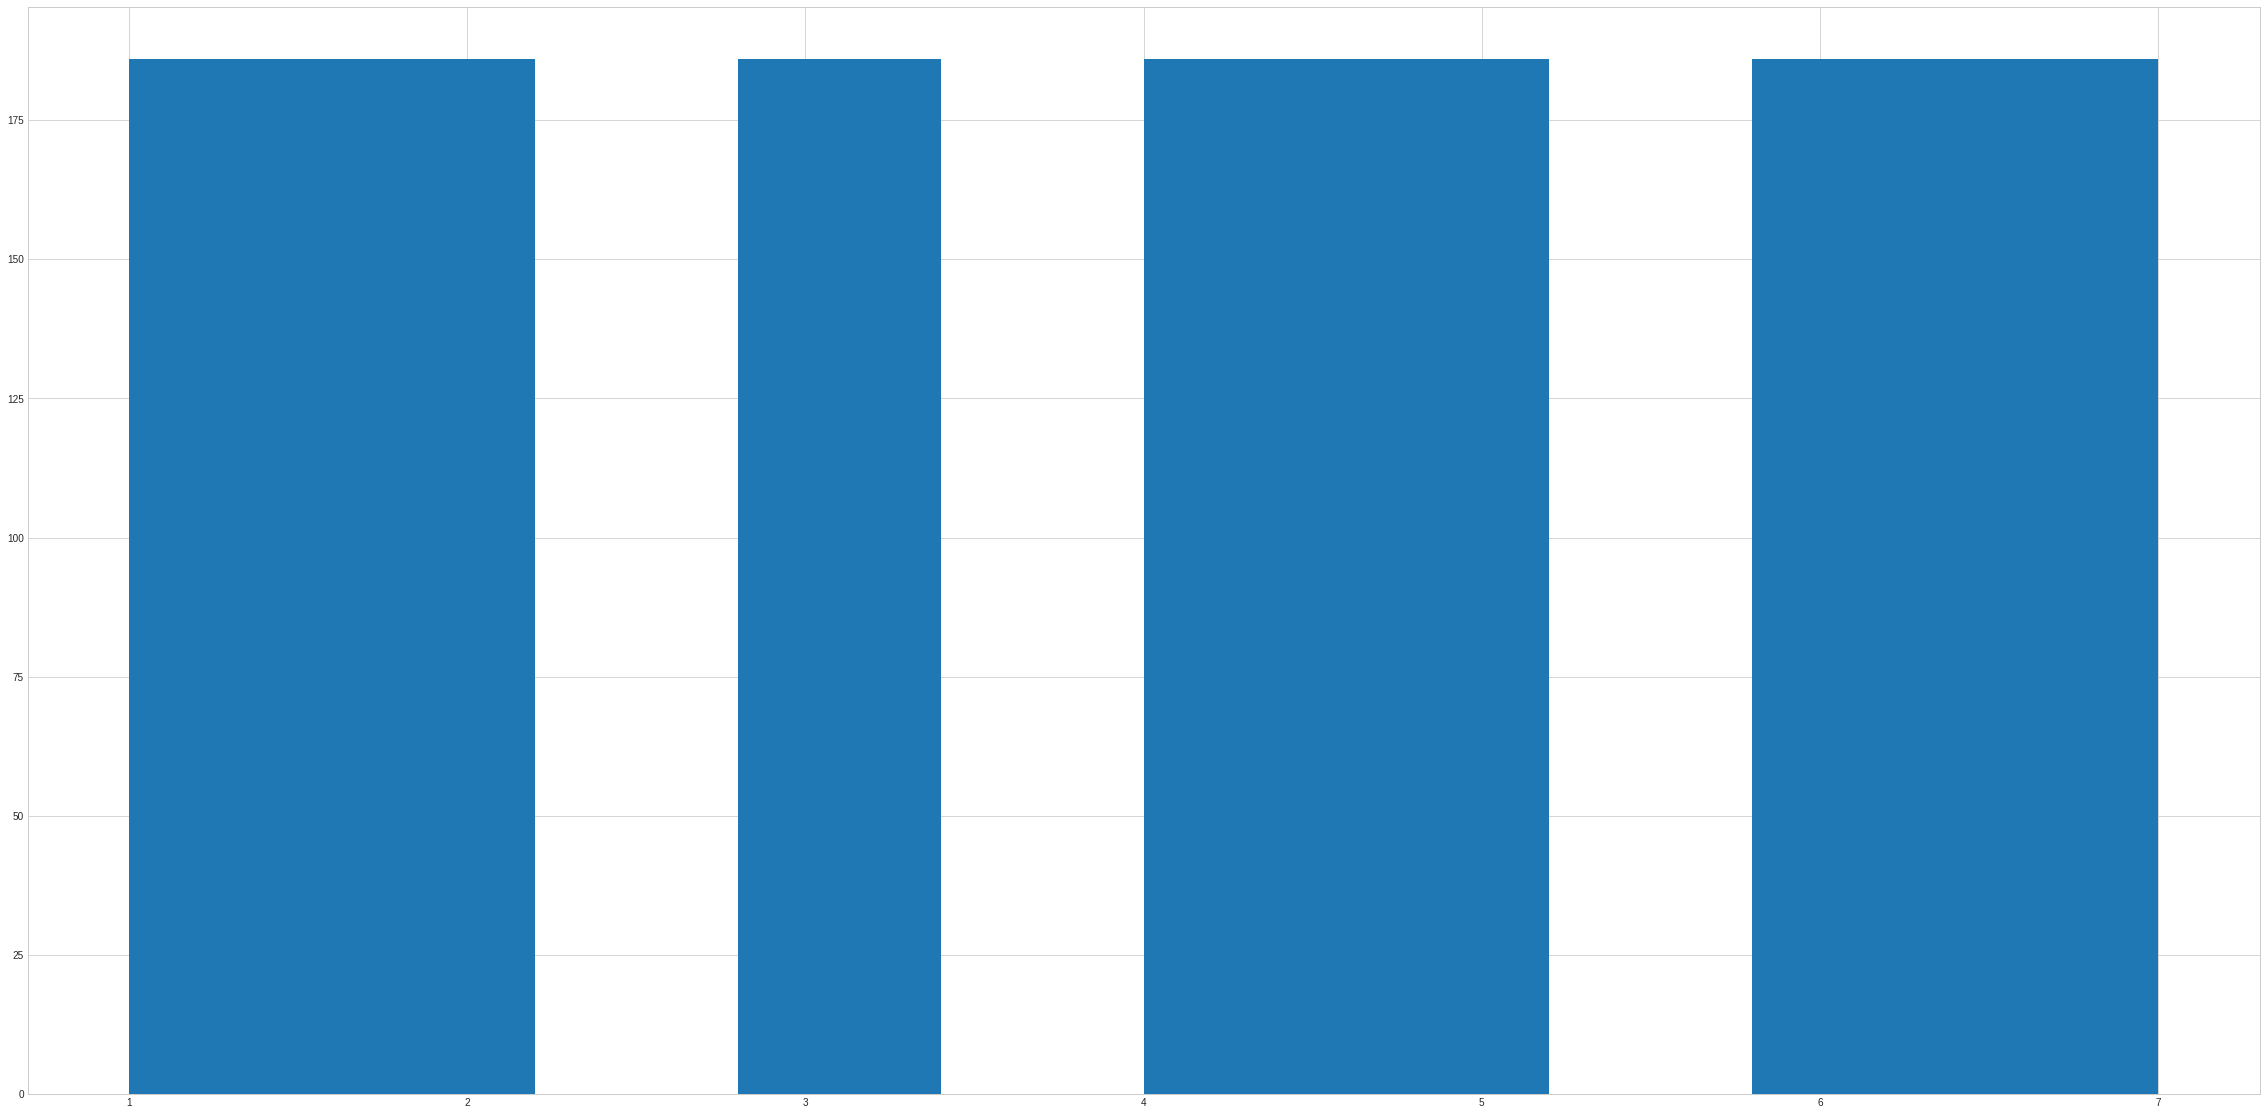

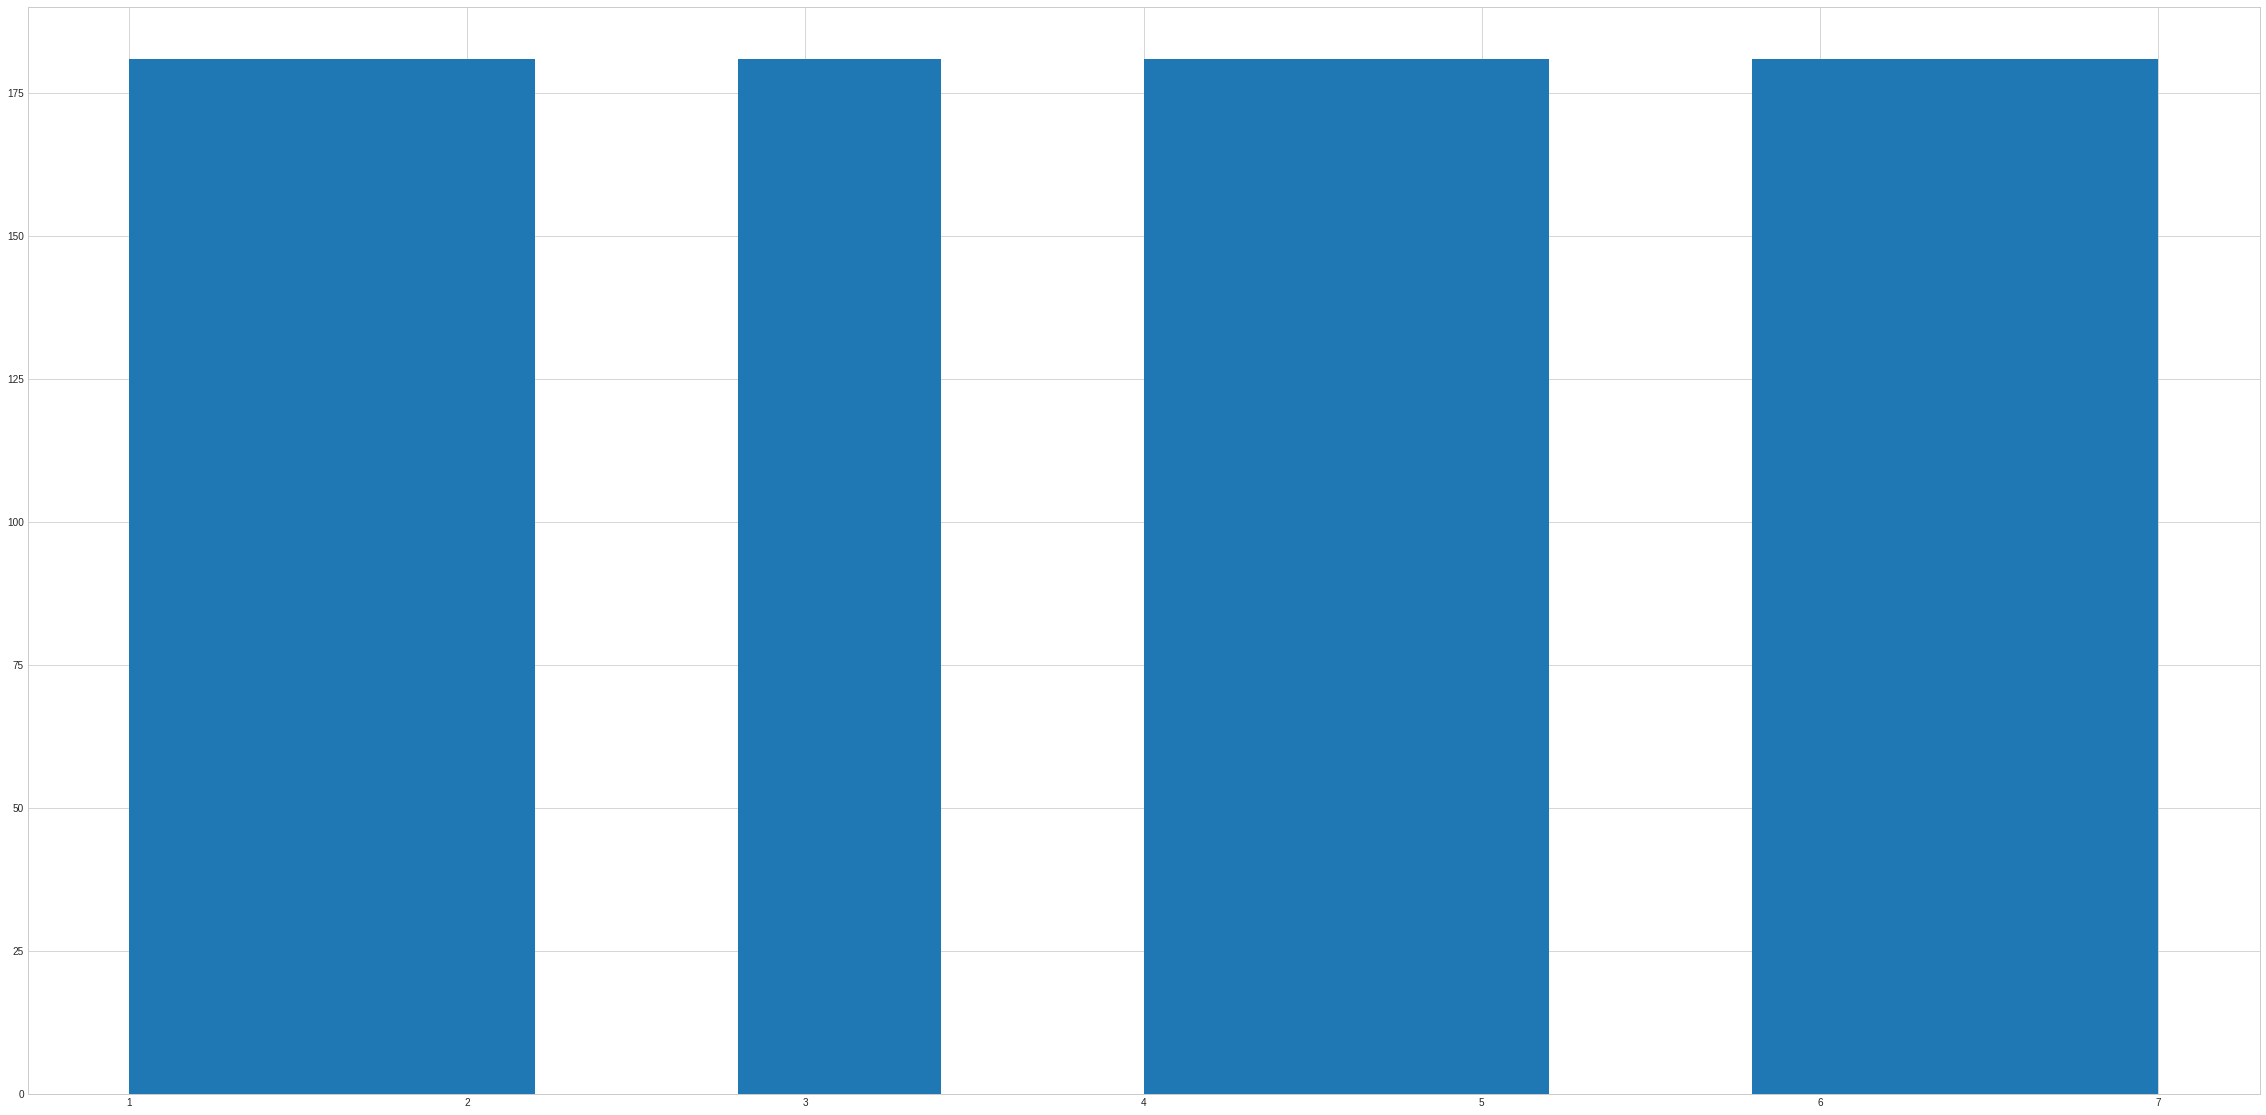

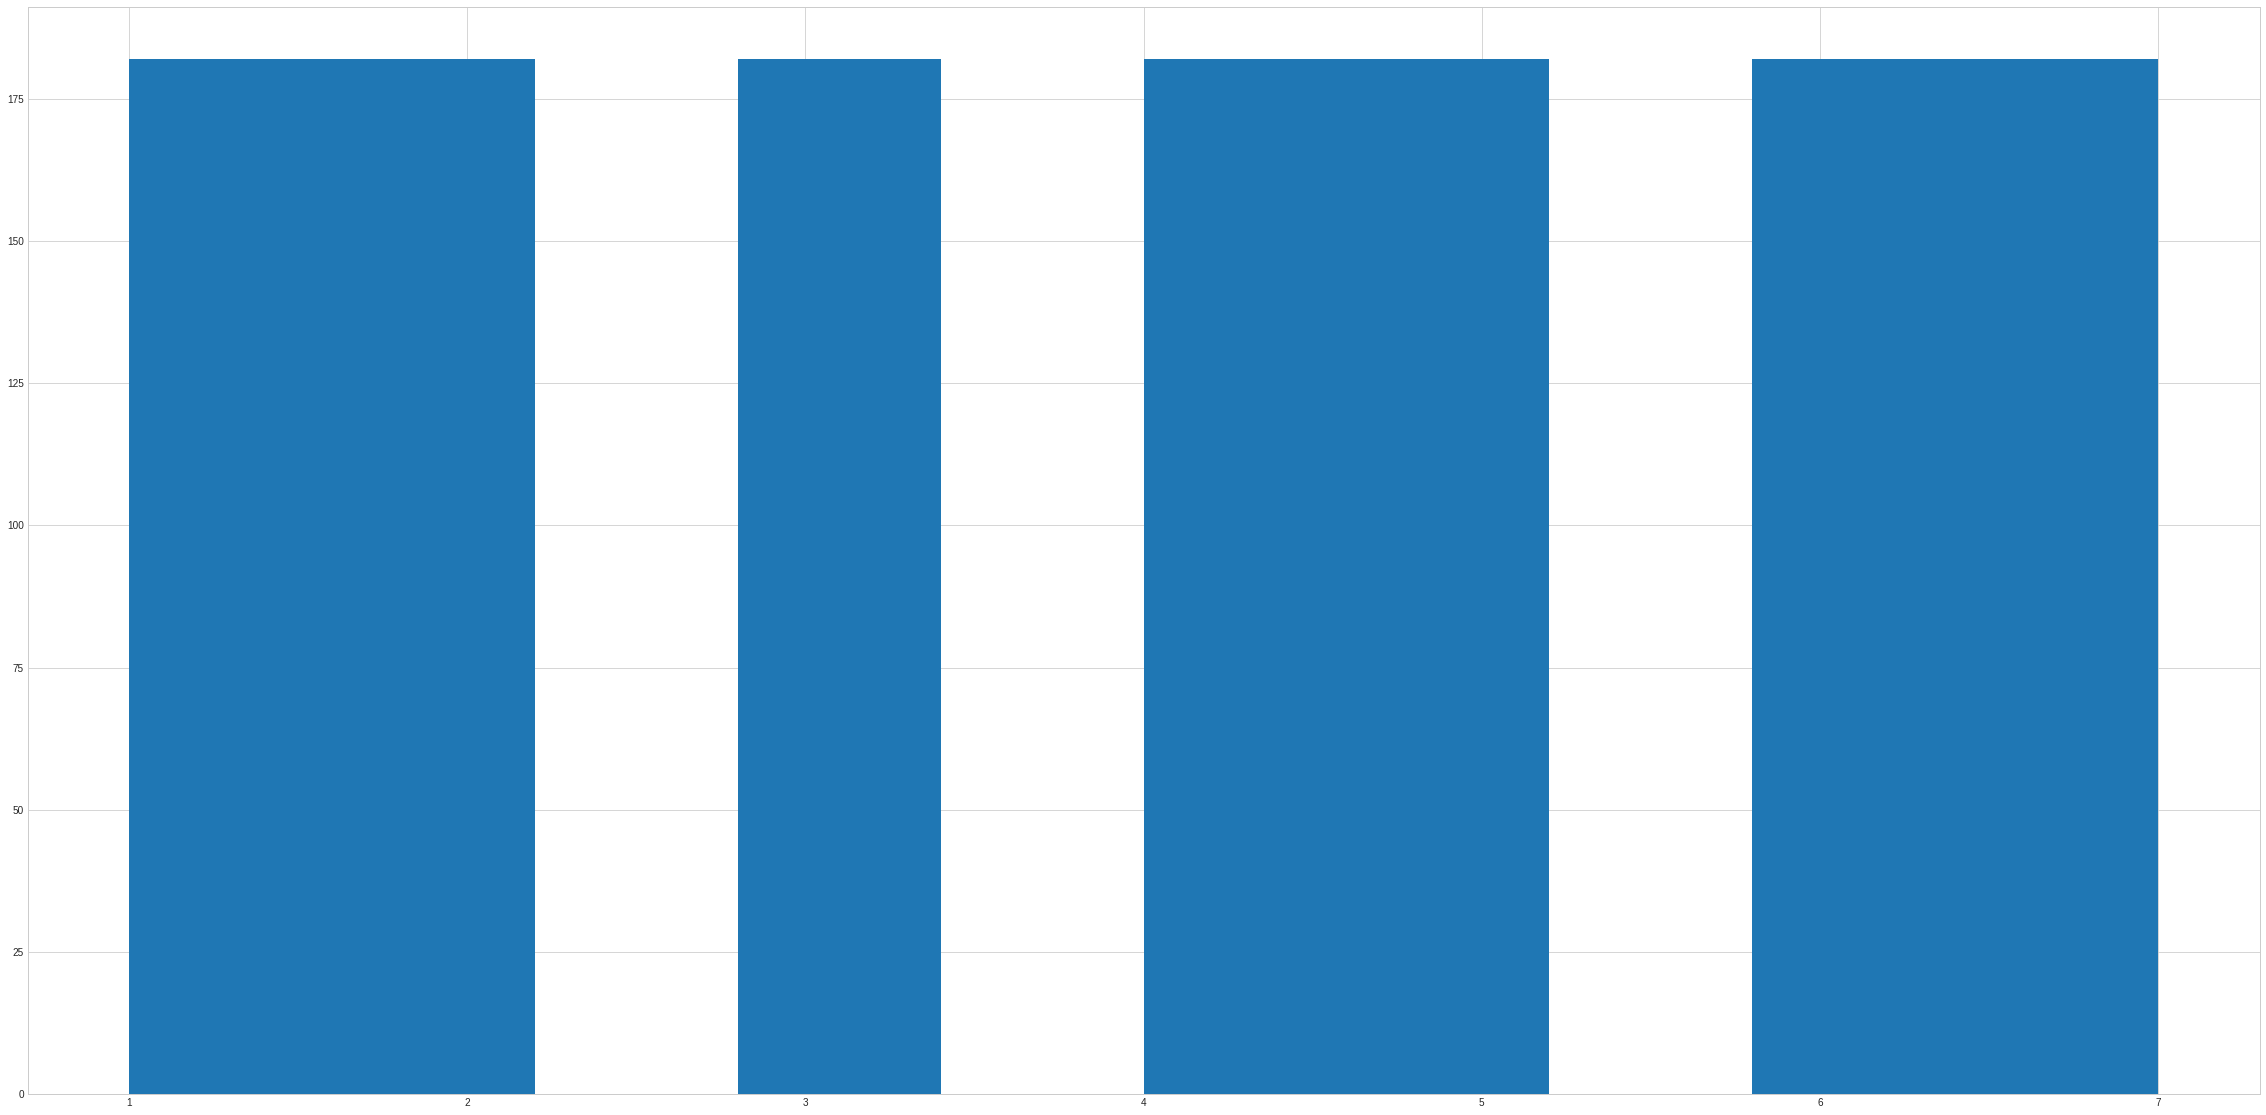

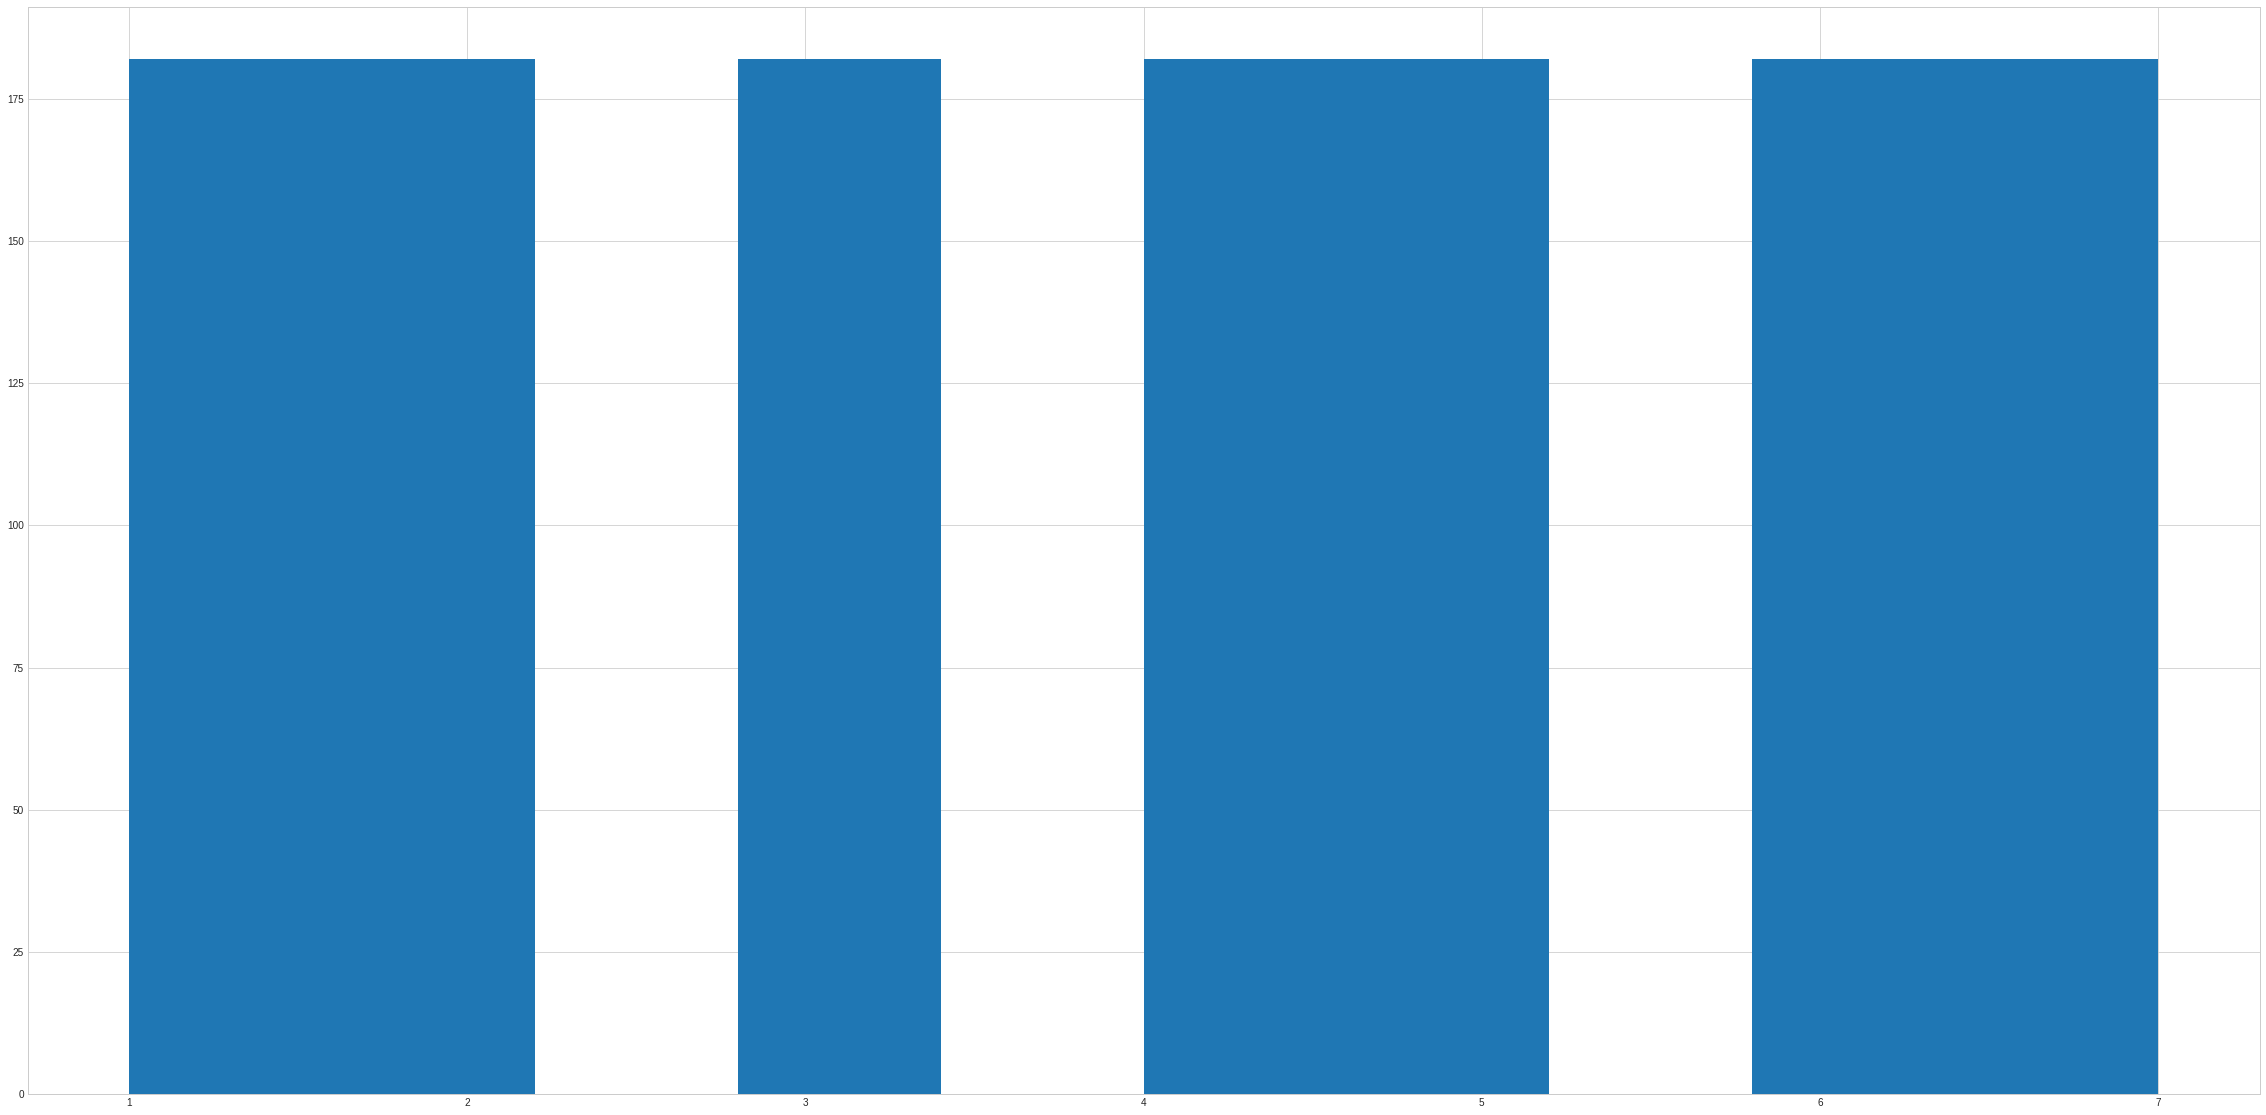

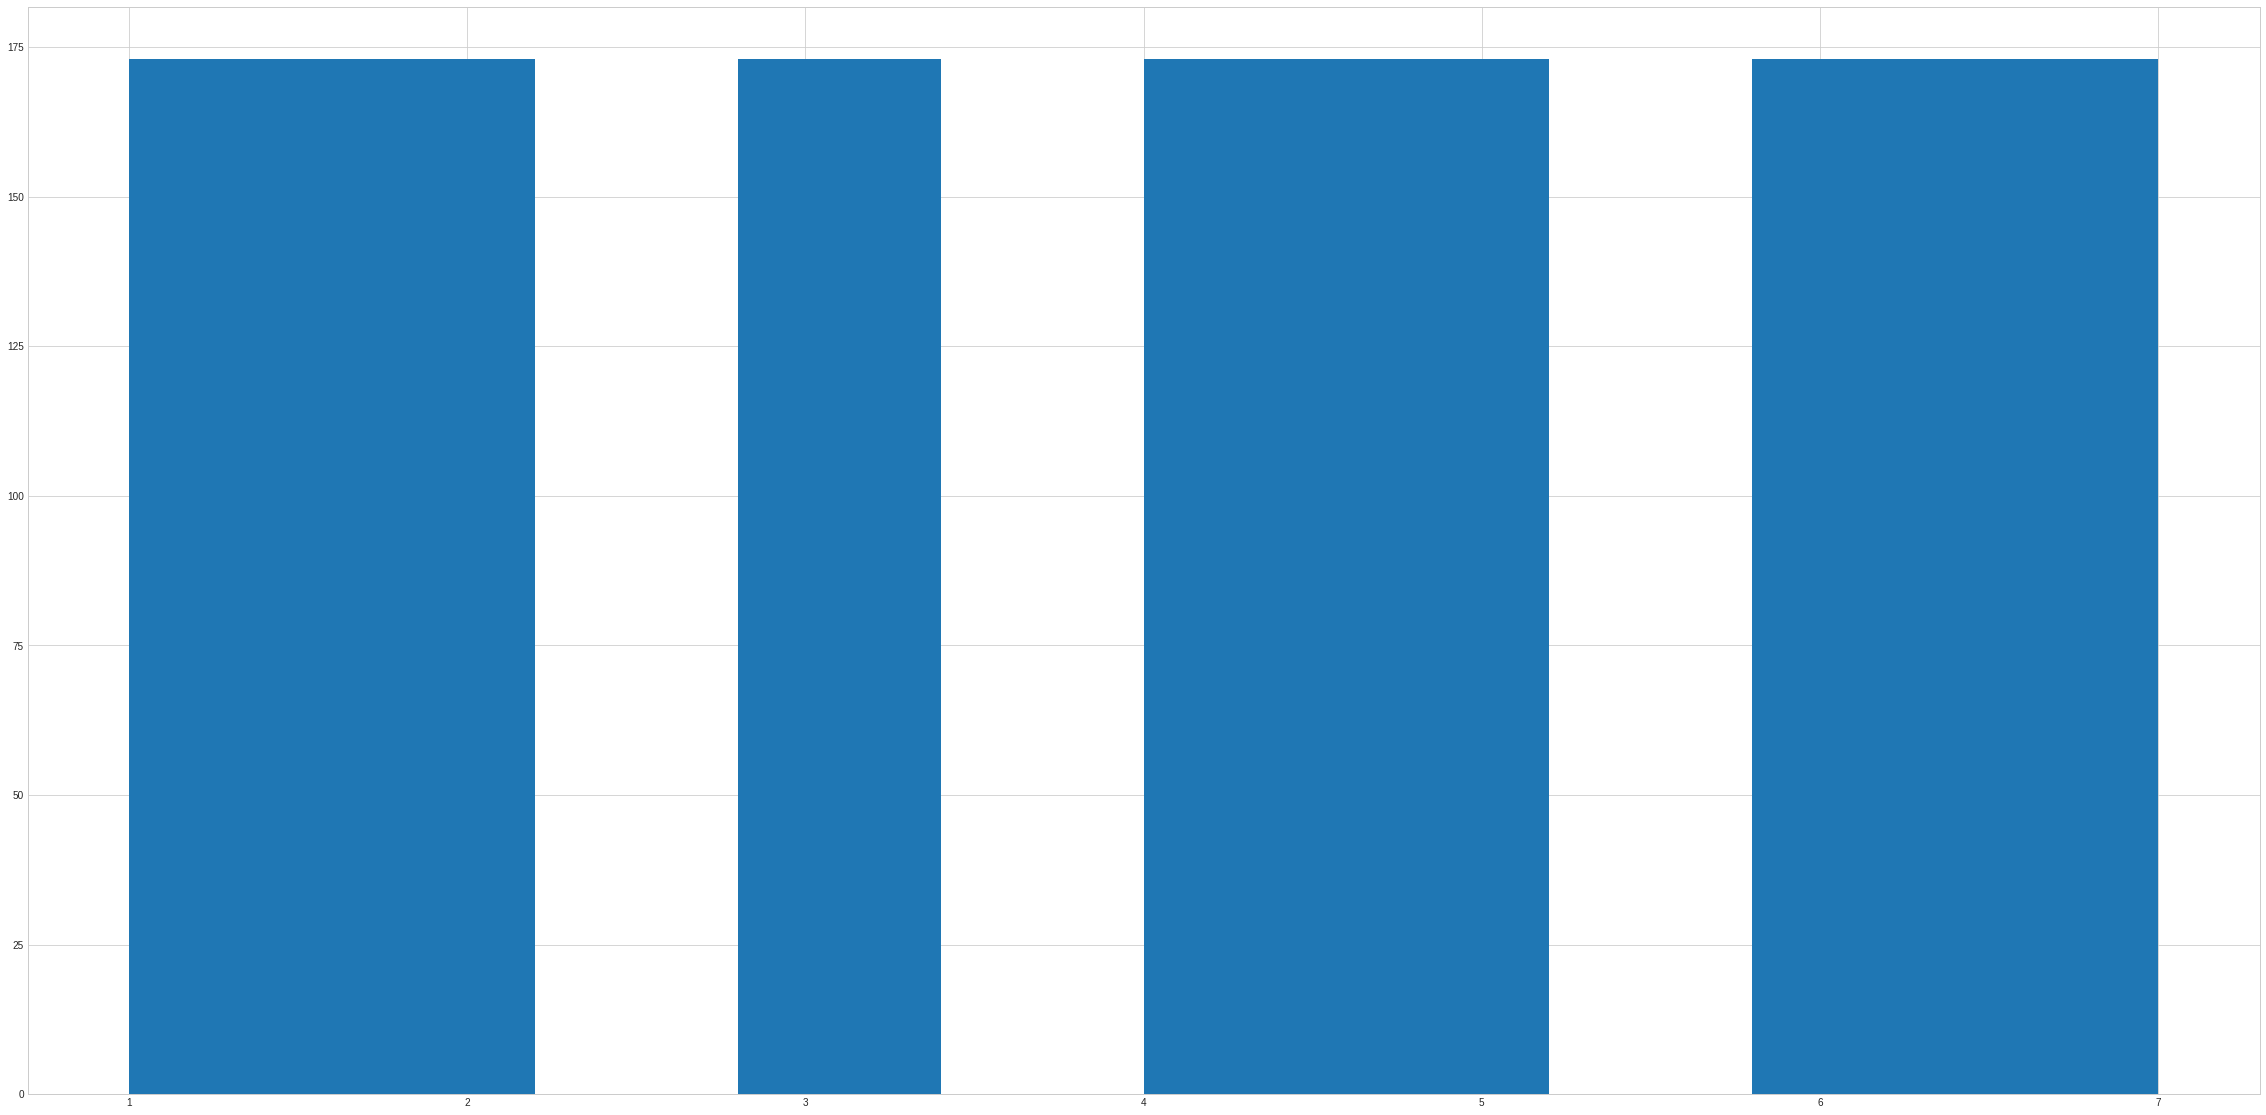

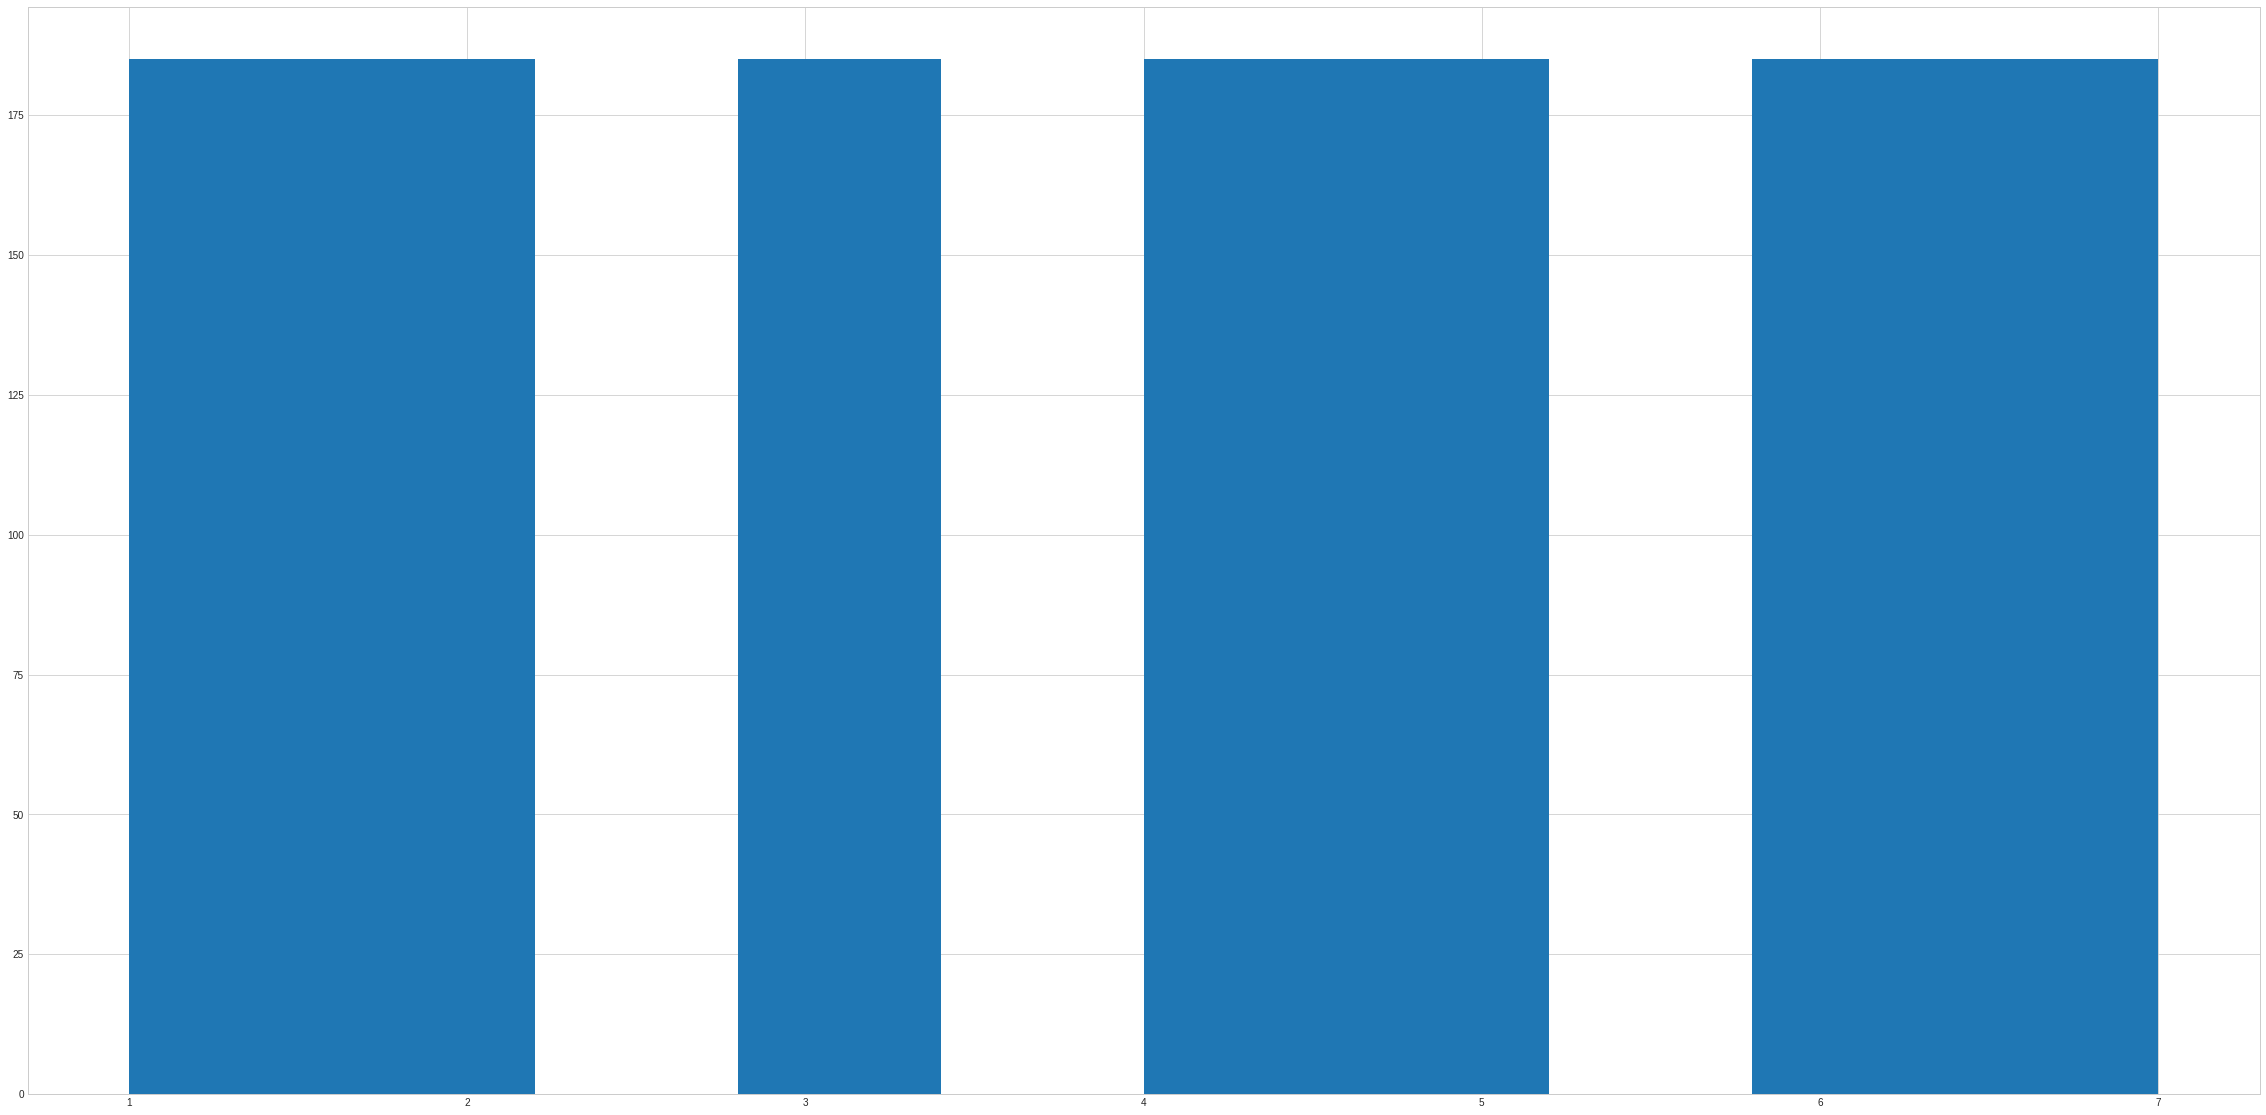

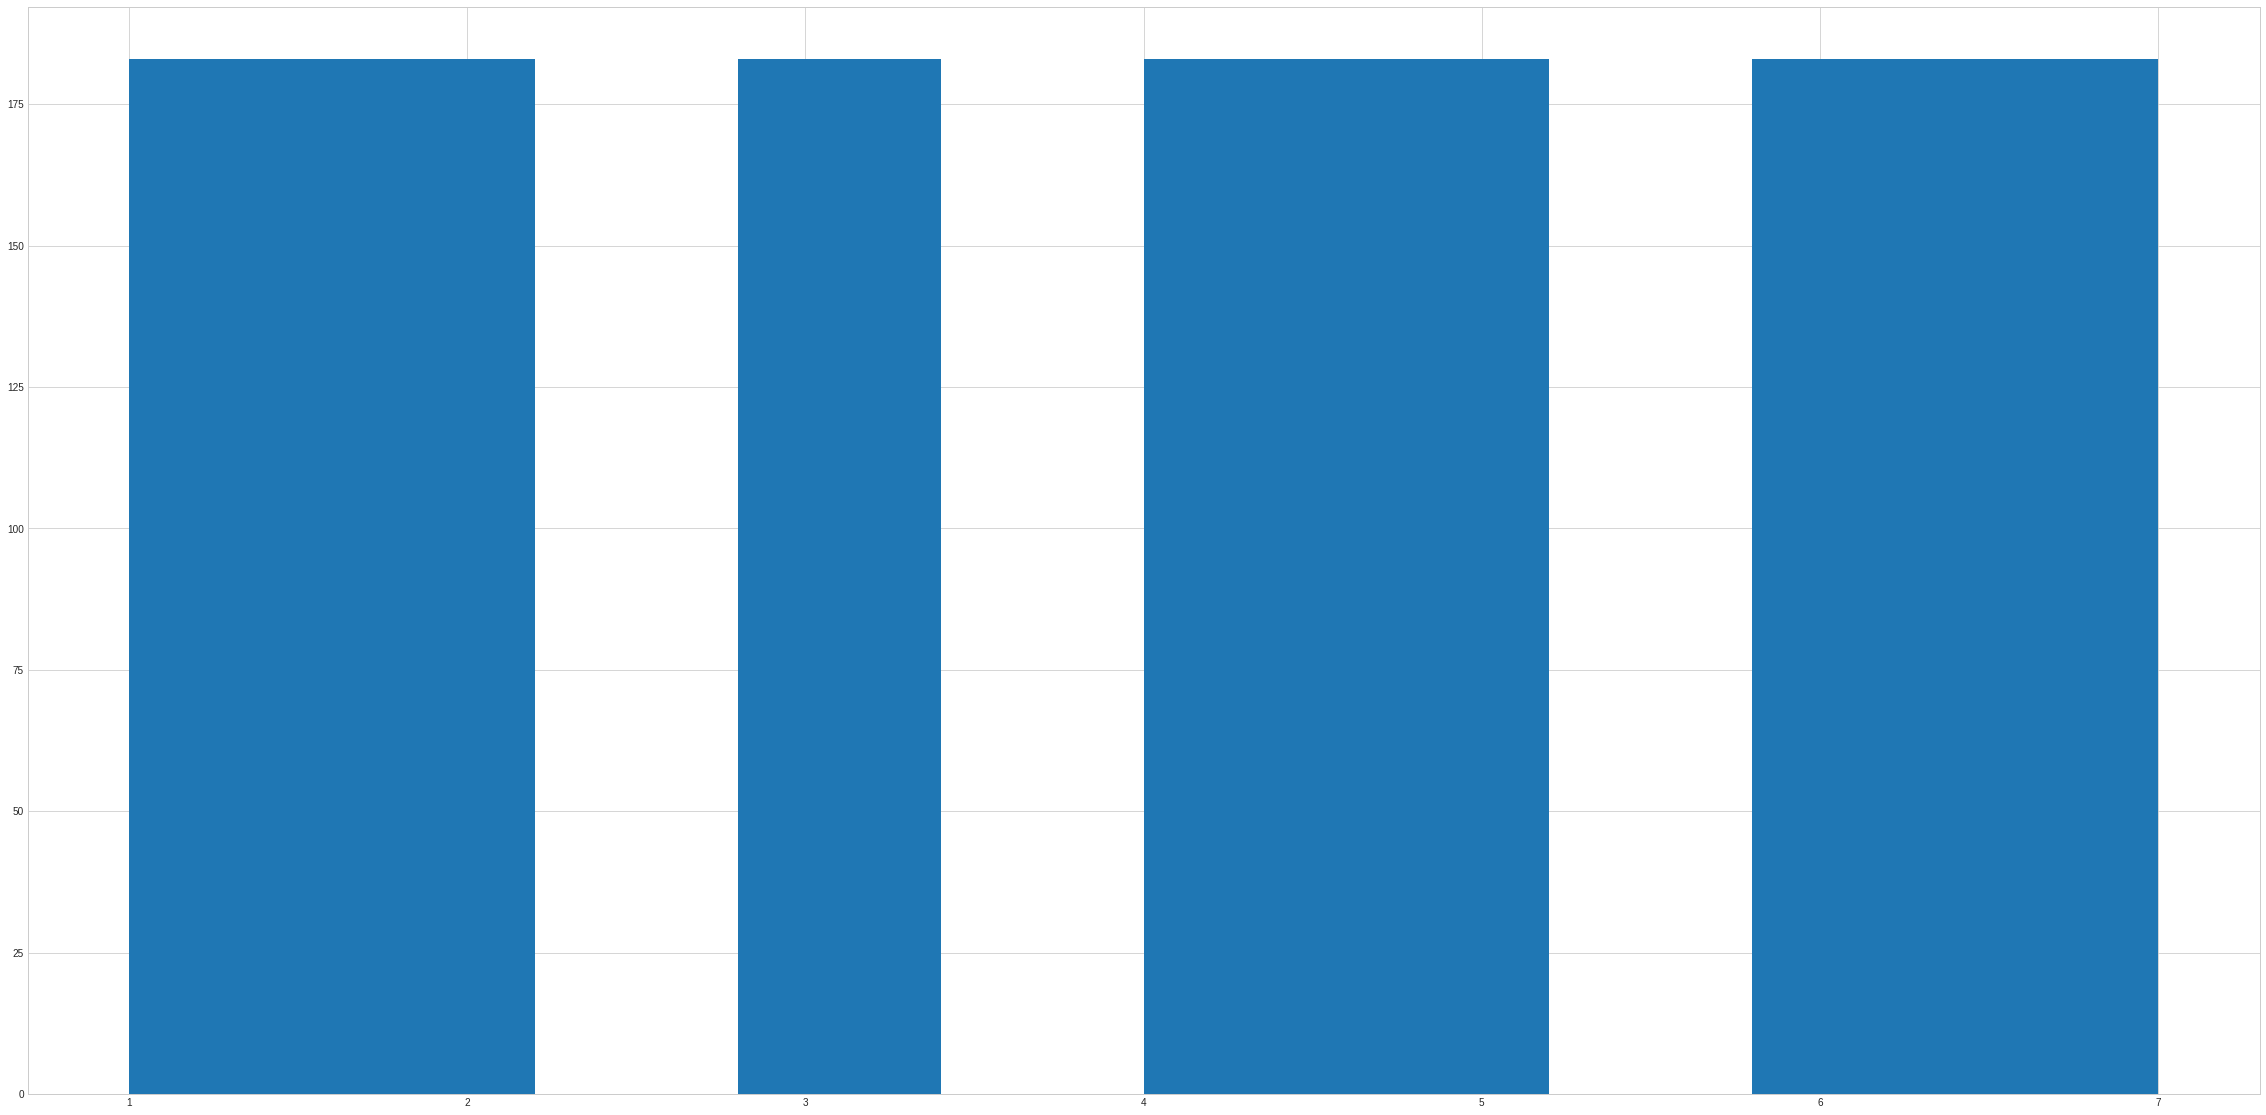

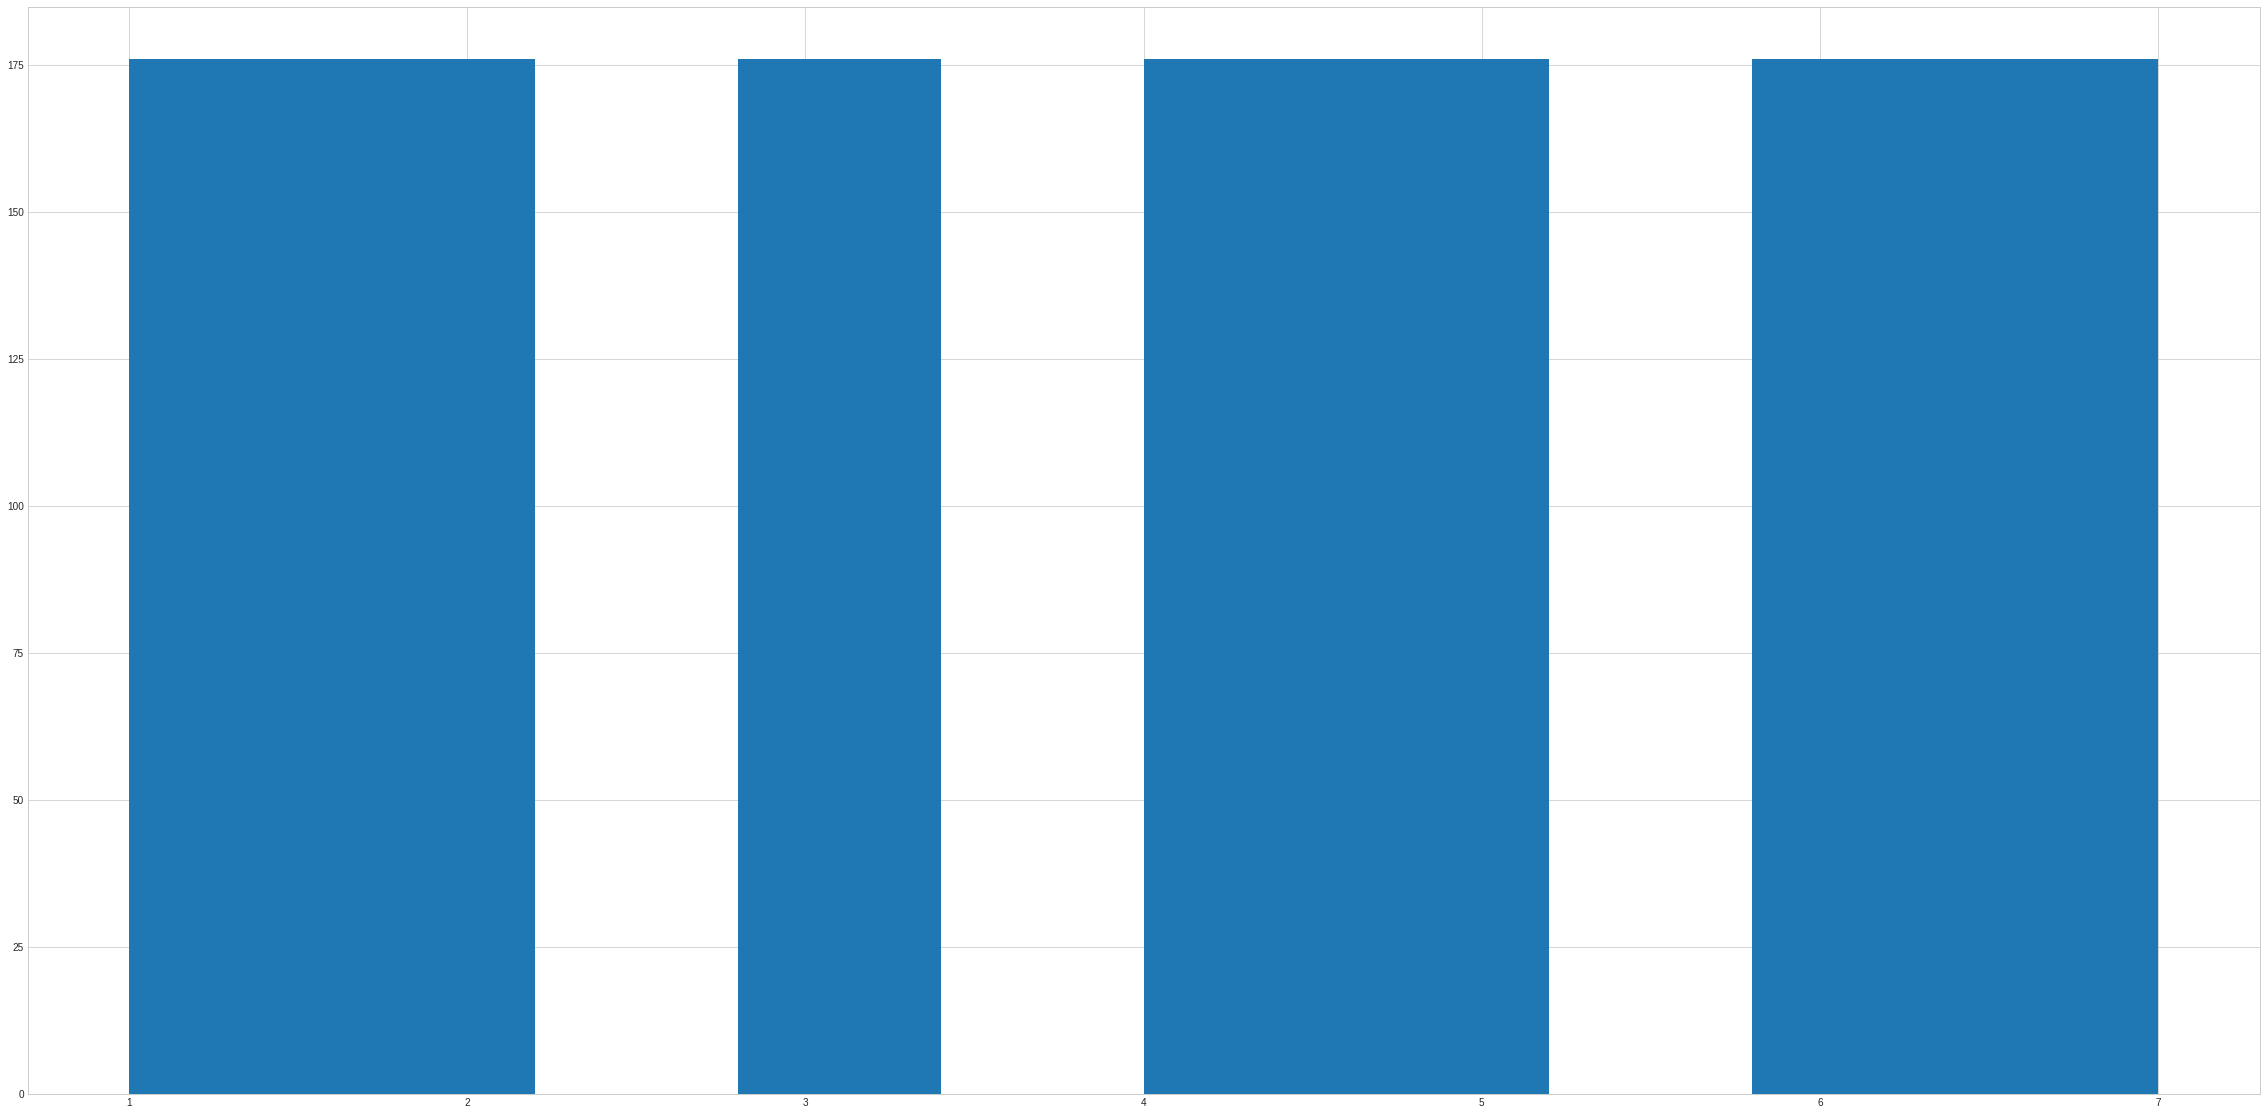

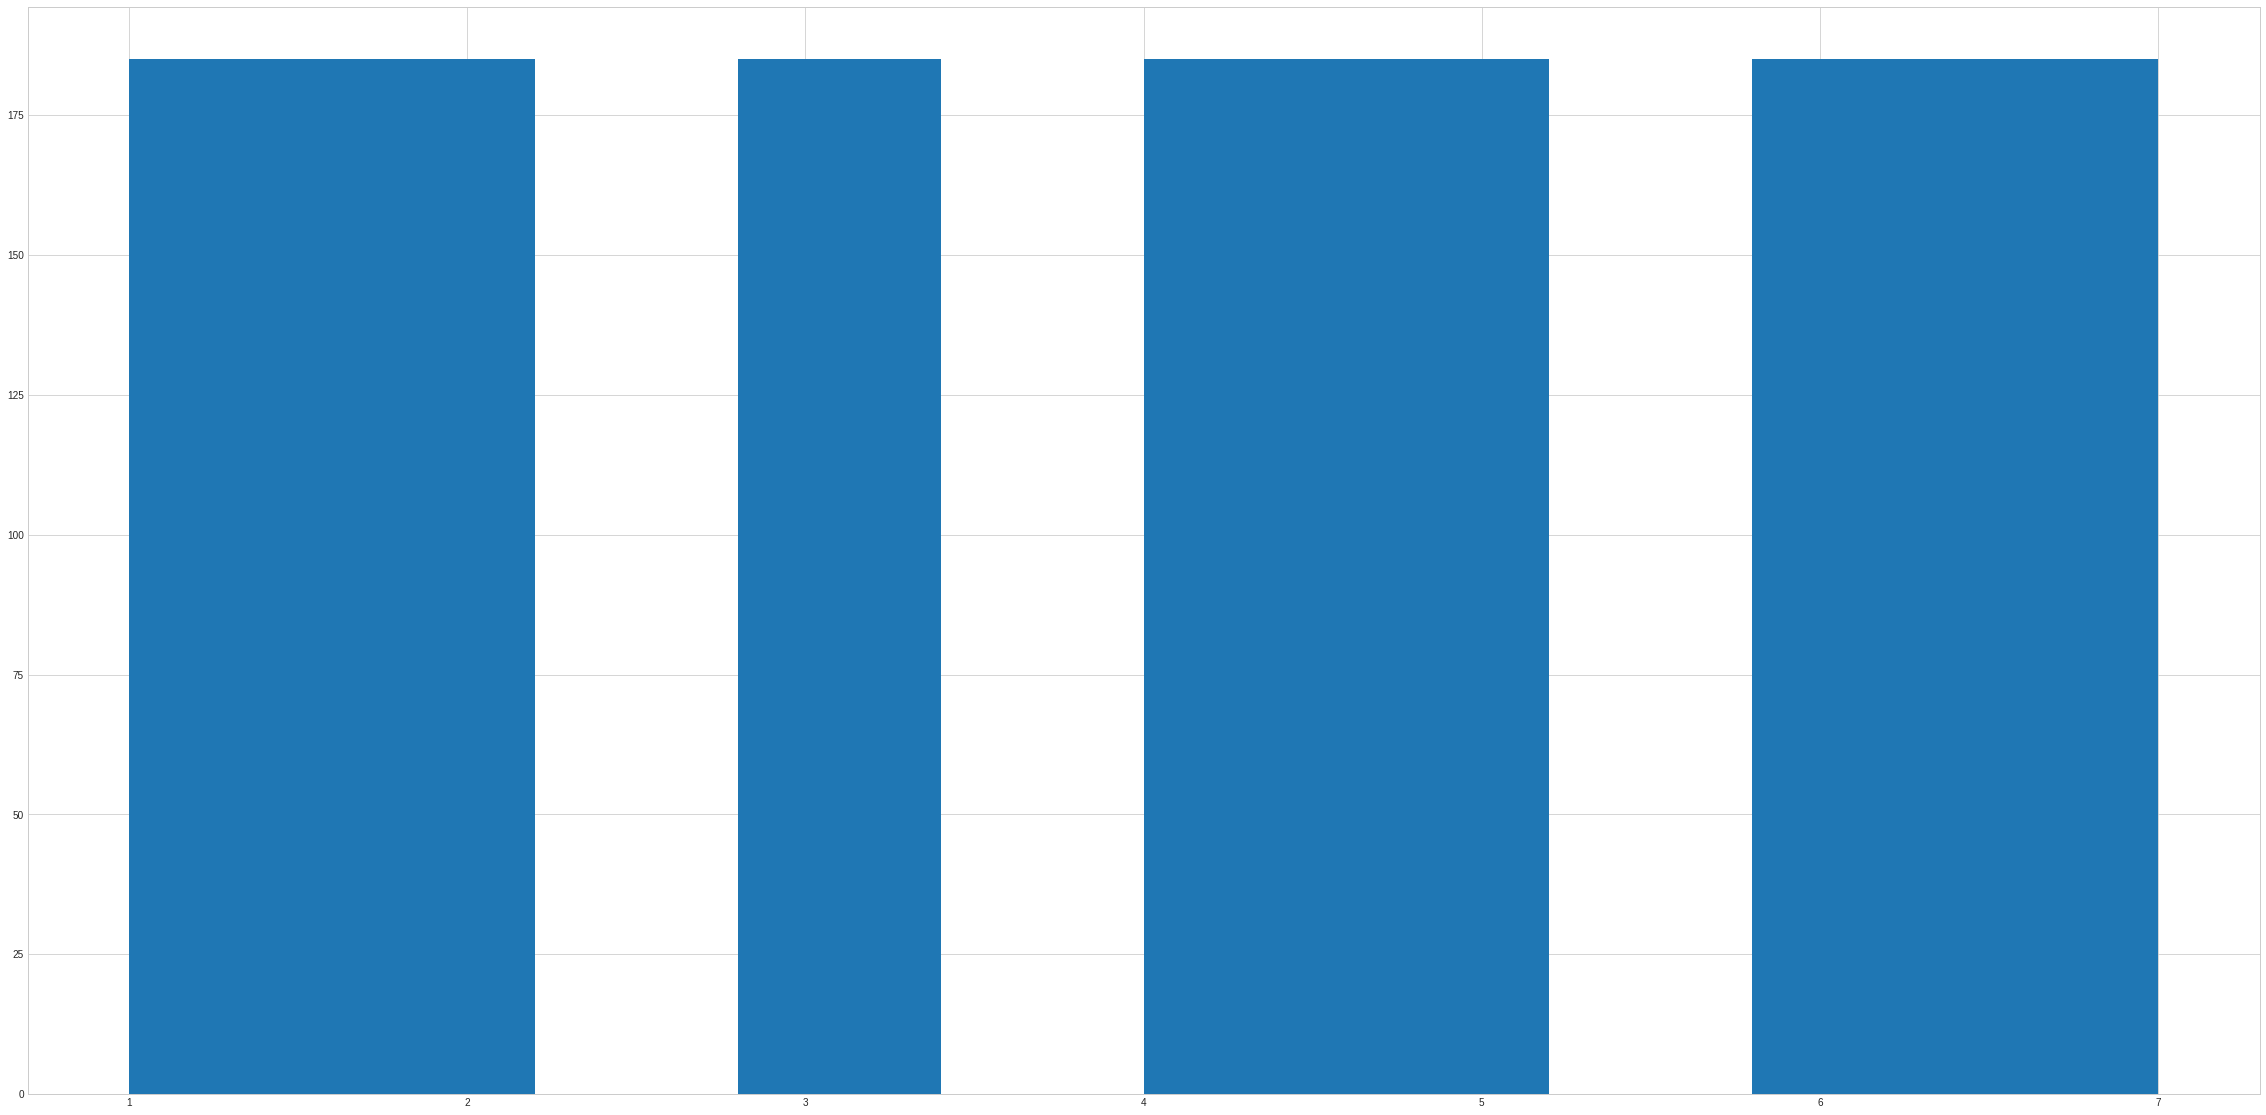

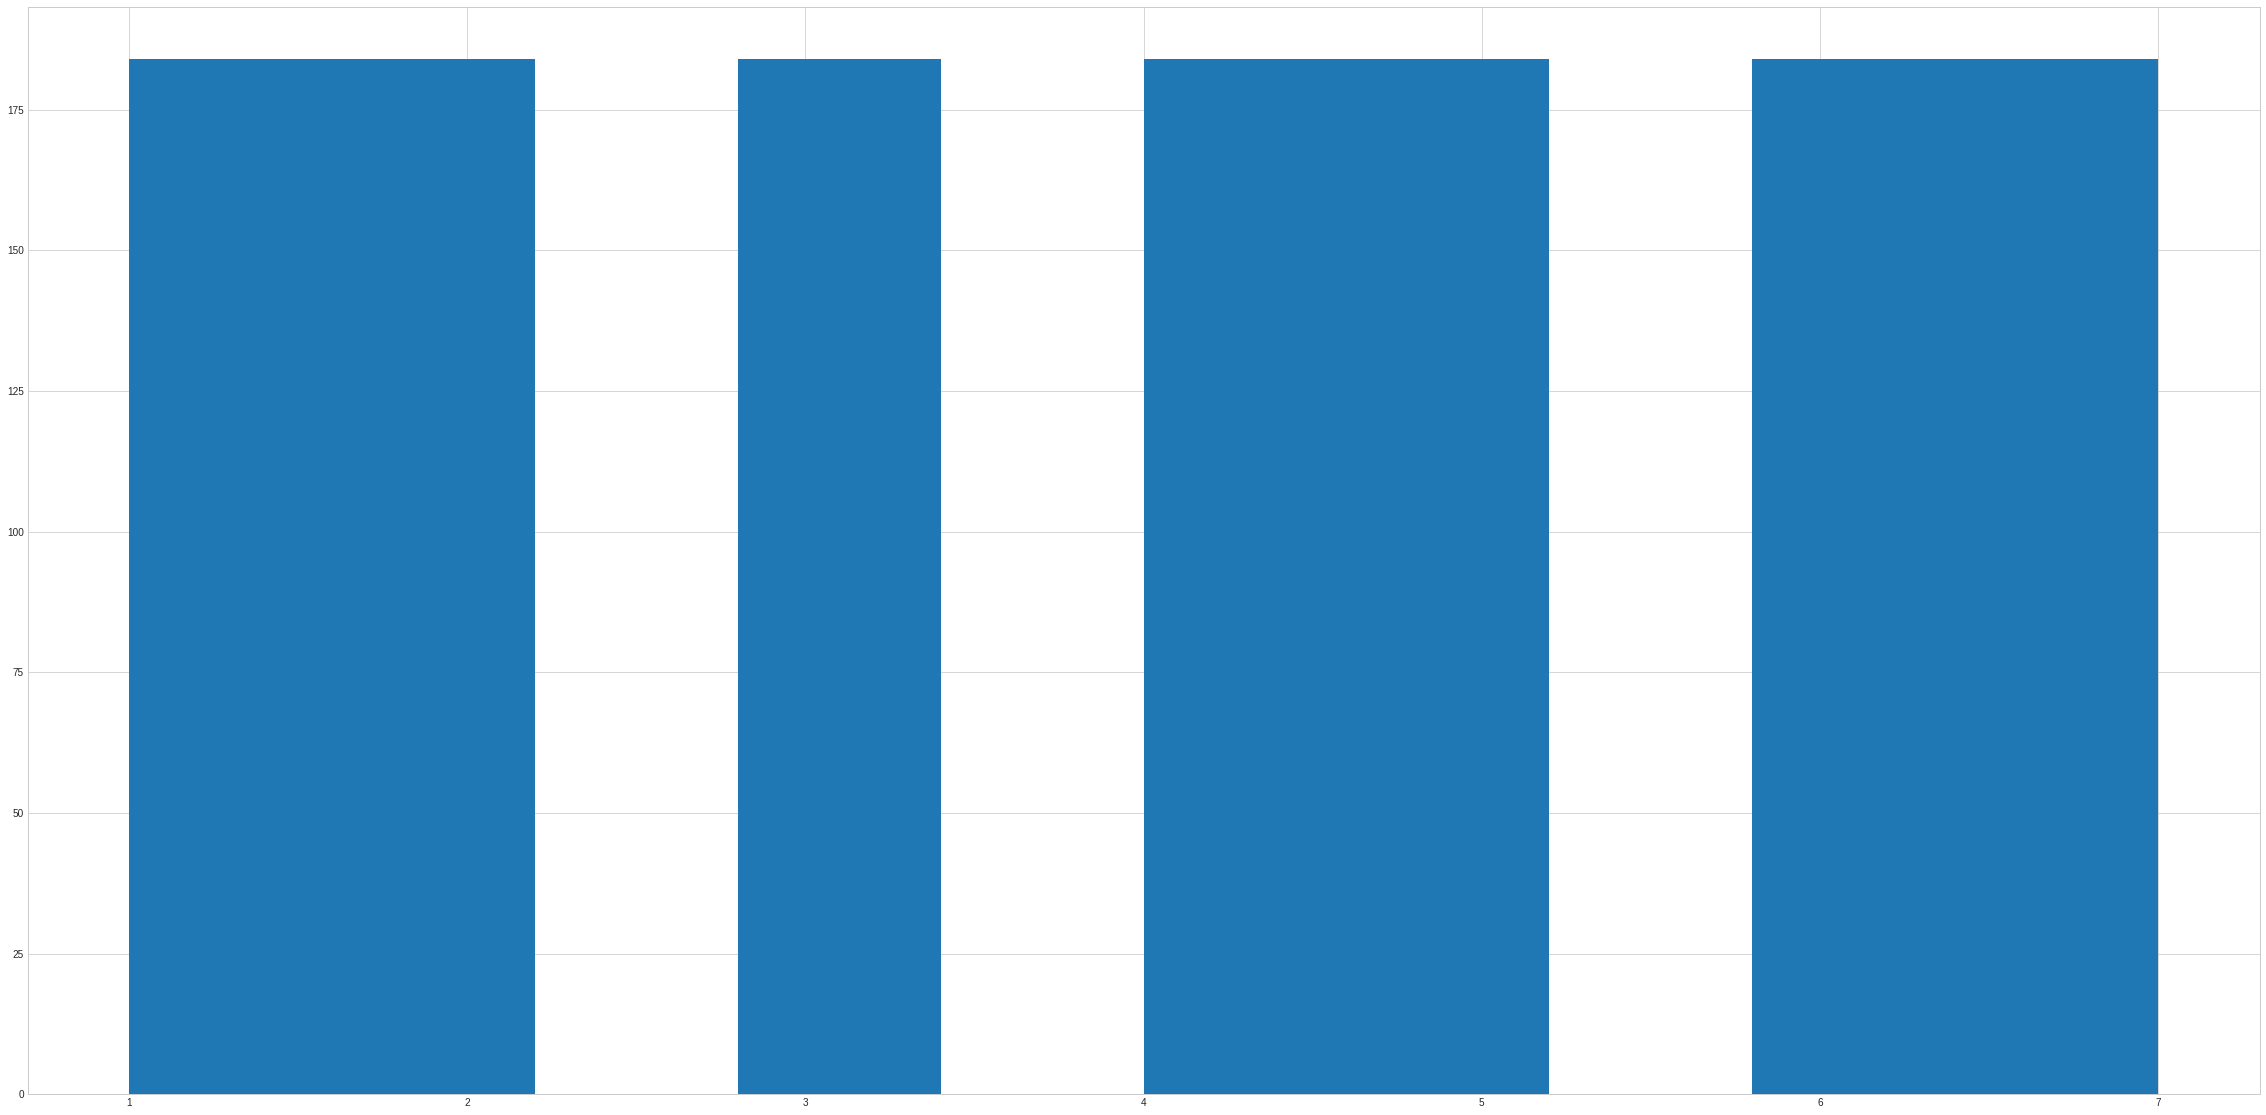

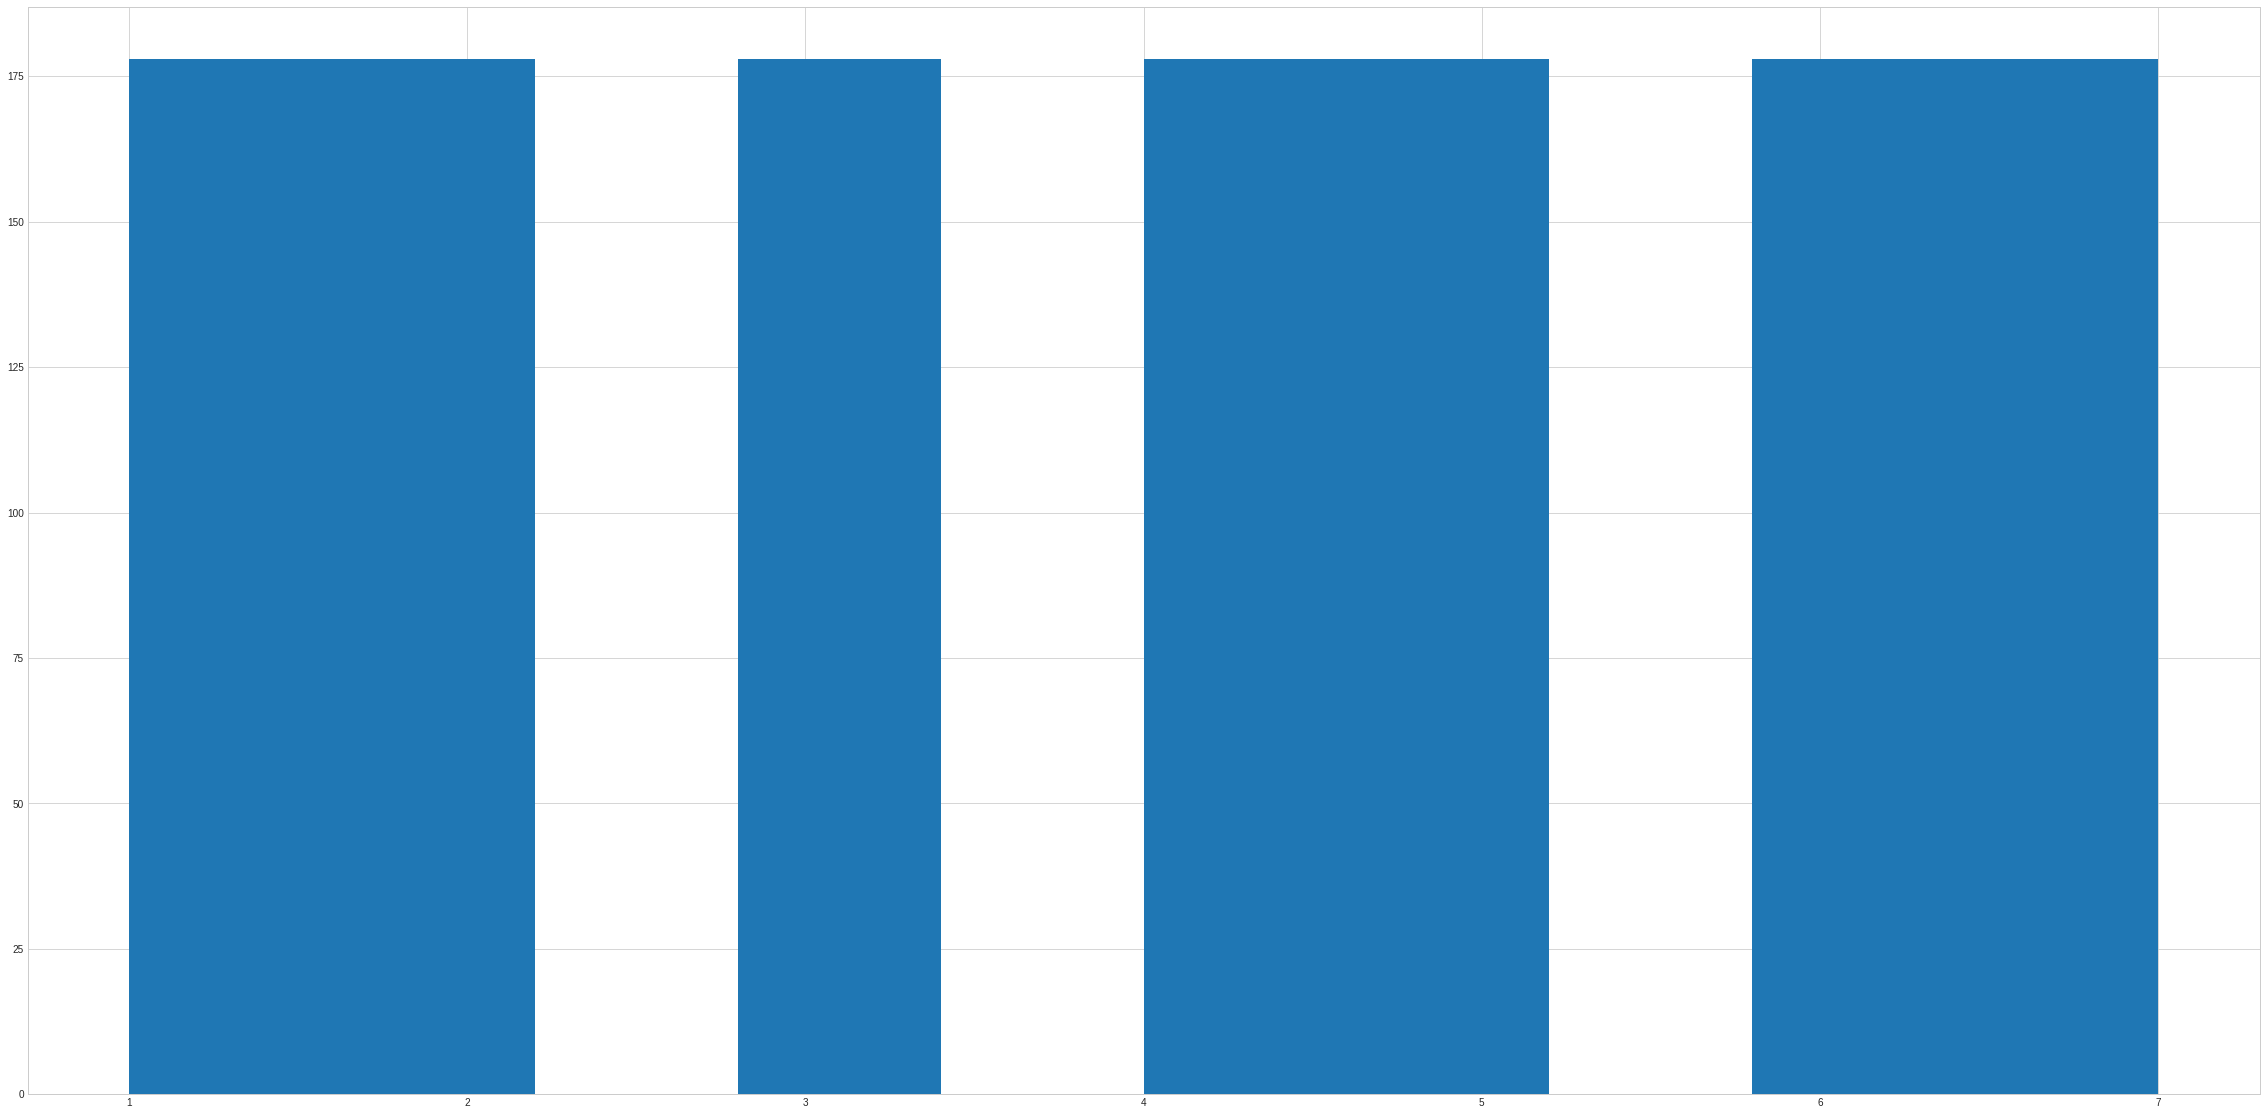

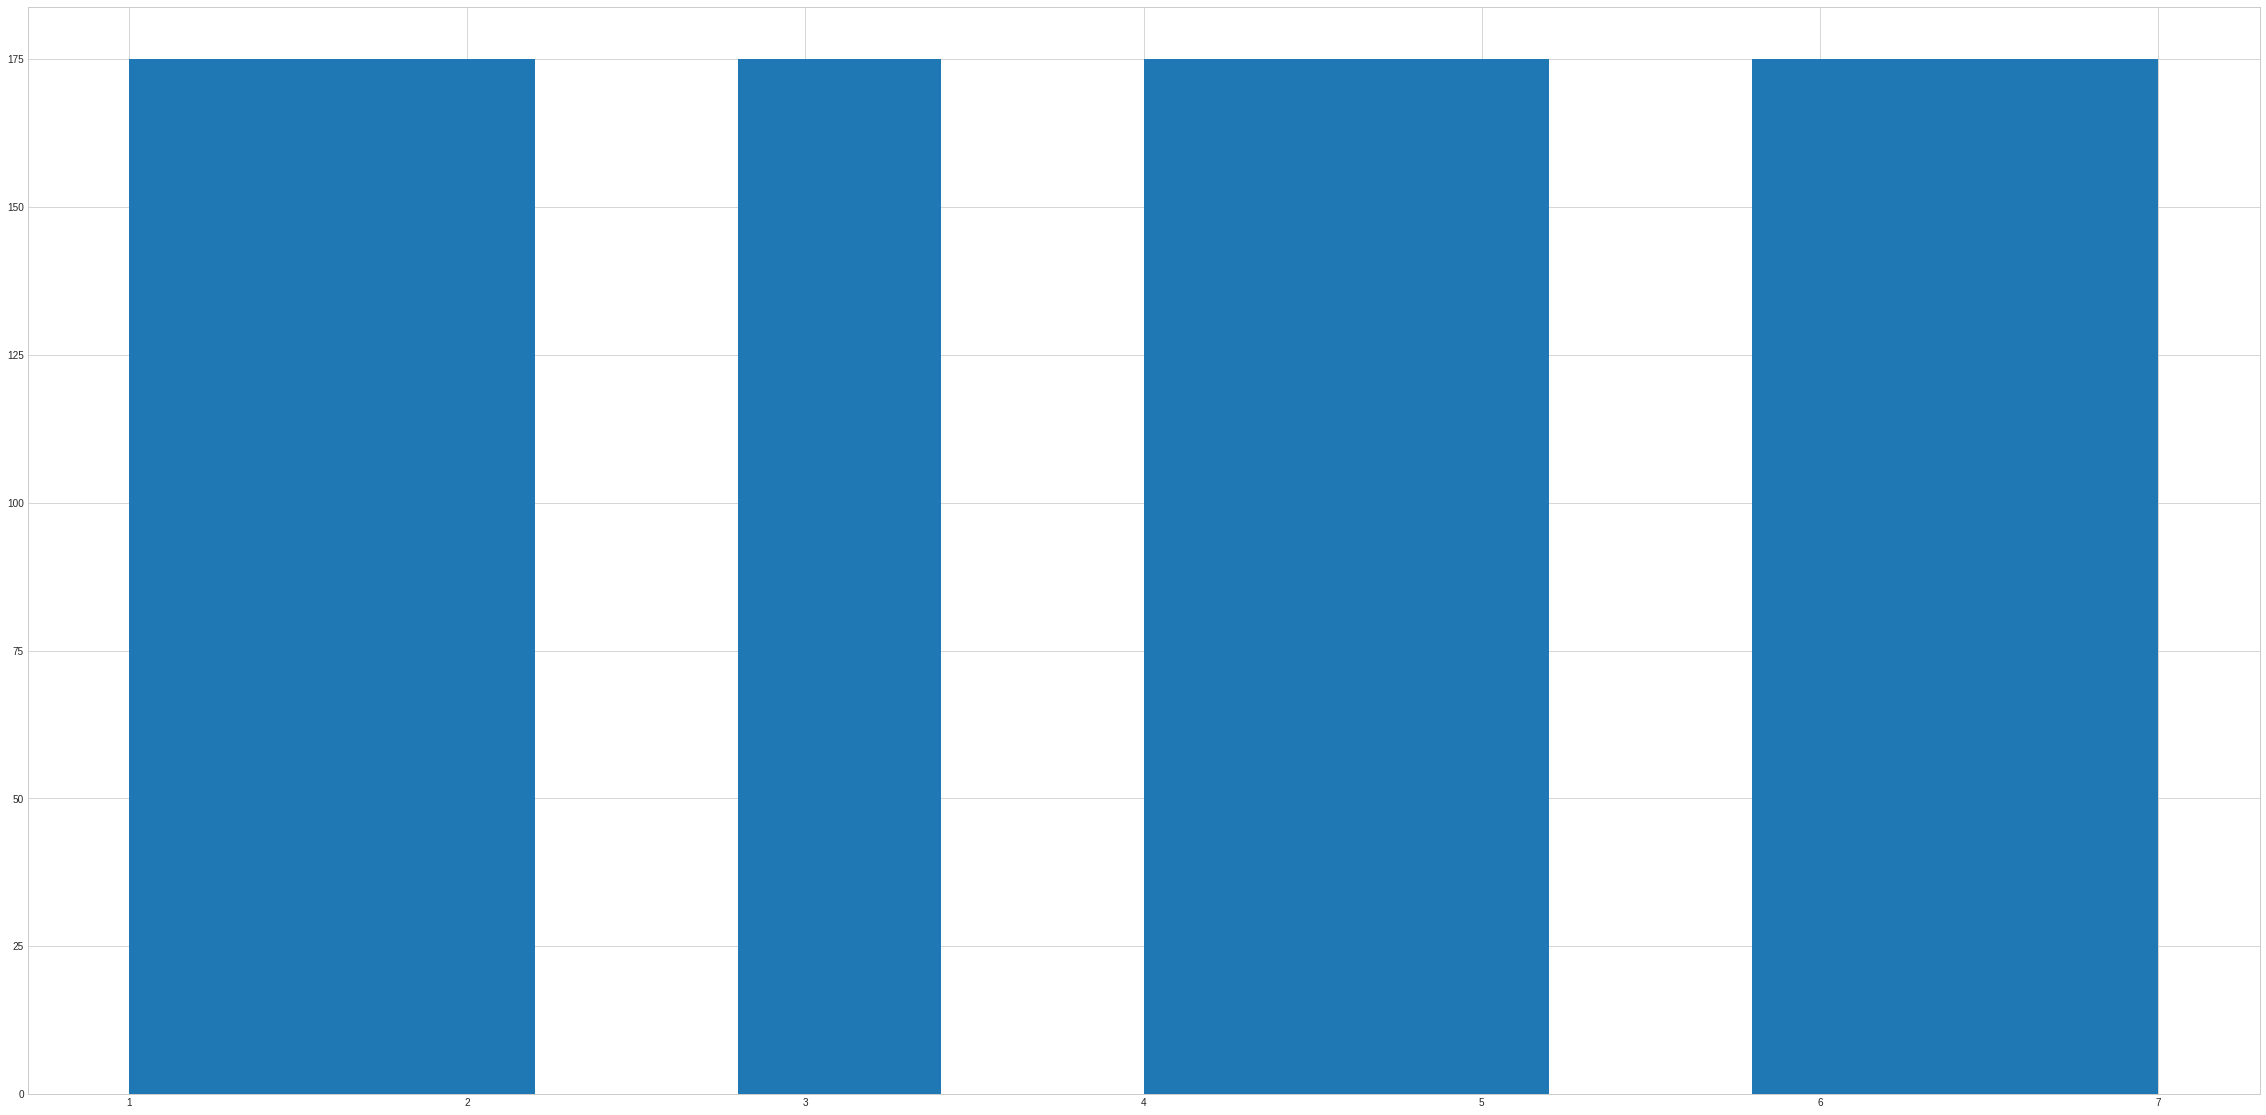

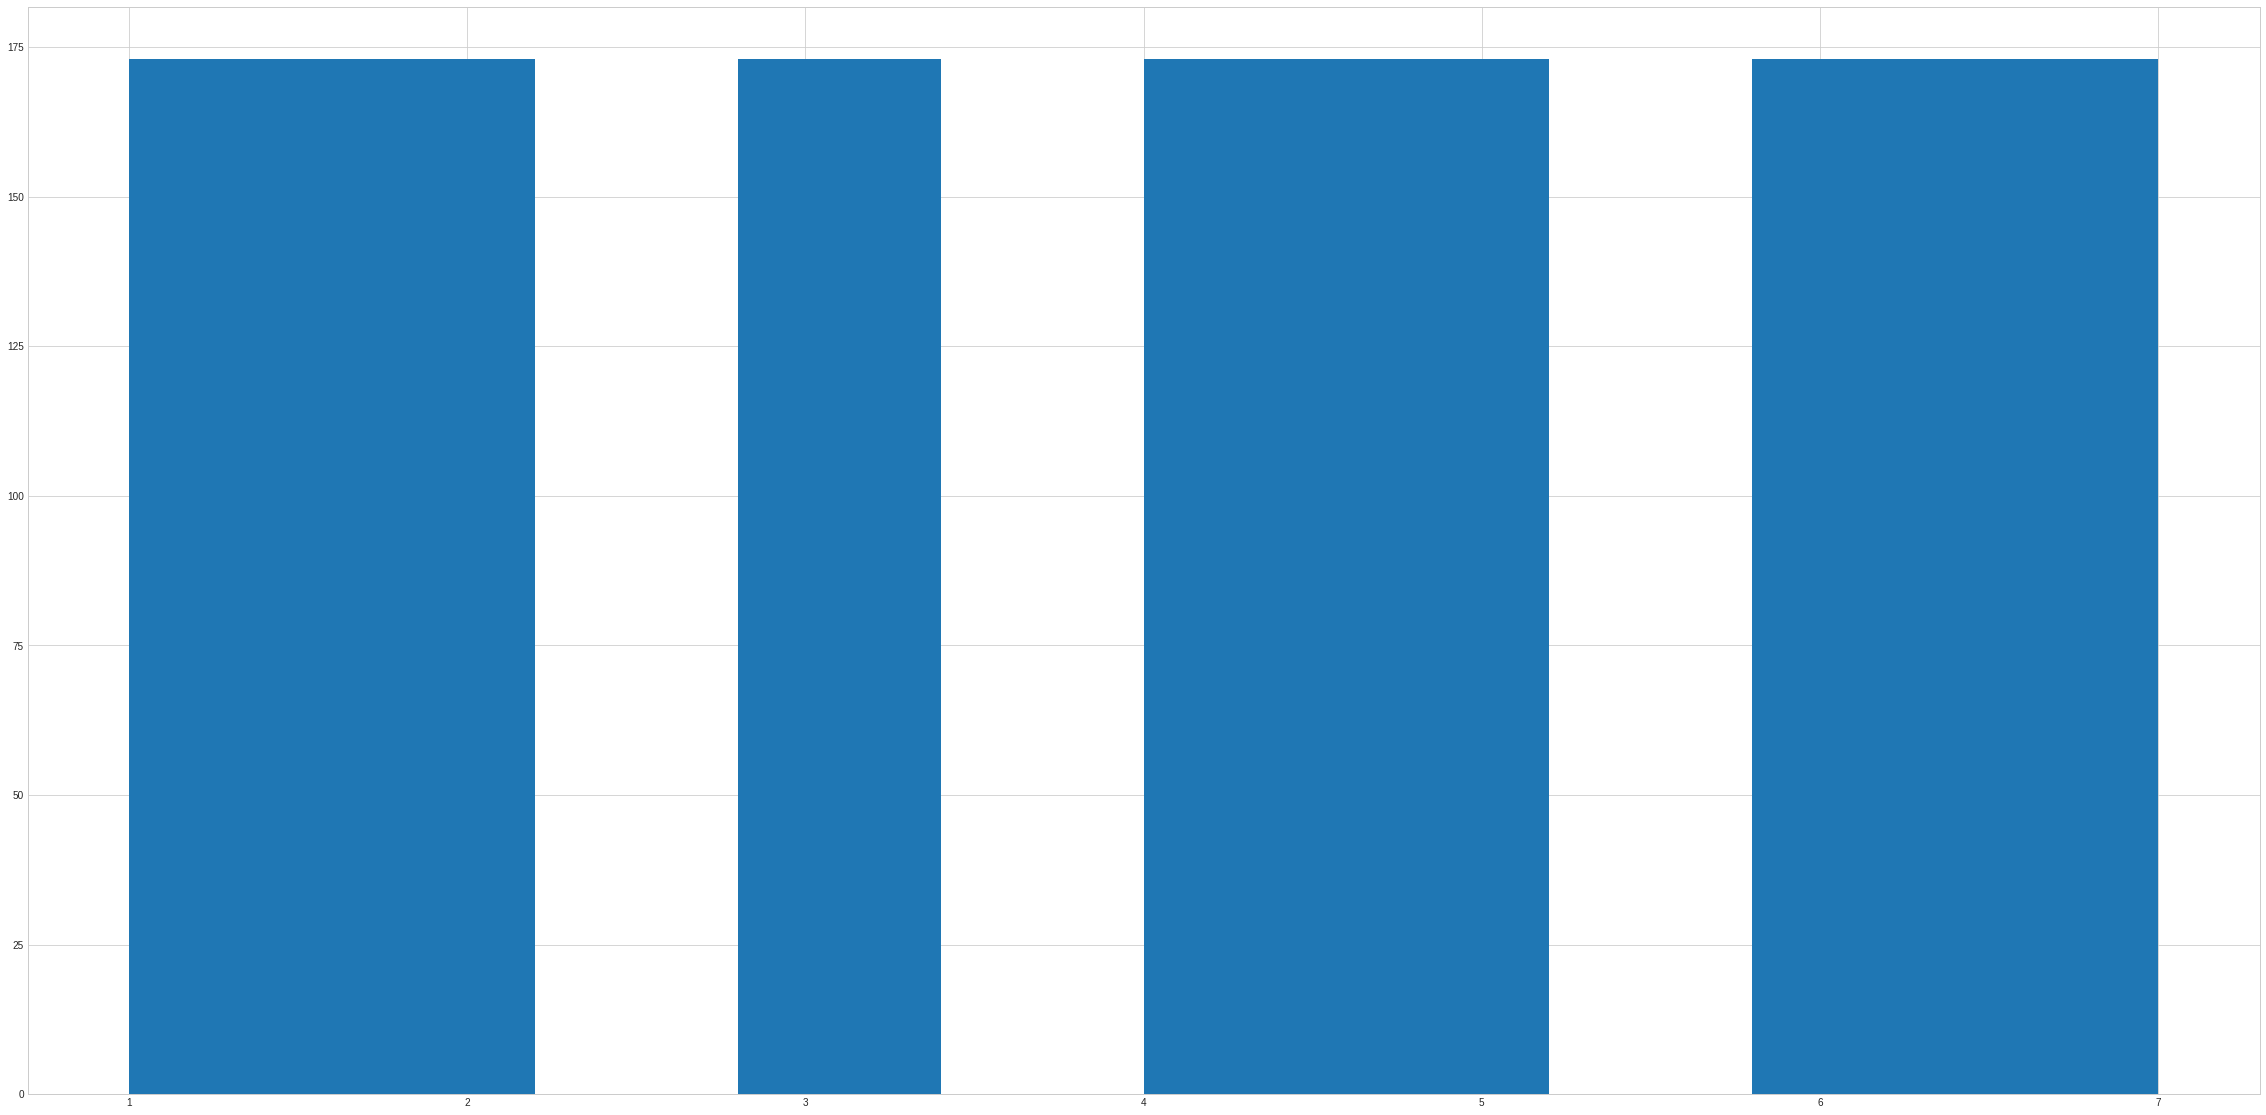

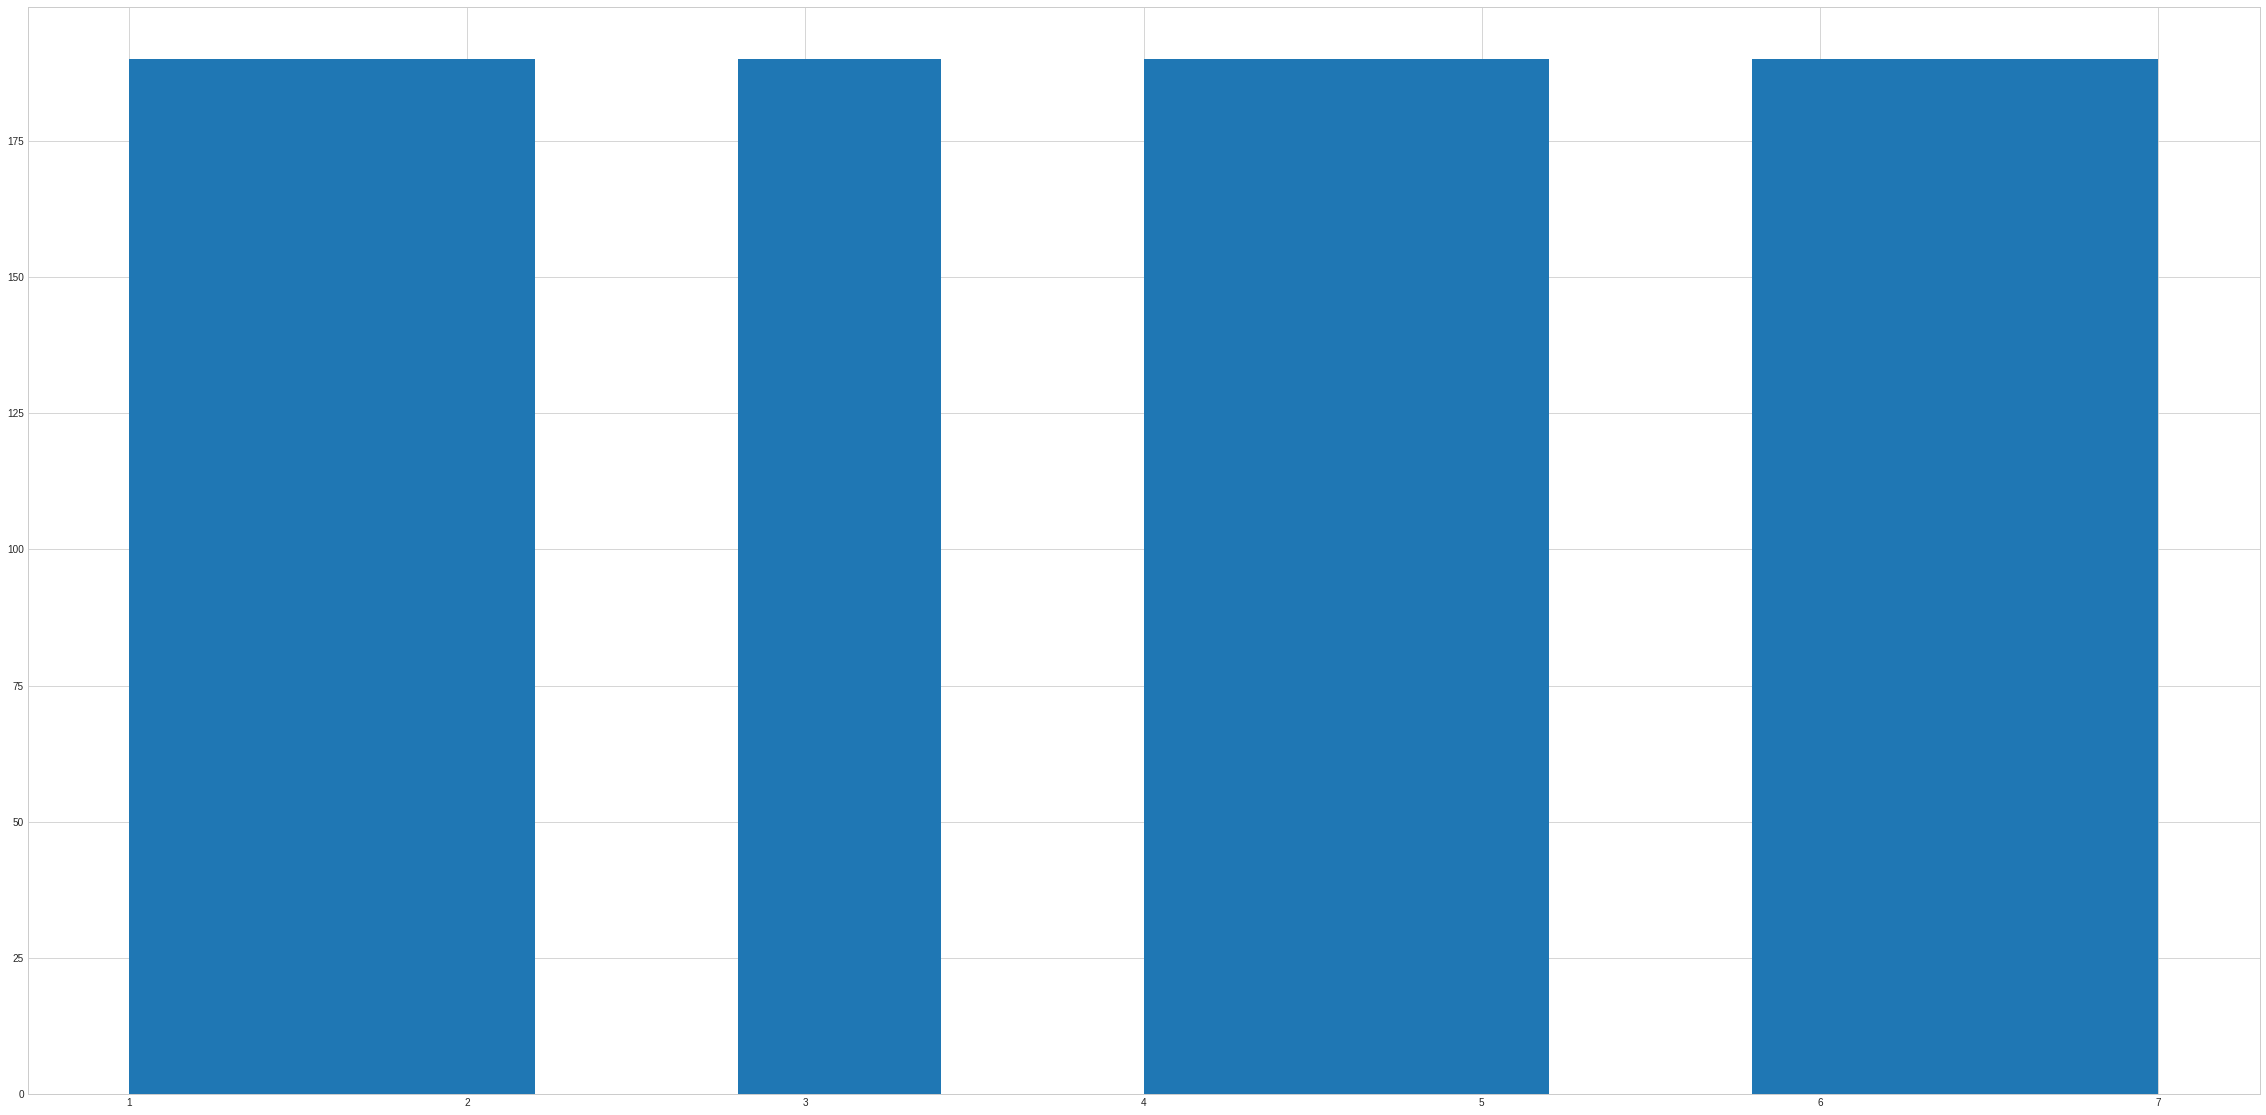

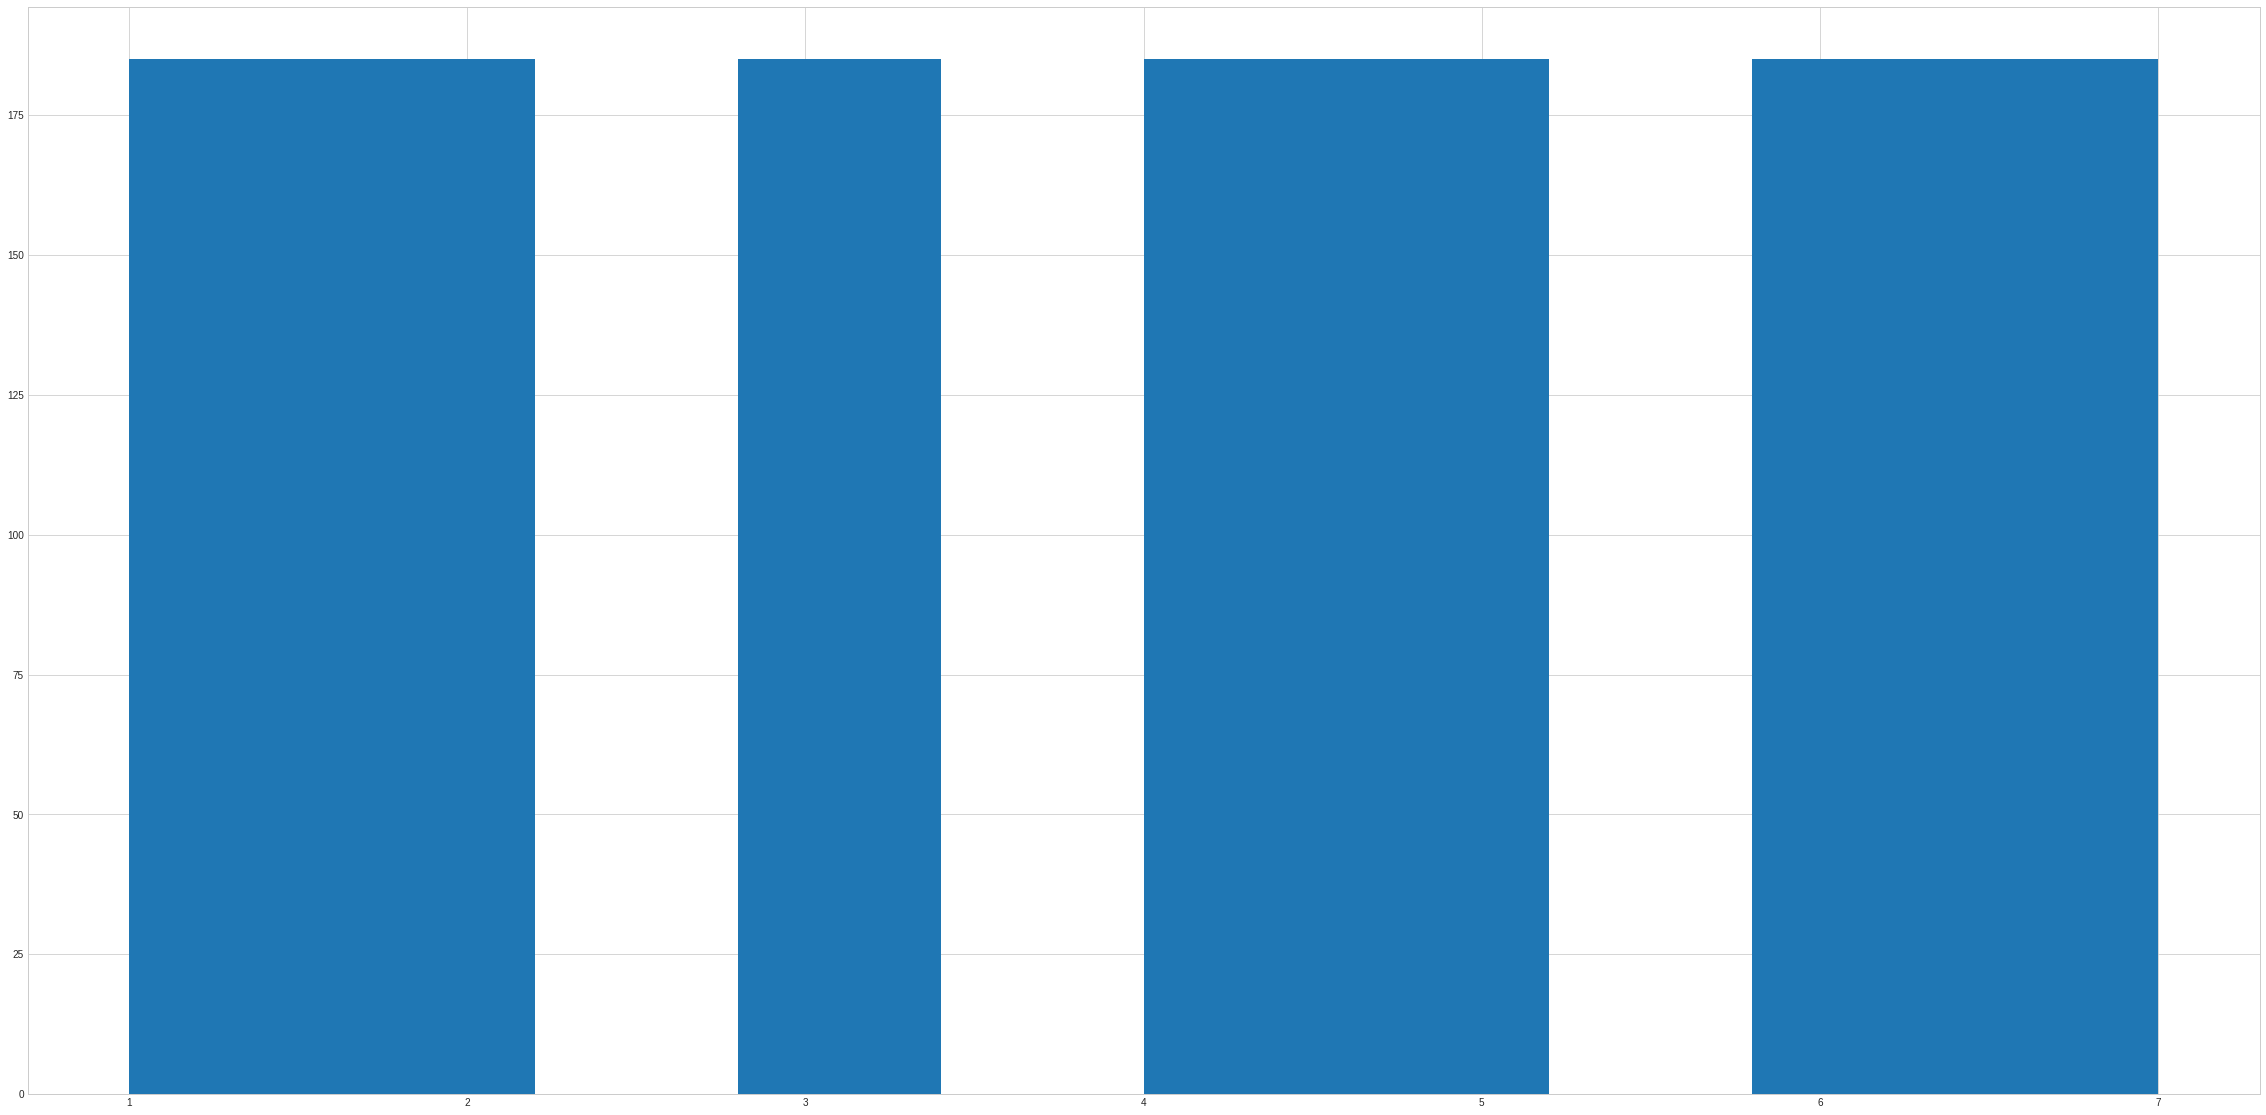

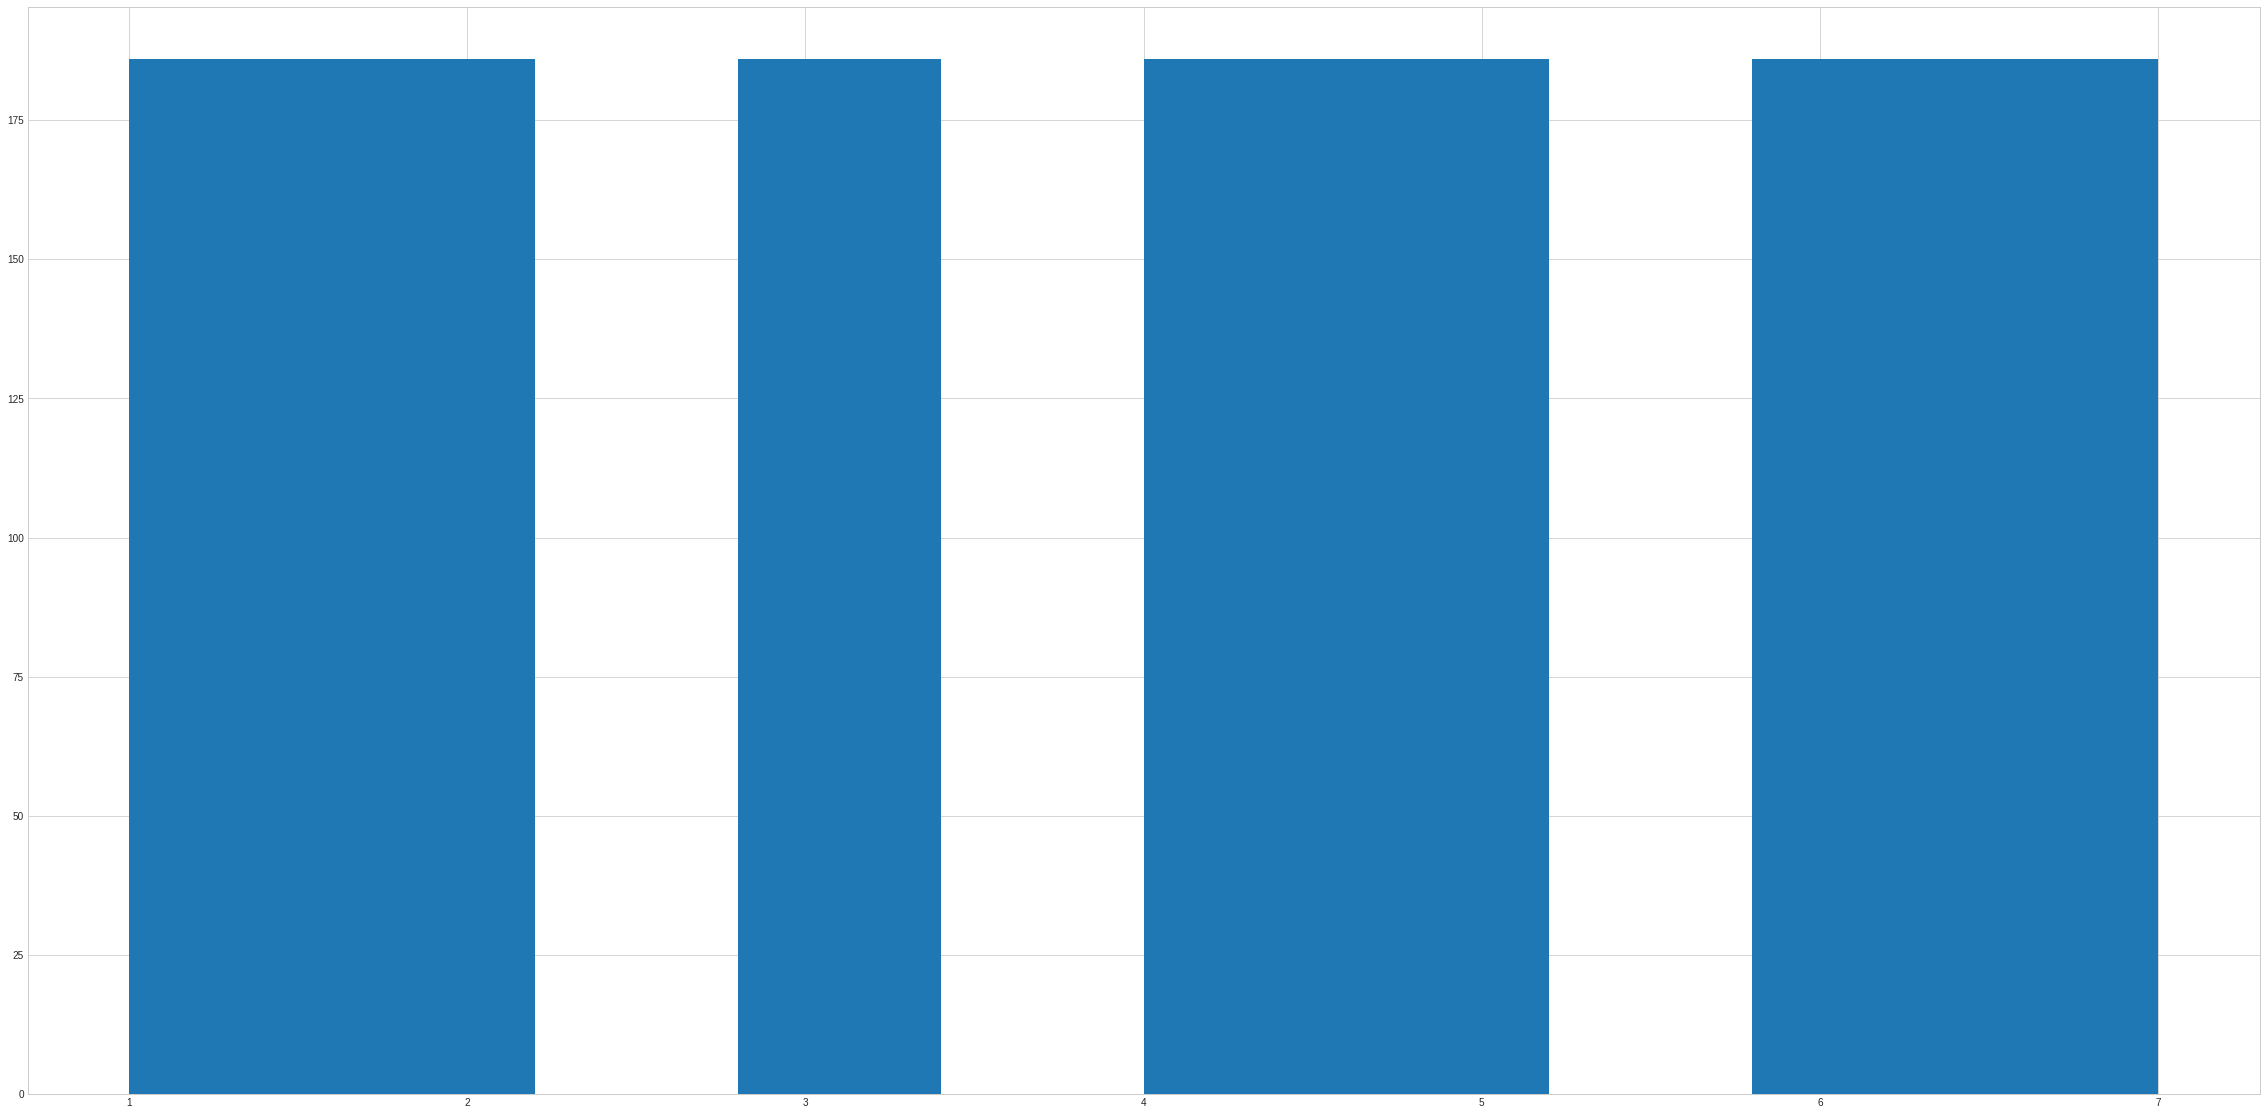

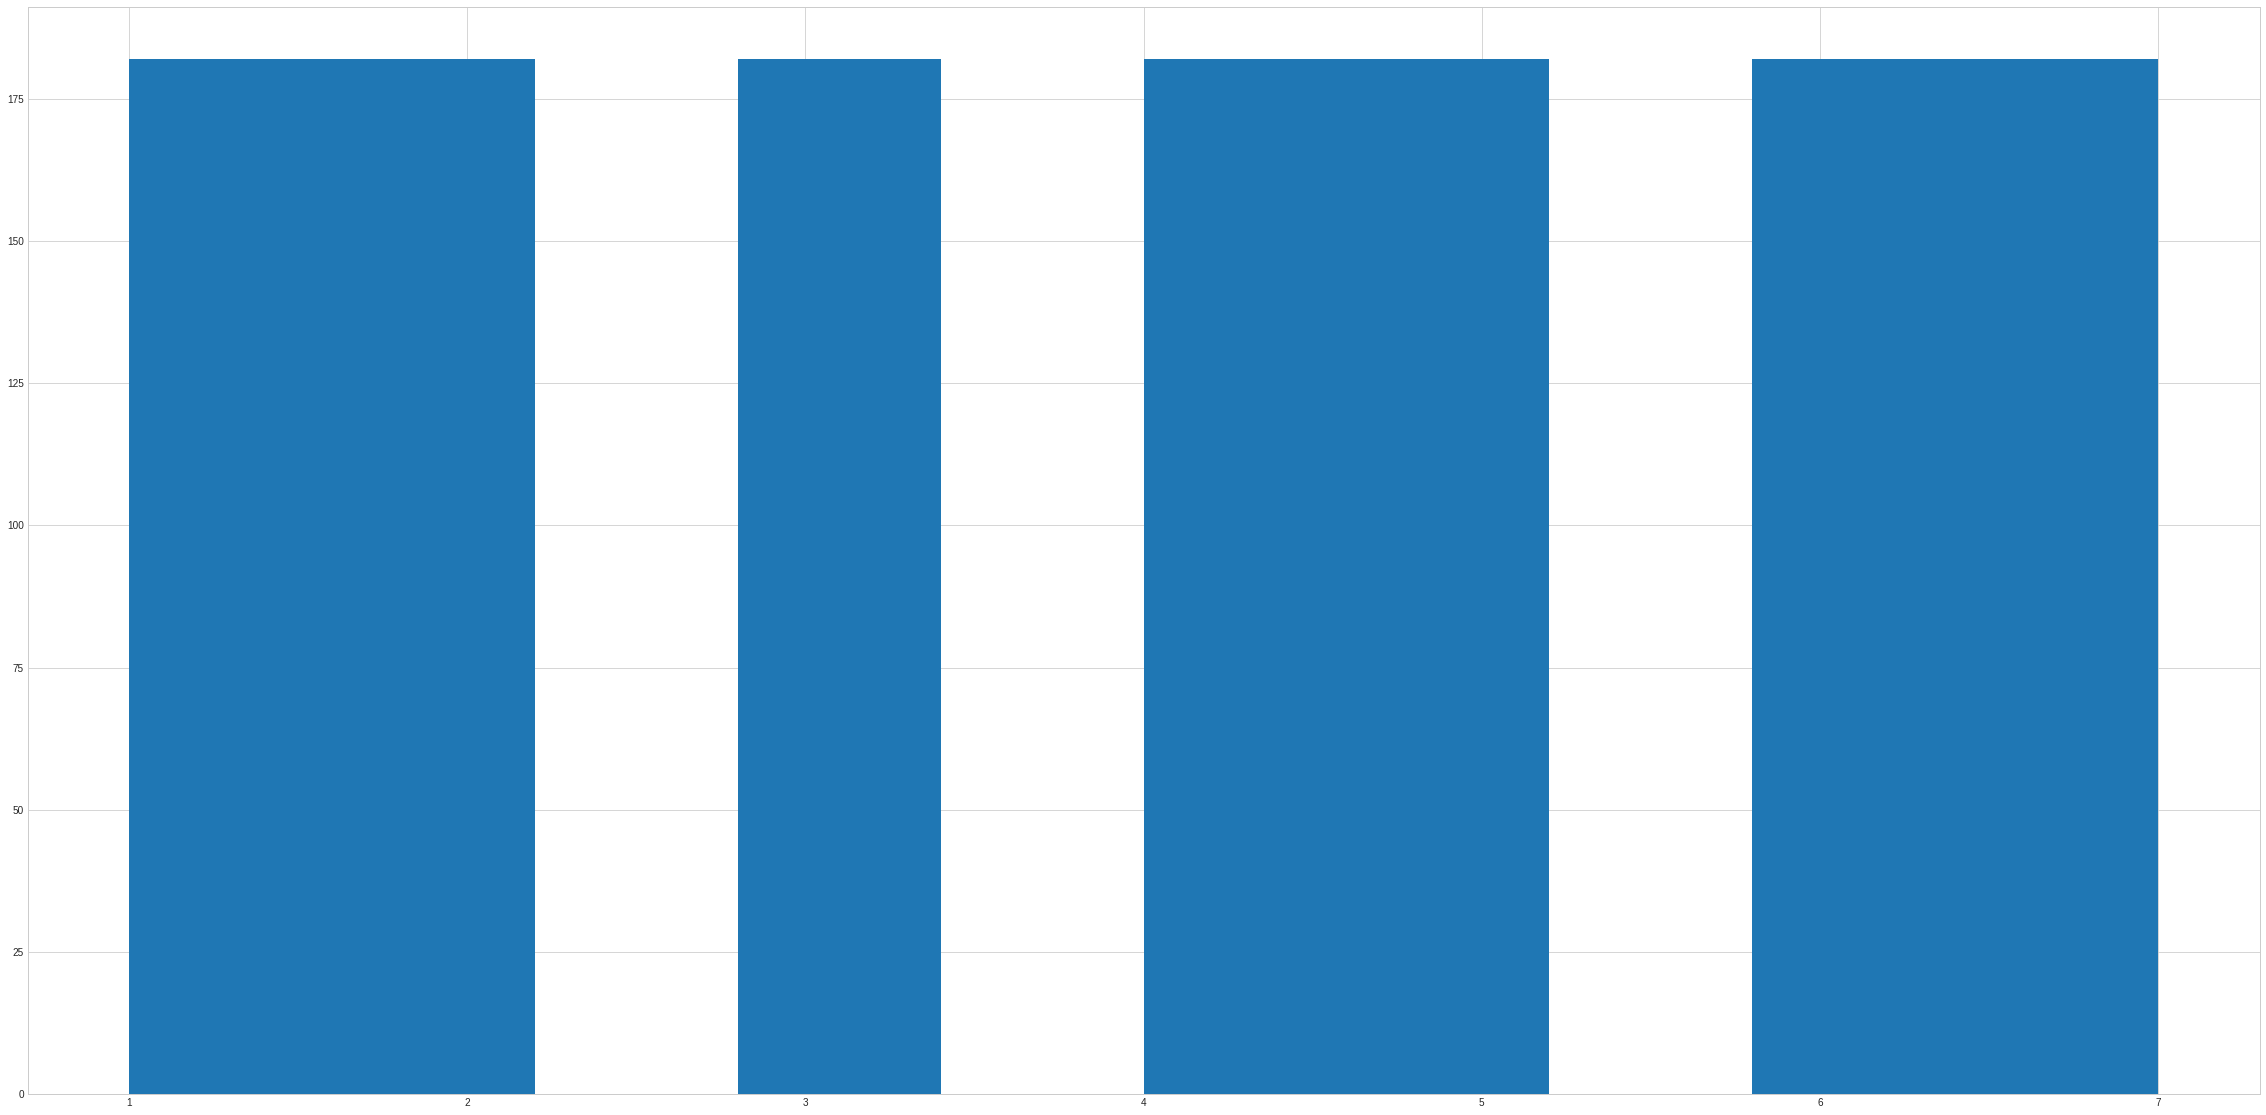

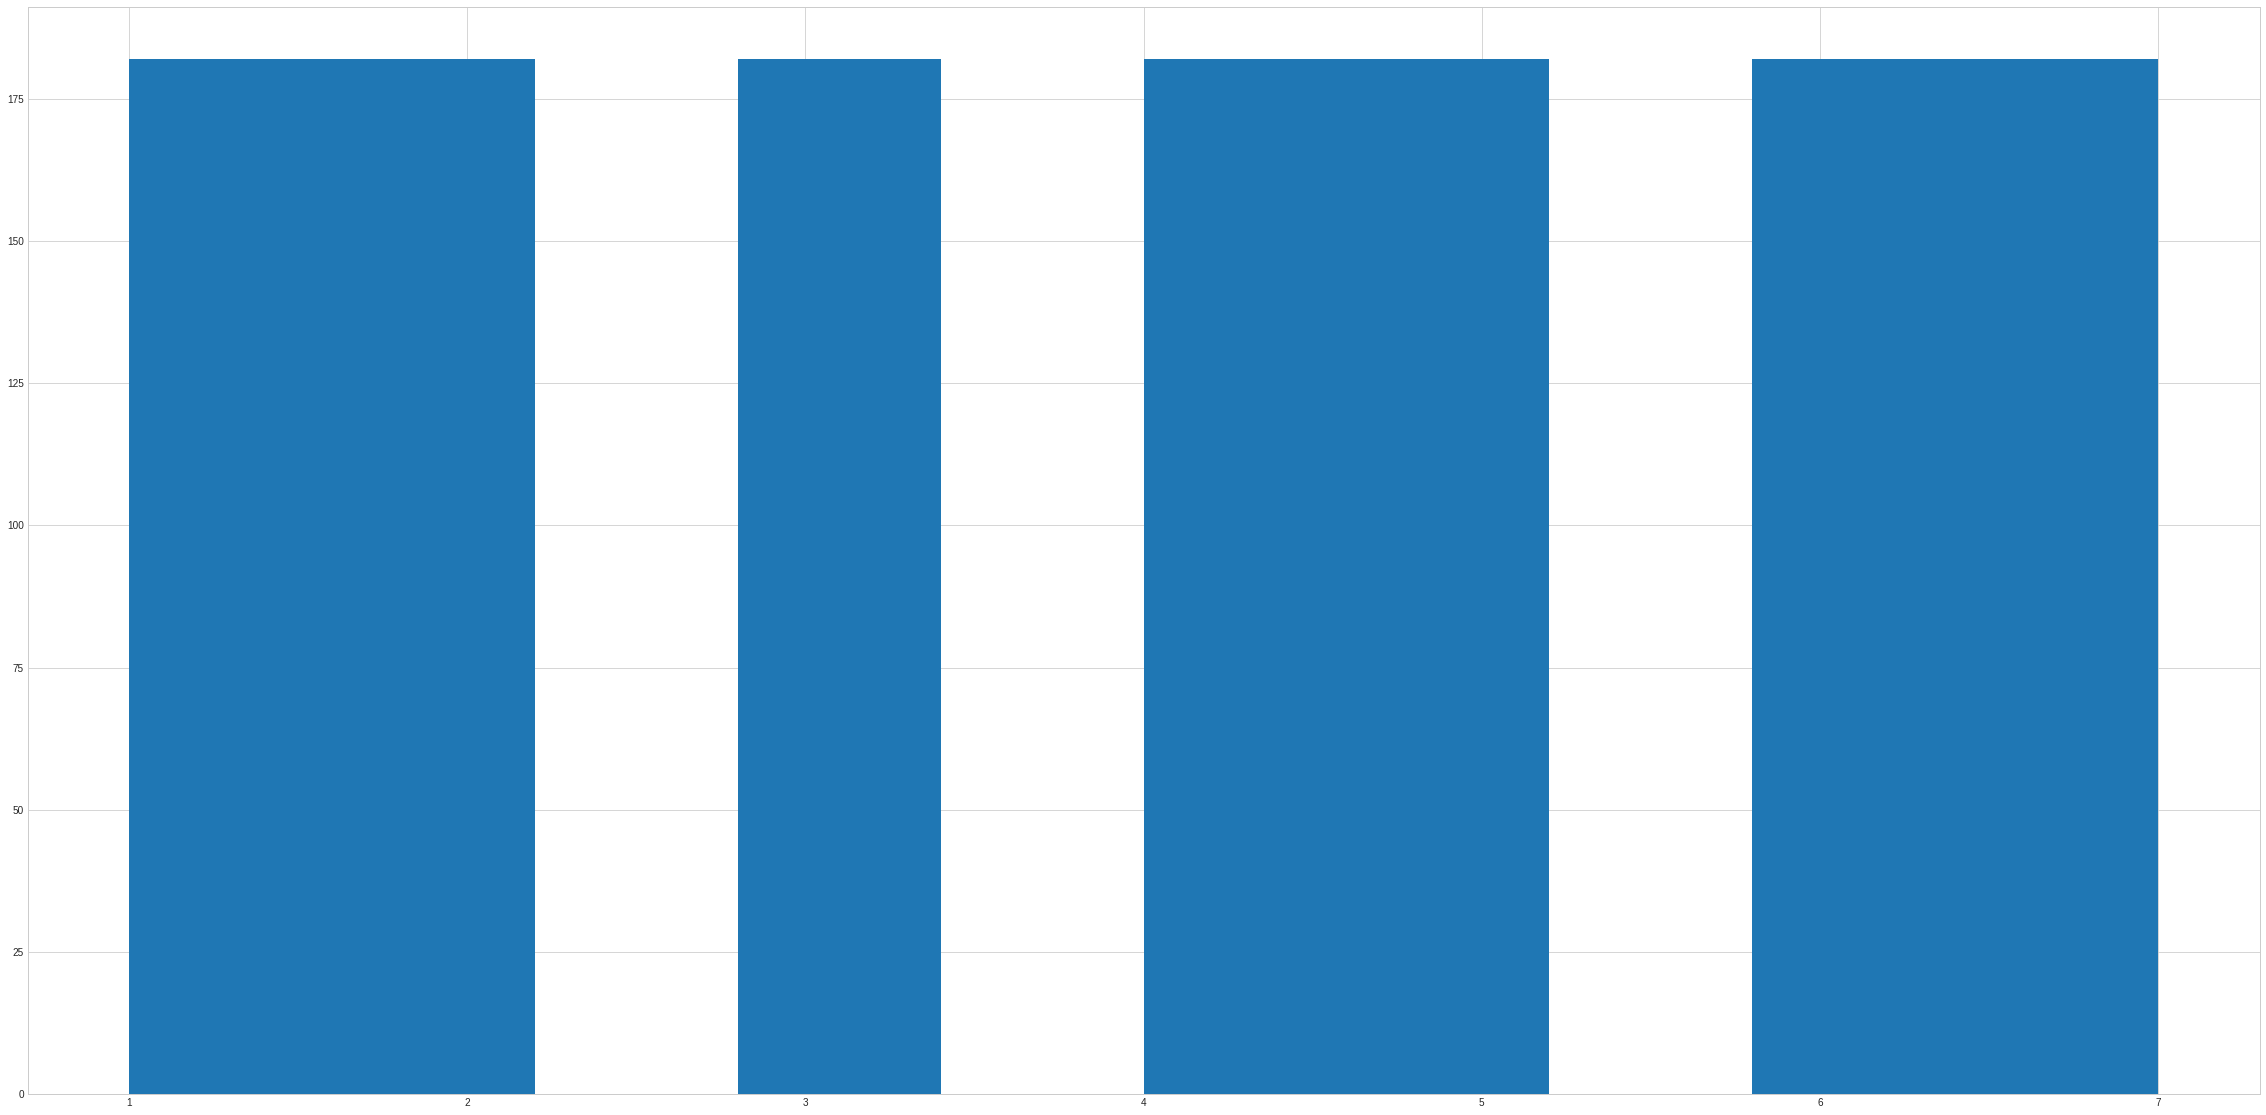

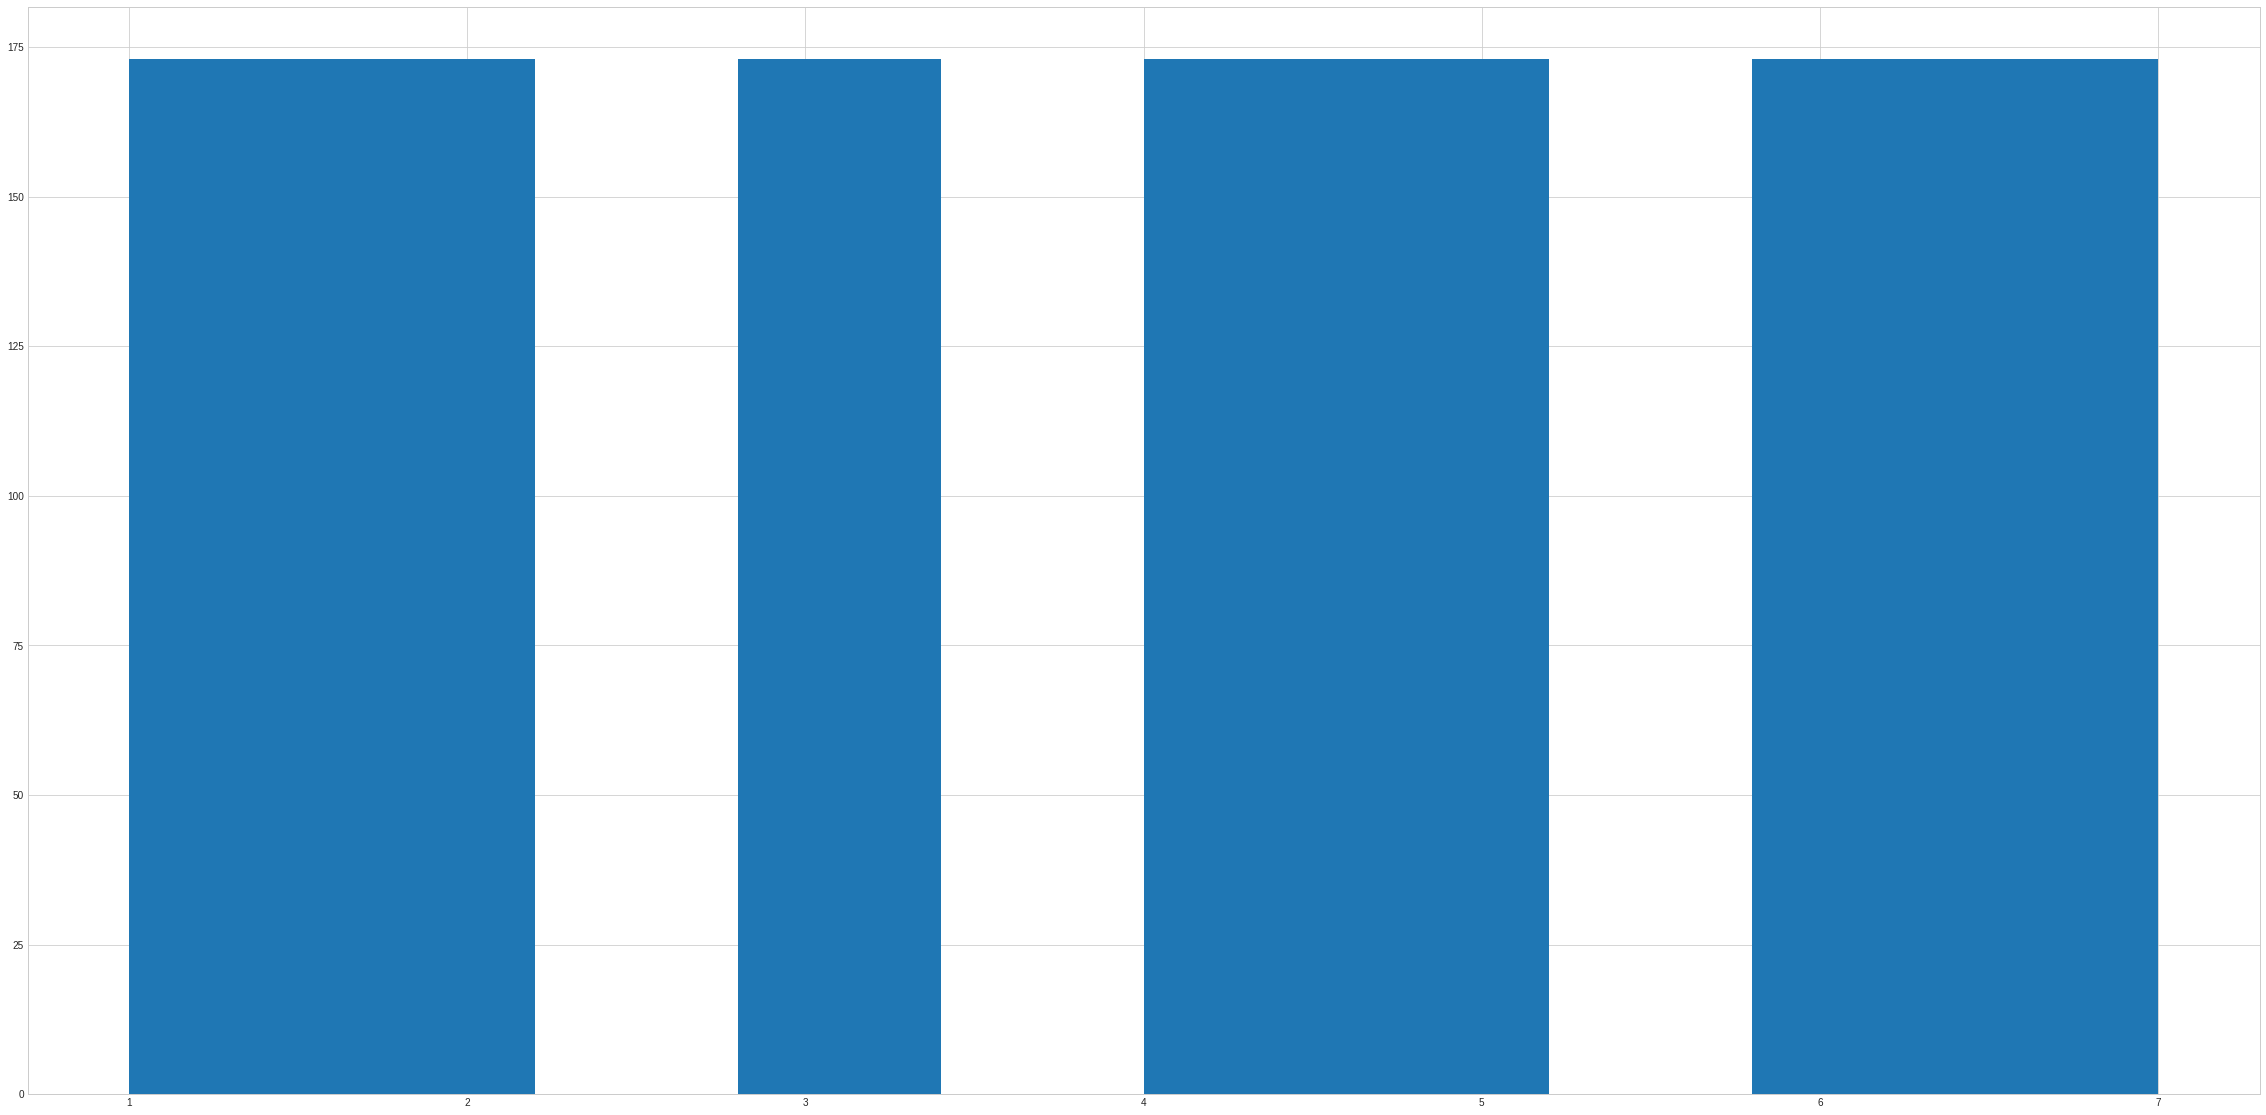

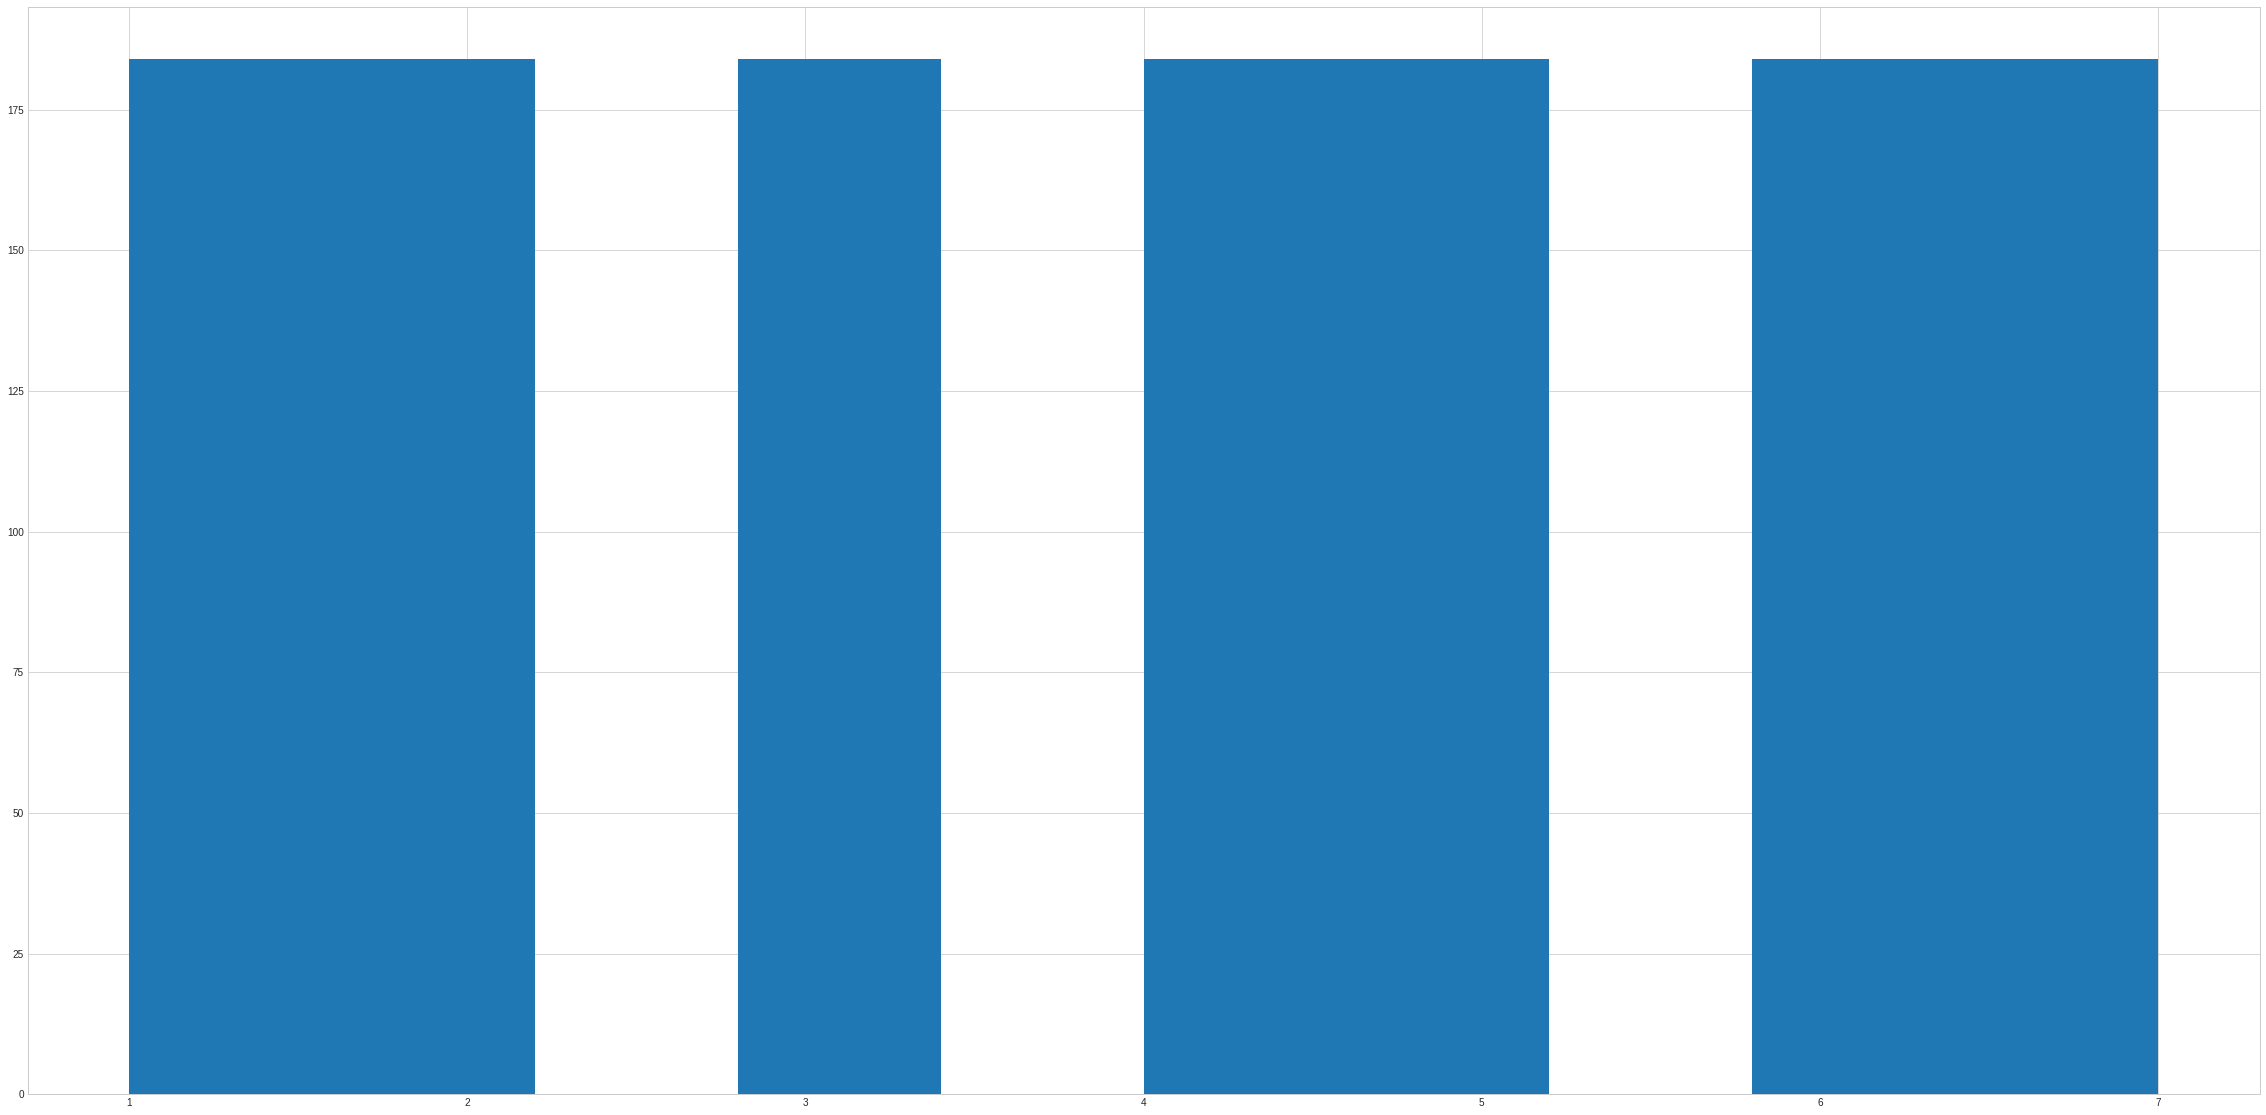

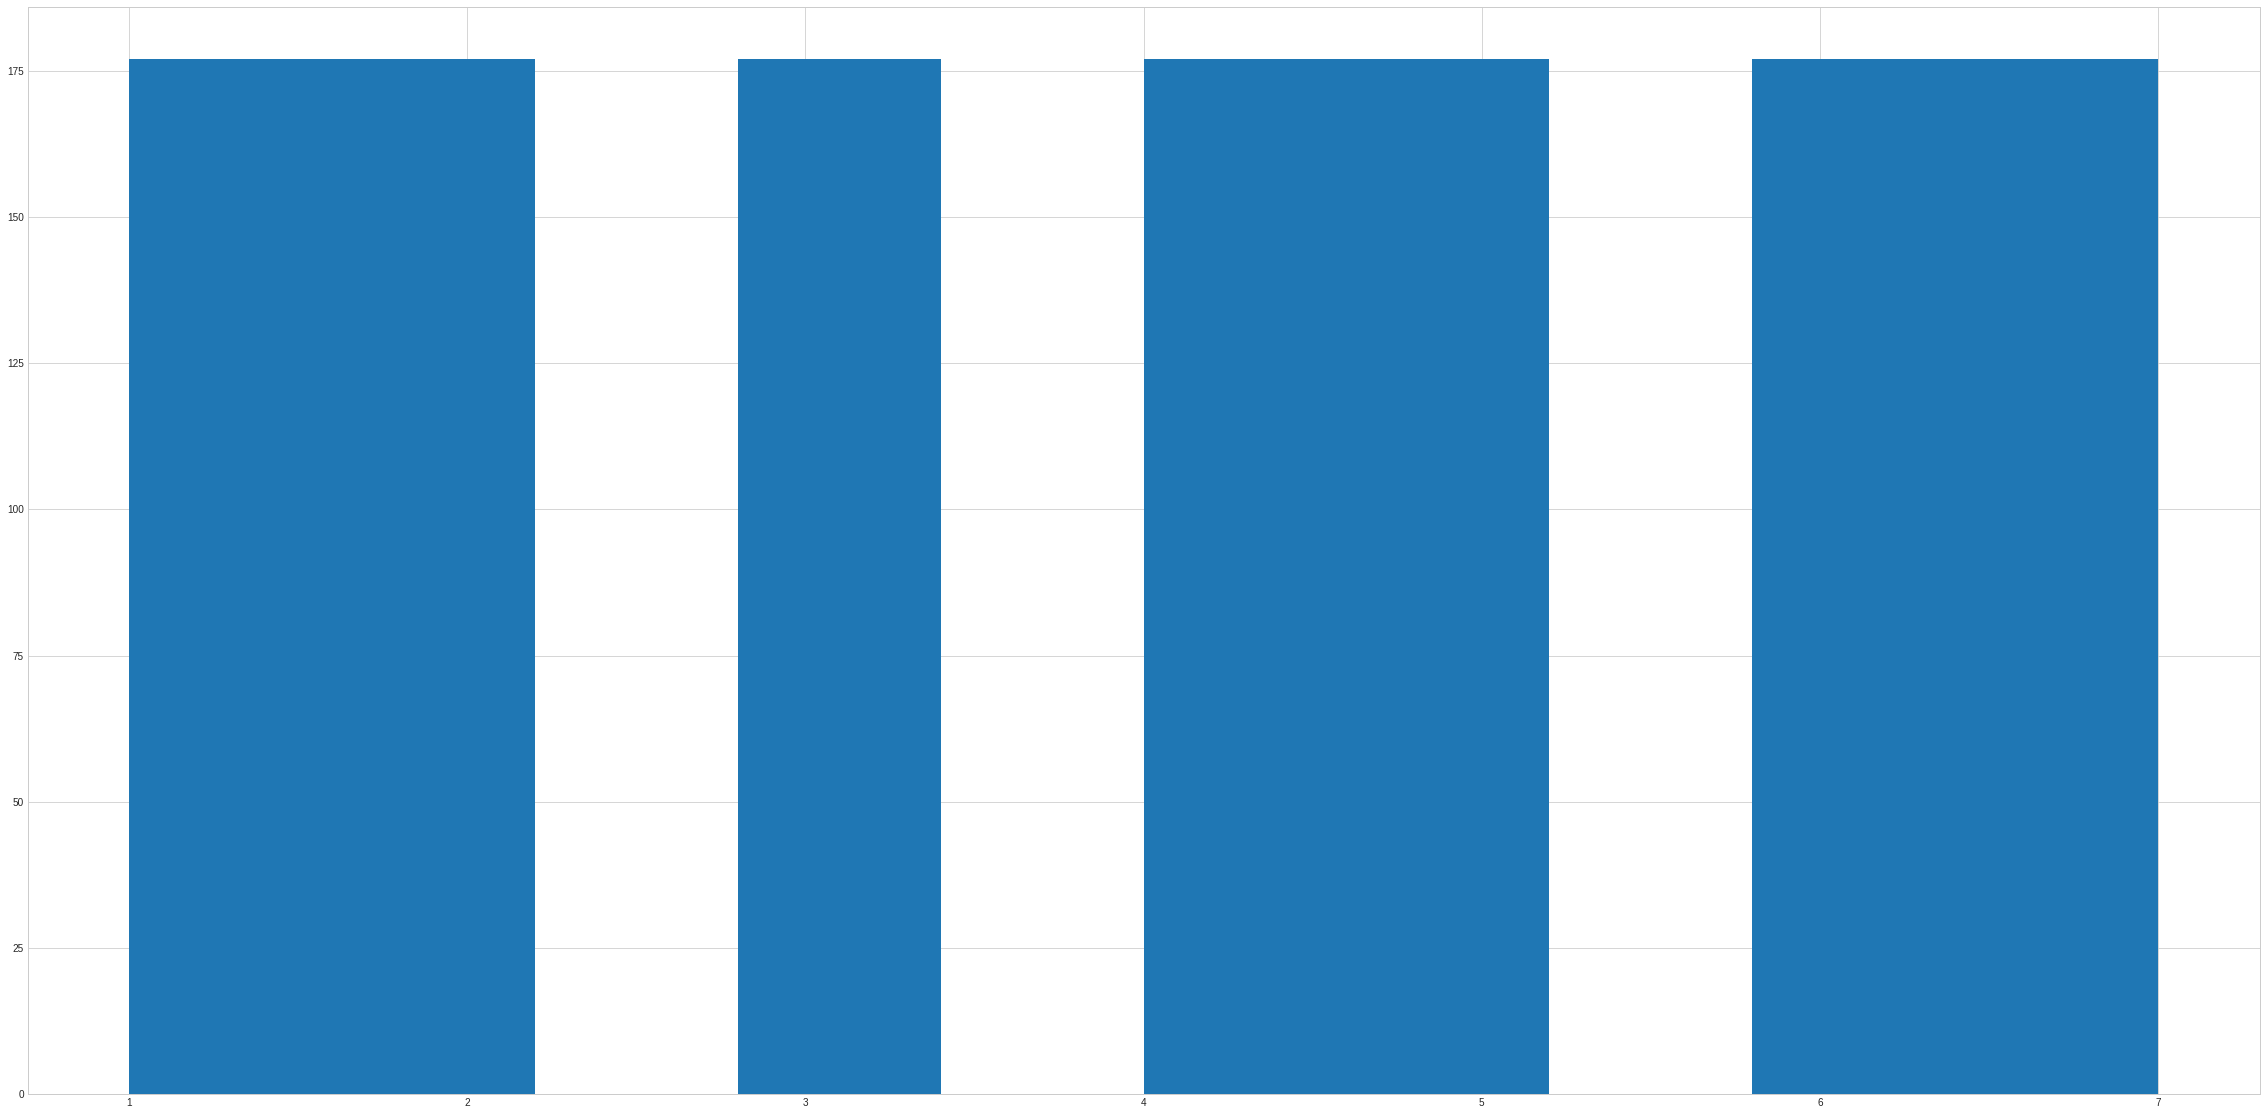

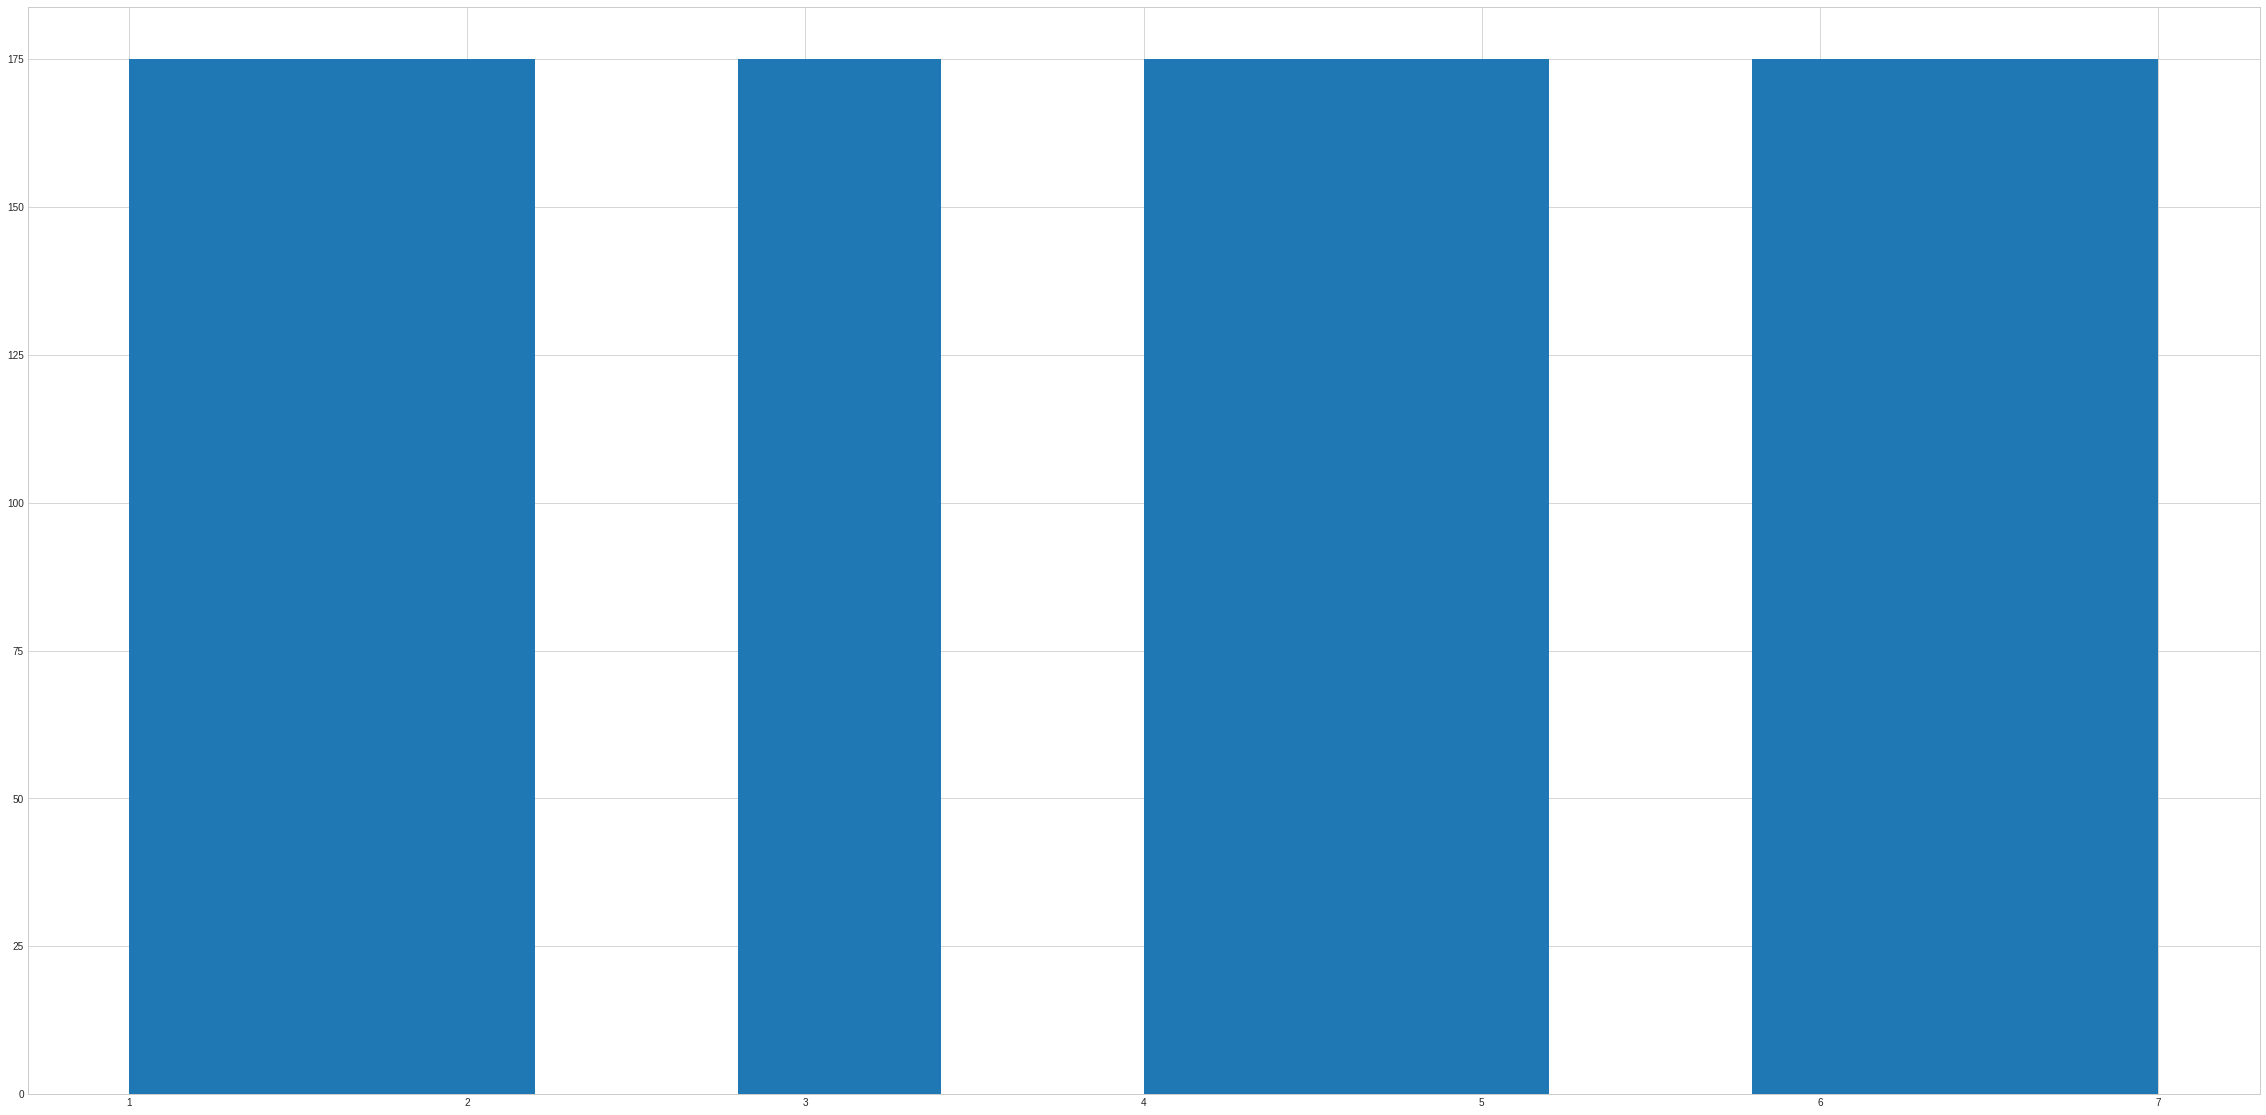

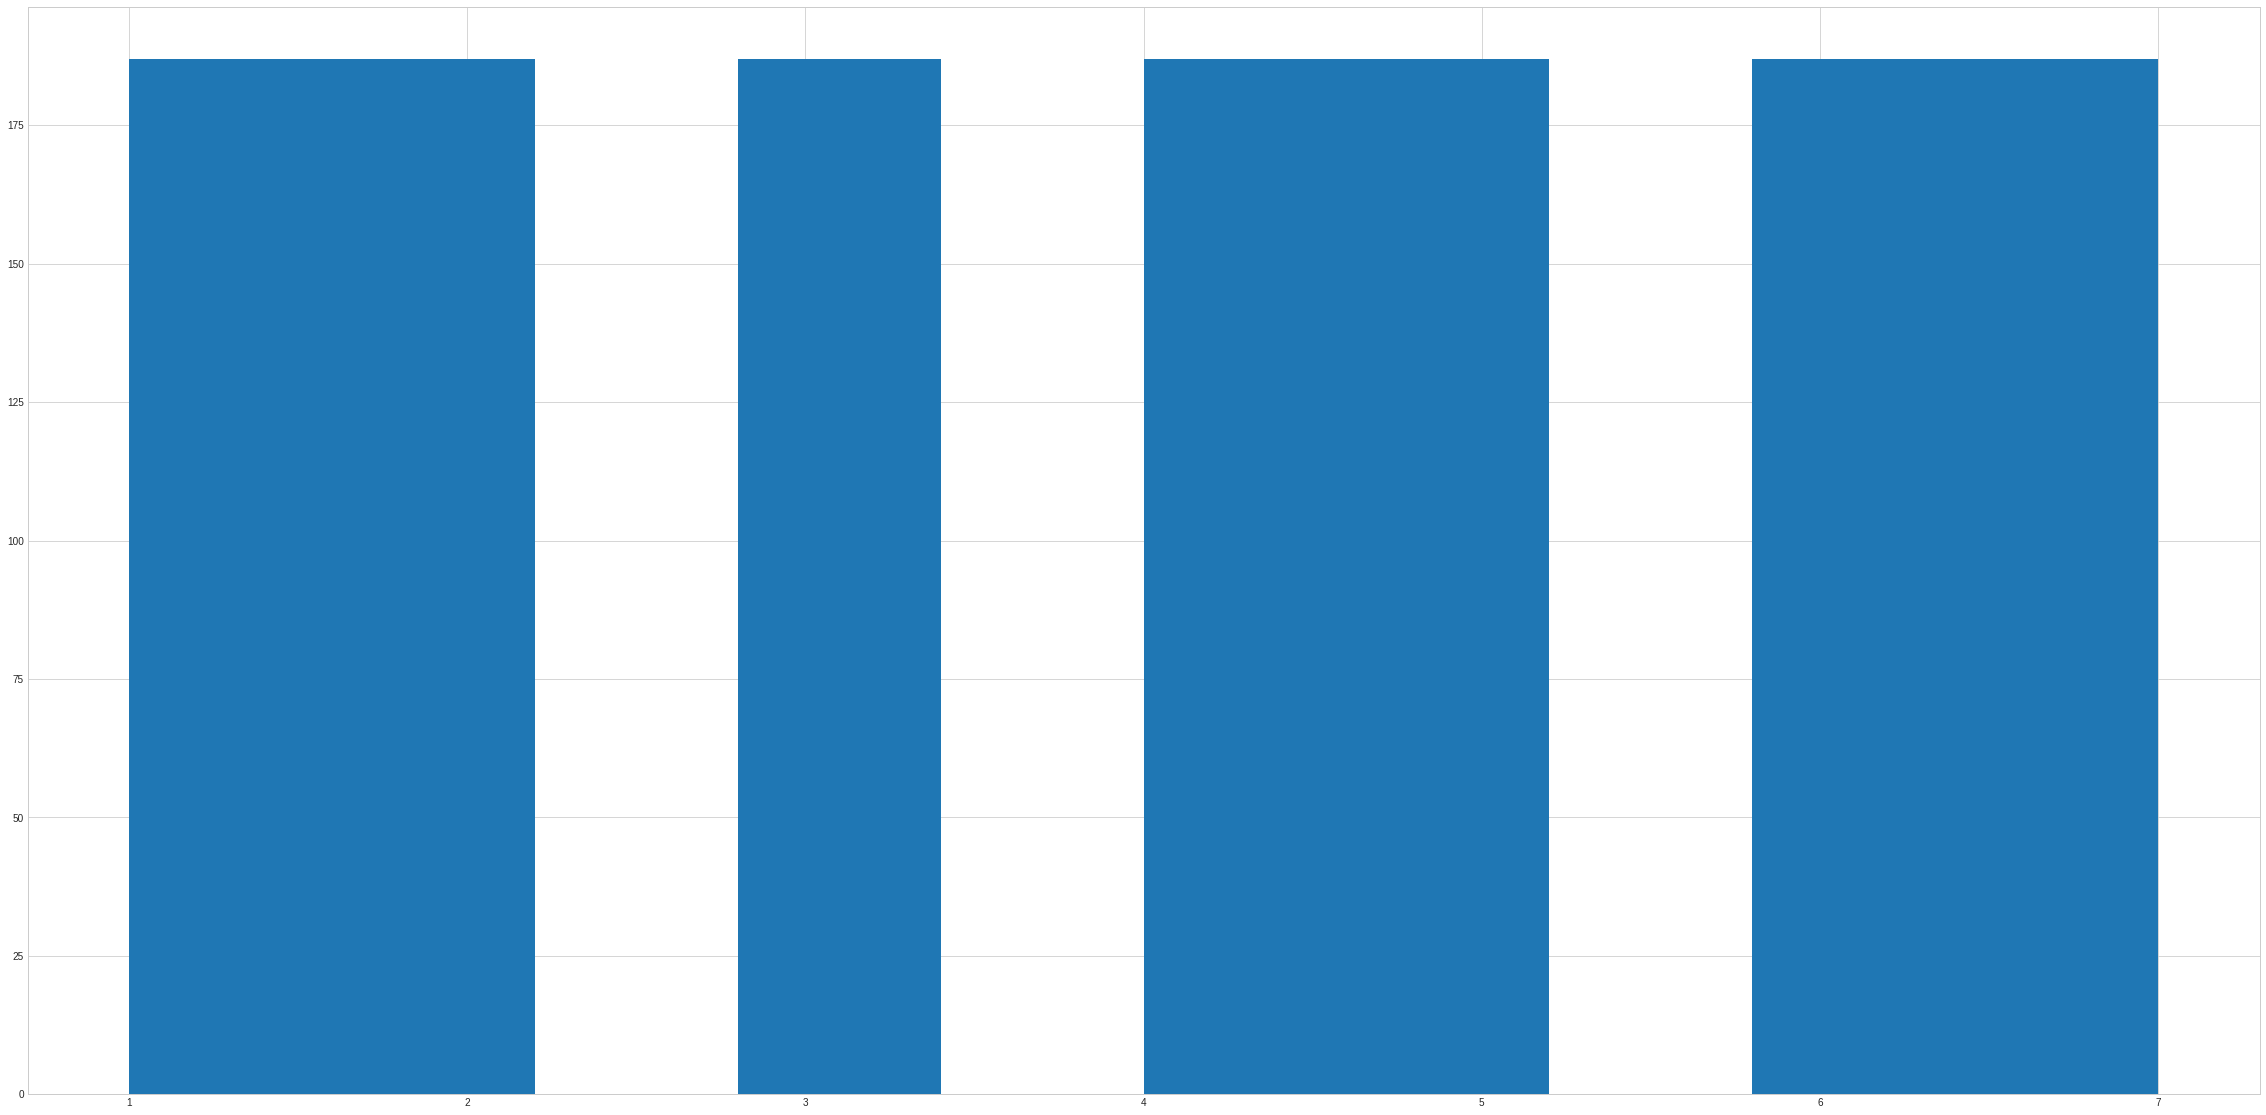

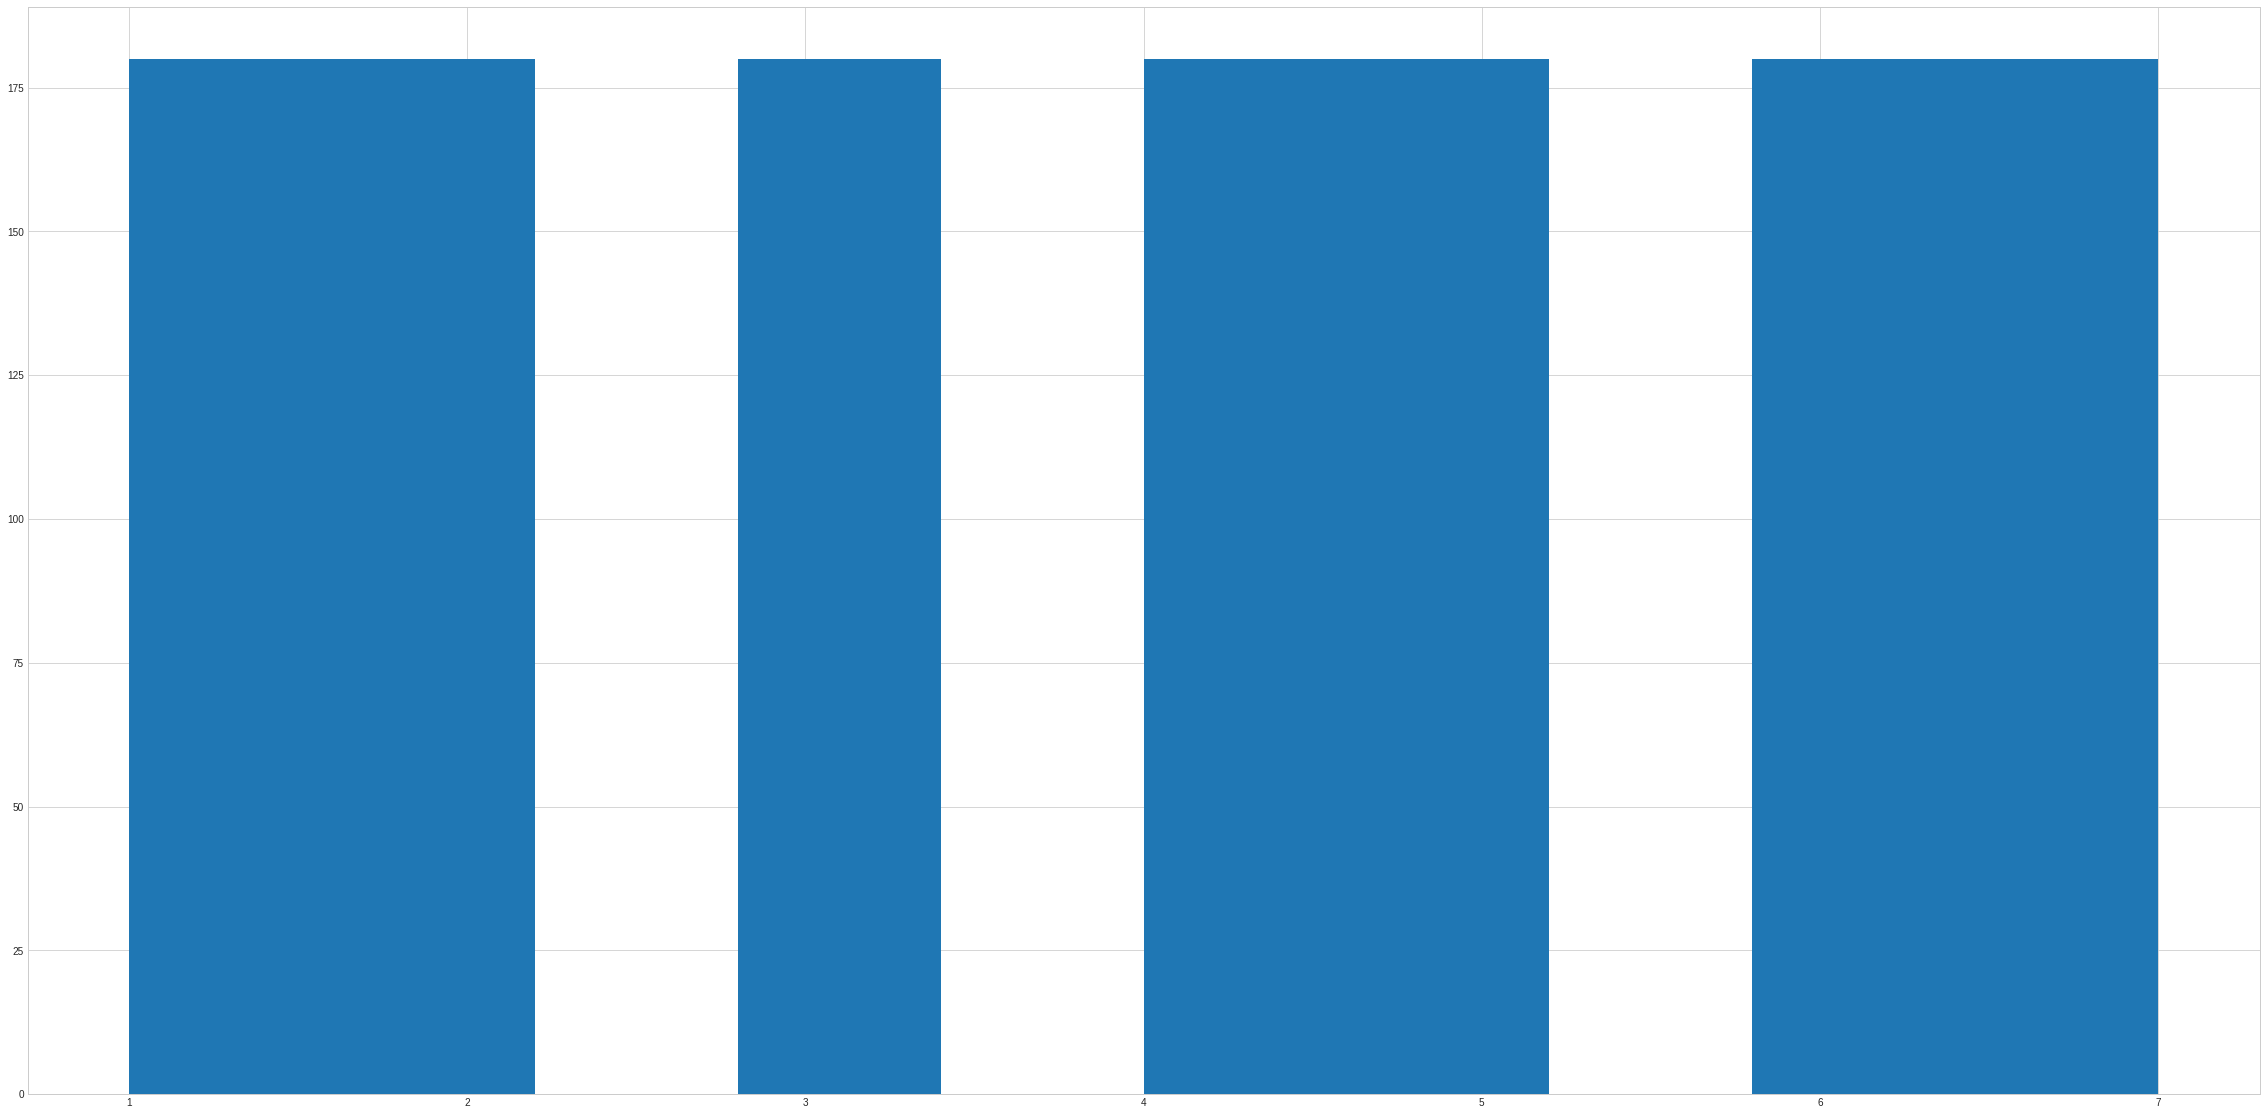

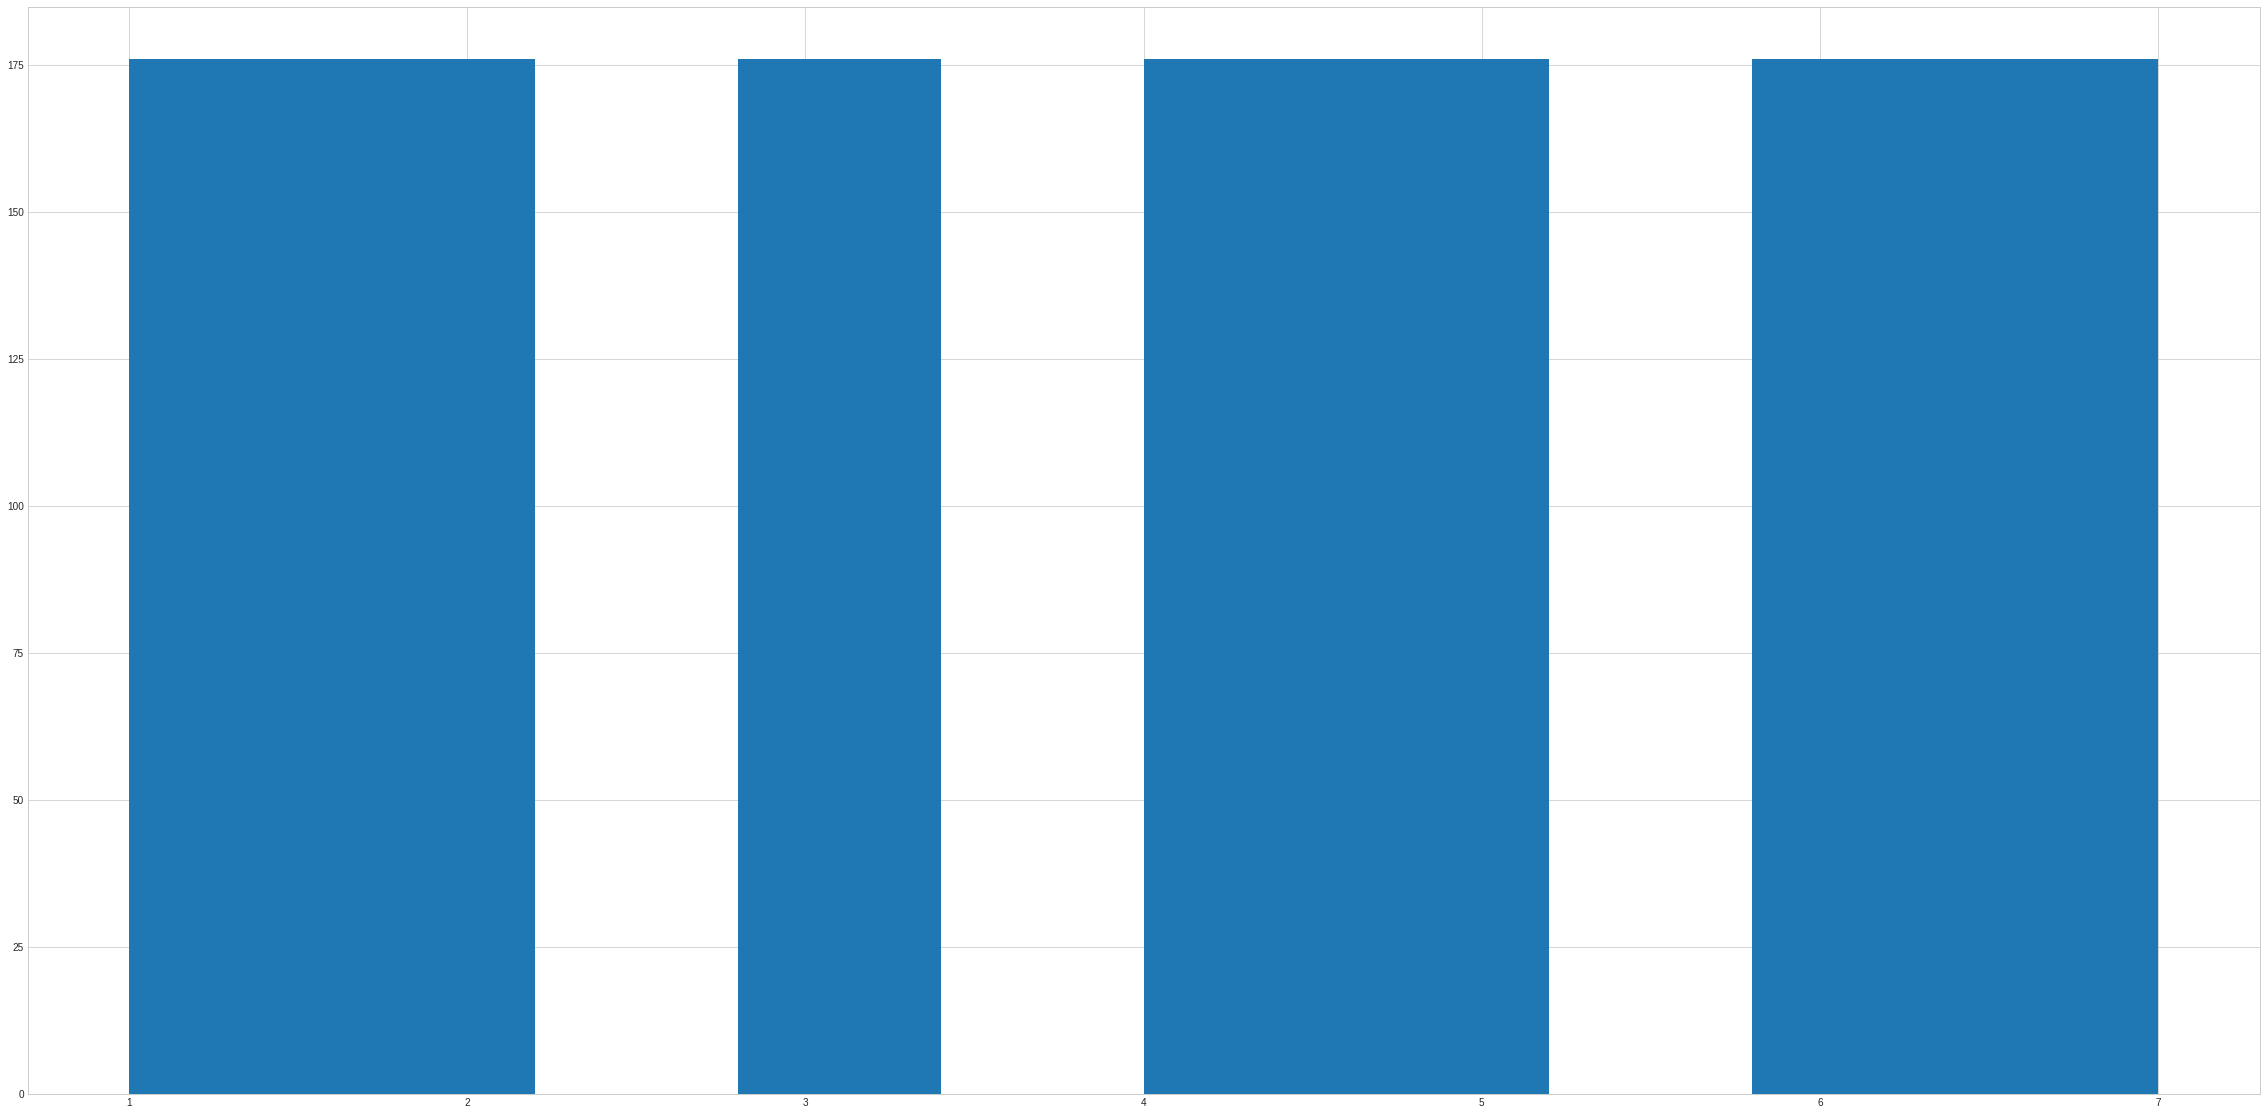

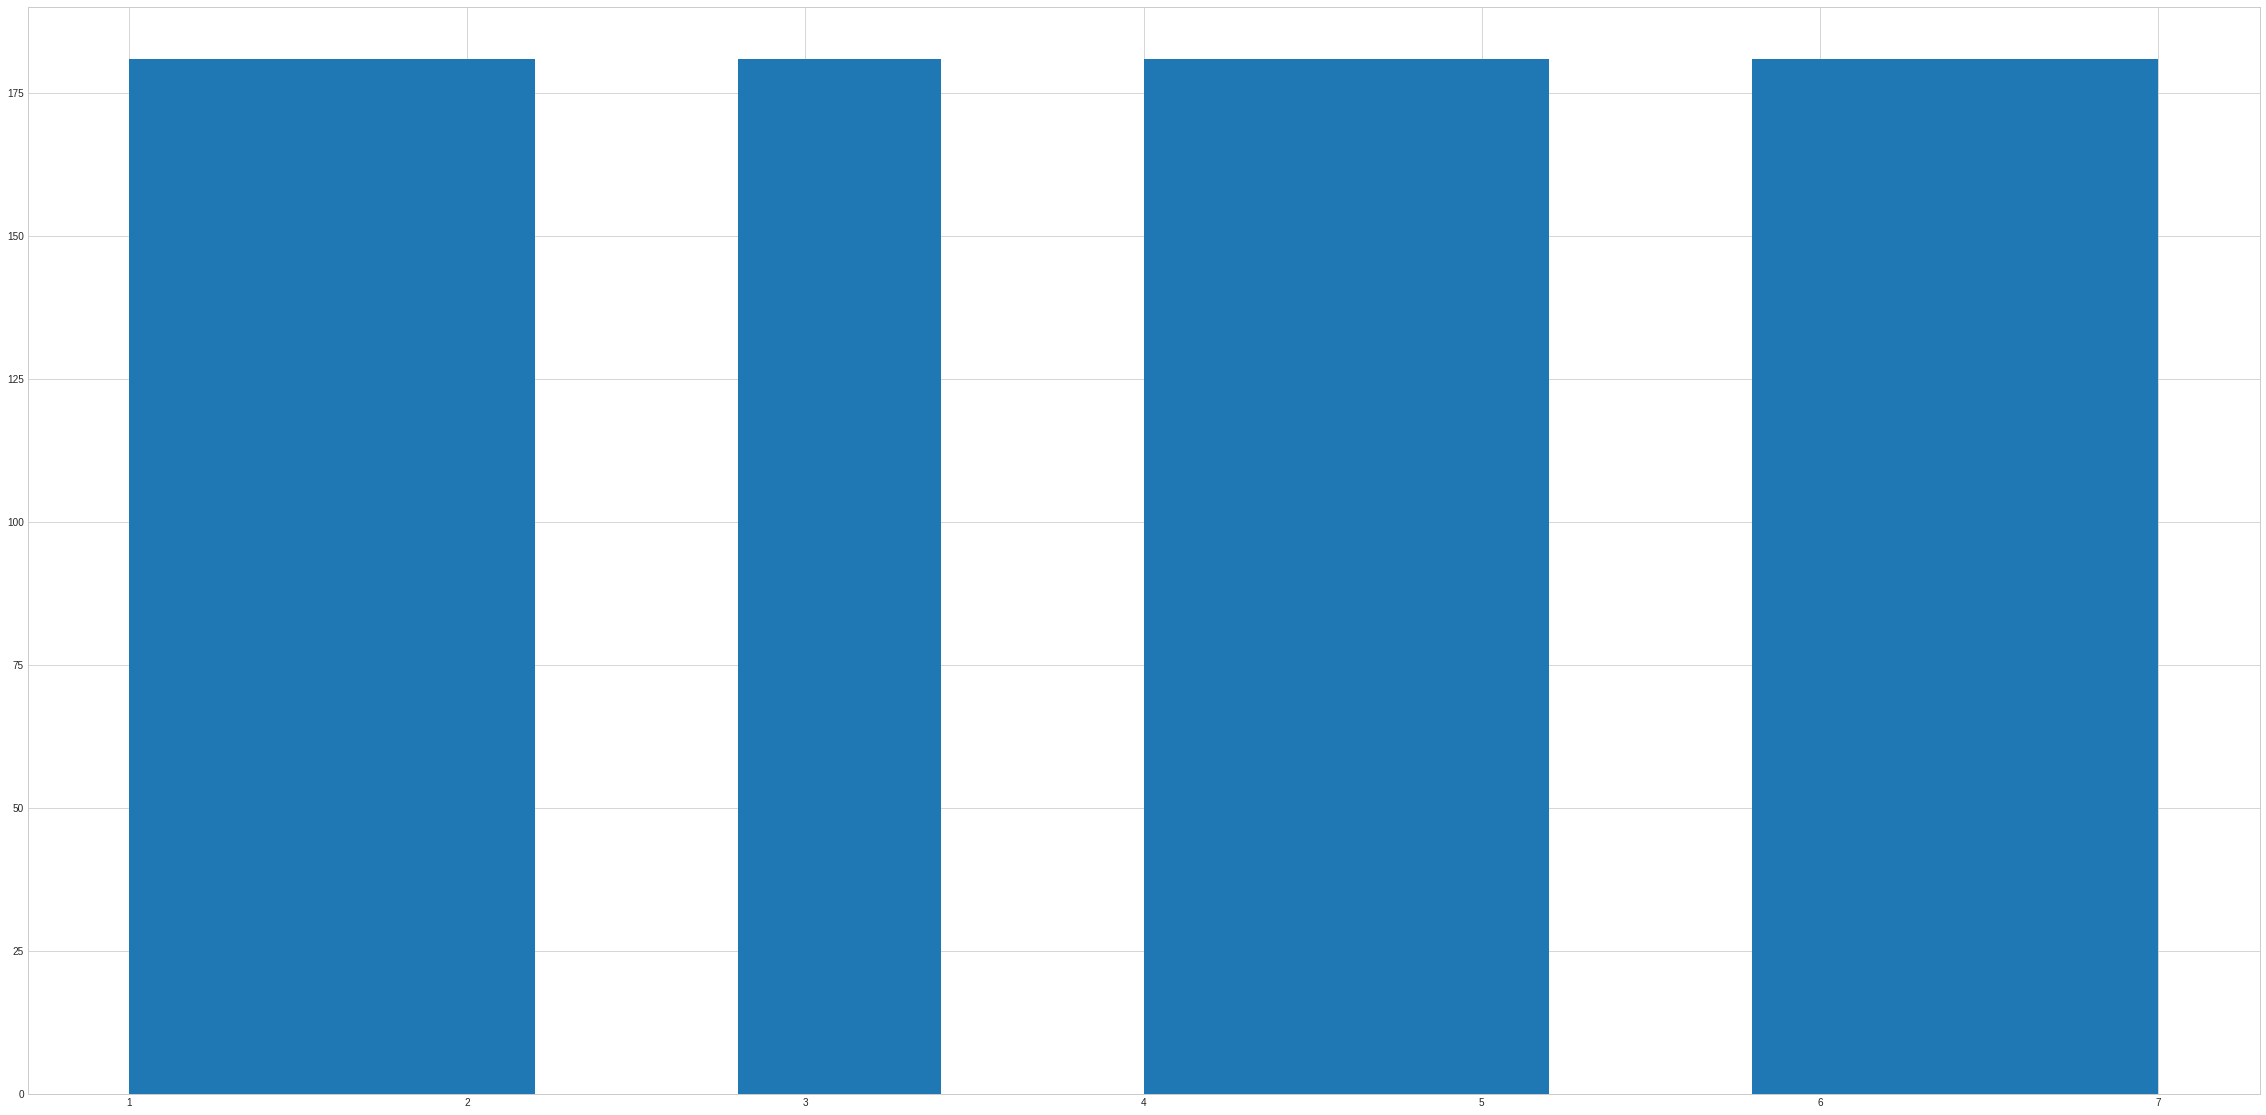

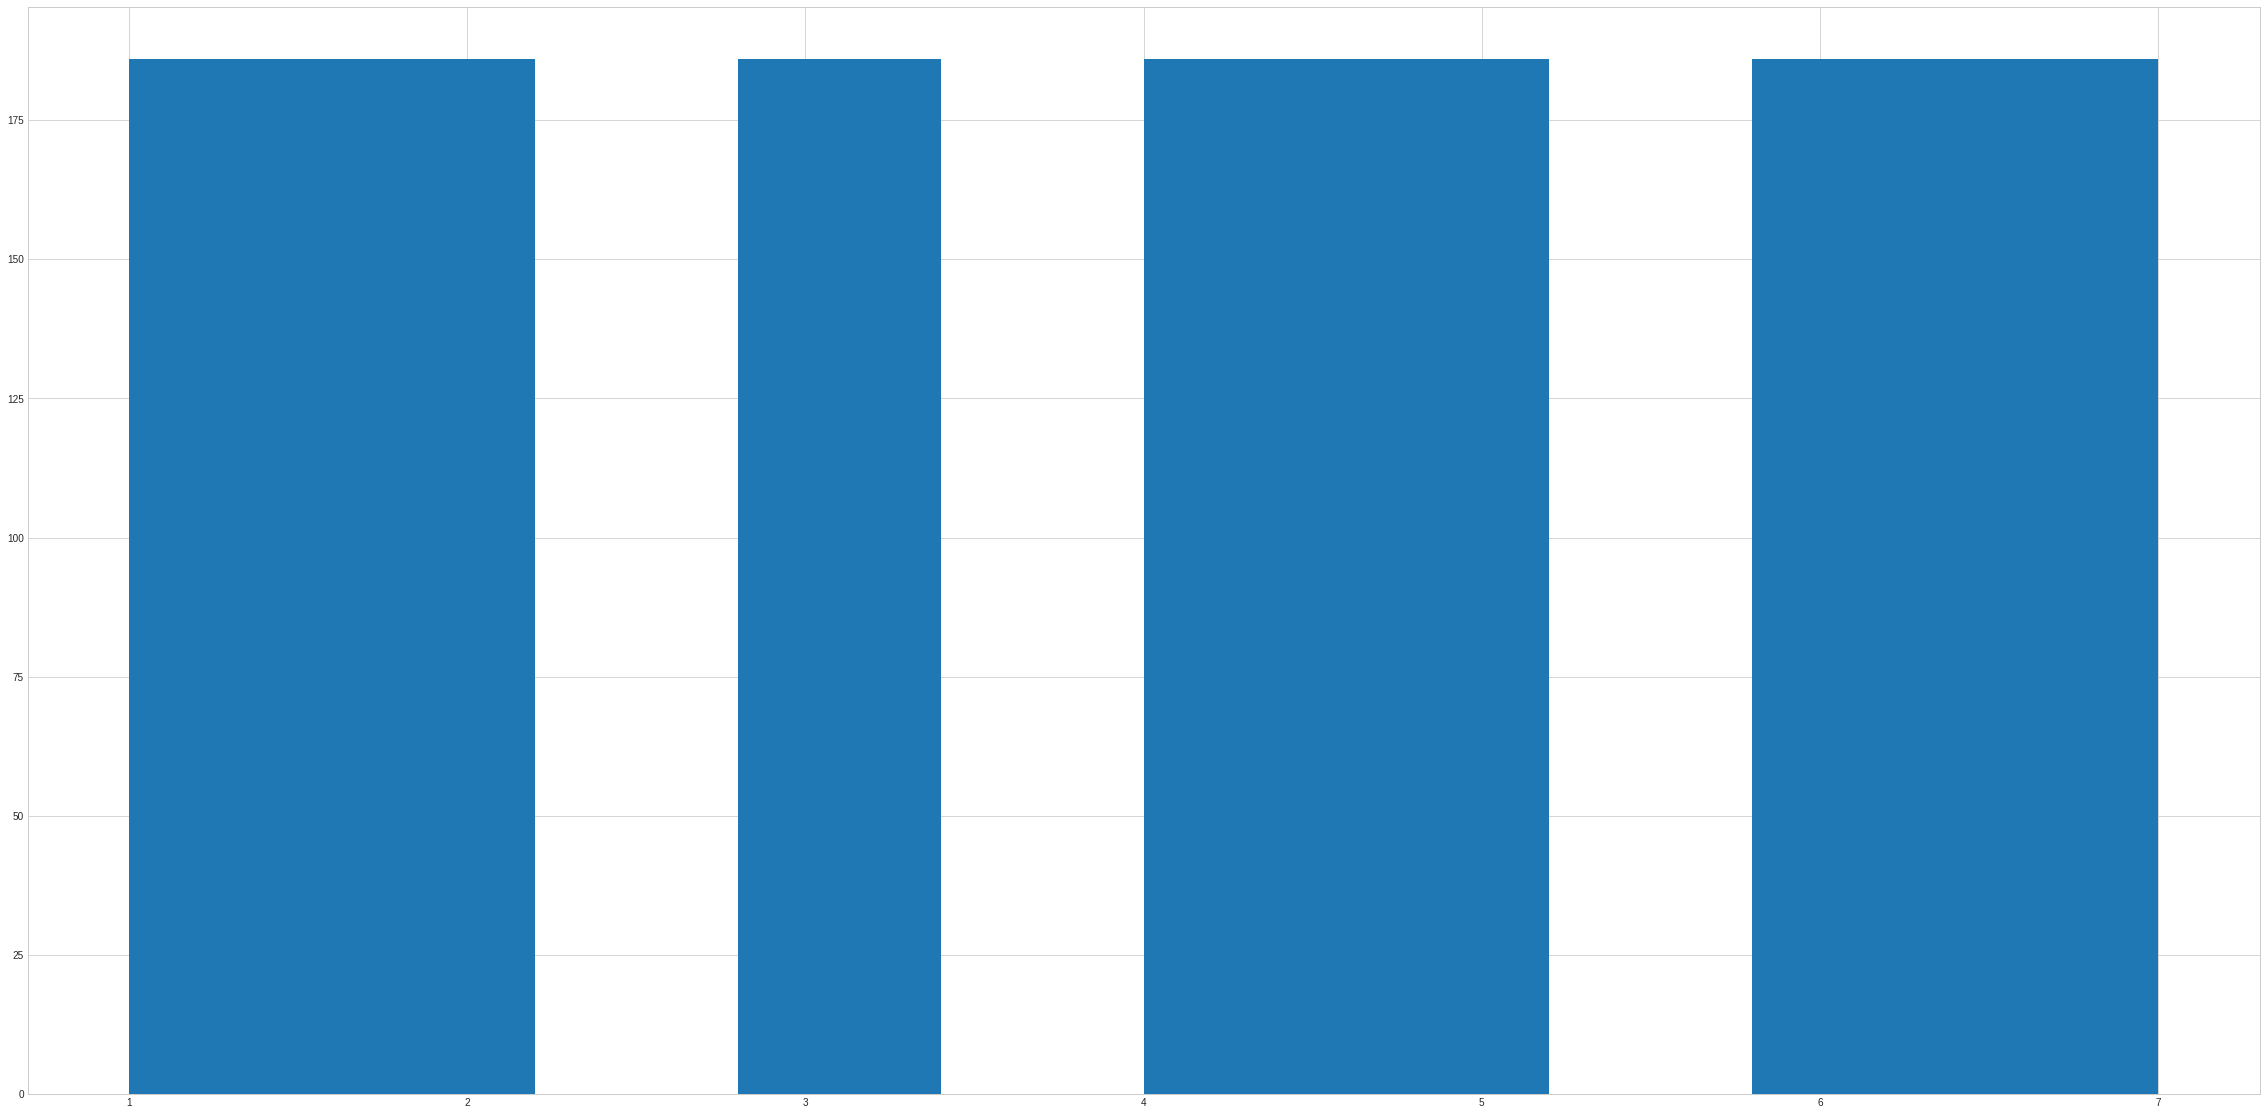

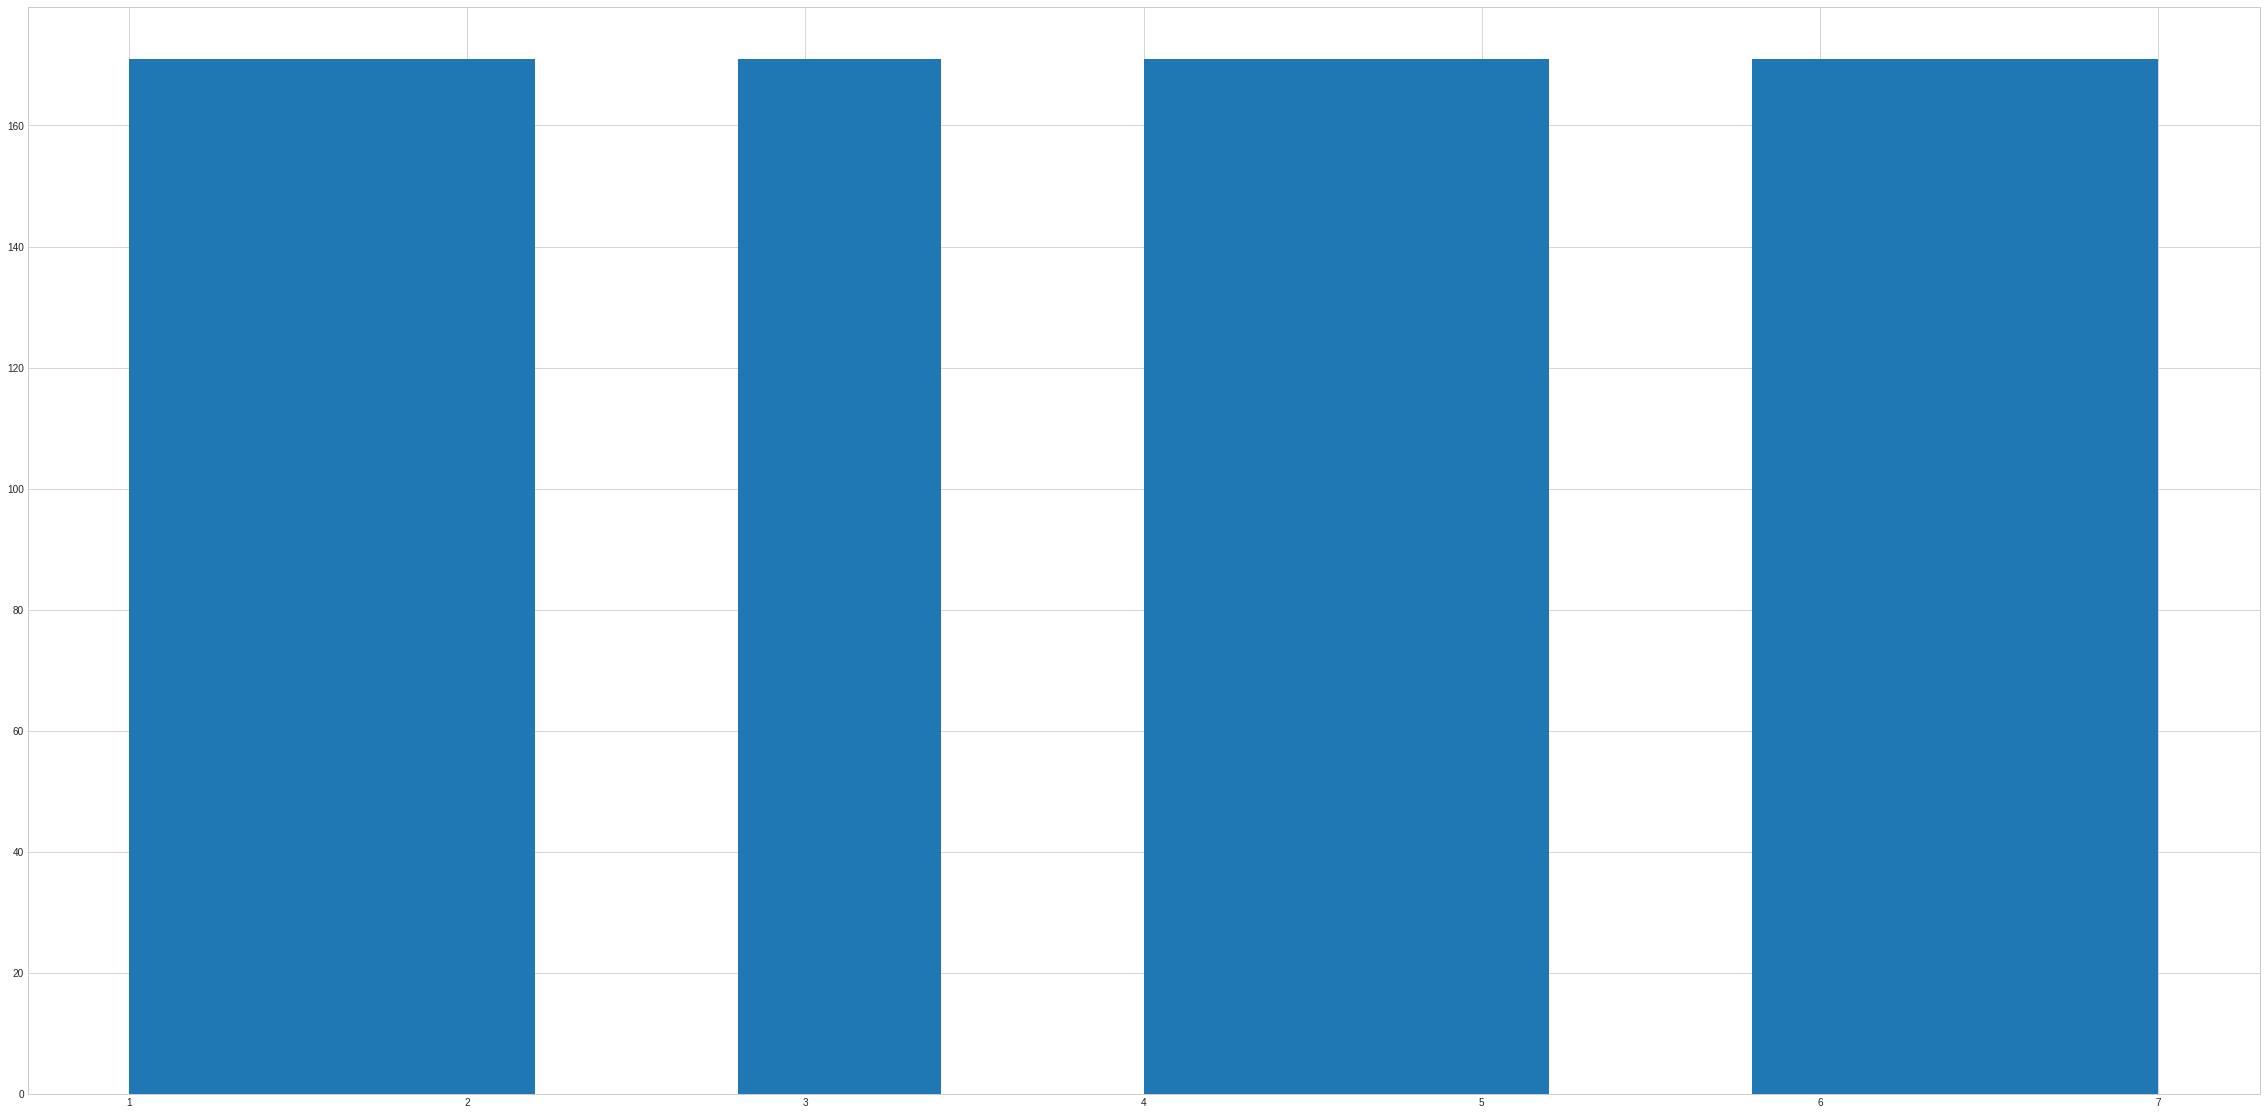

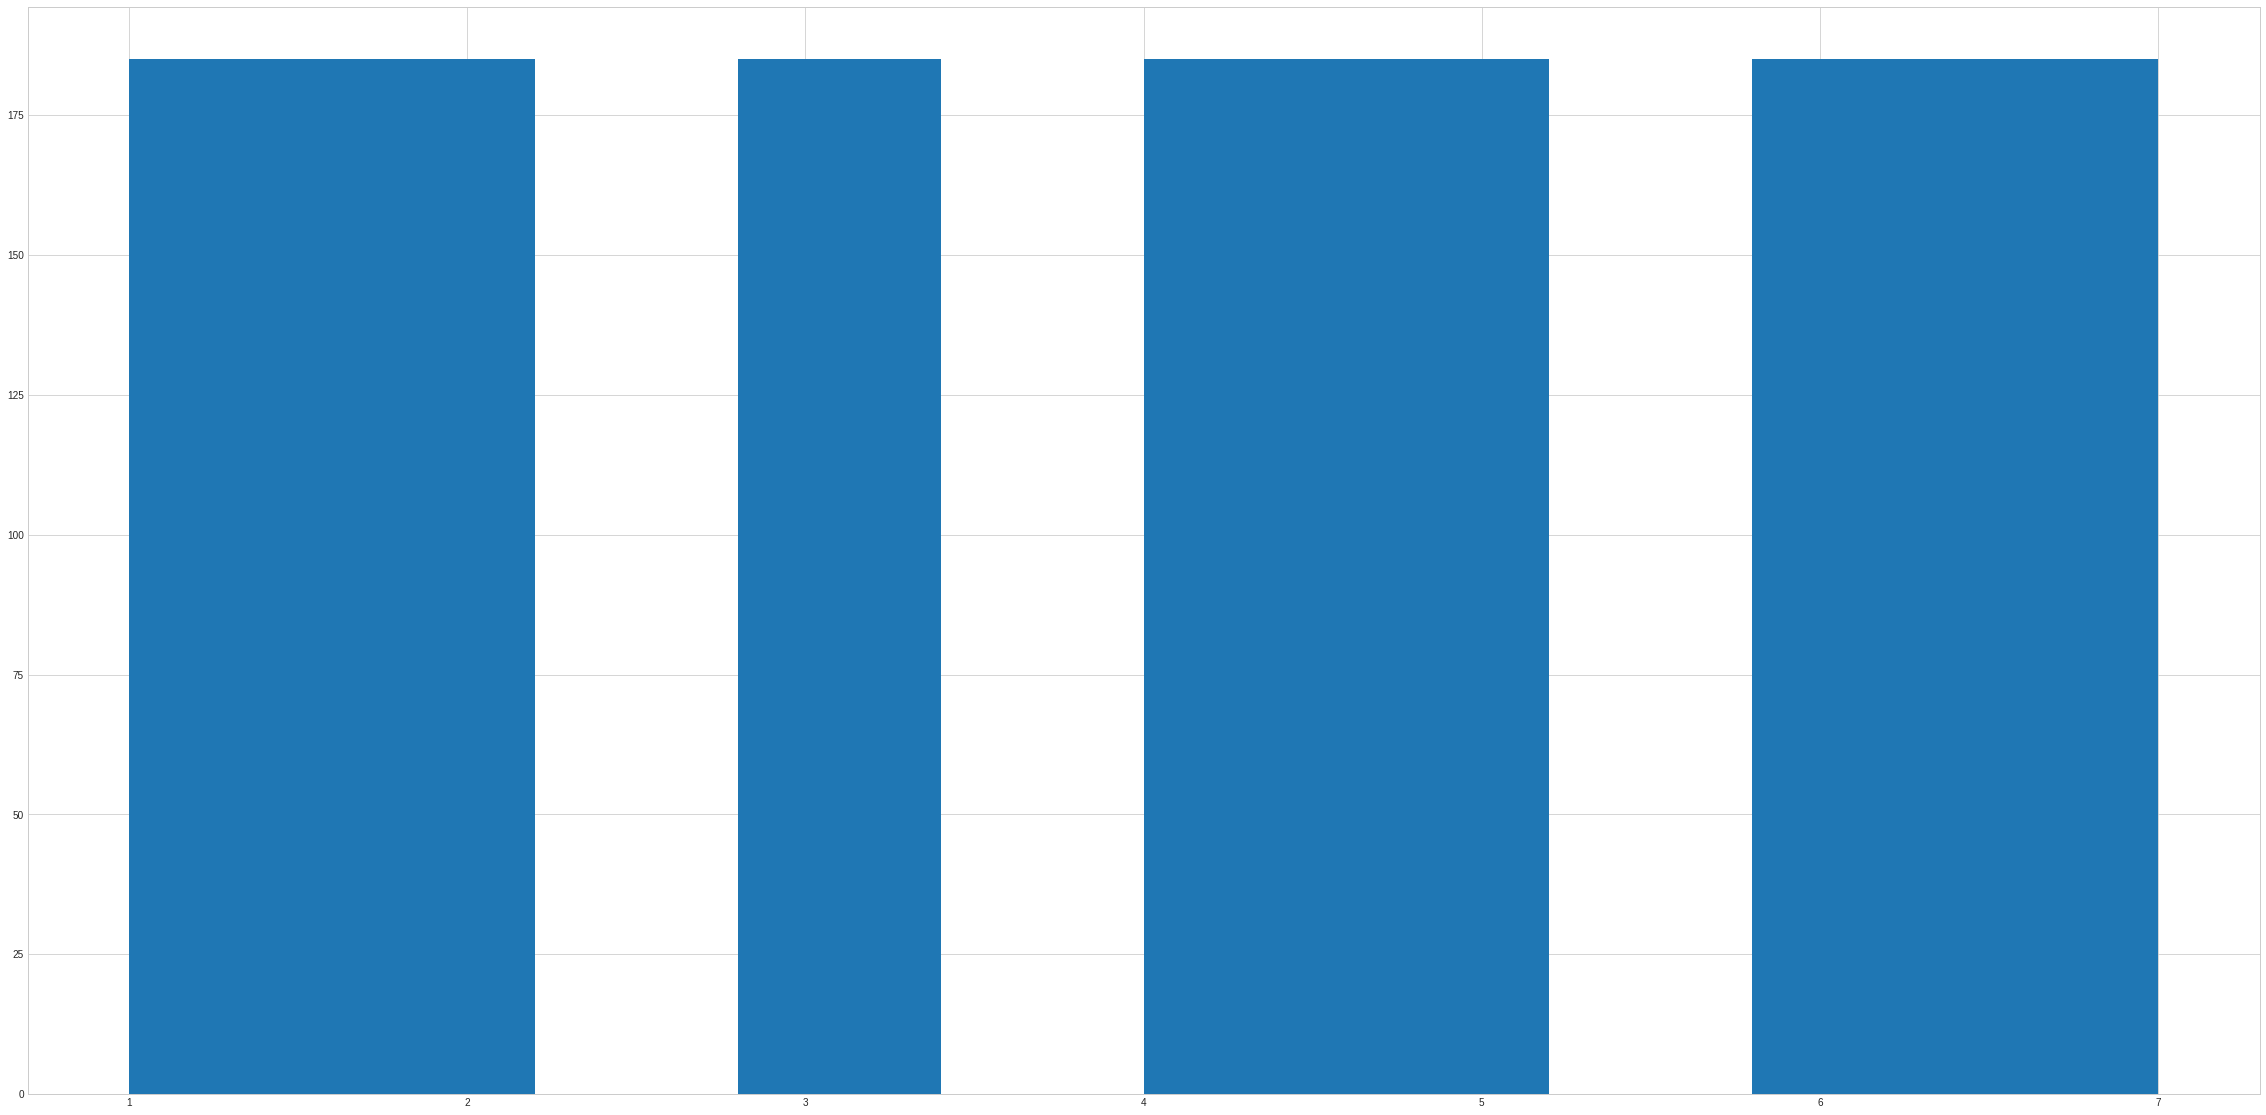

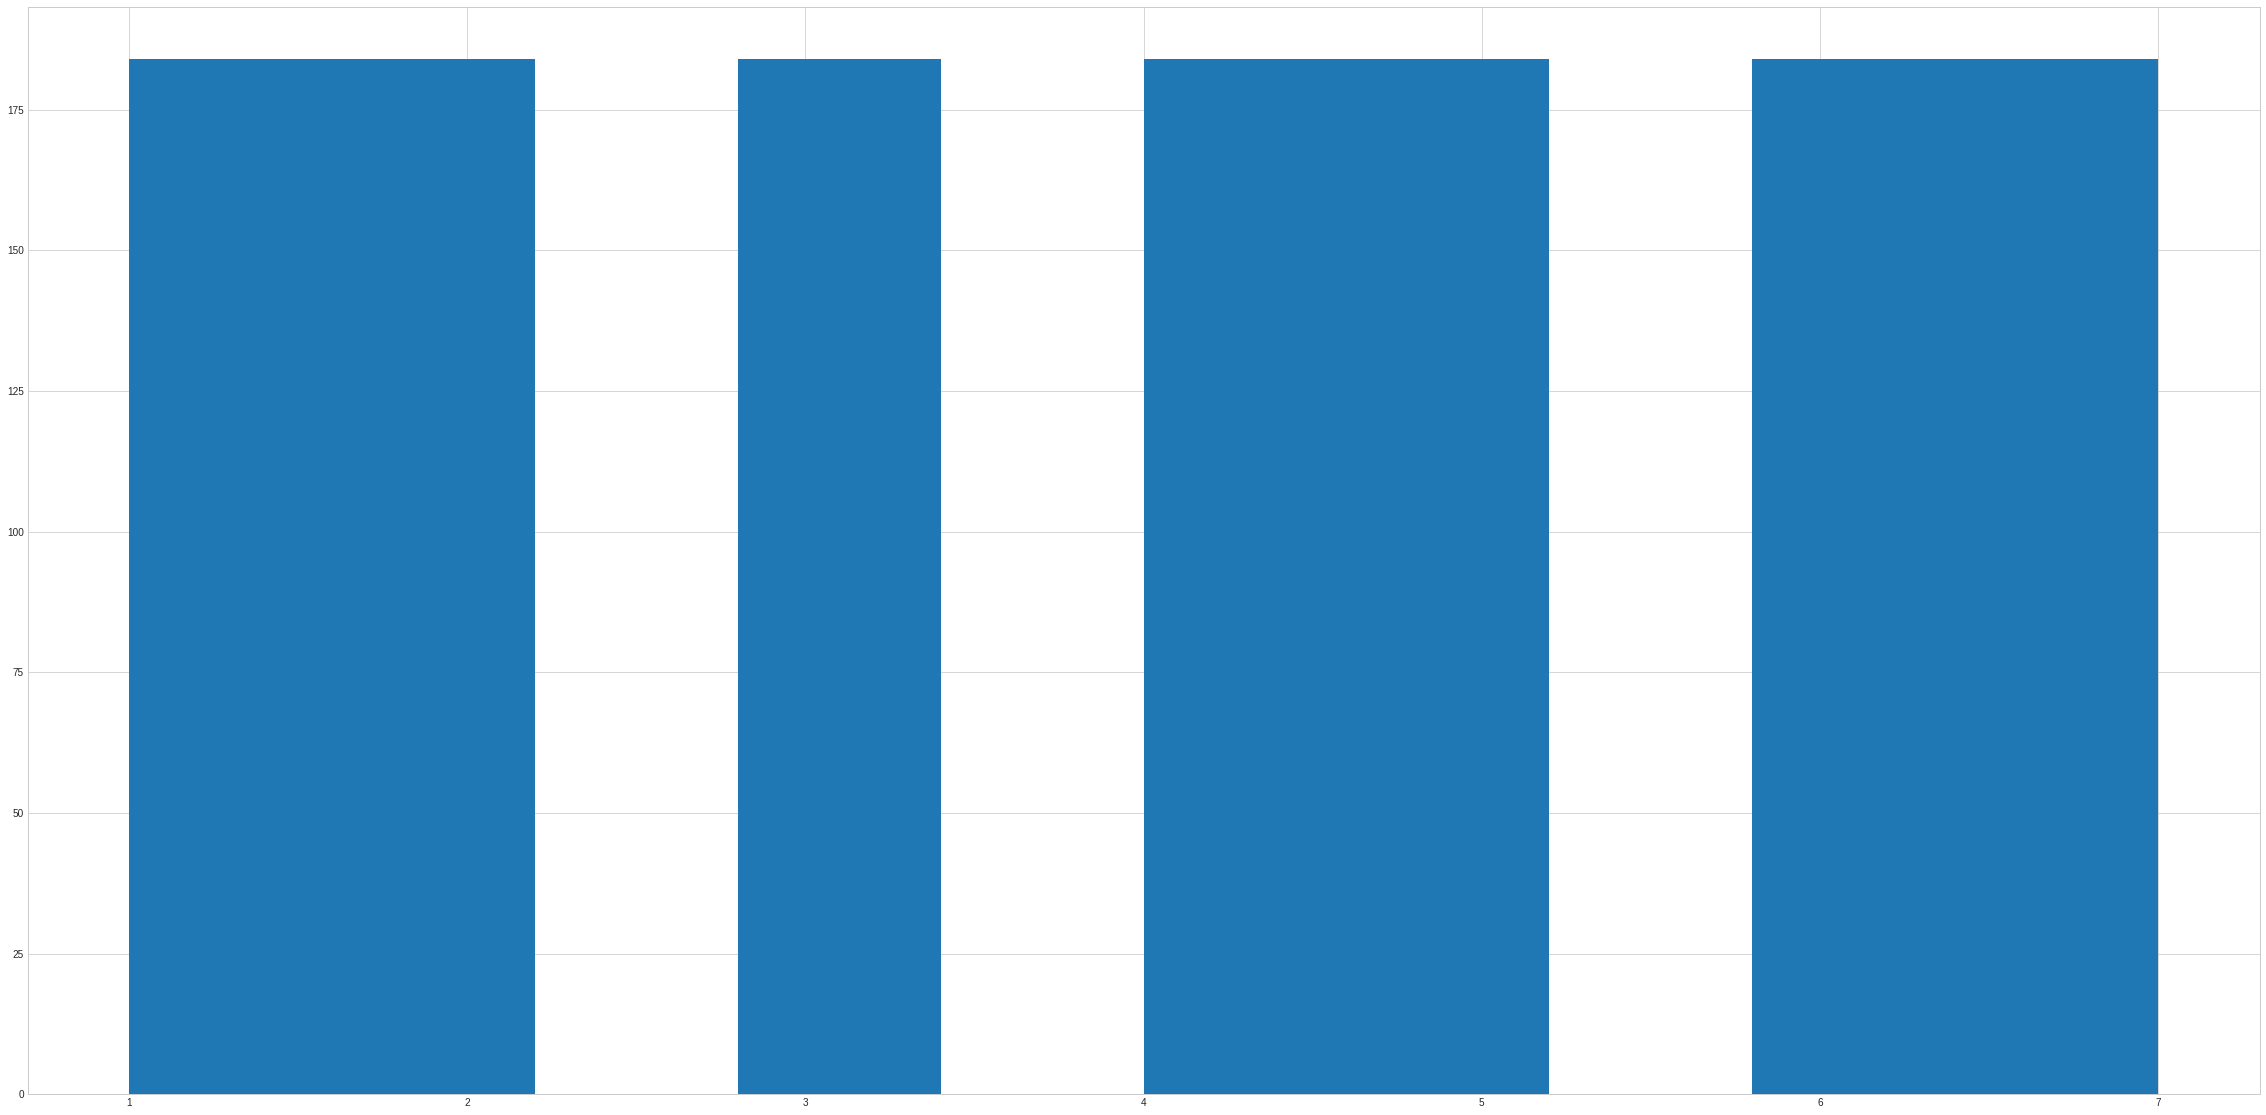

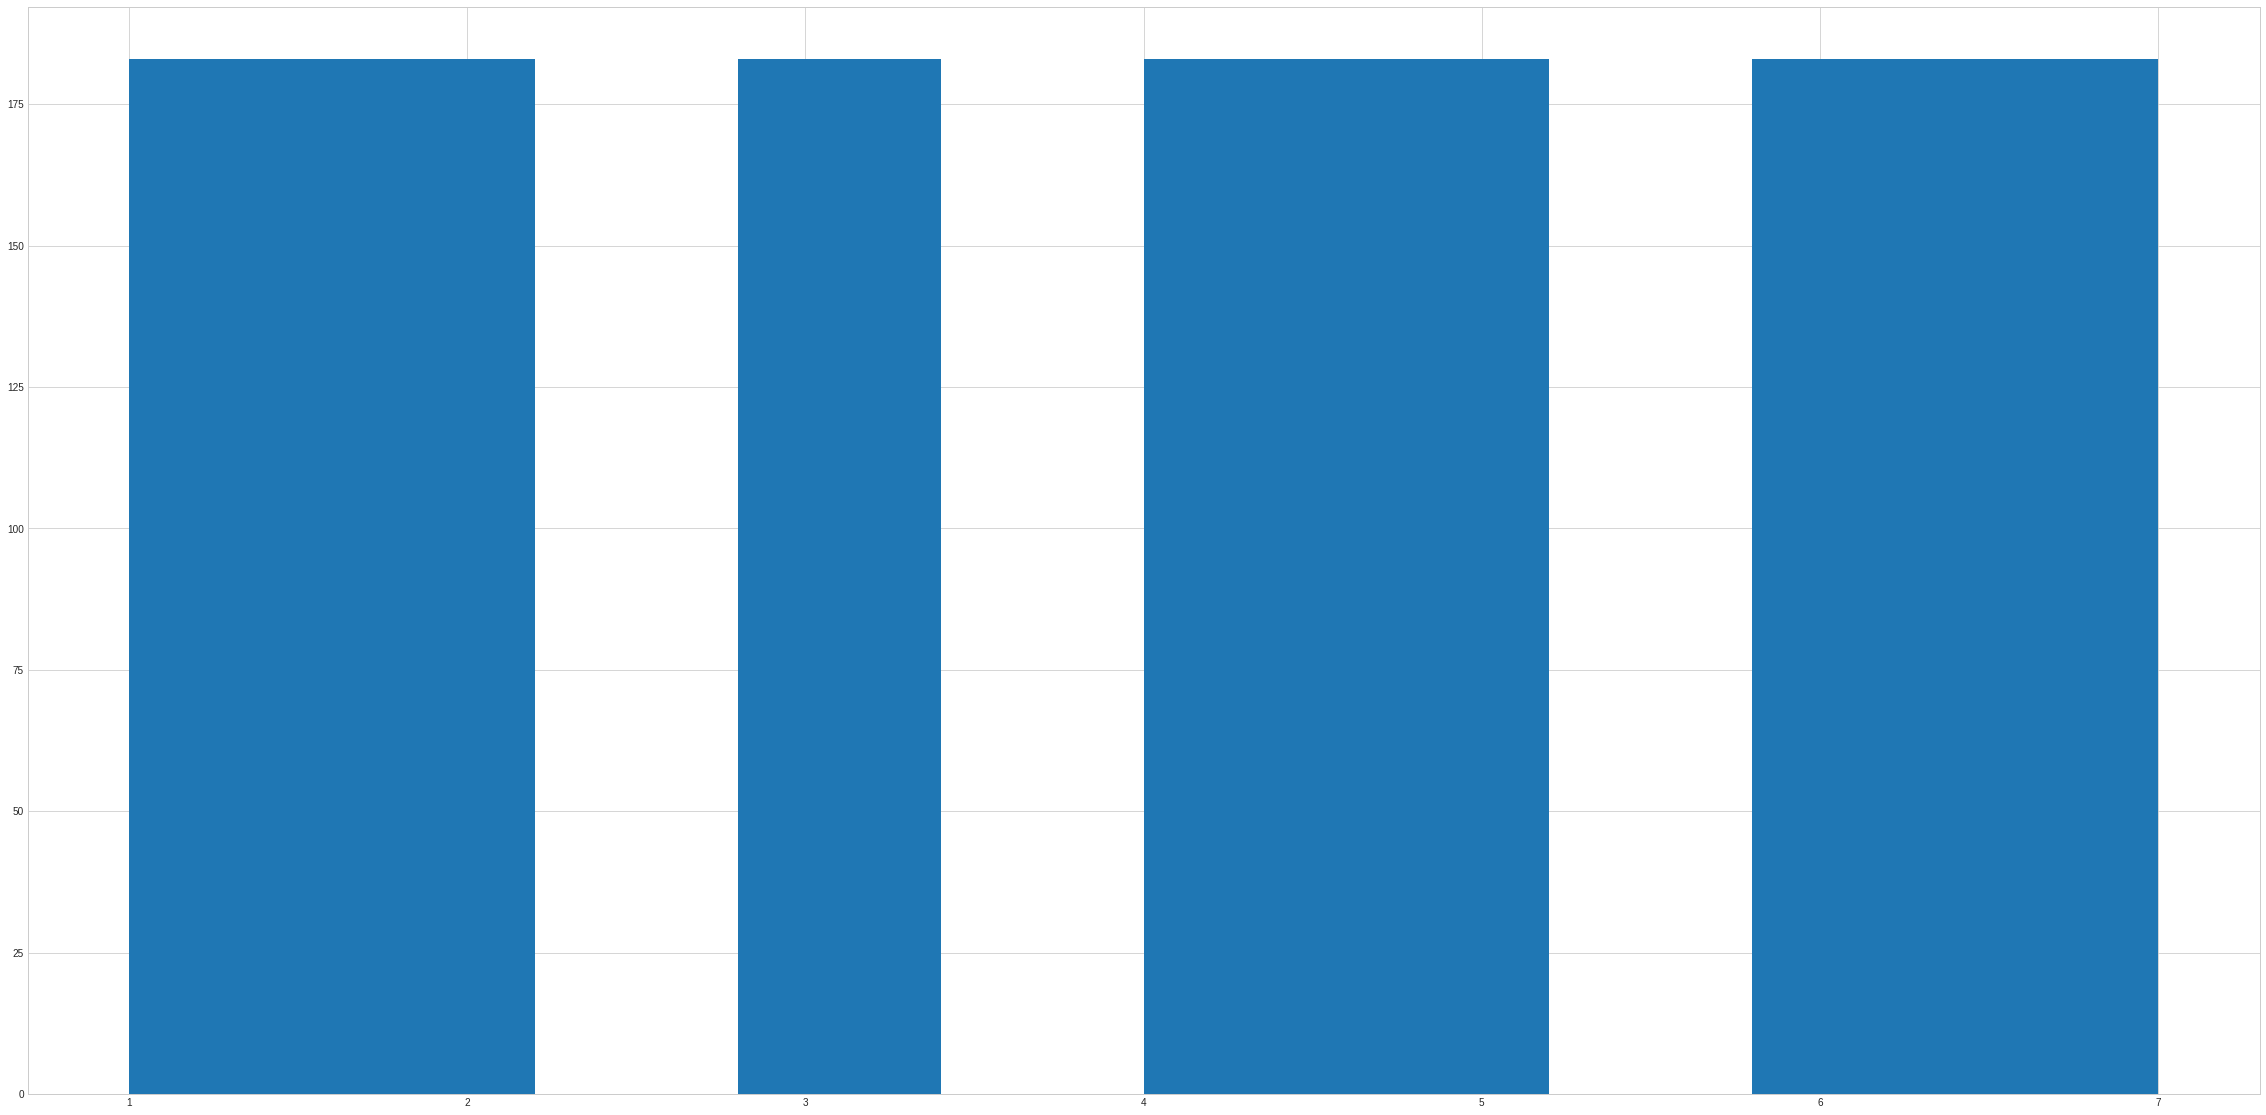

meanPrecision= 0.16285976671968488
meanRecall= 0.16285976671968488
meanAccuracy= 0.7608170762056242
meanMcc= 0.04960298371955421


In [16]:
from sklearn import model_selection
from sklearn.naive_bayes import GaussianNB

print("Gaussian Naive Bayes - MinMax Normalization - KF-OverSampler")
#Random Fores K-Fold e MinMax Over sampler
m = MetricsResultContainer("Gaussian Naive Bayes","KF","Minmax","Default",
  generateModel(GaussianNB(),rkf),"overSampler"
)
metricsResults.append(m)
m.printMetrics()

# **IMPLEMENTATION OF CLASSIFICATION MODEL WITH DECISION TREE**

In [19]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
def FinalModel():
  features_name=[]
  indipendenti=[]
  probabilita=[]
  y_pred=[]
  modello=[]
  for train_index, test_index in rkf.split(variabileIndipendenti,variabileDipendente):
    clone_model = clone(model)
    X_train, X_test = variabileIndipendenti.iloc[train_index], variabileIndipendenti.iloc[test_index]
    Y_train, Y_test = variabileDipendente.iloc[train_index], variabileDipendente.iloc[test_index]
    select=SelectKBest(score_func=f_classif,k=10)
    scaler=MinMaxScaler()
    #Data Balancing
    oversample = RandomOverSampler(random_state=42)
    X_train_over, y_train_over= oversample.fit_resample(X_train, Y_train)
    #feature scaling sui traing test
    X_train_z = scaler.fit_transform(X_train_over)
    X_test_z = scaler.transform(X_test)
    #applicazione feature selection su train_z
    X_train_z = select.fit_transform(X_train_z, y_train_over)
    X_test_z = select.transform(X_test_z)
    #training dell'algoritmo sui training set
    clone_model.fit(X_train_z,y_train_over)
    model=DecisionTreeClassifier()
    model.fit(X_train_z,y_train_over)
    features_name.append(select.get_feature_names_out(input_features=X_train_over.columns.values))
    indipendenti.append(X_test_z)
    probabilita.append(model.predict_proba)
    modello.append(model)
    y_pred.append(model.predict(X_test_z) )
  return features_name,indipendenti,probabilita,modello,y_pred



# **USE LIME FOR PREDICTION OF MODEL**

In [ ]:
!pip install lime

In [ ]:
import lime
import lime.lime_tabular
import sklearn
import sklearn.ensemble
import numpy as np

explainer = lime.lime_tabular.LimeTabularExplainer(X_train_z, feature_names=select.get_feature_names_out(input_features=X_train_over.columns.values), class_names=[0,1,2,3,4,5,6,7,8,9], categorical_features=[0,1,2,3,4,5,6], 
                                                   verbose=True, mode='classification')
i =25
exp = explainer.explain_instance(X_test_z[i], model.predict_proba, num_features=9)
exp.show_in_notebook(show_table=True)
exp.as_list()

Intercept 0.2961476035378475
Prediction_local [0.12450534]
Right: 0.0


[('sex=1', -0.13666770316151314),
 ('school=1', 0.06981939468072015),
 ('absences <= 0.00', -0.059827299980284764),
 ('guardian=1', -0.055488203384757497),
 ('internet=0', -0.027464325608691567),
 ('0.58 < G3 <= 0.68', 0.019771309610851478),
 ('goout <= 0.50', 0.01384443457508791),
 ('famsize=0', 0.010558292624436421),
 ('freetime=0', -0.006188158342607566)]

# **USE SHAP FOR PREDICTION OF MODEL**

In [ ]:
! pip install shap

     |████████████████████████████████| 564 kB 16.0 MB/s 


In [ ]:
import shap

# predizione
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_z)

#stampa
shap.initjs()
shap.force_plot(explainer.expected_value[1],shap_values[1],X_test_z)

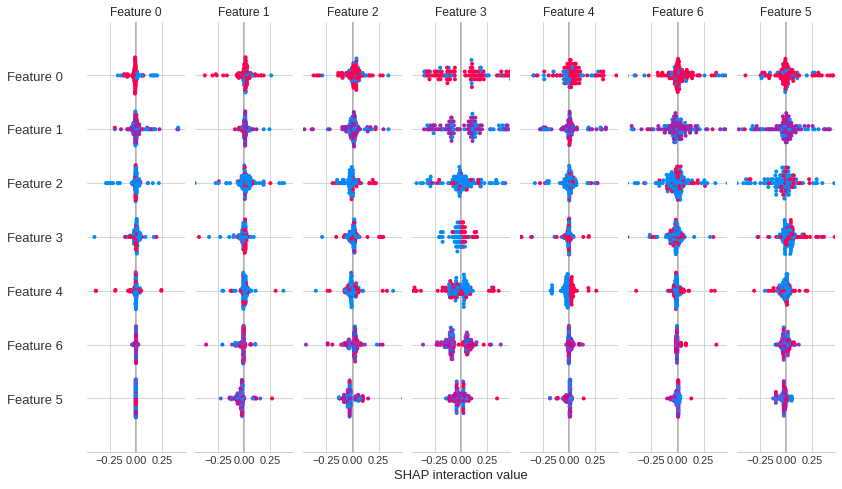

In [ ]:
#stampa grafico barre
shap_values = explainer(X_test_z)
shap.summary_plot(shap_values,X_test_z)